In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5


# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

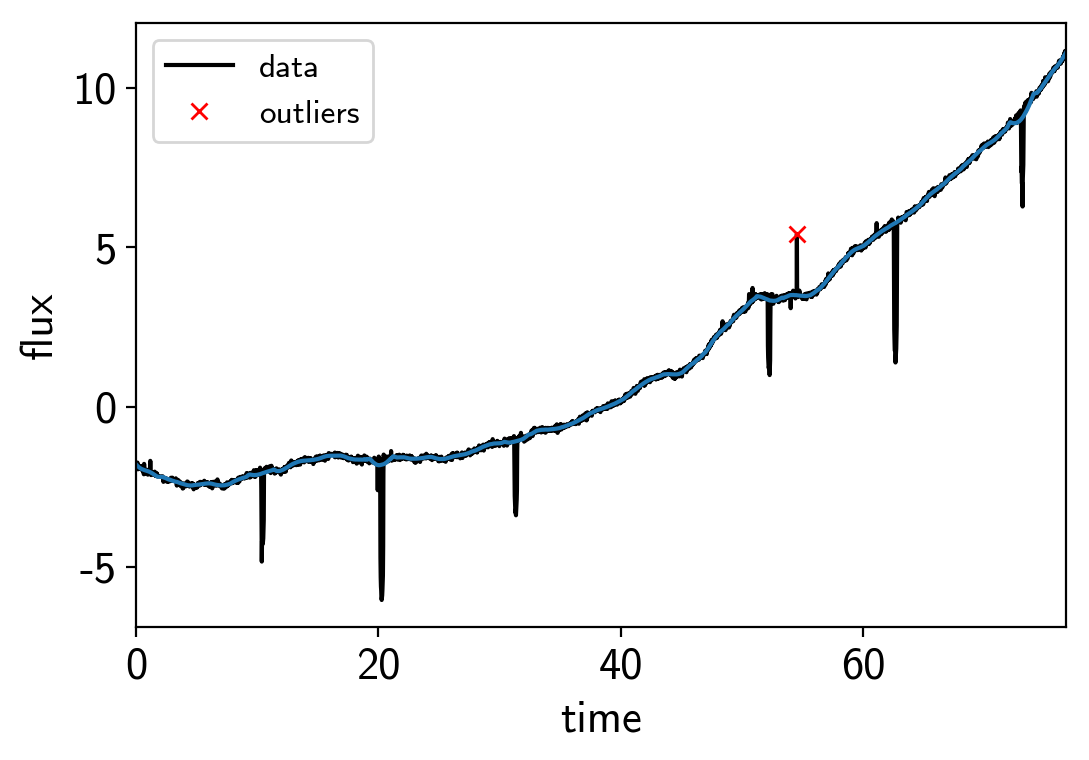

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

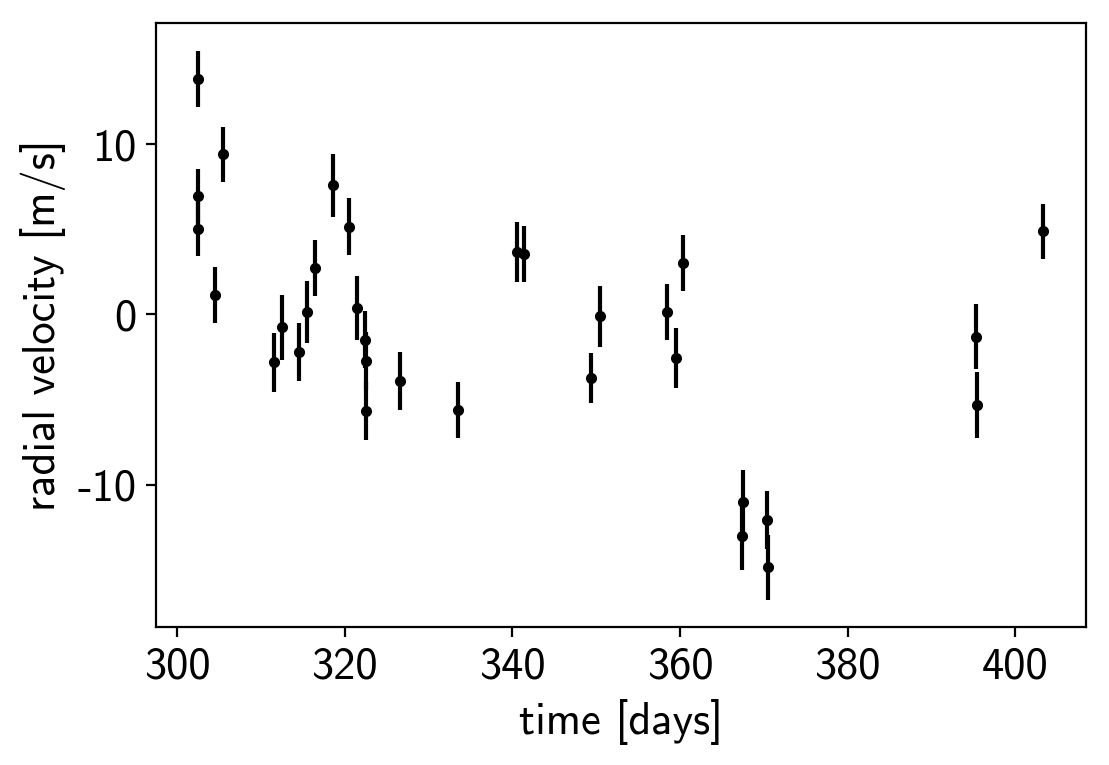

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

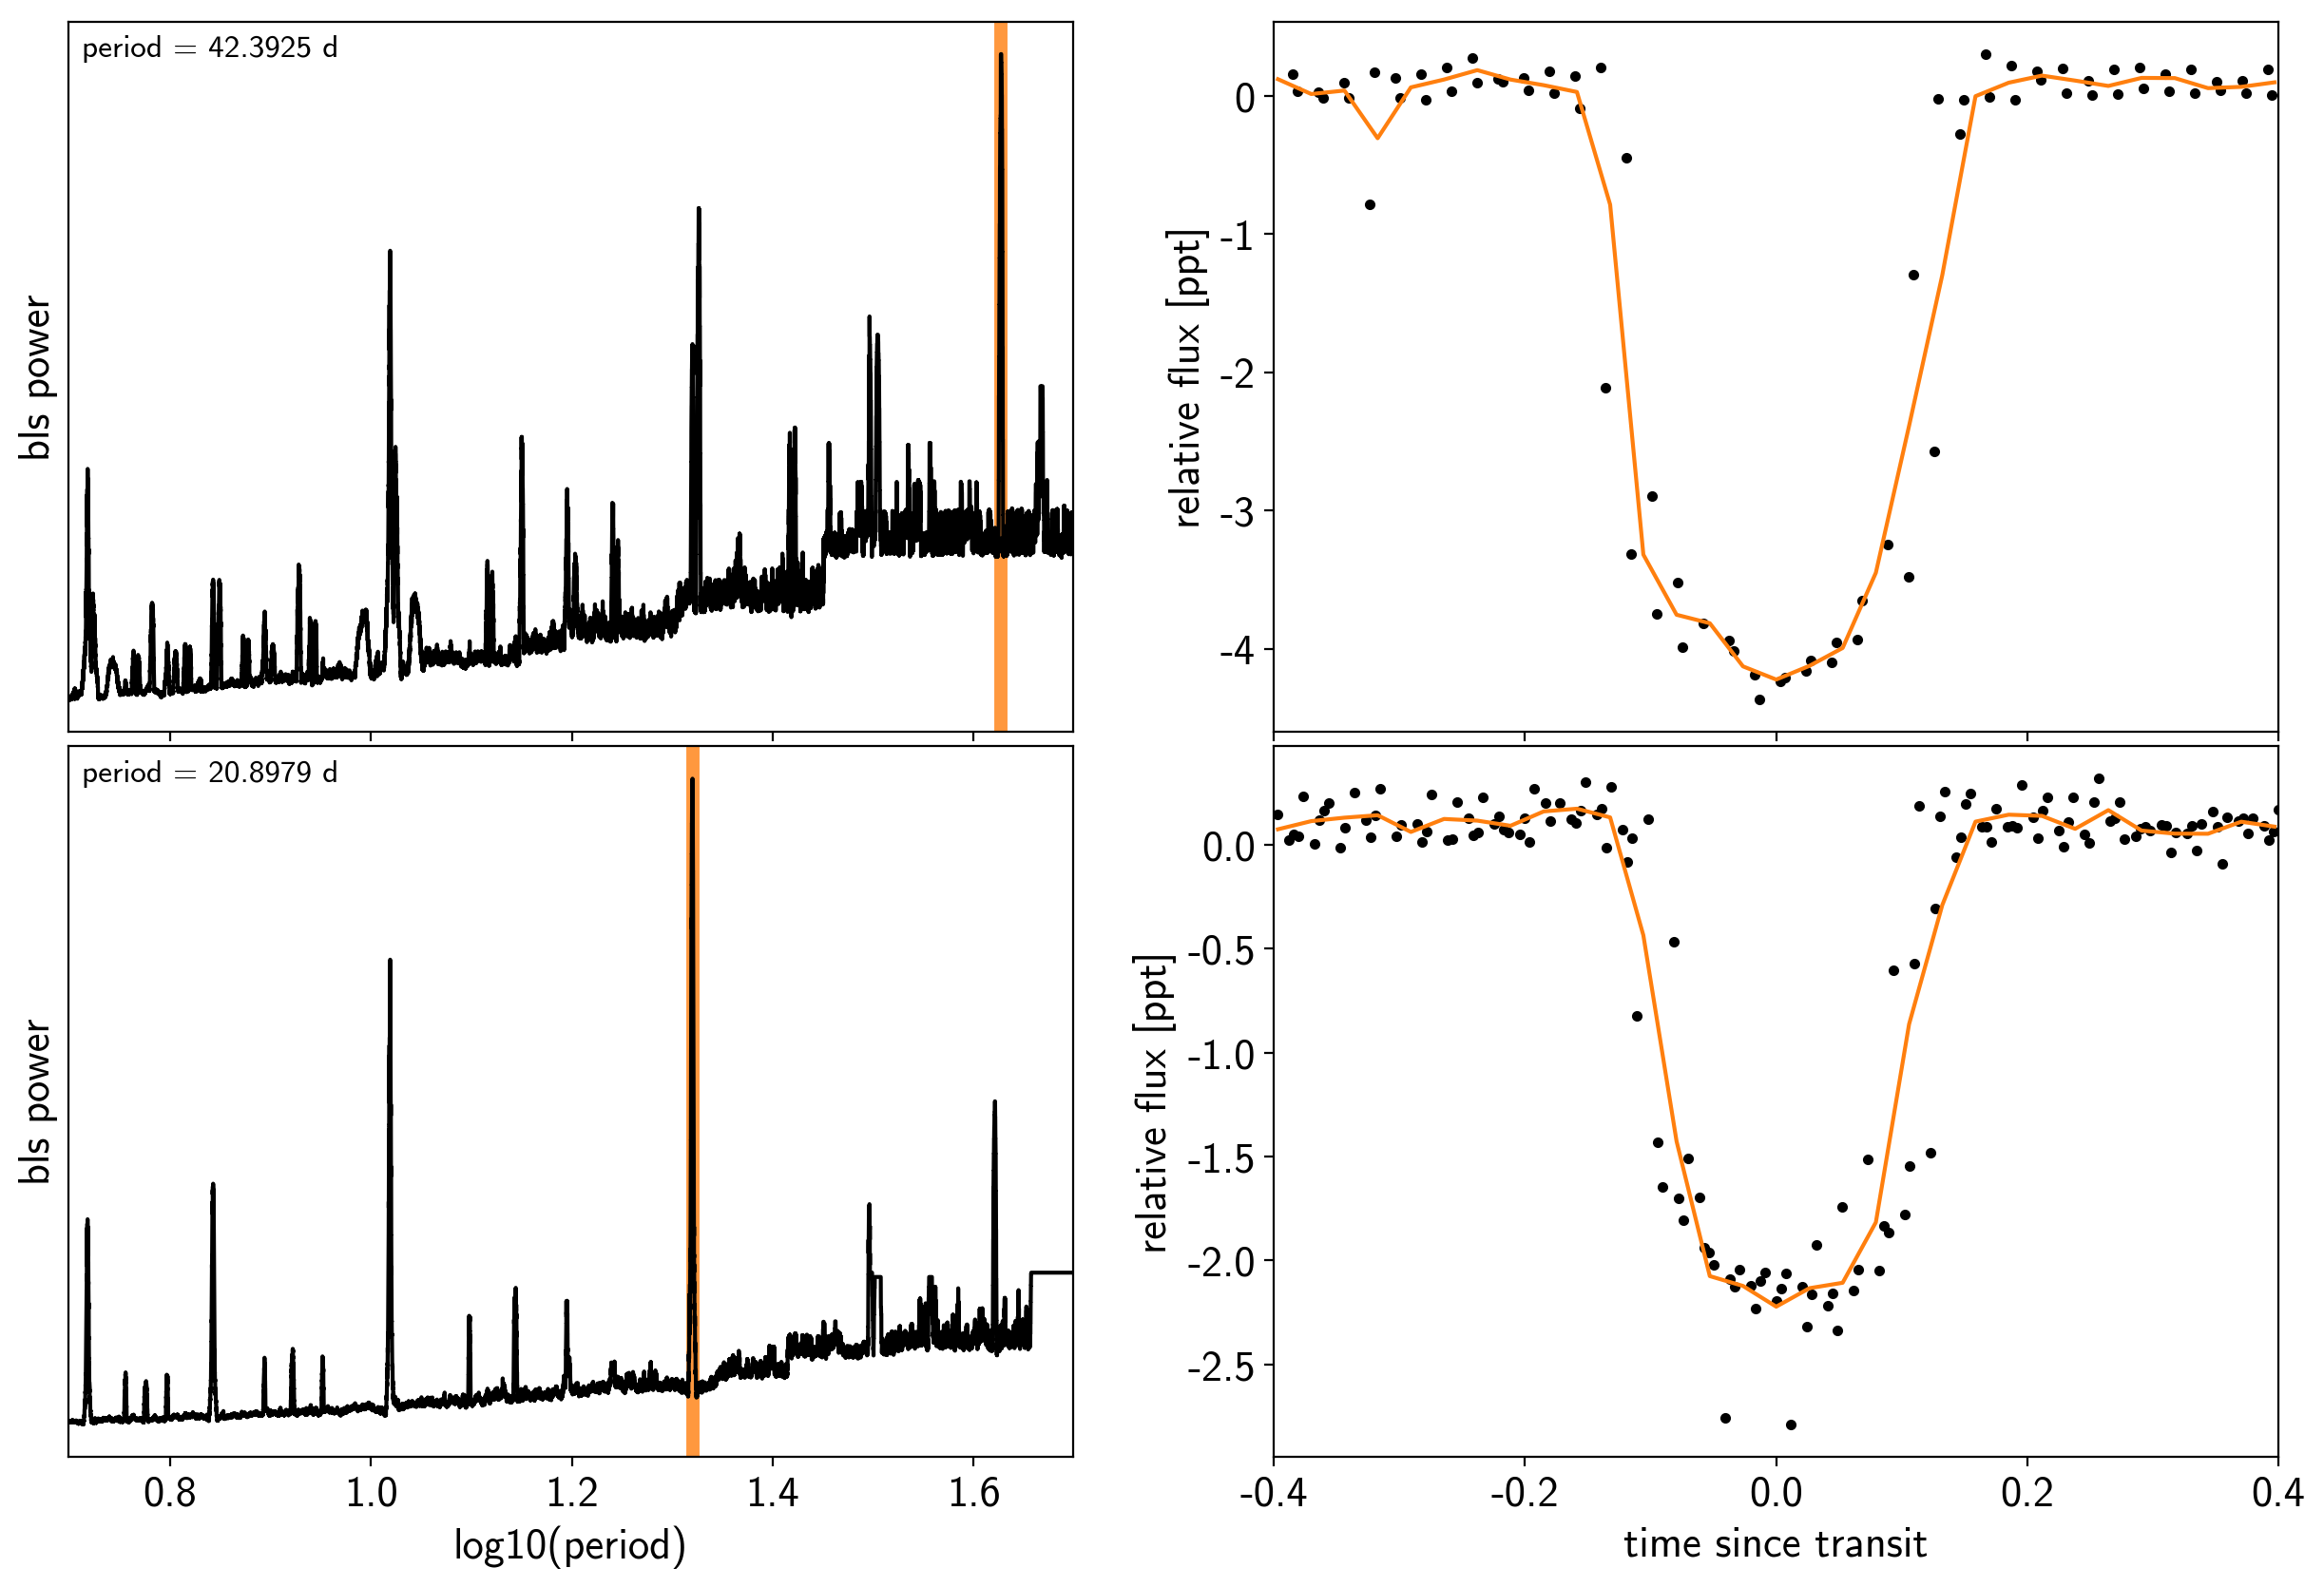

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        m_star = pm.Normal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = pm.Normal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5+np.zeros(2),
                       shape=2)
        ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=2,
                         testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp, oversample=15)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8216.986023857186 -> -8201.731058138012


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8201.731058138012 -> 2595.6621154808026


optimizing logp for variables: ['b_interval__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 2595.6621154808026 -> 2818.9312788464613


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2818.9312788464613 -> 3696.09961998513


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 3696.09961998513 -> 4310.350888676674


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 4310.350888676674 -> 4381.909298235777


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4381.909298235777 -> 4381.92717865675


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Optimization terminated successfully.
logp: 4381.92717865675 -> 4468.096852994163


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4468.096852994163 -> 4776.768827256388


Now let's plot the map radial velocity model.

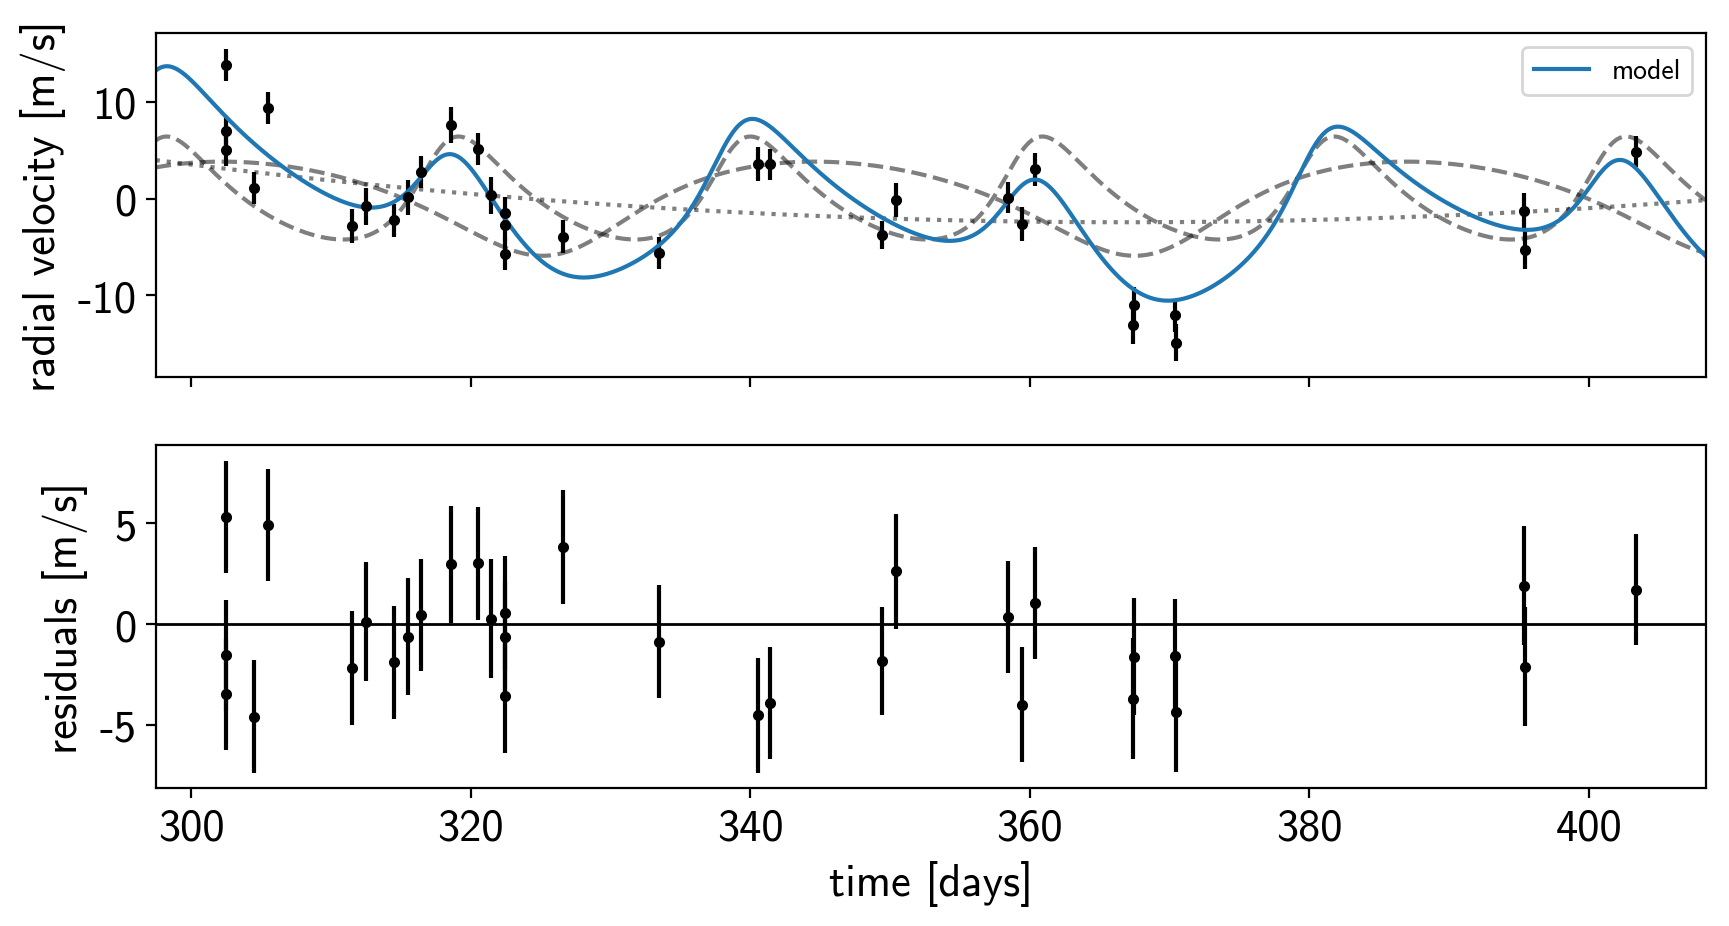

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

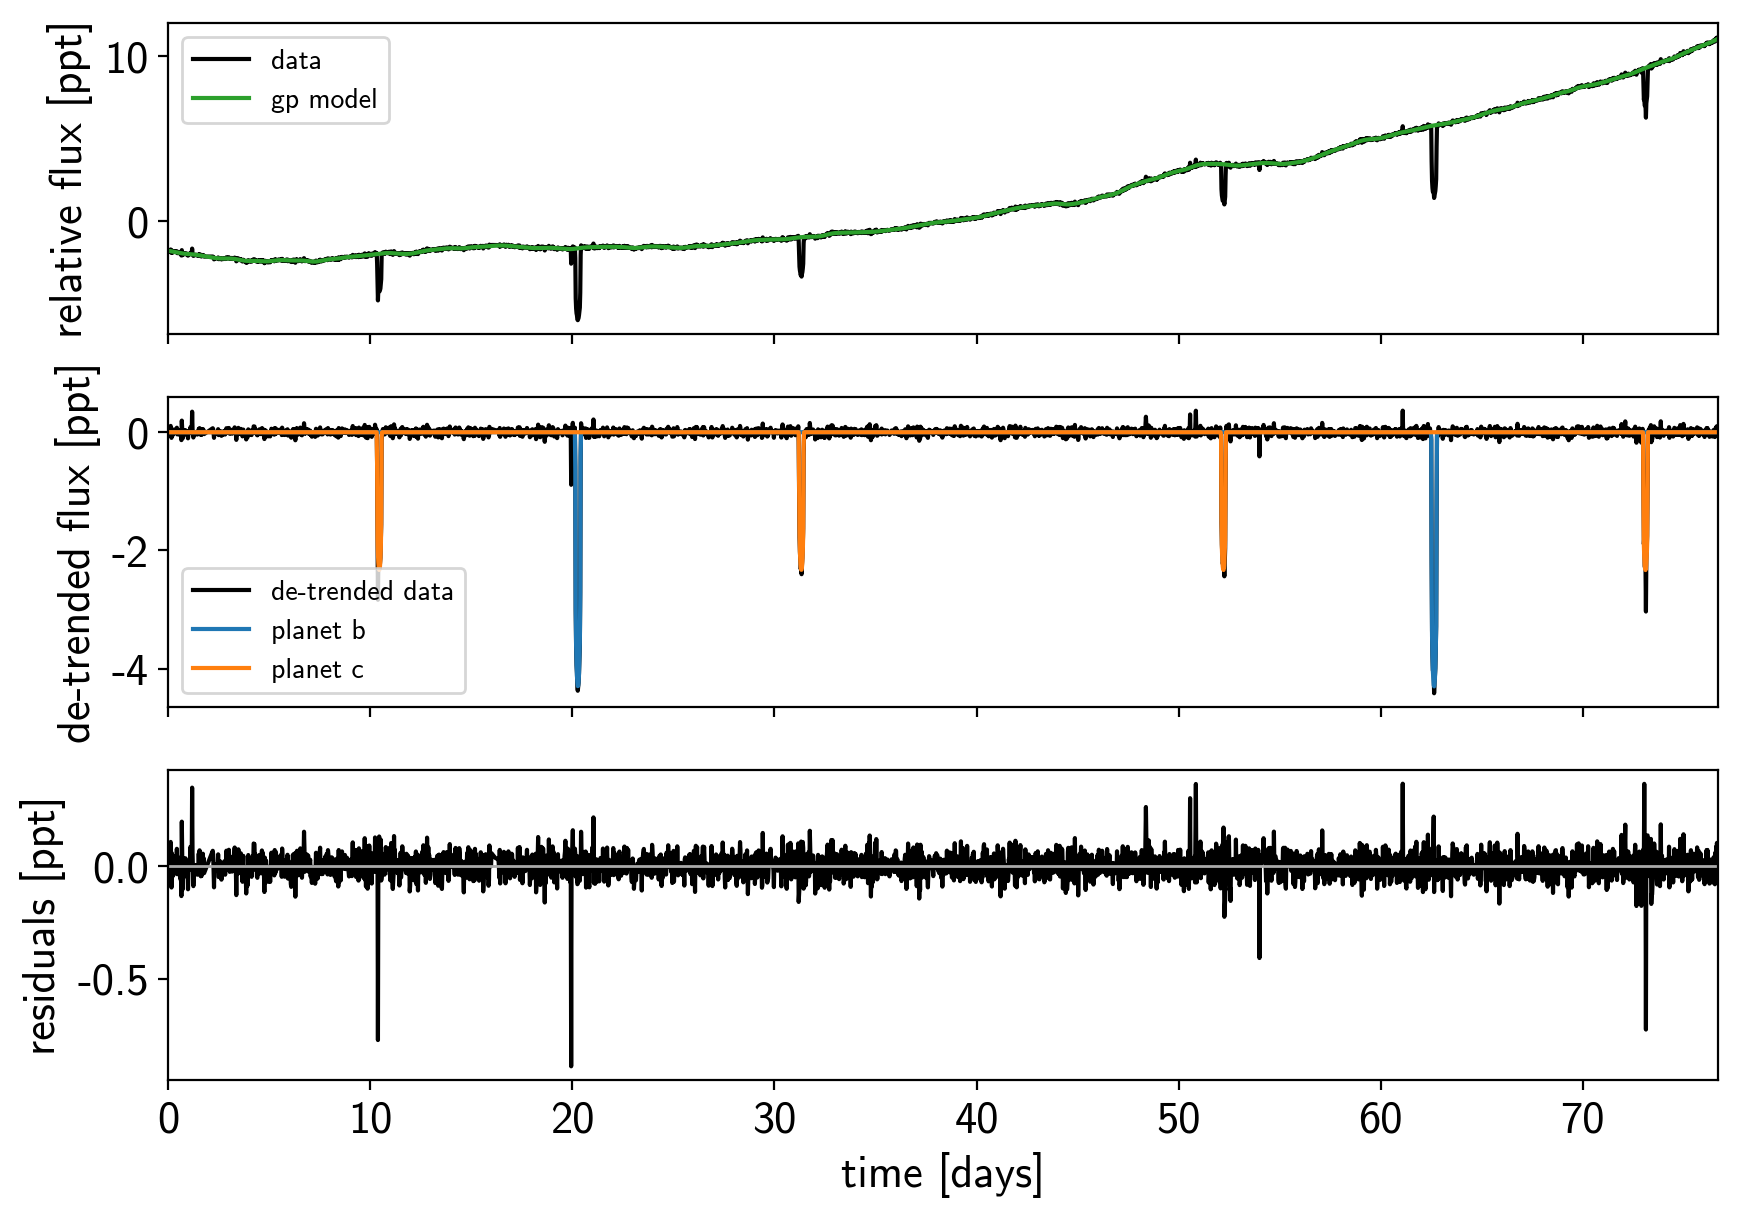

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

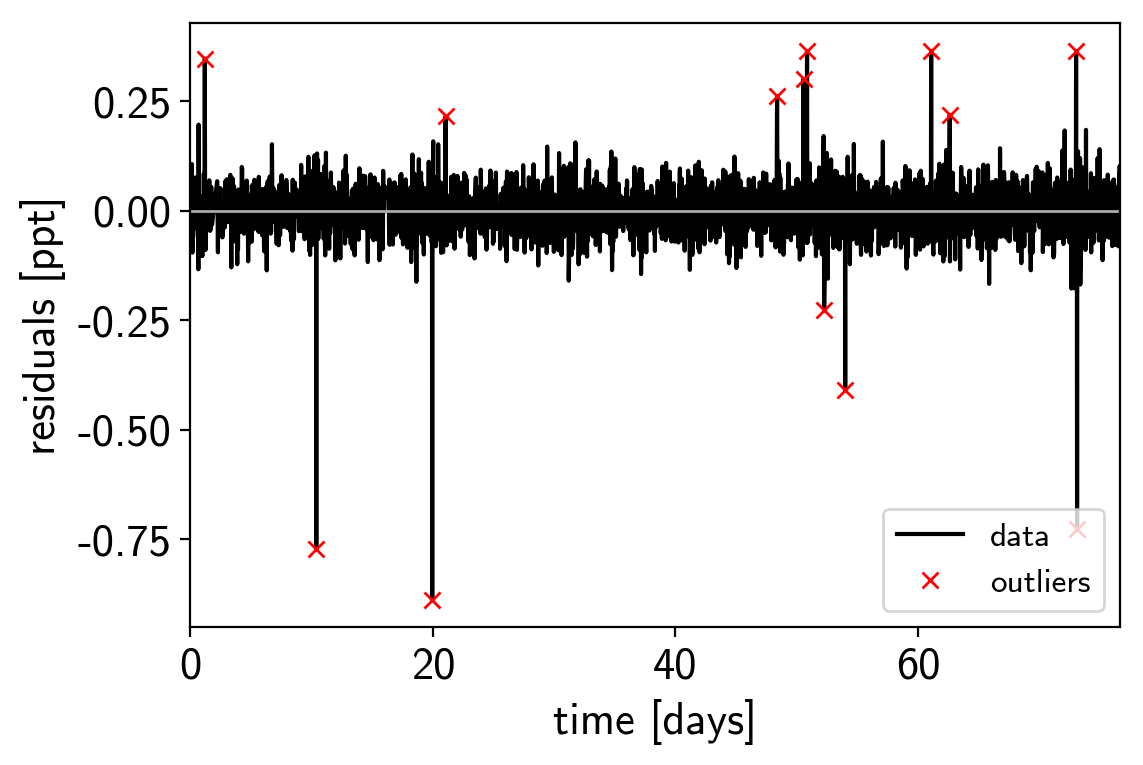

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5226.925440678209 -> 5226.92544067821


optimizing logp for variables: ['logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: 5226.92544067821 -> 5309.094883167375


optimizing logp for variables: ['b_interval__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 5309.094883167375 -> 5320.14909739983


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 5320.14909739983 -> 5321.564832945187


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.564832945187 -> 5322.302087822063


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 5322.302087822063 -> 5322.336502468334


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.336502468334 -> 5324.074012099883


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.074012099883 -> 5324.074012099883


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.074012099883 -> 5324.074012099883


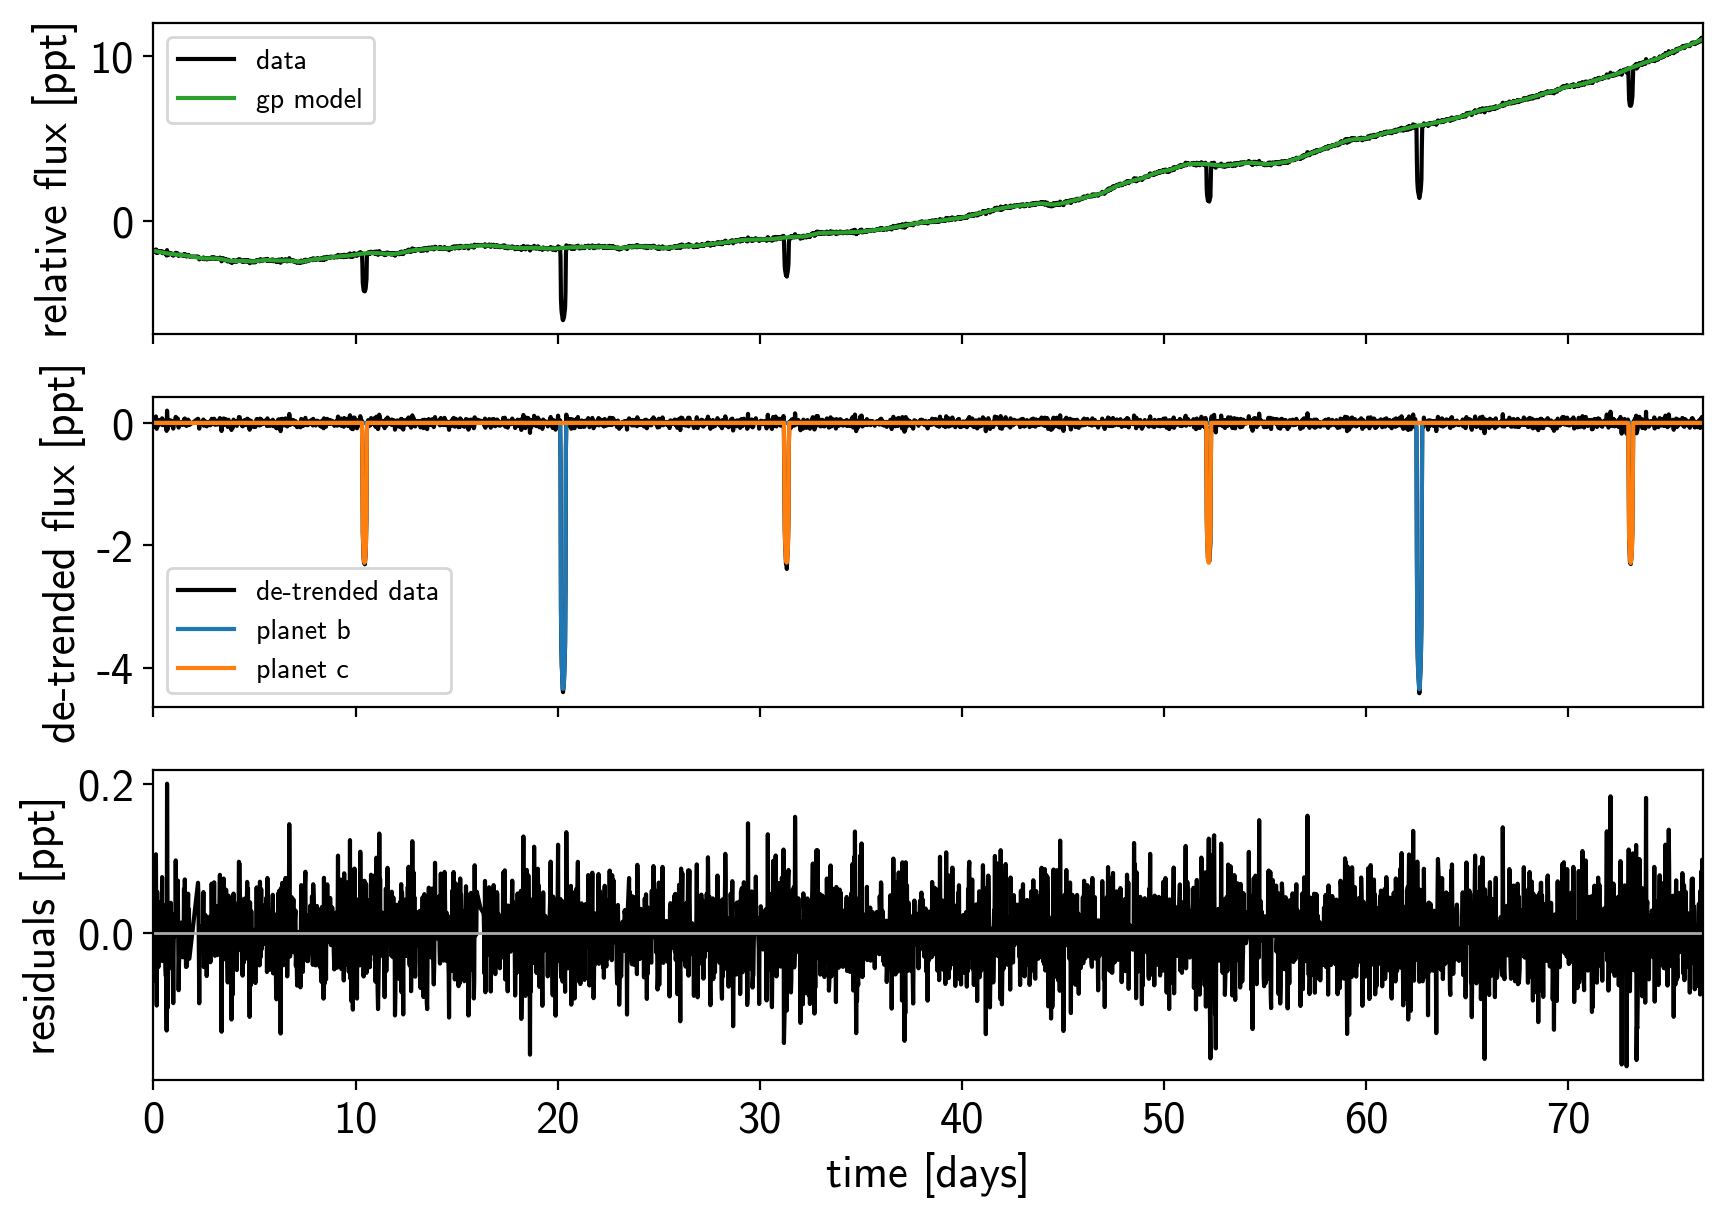

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=200, start=500, finish=1000)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:00<00:11, 175.23draws/s]

Sampling 4 chains:   1%|          | 24/2008 [00:01<01:48, 18.27draws/s] 

Sampling 4 chains:   1%|▏         | 28/2008 [00:02<03:46,  8.76draws/s]

Sampling 4 chains:   2%|▏         | 31/2008 [00:03<05:46,  5.70draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:04<07:13,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:04<05:32,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:05<08:13,  3.99draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:05<06:23,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:06<08:41,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:06<06:49,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:07<08:51,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:07<07:04,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:07<12:36,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:08<09:33,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:08<14:02,  2.32draws/s]

Sampling 4 chains:   3%|▎         | 56/2008 [00:09<10:39,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:09<14:29,  2.24draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:10<11:04,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:10<14:29,  2.24draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:11<11:09,  2.90draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:11<14:14,  2.28draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:12<11:04,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:12<13:52,  2.33draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:13<10:55,  2.95draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:13<13:27,  2.40draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:14<10:43,  3.00draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:14<13:01,  2.47draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:15<10:30,  3.06draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:15<12:34,  2.55draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:16<09:31,  3.37draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:16<08:58,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:16<11:11,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:17<08:56,  3.58draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:17<08:49,  3.63draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:17<10:48,  2.96draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:18<08:39,  3.69draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:18<08:53,  3.59draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:18<10:34,  3.02draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:18<08:29,  3.75draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:19<09:02,  3.52draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:19<10:24,  3.06draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:19<08:22,  3.80draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:20<09:13,  3.44draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:20<10:16,  3.09draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:20<08:15,  3.84draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:21<09:25,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:21<10:07,  3.13draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:21<08:09,  3.88draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:22<09:37,  3.29draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:22<09:59,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:22<08:03,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:23<09:50,  3.21draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:23<09:50,  3.21draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:23<07:56,  3.97draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:24<07:47,  4.04draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:24<08:08,  3.87draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:24<06:52,  4.58draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:25<09:18,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:25<08:55,  3.52draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:25<07:24,  4.24draws/s]

Sampling 4 chains:   6%|▋         | 126/2008 [00:26<09:56,  3.15draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:26<09:05,  3.45draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:26<07:31,  4.16draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:27<10:19,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:27<09:05,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:27<07:20,  4.26draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:27<06:30,  4.80draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:28<09:56,  3.14draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:28<08:35,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:28<07:07,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:29<10:38,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:29<08:47,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:29<07:06,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:29<06:13,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:30<10:16,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:30<08:18,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:30<06:46,  4.58draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:30<05:57,  5.21draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:31<10:22,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:31<08:10,  3.79draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:31<06:51,  4.52draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:32<11:18,  2.74draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:32<08:41,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 154/2008 [00:32<06:36,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:33<08:07,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:33<07:06,  4.34draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:34<08:48,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:34<06:55,  4.45draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:35<08:38,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:35<06:47,  4.52draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:36<08:32,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:36<06:44,  4.55draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:36<05:24,  5.66draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:37<09:53,  3.09draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:37<07:41,  3.98draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:37<06:45,  4.52draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:38<10:48,  2.82draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:38<08:42,  3.50draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:38<06:59,  4.36draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:39<10:57,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:39<09:02,  3.37draws/s]

Sampling 4 chains:   9%|▉         | 183/2008 [00:39<07:05,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:40<11:00,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:40<09:24,  3.23draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:40<07:11,  4.22draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:41<11:08,  2.72draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:41<09:26,  3.21draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:41<07:11,  4.21draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:42<11:06,  2.72draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:42<09:27,  3.20draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:42<07:10,  4.21draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:43<11:09,  2.71draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:43<09:28,  3.19draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:43<07:11,  4.20draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:44<11:06,  2.71draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:44<09:29,  3.17draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:44<07:37,  3.95draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:45<08:24,  3.57draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:45<07:38,  3.93draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:45<06:23,  4.70draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:46<07:31,  3.99draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:46<06:59,  4.29draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:46<05:52,  5.10draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:47<07:09,  4.18draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:47<06:47,  4.41draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:47<05:40,  5.27draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:48<07:00,  4.26draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:48<06:42,  4.45draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:48<05:39,  5.26draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:49<09:03,  3.29draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:49<08:07,  3.67draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:49<06:35,  4.51draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:49<05:54,  5.03draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:50<08:54,  3.34draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:50<08:03,  3.69draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:50<06:51,  4.33draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:51<09:16,  3.20draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:51<08:20,  3.56draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:51<07:10,  4.13draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:52<09:35,  3.09draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:52<08:15,  3.59draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:52<07:14,  4.08draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:53<09:20,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:53<08:05,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:53<07:13,  4.08draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:54<09:06,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:54<07:59,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:54<07:13,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:55<08:54,  3.30draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:55<07:51,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:55<07:12,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:56<08:39,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 249/2008 [00:56<07:45,  3.78draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:56<07:14,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:57<08:29,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:57<07:34,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:57<07:12,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:58<08:15,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:58<07:25,  3.93draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:58<07:11,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:59<08:01,  3.63draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:59<07:19,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:59<07:10,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [01:00<07:48,  3.73draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [01:00<07:11,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [01:00<07:10,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [01:01<07:41,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [01:01<07:00,  4.14draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [01:01<07:10,  4.04draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [01:02<07:24,  3.90draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [01:02<06:46,  4.27draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [01:02<07:08,  4.05draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [01:03<07:09,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [01:03<06:30,  4.43draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [01:03<07:05,  4.06draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [01:04<06:57,  4.14draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [01:04<06:14,  4.62draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [01:04<07:02,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [01:05<06:41,  4.29draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [01:05<05:59,  4.80draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [01:05<07:00,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [01:06<06:26,  4.46draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [01:06<05:43,  5.00draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [01:06<06:59,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [01:07<06:09,  4.64draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [01:07<05:28,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [01:07<06:55,  4.13draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [01:08<05:54,  4.83draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [01:08<05:15,  5.42draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [01:09<06:52,  4.14draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [01:09<05:40,  5.01draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [01:09<05:03,  5.63draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [01:10<06:50,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [01:10<05:38,  5.03draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [01:10<04:49,  5.88draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [01:11<09:21,  3.03draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [01:11<07:16,  3.90draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [01:11<06:03,  4.68draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [01:12<10:22,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [01:12<07:52,  3.59draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [01:12<06:31,  4.33draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [01:13<10:52,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [01:13<08:04,  3.49draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [01:13<06:44,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [01:14<11:08,  2.53draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [01:14<08:13,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [01:15<09:27,  2.97draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [01:15<07:06,  3.95draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [01:16<08:36,  3.26draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [01:16<06:29,  4.31draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [01:16<08:12,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [01:17<06:10,  4.53draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [01:17<07:59,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [01:18<06:00,  4.64draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [01:18<07:54,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [01:19<05:58,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [01:19<07:50,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [01:20<06:00,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [01:20<07:45,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [01:21<06:03,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [01:21<05:04,  5.44draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [01:21<09:35,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [01:22<07:26,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [01:22<08:32,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [01:23<06:47,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [01:23<07:58,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [01:24<06:29,  4.23draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [01:24<07:39,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [01:25<06:21,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [01:25<07:30,  3.64draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [01:26<06:18,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [01:26<07:22,  3.70draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [01:27<06:17,  4.33draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [01:27<07:16,  3.74draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [01:28<06:14,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [01:28<07:14,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [01:29<06:12,  4.37draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [01:29<07:11,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [01:30<06:11,  4.37draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [01:30<07:08,  3.79draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [01:31<06:11,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:31<07:06,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [01:32<06:11,  4.35draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:32<07:04,  3.80draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:33<06:10,  4.34draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [01:33<05:15,  5.10draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [01:33<08:10,  3.28draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [01:34<06:58,  3.84draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [01:34<05:58,  4.48draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [01:34<08:30,  3.14draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [01:35<07:11,  3.71draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [01:35<06:17,  4.25draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [01:35<08:35,  3.10draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [01:36<07:14,  3.68draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [01:36<06:27,  4.12draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [01:36<08:32,  3.12draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [01:37<07:12,  3.69draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [01:37<06:36,  4.02draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [01:37<08:27,  3.14draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [01:37<07:08,  3.71draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [01:38<06:58,  3.80draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [01:38<08:16,  3.20draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:38<07:01,  3.77draws/s]

Sampling 4 chains:  21%|██        | 422/2008 [01:39<07:08,  3.71draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [01:39<08:05,  3.27draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:39<06:54,  3.82draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [01:40<07:23,  3.57draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [01:40<07:50,  3.36draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:40<06:47,  3.87draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [01:41<07:25,  3.54draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [01:41<07:37,  3.45draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:41<06:40,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [01:42<07:29,  3.51draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [01:42<07:26,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:42<06:34,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [01:43<07:33,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [01:43<07:15,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:43<06:29,  4.03draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [01:44<07:38,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [01:44<07:05,  3.68draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:44<06:23,  4.07draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [01:45<07:43,  3.37draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [01:45<06:54,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:45<06:18,  4.12draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [01:46<07:48,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [01:46<06:44,  3.85draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [01:46<06:13,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [01:47<07:53,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [01:47<06:33,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [01:47<06:07,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [01:48<08:02,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [01:48<06:25,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [01:48<06:02,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [01:49<08:08,  3.17draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [01:49<06:11,  4.15draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [01:49<07:02,  3.66draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [01:50<08:59,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [01:50<06:41,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [01:50<07:26,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [01:51<09:23,  2.73draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:51<07:41,  3.32draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [01:52<09:34,  2.67draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:52<07:48,  3.27draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:53<09:35,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:53<07:50,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:54<09:31,  2.67draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:54<07:49,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [01:55<09:26,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [01:55<06:59,  3.62draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:55<07:38,  3.32draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [01:56<09:14,  2.74draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [01:56<06:57,  3.63draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:56<07:27,  3.39draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [01:57<09:02,  2.79draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [01:57<06:55,  3.64draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [01:57<07:16,  3.46draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [01:58<08:51,  2.84draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:58<06:54,  3.64draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [01:58<07:04,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:59<08:38,  2.90draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [01:59<06:49,  3.68draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:59<05:38,  4.44draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:59<06:02,  4.15draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [02:00<07:50,  3.19draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [02:00<06:17,  3.98draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [02:00<05:30,  4.53draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [02:00<05:43,  4.36draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [02:01<07:35,  3.29draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [02:01<06:06,  4.09draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [02:01<05:34,  4.47draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [02:01<05:36,  4.44draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [02:02<07:25,  3.35draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [02:02<06:02,  4.12draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [02:02<05:41,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [02:02<05:32,  4.49draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [02:03<07:18,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [02:03<05:58,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [02:03<05:50,  4.25draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [02:03<05:28,  4.53draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [02:04<07:11,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [02:04<05:55,  4.18draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [02:04<05:59,  4.13draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [02:04<05:27,  4.53draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [02:05<07:04,  3.49draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [02:05<05:53,  4.18draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [02:05<06:06,  4.04draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [02:05<05:24,  4.56draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [02:06<06:57,  3.54draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [02:06<05:50,  4.22draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [02:06<06:15,  3.93draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [02:06<05:20,  4.60draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [02:07<06:50,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [02:07<05:47,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [02:07<06:23,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [02:07<05:17,  4.64draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [02:08<06:44,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [02:08<05:46,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [02:08<06:31,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [02:09<06:22,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [02:09<05:32,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [02:09<06:33,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [02:10<06:16,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [02:10<05:33,  4.38draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [02:10<06:41,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [02:10<06:15,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [02:11<05:36,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [02:11<06:51,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [02:11<06:16,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [02:12<05:38,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [02:12<07:05,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [02:12<06:19,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [02:13<05:40,  4.26draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [02:13<07:11,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [02:13<06:19,  3.81draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [02:14<05:44,  4.19draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [02:14<07:14,  3.33draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [02:14<06:19,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [02:15<05:46,  4.16draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [02:15<07:16,  3.30draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [02:15<06:18,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [02:16<05:48,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [02:16<07:19,  3.27draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [02:16<06:18,  3.79draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [02:17<05:51,  4.08draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [02:17<07:20,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [02:17<06:17,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [02:18<05:52,  4.05draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [02:18<07:22,  3.23draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [02:18<05:56,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [02:18<05:36,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [02:19<05:25,  4.37draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [02:19<07:06,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [02:19<05:52,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [02:19<05:21,  4.43draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [02:20<05:18,  4.46draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [02:20<07:02,  3.36draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [02:20<05:56,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [02:20<05:10,  4.56draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [02:20<05:14,  4.51draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [02:21<07:00,  3.37draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [02:21<06:03,  3.89draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [02:21<05:02,  4.67draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [02:21<05:10,  4.55draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [02:22<06:58,  3.37draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [02:22<06:10,  3.80draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [02:22<05:28,  4.29draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [02:23<07:11,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [02:23<06:27,  3.63draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [02:23<05:34,  4.20draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [02:24<07:16,  3.22draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [02:24<06:40,  3.51draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [02:24<05:39,  4.13draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [02:25<07:19,  3.19draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [02:25<06:47,  3.43draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [02:25<05:40,  4.10draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [02:26<07:20,  3.17draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [02:26<06:43,  3.46draws/s]

Sampling 4 chains:  31%|███       | 615/2008 [02:26<05:38,  4.11draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [02:27<07:20,  3.16draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [02:27<06:39,  3.48draws/s]

Sampling 4 chains:  31%|███       | 619/2008 [02:27<05:36,  4.12draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [02:28<07:20,  3.15draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [02:28<06:35,  3.51draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [02:28<05:35,  4.13draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [02:29<07:19,  3.15draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [02:29<06:31,  3.54draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [02:29<05:26,  4.23draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [02:29<04:54,  4.69draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [02:30<06:52,  3.35draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [02:30<06:11,  3.72draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [02:30<05:24,  4.25draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [02:30<04:40,  4.91draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [02:31<06:43,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [02:31<05:21,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [02:31<05:00,  4.56draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [02:31<04:15,  5.38draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [02:32<06:36,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [02:32<05:41,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [02:32<05:25,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [02:33<05:55,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [02:33<05:08,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [02:33<05:13,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [02:34<05:42,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [02:34<04:55,  4.61draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [02:34<05:16,  4.30draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [02:35<05:39,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [02:35<04:49,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [02:35<05:24,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [02:36<05:40,  3.98draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [02:36<04:45,  4.74draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [02:36<05:25,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [02:37<05:41,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [02:37<04:42,  4.78draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [02:37<05:26,  4.13draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [02:38<05:41,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [02:38<05:23,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [02:39<05:40,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [02:39<05:21,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [02:40<05:39,  3.94draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [02:40<05:20,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [02:40<04:28,  4.97draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [02:41<06:13,  3.57draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [02:41<05:42,  3.89draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [02:41<04:54,  4.53draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [02:42<06:23,  3.47draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [02:42<05:47,  3.82draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [02:42<05:09,  4.30draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [02:43<06:25,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [02:43<05:46,  3.82draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [02:43<05:18,  4.15draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [02:44<06:23,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [02:44<05:45,  3.83draws/s]

Sampling 4 chains:  34%|███▍      | 688/2008 [02:44<05:25,  4.05draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [02:45<06:20,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [02:45<05:41,  3.85draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [02:45<05:33,  3.94draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [02:46<06:17,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [02:46<05:38,  3.88draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [02:46<05:41,  3.84draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [02:47<06:14,  3.50draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [02:47<05:35,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [02:47<05:47,  3.77draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [02:48<06:11,  3.52draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [02:48<05:31,  3.94draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [02:48<05:56,  3.65draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [02:49<06:04,  3.57draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [02:49<05:26,  3.99draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [02:49<06:03,  3.58draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [02:50<05:57,  3.63draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [02:50<05:22,  4.02draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [02:50<06:08,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [02:51<05:49,  3.70draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [02:51<05:17,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [02:51<06:14,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [02:52<05:42,  3.77draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [02:52<05:12,  4.12draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [02:52<06:20,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [02:53<05:35,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [02:53<05:09,  4.15draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [02:53<06:25,  3.33draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [02:54<05:28,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [02:54<05:04,  4.21draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [02:54<06:31,  3.27draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [02:55<05:21,  3.98draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [02:55<04:59,  4.26draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [02:55<06:37,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [02:56<05:10,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [02:56<05:40,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [02:56<07:14,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 738/2008 [02:57<05:31,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [02:57<05:53,  3.59draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [02:57<07:32,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [02:58<05:40,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [02:58<05:57,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [02:58<07:44,  2.72draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [02:59<05:45,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [02:59<05:58,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [02:59<07:45,  2.71draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [03:00<05:46,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [03:00<05:56,  3.53draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [03:00<07:42,  2.72draws/s]

Sampling 4 chains:  38%|███▊      | 754/2008 [03:01<05:45,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [03:01<05:53,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [03:01<07:38,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [03:01<05:44,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [03:02<05:55,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [03:02<07:33,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [03:02<05:56,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [03:03<05:10,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [03:03<06:59,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [03:03<05:43,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [03:04<04:57,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [03:04<06:48,  3.04draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [03:04<05:42,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [03:05<04:54,  4.21draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [03:05<06:42,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [03:05<05:40,  3.62draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [03:06<04:51,  4.22draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [03:06<06:41,  3.07draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [03:06<05:40,  3.61draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [03:07<04:50,  4.22draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [03:07<06:38,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [03:07<05:41,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [03:08<04:51,  4.21draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [03:08<06:35,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [03:08<05:41,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [03:09<04:36,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [03:09<04:18,  4.72draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [03:09<07:18,  2.78draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [03:10<05:52,  3.46draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [03:10<05:02,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [03:10<07:50,  2.59draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [03:11<06:21,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [03:11<05:15,  3.85draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [03:12<08:59,  2.25draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [03:12<06:56,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [03:12<07:53,  2.56draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [03:13<07:56,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [03:14<11:39,  1.73draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [03:14<12:50,  1.57draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [03:15<10:22,  1.94draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [03:16<13:20,  1.51draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [03:16<10:46,  1.86draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [03:17<10:42,  1.87draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [03:18<17:42,  1.13draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [03:19<19:43,  1.02draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [03:20<16:33,  1.21draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [03:21<15:28,  1.29draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [03:22<20:31,  1.03s/draws]

Sampling 4 chains:  40%|████      | 810/2008 [03:23<21:35,  1.08s/draws]

Sampling 4 chains:  40%|████      | 811/2008 [03:24<17:40,  1.13draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [03:25<16:59,  1.17draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [03:26<21:01,  1.06s/draws]

Sampling 4 chains:  41%|████      | 814/2008 [03:27<21:49,  1.10s/draws]

Sampling 4 chains:  41%|████      | 815/2008 [03:28<17:42,  1.12draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [03:29<17:43,  1.12draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [03:30<21:01,  1.06s/draws]

Sampling 4 chains:  41%|████      | 818/2008 [03:31<21:40,  1.09s/draws]

Sampling 4 chains:  41%|████      | 819/2008 [03:32<17:27,  1.13draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [03:33<18:14,  1.09draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [03:34<20:54,  1.06s/draws]

Sampling 4 chains:  41%|████      | 822/2008 [03:35<21:28,  1.09s/draws]

Sampling 4 chains:  41%|████      | 823/2008 [03:36<17:15,  1.14draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [03:37<18:45,  1.05draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [03:38<20:43,  1.05s/draws]

Sampling 4 chains:  41%|████      | 826/2008 [03:39<21:12,  1.08s/draws]

Sampling 4 chains:  41%|████      | 827/2008 [03:39<16:55,  1.16draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [03:41<19:12,  1.02draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [03:42<20:31,  1.04s/draws]

Sampling 4 chains:  41%|████▏     | 830/2008 [03:43<20:54,  1.06s/draws]

Sampling 4 chains:  41%|████▏     | 831/2008 [03:43<16:40,  1.18draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [03:45<19:40,  1.00s/draws]

Sampling 4 chains:  41%|████▏     | 833/2008 [03:46<20:19,  1.04s/draws]

Sampling 4 chains:  42%|████▏     | 834/2008 [03:47<20:43,  1.06s/draws]

Sampling 4 chains:  42%|████▏     | 835/2008 [03:47<16:21,  1.20draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [03:49<20:08,  1.03s/draws]

Sampling 4 chains:  42%|████▏     | 837/2008 [03:50<20:06,  1.03s/draws]

Sampling 4 chains:  42%|████▏     | 838/2008 [03:51<20:28,  1.05s/draws]

Sampling 4 chains:  42%|████▏     | 839/2008 [03:51<16:04,  1.21draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [03:53<20:36,  1.06s/draws]

Sampling 4 chains:  42%|████▏     | 841/2008 [03:54<19:52,  1.02s/draws]

Sampling 4 chains:  42%|████▏     | 842/2008 [03:55<20:13,  1.04s/draws]

Sampling 4 chains:  42%|████▏     | 843/2008 [03:55<15:48,  1.23draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [03:57<21:05,  1.09s/draws]

Sampling 4 chains:  42%|████▏     | 845/2008 [03:58<19:49,  1.02s/draws]

Sampling 4 chains:  42%|████▏     | 846/2008 [03:59<19:59,  1.03s/draws]

Sampling 4 chains:  42%|████▏     | 847/2008 [03:59<15:32,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [04:01<21:36,  1.12s/draws]

Sampling 4 chains:  42%|████▏     | 849/2008 [04:02<19:27,  1.01s/draws]

Sampling 4 chains:  42%|████▏     | 850/2008 [04:03<19:46,  1.02s/draws]

Sampling 4 chains:  42%|████▏     | 851/2008 [04:03<15:23,  1.25draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [04:05<22:02,  1.14s/draws]

Sampling 4 chains:  42%|████▏     | 853/2008 [04:06<19:09,  1.00draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [04:07<19:30,  1.01s/draws]

Sampling 4 chains:  43%|████▎     | 855/2008 [04:07<15:07,  1.27draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [04:09<22:29,  1.17s/draws]

Sampling 4 chains:  43%|████▎     | 857/2008 [04:09<18:39,  1.03draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [04:11<19:19,  1.01s/draws]

Sampling 4 chains:  43%|████▎     | 859/2008 [04:11<14:52,  1.29draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [04:13<23:00,  1.20s/draws]

Sampling 4 chains:  43%|████▎     | 861/2008 [04:13<18:06,  1.06draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [04:14<19:13,  1.01s/draws]

Sampling 4 chains:  43%|████▎     | 863/2008 [04:15<14:43,  1.30draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [04:17<23:31,  1.23s/draws]

Sampling 4 chains:  43%|████▎     | 865/2008 [04:17<17:34,  1.08draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [04:18<19:09,  1.01s/draws]

Sampling 4 chains:  43%|████▎     | 867/2008 [04:19<14:32,  1.31draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [04:21<24:00,  1.26s/draws]

Sampling 4 chains:  43%|████▎     | 870/2008 [04:22<20:28,  1.08s/draws]

Sampling 4 chains:  43%|████▎     | 871/2008 [04:23<15:22,  1.23draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [04:25<24:39,  1.30s/draws]

Sampling 4 chains:  44%|████▎     | 874/2008 [04:26<20:54,  1.11s/draws]

Sampling 4 chains:  44%|████▎     | 875/2008 [04:26<15:33,  1.21draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [04:29<24:33,  1.30s/draws]

Sampling 4 chains:  44%|████▎     | 877/2008 [04:29<18:32,  1.02draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [04:30<19:11,  1.02s/draws]

Sampling 4 chains:  44%|████▍     | 879/2008 [04:30<14:20,  1.31draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [04:33<23:28,  1.25s/draws]

Sampling 4 chains:  44%|████▍     | 881/2008 [04:33<18:31,  1.01draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [04:34<18:37,  1.01draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [04:34<13:50,  1.35draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [04:37<22:57,  1.23s/draws]

Sampling 4 chains:  44%|████▍     | 885/2008 [04:37<18:54,  1.01s/draws]

Sampling 4 chains:  44%|████▍     | 886/2008 [04:38<18:19,  1.02draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [04:38<13:33,  1.38draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [04:41<22:31,  1.21s/draws]

Sampling 4 chains:  44%|████▍     | 889/2008 [04:41<19:24,  1.04s/draws]

Sampling 4 chains:  44%|████▍     | 890/2008 [04:42<18:05,  1.03draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [04:42<13:18,  1.40draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [04:44<22:10,  1.19s/draws]

Sampling 4 chains:  44%|████▍     | 893/2008 [04:45<19:54,  1.07s/draws]

Sampling 4 chains:  45%|████▍     | 894/2008 [04:46<17:54,  1.04draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [04:46<13:05,  1.42draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [04:48<21:46,  1.18s/draws]

Sampling 4 chains:  45%|████▍     | 897/2008 [04:49<20:27,  1.11s/draws]

Sampling 4 chains:  45%|████▍     | 898/2008 [04:50<17:44,  1.04draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [04:52<18:48,  1.02s/draws]

Sampling 4 chains:  45%|████▍     | 901/2008 [04:53<19:11,  1.04s/draws]

Sampling 4 chains:  45%|████▍     | 902/2008 [04:54<16:16,  1.13draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [04:56<17:39,  1.04draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [04:57<19:12,  1.04s/draws]

Sampling 4 chains:  45%|████▌     | 906/2008 [04:58<15:42,  1.17draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [05:00<17:05,  1.07draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [05:01<19:37,  1.07s/draws]

Sampling 4 chains:  45%|████▌     | 910/2008 [05:02<15:25,  1.19draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [05:04<16:43,  1.09draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [05:05<20:11,  1.11s/draws]

Sampling 4 chains:  46%|████▌     | 914/2008 [05:06<15:14,  1.20draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [05:08<16:26,  1.11draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [05:09<20:47,  1.14s/draws]

Sampling 4 chains:  46%|████▌     | 919/2008 [05:09<14:49,  1.22draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [05:12<21:37,  1.19s/draws]

Sampling 4 chains:  46%|████▌     | 921/2008 [05:13<25:06,  1.39s/draws]

Sampling 4 chains:  46%|████▌     | 924/2008 [05:15<21:12,  1.17s/draws]

Sampling 4 chains:  46%|████▌     | 925/2008 [05:17<24:57,  1.38s/draws]

Sampling 4 chains:  46%|████▌     | 927/2008 [05:17<17:48,  1.01draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [05:19<22:32,  1.25s/draws]

Sampling 4 chains:  46%|████▋     | 929/2008 [05:21<26:02,  1.45s/draws]

Sampling 4 chains:  46%|████▋     | 931/2008 [05:21<18:53,  1.05s/draws]

Sampling 4 chains:  46%|████▋     | 932/2008 [05:23<22:25,  1.25s/draws]

Sampling 4 chains:  46%|████▋     | 933/2008 [05:25<26:02,  1.45s/draws]

Sampling 4 chains:  47%|████▋     | 935/2008 [05:26<19:13,  1.08s/draws]

Sampling 4 chains:  47%|████▋     | 936/2008 [05:27<21:49,  1.22s/draws]

Sampling 4 chains:  47%|████▋     | 937/2008 [05:29<25:46,  1.44s/draws]

Sampling 4 chains:  47%|████▋     | 939/2008 [05:30<19:22,  1.09s/draws]

Sampling 4 chains:  47%|████▋     | 940/2008 [05:31<21:02,  1.18s/draws]

Sampling 4 chains:  47%|████▋     | 941/2008 [05:33<25:20,  1.43s/draws]

Sampling 4 chains:  47%|████▋     | 942/2008 [05:33<18:16,  1.03s/draws]

Sampling 4 chains:  47%|████▋     | 943/2008 [05:34<15:35,  1.14draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [05:35<17:33,  1.01draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [05:37<23:04,  1.30s/draws]

Sampling 4 chains:  47%|████▋     | 946/2008 [05:37<16:45,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [05:38<15:03,  1.17draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [05:39<16:23,  1.08draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [05:41<22:21,  1.27s/draws]

Sampling 4 chains:  47%|████▋     | 950/2008 [05:41<16:18,  1.08draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [05:42<15:17,  1.15draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [05:43<15:44,  1.12draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [05:45<22:01,  1.25s/draws]

Sampling 4 chains:  48%|████▊     | 954/2008 [05:45<16:11,  1.09draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [05:46<15:44,  1.12draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [05:46<15:14,  1.15draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [05:49<21:46,  1.24s/draws]

Sampling 4 chains:  48%|████▊     | 958/2008 [05:49<16:09,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [05:50<16:09,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [05:50<14:46,  1.18draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [05:52<21:33,  1.24s/draws]

Sampling 4 chains:  48%|████▊     | 962/2008 [05:53<16:06,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [05:54<16:37,  1.05draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [05:54<14:17,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [05:56<21:20,  1.23s/draws]

Sampling 4 chains:  48%|████▊     | 966/2008 [05:57<16:05,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [05:58<17:06,  1.01draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [05:58<13:49,  1.25draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [06:00<21:08,  1.22s/draws]

Sampling 4 chains:  48%|████▊     | 970/2008 [06:01<16:02,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [06:02<17:33,  1.02s/draws]

Sampling 4 chains:  48%|████▊     | 972/2008 [06:02<13:21,  1.29draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [06:04<20:55,  1.21s/draws]

Sampling 4 chains:  49%|████▊     | 974/2008 [06:04<15:57,  1.08draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [06:06<17:59,  1.05s/draws]

Sampling 4 chains:  49%|████▊     | 977/2008 [06:08<18:33,  1.08s/draws]

Sampling 4 chains:  49%|████▊     | 978/2008 [06:08<14:27,  1.19draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [06:10<16:58,  1.01draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [06:12<17:42,  1.03s/draws]

Sampling 4 chains:  49%|████▉     | 982/2008 [06:12<14:00,  1.22draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [06:14<16:21,  1.04draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [06:14<12:37,  1.35draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [06:16<19:28,  1.14s/draws]

Sampling 4 chains:  49%|████▉     | 986/2008 [06:16<15:22,  1.11draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [06:18<16:58,  1.00draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [06:18<13:50,  1.23draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [06:20<19:40,  1.16s/draws]

Sampling 4 chains:  49%|████▉     | 990/2008 [06:20<15:34,  1.09draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [06:21<16:50,  1.01draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [06:22<14:29,  1.17draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [06:24<19:29,  1.15s/draws]

Sampling 4 chains:  50%|████▉     | 994/2008 [06:24<15:33,  1.09draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [06:25<16:32,  1.02draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [06:26<15:01,  1.12draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [06:28<19:14,  1.14s/draws]

Sampling 4 chains:  50%|████▉     | 998/2008 [06:28<15:27,  1.09draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [06:29<16:12,  1.04draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [06:30<15:34,  1.08draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [06:32<18:58,  1.13s/draws]

Sampling 4 chains:  50%|████▉     | 1002/2008 [06:32<15:21,  1.09draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [06:33<15:49,  1.06draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [06:34<16:04,  1.04draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [06:35<18:41,  1.12s/draws]

Sampling 4 chains:  50%|█████     | 1006/2008 [06:36<15:16,  1.09draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [06:37<15:27,  1.08draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [06:38<16:34,  1.01draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [06:39<18:25,  1.11s/draws]

Sampling 4 chains:  50%|█████     | 1010/2008 [06:40<15:10,  1.10draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [06:41<15:05,  1.10draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [06:42<17:02,  1.03s/draws]

Sampling 4 chains:  50%|█████     | 1013/2008 [06:43<18:07,  1.09s/draws]

Sampling 4 chains:  50%|█████     | 1014/2008 [06:44<15:01,  1.10draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [06:45<14:42,  1.13draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [06:46<17:31,  1.06s/draws]

Sampling 4 chains:  51%|█████     | 1017/2008 [06:47<17:50,  1.08s/draws]

Sampling 4 chains:  51%|█████     | 1018/2008 [06:48<15:00,  1.10draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [06:49<14:18,  1.15draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [06:50<18:00,  1.09s/draws]

Sampling 4 chains:  51%|█████     | 1021/2008 [06:51<17:34,  1.07s/draws]

Sampling 4 chains:  51%|█████     | 1022/2008 [06:52<14:53,  1.10draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [06:52<13:55,  1.18draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [06:54<18:29,  1.13s/draws]

Sampling 4 chains:  51%|█████     | 1025/2008 [06:55<17:16,  1.05s/draws]

Sampling 4 chains:  51%|█████     | 1026/2008 [06:56<14:48,  1.11draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [06:56<13:34,  1.20draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [06:58<18:57,  1.16s/draws]

Sampling 4 chains:  51%|█████     | 1029/2008 [06:59<17:02,  1.04s/draws]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [07:00<14:39,  1.11draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [07:00<13:12,  1.23draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [07:02<19:26,  1.20s/draws]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [07:03<16:45,  1.03s/draws]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [07:03<14:36,  1.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [07:04<12:49,  1.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [07:06<19:53,  1.23s/draws]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [07:07<16:29,  1.02s/draws]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [07:07<14:30,  1.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [07:08<12:29,  1.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [07:10<20:18,  1.26s/draws]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [07:11<16:13,  1.01s/draws]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [07:11<14:23,  1.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [07:12<12:06,  1.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [07:14<20:47,  1.29s/draws]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [07:15<15:59,  1.00draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [07:15<14:17,  1.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [07:16<11:42,  1.37draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [07:18<21:14,  1.33s/draws]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [07:18<15:42,  1.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [07:19<14:16,  1.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [07:19<11:19,  1.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [07:22<21:42,  1.36s/draws]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [07:23<16:59,  1.07s/draws]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [07:23<12:54,  1.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [07:26<23:12,  1.46s/draws]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [07:27<17:58,  1.13s/draws]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [07:27<13:15,  1.19draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [07:30<23:35,  1.49s/draws]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [07:30<17:23,  1.10s/draws]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [07:31<14:53,  1.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [07:34<17:48,  1.13s/draws]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [07:34<13:57,  1.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [07:35<11:58,  1.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [07:38<15:41,  1.00s/draws]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [07:38<13:02,  1.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [07:39<10:44,  1.45draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [07:42<14:47,  1.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [07:42<13:00,  1.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [07:43<09:58,  1.56draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [07:46<14:17,  1.09draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [07:47<13:12,  1.17draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [07:47<09:40,  1.60draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [07:50<20:46,  1.34s/draws]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [07:50<17:41,  1.15s/draws]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [07:51<13:00,  1.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [07:54<16:12,  1.05s/draws]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [07:54<14:18,  1.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [07:55<11:18,  1.36draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [07:58<14:44,  1.04draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [07:58<13:05,  1.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [07:58<10:46,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [07:59<08:05,  1.89draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [08:01<18:36,  1.22s/draws]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [08:02<15:35,  1.02s/draws]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [08:02<12:46,  1.19draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [08:03<09:58,  1.53draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [08:05<19:18,  1.27s/draws]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [08:06<15:55,  1.05s/draws]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [08:06<13:15,  1.14draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [08:07<10:45,  1.41draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [08:09<19:15,  1.27s/draws]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [08:10<15:43,  1.04s/draws]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [08:10<13:19,  1.13draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [08:11<11:16,  1.34draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [08:13<18:59,  1.26s/draws]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [08:14<15:21,  1.02s/draws]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [08:14<13:20,  1.13draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [08:15<11:45,  1.28draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [08:17<18:42,  1.25s/draws]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [08:17<14:59,  1.00s/draws]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [08:18<13:21,  1.12draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [08:19<12:11,  1.23draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [08:21<18:25,  1.23s/draws]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [08:21<14:39,  1.02draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [08:22<13:32,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [08:23<12:33,  1.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [08:25<18:05,  1.22s/draws]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [08:25<14:16,  1.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [08:26<13:29,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [08:27<12:57,  1.14draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [08:29<17:46,  1.20s/draws]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [08:29<13:52,  1.06draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [08:30<13:27,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [08:31<13:22,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [08:33<17:27,  1.19s/draws]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [08:33<13:30,  1.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [08:34<13:25,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [08:35<13:51,  1.06draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [08:37<17:11,  1.17s/draws]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [08:37<13:10,  1.11draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [08:38<13:23,  1.09draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [08:39<14:34,  1.00draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [08:41<16:48,  1.15s/draws]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [08:41<12:45,  1.14draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [08:42<13:17,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [08:43<15:12,  1.04s/draws]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [08:44<16:26,  1.13s/draws]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [08:45<12:28,  1.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [08:46<13:08,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [08:47<15:43,  1.09s/draws]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [08:48<16:02,  1.11s/draws]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [08:49<12:10,  1.19draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [08:50<13:04,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [08:51<16:03,  1.11s/draws]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [08:52<15:37,  1.09s/draws]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [08:52<11:55,  1.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [08:54<13:00,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [08:55<16:25,  1.15s/draws]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [08:56<15:17,  1.07s/draws]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [08:56<11:39,  1.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [08:57<12:54,  1.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [08:59<16:48,  1.18s/draws]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [09:00<14:57,  1.05s/draws]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [09:00<11:23,  1.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [09:01<12:51,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [09:03<17:09,  1.21s/draws]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [09:04<14:38,  1.03s/draws]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [09:04<11:08,  1.27draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [09:05<12:49,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [09:07<17:29,  1.24s/draws]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [09:08<14:20,  1.01s/draws]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [09:08<10:54,  1.29draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [09:09<12:46,  1.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [09:11<17:49,  1.27s/draws]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [09:12<14:01,  1.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [09:12<10:39,  1.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [09:13<12:42,  1.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [09:15<18:09,  1.30s/draws]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [09:16<13:43,  1.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [09:16<10:25,  1.34draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [09:17<12:38,  1.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [09:19<18:30,  1.33s/draws]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [09:20<13:26,  1.04draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [09:20<10:11,  1.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [09:21<12:34,  1.11draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [09:23<18:48,  1.35s/draws]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [09:24<13:31,  1.02draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [09:25<14:59,  1.08s/draws]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [09:27<20:20,  1.47s/draws]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [09:28<14:47,  1.07s/draws]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [09:29<13:14,  1.04draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [09:31<19:01,  1.38s/draws]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [09:31<13:59,  1.02s/draws]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [09:33<12:37,  1.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [09:35<18:27,  1.35s/draws]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [09:35<13:33,  1.01draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [09:36<10:26,  1.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [09:37<12:08,  1.12draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [09:39<17:59,  1.32s/draws]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [09:39<13:12,  1.03draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [09:40<10:43,  1.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [09:41<11:53,  1.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [09:43<17:40,  1.30s/draws]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [09:43<12:56,  1.05draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [09:44<11:05,  1.22draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [09:45<11:41,  1.15draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [09:47<17:24,  1.29s/draws]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [09:47<12:43,  1.06draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [09:48<11:27,  1.17draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [09:49<11:32,  1.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [09:51<17:07,  1.28s/draws]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [09:51<12:31,  1.07draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [09:52<11:48,  1.13draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [09:52<11:21,  1.18draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [09:55<16:53,  1.26s/draws]

Sampling 4 chains:  60%|██████    | 1208/2008 [09:55<12:20,  1.08draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [09:56<12:11,  1.09draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [09:56<11:11,  1.19draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [09:59<16:38,  1.25s/draws]

Sampling 4 chains:  60%|██████    | 1212/2008 [09:59<12:08,  1.09draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [10:00<12:33,  1.06draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [10:00<10:58,  1.21draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [10:03<16:22,  1.24s/draws]

Sampling 4 chains:  61%|██████    | 1216/2008 [10:03<11:56,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [10:04<12:54,  1.02draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [10:04<10:48,  1.22draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [10:06<16:08,  1.23s/draws]

Sampling 4 chains:  61%|██████    | 1220/2008 [10:07<11:44,  1.12draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [10:08<13:15,  1.01s/draws]

Sampling 4 chains:  61%|██████    | 1222/2008 [10:08<10:37,  1.23draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [10:10<15:53,  1.22s/draws]

Sampling 4 chains:  61%|██████    | 1224/2008 [10:10<11:33,  1.13draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [10:12<13:35,  1.04s/draws]

Sampling 4 chains:  61%|██████    | 1226/2008 [10:12<10:26,  1.25draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [10:14<15:39,  1.20s/draws]

Sampling 4 chains:  61%|██████    | 1228/2008 [10:14<11:22,  1.14draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [10:16<13:56,  1.07s/draws]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [10:16<10:16,  1.26draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [10:18<15:26,  1.19s/draws]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [10:20<14:12,  1.10s/draws]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [10:22<14:02,  1.09s/draws]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [10:24<13:19,  1.04s/draws]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [10:26<13:18,  1.04s/draws]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [10:28<12:49,  1.00s/draws]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [10:28<09:35,  1.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [10:30<13:57,  1.10s/draws]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [10:32<13:18,  1.05s/draws]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [10:32<10:20,  1.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [10:34<13:57,  1.10s/draws]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [10:36<13:18,  1.05s/draws]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [10:36<10:45,  1.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [10:38<13:45,  1.09s/draws]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [10:40<13:10,  1.05s/draws]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [10:40<11:04,  1.14draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [10:42<13:28,  1.07s/draws]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [10:43<12:58,  1.04s/draws]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [10:44<11:20,  1.10draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [10:45<13:08,  1.05s/draws]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [10:47<12:46,  1.03s/draws]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [10:48<11:36,  1.07draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [10:49<12:45,  1.03s/draws]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [10:51<12:31,  1.01s/draws]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [10:52<11:51,  1.04draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [10:53<12:22,  1.00s/draws]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [10:55<12:18,  1.00draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [10:56<12:05,  1.02draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [10:57<11:59,  1.02draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [10:59<12:04,  1.01draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [11:00<12:19,  1.01s/draws]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [11:01<11:36,  1.05draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [11:03<11:51,  1.03draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [11:04<12:32,  1.03s/draws]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [11:05<11:12,  1.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [11:07<11:37,  1.04draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [11:08<12:45,  1.05s/draws]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [11:09<10:51,  1.11draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [11:09<07:58,  1.51draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [11:11<12:49,  1.06s/draws]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [11:12<13:58,  1.16s/draws]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [11:13<11:11,  1.07draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [11:13<08:13,  1.46draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [11:15<13:02,  1.09s/draws]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [11:16<14:29,  1.21s/draws]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [11:17<11:02,  1.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [11:17<08:07,  1.47draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [11:19<13:04,  1.10s/draws]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [11:20<14:49,  1.25s/draws]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [11:20<10:47,  1.10draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [11:21<07:59,  1.49draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [11:23<13:00,  1.10s/draws]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [11:24<15:02,  1.27s/draws]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [11:25<10:44,  1.10draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [11:27<14:57,  1.27s/draws]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [11:28<16:15,  1.38s/draws]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [11:28<11:54,  1.01s/draws]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [11:31<12:02,  1.03s/draws]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [11:32<14:05,  1.20s/draws]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [11:32<10:27,  1.12draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [11:32<07:44,  1.51draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [11:34<12:26,  1.07s/draws]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [11:36<14:12,  1.22s/draws]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [11:36<10:36,  1.10draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [11:36<08:16,  1.40draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [11:38<12:25,  1.07s/draws]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [11:40<14:03,  1.22s/draws]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [11:40<10:31,  1.10draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [11:41<08:38,  1.33draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [11:42<12:16,  1.07s/draws]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [11:44<13:48,  1.20s/draws]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [11:44<10:23,  1.10draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [11:45<08:57,  1.28draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [11:46<12:06,  1.06s/draws]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [11:48<13:34,  1.19s/draws]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [11:48<10:15,  1.11draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [11:49<09:16,  1.23draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [11:50<11:57,  1.05s/draws]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [11:52<13:17,  1.17s/draws]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [11:52<10:06,  1.12draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [11:53<09:34,  1.18draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [11:54<11:47,  1.04s/draws]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [11:56<13:01,  1.15s/draws]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [11:56<09:56,  1.14draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [11:57<09:53,  1.14draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [11:58<11:37,  1.03s/draws]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [11:59<12:45,  1.14s/draws]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [12:00<09:49,  1.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [12:01<10:12,  1.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [12:02<11:28,  1.03s/draws]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [12:03<12:30,  1.12s/draws]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [12:04<09:41,  1.15draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [12:05<10:28,  1.06draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [12:06<11:18,  1.02s/draws]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [12:07<12:15,  1.10s/draws]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [12:08<09:33,  1.16draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [12:09<10:45,  1.03draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [12:10<11:08,  1.01s/draws]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [12:11<11:59,  1.09s/draws]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [12:11<09:25,  1.17draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [12:13<11:02,  1.00s/draws]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [12:14<10:58,  1.00draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [12:15<11:44,  1.07s/draws]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [12:15<09:17,  1.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [12:17<11:18,  1.03s/draws]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [12:18<10:50,  1.01draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [12:19<11:29,  1.05s/draws]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [12:19<09:09,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [12:21<11:34,  1.06s/draws]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [12:22<10:41,  1.02draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [12:23<11:13,  1.04s/draws]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [12:23<09:03,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [12:25<11:49,  1.10s/draws]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [12:26<10:32,  1.02draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [12:27<10:58,  1.02s/draws]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [12:27<08:55,  1.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [12:29<12:06,  1.13s/draws]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [12:29<10:23,  1.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [12:31<10:44,  1.00s/draws]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [12:31<08:48,  1.21draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [12:33<12:21,  1.16s/draws]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [12:33<10:12,  1.04draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [12:34<10:30,  1.01draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [12:35<08:41,  1.22draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [12:37<12:36,  1.19s/draws]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [12:37<10:03,  1.05draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [12:38<10:17,  1.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [12:39<08:34,  1.23draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [12:41<12:51,  1.22s/draws]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [12:41<09:53,  1.06draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [12:42<10:03,  1.04draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [12:43<08:26,  1.24draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [12:45<13:06,  1.25s/draws]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [12:45<09:43,  1.07draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [12:46<09:49,  1.06draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [12:47<08:19,  1.25draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [12:49<13:20,  1.28s/draws]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [12:50<10:53,  1.05s/draws]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [12:51<09:05,  1.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [12:53<14:09,  1.37s/draws]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [12:54<11:16,  1.09s/draws]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [12:54<09:23,  1.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [12:57<14:23,  1.40s/draws]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [12:57<10:22,  1.01s/draws]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [12:58<09:34,  1.07draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [12:58<08:13,  1.24draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [13:01<13:36,  1.33s/draws]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [13:01<10:09,  1.00draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [13:02<08:58,  1.13draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [13:02<07:50,  1.29draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [13:05<13:21,  1.32s/draws]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [13:05<10:15,  1.01s/draws]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [13:06<08:37,  1.17draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [13:06<07:37,  1.32draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [13:09<13:12,  1.31s/draws]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [13:09<10:27,  1.04s/draws]

Sampling 4 chains:  70%|███████   | 1406/2008 [13:10<08:22,  1.20draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [13:10<07:28,  1.34draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [13:13<13:05,  1.31s/draws]

Sampling 4 chains:  70%|███████   | 1409/2008 [13:13<10:39,  1.07s/draws]

Sampling 4 chains:  70%|███████   | 1410/2008 [13:13<08:06,  1.23draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [13:14<07:20,  1.35draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [13:17<12:57,  1.30s/draws]

Sampling 4 chains:  70%|███████   | 1413/2008 [13:17<10:52,  1.10s/draws]

Sampling 4 chains:  70%|███████   | 1415/2008 [13:18<08:34,  1.15draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [13:21<13:49,  1.40s/draws]

Sampling 4 chains:  71%|███████   | 1417/2008 [13:21<11:38,  1.18s/draws]

Sampling 4 chains:  71%|███████   | 1419/2008 [13:22<08:59,  1.09draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [13:24<14:07,  1.44s/draws]

Sampling 4 chains:  71%|███████   | 1421/2008 [13:25<11:42,  1.20s/draws]

Sampling 4 chains:  71%|███████   | 1422/2008 [13:25<08:41,  1.12draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [13:26<07:22,  1.32draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [13:28<12:58,  1.33s/draws]

Sampling 4 chains:  71%|███████   | 1425/2008 [13:29<10:47,  1.11s/draws]

Sampling 4 chains:  71%|███████   | 1426/2008 [13:29<08:25,  1.15draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [13:30<06:52,  1.41draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [13:32<12:36,  1.30s/draws]

Sampling 4 chains:  71%|███████   | 1429/2008 [13:33<10:24,  1.08s/draws]

Sampling 4 chains:  71%|███████   | 1430/2008 [13:33<08:31,  1.13draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [13:34<06:38,  1.45draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [13:36<12:24,  1.29s/draws]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [13:37<10:09,  1.06s/draws]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [13:37<08:43,  1.10draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [13:37<06:28,  1.48draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [13:40<12:15,  1.29s/draws]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [13:41<09:57,  1.05s/draws]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [13:41<08:56,  1.06draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [13:44<10:08,  1.07s/draws]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [13:45<08:20,  1.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [13:45<07:56,  1.19draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [13:48<09:23,  1.00draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [13:48<07:42,  1.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [13:49<07:33,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [13:49<05:50,  1.60draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [13:52<11:10,  1.20s/draws]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [13:52<08:52,  1.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [13:53<08:25,  1.10draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [13:53<06:44,  1.38draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [13:56<11:29,  1.24s/draws]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [13:56<08:59,  1.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [13:57<08:33,  1.08draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [13:57<07:08,  1.29draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [14:00<11:26,  1.24s/draws]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [14:00<08:51,  1.04draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [14:01<08:30,  1.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [14:01<07:24,  1.23draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [14:04<11:17,  1.24s/draws]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [14:04<08:38,  1.05draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [14:05<08:25,  1.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [14:05<07:38,  1.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [14:08<11:06,  1.23s/draws]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [14:08<08:26,  1.07draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [14:09<08:20,  1.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [14:09<07:51,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [14:12<10:56,  1.22s/draws]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [14:12<08:13,  1.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [14:13<08:13,  1.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [14:14<08:04,  1.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [14:15<10:47,  1.21s/draws]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [14:16<07:59,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [14:17<08:06,  1.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [14:18<08:17,  1.07draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [14:19<10:39,  1.20s/draws]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [14:19<07:46,  1.14draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [14:20<07:58,  1.11draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [14:22<08:31,  1.03draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [14:23<10:27,  1.19s/draws]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [14:23<07:34,  1.16draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [14:24<07:52,  1.11draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [14:26<08:44,  1.00draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [14:27<10:16,  1.18s/draws]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [14:28<08:34,  1.01draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [14:30<09:32,  1.10s/draws]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [14:31<10:28,  1.21s/draws]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [14:32<08:42,  1.01s/draws]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [14:34<09:53,  1.15s/draws]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [14:35<10:24,  1.21s/draws]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [14:36<08:38,  1.01s/draws]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [14:38<10:07,  1.18s/draws]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [14:39<10:14,  1.20s/draws]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [14:40<08:30,  1.00s/draws]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [14:42<10:16,  1.21s/draws]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [14:43<10:02,  1.19s/draws]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [14:44<08:22,  1.01draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [14:46<10:23,  1.24s/draws]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [14:47<09:49,  1.17s/draws]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [14:48<08:13,  1.02draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [14:50<10:31,  1.26s/draws]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [14:51<09:38,  1.16s/draws]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [14:52<08:04,  1.03draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [14:54<10:39,  1.29s/draws]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [14:55<09:25,  1.14s/draws]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [14:56<07:54,  1.04draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [14:58<10:46,  1.31s/draws]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [14:58<09:12,  1.12s/draws]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [15:00<07:46,  1.05draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [15:02<10:54,  1.34s/draws]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [15:02<08:56,  1.10s/draws]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [15:03<07:35,  1.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [15:06<11:01,  1.36s/draws]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [15:06<08:40,  1.08s/draws]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [15:06<06:20,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [15:07<06:54,  1.16draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [15:10<10:47,  1.35s/draws]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [15:10<08:12,  1.03s/draws]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [15:10<06:02,  1.32draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [15:11<06:39,  1.20draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [15:14<10:50,  1.36s/draws]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [15:14<07:57,  1.00s/draws]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [15:14<05:54,  1.34draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [15:15<06:30,  1.22draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [15:18<10:57,  1.39s/draws]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [15:18<07:52,  1.00s/draws]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [15:19<07:49,  1.00draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [15:22<11:54,  1.52s/draws]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [15:22<08:31,  1.10s/draws]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [15:23<08:12,  1.06s/draws]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [15:26<12:07,  1.56s/draws]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [15:26<08:56,  1.16s/draws]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [15:27<07:20,  1.05draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [15:30<11:25,  1.49s/draws]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [15:30<08:30,  1.11s/draws]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [15:30<06:13,  1.23draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [15:31<06:13,  1.23draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [15:33<10:33,  1.39s/draws]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [15:34<07:57,  1.05s/draws]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [15:34<06:05,  1.24draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [15:35<05:49,  1.30draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [15:37<10:11,  1.35s/draws]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [15:38<07:45,  1.03s/draws]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [15:38<06:12,  1.21draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [15:39<05:36,  1.34draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [15:41<09:57,  1.33s/draws]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [15:42<07:38,  1.02s/draws]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [15:42<06:22,  1.17draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [15:42<05:26,  1.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [15:45<09:45,  1.31s/draws]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [15:45<07:33,  1.02s/draws]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [15:46<06:33,  1.13draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [15:46<05:16,  1.40draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [15:49<09:32,  1.30s/draws]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [15:49<07:29,  1.02s/draws]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [15:50<06:43,  1.09draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [15:50<05:07,  1.43draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [15:53<09:20,  1.28s/draws]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [15:53<07:24,  1.02s/draws]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [15:54<06:52,  1.05draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [15:57<07:43,  1.07s/draws]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [15:57<06:18,  1.14draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [15:58<06:15,  1.15draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [16:01<07:09,  1.00s/draws]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [16:01<05:57,  1.20draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [16:02<05:59,  1.19draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [16:02<04:30,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [16:05<08:19,  1.18s/draws]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [16:05<06:48,  1.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [16:06<06:33,  1.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [16:06<05:08,  1.37draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [16:09<08:27,  1.21s/draws]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [16:09<06:55,  1.01draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [16:10<06:36,  1.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [16:10<05:24,  1.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [16:12<08:20,  1.20s/draws]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [16:13<06:51,  1.01draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [16:14<06:31,  1.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [16:14<05:35,  1.24draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [16:16<08:08,  1.18s/draws]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [16:17<06:47,  1.01draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [16:18<06:26,  1.06draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [16:18<05:44,  1.19draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [16:20<07:57,  1.17s/draws]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [16:21<06:42,  1.01draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [16:22<06:19,  1.07draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [16:22<05:53,  1.15draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [16:24<07:45,  1.15s/draws]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [16:25<06:36,  1.02draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [16:25<06:12,  1.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [16:26<06:01,  1.11draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [16:28<07:34,  1.13s/draws]

Sampling 4 chains:  80%|████████  | 1608/2008 [16:29<06:30,  1.02draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [16:29<06:05,  1.09draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [16:30<06:10,  1.07draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [16:32<07:22,  1.11s/draws]

Sampling 4 chains:  80%|████████  | 1612/2008 [16:33<06:24,  1.03draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [16:33<05:58,  1.10draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [16:34<06:19,  1.04draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [16:36<07:10,  1.10s/draws]

Sampling 4 chains:  80%|████████  | 1616/2008 [16:36<06:18,  1.04draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [16:37<05:51,  1.11draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [16:38<06:28,  1.00draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [16:40<07:00,  1.08s/draws]

Sampling 4 chains:  81%|████████  | 1620/2008 [16:40<06:12,  1.04draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [16:41<05:44,  1.12draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [16:42<06:35,  1.02s/draws]

Sampling 4 chains:  81%|████████  | 1623/2008 [16:44<06:48,  1.06s/draws]

Sampling 4 chains:  81%|████████  | 1624/2008 [16:44<06:06,  1.05draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [16:45<05:37,  1.13draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [16:46<06:42,  1.05s/draws]

Sampling 4 chains:  81%|████████  | 1627/2008 [16:47<06:37,  1.04s/draws]

Sampling 4 chains:  81%|████████  | 1628/2008 [16:48<06:00,  1.05draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [16:49<05:31,  1.14draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [16:50<06:50,  1.09s/draws]

Sampling 4 chains:  81%|████████  | 1631/2008 [16:51<06:26,  1.02s/draws]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [16:52<05:56,  1.06draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [16:53<05:25,  1.15draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [16:55<06:57,  1.12s/draws]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [16:55<06:15,  1.01s/draws]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [16:56<05:49,  1.06draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [16:57<05:18,  1.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [16:59<07:04,  1.15s/draws]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [16:59<06:05,  1.01draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [17:00<05:43,  1.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [17:01<05:13,  1.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [17:03<07:11,  1.18s/draws]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [17:03<05:54,  1.03draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [17:04<05:37,  1.08draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [17:05<05:07,  1.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [17:07<07:18,  1.21s/draws]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [17:07<05:44,  1.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [17:08<05:32,  1.08draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [17:08<05:01,  1.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [17:11<07:24,  1.24s/draws]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [17:11<05:34,  1.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [17:12<05:26,  1.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [17:12<04:55,  1.20draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [17:15<07:29,  1.27s/draws]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [17:16<06:05,  1.04s/draws]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [17:16<05:20,  1.10draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [17:19<07:54,  1.35s/draws]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [17:20<06:18,  1.09s/draws]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [17:20<05:26,  1.06draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [17:23<07:54,  1.37s/draws]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [17:23<05:47,  1.01s/draws]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [17:23<05:24,  1.06draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [17:24<04:46,  1.20draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [17:26<07:23,  1.30s/draws]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [17:27<05:37,  1.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [17:27<05:05,  1.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [17:28<04:31,  1.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [17:30<07:09,  1.27s/draws]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [17:31<05:40,  1.01s/draws]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [17:31<04:55,  1.14draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [17:32<04:23,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [17:34<07:00,  1.26s/draws]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [17:35<05:45,  1.04s/draws]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [17:35<04:48,  1.15draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [17:36<04:15,  1.30draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [17:38<06:51,  1.25s/draws]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [17:39<05:51,  1.07s/draws]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [17:39<04:41,  1.17draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [17:40<04:09,  1.31draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [17:42<06:43,  1.24s/draws]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [17:43<05:56,  1.10s/draws]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [17:43<04:34,  1.18draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [17:44<04:02,  1.33draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [17:46<06:35,  1.23s/draws]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [17:47<06:01,  1.12s/draws]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [17:47<04:28,  1.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [17:48<03:56,  1.35draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [17:50<06:27,  1.22s/draws]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [17:51<06:05,  1.15s/draws]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [17:51<04:41,  1.12draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [17:54<06:54,  1.32s/draws]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [17:55<06:33,  1.26s/draws]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [17:55<04:56,  1.05draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [17:58<07:02,  1.36s/draws]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [17:59<06:38,  1.29s/draws]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [17:59<04:49,  1.06draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [17:59<03:54,  1.31draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [18:02<06:15,  1.23s/draws]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [18:03<06:05,  1.20s/draws]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [18:03<04:36,  1.10draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [18:03<03:34,  1.41draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [18:05<05:58,  1.19s/draws]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [18:07<05:52,  1.17s/draws]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [18:07<04:36,  1.08draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [18:07<03:24,  1.46draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [18:09<05:48,  1.17s/draws]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [18:11<05:44,  1.16s/draws]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [18:11<04:40,  1.06draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [18:13<04:57,  1.01s/draws]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [18:14<05:08,  1.05s/draws]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [18:15<04:14,  1.15draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [18:15<03:06,  1.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [18:17<05:21,  1.11s/draws]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [18:18<05:24,  1.12s/draws]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [18:19<04:25,  1.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [18:19<03:23,  1.41draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [18:21<05:19,  1.12s/draws]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [18:22<05:24,  1.14s/draws]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [18:23<04:23,  1.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [18:23<03:31,  1.34draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [18:25<05:11,  1.11s/draws]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [18:26<05:20,  1.14s/draws]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [18:27<04:18,  1.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [18:27<03:37,  1.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [18:29<05:02,  1.09s/draws]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [18:30<05:15,  1.14s/draws]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [18:31<04:12,  1.09draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [18:31<03:43,  1.23draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [18:33<04:53,  1.07s/draws]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [18:34<05:09,  1.13s/draws]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [18:34<04:06,  1.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [18:35<03:47,  1.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [18:37<04:44,  1.05s/draws]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [18:38<05:03,  1.13s/draws]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [18:38<04:01,  1.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [18:39<03:52,  1.15draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [18:41<04:36,  1.04s/draws]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [18:42<04:57,  1.12s/draws]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [18:42<03:55,  1.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [18:43<03:56,  1.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [18:44<04:27,  1.02s/draws]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [18:46<04:52,  1.12s/draws]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [18:46<03:50,  1.13draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [18:47<04:00,  1.08draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [18:48<04:18,  1.00s/draws]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [18:50<04:47,  1.12s/draws]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [18:50<03:44,  1.14draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [18:51<04:04,  1.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [18:52<04:10,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [18:54<04:41,  1.11s/draws]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [18:54<03:39,  1.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [18:55<04:07,  1.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [18:56<04:02,  1.03draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [18:58<04:35,  1.11s/draws]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [18:58<03:33,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [18:59<04:11,  1.02s/draws]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [19:00<03:55,  1.05draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [19:02<04:30,  1.10s/draws]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [19:02<03:29,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [19:03<04:15,  1.05s/draws]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [19:04<03:46,  1.07draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [19:05<04:21,  1.09s/draws]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [19:06<03:24,  1.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [19:07<04:18,  1.08s/draws]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [19:08<03:39,  1.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [19:09<04:13,  1.07s/draws]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [19:10<03:19,  1.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [19:11<04:21,  1.11s/draws]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [19:12<03:32,  1.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [19:13<04:05,  1.06s/draws]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [19:14<03:14,  1.19draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [19:15<04:24,  1.14s/draws]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [19:16<03:25,  1.12draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [19:17<03:58,  1.04s/draws]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [19:17<03:10,  1.20draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [19:19<04:27,  1.18s/draws]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [19:20<03:19,  1.13draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [19:21<03:51,  1.03s/draws]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [19:21<03:06,  1.20draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [19:23<04:29,  1.21s/draws]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [19:25<03:53,  1.06s/draws]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [19:25<03:09,  1.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [19:27<04:33,  1.25s/draws]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [19:29<03:53,  1.07s/draws]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [19:29<03:09,  1.14draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [19:31<04:30,  1.26s/draws]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [19:31<03:20,  1.07draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [19:33<03:31,  1.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [19:33<02:55,  1.20draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [19:35<04:18,  1.22s/draws]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [19:35<03:18,  1.06draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [19:36<03:20,  1.04draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [19:37<02:49,  1.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [19:39<04:10,  1.21s/draws]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [19:40<03:20,  1.03draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [19:40<03:12,  1.07draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [19:41<02:44,  1.24draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [19:43<04:04,  1.21s/draws]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [19:44<03:22,  1.00s/draws]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [19:44<03:04,  1.09draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [19:45<02:39,  1.26draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [19:47<03:58,  1.20s/draws]

Sampling 4 chains:  90%|█████████ | 1810/2008 [19:48<03:25,  1.04s/draws]

Sampling 4 chains:  90%|█████████ | 1811/2008 [19:48<02:56,  1.12draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [19:49<02:34,  1.27draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [19:51<03:52,  1.19s/draws]

Sampling 4 chains:  90%|█████████ | 1814/2008 [19:52<03:27,  1.07s/draws]

Sampling 4 chains:  90%|█████████ | 1815/2008 [19:52<02:49,  1.14draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [19:53<02:30,  1.28draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [19:55<03:46,  1.19s/draws]

Sampling 4 chains:  91%|█████████ | 1818/2008 [19:56<03:28,  1.10s/draws]

Sampling 4 chains:  91%|█████████ | 1819/2008 [19:56<02:42,  1.17draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [19:56<02:25,  1.29draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [19:59<03:40,  1.18s/draws]

Sampling 4 chains:  91%|█████████ | 1822/2008 [20:00<03:30,  1.13s/draws]

Sampling 4 chains:  91%|█████████ | 1823/2008 [20:00<02:35,  1.19draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [20:00<02:21,  1.30draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [20:03<03:35,  1.18s/draws]

Sampling 4 chains:  91%|█████████ | 1826/2008 [20:04<03:31,  1.16s/draws]

Sampling 4 chains:  91%|█████████ | 1828/2008 [20:04<02:43,  1.10draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [20:06<03:48,  1.28s/draws]

Sampling 4 chains:  91%|█████████ | 1830/2008 [20:08<03:39,  1.23s/draws]

Sampling 4 chains:  91%|█████████ | 1831/2008 [20:08<02:39,  1.11draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [20:08<02:18,  1.27draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [20:10<03:28,  1.19s/draws]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [20:11<03:22,  1.16s/draws]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [20:12<02:34,  1.12draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [20:12<02:07,  1.34draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [20:14<03:19,  1.16s/draws]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [20:15<03:13,  1.14s/draws]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [20:16<02:34,  1.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [20:16<02:01,  1.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [20:18<03:12,  1.15s/draws]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [20:19<03:06,  1.12s/draws]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [20:20<02:36,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [20:20<01:56,  1.40draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [20:22<03:06,  1.14s/draws]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [20:23<03:00,  1.11s/draws]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [20:24<02:37,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [20:26<02:41,  1.01s/draws]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [20:27<02:40,  1.02s/draws]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [20:28<02:26,  1.07draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [20:30<02:31,  1.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [20:31<02:31,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [20:32<02:19,  1.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [20:32<01:46,  1.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [20:34<02:42,  1.08s/draws]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [20:35<02:36,  1.05s/draws]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [20:36<02:23,  1.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [20:36<01:53,  1.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [20:38<02:40,  1.09s/draws]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [20:39<02:33,  1.05s/draws]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [20:39<02:21,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [20:40<01:57,  1.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [20:42<02:35,  1.09s/draws]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [20:42<02:27,  1.04s/draws]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [20:43<02:17,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [20:44<01:58,  1.18draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [20:45<02:29,  1.07s/draws]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [20:46<02:20,  1.02s/draws]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [20:47<02:12,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [20:48<01:59,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [20:49<02:22,  1.06s/draws]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [20:50<02:14,  1.01s/draws]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [20:51<02:08,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [20:52<02:00,  1.10draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [20:53<02:16,  1.04s/draws]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [20:54<02:08,  1.01draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [20:55<02:04,  1.03draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [20:56<02:00,  1.06draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [20:57<02:10,  1.03s/draws]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [20:58<02:02,  1.03draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [20:59<02:00,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [21:00<02:01,  1.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [21:01<02:04,  1.01s/draws]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [21:02<01:56,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [21:03<01:56,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [21:04<02:01,  1.01s/draws]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [21:05<01:58,  1.00draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [21:06<01:51,  1.06draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [21:07<01:52,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [21:08<02:01,  1.04s/draws]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [21:09<01:53,  1.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [21:10<01:45,  1.08draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [21:11<01:48,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [21:12<02:00,  1.08s/draws]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [21:13<01:47,  1.03draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [21:13<01:39,  1.10draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [21:15<01:44,  1.05draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [21:16<01:59,  1.11s/draws]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [21:17<01:42,  1.05draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [21:17<01:34,  1.12draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [21:18<01:40,  1.05draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [21:20<01:59,  1.15s/draws]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [21:21<01:36,  1.06draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [21:21<01:29,  1.14draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [21:22<01:36,  1.05draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [21:24<01:57,  1.18s/draws]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [21:24<01:31,  1.08draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [21:25<01:24,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [21:26<01:31,  1.06draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [21:28<01:56,  1.21s/draws]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [21:28<01:26,  1.10draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [21:29<01:19,  1.19draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [21:30<01:27,  1.06draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [21:32<01:54,  1.25s/draws]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [21:33<01:28,  1.02draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [21:34<01:33,  1.05s/draws]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [21:36<01:58,  1.35s/draws]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [21:37<01:29,  1.04s/draws]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [21:38<01:33,  1.10s/draws]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [21:40<01:56,  1.39s/draws]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [21:40<01:24,  1.01s/draws]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [21:41<01:08,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [21:42<01:18,  1.03draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [21:44<01:43,  1.29s/draws]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [21:44<01:17,  1.02draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [21:45<01:00,  1.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [21:46<01:12,  1.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [21:48<01:36,  1.27s/draws]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [21:48<01:15,  1.00s/draws]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [21:48<00:55,  1.34draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [21:50<01:07,  1.08draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [21:52<01:30,  1.26s/draws]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [21:52<01:13,  1.03s/draws]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [21:54<01:03,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [21:56<01:25,  1.26s/draws]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [21:56<01:08,  1.02s/draws]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [21:56<00:50,  1.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [21:58<00:59,  1.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [22:00<01:20,  1.26s/draws]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [22:00<01:02,  1.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [22:00<00:48,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [22:01<00:54,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [22:04<01:15,  1.26s/draws]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [22:04<00:57,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [22:04<00:47,  1.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [22:05<00:49,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [22:08<01:10,  1.26s/draws]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [22:08<00:52,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [22:08<00:46,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [22:09<00:45,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [22:11<01:05,  1.26s/draws]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [22:12<00:48,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [22:12<00:44,  1.13draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [22:13<00:41,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [22:15<01:00,  1.26s/draws]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [22:16<00:43,  1.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [22:16<00:42,  1.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [22:17<00:37,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [22:19<00:55,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [22:19<00:39,  1.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [22:20<00:39,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [22:21<00:33,  1.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [22:23<00:50,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [22:24<00:40,  1.07s/draws]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [22:25<00:31,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [22:27<00:46,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [22:29<00:37,  1.11s/draws]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [22:29<00:28,  1.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [22:31<00:41,  1.28s/draws]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [22:33<00:33,  1.12s/draws]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [22:33<00:23,  1.21draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [22:35<00:35,  1.25s/draws]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [22:37<00:29,  1.12s/draws]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [22:39<00:26,  1.12s/draws]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [22:40<00:22,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [22:41<00:15,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [22:43<00:23,  1.16s/draws]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [22:43<00:16,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [22:44<00:19,  1.06s/draws]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [22:45<00:13,  1.23draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [22:47<00:18,  1.16s/draws]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [22:47<00:12,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [22:48<00:15,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [22:49<00:11,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [22:50<00:13,  1.14s/draws]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [22:53<00:16,  1.47s/draws]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [22:54<00:15,  1.52s/draws]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [22:57<00:15,  1.78s/draws]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [23:01<00:19,  2.45s/draws]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [23:05<00:20,  2.92s/draws]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [23:09<00:19,  3.25s/draws]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [23:13<00:17,  3.48s/draws]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [23:17<00:14,  3.64s/draws]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [23:21<00:11,  3.76s/draws]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [23:25<00:07,  3.83s/draws]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [23:29<00:03,  3.89s/draws]

Sampling 4 chains: 100%|██████████| 2008/2008 [23:33<00:00,  3.93s/draws]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:04, 175.10draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:01<00:43, 18.06draws/s] 

Sampling 4 chains:   3%|▎         | 28/808 [00:02<01:29,  8.67draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:03<02:17,  5.63draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:04<02:52,  4.48draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:05<03:16,  3.93draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:05<02:27,  5.21draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:06<03:22,  3.78draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:06<02:39,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:07<03:26,  3.68draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:07<02:45,  4.58draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:08<04:56,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:08<03:39,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:09<04:01,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:09<03:18,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:10<04:55,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:10<03:44,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:11<05:03,  2.46draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:11<03:59,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:12<05:02,  2.45draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:12<03:42,  3.32draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:12<03:43,  3.30draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:13<04:44,  2.59draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:13<03:30,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:13<03:39,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:14<04:36,  2.66draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:14<03:25,  3.56draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:14<03:01,  4.02draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:14<04:00,  3.03draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:15<03:04,  3.93draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:15<03:22,  3.57draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:15<04:07,  2.92draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:16<03:10,  3.79draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:16<03:33,  3.37draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:16<04:07,  2.90draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:17<03:11,  3.76draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:17<02:55,  4.08draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:17<03:39,  3.26draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:18<03:04,  3.88draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:18<02:53,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:18<03:31,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:19<02:59,  3.95draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:19<02:52,  4.10draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:19<03:23,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:20<02:54,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:20<02:51,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:20<03:16,  3.58draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:21<02:49,  4.15draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:21<02:51,  4.09draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:21<03:09,  3.68draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:22<02:46,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:22<02:50,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:22<02:30,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:23<02:19,  4.96draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:23<02:16,  5.05draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:23<02:27,  4.68draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:24<02:20,  4.89draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:24<02:37,  4.35draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:24<02:36,  4.39draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:25<02:27,  4.64draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:25<02:45,  4.12draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:25<02:33,  4.43draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:26<02:25,  4.67draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:26<02:24,  4.67draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:26<01:56,  5.77draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:27<02:02,  5.49draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:27<02:33,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:27<02:09,  5.16draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:28<02:10,  5.12draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:28<02:42,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:29<02:21,  4.71draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:29<02:51,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:29<02:24,  4.57draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:30<02:56,  3.74draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:30<02:17,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:31<02:26,  4.46draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:31<02:04,  5.25draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:32<02:41,  4.03draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:32<02:15,  4.79draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:33<02:47,  3.87draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:33<02:19,  4.62draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:34<02:49,  3.79draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:34<02:22,  4.48draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:34<02:01,  5.28draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:35<02:35,  4.09draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:35<02:18,  4.59draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:36<01:51,  5.71draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:36<03:26,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:36<02:59,  3.52draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:36<02:16,  4.61draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:37<03:44,  2.81draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:37<03:17,  3.18draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:38<03:05,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:38<02:56,  3.54draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:39<02:48,  3.69draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:39<02:45,  3.75draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:40<02:40,  3.86draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:40<02:40,  3.85draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:41<02:36,  3.93draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:41<02:37,  3.90draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:42<02:33,  3.97draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:42<02:36,  3.90draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:42<01:58,  5.14draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:43<03:14,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:43<03:05,  3.25draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:43<02:21,  4.28draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:44<02:30,  3.98draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:44<02:35,  3.85draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:45<02:04,  4.79draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:45<03:00,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:45<02:57,  3.35draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:46<02:22,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:46<03:06,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:46<03:02,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:47<02:27,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:47<03:04,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:47<02:34,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:48<02:10,  4.49draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:48<02:51,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:48<02:49,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:49<02:22,  4.07draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:49<02:53,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:49<02:51,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:50<02:11,  4.36draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:50<02:40,  3.57draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:50<02:45,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:51<02:21,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:51<02:42,  3.52draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:51<02:46,  3.42draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:52<02:24,  3.92draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:52<02:38,  3.58draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:52<02:43,  3.45draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:53<02:24,  3.89draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:53<02:33,  3.67draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:53<02:39,  3.51draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:54<02:24,  3.88draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:54<02:27,  3.79draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:54<02:35,  3.58draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:55<02:23,  3.87draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:55<02:21,  3.92draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:55<02:31,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:56<02:22,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:56<02:15,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:56<02:00,  4.53draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:57<02:03,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:57<02:00,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:57<02:12,  4.10draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:58<02:13,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:58<02:01,  4.44draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:58<02:13,  4.03draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:59<02:16,  3.93draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:59<01:58,  4.52draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:59<02:11,  4.08draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [01:00<02:17,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [01:00<01:53,  4.69draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [01:00<02:07,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [01:01<02:16,  3.87draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [01:01<02:05,  4.20draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [01:02<02:19,  3.76draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [01:02<02:03,  4.26draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [01:03<02:19,  3.75draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [01:03<02:00,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [01:04<02:16,  3.78draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [01:04<01:51,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [01:05<02:10,  3.93draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [01:05<01:53,  4.49draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [01:06<02:11,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [01:06<01:54,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [01:06<01:43,  4.91draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [01:07<02:03,  4.08draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [01:07<01:53,  4.45draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [01:07<01:37,  5.15draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [01:08<01:59,  4.20draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [01:08<01:54,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [01:08<01:31,  5.46draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [01:09<02:36,  3.17draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [01:09<02:25,  3.41draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [01:09<01:50,  4.47draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [01:10<02:48,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [01:10<02:38,  3.10draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [01:11<02:24,  3.37draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [01:11<02:26,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [01:12<02:14,  3.61draws/s]

Sampling 4 chains:  40%|████      | 324/808 [01:12<02:19,  3.47draws/s]

Sampling 4 chains:  40%|████      | 327/808 [01:13<02:09,  3.73draws/s]

Sampling 4 chains:  41%|████      | 328/808 [01:13<02:16,  3.53draws/s]

Sampling 4 chains:  41%|████      | 331/808 [01:14<02:06,  3.78draws/s]

Sampling 4 chains:  41%|████      | 332/808 [01:14<02:14,  3.55draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [01:15<02:04,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [01:15<02:12,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [01:15<01:41,  4.62draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [01:16<02:25,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [01:16<02:03,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [01:16<01:37,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [01:17<02:31,  3.06draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [01:17<02:16,  3.40draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [01:17<01:48,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [01:18<02:34,  2.98draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [01:18<02:17,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [01:18<01:51,  4.09draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [01:19<02:31,  3.02draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [01:19<02:15,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [01:19<01:52,  4.04draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [01:20<02:26,  3.09draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [01:20<02:12,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [01:20<01:51,  4.02draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [01:21<02:21,  3.18draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [01:21<02:08,  3.47draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [01:21<01:51,  4.01draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [01:22<02:15,  3.27draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [01:22<02:04,  3.55draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [01:22<01:40,  4.39draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [01:22<01:43,  4.26draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [01:23<02:05,  3.50draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [01:23<01:57,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [01:23<01:36,  4.56draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [01:23<01:43,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [01:24<02:00,  3.60draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [01:24<01:54,  3.80draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [01:24<01:34,  4.61draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [01:24<01:45,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [01:25<01:57,  3.68draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [01:25<01:52,  3.85draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [01:25<01:33,  4.62draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [01:25<01:48,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [01:26<01:54,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [01:26<01:50,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [01:26<01:31,  4.65draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [01:26<01:50,  3.86draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [01:27<01:51,  3.79draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [01:27<01:32,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [01:27<01:20,  5.25draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [01:27<01:21,  5.12draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:28<01:27,  4.80draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [01:28<01:27,  4.79draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [01:28<01:18,  5.30draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [01:28<01:50,  3.75draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:29<01:40,  4.14draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:29<01:35,  4.31draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [01:29<01:25,  4.84draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:29<01:58,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [01:29<01:31,  4.47draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [01:30<01:29,  4.56draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [01:30<01:20,  5.03draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:30<02:00,  3.37draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [01:31<01:42,  3.94draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [01:31<01:30,  4.48draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:31<02:09,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:32<01:46,  3.74draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [01:32<01:33,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:32<02:14,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:33<01:48,  3.65draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [01:33<01:34,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [01:33<02:17,  2.86draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:34<01:48,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [01:34<01:34,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:34<02:16,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:35<01:48,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:35<01:34,  4.09draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:35<02:14,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:36<01:46,  3.59draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:36<01:33,  4.08draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:36<02:13,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:37<01:45,  3.59draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:37<01:33,  4.06draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:37<02:11,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:37<01:46,  3.54draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:38<01:25,  4.39draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:38<01:19,  4.71draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:38<02:01,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:38<01:42,  3.64draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [01:39<01:25,  4.36draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:39<02:03,  3.00draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:40<01:47,  3.43draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [01:40<01:27,  4.22draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:40<02:03,  2.97draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:41<01:50,  3.30draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:41<01:27,  4.14draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:41<02:02,  2.96draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:42<01:50,  3.25draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:42<01:27,  4.10draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:42<02:00,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:43<01:49,  3.25draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:43<01:26,  4.08draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:43<01:58,  2.98draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:43<01:48,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:44<01:26,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:44<01:56,  3.00draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:44<01:47,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:45<01:26,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:45<01:32,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:45<01:30,  3.82draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [01:46<01:17,  4.41draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:46<01:24,  4.05draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:46<01:24,  4.03draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [01:47<01:16,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:47<01:21,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:47<01:22,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [01:48<01:18,  4.29draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:48<01:20,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:48<01:21,  4.08draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [01:49<01:18,  4.24draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:49<01:20,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:49<01:20,  4.07draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [01:50<01:17,  4.21draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:50<01:19,  4.11draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:50<01:19,  4.07draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [01:51<01:17,  4.19draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:51<01:18,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:51<01:19,  4.03draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [01:52<01:16,  4.17draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:52<01:03,  4.99draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [01:52<01:22,  3.86draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:52<01:21,  3.87draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [01:53<01:19,  3.99draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:53<01:07,  4.67draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [01:53<01:21,  3.85draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:53<01:20,  3.88draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:54<01:18,  3.97draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:54<01:09,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:54<01:19,  3.89draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:54<01:18,  3.91draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:55<01:17,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:55<01:11,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:55<01:17,  3.96draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:55<01:17,  3.95draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:56<01:16,  3.98draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:56<01:12,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:56<01:15,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:56<01:15,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:57<01:14,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:57<01:13,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:57<01:13,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:57<01:13,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:58<01:13,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:58<01:15,  3.93draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:58<01:11,  4.11draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:58<01:00,  4.83draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:58<01:03,  4.57draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:59<01:05,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:59<00:52,  5.43draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:59<00:57,  4.98draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:59<01:01,  4.63draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [02:00<01:03,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [02:00<00:54,  5.13draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [02:01<01:16,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [02:01<00:56,  4.89draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [02:01<00:55,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [02:02<01:16,  3.57draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [02:02<00:58,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [02:02<00:45,  5.96draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [02:03<01:02,  4.30draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [02:03<00:58,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [02:03<00:51,  5.14draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [02:03<00:54,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [02:04<01:00,  4.34draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [02:04<00:59,  4.42draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [02:04<00:47,  5.47draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [02:05<00:52,  4.87draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [02:05<00:53,  4.78draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [02:05<00:46,  5.46draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [02:05<00:51,  4.94draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [02:06<00:55,  4.48draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [02:06<01:02,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [02:06<00:54,  4.58draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [02:06<00:47,  5.21draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [02:07<00:55,  4.44draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [02:07<00:46,  5.27draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [02:07<00:42,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [02:08<01:14,  3.23draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [02:08<00:56,  4.22draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [02:08<00:55,  4.29draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [02:09<01:15,  3.16draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [02:09<01:02,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [02:09<00:54,  4.27draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [02:10<00:55,  4.15draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [02:10<00:50,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [02:10<00:45,  5.04draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [02:11<00:54,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [02:11<00:43,  5.22draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [02:11<00:40,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [02:12<01:01,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [02:12<00:51,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [02:12<00:42,  5.20draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [02:12<00:39,  5.49draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [02:13<01:10,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [02:13<00:54,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [02:13<00:50,  4.29draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [02:13<00:39,  5.35draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [02:14<00:36,  5.76draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [02:14<00:37,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [02:14<00:39,  5.25draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [02:15<00:36,  5.73draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [02:15<00:42,  4.87draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [02:15<00:35,  5.69draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [02:15<00:44,  4.59draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [02:16<00:35,  5.60draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [02:16<00:43,  4.58draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [02:16<00:41,  4.83draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [02:16<00:49,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [02:17<00:41,  4.71draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [02:17<00:42,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [02:17<00:38,  5.07draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [02:17<00:52,  3.69draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [02:18<00:45,  4.18draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [02:18<00:46,  4.11draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [02:18<00:39,  4.87draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [02:18<00:34,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [02:18<00:30,  6.12draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [02:18<00:33,  5.60draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [02:19<00:39,  4.71draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [02:19<00:38,  4.82draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [02:19<00:31,  5.90draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [02:19<00:29,  6.14draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [02:20<00:29,  6.02draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [02:20<00:37,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [02:20<00:36,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [02:20<00:32,  5.36draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [02:21<00:30,  5.72draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [02:21<00:27,  6.24draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [02:21<00:28,  6.00draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [02:21<00:36,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [02:21<00:30,  5.61draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [02:22<00:44,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [02:22<00:38,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [02:22<00:32,  5.08draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [02:23<00:35,  4.59draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [02:23<00:40,  4.00draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [02:23<00:35,  4.53draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [02:23<00:26,  5.97draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [02:24<00:27,  5.77draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [02:24<00:26,  5.88draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [02:24<00:27,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [02:25<00:30,  5.04draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [02:25<00:34,  4.40draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [02:25<00:32,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [02:26<00:33,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [02:26<00:28,  5.16draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [02:26<00:25,  5.72draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [02:27<00:33,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [02:27<00:28,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [02:28<00:26,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [02:28<00:22,  6.20draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [02:28<00:24,  5.62draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [02:28<00:28,  4.81draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [02:29<00:23,  5.63draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [02:29<00:20,  6.36draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [02:29<00:23,  5.44draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [02:30<00:26,  4.75draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [02:30<00:23,  5.38draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [02:30<00:25,  4.92draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [02:31<00:26,  4.72draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [02:31<00:27,  4.42draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [02:31<00:20,  5.72draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [02:32<00:35,  3.31draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [02:32<00:34,  3.43draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [02:32<00:26,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [02:32<00:37,  3.06draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [02:33<00:34,  3.26draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [02:33<00:27,  4.11draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [02:34<00:31,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [02:34<00:25,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [02:35<00:25,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [02:35<00:24,  4.32draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [02:35<00:19,  5.27draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [02:35<00:19,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [02:36<00:28,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [02:36<00:21,  4.37draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [02:36<00:21,  4.41draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [02:37<00:29,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [02:37<00:23,  3.94draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [02:37<00:19,  4.68draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [02:37<00:19,  4.58draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [02:38<00:20,  4.35draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [02:38<00:21,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [02:38<00:18,  4.72draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [02:38<00:21,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [02:39<00:21,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [02:39<00:21,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [02:39<00:19,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [02:39<00:20,  4.04draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [02:40<00:16,  4.78draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [02:40<00:23,  3.41draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [02:40<00:22,  3.56draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [02:41<00:17,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [02:41<00:17,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [02:41<00:14,  4.88draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [02:41<00:14,  4.93draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [02:42<00:12,  5.64draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [02:42<00:18,  3.82draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [02:42<00:16,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [02:42<00:15,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [02:43<00:13,  5.07draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [02:43<00:12,  5.29draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [02:43<00:13,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [02:43<00:13,  4.73draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [02:44<00:10,  6.02draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [02:44<00:10,  5.58draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [02:45<00:16,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [02:45<00:13,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [02:46<00:13,  3.93draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [02:46<00:12,  4.15draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [02:47<00:12,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [02:47<00:10,  4.57draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [02:47<00:09,  4.84draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [02:47<00:10,  4.18draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [02:48<00:09,  4.46draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [02:48<00:07,  5.11draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [02:48<00:09,  4.09draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [02:49<00:08,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [02:49<00:09,  3.82draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [02:50<00:06,  4.95draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [02:50<00:10,  3.08draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [02:50<00:08,  3.55draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [02:51<00:07,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:51<00:07,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [02:51<00:05,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [02:52<00:04,  5.46draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [02:52<00:04,  4.72draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [02:52<00:04,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [02:52<00:03,  5.01draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [02:53<00:05,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [02:53<00:05,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [02:54<00:04,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:54<00:04,  2.93draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:55<00:03,  3.06draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:55<00:03,  2.89draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:55<00:02,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [02:56<00:02,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:56<00:01,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:56<00:02,  2.81draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:57<00:02,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:57<00:01,  2.74draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:58<00:01,  2.80draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:58<00:00,  3.39draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:59<00:00,  2.83draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [03:01<00:00,  1.20draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:54, 29.27draws/s]

Sampling 4 chains:   1%|          | 10/1608 [00:01<06:56,  3.84draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:01<05:25,  4.90draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:02<10:10,  2.61draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:02<07:39,  3.46draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:03<12:00,  2.21draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:03<08:55,  2.96draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:04<12:37,  2.09draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:04<09:23,  2.81draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:04<10:33,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:05<09:39,  2.73draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:05<07:18,  3.60draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:06<07:23,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:06<06:33,  4.00draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:06<05:00,  5.23draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:07<06:57,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:07<05:25,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:07<06:37,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:08<06:34,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:08<05:31,  4.72draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:08<04:12,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:08<04:39,  5.58draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:09<04:58,  5.21draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:09<04:16,  6.06draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:09<03:24,  7.61draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:09<03:30,  7.36draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:10<03:00,  8.56draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:10<04:49,  5.35draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:11<05:01,  5.12draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:11<04:23,  5.85draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:11<07:31,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:12<06:52,  3.73draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:12<05:49,  4.41draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:12<06:01,  4.25draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:13<05:06,  5.01draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:13<06:38,  3.84draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:14<05:28,  4.67draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:14<04:56,  5.15draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:14<04:37,  5.51draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:14<05:07,  4.97draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:15<04:47,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:15<06:07,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:15<05:20,  4.76draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:15<05:07,  4.94draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:16<04:36,  5.50draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:16<06:05,  4.16draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:16<04:45,  5.31draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:16<04:17,  5.90draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:16<03:32,  7.11draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:17<03:26,  7.31draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:17<03:56,  6.38draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:17<03:05,  8.12draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:17<02:32,  9.86draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:17<02:19, 10.80draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:18<02:08, 11.72draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:18<03:02,  8.23draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:18<02:23, 10.46draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:18<03:23,  7.36draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:19<03:00,  8.28draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:19<03:34,  6.94draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:19<03:45,  6.60draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:20<03:18,  7.49draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:20<03:17,  7.51draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:20<03:14,  7.62draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:20<03:02,  8.11draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:20<03:28,  7.11draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:21<03:33,  6.93draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:21<05:33,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:21<06:00,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:22<05:20,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:22<05:10,  4.75draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:22<05:19,  4.61draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:22<04:19,  5.66draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:23<04:25,  5.53draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:23<04:49,  5.07draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:23<05:19,  4.60draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:23<04:58,  4.92draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:23<04:31,  5.40draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:24<04:32,  5.38draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:24<04:29,  5.42draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:24<04:18,  5.65draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:24<04:27,  5.47draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:24<03:33,  6.84draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:25<05:20,  4.55draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:25<04:46,  5.07draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:25<05:42,  4.25draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:26<06:53,  3.51draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:26<05:11,  4.65draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:26<04:50,  5.00draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:26<05:54,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:27<06:39,  3.62draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:27<05:04,  4.76draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:27<04:25,  5.44draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:27<04:30,  5.34draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:27<03:41,  6.52draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:28<03:40,  6.52draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:28<04:01,  5.96draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:28<04:51,  4.94draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:28<04:41,  5.11draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:29<04:43,  5.06draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:29<04:25,  5.39draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:29<05:22,  4.45draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:29<04:54,  4.86draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:29<04:38,  5.15draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:30<04:31,  5.27draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:30<04:25,  5.39draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:30<05:31,  4.30draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:30<04:19,  5.51draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:30<04:19,  5.49draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:31<05:04,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:31<05:05,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:31<04:18,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:31<04:08,  5.71draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:32<04:16,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:32<04:57,  4.76draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:32<04:18,  5.48draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:32<04:04,  5.78draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:33<06:23,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:33<06:19,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:33<05:15,  4.47draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:34<05:31,  4.24draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:34<04:43,  4.96draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:34<05:02,  4.64draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:34<04:24,  5.31draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:35<05:00,  4.67draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:35<05:06,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:35<04:32,  5.13draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:36<05:04,  4.59draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:36<05:11,  4.49draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:36<05:08,  4.52draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:36<05:31,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:36<04:39,  4.99draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:37<05:56,  3.90draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:37<04:55,  4.69draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:38<04:35,  5.03draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:38<06:23,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:38<05:03,  4.56draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:39<04:39,  4.95draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:39<04:29,  5.13draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:39<05:23,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:40<04:12,  5.46draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:40<03:33,  6.43draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:40<03:50,  5.95draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:40<03:55,  5.84draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:40<04:00,  5.70draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:40<03:26,  6.62draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:41<04:01,  5.68draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:41<03:22,  6.76draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:41<05:07,  4.44draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:41<04:19,  5.25draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:42<03:30,  6.48draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:42<03:46,  6.02draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:42<03:51,  5.87draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:42<03:33,  6.37draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:42<05:07,  4.42draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:43<03:59,  5.67draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:43<03:58,  5.68draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:43<03:53,  5.80draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:43<04:22,  5.16draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:43<04:07,  5.46draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:44<03:36,  6.24draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:44<04:16,  5.25draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:44<04:08,  5.41draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:45<03:58,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:45<04:29,  4.98draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:46<04:27,  5.01draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:46<04:08,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:46<04:33,  4.89draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:47<03:51,  5.78draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:47<03:42,  5.98draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:47<04:08,  5.35draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:47<04:51,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:47<04:28,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:48<04:06,  5.40draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:48<03:58,  5.56draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:48<05:04,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:48<04:43,  4.68draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:48<04:19,  5.10draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:49<05:10,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:49<06:01,  3.65draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:49<05:14,  4.21draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:49<04:44,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:50<05:29,  4.00draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:50<04:56,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:50<04:48,  4.57draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:50<04:23,  5.00draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:51<05:25,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:51<04:35,  4.77draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:51<04:07,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:51<04:07,  5.30draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:52<04:28,  4.88draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:52<03:48,  5.73draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:52<04:06,  5.31draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:53<03:55,  5.54draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:53<03:36,  6.01draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:53<03:27,  6.28draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:53<03:57,  5.47draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:53<03:55,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:54<03:49,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:54<03:21,  6.43draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:54<03:14,  6.67draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [00:54<04:00,  5.38draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:54<03:53,  5.55draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:55<03:49,  5.63draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:55<03:14,  6.65draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:55<05:20,  4.03draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:56<06:09,  3.49draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:56<04:41,  4.57draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:56<04:41,  4.57draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [00:57<06:14,  3.43draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:57<04:34,  4.67draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [00:57<05:01,  4.24draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:58<04:46,  4.46draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:58<05:16,  4.02draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:59<06:01,  3.52draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:59<05:19,  3.98draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:59<04:05,  5.16draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [01:00<05:16,  4.00draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:00<05:22,  3.92draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:01<04:47,  4.39draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [01:01<03:43,  5.65draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [01:01<03:43,  5.63draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [01:01<04:02,  5.18draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [01:02<04:32,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [01:02<04:37,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [01:02<03:51,  5.42draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [01:03<04:30,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [01:03<04:28,  4.65draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [01:03<04:23,  4.75draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [01:04<04:53,  4.26draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [01:04<04:51,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [01:04<04:44,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [01:04<04:15,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [01:05<04:34,  4.54draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [01:05<04:42,  4.40draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [01:05<04:30,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [01:05<04:08,  4.99draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [01:06<04:24,  4.69draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [01:06<04:40,  4.42draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [01:06<04:21,  4.73draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [01:07<04:46,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [01:07<04:54,  4.19draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [01:07<04:35,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [01:07<03:54,  5.25draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [01:07<04:06,  4.99draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [01:08<04:14,  4.84draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [01:08<04:23,  4.66draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [01:08<03:43,  5.49draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [01:08<04:25,  4.61draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [01:09<04:41,  4.35draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [01:09<04:57,  4.11draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [01:09<04:31,  4.50draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [01:09<05:04,  4.01draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [01:10<05:02,  4.03draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [01:10<05:14,  3.87draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [01:10<04:43,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [01:10<05:14,  3.87draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [01:11<04:21,  4.64draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [01:11<04:45,  4.25draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [01:11<04:23,  4.60draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [01:11<05:02,  4.00draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [01:12<04:11,  4.81draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [01:12<04:37,  4.36draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [01:12<04:20,  4.64draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [01:12<03:39,  5.48draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [01:13<03:14,  6.20draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [01:13<03:40,  5.46draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [01:13<03:03,  6.53draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [01:13<02:45,  7.22draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [01:13<02:47,  7.13draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [01:14<03:16,  6.07draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [01:14<03:34,  5.56draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [01:14<03:14,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [01:15<04:55,  4.03draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [01:15<04:19,  4.58draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [01:15<03:19,  5.95draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [01:16<03:40,  5.38draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [01:16<03:55,  5.02draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [01:17<03:04,  6.40draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [01:17<03:31,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [01:17<03:40,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [01:17<03:57,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [01:18<03:34,  5.45draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [01:18<05:10,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [01:19<04:22,  4.45draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [01:19<04:00,  4.83draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [01:20<03:48,  5.07draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [01:20<04:04,  4.75draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [01:21<03:47,  5.08draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [01:21<04:04,  4.72draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [01:22<03:33,  5.38draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [01:22<03:55,  4.88draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [01:22<04:06,  4.65draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [01:23<04:19,  4.41draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [01:23<04:20,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [01:24<04:29,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [01:24<04:23,  4.33draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [01:25<03:24,  5.58draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [01:25<04:34,  4.14draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [01:25<04:47,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [01:25<04:30,  4.20draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [01:26<04:02,  4.67draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [01:26<04:52,  3.87draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [01:26<04:57,  3.81draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [01:26<04:32,  4.15draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [01:27<04:17,  4.39draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [01:27<04:56,  3.81draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [01:27<04:58,  3.78draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [01:27<04:27,  4.21draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [01:28<04:27,  4.21draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [01:28<04:57,  3.79draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [01:28<04:57,  3.77draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [01:28<04:22,  4.28draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [01:29<04:41,  3.99draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [01:29<04:45,  3.93draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [01:29<03:42,  5.03draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [01:30<04:37,  4.03draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [01:30<03:57,  4.69draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [01:30<03:22,  5.50draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [01:30<03:49,  4.86draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [01:30<03:15,  5.68draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [01:31<04:31,  4.10draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [01:31<03:44,  4.95draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [01:31<03:34,  5.17draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [01:31<03:20,  5.51draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [01:32<04:28,  4.11draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [01:32<04:01,  4.58draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [01:32<04:36,  4.00draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [01:32<03:59,  4.60draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [01:33<04:47,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [01:33<04:06,  4.46draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [01:33<03:55,  4.66draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [01:33<03:22,  5.41draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [01:34<03:20,  5.48draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [01:34<03:10,  5.76draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [01:34<04:26,  4.10draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [01:34<03:25,  5.31draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [01:35<04:05,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [01:35<03:47,  4.80draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [01:35<03:49,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [01:36<03:43,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [01:36<03:36,  5.02draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [01:36<03:44,  4.81draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [01:37<03:15,  5.54draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [01:37<03:22,  5.32draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [01:37<04:26,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [01:37<03:23,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [01:38<03:09,  5.67draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [01:38<03:00,  5.95draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [01:38<03:59,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [01:38<03:33,  5.01draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [01:38<03:33,  5.02draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [01:39<02:54,  6.13draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [01:39<04:42,  3.78draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [01:39<04:00,  4.43draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [01:39<03:53,  4.56draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [01:40<03:08,  5.64draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [01:40<04:52,  3.64draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [01:40<04:03,  4.35draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [01:40<03:58,  4.45draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [01:41<03:12,  5.50draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [01:41<02:52,  6.12draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [01:41<03:09,  5.59draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [01:41<03:32,  4.98draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [01:42<03:18,  5.32draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [01:42<02:53,  6.07draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [01:42<03:15,  5.38draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [01:42<02:49,  6.19draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [01:42<04:03,  4.30draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [01:43<03:08,  5.56draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [01:43<03:12,  5.43draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [01:43<04:53,  3.57draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [01:44<03:45,  4.62draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [01:44<03:35,  4.84draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [01:44<03:16,  5.30draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [01:44<03:12,  5.40draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [01:45<02:39,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [01:45<03:37,  4.76draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [01:45<03:09,  5.46draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [01:45<03:31,  4.87draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [01:46<02:47,  6.17draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [01:46<02:55,  5.87draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [01:46<03:27,  4.95draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [01:46<03:33,  4.81draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [01:47<03:03,  5.59draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [01:47<03:07,  5.45draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [01:47<03:03,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [01:47<02:50,  6.00draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [01:47<02:58,  5.71draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [01:48<02:36,  6.49draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [01:48<02:43,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [01:48<03:01,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [01:48<03:32,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [01:48<03:02,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [01:49<02:37,  6.42draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [01:49<02:45,  6.12draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [01:49<03:03,  5.50draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [01:49<03:55,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [01:49<03:28,  4.83draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [01:50<03:08,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [01:50<02:49,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [01:50<02:50,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [01:50<02:34,  6.50draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [01:51<02:32,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [01:51<02:11,  7.58draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [01:51<02:08,  7.78draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [01:51<02:45,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [01:51<02:33,  6.47draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [01:52<02:04,  7.96draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [01:52<02:24,  6.85draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [01:52<03:34,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [01:52<03:08,  5.24draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [01:53<03:23,  4.85draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [01:53<03:53,  4.23draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [01:53<03:12,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [01:54<02:53,  5.66draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [01:54<02:57,  5.54draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [01:54<03:53,  4.20draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [01:54<02:59,  5.44draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [01:55<03:39,  4.45draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [01:55<04:58,  3.27draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [01:55<03:50,  4.23draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [01:56<03:55,  4.13draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [01:56<03:40,  4.40draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [01:56<03:05,  5.22draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [01:57<04:41,  3.43draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [01:57<04:09,  3.87draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [01:57<03:23,  4.74draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [01:58<05:04,  3.16draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [01:58<04:21,  3.68draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [01:59<03:54,  4.09draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [01:59<03:25,  4.66draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [01:59<03:50,  4.15draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [01:59<03:00,  5.28draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [02:00<03:29,  4.55draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [02:00<04:41,  3.38draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [02:00<03:33,  4.46draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [02:01<03:11,  4.95draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [02:01<03:26,  4.58draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [02:01<03:28,  4.55draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [02:01<02:41,  5.86draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [02:02<02:23,  6.59draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [02:02<04:01,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [02:02<03:36,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [02:02<03:06,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [02:03<02:39,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [02:03<03:41,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [02:03<03:05,  5.04draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [02:03<02:55,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [02:03<02:39,  5.84draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [02:04<02:48,  5.52draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [02:04<03:21,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [02:04<02:50,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [02:04<03:13,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [02:04<02:52,  5.39draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [02:05<02:53,  5.33draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [02:05<02:50,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [02:05<02:43,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [02:05<02:41,  5.71draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [02:05<02:36,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [02:06<02:33,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [02:06<02:38,  5.80draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [02:06<02:33,  5.98draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [02:06<02:15,  6.77draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [02:06<02:08,  7.14draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [02:07<03:20,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [02:07<03:10,  4.78draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [02:08<03:26,  4.42draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [02:08<02:53,  5.23draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [02:08<02:41,  5.63draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [02:08<02:25,  6.22draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [02:08<02:45,  5.47draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [02:09<03:37,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [02:09<03:07,  4.82draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [02:09<02:48,  5.36draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [02:09<02:37,  5.74draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [02:09<02:49,  5.33draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [02:10<03:06,  4.84draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [02:10<02:38,  5.67draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [02:10<03:05,  4.84draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [02:10<02:43,  5.50draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [02:11<03:13,  4.63draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [02:11<03:29,  4.27draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [02:11<02:57,  5.02draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [02:12<02:48,  5.29draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [02:12<02:25,  6.11draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [02:12<03:53,  3.80draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [02:13<03:36,  4.09draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [02:13<03:37,  4.06draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [02:13<02:43,  5.40draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [02:14<03:59,  3.67draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [02:15<03:41,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [02:15<04:52,  3.00draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [02:15<03:34,  4.07draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [02:16<04:23,  3.30draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [02:16<03:23,  4.26draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [02:17<04:03,  3.56draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [02:17<03:22,  4.29draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [02:17<03:44,  3.86draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [02:18<05:01,  2.86draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [02:18<04:07,  3.49draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [02:18<04:08,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [02:19<04:06,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [02:19<03:34,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [02:19<03:36,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [02:20<05:00,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [02:20<04:18,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [02:20<03:58,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [02:21<03:49,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [02:21<03:19,  4.26draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [02:22<05:14,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [02:22<04:23,  3.22draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [02:22<03:56,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [02:23<05:03,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [02:23<04:41,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [02:23<04:01,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [02:24<04:41,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [02:24<04:07,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [02:24<03:29,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [02:24<04:00,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [02:25<03:09,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [02:25<04:21,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [02:25<04:29,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [02:26<03:42,  3.75draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [02:26<03:23,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [02:27<04:30,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [02:27<03:22,  4.08draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [02:27<03:07,  4.42draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [02:27<03:26,  4.01draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [02:27<03:16,  4.20draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [02:28<03:02,  4.52draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [02:28<03:29,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [02:28<03:30,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [02:29<03:08,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [02:29<03:12,  4.25draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [02:29<02:45,  4.92draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [02:30<02:25,  5.60draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [02:30<02:01,  6.66draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [02:30<01:56,  6.98draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [02:30<01:56,  6.96draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [02:30<02:16,  5.91draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [02:31<02:38,  5.08draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [02:31<03:20,  4.01draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [02:31<02:45,  4.86draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [02:32<02:34,  5.20draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [02:32<02:16,  5.88draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [02:32<02:35,  5.13draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [02:32<02:15,  5.89draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [02:32<02:02,  6.52draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [02:33<02:25,  5.49draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [02:33<03:20,  3.96draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [02:33<02:44,  4.84draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [02:33<02:30,  5.29draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [02:34<02:28,  5.33draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [02:34<03:17,  4.01draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [02:34<02:46,  4.74draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [02:34<02:24,  5.45draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [02:35<02:27,  5.33draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [02:35<02:26,  5.35draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [02:35<02:32,  5.13draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [02:36<02:51,  4.55draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [02:36<02:55,  4.44draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [02:36<02:29,  5.20draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [02:37<02:21,  5.49draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [02:37<03:25,  3.76draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [02:37<02:59,  4.30draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [02:38<02:48,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [02:38<03:14,  3.96draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [02:38<02:54,  4.41draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [02:38<02:54,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [02:39<02:35,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [02:39<02:37,  4.87draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [02:39<02:51,  4.47draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [02:39<02:31,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [02:40<02:49,  4.50draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [02:40<03:41,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [02:40<03:04,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [02:41<03:54,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [02:41<03:47,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [02:41<03:03,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [02:42<04:00,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [02:42<03:51,  3.25draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [02:42<03:08,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [02:43<05:04,  2.46draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [02:43<03:59,  3.13draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [02:44<04:42,  2.65draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [02:44<03:59,  3.12draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [02:44<03:19,  3.74draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [02:45<03:18,  3.73draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [02:45<03:29,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [02:45<03:06,  3.97draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [02:46<04:05,  3.02draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [02:46<03:59,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [02:46<03:28,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [02:47<04:13,  2.91draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [02:47<03:59,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [02:48<04:41,  2.61draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [02:48<04:06,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [02:48<03:31,  3.46draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [02:48<02:52,  4.25draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [02:49<03:26,  3.54draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [02:49<02:51,  4.25draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [02:49<03:17,  3.68draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [02:49<02:53,  4.19draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [02:50<03:16,  3.69draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [02:50<02:53,  4.18draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [02:50<02:41,  4.48draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [02:51<02:49,  4.27draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [02:51<02:50,  4.23draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [02:51<02:32,  4.73draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [02:51<02:18,  5.19draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [02:52<03:27,  3.45draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [02:52<03:01,  3.94draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [02:52<02:36,  4.55draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [02:53<02:47,  4.25draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [02:53<03:05,  3.84draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [02:53<02:38,  4.49draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [02:54<02:15,  5.20draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [02:54<02:18,  5.10draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [02:54<02:39,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [02:54<02:35,  4.54draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [02:55<02:50,  4.12draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [02:55<02:25,  4.84draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [02:55<02:03,  5.66draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [02:55<02:24,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [02:55<02:16,  5.12draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [02:56<02:45,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [02:56<02:17,  5.08draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [02:56<02:05,  5.54draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [02:56<02:21,  4.91draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [02:57<02:30,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [02:57<03:29,  3.30draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [02:57<03:18,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [02:58<03:10,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [02:58<02:55,  3.93draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [02:58<02:25,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [02:58<02:07,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [02:58<01:56,  5.90draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [02:59<03:04,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [02:59<02:34,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [02:59<02:57,  3.85draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [03:00<02:58,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [03:00<02:36,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [03:00<02:25,  4.67draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [03:01<03:23,  3.33draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [03:01<04:04,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [03:02<04:32,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [03:02<04:25,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [03:02<03:31,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [03:03<03:18,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [03:03<03:57,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [03:03<02:58,  3.74draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [03:04<02:47,  3.99draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [03:04<03:37,  3.07draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [03:05<04:25,  2.50draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [03:05<03:35,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [03:06<03:11,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [03:06<04:15,  2.59draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [03:07<03:37,  3.03draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [03:07<04:35,  2.39draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [03:07<03:45,  2.91draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [03:08<04:57,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [03:08<03:53,  2.80draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [03:08<02:59,  3.64draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [03:09<04:23,  2.48draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [03:09<03:29,  3.11draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [03:10<03:50,  2.82draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [03:10<03:06,  3.47draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [03:10<02:27,  4.37draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [03:11<02:24,  4.46draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [03:11<02:01,  5.32draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [03:11<03:00,  3.56draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [03:11<02:29,  4.29draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [03:12<02:09,  4.92draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [03:12<01:52,  5.67draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [03:12<01:45,  6.05draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [03:12<02:00,  5.30draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [03:12<01:46,  5.95draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [03:12<01:53,  5.61draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [03:13<02:46,  3.80draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [03:13<02:35,  4.07draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [03:13<02:46,  3.79draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [03:14<02:24,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [03:14<02:28,  4.24draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [03:14<02:10,  4.81draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [03:14<02:03,  5.07draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [03:14<01:57,  5.32draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [03:15<01:36,  6.47draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [03:15<03:14,  3.21draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [03:15<02:50,  3.65draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [03:16<02:10,  4.75draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [03:16<02:41,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [03:16<02:14,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [03:16<02:09,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [03:16<02:06,  4.88draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [03:17<01:38,  6.23draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [03:17<01:34,  6.49draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [03:17<02:02,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [03:17<01:43,  5.89draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [03:17<01:35,  6.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [03:18<01:38,  6.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [03:18<01:51,  5.41draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [03:18<01:35,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [03:18<02:01,  4.96draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [03:19<01:41,  5.89draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [03:19<01:38,  6.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [03:19<02:39,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [03:20<02:07,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [03:20<02:25,  4.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [03:20<03:10,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [03:21<02:28,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [03:21<02:28,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [03:22<03:01,  3.24draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [03:22<02:38,  3.69draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [03:23<02:32,  3.83draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [03:23<02:11,  4.41draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [03:23<02:36,  3.72draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [03:24<02:17,  4.19draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [03:24<02:21,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [03:25<03:01,  3.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [03:25<02:17,  4.16draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [03:25<02:47,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [03:26<03:15,  2.92draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [03:26<02:23,  3.96draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [03:27<02:53,  3.27draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [03:27<02:29,  3.77draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [03:28<03:06,  3.01draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [03:28<02:18,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [03:28<02:34,  3.62draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [03:28<01:56,  4.76draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [03:29<01:55,  4.79draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [03:29<01:37,  5.68draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [03:29<01:40,  5.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [03:29<01:28,  6.19draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [03:30<02:03,  4.43draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [03:30<01:39,  5.49draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [03:30<02:04,  4.38draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [03:30<01:39,  5.47draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [03:31<02:05,  4.34draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [03:31<01:41,  5.34draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [03:31<01:37,  5.55draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [03:31<01:22,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [03:32<01:22,  6.46draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [03:32<01:12,  7.35draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [03:32<01:00,  8.71draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [03:33<01:41,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [03:33<01:30,  5.80draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [03:34<01:28,  5.89draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [03:34<01:27,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [03:35<01:19,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [03:35<01:11,  7.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [03:35<01:27,  5.78draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [03:36<01:52,  4.49draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [03:36<01:26,  5.81draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [03:36<01:51,  4.53draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [03:37<01:43,  4.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [03:37<01:22,  6.01draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [03:37<01:47,  4.63draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [03:37<01:23,  5.94draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [03:38<01:29,  5.50draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [03:38<01:31,  5.33draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [03:38<01:20,  6.04draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [03:39<01:24,  5.75draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [03:39<01:08,  7.09draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [03:39<01:14,  6.48draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [03:39<01:02,  7.74draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [03:40<01:00,  7.86draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [03:40<00:58,  8.13draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [03:40<00:53,  8.85draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [03:40<01:08,  6.95draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [03:40<00:54,  8.61draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [03:41<01:09,  6.81draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [03:41<01:21,  5.73draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [03:41<01:02,  7.51draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [03:42<01:11,  6.45draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [03:42<01:12,  6.32draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [03:43<01:08,  6.69draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [03:43<01:11,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [03:43<01:06,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [03:43<01:12,  6.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [03:43<01:11,  6.35draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [03:44<01:16,  5.91draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [03:44<01:17,  5.84draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [03:44<01:02,  7.21draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [03:44<01:46,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [03:45<01:31,  4.88draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [03:45<01:24,  5.28draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [03:45<01:06,  6.63draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [03:45<01:49,  4.05draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [03:45<01:24,  5.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [03:46<01:17,  5.66draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [03:46<01:07,  6.44draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [03:46<01:24,  5.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [03:46<01:27,  4.99draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [03:46<01:15,  5.75draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [03:47<01:30,  4.79draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [03:47<01:25,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [03:47<01:12,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [03:47<01:11,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [03:48<01:07,  6.38draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [03:48<01:13,  5.83draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [03:48<01:29,  4.79draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [03:48<01:14,  5.66draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [03:48<01:12,  5.84draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [03:49<01:08,  6.14draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [03:49<01:51,  3.78draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [03:49<01:31,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [03:49<01:19,  5.29draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [03:50<01:14,  5.60draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [03:50<01:55,  3.59draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [03:50<01:34,  4.40draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [03:50<01:19,  5.17draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [03:51<01:16,  5.40draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [03:51<01:13,  5.62draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [03:51<01:49,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [03:51<01:40,  4.06draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [03:52<01:38,  4.15draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [03:52<01:38,  4.11draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [03:52<01:15,  5.38draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [03:52<01:13,  5.49draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [03:53<01:26,  4.63draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [03:53<01:25,  4.67draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [03:53<01:34,  4.22draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [03:53<01:18,  5.05draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [03:54<01:28,  4.48draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [03:54<01:10,  5.61draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [03:54<01:18,  5.00draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [03:55<01:05,  5.99draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [03:55<01:04,  6.05draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [03:55<00:55,  6.96draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [03:55<01:15,  5.11draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [03:56<01:21,  4.72draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [03:56<01:20,  4.73draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [03:56<01:32,  4.12draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [03:57<01:27,  4.36draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [03:57<01:33,  4.06draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [03:57<02:02,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [03:58<01:47,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [03:58<02:17,  2.74draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [03:58<02:03,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [03:59<01:47,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [03:59<01:49,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [03:59<01:31,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [03:59<01:28,  4.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [04:00<01:11,  5.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [04:00<01:24,  4.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [04:00<01:33,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [04:00<01:30,  4.05draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [04:01<01:17,  4.71draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [04:01<01:29,  4.06draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [04:01<01:39,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [04:01<01:26,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [04:02<01:18,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [04:02<01:28,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [04:02<01:43,  3.46draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [04:02<01:27,  4.09draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [04:03<01:16,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [04:03<01:17,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [04:03<01:05,  5.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [04:03<01:12,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [04:04<00:58,  6.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [04:04<01:08,  5.09draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [04:04<01:18,  4.43draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [04:05<01:01,  5.57draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [04:05<01:20,  4.28draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [04:05<01:09,  4.92draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [04:05<01:29,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [04:06<01:12,  4.71draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [04:06<01:28,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [04:06<01:14,  4.56draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [04:06<01:27,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [04:07<01:27,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [04:07<01:12,  4.60draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [04:07<01:29,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [04:08<01:07,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [04:08<01:26,  3.84draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [04:08<01:24,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [04:09<01:02,  5.22draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [04:09<01:04,  5.05draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [04:09<01:07,  4.78draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [04:10<00:55,  5.74draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [04:10<00:51,  6.17draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [04:10<00:51,  6.11draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [04:11<00:50,  6.21draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [04:11<00:52,  5.87draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [04:12<01:50,  2.79draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [04:12<01:26,  3.56draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [04:12<01:09,  4.40draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [04:12<01:25,  3.57draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [04:13<01:26,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [04:13<01:09,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [04:14<02:08,  2.34draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [04:14<01:39,  3.01draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [04:14<01:23,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [04:15<01:47,  2.78draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [04:15<01:41,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [04:15<01:26,  3.42draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [04:16<01:46,  2.78draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [04:16<01:31,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [04:17<01:38,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [04:17<01:27,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [04:17<01:13,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [04:18<01:21,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [04:18<01:05,  4.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [04:18<01:01,  4.67draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [04:19<01:03,  4.48draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [04:19<01:03,  4.43draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [04:19<00:59,  4.75draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [04:20<01:09,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [04:20<01:16,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [04:20<01:22,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [04:21<01:22,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [04:21<01:15,  3.67draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [04:21<01:03,  4.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [04:22<01:10,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [04:22<01:10,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [04:22<00:59,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [04:23<01:29,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [04:23<01:27,  3.08draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [04:23<01:07,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [04:24<01:28,  3.01draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [04:24<01:28,  2.98draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [04:24<01:07,  3.92draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [04:24<01:01,  4.24draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [04:24<00:47,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [04:25<01:03,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [04:25<00:48,  5.30draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [04:25<00:50,  5.08draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [04:26<01:11,  3.52draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [04:26<00:59,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [04:26<01:00,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [04:27<01:23,  2.98draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [04:27<01:14,  3.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [04:28<01:46,  2.33draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [04:28<01:24,  2.90draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [04:29<01:51,  2.20draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [04:29<01:24,  2.85draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [04:29<01:16,  3.13draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [04:30<01:25,  2.81draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [04:30<01:11,  3.34draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [04:30<01:05,  3.62draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [04:31<00:55,  4.22draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [04:31<01:14,  3.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [04:32<01:06,  3.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [04:32<00:56,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [04:32<00:47,  4.87draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [04:32<00:38,  5.87draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [04:32<00:42,  5.33draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [04:33<00:41,  5.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [04:33<00:40,  5.56draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [04:33<00:36,  6.06draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [04:33<00:42,  5.20draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [04:34<00:39,  5.61draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [04:34<00:29,  7.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [04:34<00:36,  5.94draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [04:34<00:33,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [04:35<00:37,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [04:35<00:44,  4.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [04:35<00:44,  4.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [04:35<00:49,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [04:36<00:43,  4.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [04:36<00:40,  5.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [04:36<01:01,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [04:37<00:52,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [04:37<00:54,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [04:37<01:08,  2.94draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [04:38<00:51,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [04:38<01:01,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [04:39<00:48,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [04:39<00:51,  3.75draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [04:39<00:47,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [04:40<00:56,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [04:40<01:13,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [04:40<01:05,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [04:41<00:53,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [04:41<00:43,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [04:41<00:41,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [04:41<00:42,  4.31draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [04:42<00:34,  5.35draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [04:42<00:42,  4.24draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [04:42<00:36,  4.92draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [04:42<00:39,  4.56draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [04:43<00:43,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [04:43<00:41,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [04:43<00:38,  4.52draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [04:44<00:35,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [04:44<00:38,  4.54draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [04:44<00:39,  4.33draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [04:44<00:35,  4.85draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [04:45<00:33,  5.03draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [04:45<00:34,  4.93draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [04:45<00:48,  3.45draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [04:46<00:43,  3.78draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [04:46<00:34,  4.71draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [04:46<00:43,  3.76draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [04:46<00:36,  4.40draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [04:47<00:35,  4.46draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [04:47<00:31,  5.05draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [04:47<00:29,  5.30draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [04:47<00:33,  4.66draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [04:47<00:29,  5.22draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [04:48<00:26,  5.72draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [04:48<00:36,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [04:48<00:36,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [04:49<00:36,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [04:49<00:36,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [04:50<00:32,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [04:50<00:29,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [04:50<00:31,  4.61draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [04:51<00:28,  4.97draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [04:51<00:28,  4.97draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [04:51<00:43,  3.20draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [04:52<00:39,  3.52draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [04:52<00:37,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [04:52<00:36,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [04:52<00:35,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [04:53<00:34,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [04:53<00:44,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [04:54<00:44,  2.92draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [04:54<00:43,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [04:54<00:34,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [04:55<00:38,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [04:55<00:33,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [04:56<00:41,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [04:56<00:41,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [04:56<00:34,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [04:57<00:42,  2.90draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [04:57<00:35,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [04:57<00:33,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [04:58<00:26,  4.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [04:58<00:30,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [04:58<00:39,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [04:59<00:35,  3.17draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [04:59<00:32,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [05:00<00:28,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [05:00<00:23,  4.58draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [05:00<00:20,  5.17draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [05:00<00:26,  4.02draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [05:01<00:29,  3.52draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [05:01<00:24,  4.21draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [05:01<00:22,  4.57draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [05:01<00:25,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [05:02<00:22,  4.35draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [05:02<00:19,  4.96draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [05:02<00:20,  4.69draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [05:02<00:15,  5.99draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [05:02<00:12,  7.49draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [05:03<00:12,  7.47draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [05:03<00:16,  5.39draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [05:04<00:22,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [05:04<00:19,  4.27draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [05:05<00:19,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [05:05<00:17,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [05:06<00:23,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [05:06<00:19,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [05:06<00:16,  4.53draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [05:07<00:19,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [05:07<00:18,  3.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [05:08<00:23,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [05:08<00:19,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [05:09<00:18,  3.65draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [05:09<00:13,  4.76draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [05:09<00:19,  3.23draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [05:10<00:19,  3.17draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [05:10<00:15,  3.98draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [05:11<00:19,  2.97draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [05:11<00:18,  3.19draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [05:11<00:17,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [05:12<00:21,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [05:12<00:17,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [05:12<00:14,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [05:13<00:20,  2.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [05:13<00:16,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [05:14<00:19,  2.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [05:15<00:20,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [05:15<00:17,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [05:16<00:17,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [05:17<00:15,  2.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [05:17<00:15,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [05:18<00:13,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [05:18<00:14,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [05:19<00:11,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [05:19<00:14,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [05:20<00:13,  2.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [05:21<00:18,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [05:21<00:17,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [05:21<00:12,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [05:21<00:09,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [05:22<00:09,  2.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [05:22<00:07,  3.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [05:22<00:08,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [05:23<00:13,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [05:24<00:13,  1.74draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [05:25<00:12,  1.79draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [05:25<00:10,  2.13draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [05:25<00:10,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [05:26<00:09,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [05:26<00:09,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [05:27<00:09,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [05:27<00:07,  2.34draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [05:28<00:09,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [05:29<00:08,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [05:30<00:09,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [05:30<00:08,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [05:31<00:07,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [05:32<00:08,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [05:32<00:06,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [05:33<00:06,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [05:34<00:06,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [05:35<00:06,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [05:36<00:05,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [05:37<00:04,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [05:38<00:03,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [05:39<00:02,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [05:40<00:01,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [05:41<00:00,  1.03draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [05:41<00:00,  1.20draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:01<06:26,  8.27draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:02<08:28,  6.28draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:02<09:03,  5.87draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:03<10:27,  5.08draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:03<11:26,  4.64draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:04<12:03,  4.40draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:04<12:46,  4.15draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:05<12:05,  4.38draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:06<12:52,  4.11draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:06<11:48,  4.49draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:06<10:15,  5.16draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:07<17:08,  3.09draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:07<13:57,  3.79draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:07<12:51,  4.11draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:08<15:59,  3.30draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:08<13:17,  3.97draws/s]

Sampling 4 chains:   1%|▏         | 44/3208 [00:08<10:29,  5.03draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:09<11:20,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:09<09:38,  5.47draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:09<10:03,  5.23draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:10<10:56,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:10<09:23,  5.60draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:10<09:26,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:11<10:23,  5.05draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:11<09:02,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:11<09:08,  5.74draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:12<10:25,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:12<11:04,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:13<11:55,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:13<12:01,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:14<12:43,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:14<12:23,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:15<13:03,  4.00draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:15<12:28,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:16<11:40,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:16<11:29,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:17<12:23,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:17<09:41,  5.37draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:17<11:27,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:17<09:42,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:18<12:17,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:18<10:15,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:18<09:39,  5.38draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:18<08:49,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:18<07:57,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:19<09:48,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:19<08:48,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:19<07:25,  6.97draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:19<07:07,  7.25draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:20<10:15,  5.04draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:20<09:31,  5.42draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:20<07:26,  6.94draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:20<08:15,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:21<08:07,  6.35draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:21<10:06,  5.10draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:21<13:18,  3.87draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:22<10:10,  5.06draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:22<10:16,  5.02draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:22<09:58,  5.16draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:22<08:58,  5.73draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:22<09:15,  5.56draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:23<10:10,  5.06draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:23<11:11,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:23<10:30,  4.89draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:23<09:42,  5.30draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:23<09:32,  5.39draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:24<10:27,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:24<11:11,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:24<10:35,  4.85draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:24<08:16,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:25<18:33,  2.76draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:25<14:01,  3.65draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:25<12:35,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:26<14:39,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:26<15:07,  3.38draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:26<11:44,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:26<09:56,  5.14draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:27<11:47,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:27<13:01,  3.92draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:27<12:03,  4.23draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:27<10:00,  5.09draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:28<10:04,  5.06draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:28<10:11,  5.00draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:29<08:40,  5.87draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:29<09:06,  5.59draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:29<10:09,  5.01draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:30<08:42,  5.84draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:30<09:51,  5.16draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:30<09:53,  5.13draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:31<08:34,  5.92draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:31<07:41,  6.60draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:31<11:20,  4.47draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:31<13:40,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:32<11:18,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:32<09:04,  5.58draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:32<17:21,  2.92draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:33<14:06,  3.59draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:33<11:13,  4.50draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:33<12:41,  3.99draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:33<14:22,  3.52draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:34<12:08,  4.16draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:34<10:04,  5.02draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:34<09:18,  5.43draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:34<08:12,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:34<09:35,  5.26draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:35<10:59,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:35<12:46,  3.94draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:35<11:07,  4.53draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:35<09:47,  5.14draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:36<11:10,  4.51draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:36<10:46,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:36<09:09,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:36<07:27,  6.75draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:36<09:14,  5.44draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:36<08:33,  5.87draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:37<09:44,  5.15draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:37<09:51,  5.09draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:37<09:09,  5.48draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:37<08:52,  5.66draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:37<08:02,  6.24draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:38<11:17,  4.44draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:38<10:07,  4.95draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:38<08:30,  5.89draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:38<08:21,  5.99draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:38<08:20,  6.01draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:39<08:25,  5.94draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:39<11:10,  4.48draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:39<12:24,  4.03draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:39<11:38,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:40<10:15,  4.87draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:40<09:32,  5.24draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:40<09:34,  5.22draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:40<11:12,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:40<11:24,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:41<09:34,  5.21draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:41<08:59,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:41<09:16,  5.38draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:41<07:37,  6.54draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:41<11:33,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:42<10:13,  4.87draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:42<07:53,  6.29draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:42<07:47,  6.38draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:42<07:35,  6.55draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:43<09:09,  5.42draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:43<07:41,  6.45draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:43<10:32,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:43<08:59,  5.51draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:44<10:36,  4.67draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:44<09:32,  5.19draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:44<12:07,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:44<09:56,  4.98draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:45<11:39,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:45<09:01,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:45<09:12,  5.36draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:45<07:41,  6.41draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:46<08:31,  5.78draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:46<07:49,  6.30draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:46<07:10,  6.87draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:46<09:04,  5.43draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:46<08:00,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:47<09:18,  5.29draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:47<08:12,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:47<10:11,  4.83draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:47<09:48,  5.02draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:48<09:29,  5.18draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:48<08:53,  5.53draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [00:48<06:59,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:48<08:02,  6.10draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:49<11:19,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:49<09:28,  5.18draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:49<07:19,  6.69draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:49<06:58,  7.02draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:49<06:38,  7.37draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:50<07:14,  6.75draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:50<07:21,  6.65draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:50<06:49,  7.16draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:50<06:21,  7.69draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:50<06:30,  7.51draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:51<09:45,  5.01draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:51<09:46,  4.99draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [00:51<08:33,  5.70draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:51<08:15,  5.90draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:52<08:29,  5.74draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:52<11:36,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:52<09:40,  5.03draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:52<08:28,  5.74draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:52<08:40,  5.61draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:53<08:51,  5.49draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:53<07:54,  6.15draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:53<09:38,  5.04draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:53<09:55,  4.90draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:53<08:14,  5.90draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:54<10:25,  4.66draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:54<11:24,  4.26draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:54<09:48,  4.95draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [00:55<10:27,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:55<09:50,  4.92draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:56<13:34,  3.57draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:56<11:29,  4.20draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:57<14:50,  3.26draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:57<12:45,  3.79draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:58<11:55,  4.04draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:58<09:59,  4.83draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:58<13:40,  3.53draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:58<10:26,  4.62draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:59<09:10,  5.25draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:59<07:27,  6.45draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:59<08:00,  6.01draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:59<12:49,  3.75draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:00<11:40,  4.11draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:00<08:57,  5.36draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [01:00<09:10,  5.23draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [01:00<10:38,  4.51draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [01:01<13:23,  3.58draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [01:01<10:43,  4.47draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [01:01<10:34,  4.53draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:01<09:26,  5.07draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:02<08:27,  5.66draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:02<12:27,  3.84draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [01:02<12:45,  3.75draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [01:03<11:01,  4.33draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:03<10:12,  4.68draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:03<08:56,  5.34draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:03<08:30,  5.60draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:04<07:42,  6.18draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [01:04<07:33,  6.30draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [01:04<08:01,  5.94draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:04<06:49,  6.96draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [01:05<10:36,  4.49draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:05<08:53,  5.35draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [01:05<08:01,  5.93draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:05<08:10,  5.82draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [01:05<07:12,  6.58draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:06<13:50,  3.43draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [01:06<11:14,  4.22draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [01:06<10:11,  4.65draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [01:06<08:59,  5.28draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:07<15:07,  3.14draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [01:07<12:20,  3.84draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [01:07<10:43,  4.41draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:08<16:20,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [01:08<13:03,  3.62draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:08<11:24,  4.14draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [01:09<13:42,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:09<12:46,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [01:09<11:28,  4.12draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [01:09<11:59,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [01:10<10:21,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [01:10<10:36,  4.45draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [01:10<08:15,  5.70draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [01:11<14:53,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:11<14:02,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [01:11<10:40,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [01:11<12:59,  3.62draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:11<10:38,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [01:12<09:18,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [01:12<09:56,  4.73draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:12<08:48,  5.33draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [01:13<09:54,  4.74draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:13<09:17,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [01:13<08:45,  5.35draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:14<09:41,  4.84draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:14<09:05,  5.15draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [01:14<08:59,  5.21draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [01:14<08:29,  5.52draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [01:14<08:13,  5.69draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [01:15<08:06,  5.77draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [01:15<08:39,  5.39draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [01:15<09:09,  5.10draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [01:16<08:58,  5.20draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [01:16<08:30,  5.49draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [01:16<09:20,  4.99draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [01:16<08:19,  5.60draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [01:17<10:27,  4.45draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [01:17<09:13,  5.05draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [01:17<11:27,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [01:17<10:25,  4.46draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [01:18<09:35,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [01:18<07:27,  6.23draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [01:18<11:41,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [01:19<11:15,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [01:19<09:20,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [01:19<07:23,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [01:19<06:31,  7.10draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [01:20<06:16,  7.36draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [01:20<07:07,  6.49draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [01:20<07:42,  6.00draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [01:20<07:02,  6.56draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [01:20<06:30,  7.09draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [01:20<05:57,  7.75draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [01:21<08:31,  5.41draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [01:21<07:31,  6.12draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [01:21<06:09,  7.48draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [01:21<07:23,  6.23draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [01:22<11:15,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [01:22<10:46,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [01:22<09:43,  4.74draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [01:22<09:22,  4.91draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [01:22<09:39,  4.76draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [01:23<08:10,  5.62draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [01:23<07:10,  6.41draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [01:23<05:46,  7.96draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [01:23<04:56,  9.27draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [01:23<04:56,  9.28draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:23<04:44,  9.67draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:24<03:55, 11.63draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:24<03:54, 11.67draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:24<05:32,  8.25draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:25<08:07,  5.61draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:25<09:36,  4.75draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [01:25<08:18,  5.49draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:25<07:19,  6.22draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:26<08:39,  5.26draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [01:26<11:31,  3.95draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [01:26<11:33,  3.94draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:27<10:25,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [01:27<09:36,  4.73draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [01:27<09:49,  4.62draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:27<08:15,  5.50draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [01:27<08:16,  5.49draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [01:28<07:55,  5.72draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [01:28<08:13,  5.51draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [01:28<08:30,  5.33draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:28<08:03,  5.62draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [01:29<09:06,  4.97draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:29<08:44,  5.18draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:29<08:13,  5.50draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [01:30<07:03,  6.40draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:30<08:18,  5.44draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:30<07:10,  6.30draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:30<06:43,  6.72draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:30<05:32,  8.14draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [01:31<06:14,  7.22draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [01:31<06:43,  6.69draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [01:31<07:20,  6.13draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:32<11:14,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [01:32<10:12,  4.40draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [01:32<09:49,  4.57draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [01:33<10:56,  4.11draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:33<09:43,  4.61draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [01:33<08:21,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [01:33<08:09,  5.50draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [01:33<07:23,  6.06draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [01:34<08:13,  5.44draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [01:34<07:42,  5.81draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [01:34<08:29,  5.27draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [01:34<08:09,  5.48draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [01:35<10:10,  4.39draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [01:35<08:49,  5.07draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [01:35<07:19,  6.10draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [01:35<07:48,  5.72draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [01:35<08:16,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:36<11:20,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [01:36<08:49,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:36<10:05,  4.41draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [01:37<13:49,  3.22draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:37<10:53,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:37<09:43,  4.58draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [01:38<09:15,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [01:38<08:44,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:38<08:44,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [01:38<09:51,  4.50draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [01:39<09:19,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:39<10:58,  4.05draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:39<10:46,  4.12draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [01:39<10:52,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:40<10:02,  4.41draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:40<09:11,  4.82draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [01:40<12:54,  3.43draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:41<11:25,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [01:41<09:23,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [01:41<09:25,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:41<07:45,  5.70draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [01:41<07:06,  6.21draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [01:41<07:35,  5.81draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [01:42<10:13,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [01:42<08:53,  4.96draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:42<07:04,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:42<05:54,  7.46draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [01:43<08:27,  5.20draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:43<06:50,  6.43draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [01:44<07:18,  6.01draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [01:44<08:49,  4.98draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [01:44<07:22,  5.95draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [01:44<06:38,  6.60draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [01:45<10:20,  4.24draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [01:45<10:38,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [01:45<08:39,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [01:45<11:40,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [01:46<09:54,  4.41draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [01:46<10:22,  4.21draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:46<09:16,  4.71draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [01:46<09:36,  4.54draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [01:47<08:56,  4.88draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:47<08:38,  5.05draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [01:47<07:13,  6.04draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [01:47<09:15,  4.71draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:48<10:30,  4.15draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [01:48<10:22,  4.20draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [01:48<09:07,  4.77draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [01:48<10:24,  4.18draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [01:49<09:14,  4.71draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [01:49<08:50,  4.91draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [01:49<09:18,  4.67draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:50<07:51,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [01:50<07:54,  5.48draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [01:50<08:57,  4.84draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [01:51<07:58,  5.43draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [01:51<08:17,  5.22draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [01:51<08:15,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:51<07:39,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [01:52<06:57,  6.21draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [01:52<06:14,  6.91draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:52<07:33,  5.72draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:52<07:02,  6.12draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [01:52<06:23,  6.75draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [01:52<06:19,  6.81draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [01:53<06:05,  7.08draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [01:53<08:18,  5.19draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [01:53<09:25,  4.57draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [01:53<08:07,  5.30draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [01:54<07:28,  5.75draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [01:54<07:14,  5.93draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [01:54<07:15,  5.92draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [01:54<08:04,  5.32draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [01:55<08:25,  5.09draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [01:55<07:16,  5.89draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [01:55<08:10,  5.24draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [01:56<07:26,  5.75draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [01:56<05:58,  7.15draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [01:56<09:26,  4.53draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [01:57<08:48,  4.85draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [01:57<07:27,  5.72draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [01:57<06:00,  7.10draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [01:57<05:54,  7.21draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [01:57<06:30,  6.54draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [01:58<08:31,  4.99draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [01:58<08:33,  4.97draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [01:58<07:13,  5.89draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [01:59<08:13,  5.17draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [01:59<09:32,  4.45draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [01:59<08:19,  5.10draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [02:00<11:19,  3.74draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [02:00<11:37,  3.65draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [02:00<09:51,  4.30draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [02:01<12:18,  3.44draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [02:01<10:25,  4.06draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [02:02<11:49,  3.57draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [02:02<09:59,  4.23draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [02:02<08:45,  4.82draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [02:03<12:37,  3.35draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [02:03<09:44,  4.33draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [02:03<09:13,  4.57draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [02:03<08:41,  4.85draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [02:04<12:31,  3.36draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [02:04<09:28,  4.44draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [02:04<08:56,  4.70draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [02:04<08:54,  4.72draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [02:05<12:37,  3.33draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [02:05<09:55,  4.23draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [02:05<10:07,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [02:06<10:20,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [02:06<09:53,  4.24draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [02:06<10:45,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [02:07<10:32,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [02:07<08:36,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [02:07<09:12,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [02:07<08:48,  4.74draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [02:08<10:37,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [02:08<10:44,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [02:08<10:02,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [02:09<08:43,  4.78draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [02:09<08:19,  5.01draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [02:09<09:12,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [02:09<08:57,  4.65draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [02:10<08:11,  5.08draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [02:10<07:37,  5.46draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [02:10<08:51,  4.70draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [02:10<08:56,  4.65draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [02:11<07:02,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [02:11<06:36,  6.29draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [02:11<07:46,  5.34draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [02:12<08:45,  4.73draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [02:12<07:21,  5.63draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [02:12<08:11,  5.05draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [02:12<07:05,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [02:13<06:23,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [02:13<06:53,  6.00draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [02:13<05:28,  7.53draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [02:14<05:54,  6.98draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [02:14<06:43,  6.13draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [02:14<05:15,  7.82draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [02:15<06:21,  6.46draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [02:15<05:26,  7.54draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [02:15<04:44,  8.66draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [02:15<03:58, 10.33draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [02:15<05:09,  7.94draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [02:16<05:57,  6.87draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [02:16<05:23,  7.59draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [02:16<07:26,  5.50draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [02:16<06:33,  6.23draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [02:17<09:21,  4.37draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [02:17<07:37,  5.35draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [02:17<10:34,  3.86draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [02:18<12:12,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [02:18<09:47,  4.16draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [02:18<09:57,  4.09draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [02:19<11:45,  3.46draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [02:19<09:34,  4.25draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [02:20<12:06,  3.36draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [02:20<09:50,  4.13draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [02:20<08:54,  4.55draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [02:21<10:57,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [02:21<08:53,  4.56draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [02:21<08:21,  4.85draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [02:22<12:30,  3.24draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [02:22<09:57,  4.06draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [02:22<09:59,  4.05draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [02:23<13:39,  2.96draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [02:23<10:55,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [02:23<10:16,  3.93draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [02:23<08:24,  4.81draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [02:24<11:13,  3.60draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [02:24<09:27,  4.27draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [02:24<08:50,  4.56draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [02:25<12:44,  3.16draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [02:25<10:43,  3.76draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [02:25<09:19,  4.32draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [02:26<13:00,  3.09draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [02:26<11:06,  3.62draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [02:26<09:13,  4.36draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [02:27<09:26,  4.25draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [02:27<08:00,  5.01draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [02:27<09:07,  4.39draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [02:27<07:12,  5.57draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [02:27<06:49,  5.87draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [02:28<06:52,  5.83draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [02:28<05:41,  7.02draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [02:28<09:02,  4.42draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [02:28<07:29,  5.33draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [02:29<08:00,  4.98draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [02:29<07:28,  5.34draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [02:29<07:28,  5.34draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [02:29<07:03,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [02:29<06:46,  5.89draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [02:30<08:54,  4.47draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [02:30<07:56,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [02:30<07:54,  5.03draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [02:30<07:26,  5.34draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [02:30<06:48,  5.84draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [02:31<06:29,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [02:31<06:01,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [02:31<07:10,  5.53draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [02:32<07:58,  4.97draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [02:32<09:03,  4.38draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [02:32<09:39,  4.10draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [02:33<08:02,  4.92draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [02:33<08:09,  4.85draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [02:33<08:39,  4.57draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [02:34<09:24,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [02:34<09:07,  4.33draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [02:34<09:18,  4.24draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [02:35<09:04,  4.35draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [02:35<07:59,  4.93draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [02:35<08:31,  4.62draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [02:36<09:21,  4.21draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [02:36<09:03,  4.35draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [02:37<10:56,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [02:37<08:54,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [02:37<09:10,  4.28draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [02:38<10:06,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [02:38<09:13,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [02:38<09:23,  4.17draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [02:39<10:12,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [02:39<08:16,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [02:39<11:37,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [02:40<11:43,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [02:40<09:20,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [02:40<11:57,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [02:41<11:38,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [02:41<09:41,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [02:41<10:01,  3.89draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [02:41<09:56,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [02:42<09:20,  4.17draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [02:42<07:50,  4.97draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [02:42<07:19,  5.31draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [02:42<10:58,  3.55draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [02:43<08:59,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [02:43<07:47,  4.98draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [02:43<07:30,  5.18draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [02:43<10:41,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [02:44<10:05,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [02:44<08:51,  4.38draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [02:44<08:01,  4.84draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [02:44<10:59,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [02:45<09:27,  4.09draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [02:45<08:53,  4.35draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [02:45<07:17,  5.30draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [02:45<12:09,  3.18draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [02:46<10:53,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [02:46<08:36,  4.48draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [02:46<09:36,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [02:47<09:47,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [02:47<08:08,  4.73draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [02:47<06:24,  6.01draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [02:47<08:55,  4.31draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [02:47<07:36,  5.06draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [02:48<08:36,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [02:48<07:58,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [02:48<08:00,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [02:49<09:42,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [02:49<07:35,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [02:49<08:55,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [02:50<09:10,  4.17draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [02:50<07:04,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [02:50<07:52,  4.86draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [02:51<08:23,  4.56draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [02:51<06:26,  5.92draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [02:51<07:08,  5.34draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [02:52<06:56,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [02:52<06:34,  5.80draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [02:52<06:43,  5.66draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [02:52<06:32,  5.82draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [02:52<06:21,  5.98draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [02:52<05:32,  6.86draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [02:53<09:46,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [02:53<08:17,  4.58draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [02:53<07:17,  5.21draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [02:54<09:13,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [02:54<08:09,  4.64draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [02:54<08:11,  4.63draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [02:54<06:27,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [02:54<06:10,  6.13draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [02:55<05:46,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [02:55<06:57,  5.43draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [02:55<06:19,  5.96draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [02:56<07:20,  5.14draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [02:56<07:31,  5.01draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [02:56<06:01,  6.25draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [02:56<05:48,  6.48draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [02:57<07:38,  4.93draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [02:57<08:21,  4.50draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [02:58<11:24,  3.29draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [02:58<10:01,  3.74draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [02:58<08:30,  4.41draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [02:58<07:34,  4.95draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [02:59<09:14,  4.05draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [02:59<09:16,  4.04draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [02:59<08:23,  4.46draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [03:00<13:31,  2.77draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [03:00<11:03,  3.39draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [03:00<09:34,  3.90draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [03:01<11:29,  3.25draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [03:01<12:31,  2.98draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [03:01<10:33,  3.54draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [03:02<15:11,  2.46draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [03:02<12:11,  3.06draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [03:02<10:13,  3.65draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [03:03<12:41,  2.94draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [03:03<12:49,  2.90draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [03:03<10:30,  3.54draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [03:04<15:05,  2.47draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [03:04<12:24,  3.00draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [03:04<10:11,  3.65draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [03:05<13:27,  2.76draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [03:05<12:45,  2.91draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [03:05<10:18,  3.60draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [03:06<11:23,  3.26draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [03:06<10:27,  3.55draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [03:06<09:28,  3.91draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [03:07<10:53,  3.40draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [03:07<10:25,  3.55draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [03:07<11:15,  3.29draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [03:07<10:47,  3.43draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [03:08<08:57,  4.13draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [03:08<09:18,  3.97draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [03:09<09:11,  4.02draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [03:09<09:43,  3.80draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [03:09<07:32,  4.89draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [03:10<14:18,  2.58draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [03:10<10:38,  3.46draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [03:11<15:13,  2.42draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [03:11<11:57,  3.07draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [03:11<09:18,  3.95draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [03:11<08:57,  4.10draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [03:12<11:49,  3.11draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [03:12<09:23,  3.91draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [03:12<07:26,  4.92draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [03:12<07:57,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [03:13<10:10,  3.60draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [03:13<07:59,  4.58draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [03:13<07:20,  4.98draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [03:14<12:32,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [03:14<10:08,  3.60draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [03:14<09:57,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [03:15<12:24,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [03:15<09:33,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [03:15<10:33,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [03:16<11:07,  3.27draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [03:16<09:14,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [03:16<08:10,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [03:17<13:24,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [03:17<10:04,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [03:17<13:26,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [03:18<10:37,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [03:18<09:15,  3.92draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [03:18<07:50,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [03:18<12:12,  2.97draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [03:19<09:54,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [03:19<08:14,  4.39draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [03:19<08:26,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [03:19<07:35,  4.76draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [03:20<07:44,  4.67draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [03:20<07:29,  4.82draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [03:20<09:48,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [03:20<07:52,  4.58draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [03:21<14:13,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [03:22<11:07,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [03:22<09:30,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [03:22<07:57,  4.52draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [03:22<10:57,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [03:23<08:59,  4.00draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [03:23<09:00,  3.99draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [03:23<08:57,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [03:24<07:45,  4.62draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [03:24<06:36,  5.43draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [03:24<07:42,  4.64draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [03:25<07:47,  4.59draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [03:25<07:33,  4.73draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [03:25<08:41,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [03:25<07:27,  4.79draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [03:26<07:51,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [03:26<07:20,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [03:26<07:32,  4.72draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [03:27<08:01,  4.44draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [03:27<08:11,  4.34draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [03:28<08:40,  4.10draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [03:28<09:50,  3.61draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [03:29<09:52,  3.59draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [03:29<08:58,  3.94draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [03:30<08:14,  4.30draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [03:30<06:23,  5.54draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [03:30<06:33,  5.39draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [03:30<06:27,  5.46draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [03:31<08:11,  4.31draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [03:31<08:23,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [03:31<06:35,  5.34draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [03:32<08:21,  4.22draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [03:32<08:38,  4.07draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [03:32<06:34,  5.34draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [03:32<07:01,  5.00draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [03:33<12:11,  2.88draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [03:33<09:30,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [03:34<08:05,  4.33draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [03:34<07:59,  4.38draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [03:34<06:48,  5.13draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [03:34<05:32,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [03:35<06:07,  5.70draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [03:35<05:42,  6.12draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [03:35<05:57,  5.86draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [03:35<05:48,  6.01draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [03:35<05:11,  6.72draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [03:36<07:14,  4.81draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [03:36<05:50,  5.95draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [03:36<06:46,  5.14draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [03:36<06:02,  5.75draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [03:36<05:26,  6.38draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [03:37<07:21,  4.72draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [03:37<05:57,  5.82draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [03:37<07:03,  4.91draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [03:37<05:41,  6.08draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [03:38<07:50,  4.41draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [03:38<06:48,  5.08draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [03:38<06:01,  5.75draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [03:38<05:44,  6.02draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [03:38<04:33,  7.57draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [03:39<05:11,  6.65draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [03:39<04:49,  7.15draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [03:39<04:27,  7.72draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [03:39<04:37,  7.46draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [03:39<04:17,  8.01draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [03:39<05:03,  6.80draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [03:40<04:05,  8.40draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [03:40<05:22,  6.39draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [03:41<05:26,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [03:41<04:58,  6.88draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [03:41<04:45,  7.20draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [03:41<05:54,  5.79draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [03:41<05:26,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [03:42<06:30,  5.24draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [03:42<05:11,  6.58draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [03:42<06:00,  5.68draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [03:42<05:37,  6.06draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [03:42<04:31,  7.53draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [03:42<04:03,  8.37draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [03:43<05:16,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [03:43<04:06,  8.26draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [03:43<04:51,  6.98draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [03:44<05:56,  5.70draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [03:44<04:40,  7.24draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [03:45<05:47,  5.83draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [03:45<08:01,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [03:45<06:09,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [03:45<06:19,  5.32draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [03:46<06:45,  4.99draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [03:46<06:01,  5.58draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [03:47<09:14,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [03:47<08:25,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [03:48<11:52,  2.83draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [03:48<09:09,  3.67draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [03:49<15:44,  2.13draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [03:49<13:58,  2.40draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [03:50<11:53,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [03:50<11:06,  3.02draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [03:50<10:21,  3.23draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [03:51<12:02,  2.78draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [03:51<13:28,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [03:51<12:27,  2.68draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [03:52<10:44,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [03:52<10:04,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [03:52<09:17,  3.59draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [03:53<09:10,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [03:53<14:02,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [03:54<12:27,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [03:54<10:02,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [03:55<11:28,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [03:55<08:56,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [03:55<11:14,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [03:56<11:16,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [03:57<12:59,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [03:57<09:44,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [03:57<10:39,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [03:57<08:27,  3.91draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [03:58<09:51,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [03:58<08:02,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [03:58<09:44,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [03:59<09:46,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [03:59<09:39,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [03:59<09:40,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [03:59<08:13,  4.01draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [04:00<07:02,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [04:00<10:40,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [04:00<09:12,  3.58draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [04:01<07:34,  4.34draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [04:01<10:11,  3.22draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [04:02<11:59,  2.74draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [04:02<09:42,  3.38draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [04:03<07:51,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [04:03<11:13,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [04:03<09:44,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [04:03<08:49,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [04:04<10:55,  2.99draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [04:04<10:38,  3.07draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [04:04<09:00,  3.62draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [04:05<08:09,  4.00draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [04:05<07:00,  4.65draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [04:05<08:02,  4.05draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [04:05<07:17,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [04:06<08:38,  3.77draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [04:06<07:21,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [04:06<08:21,  3.89draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [04:06<07:29,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [04:07<06:44,  4.81draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [04:07<08:02,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [04:08<08:36,  3.77draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [04:08<09:21,  3.46draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [04:09<07:58,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [04:09<07:04,  4.58draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [04:09<11:39,  2.77draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [04:10<10:42,  3.02draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [04:10<08:47,  3.67draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [04:10<11:55,  2.71draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [04:11<10:29,  3.07draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [04:11<08:12,  3.93draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [04:11<07:27,  4.32draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [04:12<12:14,  2.63draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [04:12<11:03,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [04:13<12:30,  2.57draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [04:13<09:30,  3.38draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [04:14<10:58,  2.92draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [04:14<08:39,  3.71draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [04:14<08:43,  3.67draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [04:15<08:38,  3.71draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [04:15<07:05,  4.51draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [04:15<10:53,  2.94draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [04:16<10:08,  3.15draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [04:16<08:33,  3.73draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [04:16<08:38,  3.69draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [04:17<08:43,  3.66draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [04:17<07:02,  4.52draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [04:17<05:53,  5.40draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [04:17<05:06,  6.22draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [04:17<05:35,  5.69draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [04:18<06:24,  4.95draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [04:18<07:00,  4.54draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [04:18<08:08,  3.89draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [04:19<06:48,  4.65draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [04:19<07:16,  4.36draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [04:19<05:27,  5.80draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [04:20<07:44,  4.08draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [04:20<06:23,  4.94draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [04:20<05:01,  6.28draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [04:21<07:13,  4.36draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [04:21<05:42,  5.52draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [04:22<08:04,  3.89draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [04:22<06:13,  5.05draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [04:22<06:05,  5.15draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [04:23<08:19,  3.76draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [04:23<06:42,  4.67draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [04:23<06:22,  4.90draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [04:24<05:43,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [04:24<06:56,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [04:24<05:43,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [04:24<04:53,  6.38draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [04:24<04:53,  6.38draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [04:25<04:36,  6.76draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [04:25<05:17,  5.89draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [04:25<04:47,  6.51draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [04:25<04:01,  7.72draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [04:25<03:40,  8.44draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [04:25<03:06,  9.97draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [04:26<03:48,  8.11draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [04:26<03:19,  9.31draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [04:26<03:37,  8.54draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [04:27<04:20,  7.12draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [04:27<05:55,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [04:27<04:53,  6.29draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [04:27<04:59,  6.17draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [04:28<08:03,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [04:28<06:27,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [04:28<05:58,  5.13draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [04:29<05:49,  5.26draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [04:29<07:14,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [04:29<06:25,  4.78draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [04:29<05:33,  5.50draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [04:29<05:10,  5.90draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [04:30<05:15,  5.82draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [04:30<04:56,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [04:30<04:11,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [04:30<03:59,  7.63draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [04:30<04:08,  7.35draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [04:31<03:59,  7.63draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [04:31<05:10,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [04:31<04:38,  6.54draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [04:31<05:41,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [04:32<04:29,  6.75draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [04:32<06:39,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [04:32<05:01,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [04:32<05:17,  5.71draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [04:33<05:49,  5.18draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [04:33<05:33,  5.41draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [04:34<05:24,  5.57draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [04:34<05:27,  5.52draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [04:34<05:05,  5.92draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [04:34<04:27,  6.74draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [04:34<04:18,  6.97draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [04:35<03:29,  8.58draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [04:35<04:00,  7.48draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [04:35<03:21,  8.89draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [04:36<05:04,  5.88draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [04:36<06:03,  4.92draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [04:36<04:44,  6.29draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [04:37<05:32,  5.38draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [04:37<07:33,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [04:37<07:34,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [04:38<07:30,  3.96draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [04:38<05:57,  4.99draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [04:38<07:09,  4.14draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [04:39<05:54,  5.02draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [04:39<05:22,  5.51draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [04:39<06:01,  4.92draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [04:39<05:15,  5.62draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [04:39<05:58,  4.95draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [04:40<07:54,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [04:40<06:19,  4.67draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [04:40<07:09,  4.12draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [04:41<05:51,  5.04draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [04:41<06:46,  4.35draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [04:41<05:41,  5.18draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [04:41<06:24,  4.59draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [04:42<05:31,  5.32draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [04:42<06:08,  4.78draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [04:42<06:43,  4.36draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [04:43<06:05,  4.81draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [04:43<05:13,  5.61draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [04:43<04:40,  6.25draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [04:43<04:14,  6.88draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [04:43<04:37,  6.30draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [04:43<04:56,  5.90draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [04:44<04:36,  6.32draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [04:44<04:40,  6.23draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [04:44<06:19,  4.61draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [04:44<07:28,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [04:45<05:57,  4.89draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [04:45<07:04,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [04:45<06:32,  4.44draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [04:45<05:26,  5.33draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [04:45<05:40,  5.11draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [04:46<05:41,  5.09draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [04:46<05:16,  5.49draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [04:46<05:27,  5.30draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [04:46<04:34,  6.33draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [04:46<04:14,  6.82draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [04:47<03:51,  7.49draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [04:47<05:13,  5.53draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [04:47<07:14,  3.98draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [04:48<05:48,  4.96draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [04:48<05:09,  5.59draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [04:48<07:57,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [04:48<07:35,  3.79draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [04:49<06:28,  4.44draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [04:49<05:34,  5.15draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [04:49<06:22,  4.50draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [04:49<06:22,  4.49draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [04:50<05:30,  5.20draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [04:50<04:50,  5.90draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [04:50<05:43,  5.00draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [04:50<06:16,  4.56draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [04:50<06:31,  4.37draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [04:51<05:27,  5.24draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [04:51<04:26,  6.43draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [04:51<06:05,  4.68draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [04:51<06:04,  4.69draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [04:52<04:43,  6.02draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [04:52<07:11,  3.95draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [04:52<06:58,  4.07draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [04:53<05:43,  4.95draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [04:53<05:11,  5.46draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [04:53<04:38,  6.10draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [04:54<06:27,  4.37draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [04:54<05:55,  4.76draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [04:54<04:21,  6.44draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [04:54<04:27,  6.30draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [04:55<05:41,  4.94draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [04:55<05:15,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [04:56<05:45,  4.86draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [04:56<04:50,  5.77draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [04:56<04:16,  6.55draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [04:56<04:49,  5.79draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [04:57<05:03,  5.52draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [04:57<04:38,  6.01draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [04:57<04:23,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [04:57<03:33,  7.82draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [04:58<03:41,  7.52draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [04:58<03:15,  8.49draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [04:58<02:34, 10.72draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [04:59<03:18,  8.35draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [04:59<03:40,  7.50draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [04:59<03:04,  8.95draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [05:00<05:39,  4.85draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [05:00<04:33,  6.03draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [05:01<05:34,  4.92draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [05:01<06:47,  4.04draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [05:01<05:20,  5.12draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [05:02<06:07,  4.46draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [05:02<06:41,  4.08draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [05:03<06:24,  4.26draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [05:03<05:17,  5.15draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [05:03<06:44,  4.03draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [05:03<05:14,  5.19draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [05:04<06:04,  4.47draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [05:04<05:04,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [05:04<06:32,  4.15draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [05:04<05:07,  5.29draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [05:05<04:07,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [05:05<04:21,  6.19draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [05:05<06:07,  4.41draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [05:05<05:15,  5.13draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [05:06<04:44,  5.68draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [05:06<04:48,  5.61draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [05:06<04:45,  5.66draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [05:06<04:53,  5.49draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [05:06<04:28,  6.00draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [05:07<04:32,  5.92draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [05:07<05:48,  4.62draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [05:07<06:52,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [05:07<06:00,  4.46draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [05:08<05:23,  4.98draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [05:08<05:11,  5.16draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [05:08<04:57,  5.39draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [05:08<04:06,  6.50draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [05:08<03:45,  7.11draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [05:09<04:19,  6.16draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [05:09<05:20,  5.00draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [05:09<05:31,  4.82draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [05:09<05:03,  5.26draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [05:09<04:31,  5.89draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [05:10<04:49,  5.51draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [05:10<04:39,  5.71draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [05:10<04:14,  6.25draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [05:10<04:52,  5.45draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [05:10<04:29,  5.90draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [05:10<04:07,  6.43draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [05:11<04:36,  5.74draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [05:11<04:31,  5.86draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [05:11<06:20,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [05:11<05:14,  5.04draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [05:12<05:27,  4.84draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [05:12<05:03,  5.21draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [05:12<07:10,  3.68draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [05:12<05:36,  4.70draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [05:13<05:40,  4.65draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [05:13<05:13,  5.04draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [05:13<07:29,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [05:13<05:44,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [05:14<04:59,  5.25draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [05:14<04:25,  5.93draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [05:14<04:39,  5.63draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [05:14<05:48,  4.51draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [05:14<04:44,  5.52draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [05:15<04:22,  5.97draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [05:15<08:29,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [05:15<06:34,  3.97draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [05:16<05:35,  4.66draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [05:16<05:08,  5.06draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [05:16<07:29,  3.48draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [05:16<05:47,  4.49draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [05:17<05:30,  4.72draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [05:17<09:01,  2.88draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [05:17<07:00,  3.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [05:18<05:59,  4.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [05:18<05:33,  4.66draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [05:18<07:44,  3.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [05:18<06:16,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [05:19<04:56,  5.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [05:19<04:28,  5.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [05:19<06:58,  3.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [05:19<05:51,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [05:20<05:02,  5.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [05:20<04:50,  5.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [05:20<04:33,  5.63draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [05:20<05:24,  4.74draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [05:21<05:21,  4.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [05:21<07:33,  3.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [05:22<07:48,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [05:22<06:45,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [05:22<06:07,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [05:22<05:15,  4.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [05:23<06:33,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [05:23<05:31,  4.62draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [05:23<05:45,  4.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [05:24<07:04,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [05:24<05:20,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [05:24<07:25,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [05:25<08:25,  3.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [05:25<07:18,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [05:26<08:32,  2.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [05:26<07:41,  3.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [05:27<07:30,  3.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [05:27<07:08,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [05:27<06:27,  3.90draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [05:28<06:47,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [05:28<05:32,  4.54draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [05:28<05:42,  4.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [05:29<08:00,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [05:29<06:30,  3.86draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [05:29<06:26,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [05:30<08:19,  3.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [05:30<07:35,  3.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [05:31<06:36,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [05:31<05:32,  4.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [05:31<04:30,  5.52draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [05:32<05:18,  4.69draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [05:32<04:38,  5.35draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [05:32<04:06,  6.03draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [05:33<07:36,  3.26draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [05:33<06:05,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [05:33<05:18,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [05:34<05:41,  4.34draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [05:34<06:41,  3.69draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [05:34<04:56,  4.99draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [05:35<05:33,  4.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [05:35<04:42,  5.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [05:35<04:24,  5.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [05:35<03:36,  6.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [05:35<03:23,  7.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [05:35<03:06,  7.86draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [05:35<02:57,  8.29draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [05:36<05:17,  4.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [05:36<04:05,  5.96draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [05:37<04:37,  5.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [05:37<06:07,  3.98draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [05:37<05:08,  4.74draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [05:38<05:23,  4.51draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [05:38<05:08,  4.72draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [05:38<04:43,  5.14draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [05:39<04:57,  4.89draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [05:39<04:08,  5.85draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [05:39<04:14,  5.70draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [05:39<06:01,  4.01draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [05:40<07:15,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [05:40<05:27,  4.42draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [05:40<04:50,  4.97draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [05:40<04:42,  5.12draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [05:41<06:51,  3.51draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [05:41<05:34,  4.30draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [05:41<05:02,  4.75draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [05:41<04:58,  4.81draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [05:42<05:35,  4.28draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [05:42<04:37,  5.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [05:42<05:00,  4.78draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [05:42<04:33,  5.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [05:42<04:03,  5.87draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [05:43<03:42,  6.42draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [05:43<03:46,  6.30draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [05:43<03:05,  7.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [05:43<02:39,  8.96draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [05:44<03:31,  6.72draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [05:44<03:22,  7.03draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [05:44<02:58,  7.94draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [05:44<02:58,  7.96draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [05:44<03:17,  7.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [05:45<03:15,  7.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [05:45<02:59,  7.88draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [05:45<02:44,  8.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [05:45<03:00,  7.81draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [05:45<02:42,  8.67draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [05:46<03:36,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [05:46<03:04,  7.60draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [05:46<03:31,  6.63draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [05:47<04:25,  5.27draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [05:47<04:36,  5.05draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [05:47<06:03,  3.84draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [05:48<05:39,  4.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [05:48<05:11,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [05:48<07:05,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [05:49<07:25,  3.12draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [05:49<06:11,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [05:49<06:33,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [05:49<05:19,  4.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [05:50<07:31,  3.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [05:50<06:32,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [05:51<08:45,  2.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [05:51<06:47,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [05:51<06:20,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [05:51<05:13,  4.41draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [05:52<06:43,  3.42draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [05:52<06:35,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [05:53<07:34,  3.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [05:53<06:04,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [05:53<06:08,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [05:54<05:55,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [05:54<06:06,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [05:55<07:02,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [05:55<08:16,  2.76draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [05:55<06:30,  3.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [05:56<07:12,  3.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [05:56<06:51,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [05:56<06:21,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [05:56<05:12,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [05:57<05:01,  4.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [05:57<05:11,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [05:57<05:07,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [05:57<04:51,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [05:58<05:38,  4.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [05:58<05:40,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [05:58<05:26,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [05:58<05:19,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [05:59<05:37,  4.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [05:59<05:48,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [05:59<05:26,  4.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [05:59<05:37,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [06:00<05:27,  4.12draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [06:00<05:48,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [06:00<05:25,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [06:00<05:41,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [06:01<04:26,  5.04draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [06:01<06:23,  3.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [06:01<06:22,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [06:02<04:55,  4.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [06:02<06:44,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [06:02<05:34,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [06:02<05:09,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [06:03<04:12,  5.28draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [06:03<04:04,  5.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [06:03<04:06,  5.41draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [06:03<03:53,  5.69draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [06:03<04:45,  4.67draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [06:04<03:40,  6.03draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [06:04<04:11,  5.26draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [06:04<06:12,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [06:05<05:03,  4.36draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [06:05<04:29,  4.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [06:05<06:01,  3.65draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [06:06<04:41,  4.67draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [06:06<04:31,  4.83draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [06:06<04:51,  4.51draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [06:06<04:48,  4.56draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [06:07<04:27,  4.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [06:07<04:54,  4.44draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [06:07<04:51,  4.48draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [06:08<05:01,  4.34draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [06:08<05:19,  4.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [06:08<05:08,  4.22draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [06:09<04:39,  4.65draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [06:09<05:02,  4.29draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [06:09<04:57,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [06:10<05:05,  4.25draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [06:10<05:10,  4.18draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [06:10<03:59,  5.40draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [06:11<05:16,  4.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [06:11<05:15,  4.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [06:11<04:09,  5.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [06:12<05:10,  4.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [06:12<04:41,  4.56draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [06:13<03:48,  5.60draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [06:13<04:45,  4.49draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [06:13<04:54,  4.34draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [06:14<03:51,  5.51draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [06:14<03:50,  5.54draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [06:14<03:25,  6.21draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [06:14<03:04,  6.88draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [06:14<03:12,  6.60draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [06:14<02:56,  7.21draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [06:15<03:36,  5.85draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [06:15<03:19,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [06:15<03:12,  6.58draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [06:15<02:56,  7.16draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [06:16<05:09,  4.08draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [06:16<05:23,  3.90draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [06:16<04:26,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [06:16<03:48,  5.52draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [06:17<04:31,  4.64draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [06:17<04:24,  4.76draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [06:17<06:09,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [06:18<06:24,  3.27draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [06:18<05:30,  3.80draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [06:18<04:52,  4.29draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [06:18<03:56,  5.28draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [06:19<05:51,  3.56draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [06:19<05:12,  4.00draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [06:20<04:42,  4.41draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [06:20<04:02,  5.14draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [06:20<05:09,  4.02draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [06:20<04:01,  5.13draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [06:21<05:12,  3.97draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [06:21<03:52,  5.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [06:21<04:14,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [06:22<05:46,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [06:22<04:42,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [06:22<04:16,  4.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [06:22<03:52,  5.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [06:22<03:21,  6.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [06:23<04:08,  4.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [06:23<04:16,  4.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [06:23<03:39,  5.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [06:23<03:26,  5.91draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [06:24<03:12,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [06:24<02:57,  6.86draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [06:24<02:22,  8.52draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [06:24<02:23,  8.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [06:24<02:09,  9.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [06:24<02:14,  9.00draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [06:25<03:04,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [06:25<02:53,  6.97draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [06:25<02:58,  6.77draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [06:26<03:30,  5.73draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [06:26<03:02,  6.61draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [06:26<02:37,  7.62draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [06:26<02:56,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [06:27<03:15,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [06:27<04:09,  4.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [06:27<03:14,  6.14draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [06:27<03:27,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [06:28<03:25,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [06:28<04:42,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [06:28<03:37,  5.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [06:28<04:38,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [06:29<04:06,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [06:29<05:02,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [06:29<03:46,  5.22draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [06:30<03:47,  5.19draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [06:30<03:32,  5.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [06:30<03:04,  6.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [06:30<03:32,  5.54draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [06:31<03:35,  5.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [06:31<03:30,  5.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [06:31<03:42,  5.25draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [06:32<03:43,  5.23draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [06:32<03:13,  6.04draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [06:32<02:50,  6.82draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [06:32<02:32,  7.64draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [06:32<02:58,  6.53draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [06:33<04:19,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [06:33<03:37,  5.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [06:33<02:47,  6.93draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [06:33<02:35,  7.46draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [06:33<01:55, 10.01draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [06:34<01:49, 10.45draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [06:34<01:34, 12.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [06:34<02:00,  9.46draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [06:35<02:43,  6.98draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [06:35<02:21,  8.05draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [06:36<02:56,  6.42draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [06:36<03:41,  5.11draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [06:36<03:15,  5.78draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [06:36<03:42,  5.07draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [06:37<03:49,  4.92draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [06:37<03:29,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [06:37<03:16,  5.73draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [06:37<03:26,  5.46draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [06:38<04:11,  4.47draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [06:38<03:56,  4.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [06:38<03:32,  5.28draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [06:38<03:15,  5.74draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [06:38<03:24,  5.48draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [06:38<03:15,  5.73draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [06:38<03:00,  6.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [06:39<03:16,  5.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [06:39<03:06,  5.96draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [06:39<03:00,  6.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [06:39<03:16,  5.67draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [06:39<02:56,  6.31draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [06:40<03:54,  4.73draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [06:40<03:37,  5.11draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [06:40<03:26,  5.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [06:41<07:53,  2.34draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [06:41<07:20,  2.51draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [06:42<05:58,  3.08draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [06:42<05:14,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [06:42<05:25,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [06:42<05:36,  3.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [06:43<04:49,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [06:43<04:22,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [06:43<06:38,  2.76draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [06:44<05:30,  3.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [06:44<04:53,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [06:44<05:06,  3.57draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [06:44<05:07,  3.56draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [06:45<04:32,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [06:45<05:58,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [06:46<05:31,  3.29draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [06:46<04:29,  4.04draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [06:47<05:27,  3.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [06:47<04:36,  3.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [06:48<05:29,  3.29draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [06:48<04:40,  3.86draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [06:49<05:31,  3.26draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [06:49<04:43,  3.81draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [06:49<04:39,  3.86draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [06:50<04:08,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [06:50<03:23,  5.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [06:50<05:19,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [06:51<05:06,  3.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [06:51<04:34,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [06:51<04:51,  3.67draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [06:51<04:41,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [06:52<04:58,  3.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [06:52<04:09,  4.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [06:52<04:29,  3.96draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [06:52<04:31,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [06:53<05:31,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [06:53<05:20,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [06:54<06:20,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [06:54<05:10,  3.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [06:54<04:19,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [06:54<03:58,  4.44draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [06:55<03:57,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [06:55<04:57,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [06:55<04:13,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [06:56<03:56,  4.44draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [06:56<03:33,  4.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [06:57<04:16,  4.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [06:57<03:56,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [06:57<03:53,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [06:58<03:46,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [06:58<03:36,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [06:58<03:37,  4.78draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [06:59<03:33,  4.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [06:59<03:06,  5.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [06:59<03:40,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [06:59<03:37,  4.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [06:59<03:28,  4.96draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [07:00<03:05,  5.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [07:00<04:41,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [07:00<04:13,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [07:01<03:36,  4.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [07:01<03:27,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [07:01<03:04,  5.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [07:01<03:05,  5.52draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [07:02<02:49,  6.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [07:02<03:14,  5.24draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [07:02<02:54,  5.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [07:02<02:35,  6.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [07:03<02:47,  6.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [07:03<02:56,  5.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [07:03<02:57,  5.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [07:03<02:41,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [07:03<02:51,  5.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [07:03<02:31,  6.67draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [07:04<02:52,  5.86draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [07:04<02:52,  5.85draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [07:04<03:05,  5.42draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [07:04<02:43,  6.14draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [07:04<02:44,  6.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [07:04<02:26,  6.88draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [07:05<02:52,  5.82draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [07:05<02:48,  5.94draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [07:05<04:25,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [07:05<03:39,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [07:06<03:43,  4.48draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [07:06<03:20,  4.98draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [07:06<03:12,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [07:06<02:56,  5.64draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [07:06<02:39,  6.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [07:07<03:42,  4.48draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [07:07<02:54,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [07:07<03:11,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [07:07<02:52,  5.72draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [07:08<03:29,  4.72draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [07:08<02:59,  5.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [07:08<03:39,  4.48draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [07:08<03:16,  5.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [07:09<04:20,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [07:09<04:27,  3.68draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [07:09<03:49,  4.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [07:10<04:50,  3.37draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [07:10<04:01,  4.05draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [07:11<04:07,  3.93draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [07:11<03:58,  4.08draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [07:11<03:20,  4.84draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [07:12<04:36,  3.51draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [07:12<03:57,  4.08draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [07:12<03:33,  4.52draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [07:13<03:46,  4.27draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [07:13<03:45,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [07:13<03:25,  4.68draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [07:14<03:37,  4.42draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [07:14<03:16,  4.88draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [07:14<04:20,  3.68draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [07:15<04:15,  3.75draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [07:15<03:32,  4.49draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [07:15<03:04,  5.15draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [07:16<04:29,  3.53draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [07:16<03:32,  4.46draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [07:16<02:49,  5.59draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [07:16<02:58,  5.30draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [07:17<04:23,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [07:17<03:33,  4.41draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [07:17<03:09,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [07:18<04:30,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [07:18<03:39,  4.27draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [07:18<03:11,  4.88draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [07:18<03:17,  4.74draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [07:19<03:33,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [07:19<03:32,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [07:19<03:36,  4.30draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [07:20<04:30,  3.44draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [07:20<03:26,  4.49draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [07:20<03:07,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [07:21<04:22,  3.53draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [07:21<03:30,  4.39draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [07:21<03:36,  4.24draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [07:22<03:52,  3.96draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [07:22<03:16,  4.67draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [07:22<03:18,  4.62draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [07:22<02:54,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [07:23<03:07,  4.86draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [07:23<02:47,  5.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [07:23<03:00,  5.06draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [07:23<02:43,  5.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [07:24<02:54,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [07:24<02:36,  5.77draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [07:24<02:23,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [07:24<02:46,  5.42draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [07:25<02:18,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [07:25<02:31,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [07:25<02:25,  6.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [07:25<02:33,  5.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [07:25<02:18,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [07:26<02:27,  6.07draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [07:26<02:47,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [07:26<02:30,  5.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [07:26<02:34,  5.77draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [07:27<02:28,  5.98draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [07:27<02:13,  6.65draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [07:27<02:06,  7.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [07:27<02:03,  7.16draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [07:27<01:56,  7.61draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [07:27<01:32,  9.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [07:28<01:37,  8.97draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [07:28<01:53,  7.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [07:28<02:05,  6.97draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [07:29<02:17,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [07:29<02:27,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [07:29<02:25,  5.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [07:29<02:45,  5.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [07:30<03:37,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [07:30<03:22,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [07:30<03:10,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [07:30<02:42,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [07:31<03:12,  4.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [07:31<03:30,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [07:31<02:48,  5.10draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [07:32<03:47,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [07:32<02:55,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [07:33<03:57,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [07:33<02:55,  4.84draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [07:34<03:57,  3.57draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [07:35<03:27,  4.09draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [07:35<04:39,  3.02draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [07:35<04:07,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [07:36<04:57,  2.83draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [07:36<03:54,  3.59draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [07:36<03:15,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [07:37<02:43,  5.13draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [07:37<03:57,  3.51draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [07:38<03:27,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [07:38<03:26,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [07:39<03:01,  4.56draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [07:39<03:47,  3.63draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [07:39<02:59,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [07:40<03:35,  3.82draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [07:40<04:00,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [07:40<03:20,  4.08draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [07:41<03:57,  3.44draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [07:41<04:04,  3.34draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [07:41<03:14,  4.20draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [07:42<03:54,  3.47draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [07:42<03:09,  4.29draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [07:42<02:30,  5.38draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [07:43<03:11,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [07:43<02:48,  4.79draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [07:43<02:13,  6.05draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [07:43<01:47,  7.44draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [07:43<01:24,  9.50draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [07:44<01:24,  9.47draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [07:44<01:15, 10.54draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [07:44<01:23,  9.54draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [07:44<01:19,  9.93draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [07:44<01:37,  8.13draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [07:45<01:32,  8.50draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [07:45<01:32,  8.53draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [07:45<01:44,  7.49draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [07:45<01:30,  8.64draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [07:45<01:25,  9.17draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [07:46<01:26,  9.01draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [07:46<01:43,  7.54draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [07:46<01:35,  8.12draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [07:46<01:30,  8.54draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [07:46<01:28,  8.73draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [07:47<01:47,  7.19draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [07:47<01:39,  7.77draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [07:47<01:58,  6.51draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [07:47<02:05,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [07:47<01:50,  6.94draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [07:48<02:05,  6.08draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [07:48<02:06,  6.03draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [07:48<02:05,  6.07draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [07:49<02:24,  5.25draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [07:49<02:22,  5.32draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [07:49<02:10,  5.81draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [07:50<02:27,  5.14draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [07:50<03:12,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [07:50<02:30,  5.01draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [07:50<02:03,  6.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [07:51<02:40,  4.68draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [07:51<02:29,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [07:51<02:35,  4.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [07:51<02:11,  5.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [07:51<01:50,  6.73draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [07:52<02:29,  4.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [07:52<02:21,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [07:52<02:24,  5.15draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [07:52<02:09,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [07:52<01:42,  7.19draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [07:53<02:06,  5.85draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [07:53<02:32,  4.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [07:53<02:00,  6.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [07:53<02:06,  5.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [07:54<01:48,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [07:54<02:27,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [07:54<01:54,  6.32draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [07:55<02:14,  5.39draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [07:55<02:46,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [07:55<02:07,  5.64draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [07:56<02:22,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [07:56<02:20,  5.09draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [07:56<02:12,  5.41draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [07:56<01:56,  6.12draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [07:56<01:58,  6.02draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [07:57<02:10,  5.43draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [07:57<02:25,  4.89draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [07:57<02:33,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [07:58<02:24,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [07:58<02:32,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [07:58<02:14,  5.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [07:58<02:31,  4.66draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [07:59<03:05,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [07:59<02:34,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [07:59<02:09,  5.41draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [07:59<02:32,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [07:59<01:58,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [08:00<01:47,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [08:00<01:39,  6.97draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [08:00<02:01,  5.71draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [08:01<01:51,  6.19draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [08:01<01:25,  8.07draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [08:01<01:18,  8.75draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [08:01<01:39,  6.82draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [08:02<01:48,  6.29draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [08:02<01:48,  6.25draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [08:02<01:45,  6.45draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [08:02<02:16,  4.97draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [08:02<01:51,  6.03draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [08:03<02:08,  5.26draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [08:03<01:41,  6.61draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [08:03<01:37,  6.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [08:03<02:04,  5.36draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [08:03<02:09,  5.17draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [08:04<02:26,  4.56draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [08:04<01:52,  5.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [08:04<01:40,  6.63draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [08:04<02:12,  5.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [08:05<03:11,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [08:05<02:31,  4.35draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [08:05<02:11,  5.01draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [08:05<01:43,  6.34draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [08:06<01:49,  5.99draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [08:06<01:39,  6.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [08:06<01:40,  6.48draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [08:07<01:43,  6.25draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [08:07<01:58,  5.45draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [08:08<02:10,  4.92draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [08:08<01:55,  5.55draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [08:08<01:43,  6.18draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [08:09<01:59,  5.31draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [08:09<01:58,  5.37draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [08:09<01:48,  5.83draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [08:09<01:36,  6.59draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [08:10<02:22,  4.45draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [08:10<02:12,  4.76draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [08:10<01:59,  5.25draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [08:10<01:46,  5.88draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [08:11<01:57,  5.33draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [08:11<01:49,  5.72draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [08:11<01:49,  5.71draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [08:11<01:43,  6.01draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [08:12<02:17,  4.51draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [08:12<02:04,  5.01draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [08:12<02:12,  4.66draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [08:12<02:02,  5.04draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [08:13<01:58,  5.19draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [08:13<01:51,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [08:13<01:52,  5.44draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [08:13<02:15,  4.52draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [08:14<02:02,  5.01draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [08:14<01:34,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [08:14<02:27,  4.12draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [08:14<02:32,  3.98draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [08:15<02:07,  4.74draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [08:15<01:50,  5.50draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [08:15<02:02,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [08:15<02:17,  4.38draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [08:16<01:54,  5.22draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [08:16<02:04,  4.79draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [08:16<02:28,  4.03draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [08:17<02:11,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [08:17<02:01,  4.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [08:17<02:23,  4.13draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [08:18<02:09,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [08:18<01:59,  4.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [08:18<02:19,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [08:19<02:13,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [08:19<02:03,  4.73draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [08:19<02:10,  4.44draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [08:20<02:08,  4.52draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [08:20<01:53,  5.09draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [08:20<02:44,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [08:21<02:14,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [08:21<01:55,  4.98draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [08:21<01:44,  5.47draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [08:21<01:44,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [08:22<03:00,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [08:22<02:39,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [08:23<02:47,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [08:23<02:44,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [08:23<02:29,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [08:24<02:34,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [08:24<02:11,  4.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [08:24<02:46,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [08:25<02:40,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [08:25<02:11,  4.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [08:25<02:00,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [08:25<02:18,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [08:25<02:01,  4.58draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [08:26<02:02,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [08:26<02:02,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [08:26<01:57,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [08:26<01:51,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [08:27<01:51,  4.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [08:27<01:35,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [08:27<01:30,  6.06draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [08:27<01:50,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [08:27<01:57,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [08:28<01:54,  4.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [08:28<01:43,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [08:28<01:32,  5.85draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [08:29<02:16,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [08:29<02:00,  4.46draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [08:29<01:49,  4.89draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [08:30<01:46,  4.99draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [08:30<01:38,  5.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [08:30<01:35,  5.56draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [08:30<01:45,  5.01draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [08:30<01:41,  5.23draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [08:31<01:36,  5.48draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [08:31<01:32,  5.71draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [08:31<01:43,  5.09draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [08:31<01:39,  5.24draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [08:32<01:34,  5.55draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [08:32<01:46,  4.91draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [08:32<01:50,  4.72draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [08:32<01:44,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [08:33<02:02,  4.24draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [08:33<01:49,  4.71draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [08:33<01:25,  6.02draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [08:33<01:34,  5.46draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [08:34<02:11,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [08:34<02:08,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [08:34<01:37,  5.21draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [08:34<02:06,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [08:35<02:09,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [08:35<02:11,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [08:35<02:05,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [08:36<02:09,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [08:36<02:03,  4.07draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [08:36<01:35,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [08:37<02:36,  3.20draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [08:37<02:08,  3.88draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [08:37<01:50,  4.50draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [08:38<02:35,  3.19draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [08:38<01:57,  4.21draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [08:38<01:52,  4.40draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [08:38<02:31,  3.25draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [08:39<02:11,  3.72draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [08:39<02:18,  3.53draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [08:39<02:03,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [08:39<02:12,  3.67draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [08:40<02:16,  3.58draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [08:40<01:53,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [08:41<02:59,  2.69draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [08:41<02:49,  2.85draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [08:41<02:26,  3.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [08:42<02:26,  3.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [08:42<01:58,  4.03draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [08:42<01:44,  4.57draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [08:43<02:35,  3.07draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [08:43<02:05,  3.78draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [08:44<02:29,  3.16draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [08:44<01:53,  4.16draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [08:44<01:39,  4.74draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [08:45<02:42,  2.88draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [08:45<02:04,  3.75draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [08:45<01:51,  4.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [08:45<02:33,  3.01draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [08:46<02:03,  3.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [08:46<01:38,  4.68draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [08:46<02:43,  2.81draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [08:47<02:13,  3.44draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [08:47<01:46,  4.30draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [08:47<02:45,  2.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [08:48<02:14,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [08:48<01:48,  4.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [08:48<01:34,  4.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [08:48<02:10,  3.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [08:49<01:53,  3.96draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [08:49<02:05,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [08:49<01:54,  3.91draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [08:50<01:53,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [08:50<01:41,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [08:50<01:34,  4.72draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [08:51<01:43,  4.29draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [08:51<01:20,  5.45draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [08:51<01:34,  4.63draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [08:51<01:33,  4.71draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [08:52<01:55,  3.77draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [08:52<01:27,  4.97draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [08:52<01:39,  4.35draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [08:52<01:35,  4.55draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [08:53<02:06,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [08:53<01:49,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [08:53<01:38,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [08:54<01:38,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [08:54<01:23,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [08:54<01:21,  5.20draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [08:55<01:27,  4.80draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [08:55<01:14,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [08:55<01:17,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [08:55<01:30,  4.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [08:56<01:30,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [08:56<02:09,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [08:56<01:58,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [08:57<01:55,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [08:57<02:24,  2.84draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [08:57<02:04,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [08:58<02:13,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [08:58<01:46,  3.81draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [08:58<01:27,  4.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [08:59<01:43,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [08:59<02:03,  3.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [08:59<01:55,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [09:00<02:01,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [09:00<01:45,  3.80draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [09:00<01:50,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [09:00<01:28,  4.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [09:01<01:38,  4.02draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [09:01<01:32,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [09:01<01:39,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [09:01<01:21,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [09:02<01:56,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [09:02<01:57,  3.32draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [09:02<01:32,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [09:03<01:41,  3.80draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [09:03<02:19,  2.77draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [09:04<02:00,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [09:04<01:51,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [09:04<01:28,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [09:05<01:37,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [09:05<01:22,  4.54draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [09:05<01:44,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [09:06<01:29,  4.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [09:06<01:57,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [09:07<01:48,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [09:07<01:58,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [09:08<01:49,  3.37draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [09:08<02:16,  2.69draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [09:08<01:57,  3.13draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [09:09<01:55,  3.16draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [09:09<02:16,  2.67draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [09:09<01:53,  3.22draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [09:10<02:49,  2.14draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [09:10<02:14,  2.68draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [09:11<02:20,  2.56draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [09:11<02:26,  2.45draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [09:11<01:53,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [09:12<02:03,  2.89draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [09:12<01:55,  3.09draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [09:13<01:45,  3.35draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [09:13<02:11,  2.69draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [09:14<01:54,  3.06draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [09:14<01:49,  3.18draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [09:15<01:58,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [09:15<01:28,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [09:15<01:47,  3.22draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [09:16<02:02,  2.81draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [09:16<01:44,  3.27draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [09:16<01:40,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [09:17<01:31,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [09:17<01:59,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [09:17<01:49,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [09:18<01:37,  3.45draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [09:18<02:02,  2.74draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [09:18<01:52,  2.97draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [09:19<01:38,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [09:19<01:35,  3.48draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [09:20<01:31,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [09:20<01:52,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [09:20<01:28,  3.68draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [09:21<01:35,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [09:21<01:23,  3.86draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [09:21<01:18,  4.13draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [09:21<01:01,  5.20draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [09:22<00:57,  5.57draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [09:22<02:00,  2.64draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [09:23<01:41,  3.13draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [09:23<01:31,  3.47draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [09:23<01:31,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [09:23<01:35,  3.31draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [09:24<01:36,  3.26draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [09:24<01:16,  4.10draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [09:24<01:29,  3.46draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [09:25<01:30,  3.42draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [09:25<01:15,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [09:26<01:15,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [09:26<01:16,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [09:27<01:36,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [09:27<01:29,  3.36draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [09:28<01:10,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [09:28<01:11,  4.13draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [09:28<00:55,  5.34draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [09:28<01:14,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [09:29<01:09,  4.21draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [09:29<00:58,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [09:29<01:04,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [09:29<01:03,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [09:29<00:55,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [09:30<00:57,  4.97draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [09:30<01:16,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [09:30<01:18,  3.62draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [09:31<01:03,  4.47draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [09:31<01:14,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [09:31<01:27,  3.21draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [09:32<01:10,  3.95draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [09:32<01:05,  4.23draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [09:32<01:11,  3.84draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [09:32<01:06,  4.16draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [09:33<00:51,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [09:33<01:13,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [09:33<01:23,  3.26draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [09:34<01:02,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [09:34<01:32,  2.90draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [09:34<01:14,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [09:35<01:11,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [09:35<01:19,  3.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [09:36<01:22,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [09:36<01:14,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [09:36<01:03,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [09:36<01:02,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [09:37<01:08,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [09:37<01:06,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [09:38<01:18,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [09:38<01:08,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [09:38<01:14,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [09:39<01:28,  2.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [09:39<01:14,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [09:39<01:16,  3.26draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [09:40<01:13,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [09:40<01:03,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [09:40<01:03,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [09:41<01:04,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [09:41<01:00,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [09:41<00:50,  4.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [09:42<01:09,  3.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [09:42<01:02,  3.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [09:42<00:51,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [09:43<01:03,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [09:43<00:54,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [09:43<01:11,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [09:44<01:14,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [09:44<01:04,  3.57draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [09:44<01:20,  2.87draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [09:45<01:03,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [09:45<00:56,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [09:45<00:56,  4.03draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [09:45<00:58,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [09:45<00:54,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [09:46<00:48,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [09:46<00:45,  4.85draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [09:46<01:04,  3.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [09:47<00:51,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [09:47<00:51,  4.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [09:47<01:01,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [09:48<00:54,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [09:48<01:17,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [09:49<01:06,  3.18draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [09:49<00:57,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [09:49<01:05,  3.19draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [09:50<00:53,  3.90draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [09:50<00:56,  3.68draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [09:50<00:52,  3.96draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [09:50<00:57,  3.57draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [09:51<00:49,  4.14draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [09:51<00:57,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [09:52<00:59,  3.32draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [09:53<00:51,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [09:53<00:49,  3.89draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [09:54<00:44,  4.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [09:54<00:56,  3.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [09:55<00:54,  3.47draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [09:55<01:02,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [09:56<00:49,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [09:56<00:58,  3.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [09:56<00:57,  3.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [09:57<00:54,  3.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [09:57<01:01,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [09:57<00:50,  3.54draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [09:58<01:14,  2.40draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [09:58<00:57,  3.08draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [09:58<00:47,  3.70draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [09:59<00:59,  2.91draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [09:59<00:52,  3.27draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [10:00<00:44,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [10:00<01:07,  2.51draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [10:01<01:04,  2.62draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [10:01<01:11,  2.34draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [10:01<00:54,  3.02draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [10:02<00:48,  3.40draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [10:02<00:59,  2.76draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [10:03<00:48,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [10:03<00:58,  2.73draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [10:04<00:51,  3.02draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [10:04<00:48,  3.20draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [10:05<00:45,  3.37draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [10:05<00:53,  2.87draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [10:06<00:48,  3.06draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [10:06<00:53,  2.76draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [10:07<00:49,  2.97draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [10:07<00:43,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [10:07<00:34,  4.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [10:08<00:34,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [10:08<00:27,  5.16draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [10:08<00:33,  4.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [10:08<00:31,  4.36draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [10:09<00:35,  3.91draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [10:09<00:35,  3.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [10:10<00:39,  3.35draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [10:11<00:47,  2.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [10:11<00:37,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [10:11<00:29,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [10:11<00:28,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [10:12<00:40,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [10:12<00:37,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [10:12<00:35,  3.52draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [10:12<00:29,  4.24draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [10:13<00:38,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [10:13<00:36,  3.29draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [10:13<00:33,  3.62draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [10:14<00:24,  4.75draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [10:14<00:30,  3.80draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [10:14<00:25,  4.49draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [10:14<00:21,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [10:14<00:17,  6.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [10:15<00:15,  7.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [10:15<00:20,  5.38draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [10:15<00:18,  5.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [10:15<00:24,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [10:16<00:32,  3.23draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [10:16<00:28,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [10:16<00:27,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [10:17<00:26,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [10:17<00:22,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [10:17<00:21,  4.71draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [10:18<00:39,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [10:18<00:31,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [10:19<00:33,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [10:19<00:36,  2.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [10:20<00:36,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [10:20<00:30,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [10:21<00:34,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [10:21<00:35,  2.56draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [10:22<00:31,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [10:22<00:28,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [10:23<00:45,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [10:24<00:38,  2.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [10:24<00:32,  2.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [10:25<00:33,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [10:25<00:35,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [10:25<00:28,  2.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [10:26<00:23,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [10:26<00:27,  2.72draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [10:27<00:24,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [10:27<00:22,  3.16draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [10:27<00:21,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [10:28<00:18,  3.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [10:28<00:18,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [10:29<00:20,  3.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [10:29<00:19,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [10:30<00:21,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [10:30<00:19,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [10:31<00:21,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [10:31<00:16,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [10:31<00:20,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [10:31<00:18,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [10:32<00:14,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [10:32<00:18,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [10:33<00:18,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [10:33<00:14,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [10:33<00:16,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [10:33<00:15,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [10:33<00:13,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [10:34<00:23,  2.06draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [10:35<00:30,  1.58draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [10:36<00:27,  1.69draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [10:37<00:31,  1.41draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [10:38<00:34,  1.26draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [10:39<00:31,  1.37draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [10:41<00:46,  1.11s/draws]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [10:42<00:44,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [10:43<00:42,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [10:44<00:40,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [10:46<00:50,  1.32s/draws]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [10:47<00:50,  1.37s/draws]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [10:48<00:45,  1.26s/draws]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [10:50<00:41,  1.19s/draws]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [10:51<00:38,  1.14s/draws]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [10:53<00:46,  1.40s/draws]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [10:54<00:41,  1.28s/draws]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [10:55<00:37,  1.20s/draws]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [10:56<00:38,  1.29s/draws]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [10:57<00:30,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [10:59<00:37,  1.33s/draws]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [11:00<00:33,  1.23s/draws]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [11:01<00:30,  1.16s/draws]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [11:01<00:22,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [11:03<00:27,  1.17s/draws]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [11:04<00:25,  1.12s/draws]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [11:05<00:23,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [11:06<00:22,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [11:07<00:21,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [11:08<00:19,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [11:08<00:12,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [11:08<00:09,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [11:09<00:09,  1.56draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [11:10<00:10,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [11:10<00:08,  1.47draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [11:11<00:07,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [11:12<00:08,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [11:13<00:09,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [11:14<00:07,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [11:14<00:05,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [11:15<00:04,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [11:16<00:04,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [11:17<00:04,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [11:17<00:03,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [11:18<00:02,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [11:19<00:01,  1.22draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [11:20<00:00,  1.14draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [11:21<00:00,  1.09draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/10408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/10408 [00:00<06:27, 26.82draws/s]

Sampling 4 chains:   0%|          | 10/10408 [00:00<17:29,  9.91draws/s]

Sampling 4 chains:   0%|          | 11/10408 [00:01<36:51,  4.70draws/s]

Sampling 4 chains:   0%|          | 13/10408 [00:01<33:35,  5.16draws/s]

Sampling 4 chains:   0%|          | 14/10408 [00:01<36:18,  4.77draws/s]

Sampling 4 chains:   0%|          | 15/10408 [00:02<49:08,  3.53draws/s]

Sampling 4 chains:   0%|          | 17/10408 [00:02<42:55,  4.03draws/s]

Sampling 4 chains:   0%|          | 18/10408 [00:02<42:52,  4.04draws/s]

Sampling 4 chains:   0%|          | 19/10408 [00:03<52:23,  3.31draws/s]

Sampling 4 chains:   0%|          | 21/10408 [00:03<46:15,  3.74draws/s]

Sampling 4 chains:   0%|          | 22/10408 [00:03<45:12,  3.83draws/s]

Sampling 4 chains:   0%|          | 23/10408 [00:04<51:28,  3.36draws/s]

Sampling 4 chains:   0%|          | 25/10408 [00:04<46:20,  3.73draws/s]

Sampling 4 chains:   0%|          | 26/10408 [00:04<46:14,  3.74draws/s]

Sampling 4 chains:   0%|          | 28/10408 [00:05<39:23,  4.39draws/s]

Sampling 4 chains:   0%|          | 29/10408 [00:05<34:45,  4.98draws/s]

Sampling 4 chains:   0%|          | 31/10408 [00:05<40:43,  4.25draws/s]

Sampling 4 chains:   0%|          | 32/10408 [00:06<42:03,  4.11draws/s]

Sampling 4 chains:   0%|          | 33/10408 [00:06<37:15,  4.64draws/s]

Sampling 4 chains:   0%|          | 35/10408 [00:06<41:33,  4.16draws/s]

Sampling 4 chains:   0%|          | 37/10408 [00:07<36:17,  4.76draws/s]

Sampling 4 chains:   0%|          | 38/10408 [00:07<34:27,  5.02draws/s]

Sampling 4 chains:   0%|          | 39/10408 [00:07<55:17,  3.13draws/s]

Sampling 4 chains:   0%|          | 41/10408 [00:08<44:56,  3.84draws/s]

Sampling 4 chains:   0%|          | 42/10408 [00:08<40:19,  4.28draws/s]

Sampling 4 chains:   0%|          | 43/10408 [00:08<59:40,  2.90draws/s]

Sampling 4 chains:   0%|          | 45/10408 [00:09<48:01,  3.60draws/s]

Sampling 4 chains:   0%|          | 46/10408 [00:09<43:22,  3.98draws/s]

Sampling 4 chains:   0%|          | 47/10408 [00:09<47:11,  3.66draws/s]

Sampling 4 chains:   0%|          | 48/10408 [00:09<38:32,  4.48draws/s]

Sampling 4 chains:   0%|          | 49/10408 [00:09<32:41,  5.28draws/s]

Sampling 4 chains:   0%|          | 52/10408 [00:10<29:15,  5.90draws/s]

Sampling 4 chains:   1%|          | 53/10408 [00:10<27:41,  6.23draws/s]

Sampling 4 chains:   1%|          | 55/10408 [00:10<33:40,  5.12draws/s]

Sampling 4 chains:   1%|          | 56/10408 [00:11<40:26,  4.27draws/s]

Sampling 4 chains:   1%|          | 57/10408 [00:11<36:07,  4.78draws/s]

Sampling 4 chains:   1%|          | 59/10408 [00:11<39:05,  4.41draws/s]

Sampling 4 chains:   1%|          | 60/10408 [00:12<44:33,  3.87draws/s]

Sampling 4 chains:   1%|          | 61/10408 [00:12<39:10,  4.40draws/s]

Sampling 4 chains:   1%|          | 63/10408 [00:12<41:11,  4.19draws/s]

Sampling 4 chains:   1%|          | 64/10408 [00:13<45:46,  3.77draws/s]

Sampling 4 chains:   1%|          | 65/10408 [00:13<41:24,  4.16draws/s]

Sampling 4 chains:   1%|          | 67/10408 [00:13<37:40,  4.57draws/s]

Sampling 4 chains:   1%|          | 68/10408 [00:13<35:16,  4.88draws/s]

Sampling 4 chains:   1%|          | 69/10408 [00:14<42:03,  4.10draws/s]

Sampling 4 chains:   1%|          | 70/10408 [00:14<38:51,  4.43draws/s]

Sampling 4 chains:   1%|          | 72/10408 [00:14<40:08,  4.29draws/s]

Sampling 4 chains:   1%|          | 74/10408 [00:15<34:52,  4.94draws/s]

Sampling 4 chains:   1%|          | 75/10408 [00:15<37:59,  4.53draws/s]

Sampling 4 chains:   1%|          | 77/10408 [00:15<39:15,  4.39draws/s]

Sampling 4 chains:   1%|          | 79/10408 [00:16<34:22,  5.01draws/s]

Sampling 4 chains:   1%|          | 80/10408 [00:16<36:26,  4.72draws/s]

Sampling 4 chains:   1%|          | 81/10408 [00:16<31:45,  5.42draws/s]

Sampling 4 chains:   1%|          | 82/10408 [00:16<42:10,  4.08draws/s]

Sampling 4 chains:   1%|          | 84/10408 [00:17<36:31,  4.71draws/s]

Sampling 4 chains:   1%|          | 85/10408 [00:17<44:24,  3.87draws/s]

Sampling 4 chains:   1%|          | 86/10408 [00:17<50:36,  3.40draws/s]

Sampling 4 chains:   1%|          | 88/10408 [00:18<42:26,  4.05draws/s]

Sampling 4 chains:   1%|          | 89/10408 [00:18<43:39,  3.94draws/s]

Sampling 4 chains:   1%|          | 90/10408 [00:18<37:46,  4.55draws/s]

Sampling 4 chains:   1%|          | 91/10408 [00:19<43:57,  3.91draws/s]

Sampling 4 chains:   1%|          | 93/10408 [00:19<36:13,  4.75draws/s]

Sampling 4 chains:   1%|          | 95/10408 [00:19<33:32,  5.12draws/s]

Sampling 4 chains:   1%|          | 96/10408 [00:19<35:01,  4.91draws/s]

Sampling 4 chains:   1%|          | 97/10408 [00:20<38:29,  4.47draws/s]

Sampling 4 chains:   1%|          | 98/10408 [00:20<35:33,  4.83draws/s]

Sampling 4 chains:   1%|          | 101/10408 [00:21<39:27,  4.35draws/s]

Sampling 4 chains:   1%|          | 102/10408 [00:21<35:57,  4.78draws/s]

Sampling 4 chains:   1%|          | 105/10408 [00:21<27:33,  6.23draws/s]

Sampling 4 chains:   1%|          | 107/10408 [00:22<43:42,  3.93draws/s]

Sampling 4 chains:   1%|          | 111/10408 [00:22<34:01,  5.04draws/s]

Sampling 4 chains:   1%|          | 112/10408 [00:23<58:08,  2.95draws/s]

Sampling 4 chains:   1%|          | 114/10408 [00:23<46:21,  3.70draws/s]

Sampling 4 chains:   1%|          | 115/10408 [00:23<39:05,  4.39draws/s]

Sampling 4 chains:   1%|          | 116/10408 [00:24<1:01:54,  2.77draws/s]

Sampling 4 chains:   1%|          | 118/10408 [00:24<49:49,  3.44draws/s]  

Sampling 4 chains:   1%|          | 120/10408 [00:25<54:27,  3.15draws/s]

Sampling 4 chains:   1%|          | 122/10408 [00:25<45:36,  3.76draws/s]

Sampling 4 chains:   1%|          | 124/10408 [00:26<50:28,  3.40draws/s]

Sampling 4 chains:   1%|          | 126/10408 [00:26<43:34,  3.93draws/s]

Sampling 4 chains:   1%|          | 128/10408 [00:27<48:23,  3.54draws/s]

Sampling 4 chains:   1%|          | 130/10408 [00:27<42:09,  4.06draws/s]

Sampling 4 chains:   1%|▏         | 132/10408 [00:28<42:25,  4.04draws/s]

Sampling 4 chains:   1%|▏         | 133/10408 [00:28<39:52,  4.30draws/s]

Sampling 4 chains:   1%|▏         | 135/10408 [00:28<33:19,  5.14draws/s]

Sampling 4 chains:   1%|▏         | 137/10408 [00:28<27:19,  6.27draws/s]

Sampling 4 chains:   1%|▏         | 138/10408 [00:29<41:11,  4.16draws/s]

Sampling 4 chains:   1%|▏         | 140/10408 [00:29<36:25,  4.70draws/s]

Sampling 4 chains:   1%|▏         | 141/10408 [00:29<40:38,  4.21draws/s]

Sampling 4 chains:   1%|▏         | 143/10408 [00:30<38:49,  4.41draws/s]

Sampling 4 chains:   1%|▏         | 146/10408 [00:30<35:52,  4.77draws/s]

Sampling 4 chains:   1%|▏         | 149/10408 [00:30<28:09,  6.07draws/s]

Sampling 4 chains:   1%|▏         | 151/10408 [00:31<27:51,  6.14draws/s]

Sampling 4 chains:   1%|▏         | 153/10408 [00:31<30:54,  5.53draws/s]

Sampling 4 chains:   1%|▏         | 155/10408 [00:31<24:28,  6.98draws/s]

Sampling 4 chains:   2%|▏         | 157/10408 [00:32<28:49,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 158/10408 [00:32<45:53,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 161/10408 [00:32<36:27,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 162/10408 [00:33<38:23,  4.45draws/s]

Sampling 4 chains:   2%|▏         | 163/10408 [00:33<53:48,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 165/10408 [00:33<44:16,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 166/10408 [00:34<44:52,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 169/10408 [00:34<39:51,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 172/10408 [00:35<37:09,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 174/10408 [00:35<38:12,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 177/10408 [00:35<29:36,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 178/10408 [00:36<40:08,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 180/10408 [00:36<39:56,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 182/10408 [00:36<30:45,  5.54draws/s]

Sampling 4 chains:   2%|▏         | 184/10408 [00:37<44:32,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 187/10408 [00:37<33:37,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 189/10408 [00:38<46:23,  3.67draws/s]

Sampling 4 chains:   2%|▏         | 191/10408 [00:38<36:05,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 193/10408 [00:39<47:35,  3.58draws/s]

Sampling 4 chains:   2%|▏         | 195/10408 [00:39<37:21,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 197/10408 [00:40<47:59,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 199/10408 [00:40<38:01,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 201/10408 [00:41<48:04,  3.54draws/s]

Sampling 4 chains:   2%|▏         | 204/10408 [00:42<38:10,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 205/10408 [00:42<1:04:13,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 208/10408 [00:43<50:06,  3.39draws/s]  

Sampling 4 chains:   2%|▏         | 209/10408 [00:43<1:10:43,  2.40draws/s]

Sampling 4 chains:   2%|▏         | 212/10408 [00:44<55:10,  3.08draws/s]  

Sampling 4 chains:   2%|▏         | 213/10408 [00:44<1:12:35,  2.34draws/s]

Sampling 4 chains:   2%|▏         | 216/10408 [00:45<56:10,  3.02draws/s]  

Sampling 4 chains:   2%|▏         | 217/10408 [00:45<1:14:33,  2.28draws/s]

Sampling 4 chains:   2%|▏         | 220/10408 [00:46<57:42,  2.94draws/s]  

Sampling 4 chains:   2%|▏         | 221/10408 [00:46<1:06:14,  2.56draws/s]

Sampling 4 chains:   2%|▏         | 222/10408 [00:46<55:34,  3.06draws/s]  

Sampling 4 chains:   2%|▏         | 225/10408 [00:47<48:09,  3.52draws/s]

Sampling 4 chains:   2%|▏         | 226/10408 [00:47<48:51,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 227/10408 [00:47<42:44,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 229/10408 [00:48<43:52,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 230/10408 [00:48<45:12,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 231/10408 [00:48<40:25,  4.20draws/s]

Sampling 4 chains:   2%|▏         | 233/10408 [00:48<30:50,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 234/10408 [00:49<58:59,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 235/10408 [00:49<50:34,  3.35draws/s]

Sampling 4 chains:   2%|▏         | 237/10408 [00:50<38:13,  4.43draws/s]

Sampling 4 chains:   2%|▏         | 238/10408 [00:50<37:20,  4.54draws/s]

Sampling 4 chains:   2%|▏         | 239/10408 [00:50<35:58,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 240/10408 [00:50<51:09,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 242/10408 [00:51<38:40,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 243/10408 [00:51<36:12,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 245/10408 [00:51<30:51,  5.49draws/s]

Sampling 4 chains:   2%|▏         | 246/10408 [00:51<31:22,  5.40draws/s]

Sampling 4 chains:   2%|▏         | 247/10408 [00:51<30:41,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 248/10408 [00:52<34:57,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 249/10408 [00:52<36:07,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 250/10408 [00:52<42:23,  3.99draws/s]

Sampling 4 chains:   2%|▏         | 251/10408 [00:52<38:53,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 252/10408 [00:53<43:18,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 253/10408 [00:53<38:55,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 254/10408 [00:53<44:15,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 255/10408 [00:53<40:28,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 256/10408 [00:54<45:53,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 257/10408 [00:54<38:53,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 258/10408 [00:54<44:39,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 259/10408 [00:54<40:37,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 260/10408 [00:55<47:22,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 261/10408 [00:55<38:14,  4.42draws/s]

Sampling 4 chains:   3%|▎         | 262/10408 [00:55<44:37,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 263/10408 [00:55<39:22,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 264/10408 [00:56<45:08,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 267/10408 [00:56<33:53,  4.99draws/s]

Sampling 4 chains:   3%|▎         | 268/10408 [00:56<40:30,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 269/10408 [00:56<33:38,  5.02draws/s]

Sampling 4 chains:   3%|▎         | 270/10408 [00:56<34:11,  4.94draws/s]

Sampling 4 chains:   3%|▎         | 271/10408 [00:57<37:47,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 273/10408 [00:57<37:06,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 274/10408 [00:57<39:31,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 276/10408 [00:58<35:29,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 278/10408 [00:58<30:33,  5.52draws/s]

Sampling 4 chains:   3%|▎         | 279/10408 [00:58<32:00,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 280/10408 [00:58<35:26,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 283/10408 [00:59<37:25,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 285/10408 [00:59<33:38,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 287/10408 [01:00<36:44,  4.59draws/s]

Sampling 4 chains:   3%|▎         | 288/10408 [01:00<36:24,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 289/10408 [01:00<40:10,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 291/10408 [01:01<32:19,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 292/10408 [01:01<40:10,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 293/10408 [01:01<38:45,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 294/10408 [01:01<37:58,  4.44draws/s]

Sampling 4 chains:   3%|▎         | 297/10408 [01:02<35:05,  4.80draws/s]

Sampling 4 chains:   3%|▎         | 299/10408 [01:02<31:59,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 300/10408 [01:02<32:46,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 301/10408 [01:03<28:40,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 302/10408 [01:03<39:34,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 304/10408 [01:03<35:23,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 305/10408 [01:03<34:41,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 306/10408 [01:04<31:37,  5.32draws/s]

Sampling 4 chains:   3%|▎         | 307/10408 [01:04<40:16,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 309/10408 [01:04<36:09,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 310/10408 [01:04<34:20,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 311/10408 [01:05<32:34,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 312/10408 [01:05<40:18,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 313/10408 [01:05<44:35,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 314/10408 [01:05<39:40,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 315/10408 [01:06<37:06,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 316/10408 [01:06<42:40,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 317/10408 [01:06<38:38,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 318/10408 [01:06<40:36,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 320/10408 [01:07<35:01,  4.80draws/s]

Sampling 4 chains:   3%|▎         | 322/10408 [01:07<27:15,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 324/10408 [01:07<22:18,  7.53draws/s]

Sampling 4 chains:   3%|▎         | 327/10408 [01:07<17:50,  9.42draws/s]

Sampling 4 chains:   3%|▎         | 329/10408 [01:07<15:14, 11.02draws/s]

Sampling 4 chains:   3%|▎         | 331/10408 [01:07<18:51,  8.90draws/s]

Sampling 4 chains:   3%|▎         | 333/10408 [01:08<26:01,  6.45draws/s]

Sampling 4 chains:   3%|▎         | 335/10408 [01:08<25:30,  6.58draws/s]

Sampling 4 chains:   3%|▎         | 337/10408 [01:08<23:15,  7.21draws/s]

Sampling 4 chains:   3%|▎         | 338/10408 [01:09<41:52,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 339/10408 [01:09<44:16,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 341/10408 [01:09<36:08,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 342/10408 [01:10<50:55,  3.29draws/s]

Sampling 4 chains:   3%|▎         | 343/10408 [01:10<50:49,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 345/10408 [01:10<40:33,  4.13draws/s]

Sampling 4 chains:   3%|▎         | 346/10408 [01:11<44:03,  3.81draws/s]

Sampling 4 chains:   3%|▎         | 347/10408 [01:11<40:43,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 348/10408 [01:11<43:58,  3.81draws/s]

Sampling 4 chains:   3%|▎         | 350/10408 [01:11<35:43,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 351/10408 [01:12<40:39,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 353/10408 [01:12<33:28,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 354/10408 [01:12<39:55,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 355/10408 [01:13<36:47,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 356/10408 [01:13<41:34,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 358/10408 [01:13<33:59,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 360/10408 [01:13<32:28,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 361/10408 [01:14<30:15,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 362/10408 [01:14<37:28,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 363/10408 [01:14<39:47,  4.21draws/s]

Sampling 4 chains:   3%|▎         | 364/10408 [01:14<42:41,  3.92draws/s]

Sampling 4 chains:   4%|▎         | 365/10408 [01:15<35:39,  4.69draws/s]

Sampling 4 chains:   4%|▎         | 366/10408 [01:15<41:35,  4.02draws/s]

Sampling 4 chains:   4%|▎         | 367/10408 [01:15<42:44,  3.92draws/s]

Sampling 4 chains:   4%|▎         | 368/10408 [01:15<41:39,  4.02draws/s]

Sampling 4 chains:   4%|▎         | 370/10408 [01:16<33:38,  4.97draws/s]

Sampling 4 chains:   4%|▎         | 371/10408 [01:16<33:14,  5.03draws/s]

Sampling 4 chains:   4%|▎         | 372/10408 [01:16<43:19,  3.86draws/s]

Sampling 4 chains:   4%|▎         | 373/10408 [01:16<35:44,  4.68draws/s]

Sampling 4 chains:   4%|▎         | 374/10408 [01:16<36:29,  4.58draws/s]

Sampling 4 chains:   4%|▎         | 376/10408 [01:17<32:38,  5.12draws/s]

Sampling 4 chains:   4%|▎         | 377/10408 [01:17<42:29,  3.93draws/s]

Sampling 4 chains:   4%|▎         | 378/10408 [01:17<35:35,  4.70draws/s]

Sampling 4 chains:   4%|▎         | 379/10408 [01:17<37:04,  4.51draws/s]

Sampling 4 chains:   4%|▎         | 381/10408 [01:18<32:30,  5.14draws/s]

Sampling 4 chains:   4%|▎         | 382/10408 [01:18<42:13,  3.96draws/s]

Sampling 4 chains:   4%|▎         | 383/10408 [01:19<48:25,  3.45draws/s]

Sampling 4 chains:   4%|▎         | 385/10408 [01:19<39:53,  4.19draws/s]

Sampling 4 chains:   4%|▎         | 386/10408 [01:19<47:44,  3.50draws/s]

Sampling 4 chains:   4%|▎         | 387/10408 [01:19<38:43,  4.31draws/s]

Sampling 4 chains:   4%|▎         | 388/10408 [01:20<41:15,  4.05draws/s]

Sampling 4 chains:   4%|▎         | 390/10408 [01:20<34:25,  4.85draws/s]

Sampling 4 chains:   4%|▍         | 391/10408 [01:20<43:44,  3.82draws/s]

Sampling 4 chains:   4%|▍         | 392/10408 [01:20<36:23,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 393/10408 [01:21<38:12,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 396/10408 [01:21<35:12,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 397/10408 [01:21<31:17,  5.33draws/s]

Sampling 4 chains:   4%|▍         | 398/10408 [01:22<40:40,  4.10draws/s]

Sampling 4 chains:   4%|▍         | 402/10408 [01:22<31:14,  5.34draws/s]

Sampling 4 chains:   4%|▍         | 403/10408 [01:22<38:53,  4.29draws/s]

Sampling 4 chains:   4%|▍         | 405/10408 [01:23<40:06,  4.16draws/s]

Sampling 4 chains:   4%|▍         | 406/10408 [01:23<35:48,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 407/10408 [01:23<41:55,  3.98draws/s]

Sampling 4 chains:   4%|▍         | 409/10408 [01:24<40:55,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 411/10408 [01:24<33:51,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 412/10408 [01:24<29:41,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 413/10408 [01:24<32:59,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 415/10408 [01:25<35:45,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 417/10408 [01:25<28:36,  5.82draws/s]

Sampling 4 chains:   4%|▍         | 418/10408 [01:25<38:25,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 419/10408 [01:25<33:45,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 420/10408 [01:26<41:59,  3.96draws/s]

Sampling 4 chains:   4%|▍         | 423/10408 [01:26<37:47,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 424/10408 [01:26<33:14,  5.00draws/s]

Sampling 4 chains:   4%|▍         | 425/10408 [01:26<31:30,  5.28draws/s]

Sampling 4 chains:   4%|▍         | 426/10408 [01:27<35:47,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 428/10408 [01:27<39:19,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 429/10408 [01:27<35:53,  4.63draws/s]

Sampling 4 chains:   4%|▍         | 430/10408 [01:28<38:52,  4.28draws/s]

Sampling 4 chains:   4%|▍         | 432/10408 [01:28<37:17,  4.46draws/s]

Sampling 4 chains:   4%|▍         | 433/10408 [01:28<34:16,  4.85draws/s]

Sampling 4 chains:   4%|▍         | 434/10408 [01:28<32:09,  5.17draws/s]

Sampling 4 chains:   4%|▍         | 435/10408 [01:29<31:56,  5.20draws/s]

Sampling 4 chains:   4%|▍         | 437/10408 [01:29<26:11,  6.34draws/s]

Sampling 4 chains:   4%|▍         | 438/10408 [01:29<36:32,  4.55draws/s]

Sampling 4 chains:   4%|▍         | 439/10408 [01:29<32:41,  5.08draws/s]

Sampling 4 chains:   4%|▍         | 440/10408 [01:30<30:28,  5.45draws/s]

Sampling 4 chains:   4%|▍         | 441/10408 [01:30<35:41,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 443/10408 [01:30<35:58,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 444/10408 [01:31<38:37,  4.30draws/s]

Sampling 4 chains:   4%|▍         | 445/10408 [01:31<42:00,  3.95draws/s]

Sampling 4 chains:   4%|▍         | 447/10408 [01:31<41:00,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 448/10408 [01:32<40:35,  4.09draws/s]

Sampling 4 chains:   4%|▍         | 449/10408 [01:32<43:50,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 451/10408 [01:32<42:58,  3.86draws/s]

Sampling 4 chains:   4%|▍         | 452/10408 [01:32<39:21,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 454/10408 [01:33<35:54,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 456/10408 [01:33<28:32,  5.81draws/s]

Sampling 4 chains:   4%|▍         | 458/10408 [01:34<33:56,  4.89draws/s]

Sampling 4 chains:   4%|▍         | 460/10408 [01:34<32:22,  5.12draws/s]

Sampling 4 chains:   4%|▍         | 461/10408 [01:34<27:50,  5.95draws/s]

Sampling 4 chains:   4%|▍         | 462/10408 [01:34<44:41,  3.71draws/s]

Sampling 4 chains:   4%|▍         | 465/10408 [01:35<38:22,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 467/10408 [01:35<30:12,  5.48draws/s]

Sampling 4 chains:   5%|▍         | 469/10408 [01:35<30:40,  5.40draws/s]

Sampling 4 chains:   5%|▍         | 471/10408 [01:36<34:17,  4.83draws/s]

Sampling 4 chains:   5%|▍         | 472/10408 [01:36<29:45,  5.57draws/s]

Sampling 4 chains:   5%|▍         | 474/10408 [01:36<30:48,  5.37draws/s]

Sampling 4 chains:   5%|▍         | 476/10408 [01:37<34:22,  4.82draws/s]

Sampling 4 chains:   5%|▍         | 479/10408 [01:37<26:03,  6.35draws/s]

Sampling 4 chains:   5%|▍         | 481/10408 [01:38<40:45,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 484/10408 [01:38<30:13,  5.47draws/s]

Sampling 4 chains:   5%|▍         | 486/10408 [01:39<33:06,  4.99draws/s]

Sampling 4 chains:   5%|▍         | 488/10408 [01:39<33:51,  4.88draws/s]

Sampling 4 chains:   5%|▍         | 490/10408 [01:39<33:27,  4.94draws/s]

Sampling 4 chains:   5%|▍         | 491/10408 [01:40<32:28,  5.09draws/s]

Sampling 4 chains:   5%|▍         | 493/10408 [01:40<28:43,  5.75draws/s]

Sampling 4 chains:   5%|▍         | 494/10408 [01:40<29:36,  5.58draws/s]

Sampling 4 chains:   5%|▍         | 495/10408 [01:40<32:00,  5.16draws/s]

Sampling 4 chains:   5%|▍         | 496/10408 [01:40<32:01,  5.16draws/s]

Sampling 4 chains:   5%|▍         | 499/10408 [01:41<25:32,  6.47draws/s]

Sampling 4 chains:   5%|▍         | 500/10408 [01:41<23:48,  6.93draws/s]

Sampling 4 chains:   5%|▍         | 502/10408 [01:41<20:52,  7.91draws/s]

Sampling 4 chains:   5%|▍         | 503/10408 [01:41<25:26,  6.49draws/s]

Sampling 4 chains:   5%|▍         | 504/10408 [01:42<34:52,  4.73draws/s]

Sampling 4 chains:   5%|▍         | 506/10408 [01:42<28:23,  5.81draws/s]

Sampling 4 chains:   5%|▍         | 507/10408 [01:42<30:44,  5.37draws/s]

Sampling 4 chains:   5%|▍         | 508/10408 [01:42<28:29,  5.79draws/s]

Sampling 4 chains:   5%|▍         | 509/10408 [01:42<27:08,  6.08draws/s]

Sampling 4 chains:   5%|▍         | 510/10408 [01:42<31:09,  5.29draws/s]

Sampling 4 chains:   5%|▍         | 511/10408 [01:43<28:13,  5.84draws/s]

Sampling 4 chains:   5%|▍         | 513/10408 [01:43<28:58,  5.69draws/s]

Sampling 4 chains:   5%|▍         | 514/10408 [01:43<27:39,  5.96draws/s]

Sampling 4 chains:   5%|▍         | 515/10408 [01:43<26:02,  6.33draws/s]

Sampling 4 chains:   5%|▍         | 517/10408 [01:44<27:49,  5.92draws/s]

Sampling 4 chains:   5%|▍         | 519/10408 [01:44<22:24,  7.36draws/s]

Sampling 4 chains:   5%|▌         | 521/10408 [01:44<28:17,  5.82draws/s]

Sampling 4 chains:   5%|▌         | 522/10408 [01:44<31:12,  5.28draws/s]

Sampling 4 chains:   5%|▌         | 523/10408 [01:45<30:17,  5.44draws/s]

Sampling 4 chains:   5%|▌         | 525/10408 [01:45<23:45,  6.93draws/s]

Sampling 4 chains:   5%|▌         | 527/10408 [01:45<34:30,  4.77draws/s]

Sampling 4 chains:   5%|▌         | 528/10408 [01:46<32:49,  5.02draws/s]

Sampling 4 chains:   5%|▌         | 530/10408 [01:46<25:51,  6.37draws/s]

Sampling 4 chains:   5%|▌         | 532/10408 [01:46<35:40,  4.61draws/s]

Sampling 4 chains:   5%|▌         | 533/10408 [01:47<34:04,  4.83draws/s]

Sampling 4 chains:   5%|▌         | 535/10408 [01:47<26:56,  6.11draws/s]

Sampling 4 chains:   5%|▌         | 536/10408 [01:47<28:29,  5.77draws/s]

Sampling 4 chains:   5%|▌         | 537/10408 [01:47<44:59,  3.66draws/s]

Sampling 4 chains:   5%|▌         | 538/10408 [01:48<40:25,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 540/10408 [01:48<31:38,  5.20draws/s]

Sampling 4 chains:   5%|▌         | 541/10408 [01:48<36:17,  4.53draws/s]

Sampling 4 chains:   5%|▌         | 542/10408 [01:48<45:03,  3.65draws/s]

Sampling 4 chains:   5%|▌         | 543/10408 [01:49<43:39,  3.77draws/s]

Sampling 4 chains:   5%|▌         | 545/10408 [01:49<33:50,  4.86draws/s]

Sampling 4 chains:   5%|▌         | 546/10408 [01:49<46:18,  3.55draws/s]

Sampling 4 chains:   5%|▌         | 548/10408 [01:49<36:35,  4.49draws/s]

Sampling 4 chains:   5%|▌         | 549/10408 [01:50<39:22,  4.17draws/s]

Sampling 4 chains:   5%|▌         | 551/10408 [01:50<40:23,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 553/10408 [01:50<33:19,  4.93draws/s]

Sampling 4 chains:   5%|▌         | 554/10408 [01:51<34:25,  4.77draws/s]

Sampling 4 chains:   5%|▌         | 556/10408 [01:51<39:39,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 557/10408 [01:51<35:04,  4.68draws/s]

Sampling 4 chains:   5%|▌         | 558/10408 [01:52<35:38,  4.61draws/s]

Sampling 4 chains:   5%|▌         | 559/10408 [01:52<30:57,  5.30draws/s]

Sampling 4 chains:   5%|▌         | 560/10408 [01:52<29:28,  5.57draws/s]

Sampling 4 chains:   5%|▌         | 561/10408 [01:52<38:36,  4.25draws/s]

Sampling 4 chains:   5%|▌         | 563/10408 [01:52<30:27,  5.39draws/s]

Sampling 4 chains:   5%|▌         | 564/10408 [01:53<39:31,  4.15draws/s]

Sampling 4 chains:   5%|▌         | 565/10408 [01:53<34:15,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 566/10408 [01:53<42:41,  3.84draws/s]

Sampling 4 chains:   5%|▌         | 568/10408 [01:54<42:58,  3.82draws/s]

Sampling 4 chains:   5%|▌         | 569/10408 [01:54<35:03,  4.68draws/s]

Sampling 4 chains:   5%|▌         | 570/10408 [01:54<43:23,  3.78draws/s]

Sampling 4 chains:   5%|▌         | 572/10408 [01:55<33:24,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 573/10408 [01:55<38:42,  4.23draws/s]

Sampling 4 chains:   6%|▌         | 574/10408 [01:55<32:47,  5.00draws/s]

Sampling 4 chains:   6%|▌         | 575/10408 [01:55<42:06,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 578/10408 [01:56<37:42,  4.34draws/s]

Sampling 4 chains:   6%|▌         | 579/10408 [01:56<33:40,  4.87draws/s]

Sampling 4 chains:   6%|▌         | 580/10408 [01:56<44:48,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 582/10408 [01:57<41:52,  3.91draws/s]

Sampling 4 chains:   6%|▌         | 584/10408 [01:57<33:40,  4.86draws/s]

Sampling 4 chains:   6%|▌         | 585/10408 [01:57<34:22,  4.76draws/s]

Sampling 4 chains:   6%|▌         | 588/10408 [01:57<25:45,  6.35draws/s]

Sampling 4 chains:   6%|▌         | 591/10408 [01:57<20:23,  8.02draws/s]

Sampling 4 chains:   6%|▌         | 593/10408 [01:58<20:36,  7.93draws/s]

Sampling 4 chains:   6%|▌         | 595/10408 [01:58<17:57,  9.11draws/s]

Sampling 4 chains:   6%|▌         | 598/10408 [01:58<15:16, 10.70draws/s]

Sampling 4 chains:   6%|▌         | 600/10408 [01:58<16:36,  9.85draws/s]

Sampling 4 chains:   6%|▌         | 602/10408 [01:59<16:42,  9.78draws/s]

Sampling 4 chains:   6%|▌         | 605/10408 [01:59<13:49, 11.81draws/s]

Sampling 4 chains:   6%|▌         | 607/10408 [01:59<15:05, 10.82draws/s]

Sampling 4 chains:   6%|▌         | 609/10408 [01:59<16:29,  9.90draws/s]

Sampling 4 chains:   6%|▌         | 611/10408 [01:59<20:20,  8.03draws/s]

Sampling 4 chains:   6%|▌         | 612/10408 [02:00<22:58,  7.11draws/s]

Sampling 4 chains:   6%|▌         | 613/10408 [02:00<27:17,  5.98draws/s]

Sampling 4 chains:   6%|▌         | 614/10408 [02:00<32:10,  5.07draws/s]

Sampling 4 chains:   6%|▌         | 615/10408 [02:00<34:08,  4.78draws/s]

Sampling 4 chains:   6%|▌         | 617/10408 [02:01<30:47,  5.30draws/s]

Sampling 4 chains:   6%|▌         | 619/10408 [02:01<24:38,  6.62draws/s]

Sampling 4 chains:   6%|▌         | 620/10408 [02:01<51:13,  3.18draws/s]

Sampling 4 chains:   6%|▌         | 621/10408 [02:02<45:39,  3.57draws/s]

Sampling 4 chains:   6%|▌         | 624/10408 [02:02<33:47,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 627/10408 [02:02<28:30,  5.72draws/s]

Sampling 4 chains:   6%|▌         | 629/10408 [02:02<28:18,  5.76draws/s]

Sampling 4 chains:   6%|▌         | 630/10408 [02:03<26:12,  6.22draws/s]

Sampling 4 chains:   6%|▌         | 631/10408 [02:03<24:33,  6.63draws/s]

Sampling 4 chains:   6%|▌         | 632/10408 [02:03<22:50,  7.13draws/s]

Sampling 4 chains:   6%|▌         | 633/10408 [02:03<28:52,  5.64draws/s]

Sampling 4 chains:   6%|▌         | 634/10408 [02:03<27:56,  5.83draws/s]

Sampling 4 chains:   6%|▌         | 635/10408 [02:04<36:32,  4.46draws/s]

Sampling 4 chains:   6%|▌         | 636/10408 [02:04<31:18,  5.20draws/s]

Sampling 4 chains:   6%|▌         | 637/10408 [02:04<27:41,  5.88draws/s]

Sampling 4 chains:   6%|▌         | 638/10408 [02:04<41:09,  3.96draws/s]

Sampling 4 chains:   6%|▌         | 640/10408 [02:05<36:14,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 641/10408 [02:05<38:08,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 643/10408 [02:05<38:04,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 645/10408 [02:05<31:27,  5.17draws/s]

Sampling 4 chains:   6%|▌         | 646/10408 [02:06<30:54,  5.27draws/s]

Sampling 4 chains:   6%|▌         | 647/10408 [02:06<29:36,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 649/10408 [02:06<29:23,  5.53draws/s]

Sampling 4 chains:   6%|▌         | 650/10408 [02:06<35:16,  4.61draws/s]

Sampling 4 chains:   6%|▋         | 651/10408 [02:07<41:45,  3.89draws/s]

Sampling 4 chains:   6%|▋         | 653/10408 [02:07<38:44,  4.20draws/s]

Sampling 4 chains:   6%|▋         | 654/10408 [02:07<35:26,  4.59draws/s]

Sampling 4 chains:   6%|▋         | 656/10408 [02:08<34:06,  4.77draws/s]

Sampling 4 chains:   6%|▋         | 658/10408 [02:08<35:42,  4.55draws/s]

Sampling 4 chains:   6%|▋         | 659/10408 [02:09<36:33,  4.44draws/s]

Sampling 4 chains:   6%|▋         | 660/10408 [02:09<39:25,  4.12draws/s]

Sampling 4 chains:   6%|▋         | 663/10408 [02:10<39:24,  4.12draws/s]

Sampling 4 chains:   6%|▋         | 664/10408 [02:10<42:16,  3.84draws/s]

Sampling 4 chains:   6%|▋         | 667/10408 [02:11<41:03,  3.95draws/s]

Sampling 4 chains:   6%|▋         | 669/10408 [02:11<33:59,  4.78draws/s]

Sampling 4 chains:   6%|▋         | 670/10408 [02:11<30:01,  5.40draws/s]

Sampling 4 chains:   6%|▋         | 671/10408 [02:12<53:21,  3.04draws/s]

Sampling 4 chains:   6%|▋         | 673/10408 [02:12<42:53,  3.78draws/s]

Sampling 4 chains:   6%|▋         | 674/10408 [02:12<37:18,  4.35draws/s]

Sampling 4 chains:   6%|▋         | 675/10408 [02:12<43:39,  3.72draws/s]

Sampling 4 chains:   7%|▋         | 677/10408 [02:12<34:24,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 678/10408 [02:13<29:18,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 679/10408 [02:13<56:50,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 681/10408 [02:13<44:16,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 683/10408 [02:14<39:38,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 684/10408 [02:14<50:58,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 685/10408 [02:15<45:36,  3.55draws/s]

Sampling 4 chains:   7%|▋         | 688/10408 [02:15<33:48,  4.79draws/s]

Sampling 4 chains:   7%|▋         | 690/10408 [02:15<27:47,  5.83draws/s]

Sampling 4 chains:   7%|▋         | 692/10408 [02:15<32:15,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 693/10408 [02:16<35:00,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 694/10408 [02:16<37:07,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 696/10408 [02:16<38:04,  4.25draws/s]

Sampling 4 chains:   7%|▋         | 698/10408 [02:17<33:17,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 699/10408 [02:17<36:31,  4.43draws/s]

Sampling 4 chains:   7%|▋         | 700/10408 [02:17<48:04,  3.37draws/s]

Sampling 4 chains:   7%|▋         | 702/10408 [02:18<40:16,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 703/10408 [02:18<42:57,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 704/10408 [02:18<51:04,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 706/10408 [02:19<42:27,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 707/10408 [02:19<45:54,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 708/10408 [02:19<51:21,  3.15draws/s]

Sampling 4 chains:   7%|▋         | 710/10408 [02:20<42:50,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 711/10408 [02:20<42:16,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 713/10408 [02:20<32:12,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 714/10408 [02:20<30:01,  5.38draws/s]

Sampling 4 chains:   7%|▋         | 715/10408 [02:20<26:45,  6.04draws/s]

Sampling 4 chains:   7%|▋         | 716/10408 [02:20<24:02,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 717/10408 [02:21<48:55,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 718/10408 [02:21<40:11,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 719/10408 [02:21<33:47,  4.78draws/s]

Sampling 4 chains:   7%|▋         | 720/10408 [02:21<29:09,  5.54draws/s]

Sampling 4 chains:   7%|▋         | 721/10408 [02:22<53:56,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 723/10408 [02:22<42:43,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 724/10408 [02:22<35:44,  4.52draws/s]

Sampling 4 chains:   7%|▋         | 725/10408 [02:23<59:50,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 727/10408 [02:23<45:57,  3.51draws/s]

Sampling 4 chains:   7%|▋         | 728/10408 [02:23<38:05,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 729/10408 [02:24<1:03:02,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 731/10408 [02:24<47:17,  3.41draws/s]  

Sampling 4 chains:   7%|▋         | 732/10408 [02:24<39:19,  4.10draws/s]

Sampling 4 chains:   7%|▋         | 733/10408 [02:25<1:05:21,  2.47draws/s]

Sampling 4 chains:   7%|▋         | 736/10408 [02:25<49:27,  3.26draws/s]  

Sampling 4 chains:   7%|▋         | 737/10408 [02:26<1:13:53,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 740/10408 [02:26<54:55,  2.93draws/s]  

Sampling 4 chains:   7%|▋         | 741/10408 [02:27<1:02:43,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 743/10408 [02:27<49:57,  3.22draws/s]  

Sampling 4 chains:   7%|▋         | 746/10408 [02:27<36:45,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 748/10408 [02:28<47:27,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 750/10408 [02:28<35:38,  4.52draws/s]

Sampling 4 chains:   7%|▋         | 752/10408 [02:29<47:05,  3.42draws/s]

Sampling 4 chains:   7%|▋         | 755/10408 [02:30<42:26,  3.79draws/s]

Sampling 4 chains:   7%|▋         | 756/10408 [02:30<37:13,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 757/10408 [02:30<34:21,  4.68draws/s]

Sampling 4 chains:   7%|▋         | 759/10408 [02:30<26:47,  6.00draws/s]

Sampling 4 chains:   7%|▋         | 761/10408 [02:31<30:54,  5.20draws/s]

Sampling 4 chains:   7%|▋         | 762/10408 [02:31<32:31,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 763/10408 [02:31<32:11,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 766/10408 [02:32<27:30,  5.84draws/s]

Sampling 4 chains:   7%|▋         | 767/10408 [02:32<30:56,  5.19draws/s]

Sampling 4 chains:   7%|▋         | 770/10408 [02:32<29:26,  5.46draws/s]

Sampling 4 chains:   7%|▋         | 773/10408 [02:33<28:43,  5.59draws/s]

Sampling 4 chains:   7%|▋         | 776/10408 [02:33<28:27,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 780/10408 [02:34<26:09,  6.14draws/s]

Sampling 4 chains:   8%|▊         | 781/10408 [02:34<42:29,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 784/10408 [02:35<37:53,  4.23draws/s]

Sampling 4 chains:   8%|▊         | 786/10408 [02:35<34:48,  4.61draws/s]

Sampling 4 chains:   8%|▊         | 787/10408 [02:35<31:57,  5.02draws/s]

Sampling 4 chains:   8%|▊         | 790/10408 [02:36<30:26,  5.27draws/s]

Sampling 4 chains:   8%|▊         | 792/10408 [02:36<33:07,  4.84draws/s]

Sampling 4 chains:   8%|▊         | 795/10408 [02:37<31:36,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 797/10408 [02:37<29:35,  5.41draws/s]

Sampling 4 chains:   8%|▊         | 799/10408 [02:37<25:21,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 800/10408 [02:38<39:59,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 801/10408 [02:38<52:24,  3.05draws/s]

Sampling 4 chains:   8%|▊         | 803/10408 [02:39<49:19,  3.25draws/s]

Sampling 4 chains:   8%|▊         | 804/10408 [02:39<49:48,  3.21draws/s]

Sampling 4 chains:   8%|▊         | 805/10408 [02:39<44:33,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 807/10408 [02:40<43:38,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 808/10408 [02:40<50:45,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 810/10408 [02:40<38:04,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 811/10408 [02:41<51:09,  3.13draws/s]

Sampling 4 chains:   8%|▊         | 812/10408 [02:41<48:14,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 813/10408 [02:41<44:51,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 814/10408 [02:42<55:39,  2.87draws/s]

Sampling 4 chains:   8%|▊         | 816/10408 [02:42<48:06,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 817/10408 [02:43<1:00:26,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 818/10408 [02:43<48:57,  3.26draws/s]  

Sampling 4 chains:   8%|▊         | 819/10408 [02:43<43:56,  3.64draws/s]

Sampling 4 chains:   8%|▊         | 820/10408 [02:43<35:35,  4.49draws/s]

Sampling 4 chains:   8%|▊         | 822/10408 [02:44<42:33,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 823/10408 [02:44<42:38,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 824/10408 [02:45<42:06,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 825/10408 [02:45<1:05:11,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 827/10408 [02:46<52:41,  3.03draws/s]  

Sampling 4 chains:   8%|▊         | 828/10408 [02:46<55:08,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 829/10408 [02:46<54:16,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 830/10408 [02:47<53:52,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 831/10408 [02:47<54:43,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 832/10408 [02:47<53:30,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 834/10408 [02:48<46:02,  3.47draws/s]

Sampling 4 chains:   8%|▊         | 835/10408 [02:48<55:12,  2.89draws/s]

Sampling 4 chains:   8%|▊         | 836/10408 [02:48<50:46,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 837/10408 [02:49<41:16,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 838/10408 [02:49<37:49,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 839/10408 [02:49<48:07,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 841/10408 [02:49<39:31,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 842/10408 [02:50<44:04,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 843/10408 [02:50<51:07,  3.12draws/s]

Sampling 4 chains:   8%|▊         | 844/10408 [02:50<47:28,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 846/10408 [02:51<42:00,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 847/10408 [02:51<49:31,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 848/10408 [02:51<45:21,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 850/10408 [02:52<40:49,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 851/10408 [02:52<48:05,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 852/10408 [02:52<43:58,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 854/10408 [02:53<49:38,  3.21draws/s]

Sampling 4 chains:   8%|▊         | 856/10408 [02:53<41:10,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 857/10408 [02:54<42:08,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 858/10408 [02:54<51:22,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 859/10408 [02:54<46:12,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 861/10408 [02:55<41:06,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 862/10408 [02:55<41:40,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 863/10408 [02:55<39:42,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 864/10408 [02:56<37:27,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 866/10408 [02:56<33:44,  4.71draws/s]

Sampling 4 chains:   8%|▊         | 867/10408 [02:56<53:39,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 869/10408 [02:57<43:38,  3.64draws/s]

Sampling 4 chains:   8%|▊         | 870/10408 [02:57<37:53,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 871/10408 [02:57<33:40,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 872/10408 [02:57<41:19,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 873/10408 [02:58<43:31,  3.65draws/s]

Sampling 4 chains:   8%|▊         | 874/10408 [02:58<40:45,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 875/10408 [02:58<33:50,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 876/10408 [02:58<43:13,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 878/10408 [02:59<35:16,  4.50draws/s]

Sampling 4 chains:   8%|▊         | 879/10408 [02:59<43:04,  3.69draws/s]

Sampling 4 chains:   8%|▊         | 880/10408 [02:59<50:59,  3.11draws/s]

Sampling 4 chains:   8%|▊         | 881/10408 [03:00<44:31,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 882/10408 [03:00<49:21,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 883/10408 [03:00<55:42,  2.85draws/s]

Sampling 4 chains:   9%|▊         | 886/10408 [03:01<47:48,  3.32draws/s]

Sampling 4 chains:   9%|▊         | 887/10408 [03:01<41:07,  3.86draws/s]

Sampling 4 chains:   9%|▊         | 888/10408 [03:02<45:12,  3.51draws/s]

Sampling 4 chains:   9%|▊         | 890/10408 [03:02<38:41,  4.10draws/s]

Sampling 4 chains:   9%|▊         | 891/10408 [03:02<36:42,  4.32draws/s]

Sampling 4 chains:   9%|▊         | 892/10408 [03:02<35:25,  4.48draws/s]

Sampling 4 chains:   9%|▊         | 893/10408 [03:03<41:01,  3.86draws/s]

Sampling 4 chains:   9%|▊         | 894/10408 [03:03<50:27,  3.14draws/s]

Sampling 4 chains:   9%|▊         | 895/10408 [03:03<43:34,  3.64draws/s]

Sampling 4 chains:   9%|▊         | 897/10408 [03:03<33:16,  4.76draws/s]

Sampling 4 chains:   9%|▊         | 898/10408 [03:04<37:30,  4.23draws/s]

Sampling 4 chains:   9%|▊         | 899/10408 [03:04<45:58,  3.45draws/s]

Sampling 4 chains:   9%|▊         | 900/10408 [03:04<37:22,  4.24draws/s]

Sampling 4 chains:   9%|▊         | 901/10408 [03:05<1:08:47,  2.30draws/s]

Sampling 4 chains:   9%|▊         | 902/10408 [03:05<55:05,  2.88draws/s]  

Sampling 4 chains:   9%|▊         | 904/10408 [03:05<41:59,  3.77draws/s]

Sampling 4 chains:   9%|▊         | 905/10408 [03:06<1:03:08,  2.51draws/s]

Sampling 4 chains:   9%|▊         | 906/10408 [03:06<52:50,  3.00draws/s]  

Sampling 4 chains:   9%|▊         | 908/10408 [03:06<39:41,  3.99draws/s]

Sampling 4 chains:   9%|▊         | 910/10408 [03:07<32:44,  4.84draws/s]

Sampling 4 chains:   9%|▉         | 911/10408 [03:07<46:52,  3.38draws/s]

Sampling 4 chains:   9%|▉         | 912/10408 [03:07<42:03,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 913/10408 [03:07<34:23,  4.60draws/s]

Sampling 4 chains:   9%|▉         | 914/10408 [03:07<31:08,  5.08draws/s]

Sampling 4 chains:   9%|▉         | 915/10408 [03:08<45:42,  3.46draws/s]

Sampling 4 chains:   9%|▉         | 916/10408 [03:08<44:18,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 918/10408 [03:08<35:17,  4.48draws/s]

Sampling 4 chains:   9%|▉         | 920/10408 [03:09<37:41,  4.20draws/s]

Sampling 4 chains:   9%|▉         | 921/10408 [03:09<39:53,  3.96draws/s]

Sampling 4 chains:   9%|▉         | 922/10408 [03:09<37:49,  4.18draws/s]

Sampling 4 chains:   9%|▉         | 924/10408 [03:10<38:45,  4.08draws/s]

Sampling 4 chains:   9%|▉         | 926/10408 [03:10<33:54,  4.66draws/s]

Sampling 4 chains:   9%|▉         | 928/10408 [03:11<41:49,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 929/10408 [03:11<41:16,  3.83draws/s]

Sampling 4 chains:   9%|▉         | 932/10408 [03:12<40:16,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 934/10408 [03:12<35:32,  4.44draws/s]

Sampling 4 chains:   9%|▉         | 936/10408 [03:13<41:13,  3.83draws/s]

Sampling 4 chains:   9%|▉         | 937/10408 [03:13<47:02,  3.36draws/s]

Sampling 4 chains:   9%|▉         | 938/10408 [03:14<57:02,  2.77draws/s]

Sampling 4 chains:   9%|▉         | 939/10408 [03:14<45:04,  3.50draws/s]

Sampling 4 chains:   9%|▉         | 941/10408 [03:14<35:20,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 942/10408 [03:15<42:34,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 943/10408 [03:15<47:20,  3.33draws/s]

Sampling 4 chains:   9%|▉         | 944/10408 [03:15<38:15,  4.12draws/s]

Sampling 4 chains:   9%|▉         | 946/10408 [03:16<40:03,  3.94draws/s]

Sampling 4 chains:   9%|▉         | 947/10408 [03:16<44:34,  3.54draws/s]

Sampling 4 chains:   9%|▉         | 948/10408 [03:16<35:56,  4.39draws/s]

Sampling 4 chains:   9%|▉         | 950/10408 [03:17<39:09,  4.03draws/s]

Sampling 4 chains:   9%|▉         | 951/10408 [03:17<42:44,  3.69draws/s]

Sampling 4 chains:   9%|▉         | 952/10408 [03:18<1:03:30,  2.48draws/s]

Sampling 4 chains:   9%|▉         | 953/10408 [03:18<1:03:05,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 955/10408 [03:19<59:24,  2.65draws/s]  

Sampling 4 chains:   9%|▉         | 956/10408 [03:19<54:36,  2.88draws/s]

Sampling 4 chains:   9%|▉         | 958/10408 [03:19<41:18,  3.81draws/s]

Sampling 4 chains:   9%|▉         | 960/10408 [03:20<43:54,  3.59draws/s]

Sampling 4 chains:   9%|▉         | 961/10408 [03:20<46:16,  3.40draws/s]

Sampling 4 chains:   9%|▉         | 963/10408 [03:20<36:17,  4.34draws/s]

Sampling 4 chains:   9%|▉         | 964/10408 [03:21<45:01,  3.50draws/s]

Sampling 4 chains:   9%|▉         | 965/10408 [03:21<37:47,  4.17draws/s]

Sampling 4 chains:   9%|▉         | 966/10408 [03:21<36:39,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 967/10408 [03:21<35:19,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 968/10408 [03:21<29:33,  5.32draws/s]

Sampling 4 chains:   9%|▉         | 969/10408 [03:22<37:24,  4.21draws/s]

Sampling 4 chains:   9%|▉         | 970/10408 [03:22<59:20,  2.65draws/s]

Sampling 4 chains:   9%|▉         | 971/10408 [03:23<1:12:25,  2.17draws/s]

Sampling 4 chains:   9%|▉         | 972/10408 [03:23<1:08:45,  2.29draws/s]

Sampling 4 chains:   9%|▉         | 973/10408 [03:24<1:01:21,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 974/10408 [03:24<54:04,  2.91draws/s]  

Sampling 4 chains:   9%|▉         | 975/10408 [03:24<43:11,  3.64draws/s]

Sampling 4 chains:   9%|▉         | 976/10408 [03:25<1:01:37,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 977/10408 [03:25<51:33,  3.05draws/s]  

Sampling 4 chains:   9%|▉         | 979/10408 [03:25<44:42,  3.51draws/s]

Sampling 4 chains:   9%|▉         | 980/10408 [03:26<59:54,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 981/10408 [03:26<47:28,  3.31draws/s]

Sampling 4 chains:   9%|▉         | 982/10408 [03:27<57:32,  2.73draws/s]

Sampling 4 chains:   9%|▉         | 983/10408 [03:27<51:28,  3.05draws/s]

Sampling 4 chains:   9%|▉         | 984/10408 [03:27<42:30,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 985/10408 [03:27<36:17,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 986/10408 [03:27<38:03,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 987/10408 [03:28<38:02,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 988/10408 [03:28<43:27,  3.61draws/s]

Sampling 4 chains:  10%|▉         | 989/10408 [03:28<37:51,  4.15draws/s]

Sampling 4 chains:  10%|▉         | 990/10408 [03:29<50:45,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 991/10408 [03:29<42:06,  3.73draws/s]

Sampling 4 chains:  10%|▉         | 993/10408 [03:29<33:56,  4.62draws/s]

Sampling 4 chains:  10%|▉         | 994/10408 [03:30<56:12,  2.79draws/s]

Sampling 4 chains:  10%|▉         | 995/10408 [03:30<54:23,  2.88draws/s]

Sampling 4 chains:  10%|▉         | 996/10408 [03:30<47:00,  3.34draws/s]

Sampling 4 chains:  10%|▉         | 997/10408 [03:30<44:59,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 999/10408 [03:31<35:21,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 1000/10408 [03:31<31:10,  5.03draws/s]

Sampling 4 chains:  10%|▉         | 1002/10408 [03:31<25:03,  6.25draws/s]

Sampling 4 chains:  10%|▉         | 1003/10408 [03:31<23:35,  6.64draws/s]

Sampling 4 chains:  10%|▉         | 1004/10408 [03:31<28:02,  5.59draws/s]

Sampling 4 chains:  10%|▉         | 1006/10408 [03:31<25:45,  6.08draws/s]

Sampling 4 chains:  10%|▉         | 1007/10408 [03:32<41:46,  3.75draws/s]

Sampling 4 chains:  10%|▉         | 1008/10408 [03:32<41:22,  3.79draws/s]

Sampling 4 chains:  10%|▉         | 1009/10408 [03:33<58:29,  2.68draws/s]

Sampling 4 chains:  10%|▉         | 1010/10408 [03:33<46:54,  3.34draws/s]

Sampling 4 chains:  10%|▉         | 1011/10408 [03:33<45:27,  3.45draws/s]

Sampling 4 chains:  10%|▉         | 1013/10408 [03:34<49:21,  3.17draws/s]

Sampling 4 chains:  10%|▉         | 1014/10408 [03:34<50:36,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 1015/10408 [03:35<1:00:32,  2.59draws/s]

Sampling 4 chains:  10%|▉         | 1016/10408 [03:35<48:43,  3.21draws/s]  

Sampling 4 chains:  10%|▉         | 1017/10408 [03:35<47:58,  3.26draws/s]

Sampling 4 chains:  10%|▉         | 1019/10408 [03:36<47:17,  3.31draws/s]

Sampling 4 chains:  10%|▉         | 1020/10408 [03:36<39:01,  4.01draws/s]

Sampling 4 chains:  10%|▉         | 1021/10408 [03:36<43:38,  3.58draws/s]

Sampling 4 chains:  10%|▉         | 1022/10408 [03:37<40:08,  3.90draws/s]

Sampling 4 chains:  10%|▉         | 1023/10408 [03:37<43:45,  3.57draws/s]

Sampling 4 chains:  10%|▉         | 1024/10408 [03:37<38:37,  4.05draws/s]

Sampling 4 chains:  10%|▉         | 1025/10408 [03:37<41:15,  3.79draws/s]

Sampling 4 chains:  10%|▉         | 1027/10408 [03:38<33:42,  4.64draws/s]

Sampling 4 chains:  10%|▉         | 1028/10408 [03:38<29:23,  5.32draws/s]

Sampling 4 chains:  10%|▉         | 1029/10408 [03:38<30:52,  5.06draws/s]

Sampling 4 chains:  10%|▉         | 1030/10408 [03:38<37:56,  4.12draws/s]

Sampling 4 chains:  10%|▉         | 1031/10408 [03:39<42:42,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 1032/10408 [03:39<34:38,  4.51draws/s]

Sampling 4 chains:  10%|▉         | 1033/10408 [03:39<47:24,  3.30draws/s]

Sampling 4 chains:  10%|▉         | 1035/10408 [03:39<37:44,  4.14draws/s]

Sampling 4 chains:  10%|▉         | 1037/10408 [03:40<34:38,  4.51draws/s]

Sampling 4 chains:  10%|▉         | 1038/10408 [03:40<38:43,  4.03draws/s]

Sampling 4 chains:  10%|▉         | 1039/10408 [03:40<38:04,  4.10draws/s]

Sampling 4 chains:  10%|▉         | 1040/10408 [03:40<36:54,  4.23draws/s]

Sampling 4 chains:  10%|█         | 1041/10408 [03:41<35:42,  4.37draws/s]

Sampling 4 chains:  10%|█         | 1042/10408 [03:41<50:21,  3.10draws/s]

Sampling 4 chains:  10%|█         | 1043/10408 [03:41<44:26,  3.51draws/s]

Sampling 4 chains:  10%|█         | 1044/10408 [03:42<1:01:26,  2.54draws/s]

Sampling 4 chains:  10%|█         | 1046/10408 [03:42<46:59,  3.32draws/s]  

Sampling 4 chains:  10%|█         | 1047/10408 [03:43<48:00,  3.25draws/s]

Sampling 4 chains:  10%|█         | 1048/10408 [03:43<42:29,  3.67draws/s]

Sampling 4 chains:  10%|█         | 1049/10408 [03:43<48:00,  3.25draws/s]

Sampling 4 chains:  10%|█         | 1050/10408 [03:44<1:02:37,  2.49draws/s]

Sampling 4 chains:  10%|█         | 1051/10408 [03:44<59:42,  2.61draws/s]  

Sampling 4 chains:  10%|█         | 1053/10408 [03:44<45:38,  3.42draws/s]

Sampling 4 chains:  10%|█         | 1054/10408 [03:45<49:12,  3.17draws/s]

Sampling 4 chains:  10%|█         | 1055/10408 [03:45<57:49,  2.70draws/s]

Sampling 4 chains:  10%|█         | 1056/10408 [03:45<46:37,  3.34draws/s]

Sampling 4 chains:  10%|█         | 1057/10408 [03:46<51:31,  3.02draws/s]

Sampling 4 chains:  10%|█         | 1058/10408 [03:46<42:01,  3.71draws/s]

Sampling 4 chains:  10%|█         | 1059/10408 [03:46<45:05,  3.46draws/s]

Sampling 4 chains:  10%|█         | 1060/10408 [03:46<38:14,  4.07draws/s]

Sampling 4 chains:  10%|█         | 1061/10408 [03:47<46:46,  3.33draws/s]

Sampling 4 chains:  10%|█         | 1062/10408 [03:47<59:38,  2.61draws/s]

Sampling 4 chains:  10%|█         | 1063/10408 [03:48<1:03:18,  2.46draws/s]

Sampling 4 chains:  10%|█         | 1065/10408 [03:48<48:40,  3.20draws/s]  

Sampling 4 chains:  10%|█         | 1066/10408 [03:48<50:48,  3.06draws/s]

Sampling 4 chains:  10%|█         | 1067/10408 [03:49<58:30,  2.66draws/s]

Sampling 4 chains:  10%|█         | 1068/10408 [03:49<47:55,  3.25draws/s]

Sampling 4 chains:  10%|█         | 1069/10408 [03:49<50:44,  3.07draws/s]

Sampling 4 chains:  10%|█         | 1071/10408 [03:50<46:18,  3.36draws/s]

Sampling 4 chains:  10%|█         | 1073/10408 [03:50<45:14,  3.44draws/s]

Sampling 4 chains:  10%|█         | 1074/10408 [03:51<54:15,  2.87draws/s]

Sampling 4 chains:  10%|█         | 1077/10408 [03:51<46:32,  3.34draws/s]

Sampling 4 chains:  10%|█         | 1079/10408 [03:52<42:19,  3.67draws/s]

Sampling 4 chains:  10%|█         | 1081/10408 [03:52<42:37,  3.65draws/s]

Sampling 4 chains:  10%|█         | 1084/10408 [03:53<36:49,  4.22draws/s]

Sampling 4 chains:  10%|█         | 1085/10408 [03:53<51:39,  3.01draws/s]

Sampling 4 chains:  10%|█         | 1087/10408 [03:53<38:44,  4.01draws/s]

Sampling 4 chains:  10%|█         | 1088/10408 [03:54<42:51,  3.63draws/s]

Sampling 4 chains:  10%|█         | 1090/10408 [03:54<41:38,  3.73draws/s]

Sampling 4 chains:  10%|█         | 1092/10408 [03:54<33:54,  4.58draws/s]

Sampling 4 chains:  11%|█         | 1093/10408 [03:55<40:24,  3.84draws/s]

Sampling 4 chains:  11%|█         | 1094/10408 [03:55<45:15,  3.43draws/s]

Sampling 4 chains:  11%|█         | 1096/10408 [03:55<34:59,  4.44draws/s]

Sampling 4 chains:  11%|█         | 1097/10408 [03:55<30:23,  5.11draws/s]

Sampling 4 chains:  11%|█         | 1099/10408 [03:56<28:42,  5.40draws/s]

Sampling 4 chains:  11%|█         | 1100/10408 [03:56<42:13,  3.67draws/s]

Sampling 4 chains:  11%|█         | 1101/10408 [03:57<42:42,  3.63draws/s]

Sampling 4 chains:  11%|█         | 1103/10408 [03:57<35:33,  4.36draws/s]

Sampling 4 chains:  11%|█         | 1104/10408 [03:57<35:56,  4.31draws/s]

Sampling 4 chains:  11%|█         | 1105/10408 [03:57<36:08,  4.29draws/s]

Sampling 4 chains:  11%|█         | 1106/10408 [03:57<32:18,  4.80draws/s]

Sampling 4 chains:  11%|█         | 1107/10408 [03:58<30:19,  5.11draws/s]

Sampling 4 chains:  11%|█         | 1108/10408 [03:58<53:04,  2.92draws/s]

Sampling 4 chains:  11%|█         | 1109/10408 [03:58<44:05,  3.51draws/s]

Sampling 4 chains:  11%|█         | 1110/10408 [03:59<40:21,  3.84draws/s]

Sampling 4 chains:  11%|█         | 1111/10408 [03:59<34:59,  4.43draws/s]

Sampling 4 chains:  11%|█         | 1112/10408 [03:59<36:46,  4.21draws/s]

Sampling 4 chains:  11%|█         | 1114/10408 [03:59<34:51,  4.44draws/s]

Sampling 4 chains:  11%|█         | 1115/10408 [04:00<32:22,  4.78draws/s]

Sampling 4 chains:  11%|█         | 1117/10408 [04:00<32:50,  4.72draws/s]

Sampling 4 chains:  11%|█         | 1119/10408 [04:00<32:13,  4.80draws/s]

Sampling 4 chains:  11%|█         | 1120/10408 [04:01<34:17,  4.51draws/s]

Sampling 4 chains:  11%|█         | 1121/10408 [04:01<32:51,  4.71draws/s]

Sampling 4 chains:  11%|█         | 1122/10408 [04:01<29:47,  5.19draws/s]

Sampling 4 chains:  11%|█         | 1124/10408 [04:02<31:45,  4.87draws/s]

Sampling 4 chains:  11%|█         | 1125/10408 [04:02<32:50,  4.71draws/s]

Sampling 4 chains:  11%|█         | 1126/10408 [04:02<37:03,  4.17draws/s]

Sampling 4 chains:  11%|█         | 1128/10408 [04:02<30:52,  5.01draws/s]

Sampling 4 chains:  11%|█         | 1129/10408 [04:02<31:14,  4.95draws/s]

Sampling 4 chains:  11%|█         | 1130/10408 [04:03<45:05,  3.43draws/s]

Sampling 4 chains:  11%|█         | 1132/10408 [04:03<34:02,  4.54draws/s]

Sampling 4 chains:  11%|█         | 1133/10408 [04:03<34:07,  4.53draws/s]

Sampling 4 chains:  11%|█         | 1134/10408 [04:04<38:11,  4.05draws/s]

Sampling 4 chains:  11%|█         | 1135/10408 [04:04<36:25,  4.24draws/s]

Sampling 4 chains:  11%|█         | 1136/10408 [04:04<32:50,  4.70draws/s]

Sampling 4 chains:  11%|█         | 1138/10408 [04:04<31:17,  4.94draws/s]

Sampling 4 chains:  11%|█         | 1139/10408 [04:05<31:02,  4.98draws/s]

Sampling 4 chains:  11%|█         | 1140/10408 [04:05<36:30,  4.23draws/s]

Sampling 4 chains:  11%|█         | 1141/10408 [04:05<31:58,  4.83draws/s]

Sampling 4 chains:  11%|█         | 1143/10408 [04:05<31:09,  4.96draws/s]

Sampling 4 chains:  11%|█         | 1145/10408 [04:06<25:42,  6.01draws/s]

Sampling 4 chains:  11%|█         | 1148/10408 [04:06<24:29,  6.30draws/s]

Sampling 4 chains:  11%|█         | 1149/10408 [04:06<37:37,  4.10draws/s]

Sampling 4 chains:  11%|█         | 1150/10408 [04:07<33:07,  4.66draws/s]

Sampling 4 chains:  11%|█         | 1152/10408 [04:07<27:29,  5.61draws/s]

Sampling 4 chains:  11%|█         | 1153/10408 [04:07<43:24,  3.55draws/s]

Sampling 4 chains:  11%|█         | 1154/10408 [04:07<37:36,  4.10draws/s]

Sampling 4 chains:  11%|█         | 1155/10408 [04:08<32:59,  4.68draws/s]

Sampling 4 chains:  11%|█         | 1157/10408 [04:08<28:12,  5.47draws/s]

Sampling 4 chains:  11%|█         | 1158/10408 [04:08<28:56,  5.33draws/s]

Sampling 4 chains:  11%|█         | 1159/10408 [04:08<37:26,  4.12draws/s]

Sampling 4 chains:  11%|█         | 1160/10408 [04:09<35:49,  4.30draws/s]

Sampling 4 chains:  11%|█         | 1162/10408 [04:09<28:08,  5.48draws/s]

Sampling 4 chains:  11%|█         | 1163/10408 [04:09<25:07,  6.13draws/s]

Sampling 4 chains:  11%|█         | 1164/10408 [04:09<25:30,  6.04draws/s]

Sampling 4 chains:  11%|█         | 1167/10408 [04:09<19:29,  7.90draws/s]

Sampling 4 chains:  11%|█         | 1169/10408 [04:09<16:56,  9.09draws/s]

Sampling 4 chains:  11%|█▏        | 1171/10408 [04:10<18:48,  8.18draws/s]

Sampling 4 chains:  11%|█▏        | 1174/10408 [04:10<15:58,  9.63draws/s]

Sampling 4 chains:  11%|█▏        | 1176/10408 [04:10<14:23, 10.69draws/s]

Sampling 4 chains:  11%|█▏        | 1178/10408 [04:10<15:01, 10.24draws/s]

Sampling 4 chains:  11%|█▏        | 1180/10408 [04:10<17:31,  8.78draws/s]

Sampling 4 chains:  11%|█▏        | 1182/10408 [04:11<23:42,  6.49draws/s]

Sampling 4 chains:  11%|█▏        | 1184/10408 [04:11<20:57,  7.34draws/s]

Sampling 4 chains:  11%|█▏        | 1186/10408 [04:12<34:06,  4.51draws/s]

Sampling 4 chains:  11%|█▏        | 1187/10408 [04:12<31:51,  4.82draws/s]

Sampling 4 chains:  11%|█▏        | 1188/10408 [04:12<36:50,  4.17draws/s]

Sampling 4 chains:  11%|█▏        | 1190/10408 [04:13<33:09,  4.63draws/s]

Sampling 4 chains:  11%|█▏        | 1191/10408 [04:13<31:36,  4.86draws/s]

Sampling 4 chains:  11%|█▏        | 1192/10408 [04:13<30:23,  5.05draws/s]

Sampling 4 chains:  11%|█▏        | 1193/10408 [04:13<38:24,  4.00draws/s]

Sampling 4 chains:  11%|█▏        | 1194/10408 [04:14<39:07,  3.93draws/s]

Sampling 4 chains:  11%|█▏        | 1195/10408 [04:14<36:09,  4.25draws/s]

Sampling 4 chains:  11%|█▏        | 1196/10408 [04:14<31:54,  4.81draws/s]

Sampling 4 chains:  12%|█▏        | 1198/10408 [04:14<32:23,  4.74draws/s]

Sampling 4 chains:  12%|█▏        | 1200/10408 [04:15<28:24,  5.40draws/s]

Sampling 4 chains:  12%|█▏        | 1201/10408 [04:15<34:24,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 1203/10408 [04:15<30:10,  5.08draws/s]

Sampling 4 chains:  12%|█▏        | 1204/10408 [04:15<29:48,  5.15draws/s]

Sampling 4 chains:  12%|█▏        | 1207/10408 [04:16<29:18,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1208/10408 [04:16<32:38,  4.70draws/s]

Sampling 4 chains:  12%|█▏        | 1209/10408 [04:16<31:20,  4.89draws/s]

Sampling 4 chains:  12%|█▏        | 1212/10408 [04:17<26:47,  5.72draws/s]

Sampling 4 chains:  12%|█▏        | 1213/10408 [04:17<29:34,  5.18draws/s]

Sampling 4 chains:  12%|█▏        | 1214/10408 [04:17<41:13,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 1217/10408 [04:18<37:15,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 1218/10408 [04:18<46:48,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 1220/10408 [04:19<35:48,  4.28draws/s]

Sampling 4 chains:  12%|█▏        | 1221/10408 [04:19<37:04,  4.13draws/s]

Sampling 4 chains:  12%|█▏        | 1222/10408 [04:19<40:32,  3.78draws/s]

Sampling 4 chains:  12%|█▏        | 1223/10408 [04:19<33:10,  4.61draws/s]

Sampling 4 chains:  12%|█▏        | 1224/10408 [04:20<41:24,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 1225/10408 [04:20<34:05,  4.49draws/s]

Sampling 4 chains:  12%|█▏        | 1226/10408 [04:20<28:55,  5.29draws/s]

Sampling 4 chains:  12%|█▏        | 1227/10408 [04:20<33:54,  4.51draws/s]

Sampling 4 chains:  12%|█▏        | 1229/10408 [04:20<29:15,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1230/10408 [04:21<32:20,  4.73draws/s]

Sampling 4 chains:  12%|█▏        | 1231/10408 [04:21<33:16,  4.60draws/s]

Sampling 4 chains:  12%|█▏        | 1232/10408 [04:21<35:37,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 1234/10408 [04:22<32:02,  4.77draws/s]

Sampling 4 chains:  12%|█▏        | 1235/10408 [04:22<35:42,  4.28draws/s]

Sampling 4 chains:  12%|█▏        | 1236/10408 [04:22<32:47,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 1238/10408 [04:22<28:14,  5.41draws/s]

Sampling 4 chains:  12%|█▏        | 1239/10408 [04:23<34:24,  4.44draws/s]

Sampling 4 chains:  12%|█▏        | 1240/10408 [04:23<34:09,  4.47draws/s]

Sampling 4 chains:  12%|█▏        | 1242/10408 [04:23<30:03,  5.08draws/s]

Sampling 4 chains:  12%|█▏        | 1243/10408 [04:24<44:45,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 1244/10408 [04:24<41:08,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 1246/10408 [04:24<35:27,  4.31draws/s]

Sampling 4 chains:  12%|█▏        | 1248/10408 [04:25<40:53,  3.73draws/s]

Sampling 4 chains:  12%|█▏        | 1249/10408 [04:25<41:59,  3.63draws/s]

Sampling 4 chains:  12%|█▏        | 1251/10408 [04:25<34:11,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 1252/10408 [04:26<46:55,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 1255/10408 [04:26<38:42,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 1256/10408 [04:26<32:26,  4.70draws/s]

Sampling 4 chains:  12%|█▏        | 1258/10408 [04:27<34:06,  4.47draws/s]

Sampling 4 chains:  12%|█▏        | 1260/10408 [04:27<27:47,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 1261/10408 [04:27<34:17,  4.44draws/s]

Sampling 4 chains:  12%|█▏        | 1262/10408 [04:27<33:03,  4.61draws/s]

Sampling 4 chains:  12%|█▏        | 1263/10408 [04:28<36:51,  4.13draws/s]

Sampling 4 chains:  12%|█▏        | 1265/10408 [04:28<37:08,  4.10draws/s]

Sampling 4 chains:  12%|█▏        | 1266/10408 [04:28<37:04,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 1267/10408 [04:29<37:33,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 1269/10408 [04:29<32:20,  4.71draws/s]

Sampling 4 chains:  12%|█▏        | 1270/10408 [04:30<56:04,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 1273/10408 [04:30<43:53,  3.47draws/s]

Sampling 4 chains:  12%|█▏        | 1274/10408 [04:31<1:02:14,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 1275/10408 [04:31<48:10,  3.16draws/s]  

Sampling 4 chains:  12%|█▏        | 1276/10408 [04:31<44:58,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 1277/10408 [04:32<1:01:21,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 1278/10408 [04:32<47:49,  3.18draws/s]  

Sampling 4 chains:  12%|█▏        | 1279/10408 [04:32<45:58,  3.31draws/s]

Sampling 4 chains:  12%|█▏        | 1280/10408 [04:33<1:00:00,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 1282/10408 [04:33<44:47,  3.40draws/s]  

Sampling 4 chains:  12%|█▏        | 1283/10408 [04:33<45:29,  3.34draws/s]

Sampling 4 chains:  12%|█▏        | 1284/10408 [04:34<57:24,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 1285/10408 [04:34<46:18,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 1286/10408 [04:34<48:23,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 1287/10408 [04:34<47:25,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 1289/10408 [04:35<38:39,  3.93draws/s]

Sampling 4 chains:  12%|█▏        | 1291/10408 [04:35<43:15,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 1292/10408 [04:36<35:40,  4.26draws/s]

Sampling 4 chains:  12%|█▏        | 1293/10408 [04:36<37:54,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1294/10408 [04:36<53:50,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 1295/10408 [04:37<42:46,  3.55draws/s]

Sampling 4 chains:  12%|█▏        | 1296/10408 [04:37<39:13,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 1297/10408 [04:37<33:14,  4.57draws/s]

Sampling 4 chains:  12%|█▏        | 1298/10408 [04:37<48:40,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 1299/10408 [04:38<38:58,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1300/10408 [04:38<37:22,  4.06draws/s]

Sampling 4 chains:  12%|█▎        | 1301/10408 [04:38<33:11,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 1302/10408 [04:38<46:57,  3.23draws/s]

Sampling 4 chains:  13%|█▎        | 1304/10408 [04:39<44:36,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 1305/10408 [04:39<37:51,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1306/10408 [04:39<40:56,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 1309/10408 [04:40<37:37,  4.03draws/s]

Sampling 4 chains:  13%|█▎        | 1310/10408 [04:40<36:51,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 1311/10408 [04:40<34:16,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 1313/10408 [04:41<37:08,  4.08draws/s]

Sampling 4 chains:  13%|█▎        | 1314/10408 [04:41<37:57,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 1315/10408 [04:41<33:36,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 1317/10408 [04:42<36:44,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 1318/10408 [04:42<39:36,  3.82draws/s]

Sampling 4 chains:  13%|█▎        | 1319/10408 [04:42<32:34,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 1321/10408 [04:43<36:10,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 1322/10408 [04:43<40:54,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 1324/10408 [04:43<31:31,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 1325/10408 [04:44<41:56,  3.61draws/s]

Sampling 4 chains:  13%|█▎        | 1327/10408 [04:44<34:03,  4.44draws/s]

Sampling 4 chains:  13%|█▎        | 1328/10408 [04:44<36:01,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 1330/10408 [04:45<31:07,  4.86draws/s]

Sampling 4 chains:  13%|█▎        | 1331/10408 [04:45<33:34,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 1332/10408 [04:45<33:19,  4.54draws/s]

Sampling 4 chains:  13%|█▎        | 1333/10408 [04:45<38:21,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 1334/10408 [04:46<32:53,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 1335/10408 [04:46<37:21,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 1336/10408 [04:46<36:26,  4.15draws/s]

Sampling 4 chains:  13%|█▎        | 1337/10408 [04:46<40:16,  3.75draws/s]

Sampling 4 chains:  13%|█▎        | 1338/10408 [04:47<36:05,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 1339/10408 [04:47<37:42,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1340/10408 [04:47<36:44,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 1341/10408 [04:47<40:19,  3.75draws/s]

Sampling 4 chains:  13%|█▎        | 1342/10408 [04:48<37:35,  4.02draws/s]

Sampling 4 chains:  13%|█▎        | 1343/10408 [04:48<37:29,  4.03draws/s]

Sampling 4 chains:  13%|█▎        | 1344/10408 [04:48<36:21,  4.15draws/s]

Sampling 4 chains:  13%|█▎        | 1345/10408 [04:48<40:00,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 1346/10408 [04:49<39:06,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 1347/10408 [04:49<37:13,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 1348/10408 [04:49<35:44,  4.22draws/s]

Sampling 4 chains:  13%|█▎        | 1349/10408 [04:49<39:55,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 1350/10408 [04:50<40:27,  3.73draws/s]

Sampling 4 chains:  13%|█▎        | 1352/10408 [04:50<37:09,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 1353/10408 [04:50<41:01,  3.68draws/s]

Sampling 4 chains:  13%|█▎        | 1354/10408 [04:51<38:45,  3.89draws/s]

Sampling 4 chains:  13%|█▎        | 1357/10408 [04:51<38:56,  3.87draws/s]

Sampling 4 chains:  13%|█▎        | 1358/10408 [04:52<37:03,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 1360/10408 [04:52<28:41,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 1361/10408 [04:52<50:17,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 1362/10408 [04:53<42:13,  3.57draws/s]

Sampling 4 chains:  13%|█▎        | 1364/10408 [04:53<34:27,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 1365/10408 [04:53<30:03,  5.01draws/s]

Sampling 4 chains:  13%|█▎        | 1366/10408 [04:54<50:30,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 1368/10408 [04:54<40:55,  3.68draws/s]

Sampling 4 chains:  13%|█▎        | 1369/10408 [04:54<33:17,  4.52draws/s]

Sampling 4 chains:  13%|█▎        | 1370/10408 [04:54<46:06,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 1371/10408 [04:55<39:06,  3.85draws/s]

Sampling 4 chains:  13%|█▎        | 1373/10408 [04:55<33:37,  4.48draws/s]

Sampling 4 chains:  13%|█▎        | 1375/10408 [04:55<28:35,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 1376/10408 [04:56<42:38,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 1378/10408 [04:56<36:38,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 1381/10408 [04:56<32:18,  4.66draws/s]

Sampling 4 chains:  13%|█▎        | 1384/10408 [04:57<27:10,  5.53draws/s]

Sampling 4 chains:  13%|█▎        | 1385/10408 [04:57<28:01,  5.36draws/s]

Sampling 4 chains:  13%|█▎        | 1387/10408 [04:57<30:50,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 1390/10408 [04:58<30:34,  4.92draws/s]

Sampling 4 chains:  13%|█▎        | 1391/10408 [04:58<26:38,  5.64draws/s]

Sampling 4 chains:  13%|█▎        | 1392/10408 [04:58<28:37,  5.25draws/s]

Sampling 4 chains:  13%|█▎        | 1393/10408 [04:59<36:51,  4.08draws/s]

Sampling 4 chains:  13%|█▎        | 1394/10408 [04:59<38:53,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 1395/10408 [04:59<33:53,  4.43draws/s]

Sampling 4 chains:  13%|█▎        | 1396/10408 [04:59<32:18,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 1398/10408 [05:00<30:56,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 1399/10408 [05:00<27:35,  5.44draws/s]

Sampling 4 chains:  13%|█▎        | 1400/10408 [05:00<41:53,  3.58draws/s]

Sampling 4 chains:  13%|█▎        | 1402/10408 [05:01<38:02,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 1403/10408 [05:01<31:54,  4.70draws/s]

Sampling 4 chains:  13%|█▎        | 1404/10408 [05:01<38:09,  3.93draws/s]

Sampling 4 chains:  13%|█▎        | 1405/10408 [05:01<36:24,  4.12draws/s]

Sampling 4 chains:  14%|█▎        | 1406/10408 [05:02<39:48,  3.77draws/s]

Sampling 4 chains:  14%|█▎        | 1407/10408 [05:02<33:24,  4.49draws/s]

Sampling 4 chains:  14%|█▎        | 1409/10408 [05:02<36:12,  4.14draws/s]

Sampling 4 chains:  14%|█▎        | 1410/10408 [05:03<38:49,  3.86draws/s]

Sampling 4 chains:  14%|█▎        | 1411/10408 [05:03<36:40,  4.09draws/s]

Sampling 4 chains:  14%|█▎        | 1412/10408 [05:03<39:57,  3.75draws/s]

Sampling 4 chains:  14%|█▎        | 1413/10408 [05:03<36:00,  4.16draws/s]

Sampling 4 chains:  14%|█▎        | 1414/10408 [05:04<38:09,  3.93draws/s]

Sampling 4 chains:  14%|█▎        | 1415/10408 [05:04<36:27,  4.11draws/s]

Sampling 4 chains:  14%|█▎        | 1416/10408 [05:04<41:22,  3.62draws/s]

Sampling 4 chains:  14%|█▎        | 1417/10408 [05:04<35:44,  4.19draws/s]

Sampling 4 chains:  14%|█▎        | 1418/10408 [05:05<37:23,  4.01draws/s]

Sampling 4 chains:  14%|█▎        | 1419/10408 [05:05<31:59,  4.68draws/s]

Sampling 4 chains:  14%|█▎        | 1421/10408 [05:06<41:41,  3.59draws/s]

Sampling 4 chains:  14%|█▎        | 1422/10408 [05:06<35:40,  4.20draws/s]

Sampling 4 chains:  14%|█▎        | 1424/10408 [05:06<32:53,  4.55draws/s]

Sampling 4 chains:  14%|█▎        | 1425/10408 [05:06<29:09,  5.14draws/s]

Sampling 4 chains:  14%|█▎        | 1426/10408 [05:07<36:40,  4.08draws/s]

Sampling 4 chains:  14%|█▎        | 1427/10408 [05:07<32:27,  4.61draws/s]

Sampling 4 chains:  14%|█▎        | 1428/10408 [05:07<36:03,  4.15draws/s]

Sampling 4 chains:  14%|█▎        | 1429/10408 [05:08<47:38,  3.14draws/s]

Sampling 4 chains:  14%|█▎        | 1430/10408 [05:08<42:28,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 1432/10408 [05:08<36:17,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1433/10408 [05:08<36:44,  4.07draws/s]

Sampling 4 chains:  14%|█▍        | 1434/10408 [05:09<35:50,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1435/10408 [05:09<35:14,  4.24draws/s]

Sampling 4 chains:  14%|█▍        | 1436/10408 [05:09<41:33,  3.60draws/s]

Sampling 4 chains:  14%|█▍        | 1437/10408 [05:09<36:43,  4.07draws/s]

Sampling 4 chains:  14%|█▍        | 1438/10408 [05:10<37:52,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 1439/10408 [05:10<34:25,  4.34draws/s]

Sampling 4 chains:  14%|█▍        | 1441/10408 [05:10<27:16,  5.48draws/s]

Sampling 4 chains:  14%|█▍        | 1443/10408 [05:10<28:14,  5.29draws/s]

Sampling 4 chains:  14%|█▍        | 1444/10408 [05:11<39:55,  3.74draws/s]

Sampling 4 chains:  14%|█▍        | 1448/10408 [05:11<30:49,  4.85draws/s]

Sampling 4 chains:  14%|█▍        | 1449/10408 [05:11<29:50,  5.00draws/s]

Sampling 4 chains:  14%|█▍        | 1450/10408 [05:12<36:33,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 1451/10408 [05:12<36:09,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 1453/10408 [05:12<30:04,  4.96draws/s]

Sampling 4 chains:  14%|█▍        | 1454/10408 [05:13<53:10,  2.81draws/s]

Sampling 4 chains:  14%|█▍        | 1457/10408 [05:13<39:03,  3.82draws/s]

Sampling 4 chains:  14%|█▍        | 1459/10408 [05:13<40:01,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 1460/10408 [05:14<43:02,  3.46draws/s]

Sampling 4 chains:  14%|█▍        | 1463/10408 [05:14<35:46,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1464/10408 [05:14<33:13,  4.49draws/s]

Sampling 4 chains:  14%|█▍        | 1466/10408 [05:15<26:45,  5.57draws/s]

Sampling 4 chains:  14%|█▍        | 1467/10408 [05:15<34:28,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1468/10408 [05:15<46:44,  3.19draws/s]

Sampling 4 chains:  14%|█▍        | 1470/10408 [05:16<36:32,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 1471/10408 [05:16<39:57,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 1472/10408 [05:16<50:59,  2.92draws/s]

Sampling 4 chains:  14%|█▍        | 1474/10408 [05:17<39:54,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 1475/10408 [05:17<1:04:01,  2.33draws/s]

Sampling 4 chains:  14%|█▍        | 1477/10408 [05:18<49:46,  2.99draws/s]  

Sampling 4 chains:  14%|█▍        | 1478/10408 [05:18<46:04,  3.23draws/s]

Sampling 4 chains:  14%|█▍        | 1479/10408 [05:18<55:50,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 1480/10408 [05:19<51:06,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 1481/10408 [05:19<44:45,  3.32draws/s]

Sampling 4 chains:  14%|█▍        | 1482/10408 [05:19<42:38,  3.49draws/s]

Sampling 4 chains:  14%|█▍        | 1483/10408 [05:19<42:14,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 1485/10408 [05:20<39:58,  3.72draws/s]

Sampling 4 chains:  14%|█▍        | 1487/10408 [05:20<34:16,  4.34draws/s]

Sampling 4 chains:  14%|█▍        | 1488/10408 [05:20<35:37,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1490/10408 [05:21<35:08,  4.23draws/s]

Sampling 4 chains:  14%|█▍        | 1492/10408 [05:21<30:43,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 1494/10408 [05:21<28:15,  5.26draws/s]

Sampling 4 chains:  14%|█▍        | 1495/10408 [05:22<29:36,  5.02draws/s]

Sampling 4 chains:  14%|█▍        | 1497/10408 [05:22<25:07,  5.91draws/s]

Sampling 4 chains:  14%|█▍        | 1498/10408 [05:22<34:21,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1499/10408 [05:22<32:49,  4.52draws/s]

Sampling 4 chains:  14%|█▍        | 1500/10408 [05:23<33:29,  4.43draws/s]

Sampling 4 chains:  14%|█▍        | 1502/10408 [05:23<27:38,  5.37draws/s]

Sampling 4 chains:  14%|█▍        | 1503/10408 [05:23<25:59,  5.71draws/s]

Sampling 4 chains:  14%|█▍        | 1504/10408 [05:23<23:04,  6.43draws/s]

Sampling 4 chains:  14%|█▍        | 1505/10408 [05:23<22:07,  6.71draws/s]

Sampling 4 chains:  14%|█▍        | 1506/10408 [05:23<23:05,  6.42draws/s]

Sampling 4 chains:  14%|█▍        | 1507/10408 [05:24<27:35,  5.38draws/s]

Sampling 4 chains:  14%|█▍        | 1508/10408 [05:24<27:02,  5.49draws/s]

Sampling 4 chains:  15%|█▍        | 1510/10408 [05:24<27:25,  5.41draws/s]

Sampling 4 chains:  15%|█▍        | 1511/10408 [05:24<26:58,  5.50draws/s]

Sampling 4 chains:  15%|█▍        | 1512/10408 [05:25<38:04,  3.89draws/s]

Sampling 4 chains:  15%|█▍        | 1514/10408 [05:25<35:19,  4.20draws/s]

Sampling 4 chains:  15%|█▍        | 1516/10408 [05:25<28:38,  5.17draws/s]

Sampling 4 chains:  15%|█▍        | 1517/10408 [05:26<29:03,  5.10draws/s]

Sampling 4 chains:  15%|█▍        | 1518/10408 [05:26<36:00,  4.11draws/s]

Sampling 4 chains:  15%|█▍        | 1519/10408 [05:26<37:14,  3.98draws/s]

Sampling 4 chains:  15%|█▍        | 1520/10408 [05:26<33:58,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 1521/10408 [05:27<32:09,  4.61draws/s]

Sampling 4 chains:  15%|█▍        | 1522/10408 [05:27<39:58,  3.71draws/s]

Sampling 4 chains:  15%|█▍        | 1523/10408 [05:27<39:04,  3.79draws/s]

Sampling 4 chains:  15%|█▍        | 1524/10408 [05:27<34:56,  4.24draws/s]

Sampling 4 chains:  15%|█▍        | 1525/10408 [05:28<52:44,  2.81draws/s]

Sampling 4 chains:  15%|█▍        | 1526/10408 [05:28<45:55,  3.22draws/s]

Sampling 4 chains:  15%|█▍        | 1527/10408 [05:28<39:32,  3.74draws/s]

Sampling 4 chains:  15%|█▍        | 1529/10408 [05:29<31:06,  4.76draws/s]

Sampling 4 chains:  15%|█▍        | 1530/10408 [05:29<47:47,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 1531/10408 [05:29<45:14,  3.27draws/s]

Sampling 4 chains:  15%|█▍        | 1532/10408 [05:30<36:47,  4.02draws/s]

Sampling 4 chains:  15%|█▍        | 1533/10408 [05:30<53:10,  2.78draws/s]

Sampling 4 chains:  15%|█▍        | 1534/10408 [05:30<49:00,  3.02draws/s]

Sampling 4 chains:  15%|█▍        | 1535/10408 [05:31<39:55,  3.70draws/s]

Sampling 4 chains:  15%|█▍        | 1537/10408 [05:31<30:20,  4.87draws/s]

Sampling 4 chains:  15%|█▍        | 1538/10408 [05:31<43:30,  3.40draws/s]

Sampling 4 chains:  15%|█▍        | 1539/10408 [05:31<42:10,  3.50draws/s]

Sampling 4 chains:  15%|█▍        | 1540/10408 [05:32<37:39,  3.92draws/s]

Sampling 4 chains:  15%|█▍        | 1542/10408 [05:32<33:58,  4.35draws/s]

Sampling 4 chains:  15%|█▍        | 1543/10408 [05:32<33:29,  4.41draws/s]

Sampling 4 chains:  15%|█▍        | 1544/10408 [05:32<32:59,  4.48draws/s]

Sampling 4 chains:  15%|█▍        | 1545/10408 [05:33<29:57,  4.93draws/s]

Sampling 4 chains:  15%|█▍        | 1548/10408 [05:33<26:16,  5.62draws/s]

Sampling 4 chains:  15%|█▍        | 1549/10408 [05:33<26:25,  5.59draws/s]

Sampling 4 chains:  15%|█▍        | 1550/10408 [05:34<38:30,  3.83draws/s]

Sampling 4 chains:  15%|█▍        | 1553/10408 [05:34<32:43,  4.51draws/s]

Sampling 4 chains:  15%|█▍        | 1554/10408 [05:34<29:58,  4.92draws/s]

Sampling 4 chains:  15%|█▍        | 1555/10408 [05:35<40:23,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 1558/10408 [05:35<34:41,  4.25draws/s]

Sampling 4 chains:  15%|█▍        | 1560/10408 [05:36<37:25,  3.94draws/s]

Sampling 4 chains:  15%|█▍        | 1561/10408 [05:36<45:33,  3.24draws/s]

Sampling 4 chains:  15%|█▌        | 1563/10408 [05:37<43:49,  3.36draws/s]

Sampling 4 chains:  15%|█▌        | 1566/10408 [05:37<37:56,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 1568/10408 [05:38<37:44,  3.90draws/s]

Sampling 4 chains:  15%|█▌        | 1570/10408 [05:38<38:04,  3.87draws/s]

Sampling 4 chains:  15%|█▌        | 1572/10408 [05:39<37:26,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 1574/10408 [05:39<38:12,  3.85draws/s]

Sampling 4 chains:  15%|█▌        | 1575/10408 [05:40<47:00,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 1576/10408 [05:40<55:43,  2.64draws/s]

Sampling 4 chains:  15%|█▌        | 1578/10408 [05:41<49:22,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 1580/10408 [05:41<46:14,  3.18draws/s]

Sampling 4 chains:  15%|█▌        | 1582/10408 [05:42<51:34,  2.85draws/s]

Sampling 4 chains:  15%|█▌        | 1583/10408 [05:42<41:29,  3.54draws/s]

Sampling 4 chains:  15%|█▌        | 1585/10408 [05:43<39:04,  3.76draws/s]

Sampling 4 chains:  15%|█▌        | 1586/10408 [05:43<47:30,  3.10draws/s]

Sampling 4 chains:  15%|█▌        | 1588/10408 [05:43<35:30,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 1589/10408 [05:44<1:05:48,  2.23draws/s]

Sampling 4 chains:  15%|█▌        | 1591/10408 [05:45<56:41,  2.59draws/s]  

Sampling 4 chains:  15%|█▌        | 1592/10408 [05:45<1:03:42,  2.31draws/s]

Sampling 4 chains:  15%|█▌        | 1594/10408 [05:46<58:36,  2.51draws/s]  

Sampling 4 chains:  15%|█▌        | 1595/10408 [05:46<58:18,  2.52draws/s]

Sampling 4 chains:  15%|█▌        | 1597/10408 [05:46<44:00,  3.34draws/s]

Sampling 4 chains:  15%|█▌        | 1599/10408 [05:46<34:39,  4.24draws/s]

Sampling 4 chains:  15%|█▌        | 1601/10408 [05:47<39:17,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 1602/10408 [05:47<43:06,  3.40draws/s]

Sampling 4 chains:  15%|█▌        | 1604/10408 [05:48<44:56,  3.26draws/s]

Sampling 4 chains:  15%|█▌        | 1606/10408 [05:48<39:31,  3.71draws/s]

Sampling 4 chains:  15%|█▌        | 1607/10408 [05:49<50:58,  2.88draws/s]

Sampling 4 chains:  15%|█▌        | 1608/10408 [05:49<40:35,  3.61draws/s]

Sampling 4 chains:  15%|█▌        | 1610/10408 [05:50<47:50,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 1611/10408 [05:50<39:11,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 1612/10408 [05:50<31:53,  4.60draws/s]

Sampling 4 chains:  15%|█▌        | 1613/10408 [05:51<55:57,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 1614/10408 [05:51<43:52,  3.34draws/s]

Sampling 4 chains:  16%|█▌        | 1615/10408 [05:52<1:09:29,  2.11draws/s]

Sampling 4 chains:  16%|█▌        | 1616/10408 [05:52<55:29,  2.64draws/s]  

Sampling 4 chains:  16%|█▌        | 1617/10408 [05:53<1:15:12,  1.95draws/s]

Sampling 4 chains:  16%|█▌        | 1618/10408 [05:53<58:00,  2.53draws/s]  

Sampling 4 chains:  16%|█▌        | 1619/10408 [05:53<53:35,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 1620/10408 [05:54<48:13,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 1621/10408 [05:54<53:07,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1623/10408 [05:55<49:12,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 1624/10408 [05:55<53:34,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 1626/10408 [05:55<46:20,  3.16draws/s]

Sampling 4 chains:  16%|█▌        | 1627/10408 [05:56<39:20,  3.72draws/s]

Sampling 4 chains:  16%|█▌        | 1628/10408 [05:56<46:38,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 1630/10408 [05:57<44:52,  3.26draws/s]

Sampling 4 chains:  16%|█▌        | 1631/10408 [05:57<38:34,  3.79draws/s]

Sampling 4 chains:  16%|█▌        | 1632/10408 [05:57<48:58,  2.99draws/s]

Sampling 4 chains:  16%|█▌        | 1633/10408 [05:58<45:19,  3.23draws/s]

Sampling 4 chains:  16%|█▌        | 1634/10408 [05:58<54:14,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 1636/10408 [05:58<43:05,  3.39draws/s]

Sampling 4 chains:  16%|█▌        | 1637/10408 [05:59<1:01:03,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 1638/10408 [06:00<1:09:33,  2.10draws/s]

Sampling 4 chains:  16%|█▌        | 1639/10408 [06:00<1:05:41,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 1641/10408 [06:00<49:29,  2.95draws/s]  

Sampling 4 chains:  16%|█▌        | 1642/10408 [06:01<1:11:09,  2.05draws/s]

Sampling 4 chains:  16%|█▌        | 1644/10408 [06:01<53:40,  2.72draws/s]  

Sampling 4 chains:  16%|█▌        | 1645/10408 [06:02<55:41,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 1646/10408 [06:02<48:18,  3.02draws/s]

Sampling 4 chains:  16%|█▌        | 1647/10408 [06:02<50:31,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 1648/10408 [06:03<53:12,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 1649/10408 [06:03<59:03,  2.47draws/s]

Sampling 4 chains:  16%|█▌        | 1650/10408 [06:03<48:06,  3.03draws/s]

Sampling 4 chains:  16%|█▌        | 1651/10408 [06:04<48:35,  3.00draws/s]

Sampling 4 chains:  16%|█▌        | 1652/10408 [06:04<59:51,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 1653/10408 [06:05<59:32,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 1654/10408 [06:05<1:03:33,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1656/10408 [06:05<46:51,  3.11draws/s]  

Sampling 4 chains:  16%|█▌        | 1658/10408 [06:06<49:28,  2.95draws/s]

Sampling 4 chains:  16%|█▌        | 1659/10408 [06:06<45:30,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 1660/10408 [06:07<1:04:26,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 1661/10408 [06:07<55:22,  2.63draws/s]  

Sampling 4 chains:  16%|█▌        | 1664/10408 [06:08<48:20,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1665/10408 [06:08<50:13,  2.90draws/s]

Sampling 4 chains:  16%|█▌        | 1667/10408 [06:09<48:34,  3.00draws/s]

Sampling 4 chains:  16%|█▌        | 1668/10408 [06:09<48:56,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 1671/10408 [06:10<42:57,  3.39draws/s]

Sampling 4 chains:  16%|█▌        | 1672/10408 [06:10<46:51,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 1674/10408 [06:10<36:01,  4.04draws/s]

Sampling 4 chains:  16%|█▌        | 1675/10408 [06:11<41:19,  3.52draws/s]

Sampling 4 chains:  16%|█▌        | 1676/10408 [06:11<34:42,  4.19draws/s]

Sampling 4 chains:  16%|█▌        | 1677/10408 [06:11<38:37,  3.77draws/s]

Sampling 4 chains:  16%|█▌        | 1679/10408 [06:12<39:25,  3.69draws/s]

Sampling 4 chains:  16%|█▌        | 1681/10408 [06:12<36:31,  3.98draws/s]

Sampling 4 chains:  16%|█▌        | 1682/10408 [06:12<30:11,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1683/10408 [06:12<27:44,  5.24draws/s]

Sampling 4 chains:  16%|█▌        | 1684/10408 [06:13<35:12,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 1685/10408 [06:13<35:47,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 1686/10408 [06:13<35:26,  4.10draws/s]

Sampling 4 chains:  16%|█▌        | 1687/10408 [06:13<31:03,  4.68draws/s]

Sampling 4 chains:  16%|█▌        | 1688/10408 [06:14<34:05,  4.26draws/s]

Sampling 4 chains:  16%|█▌        | 1689/10408 [06:14<37:46,  3.85draws/s]

Sampling 4 chains:  16%|█▌        | 1690/10408 [06:14<36:57,  3.93draws/s]

Sampling 4 chains:  16%|█▋        | 1692/10408 [06:14<29:07,  4.99draws/s]

Sampling 4 chains:  16%|█▋        | 1693/10408 [06:15<34:31,  4.21draws/s]

Sampling 4 chains:  16%|█▋        | 1694/10408 [06:15<28:40,  5.06draws/s]

Sampling 4 chains:  16%|█▋        | 1696/10408 [06:15<26:49,  5.41draws/s]

Sampling 4 chains:  16%|█▋        | 1697/10408 [06:15<23:13,  6.25draws/s]

Sampling 4 chains:  16%|█▋        | 1698/10408 [06:15<26:15,  5.53draws/s]

Sampling 4 chains:  16%|█▋        | 1699/10408 [06:16<29:17,  4.96draws/s]

Sampling 4 chains:  16%|█▋        | 1701/10408 [06:16<29:50,  4.86draws/s]

Sampling 4 chains:  16%|█▋        | 1702/10408 [06:16<26:32,  5.47draws/s]

Sampling 4 chains:  16%|█▋        | 1703/10408 [06:16<26:54,  5.39draws/s]

Sampling 4 chains:  16%|█▋        | 1704/10408 [06:17<29:35,  4.90draws/s]

Sampling 4 chains:  16%|█▋        | 1706/10408 [06:17<30:54,  4.69draws/s]

Sampling 4 chains:  16%|█▋        | 1707/10408 [06:17<27:22,  5.30draws/s]

Sampling 4 chains:  16%|█▋        | 1708/10408 [06:17<26:06,  5.55draws/s]

Sampling 4 chains:  16%|█▋        | 1709/10408 [06:18<24:31,  5.91draws/s]

Sampling 4 chains:  16%|█▋        | 1711/10408 [06:18<27:02,  5.36draws/s]

Sampling 4 chains:  16%|█▋        | 1712/10408 [06:18<24:05,  6.01draws/s]

Sampling 4 chains:  16%|█▋        | 1713/10408 [06:18<28:53,  5.02draws/s]

Sampling 4 chains:  16%|█▋        | 1714/10408 [06:19<25:35,  5.66draws/s]

Sampling 4 chains:  16%|█▋        | 1715/10408 [06:19<23:04,  6.28draws/s]

Sampling 4 chains:  16%|█▋        | 1716/10408 [06:19<23:44,  6.10draws/s]

Sampling 4 chains:  16%|█▋        | 1717/10408 [06:19<21:09,  6.84draws/s]

Sampling 4 chains:  17%|█▋        | 1718/10408 [06:19<23:52,  6.07draws/s]

Sampling 4 chains:  17%|█▋        | 1719/10408 [06:19<28:40,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 1721/10408 [06:20<23:24,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 1722/10408 [06:20<41:12,  3.51draws/s]

Sampling 4 chains:  17%|█▋        | 1723/10408 [06:20<40:52,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 1725/10408 [06:21<32:38,  4.43draws/s]

Sampling 4 chains:  17%|█▋        | 1727/10408 [06:21<25:26,  5.69draws/s]

Sampling 4 chains:  17%|█▋        | 1728/10408 [06:21<39:36,  3.65draws/s]

Sampling 4 chains:  17%|█▋        | 1729/10408 [06:21<35:57,  4.02draws/s]

Sampling 4 chains:  17%|█▋        | 1730/10408 [06:22<34:50,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 1732/10408 [06:22<37:07,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 1733/10408 [06:22<34:21,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 1734/10408 [06:23<35:16,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 1736/10408 [06:23<36:20,  3.98draws/s]

Sampling 4 chains:  17%|█▋        | 1737/10408 [06:23<33:55,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 1738/10408 [06:24<36:27,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 1740/10408 [06:24<33:27,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 1741/10408 [06:24<28:54,  5.00draws/s]

Sampling 4 chains:  17%|█▋        | 1744/10408 [06:25<25:53,  5.58draws/s]

Sampling 4 chains:  17%|█▋        | 1745/10408 [06:25<24:23,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 1746/10408 [06:25<37:08,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 1748/10408 [06:26<34:34,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 1749/10408 [06:26<31:40,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 1750/10408 [06:26<40:50,  3.53draws/s]

Sampling 4 chains:  17%|█▋        | 1752/10408 [06:27<37:04,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 1753/10408 [06:27<33:45,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 1755/10408 [06:27<32:54,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 1757/10408 [06:27<28:45,  5.01draws/s]

Sampling 4 chains:  17%|█▋        | 1758/10408 [06:28<25:46,  5.59draws/s]

Sampling 4 chains:  17%|█▋        | 1760/10408 [06:28<26:34,  5.42draws/s]

Sampling 4 chains:  17%|█▋        | 1761/10408 [06:28<23:24,  6.16draws/s]

Sampling 4 chains:  17%|█▋        | 1762/10408 [06:28<20:47,  6.93draws/s]

Sampling 4 chains:  17%|█▋        | 1764/10408 [06:28<20:49,  6.92draws/s]

Sampling 4 chains:  17%|█▋        | 1765/10408 [06:29<19:28,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 1767/10408 [06:29<17:33,  8.20draws/s]

Sampling 4 chains:  17%|█▋        | 1770/10408 [06:29<17:19,  8.31draws/s]

Sampling 4 chains:  17%|█▋        | 1772/10408 [06:30<21:37,  6.65draws/s]

Sampling 4 chains:  17%|█▋        | 1773/10408 [06:30<20:12,  7.12draws/s]

Sampling 4 chains:  17%|█▋        | 1775/10408 [06:30<18:36,  7.73draws/s]

Sampling 4 chains:  17%|█▋        | 1776/10408 [06:30<20:30,  7.01draws/s]

Sampling 4 chains:  17%|█▋        | 1777/10408 [06:31<34:47,  4.13draws/s]

Sampling 4 chains:  17%|█▋        | 1778/10408 [06:31<30:41,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 1780/10408 [06:31<23:46,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 1781/10408 [06:31<21:56,  6.55draws/s]

Sampling 4 chains:  17%|█▋        | 1783/10408 [06:31<21:14,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 1784/10408 [06:31<28:15,  5.09draws/s]

Sampling 4 chains:  17%|█▋        | 1785/10408 [06:32<27:55,  5.15draws/s]

Sampling 4 chains:  17%|█▋        | 1787/10408 [06:32<24:54,  5.77draws/s]

Sampling 4 chains:  17%|█▋        | 1789/10408 [06:33<33:31,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 1792/10408 [06:33<27:27,  5.23draws/s]

Sampling 4 chains:  17%|█▋        | 1793/10408 [06:33<30:16,  4.74draws/s]

Sampling 4 chains:  17%|█▋        | 1794/10408 [06:34<41:00,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 1796/10408 [06:34<34:23,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 1798/10408 [06:34<30:04,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 1799/10408 [06:34<30:35,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 1800/10408 [06:35<30:59,  4.63draws/s]

Sampling 4 chains:  17%|█▋        | 1801/10408 [06:35<33:50,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 1803/10408 [06:35<29:44,  4.82draws/s]

Sampling 4 chains:  17%|█▋        | 1804/10408 [06:35<30:21,  4.72draws/s]

Sampling 4 chains:  17%|█▋        | 1805/10408 [06:36<29:59,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 1806/10408 [06:36<38:00,  3.77draws/s]

Sampling 4 chains:  17%|█▋        | 1807/10408 [06:36<31:00,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 1808/10408 [06:36<34:33,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 1809/10408 [06:37<33:40,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 1810/10408 [06:37<41:33,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1811/10408 [06:37<35:06,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 1812/10408 [06:37<33:34,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 1814/10408 [06:38<28:26,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 1816/10408 [06:38<29:44,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 1818/10408 [06:38<23:02,  6.21draws/s]

Sampling 4 chains:  17%|█▋        | 1819/10408 [06:39<28:28,  5.03draws/s]

Sampling 4 chains:  17%|█▋        | 1820/10408 [06:39<26:26,  5.41draws/s]

Sampling 4 chains:  17%|█▋        | 1821/10408 [06:39<33:20,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 1822/10408 [06:39<29:38,  4.83draws/s]

Sampling 4 chains:  18%|█▊        | 1825/10408 [06:40<27:51,  5.13draws/s]

Sampling 4 chains:  18%|█▊        | 1827/10408 [06:40<27:05,  5.28draws/s]

Sampling 4 chains:  18%|█▊        | 1828/10408 [06:40<25:45,  5.55draws/s]

Sampling 4 chains:  18%|█▊        | 1830/10408 [06:41<28:47,  4.96draws/s]

Sampling 4 chains:  18%|█▊        | 1831/10408 [06:41<34:38,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 1832/10408 [06:41<31:23,  4.55draws/s]

Sampling 4 chains:  18%|█▊        | 1834/10408 [06:42<29:38,  4.82draws/s]

Sampling 4 chains:  18%|█▊        | 1835/10408 [06:42<29:58,  4.77draws/s]

Sampling 4 chains:  18%|█▊        | 1837/10408 [06:42<25:49,  5.53draws/s]

Sampling 4 chains:  18%|█▊        | 1839/10408 [06:42<22:46,  6.27draws/s]

Sampling 4 chains:  18%|█▊        | 1840/10408 [06:42<24:02,  5.94draws/s]

Sampling 4 chains:  18%|█▊        | 1841/10408 [06:43<22:02,  6.48draws/s]

Sampling 4 chains:  18%|█▊        | 1842/10408 [06:43<20:06,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 1843/10408 [06:43<20:45,  6.88draws/s]

Sampling 4 chains:  18%|█▊        | 1845/10408 [06:43<19:23,  7.36draws/s]

Sampling 4 chains:  18%|█▊        | 1847/10408 [06:43<17:50,  8.00draws/s]

Sampling 4 chains:  18%|█▊        | 1848/10408 [06:43<19:58,  7.14draws/s]

Sampling 4 chains:  18%|█▊        | 1849/10408 [06:44<28:42,  4.97draws/s]

Sampling 4 chains:  18%|█▊        | 1852/10408 [06:44<23:46,  6.00draws/s]

Sampling 4 chains:  18%|█▊        | 1854/10408 [06:44<27:15,  5.23draws/s]

Sampling 4 chains:  18%|█▊        | 1855/10408 [06:45<32:17,  4.41draws/s]

Sampling 4 chains:  18%|█▊        | 1857/10408 [06:45<25:03,  5.69draws/s]

Sampling 4 chains:  18%|█▊        | 1859/10408 [06:45<21:21,  6.67draws/s]

Sampling 4 chains:  18%|█▊        | 1860/10408 [06:46<36:17,  3.93draws/s]

Sampling 4 chains:  18%|█▊        | 1861/10408 [06:46<34:30,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 1864/10408 [06:46<26:54,  5.29draws/s]

Sampling 4 chains:  18%|█▊        | 1865/10408 [06:46<25:17,  5.63draws/s]

Sampling 4 chains:  18%|█▊        | 1867/10408 [06:46<21:34,  6.60draws/s]

Sampling 4 chains:  18%|█▊        | 1868/10408 [06:47<23:22,  6.09draws/s]

Sampling 4 chains:  18%|█▊        | 1870/10408 [06:47<22:28,  6.33draws/s]

Sampling 4 chains:  18%|█▊        | 1872/10408 [06:47<18:29,  7.69draws/s]

Sampling 4 chains:  18%|█▊        | 1874/10408 [06:47<21:40,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 1875/10408 [06:48<28:59,  4.91draws/s]

Sampling 4 chains:  18%|█▊        | 1876/10408 [06:48<26:09,  5.43draws/s]

Sampling 4 chains:  18%|█▊        | 1877/10408 [06:48<23:58,  5.93draws/s]

Sampling 4 chains:  18%|█▊        | 1879/10408 [06:48<22:35,  6.29draws/s]

Sampling 4 chains:  18%|█▊        | 1880/10408 [06:48<25:08,  5.65draws/s]

Sampling 4 chains:  18%|█▊        | 1881/10408 [06:49<24:24,  5.82draws/s]

Sampling 4 chains:  18%|█▊        | 1882/10408 [06:49<21:37,  6.57draws/s]

Sampling 4 chains:  18%|█▊        | 1884/10408 [06:49<18:03,  7.87draws/s]

Sampling 4 chains:  18%|█▊        | 1885/10408 [06:49<18:36,  7.63draws/s]

Sampling 4 chains:  18%|█▊        | 1887/10408 [06:49<18:08,  7.83draws/s]

Sampling 4 chains:  18%|█▊        | 1888/10408 [06:49<24:27,  5.81draws/s]

Sampling 4 chains:  18%|█▊        | 1890/10408 [06:50<22:00,  6.45draws/s]

Sampling 4 chains:  18%|█▊        | 1891/10408 [06:50<28:20,  5.01draws/s]

Sampling 4 chains:  18%|█▊        | 1893/10408 [06:50<28:52,  4.92draws/s]

Sampling 4 chains:  18%|█▊        | 1895/10408 [06:51<23:07,  6.14draws/s]

Sampling 4 chains:  18%|█▊        | 1896/10408 [06:51<22:27,  6.32draws/s]

Sampling 4 chains:  18%|█▊        | 1897/10408 [06:51<46:30,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 1899/10408 [06:52<39:04,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 1900/10408 [06:52<35:37,  3.98draws/s]

Sampling 4 chains:  18%|█▊        | 1901/10408 [06:53<50:47,  2.79draws/s]

Sampling 4 chains:  18%|█▊        | 1903/10408 [06:53<39:47,  3.56draws/s]

Sampling 4 chains:  18%|█▊        | 1904/10408 [06:53<36:12,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 1906/10408 [06:54<38:43,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 1907/10408 [06:54<34:37,  4.09draws/s]

Sampling 4 chains:  18%|█▊        | 1908/10408 [06:54<35:12,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 1909/10408 [06:54<43:28,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 1910/10408 [06:55<35:21,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 1911/10408 [06:55<32:54,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 1913/10408 [06:55<28:39,  4.94draws/s]

Sampling 4 chains:  18%|█▊        | 1914/10408 [06:55<33:56,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 1915/10408 [06:56<32:47,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 1916/10408 [06:56<31:37,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 1918/10408 [06:56<27:57,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 1919/10408 [06:56<32:39,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 1920/10408 [06:57<31:48,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 1922/10408 [06:57<26:36,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 1923/10408 [06:57<42:56,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 1924/10408 [06:58<39:15,  3.60draws/s]

Sampling 4 chains:  19%|█▊        | 1926/10408 [06:58<29:49,  4.74draws/s]

Sampling 4 chains:  19%|█▊        | 1927/10408 [06:58<28:13,  5.01draws/s]

Sampling 4 chains:  19%|█▊        | 1928/10408 [06:58<43:47,  3.23draws/s]

Sampling 4 chains:  19%|█▊        | 1929/10408 [06:59<36:38,  3.86draws/s]

Sampling 4 chains:  19%|█▊        | 1931/10408 [06:59<28:10,  5.02draws/s]

Sampling 4 chains:  19%|█▊        | 1932/10408 [06:59<46:29,  3.04draws/s]

Sampling 4 chains:  19%|█▊        | 1933/10408 [06:59<37:09,  3.80draws/s]

Sampling 4 chains:  19%|█▊        | 1934/10408 [07:00<31:54,  4.43draws/s]

Sampling 4 chains:  19%|█▊        | 1936/10408 [07:00<29:33,  4.78draws/s]

Sampling 4 chains:  19%|█▊        | 1937/10408 [07:00<42:37,  3.31draws/s]

Sampling 4 chains:  19%|█▊        | 1938/10408 [07:01<38:41,  3.65draws/s]

Sampling 4 chains:  19%|█▊        | 1939/10408 [07:01<39:57,  3.53draws/s]

Sampling 4 chains:  19%|█▊        | 1940/10408 [07:01<46:56,  3.01draws/s]

Sampling 4 chains:  19%|█▊        | 1942/10408 [07:02<36:20,  3.88draws/s]

Sampling 4 chains:  19%|█▊        | 1944/10408 [07:02<34:09,  4.13draws/s]

Sampling 4 chains:  19%|█▊        | 1945/10408 [07:02<34:10,  4.13draws/s]

Sampling 4 chains:  19%|█▊        | 1946/10408 [07:02<32:21,  4.36draws/s]

Sampling 4 chains:  19%|█▊        | 1948/10408 [07:03<27:57,  5.04draws/s]

Sampling 4 chains:  19%|█▊        | 1949/10408 [07:03<26:16,  5.37draws/s]

Sampling 4 chains:  19%|█▊        | 1950/10408 [07:03<39:49,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 1952/10408 [07:04<32:21,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 1953/10408 [07:04<28:11,  5.00draws/s]

Sampling 4 chains:  19%|█▉        | 1954/10408 [07:04<48:26,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 1955/10408 [07:05<47:52,  2.94draws/s]

Sampling 4 chains:  19%|█▉        | 1956/10408 [07:05<48:11,  2.92draws/s]

Sampling 4 chains:  19%|█▉        | 1957/10408 [07:05<51:24,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 1959/10408 [07:06<41:00,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 1960/10408 [07:06<37:31,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 1961/10408 [07:06<50:53,  2.77draws/s]

Sampling 4 chains:  19%|█▉        | 1963/10408 [07:07<40:12,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 1964/10408 [07:07<35:58,  3.91draws/s]

Sampling 4 chains:  19%|█▉        | 1966/10408 [07:07<38:04,  3.70draws/s]

Sampling 4 chains:  19%|█▉        | 1968/10408 [07:08<31:05,  4.52draws/s]

Sampling 4 chains:  19%|█▉        | 1969/10408 [07:08<28:42,  4.90draws/s]

Sampling 4 chains:  19%|█▉        | 1970/10408 [07:08<38:45,  3.63draws/s]

Sampling 4 chains:  19%|█▉        | 1971/10408 [07:09<36:07,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 1972/10408 [07:09<33:18,  4.22draws/s]

Sampling 4 chains:  19%|█▉        | 1973/10408 [07:09<29:22,  4.79draws/s]

Sampling 4 chains:  19%|█▉        | 1974/10408 [07:09<38:36,  3.64draws/s]

Sampling 4 chains:  19%|█▉        | 1976/10408 [07:10<32:03,  4.38draws/s]

Sampling 4 chains:  19%|█▉        | 1977/10408 [07:10<30:26,  4.62draws/s]

Sampling 4 chains:  19%|█▉        | 1979/10408 [07:10<24:22,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 1980/10408 [07:10<38:13,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 1981/10408 [07:11<33:47,  4.16draws/s]

Sampling 4 chains:  19%|█▉        | 1982/10408 [07:11<32:34,  4.31draws/s]

Sampling 4 chains:  19%|█▉        | 1984/10408 [07:11<25:22,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 1985/10408 [07:11<43:14,  3.25draws/s]

Sampling 4 chains:  19%|█▉        | 1987/10408 [07:12<36:05,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 1988/10408 [07:12<30:17,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 1989/10408 [07:12<27:10,  5.16draws/s]

Sampling 4 chains:  19%|█▉        | 1990/10408 [07:12<29:50,  4.70draws/s]

Sampling 4 chains:  19%|█▉        | 1991/10408 [07:12<26:45,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 1992/10408 [07:13<31:32,  4.45draws/s]

Sampling 4 chains:  19%|█▉        | 1994/10408 [07:13<25:26,  5.51draws/s]

Sampling 4 chains:  19%|█▉        | 1995/10408 [07:13<29:15,  4.79draws/s]

Sampling 4 chains:  19%|█▉        | 1997/10408 [07:13<25:15,  5.55draws/s]

Sampling 4 chains:  19%|█▉        | 1999/10408 [07:14<22:54,  6.12draws/s]

Sampling 4 chains:  19%|█▉        | 2000/10408 [07:14<21:53,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 2001/10408 [07:14<20:05,  6.97draws/s]

Sampling 4 chains:  19%|█▉        | 2002/10408 [07:14<30:25,  4.61draws/s]

Sampling 4 chains:  19%|█▉        | 2004/10408 [07:14<23:37,  5.93draws/s]

Sampling 4 chains:  19%|█▉        | 2006/10408 [07:15<25:42,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 2007/10408 [07:15<37:07,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 2008/10408 [07:15<30:36,  4.57draws/s]

Sampling 4 chains:  19%|█▉        | 2010/10408 [07:16<30:58,  4.52draws/s]

Sampling 4 chains:  19%|█▉        | 2012/10408 [07:16<30:59,  4.52draws/s]

Sampling 4 chains:  19%|█▉        | 2014/10408 [07:16<24:15,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 2015/10408 [07:17<36:01,  3.88draws/s]

Sampling 4 chains:  19%|█▉        | 2016/10408 [07:17<42:55,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 2018/10408 [07:17<32:35,  4.29draws/s]

Sampling 4 chains:  19%|█▉        | 2019/10408 [07:18<41:42,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 2020/10408 [07:18<47:14,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 2022/10408 [07:18<35:25,  3.95draws/s]

Sampling 4 chains:  19%|█▉        | 2023/10408 [07:19<1:04:49,  2.16draws/s]

Sampling 4 chains:  19%|█▉        | 2025/10408 [07:20<57:01,  2.45draws/s]  

Sampling 4 chains:  19%|█▉        | 2026/10408 [07:20<55:52,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 2029/10408 [07:21<53:08,  2.63draws/s]

Sampling 4 chains:  20%|█▉        | 2032/10408 [07:22<41:00,  3.40draws/s]

Sampling 4 chains:  20%|█▉        | 2033/10408 [07:22<59:28,  2.35draws/s]

Sampling 4 chains:  20%|█▉        | 2036/10408 [07:23<55:43,  2.50draws/s]

Sampling 4 chains:  20%|█▉        | 2039/10408 [07:24<42:43,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 2040/10408 [07:24<58:35,  2.38draws/s]

Sampling 4 chains:  20%|█▉        | 2042/10408 [07:24<43:16,  3.22draws/s]

Sampling 4 chains:  20%|█▉        | 2043/10408 [07:25<40:02,  3.48draws/s]

Sampling 4 chains:  20%|█▉        | 2044/10408 [07:25<34:45,  4.01draws/s]

Sampling 4 chains:  20%|█▉        | 2045/10408 [07:25<43:02,  3.24draws/s]

Sampling 4 chains:  20%|█▉        | 2046/10408 [07:25<34:40,  4.02draws/s]

Sampling 4 chains:  20%|█▉        | 2048/10408 [07:26<33:32,  4.15draws/s]

Sampling 4 chains:  20%|█▉        | 2049/10408 [07:26<34:10,  4.08draws/s]

Sampling 4 chains:  20%|█▉        | 2050/10408 [07:26<36:35,  3.81draws/s]

Sampling 4 chains:  20%|█▉        | 2052/10408 [07:27<34:54,  3.99draws/s]

Sampling 4 chains:  20%|█▉        | 2053/10408 [07:27<29:39,  4.69draws/s]

Sampling 4 chains:  20%|█▉        | 2054/10408 [07:27<30:09,  4.62draws/s]

Sampling 4 chains:  20%|█▉        | 2055/10408 [07:27<27:25,  5.08draws/s]

Sampling 4 chains:  20%|█▉        | 2057/10408 [07:28<32:51,  4.24draws/s]

Sampling 4 chains:  20%|█▉        | 2058/10408 [07:28<31:01,  4.49draws/s]

Sampling 4 chains:  20%|█▉        | 2060/10408 [07:28<26:23,  5.27draws/s]

Sampling 4 chains:  20%|█▉        | 2061/10408 [07:29<30:51,  4.51draws/s]

Sampling 4 chains:  20%|█▉        | 2062/10408 [07:29<29:51,  4.66draws/s]

Sampling 4 chains:  20%|█▉        | 2063/10408 [07:29<25:23,  5.48draws/s]

Sampling 4 chains:  20%|█▉        | 2064/10408 [07:29<24:58,  5.57draws/s]

Sampling 4 chains:  20%|█▉        | 2066/10408 [07:30<28:22,  4.90draws/s]

Sampling 4 chains:  20%|█▉        | 2067/10408 [07:30<27:55,  4.98draws/s]

Sampling 4 chains:  20%|█▉        | 2068/10408 [07:30<25:21,  5.48draws/s]

Sampling 4 chains:  20%|█▉        | 2069/10408 [07:30<24:02,  5.78draws/s]

Sampling 4 chains:  20%|█▉        | 2070/10408 [07:30<22:28,  6.18draws/s]

Sampling 4 chains:  20%|█▉        | 2071/10408 [07:31<31:38,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2072/10408 [07:31<30:07,  4.61draws/s]

Sampling 4 chains:  20%|█▉        | 2074/10408 [07:31<27:05,  5.13draws/s]

Sampling 4 chains:  20%|█▉        | 2076/10408 [07:32<29:21,  4.73draws/s]

Sampling 4 chains:  20%|█▉        | 2077/10408 [07:32<27:32,  5.04draws/s]

Sampling 4 chains:  20%|█▉        | 2079/10408 [07:32<26:14,  5.29draws/s]

Sampling 4 chains:  20%|█▉        | 2080/10408 [07:32<25:47,  5.38draws/s]

Sampling 4 chains:  20%|█▉        | 2081/10408 [07:33<31:39,  4.38draws/s]

Sampling 4 chains:  20%|██        | 2084/10408 [07:33<25:02,  5.54draws/s]

Sampling 4 chains:  20%|██        | 2085/10408 [07:34<47:00,  2.95draws/s]

Sampling 4 chains:  20%|██        | 2088/10408 [07:34<34:41,  4.00draws/s]

Sampling 4 chains:  20%|██        | 2090/10408 [07:35<42:23,  3.27draws/s]

Sampling 4 chains:  20%|██        | 2093/10408 [07:35<31:28,  4.40draws/s]

Sampling 4 chains:  20%|██        | 2095/10408 [07:36<40:12,  3.45draws/s]

Sampling 4 chains:  20%|██        | 2098/10408 [07:37<41:58,  3.30draws/s]

Sampling 4 chains:  20%|██        | 2100/10408 [07:37<33:04,  4.19draws/s]

Sampling 4 chains:  20%|██        | 2101/10408 [07:37<27:35,  5.02draws/s]

Sampling 4 chains:  20%|██        | 2102/10408 [07:37<29:08,  4.75draws/s]

Sampling 4 chains:  20%|██        | 2103/10408 [07:37<33:06,  4.18draws/s]

Sampling 4 chains:  20%|██        | 2104/10408 [07:38<30:24,  4.55draws/s]

Sampling 4 chains:  20%|██        | 2106/10408 [07:38<23:24,  5.91draws/s]

Sampling 4 chains:  20%|██        | 2108/10408 [07:39<34:58,  3.95draws/s]

Sampling 4 chains:  20%|██        | 2111/10408 [07:39<27:23,  5.05draws/s]

Sampling 4 chains:  20%|██        | 2112/10408 [07:39<42:05,  3.29draws/s]

Sampling 4 chains:  20%|██        | 2113/10408 [07:39<37:38,  3.67draws/s]

Sampling 4 chains:  20%|██        | 2114/10408 [07:40<36:20,  3.80draws/s]

Sampling 4 chains:  20%|██        | 2116/10408 [07:40<31:52,  4.34draws/s]

Sampling 4 chains:  20%|██        | 2117/10408 [07:40<34:09,  4.05draws/s]

Sampling 4 chains:  20%|██        | 2118/10408 [07:41<33:09,  4.17draws/s]

Sampling 4 chains:  20%|██        | 2119/10408 [07:41<30:26,  4.54draws/s]

Sampling 4 chains:  20%|██        | 2121/10408 [07:41<32:01,  4.31draws/s]

Sampling 4 chains:  20%|██        | 2122/10408 [07:42<35:36,  3.88draws/s]

Sampling 4 chains:  20%|██        | 2123/10408 [07:42<30:41,  4.50draws/s]

Sampling 4 chains:  20%|██        | 2125/10408 [07:42<23:56,  5.77draws/s]

Sampling 4 chains:  20%|██        | 2126/10408 [07:43<47:40,  2.90draws/s]

Sampling 4 chains:  20%|██        | 2127/10408 [07:43<40:28,  3.41draws/s]

Sampling 4 chains:  20%|██        | 2129/10408 [07:43<38:27,  3.59draws/s]

Sampling 4 chains:  20%|██        | 2130/10408 [07:44<41:11,  3.35draws/s]

Sampling 4 chains:  20%|██        | 2132/10408 [07:44<32:08,  4.29draws/s]

Sampling 4 chains:  20%|██        | 2133/10408 [07:44<36:45,  3.75draws/s]

Sampling 4 chains:  21%|██        | 2134/10408 [07:44<41:05,  3.36draws/s]

Sampling 4 chains:  21%|██        | 2135/10408 [07:45<34:15,  4.02draws/s]

Sampling 4 chains:  21%|██        | 2136/10408 [07:45<29:45,  4.63draws/s]

Sampling 4 chains:  21%|██        | 2138/10408 [07:45<28:19,  4.87draws/s]

Sampling 4 chains:  21%|██        | 2139/10408 [07:45<28:58,  4.76draws/s]

Sampling 4 chains:  21%|██        | 2140/10408 [07:46<31:56,  4.31draws/s]

Sampling 4 chains:  21%|██        | 2141/10408 [07:46<27:28,  5.01draws/s]

Sampling 4 chains:  21%|██        | 2142/10408 [07:46<34:59,  3.94draws/s]

Sampling 4 chains:  21%|██        | 2143/10408 [07:46<34:35,  3.98draws/s]

Sampling 4 chains:  21%|██        | 2144/10408 [07:47<33:01,  4.17draws/s]

Sampling 4 chains:  21%|██        | 2145/10408 [07:47<28:27,  4.84draws/s]

Sampling 4 chains:  21%|██        | 2147/10408 [07:47<28:34,  4.82draws/s]

Sampling 4 chains:  21%|██        | 2148/10408 [07:47<26:02,  5.29draws/s]

Sampling 4 chains:  21%|██        | 2149/10408 [07:48<33:38,  4.09draws/s]

Sampling 4 chains:  21%|██        | 2151/10408 [07:48<33:34,  4.10draws/s]

Sampling 4 chains:  21%|██        | 2153/10408 [07:48<29:21,  4.69draws/s]

Sampling 4 chains:  21%|██        | 2154/10408 [07:49<26:55,  5.11draws/s]

Sampling 4 chains:  21%|██        | 2156/10408 [07:49<21:47,  6.31draws/s]

Sampling 4 chains:  21%|██        | 2157/10408 [07:49<32:45,  4.20draws/s]

Sampling 4 chains:  21%|██        | 2158/10408 [07:50<40:37,  3.38draws/s]

Sampling 4 chains:  21%|██        | 2160/10408 [07:50<31:20,  4.39draws/s]

Sampling 4 chains:  21%|██        | 2161/10408 [07:50<26:18,  5.23draws/s]

Sampling 4 chains:  21%|██        | 2162/10408 [07:50<32:01,  4.29draws/s]

Sampling 4 chains:  21%|██        | 2164/10408 [07:50<28:29,  4.82draws/s]

Sampling 4 chains:  21%|██        | 2165/10408 [07:51<25:15,  5.44draws/s]

Sampling 4 chains:  21%|██        | 2167/10408 [07:51<19:59,  6.87draws/s]

Sampling 4 chains:  21%|██        | 2171/10408 [07:51<15:37,  8.78draws/s]

Sampling 4 chains:  21%|██        | 2173/10408 [07:51<16:47,  8.17draws/s]

Sampling 4 chains:  21%|██        | 2175/10408 [07:52<21:58,  6.24draws/s]

Sampling 4 chains:  21%|██        | 2176/10408 [07:52<35:52,  3.82draws/s]

Sampling 4 chains:  21%|██        | 2178/10408 [07:53<34:11,  4.01draws/s]

Sampling 4 chains:  21%|██        | 2180/10408 [07:53<28:11,  4.86draws/s]

Sampling 4 chains:  21%|██        | 2181/10408 [07:53<24:47,  5.53draws/s]

Sampling 4 chains:  21%|██        | 2182/10408 [07:53<21:33,  6.36draws/s]

Sampling 4 chains:  21%|██        | 2183/10408 [07:53<20:01,  6.84draws/s]

Sampling 4 chains:  21%|██        | 2184/10408 [07:53<20:51,  6.57draws/s]

Sampling 4 chains:  21%|██        | 2185/10408 [07:53<21:04,  6.51draws/s]

Sampling 4 chains:  21%|██        | 2186/10408 [07:54<20:03,  6.83draws/s]

Sampling 4 chains:  21%|██        | 2190/10408 [07:54<15:25,  8.88draws/s]

Sampling 4 chains:  21%|██        | 2192/10408 [07:55<28:36,  4.79draws/s]

Sampling 4 chains:  21%|██        | 2194/10408 [07:55<22:42,  6.03draws/s]

Sampling 4 chains:  21%|██        | 2197/10408 [07:55<18:12,  7.52draws/s]

Sampling 4 chains:  21%|██        | 2200/10408 [07:55<14:44,  9.28draws/s]

Sampling 4 chains:  21%|██        | 2202/10408 [07:56<21:30,  6.36draws/s]

Sampling 4 chains:  21%|██        | 2204/10408 [07:56<18:42,  7.31draws/s]

Sampling 4 chains:  21%|██        | 2207/10408 [07:56<20:01,  6.82draws/s]

Sampling 4 chains:  21%|██        | 2209/10408 [07:56<16:14,  8.42draws/s]

Sampling 4 chains:  21%|██        | 2211/10408 [07:57<15:28,  8.83draws/s]

Sampling 4 chains:  21%|██▏       | 2214/10408 [07:57<16:22,  8.34draws/s]

Sampling 4 chains:  21%|██▏       | 2216/10408 [07:57<16:44,  8.15draws/s]

Sampling 4 chains:  21%|██▏       | 2217/10408 [07:57<18:58,  7.20draws/s]

Sampling 4 chains:  21%|██▏       | 2218/10408 [07:58<19:10,  7.12draws/s]

Sampling 4 chains:  21%|██▏       | 2220/10408 [07:58<21:42,  6.29draws/s]

Sampling 4 chains:  21%|██▏       | 2221/10408 [07:58<33:41,  4.05draws/s]

Sampling 4 chains:  21%|██▏       | 2223/10408 [07:59<28:32,  4.78draws/s]

Sampling 4 chains:  21%|██▏       | 2224/10408 [07:59<26:01,  5.24draws/s]

Sampling 4 chains:  21%|██▏       | 2226/10408 [07:59<29:06,  4.68draws/s]

Sampling 4 chains:  21%|██▏       | 2228/10408 [08:00<27:03,  5.04draws/s]

Sampling 4 chains:  21%|██▏       | 2230/10408 [08:00<22:25,  6.08draws/s]

Sampling 4 chains:  21%|██▏       | 2231/10408 [08:00<28:01,  4.86draws/s]

Sampling 4 chains:  21%|██▏       | 2232/10408 [08:00<27:39,  4.93draws/s]

Sampling 4 chains:  21%|██▏       | 2234/10408 [08:01<23:59,  5.68draws/s]

Sampling 4 chains:  21%|██▏       | 2235/10408 [08:01<21:32,  6.32draws/s]

Sampling 4 chains:  21%|██▏       | 2236/10408 [08:01<26:37,  5.12draws/s]

Sampling 4 chains:  21%|██▏       | 2237/10408 [08:01<30:14,  4.50draws/s]

Sampling 4 chains:  22%|██▏       | 2239/10408 [08:01<24:44,  5.50draws/s]

Sampling 4 chains:  22%|██▏       | 2241/10408 [08:02<22:33,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 2242/10408 [08:02<21:28,  6.34draws/s]

Sampling 4 chains:  22%|██▏       | 2243/10408 [08:02<32:02,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2246/10408 [08:02<25:02,  5.43draws/s]

Sampling 4 chains:  22%|██▏       | 2247/10408 [08:03<36:03,  3.77draws/s]

Sampling 4 chains:  22%|██▏       | 2249/10408 [08:03<33:59,  4.00draws/s]

Sampling 4 chains:  22%|██▏       | 2250/10408 [08:03<29:02,  4.68draws/s]

Sampling 4 chains:  22%|██▏       | 2251/10408 [08:04<42:29,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 2252/10408 [08:04<42:54,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 2253/10408 [08:04<35:39,  3.81draws/s]

Sampling 4 chains:  22%|██▏       | 2254/10408 [08:05<32:51,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 2255/10408 [08:05<35:45,  3.80draws/s]

Sampling 4 chains:  22%|██▏       | 2257/10408 [08:05<32:05,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2258/10408 [08:06<36:30,  3.72draws/s]

Sampling 4 chains:  22%|██▏       | 2259/10408 [08:06<40:03,  3.39draws/s]

Sampling 4 chains:  22%|██▏       | 2260/10408 [08:06<35:07,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 2261/10408 [08:06<29:26,  4.61draws/s]

Sampling 4 chains:  22%|██▏       | 2262/10408 [08:07<34:14,  3.96draws/s]

Sampling 4 chains:  22%|██▏       | 2264/10408 [08:07<37:19,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 2265/10408 [08:08<40:13,  3.37draws/s]

Sampling 4 chains:  22%|██▏       | 2267/10408 [08:08<31:11,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 2268/10408 [08:08<36:14,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 2270/10408 [08:08<27:35,  4.91draws/s]

Sampling 4 chains:  22%|██▏       | 2271/10408 [08:09<40:46,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 2273/10408 [08:09<33:36,  4.04draws/s]

Sampling 4 chains:  22%|██▏       | 2275/10408 [08:09<27:20,  4.96draws/s]

Sampling 4 chains:  22%|██▏       | 2276/10408 [08:09<25:39,  5.28draws/s]

Sampling 4 chains:  22%|██▏       | 2277/10408 [08:09<22:44,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 2278/10408 [08:10<23:21,  5.80draws/s]

Sampling 4 chains:  22%|██▏       | 2280/10408 [08:10<22:34,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 2281/10408 [08:10<25:11,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2283/10408 [08:10<20:54,  6.48draws/s]

Sampling 4 chains:  22%|██▏       | 2285/10408 [08:10<17:10,  7.88draws/s]

Sampling 4 chains:  22%|██▏       | 2287/10408 [08:11<16:03,  8.43draws/s]

Sampling 4 chains:  22%|██▏       | 2289/10408 [08:11<17:05,  7.92draws/s]

Sampling 4 chains:  22%|██▏       | 2290/10408 [08:11<19:53,  6.80draws/s]

Sampling 4 chains:  22%|██▏       | 2291/10408 [08:11<21:00,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 2293/10408 [08:11<17:08,  7.89draws/s]

Sampling 4 chains:  22%|██▏       | 2295/10408 [08:12<15:40,  8.63draws/s]

Sampling 4 chains:  22%|██▏       | 2297/10408 [08:12<14:47,  9.14draws/s]

Sampling 4 chains:  22%|██▏       | 2299/10408 [08:12<16:43,  8.08draws/s]

Sampling 4 chains:  22%|██▏       | 2302/10408 [08:13<21:50,  6.19draws/s]

Sampling 4 chains:  22%|██▏       | 2303/10408 [08:13<19:57,  6.77draws/s]

Sampling 4 chains:  22%|██▏       | 2304/10408 [08:13<18:38,  7.24draws/s]

Sampling 4 chains:  22%|██▏       | 2306/10408 [08:13<15:06,  8.93draws/s]

Sampling 4 chains:  22%|██▏       | 2308/10408 [08:14<18:59,  7.11draws/s]

Sampling 4 chains:  22%|██▏       | 2309/10408 [08:14<28:10,  4.79draws/s]

Sampling 4 chains:  22%|██▏       | 2310/10408 [08:14<25:02,  5.39draws/s]

Sampling 4 chains:  22%|██▏       | 2312/10408 [08:14<20:05,  6.72draws/s]

Sampling 4 chains:  22%|██▏       | 2314/10408 [08:15<24:38,  5.47draws/s]

Sampling 4 chains:  22%|██▏       | 2316/10408 [08:15<21:41,  6.22draws/s]

Sampling 4 chains:  22%|██▏       | 2317/10408 [08:15<22:11,  6.08draws/s]

Sampling 4 chains:  22%|██▏       | 2318/10408 [08:15<19:57,  6.75draws/s]

Sampling 4 chains:  22%|██▏       | 2320/10408 [08:16<21:22,  6.31draws/s]

Sampling 4 chains:  22%|██▏       | 2322/10408 [08:16<22:15,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 2323/10408 [08:16<21:51,  6.17draws/s]

Sampling 4 chains:  22%|██▏       | 2325/10408 [08:16<20:42,  6.50draws/s]

Sampling 4 chains:  22%|██▏       | 2326/10408 [08:17<22:41,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 2328/10408 [08:17<22:49,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 2330/10408 [08:17<19:39,  6.85draws/s]

Sampling 4 chains:  22%|██▏       | 2334/10408 [08:18<22:35,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 2335/10408 [08:18<20:20,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 2337/10408 [08:18<17:35,  7.65draws/s]

Sampling 4 chains:  22%|██▏       | 2338/10408 [08:19<26:16,  5.12draws/s]

Sampling 4 chains:  22%|██▏       | 2339/10408 [08:19<37:57,  3.54draws/s]

Sampling 4 chains:  22%|██▏       | 2341/10408 [08:19<30:20,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 2342/10408 [08:19<27:10,  4.95draws/s]

Sampling 4 chains:  23%|██▎       | 2343/10408 [08:20<26:58,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 2344/10408 [08:20<37:45,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 2345/10408 [08:20<39:03,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 2348/10408 [08:21<29:29,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 2349/10408 [08:21<45:53,  2.93draws/s]

Sampling 4 chains:  23%|██▎       | 2351/10408 [08:21<36:49,  3.65draws/s]

Sampling 4 chains:  23%|██▎       | 2352/10408 [08:22<50:15,  2.67draws/s]

Sampling 4 chains:  23%|██▎       | 2353/10408 [08:22<41:21,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 2355/10408 [08:23<38:12,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 2358/10408 [08:23<31:05,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2359/10408 [08:23<30:21,  4.42draws/s]

Sampling 4 chains:  23%|██▎       | 2360/10408 [08:23<29:39,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 2361/10408 [08:24<31:27,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 2363/10408 [08:24<32:27,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 2364/10408 [08:24<32:28,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 2365/10408 [08:25<32:47,  4.09draws/s]

Sampling 4 chains:  23%|██▎       | 2368/10408 [08:25<28:34,  4.69draws/s]

Sampling 4 chains:  23%|██▎       | 2369/10408 [08:25<24:32,  5.46draws/s]

Sampling 4 chains:  23%|██▎       | 2370/10408 [08:25<23:26,  5.72draws/s]

Sampling 4 chains:  23%|██▎       | 2371/10408 [08:26<27:28,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 2375/10408 [08:26<21:17,  6.29draws/s]

Sampling 4 chains:  23%|██▎       | 2376/10408 [08:26<27:07,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 2377/10408 [08:26<25:32,  5.24draws/s]

Sampling 4 chains:  23%|██▎       | 2378/10408 [08:27<27:22,  4.89draws/s]

Sampling 4 chains:  23%|██▎       | 2379/10408 [08:27<24:09,  5.54draws/s]

Sampling 4 chains:  23%|██▎       | 2381/10408 [08:27<25:27,  5.25draws/s]

Sampling 4 chains:  23%|██▎       | 2383/10408 [08:27<24:58,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 2384/10408 [08:28<43:16,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 2386/10408 [08:29<42:43,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 2387/10408 [08:29<45:04,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 2391/10408 [08:29<34:30,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 2392/10408 [08:30<32:54,  4.06draws/s]

Sampling 4 chains:  23%|██▎       | 2393/10408 [08:30<27:44,  4.82draws/s]

Sampling 4 chains:  23%|██▎       | 2394/10408 [08:30<26:17,  5.08draws/s]

Sampling 4 chains:  23%|██▎       | 2395/10408 [08:30<28:26,  4.70draws/s]

Sampling 4 chains:  23%|██▎       | 2397/10408 [08:31<29:04,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 2398/10408 [08:31<25:53,  5.16draws/s]

Sampling 4 chains:  23%|██▎       | 2400/10408 [08:31<26:47,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 2401/10408 [08:32<36:00,  3.71draws/s]

Sampling 4 chains:  23%|██▎       | 2402/10408 [08:32<30:29,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 2403/10408 [08:32<32:53,  4.06draws/s]

Sampling 4 chains:  23%|██▎       | 2404/10408 [08:32<31:29,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 2405/10408 [08:33<36:48,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 2406/10408 [08:33<30:56,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2408/10408 [08:33<28:04,  4.75draws/s]

Sampling 4 chains:  23%|██▎       | 2409/10408 [08:34<41:41,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 2411/10408 [08:34<31:42,  4.20draws/s]

Sampling 4 chains:  23%|██▎       | 2413/10408 [08:34<33:43,  3.95draws/s]

Sampling 4 chains:  23%|██▎       | 2415/10408 [08:35<29:31,  4.51draws/s]

Sampling 4 chains:  23%|██▎       | 2416/10408 [08:35<25:54,  5.14draws/s]

Sampling 4 chains:  23%|██▎       | 2418/10408 [08:35<30:04,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 2420/10408 [08:36<29:08,  4.57draws/s]

Sampling 4 chains:  23%|██▎       | 2421/10408 [08:36<35:25,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2422/10408 [08:36<33:52,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 2425/10408 [08:37<29:13,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 2426/10408 [08:37<34:49,  3.82draws/s]

Sampling 4 chains:  23%|██▎       | 2427/10408 [08:37<33:40,  3.95draws/s]

Sampling 4 chains:  23%|██▎       | 2429/10408 [08:38<31:45,  4.19draws/s]

Sampling 4 chains:  23%|██▎       | 2430/10408 [08:38<36:29,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 2431/10408 [08:38<35:12,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 2433/10408 [08:39<29:42,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2434/10408 [08:39<26:29,  5.02draws/s]

Sampling 4 chains:  23%|██▎       | 2435/10408 [08:39<33:21,  3.98draws/s]

Sampling 4 chains:  23%|██▎       | 2436/10408 [08:39<33:02,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 2437/10408 [08:40<32:35,  4.08draws/s]

Sampling 4 chains:  23%|██▎       | 2438/10408 [08:40<28:43,  4.63draws/s]

Sampling 4 chains:  23%|██▎       | 2439/10408 [08:40<36:08,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 2440/10408 [08:40<34:04,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 2441/10408 [08:41<34:04,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 2442/10408 [08:41<28:38,  4.64draws/s]

Sampling 4 chains:  23%|██▎       | 2443/10408 [08:41<34:37,  3.83draws/s]

Sampling 4 chains:  23%|██▎       | 2445/10408 [08:41<29:29,  4.50draws/s]

Sampling 4 chains:  24%|██▎       | 2446/10408 [08:42<30:08,  4.40draws/s]

Sampling 4 chains:  24%|██▎       | 2447/10408 [08:42<27:14,  4.87draws/s]

Sampling 4 chains:  24%|██▎       | 2449/10408 [08:42<25:28,  5.21draws/s]

Sampling 4 chains:  24%|██▎       | 2453/10408 [08:42<18:53,  7.02draws/s]

Sampling 4 chains:  24%|██▎       | 2455/10408 [08:42<17:28,  7.58draws/s]

Sampling 4 chains:  24%|██▎       | 2457/10408 [08:43<17:29,  7.58draws/s]

Sampling 4 chains:  24%|██▎       | 2459/10408 [08:43<20:39,  6.42draws/s]

Sampling 4 chains:  24%|██▎       | 2462/10408 [08:44<21:21,  6.20draws/s]

Sampling 4 chains:  24%|██▎       | 2464/10408 [08:44<17:01,  7.78draws/s]

Sampling 4 chains:  24%|██▎       | 2466/10408 [08:44<18:59,  6.97draws/s]

Sampling 4 chains:  24%|██▎       | 2469/10408 [08:44<15:32,  8.52draws/s]

Sampling 4 chains:  24%|██▎       | 2471/10408 [08:45<20:20,  6.50draws/s]

Sampling 4 chains:  24%|██▍       | 2472/10408 [08:45<31:30,  4.20draws/s]

Sampling 4 chains:  24%|██▍       | 2473/10408 [08:45<31:59,  4.13draws/s]

Sampling 4 chains:  24%|██▍       | 2474/10408 [08:46<29:31,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 2475/10408 [08:46<42:53,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 2476/10408 [08:46<34:04,  3.88draws/s]

Sampling 4 chains:  24%|██▍       | 2477/10408 [08:46<31:10,  4.24draws/s]

Sampling 4 chains:  24%|██▍       | 2478/10408 [08:47<28:17,  4.67draws/s]

Sampling 4 chains:  24%|██▍       | 2480/10408 [08:47<22:37,  5.84draws/s]

Sampling 4 chains:  24%|██▍       | 2483/10408 [08:47<21:04,  6.27draws/s]

Sampling 4 chains:  24%|██▍       | 2484/10408 [08:47<19:01,  6.94draws/s]

Sampling 4 chains:  24%|██▍       | 2486/10408 [08:47<16:20,  8.08draws/s]

Sampling 4 chains:  24%|██▍       | 2487/10408 [08:48<16:31,  7.99draws/s]

Sampling 4 chains:  24%|██▍       | 2488/10408 [08:48<16:11,  8.15draws/s]

Sampling 4 chains:  24%|██▍       | 2489/10408 [08:48<18:49,  7.01draws/s]

Sampling 4 chains:  24%|██▍       | 2491/10408 [08:48<15:09,  8.71draws/s]

Sampling 4 chains:  24%|██▍       | 2493/10408 [08:48<14:35,  9.04draws/s]

Sampling 4 chains:  24%|██▍       | 2495/10408 [08:48<13:23,  9.85draws/s]

Sampling 4 chains:  24%|██▍       | 2497/10408 [08:49<16:17,  8.10draws/s]

Sampling 4 chains:  24%|██▍       | 2498/10408 [08:49<30:38,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 2499/10408 [08:49<25:45,  5.12draws/s]

Sampling 4 chains:  24%|██▍       | 2500/10408 [08:49<24:56,  5.28draws/s]

Sampling 4 chains:  24%|██▍       | 2502/10408 [08:50<31:33,  4.18draws/s]

Sampling 4 chains:  24%|██▍       | 2503/10408 [08:50<26:30,  4.97draws/s]

Sampling 4 chains:  24%|██▍       | 2504/10408 [08:50<23:17,  5.66draws/s]

Sampling 4 chains:  24%|██▍       | 2506/10408 [08:51<31:20,  4.20draws/s]

Sampling 4 chains:  24%|██▍       | 2507/10408 [08:51<26:44,  4.93draws/s]

Sampling 4 chains:  24%|██▍       | 2508/10408 [08:51<24:25,  5.39draws/s]

Sampling 4 chains:  24%|██▍       | 2510/10408 [08:52<27:12,  4.84draws/s]

Sampling 4 chains:  24%|██▍       | 2511/10408 [08:52<27:31,  4.78draws/s]

Sampling 4 chains:  24%|██▍       | 2512/10408 [08:52<24:15,  5.42draws/s]

Sampling 4 chains:  24%|██▍       | 2513/10408 [08:52<21:58,  5.99draws/s]

Sampling 4 chains:  24%|██▍       | 2515/10408 [08:53<23:05,  5.70draws/s]

Sampling 4 chains:  24%|██▍       | 2516/10408 [08:53<29:55,  4.39draws/s]

Sampling 4 chains:  24%|██▍       | 2517/10408 [08:53<26:06,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 2518/10408 [08:53<23:24,  5.62draws/s]

Sampling 4 chains:  24%|██▍       | 2519/10408 [08:54<23:48,  5.52draws/s]

Sampling 4 chains:  24%|██▍       | 2521/10408 [08:54<29:59,  4.38draws/s]

Sampling 4 chains:  24%|██▍       | 2522/10408 [08:54<26:31,  4.95draws/s]

Sampling 4 chains:  24%|██▍       | 2523/10408 [08:55<23:35,  5.57draws/s]

Sampling 4 chains:  24%|██▍       | 2525/10408 [08:55<26:18,  4.99draws/s]

Sampling 4 chains:  24%|██▍       | 2526/10408 [08:55<27:33,  4.77draws/s]

Sampling 4 chains:  24%|██▍       | 2527/10408 [08:55<25:04,  5.24draws/s]

Sampling 4 chains:  24%|██▍       | 2528/10408 [08:56<22:19,  5.88draws/s]

Sampling 4 chains:  24%|██▍       | 2530/10408 [08:56<25:24,  5.17draws/s]

Sampling 4 chains:  24%|██▍       | 2531/10408 [08:56<23:53,  5.50draws/s]

Sampling 4 chains:  24%|██▍       | 2533/10408 [08:56<21:16,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 2534/10408 [08:57<19:13,  6.83draws/s]

Sampling 4 chains:  24%|██▍       | 2536/10408 [08:57<18:57,  6.92draws/s]

Sampling 4 chains:  24%|██▍       | 2539/10408 [08:58<23:06,  5.68draws/s]

Sampling 4 chains:  24%|██▍       | 2540/10408 [08:58<26:10,  5.01draws/s]

Sampling 4 chains:  24%|██▍       | 2542/10408 [08:58<22:57,  5.71draws/s]

Sampling 4 chains:  24%|██▍       | 2544/10408 [08:58<22:03,  5.94draws/s]

Sampling 4 chains:  24%|██▍       | 2545/10408 [08:59<30:22,  4.31draws/s]

Sampling 4 chains:  24%|██▍       | 2546/10408 [08:59<25:50,  5.07draws/s]

Sampling 4 chains:  24%|██▍       | 2548/10408 [08:59<21:57,  5.97draws/s]

Sampling 4 chains:  24%|██▍       | 2549/10408 [08:59<23:40,  5.53draws/s]

Sampling 4 chains:  25%|██▍       | 2551/10408 [09:00<27:28,  4.77draws/s]

Sampling 4 chains:  25%|██▍       | 2554/10408 [09:00<22:15,  5.88draws/s]

Sampling 4 chains:  25%|██▍       | 2555/10408 [09:00<28:16,  4.63draws/s]

Sampling 4 chains:  25%|██▍       | 2557/10408 [09:01<27:02,  4.84draws/s]

Sampling 4 chains:  25%|██▍       | 2558/10408 [09:01<26:02,  5.02draws/s]

Sampling 4 chains:  25%|██▍       | 2559/10408 [09:01<24:30,  5.34draws/s]

Sampling 4 chains:  25%|██▍       | 2560/10408 [09:01<23:37,  5.54draws/s]

Sampling 4 chains:  25%|██▍       | 2561/10408 [09:01<25:15,  5.18draws/s]

Sampling 4 chains:  25%|██▍       | 2562/10408 [09:02<28:20,  4.61draws/s]

Sampling 4 chains:  25%|██▍       | 2563/10408 [09:02<27:21,  4.78draws/s]

Sampling 4 chains:  25%|██▍       | 2564/10408 [09:02<40:05,  3.26draws/s]

Sampling 4 chains:  25%|██▍       | 2565/10408 [09:03<35:31,  3.68draws/s]

Sampling 4 chains:  25%|██▍       | 2567/10408 [09:03<30:26,  4.29draws/s]

Sampling 4 chains:  25%|██▍       | 2568/10408 [09:03<33:29,  3.90draws/s]

Sampling 4 chains:  25%|██▍       | 2569/10408 [09:04<42:23,  3.08draws/s]

Sampling 4 chains:  25%|██▍       | 2570/10408 [09:04<49:40,  2.63draws/s]

Sampling 4 chains:  25%|██▍       | 2572/10408 [09:05<39:39,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 2573/10408 [09:05<36:38,  3.56draws/s]

Sampling 4 chains:  25%|██▍       | 2575/10408 [09:05<30:20,  4.30draws/s]

Sampling 4 chains:  25%|██▍       | 2577/10408 [09:05<26:49,  4.87draws/s]

Sampling 4 chains:  25%|██▍       | 2578/10408 [09:06<38:17,  3.41draws/s]

Sampling 4 chains:  25%|██▍       | 2579/10408 [09:06<36:35,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 2580/10408 [09:06<36:06,  3.61draws/s]

Sampling 4 chains:  25%|██▍       | 2581/10408 [09:07<43:01,  3.03draws/s]

Sampling 4 chains:  25%|██▍       | 2583/10408 [09:07<35:09,  3.71draws/s]

Sampling 4 chains:  25%|██▍       | 2585/10408 [09:07<28:31,  4.57draws/s]

Sampling 4 chains:  25%|██▍       | 2586/10408 [09:07<26:31,  4.91draws/s]

Sampling 4 chains:  25%|██▍       | 2588/10408 [09:08<28:45,  4.53draws/s]

Sampling 4 chains:  25%|██▍       | 2589/10408 [09:08<32:15,  4.04draws/s]

Sampling 4 chains:  25%|██▍       | 2590/10408 [09:09<42:47,  3.04draws/s]

Sampling 4 chains:  25%|██▍       | 2591/10408 [09:09<36:18,  3.59draws/s]

Sampling 4 chains:  25%|██▍       | 2592/10408 [09:09<30:26,  4.28draws/s]

Sampling 4 chains:  25%|██▍       | 2594/10408 [09:09<25:24,  5.13draws/s]

Sampling 4 chains:  25%|██▍       | 2595/10408 [09:09<28:44,  4.53draws/s]

Sampling 4 chains:  25%|██▍       | 2596/10408 [09:10<28:42,  4.53draws/s]

Sampling 4 chains:  25%|██▍       | 2597/10408 [09:10<31:32,  4.13draws/s]

Sampling 4 chains:  25%|██▍       | 2598/10408 [09:10<37:56,  3.43draws/s]

Sampling 4 chains:  25%|██▍       | 2600/10408 [09:11<32:51,  3.96draws/s]

Sampling 4 chains:  25%|██▍       | 2601/10408 [09:11<29:50,  4.36draws/s]

Sampling 4 chains:  25%|██▌       | 2602/10408 [09:11<43:08,  3.02draws/s]

Sampling 4 chains:  25%|██▌       | 2603/10408 [09:12<34:30,  3.77draws/s]

Sampling 4 chains:  25%|██▌       | 2604/10408 [09:12<30:48,  4.22draws/s]

Sampling 4 chains:  25%|██▌       | 2605/10408 [09:12<49:21,  2.63draws/s]

Sampling 4 chains:  25%|██▌       | 2606/10408 [09:13<39:18,  3.31draws/s]

Sampling 4 chains:  25%|██▌       | 2607/10408 [09:13<34:44,  3.74draws/s]

Sampling 4 chains:  25%|██▌       | 2608/10408 [09:13<28:32,  4.55draws/s]

Sampling 4 chains:  25%|██▌       | 2610/10408 [09:13<31:12,  4.16draws/s]

Sampling 4 chains:  25%|██▌       | 2611/10408 [09:14<26:55,  4.83draws/s]

Sampling 4 chains:  25%|██▌       | 2612/10408 [09:14<27:00,  4.81draws/s]

Sampling 4 chains:  25%|██▌       | 2614/10408 [09:15<34:22,  3.78draws/s]

Sampling 4 chains:  25%|██▌       | 2615/10408 [09:15<32:51,  3.95draws/s]

Sampling 4 chains:  25%|██▌       | 2616/10408 [09:15<46:55,  2.77draws/s]

Sampling 4 chains:  25%|██▌       | 2617/10408 [09:16<39:37,  3.28draws/s]

Sampling 4 chains:  25%|██▌       | 2618/10408 [09:16<35:02,  3.70draws/s]

Sampling 4 chains:  25%|██▌       | 2620/10408 [09:16<28:08,  4.61draws/s]

Sampling 4 chains:  25%|██▌       | 2621/10408 [09:17<44:43,  2.90draws/s]

Sampling 4 chains:  25%|██▌       | 2623/10408 [09:17<35:07,  3.69draws/s]

Sampling 4 chains:  25%|██▌       | 2625/10408 [09:17<30:37,  4.24draws/s]

Sampling 4 chains:  25%|██▌       | 2627/10408 [09:17<27:03,  4.79draws/s]

Sampling 4 chains:  25%|██▌       | 2628/10408 [09:18<26:27,  4.90draws/s]

Sampling 4 chains:  25%|██▌       | 2629/10408 [09:18<25:42,  5.04draws/s]

Sampling 4 chains:  25%|██▌       | 2631/10408 [09:18<24:36,  5.27draws/s]

Sampling 4 chains:  25%|██▌       | 2633/10408 [09:18<21:07,  6.14draws/s]

Sampling 4 chains:  25%|██▌       | 2636/10408 [09:19<18:54,  6.85draws/s]

Sampling 4 chains:  25%|██▌       | 2637/10408 [09:19<21:59,  5.89draws/s]

Sampling 4 chains:  25%|██▌       | 2638/10408 [09:19<24:55,  5.19draws/s]

Sampling 4 chains:  25%|██▌       | 2639/10408 [09:19<24:10,  5.36draws/s]

Sampling 4 chains:  25%|██▌       | 2641/10408 [09:19<19:01,  6.81draws/s]

Sampling 4 chains:  25%|██▌       | 2642/10408 [09:20<18:39,  6.94draws/s]

Sampling 4 chains:  25%|██▌       | 2643/10408 [09:20<26:07,  4.96draws/s]

Sampling 4 chains:  25%|██▌       | 2644/10408 [09:20<26:25,  4.90draws/s]

Sampling 4 chains:  25%|██▌       | 2645/10408 [09:20<26:13,  4.93draws/s]

Sampling 4 chains:  25%|██▌       | 2646/10408 [09:20<22:18,  5.80draws/s]

Sampling 4 chains:  25%|██▌       | 2648/10408 [09:21<20:49,  6.21draws/s]

Sampling 4 chains:  25%|██▌       | 2649/10408 [09:21<39:13,  3.30draws/s]

Sampling 4 chains:  25%|██▌       | 2651/10408 [09:21<29:34,  4.37draws/s]

Sampling 4 chains:  25%|██▌       | 2652/10408 [09:22<31:41,  4.08draws/s]

Sampling 4 chains:  25%|██▌       | 2654/10408 [09:22<26:26,  4.89draws/s]

Sampling 4 chains:  26%|██▌       | 2655/10408 [09:22<34:38,  3.73draws/s]

Sampling 4 chains:  26%|██▌       | 2656/10408 [09:23<31:45,  4.07draws/s]

Sampling 4 chains:  26%|██▌       | 2657/10408 [09:23<29:42,  4.35draws/s]

Sampling 4 chains:  26%|██▌       | 2658/10408 [09:23<28:36,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 2659/10408 [09:23<36:07,  3.58draws/s]

Sampling 4 chains:  26%|██▌       | 2661/10408 [09:24<32:29,  3.97draws/s]

Sampling 4 chains:  26%|██▌       | 2662/10408 [09:24<31:10,  4.14draws/s]

Sampling 4 chains:  26%|██▌       | 2664/10408 [09:24<29:39,  4.35draws/s]

Sampling 4 chains:  26%|██▌       | 2665/10408 [09:25<30:23,  4.25draws/s]

Sampling 4 chains:  26%|██▌       | 2666/10408 [09:25<29:32,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 2667/10408 [09:25<26:12,  4.92draws/s]

Sampling 4 chains:  26%|██▌       | 2669/10408 [09:25<28:02,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 2670/10408 [09:26<33:26,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 2671/10408 [09:26<29:12,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 2673/10408 [09:26<22:38,  5.70draws/s]

Sampling 4 chains:  26%|██▌       | 2674/10408 [09:26<19:46,  6.52draws/s]

Sampling 4 chains:  26%|██▌       | 2675/10408 [09:26<26:20,  4.89draws/s]

Sampling 4 chains:  26%|██▌       | 2676/10408 [09:27<24:10,  5.33draws/s]

Sampling 4 chains:  26%|██▌       | 2677/10408 [09:27<23:14,  5.55draws/s]

Sampling 4 chains:  26%|██▌       | 2679/10408 [09:27<24:48,  5.19draws/s]

Sampling 4 chains:  26%|██▌       | 2681/10408 [09:27<22:06,  5.83draws/s]

Sampling 4 chains:  26%|██▌       | 2682/10408 [09:28<22:25,  5.74draws/s]

Sampling 4 chains:  26%|██▌       | 2683/10408 [09:28<22:40,  5.68draws/s]

Sampling 4 chains:  26%|██▌       | 2684/10408 [09:28<20:30,  6.27draws/s]

Sampling 4 chains:  26%|██▌       | 2687/10408 [09:28<16:35,  7.75draws/s]

Sampling 4 chains:  26%|██▌       | 2689/10408 [09:28<14:54,  8.63draws/s]

Sampling 4 chains:  26%|██▌       | 2691/10408 [09:29<20:55,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 2692/10408 [09:29<19:45,  6.51draws/s]

Sampling 4 chains:  26%|██▌       | 2693/10408 [09:29<19:37,  6.55draws/s]

Sampling 4 chains:  26%|██▌       | 2694/10408 [09:29<25:08,  5.11draws/s]

Sampling 4 chains:  26%|██▌       | 2695/10408 [09:30<34:05,  3.77draws/s]

Sampling 4 chains:  26%|██▌       | 2696/10408 [09:30<28:52,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 2697/10408 [09:30<25:21,  5.07draws/s]

Sampling 4 chains:  26%|██▌       | 2699/10408 [09:30<20:22,  6.31draws/s]

Sampling 4 chains:  26%|██▌       | 2700/10408 [09:31<32:03,  4.01draws/s]

Sampling 4 chains:  26%|██▌       | 2702/10408 [09:31<27:42,  4.64draws/s]

Sampling 4 chains:  26%|██▌       | 2703/10408 [09:31<23:56,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 2704/10408 [09:31<21:29,  5.97draws/s]

Sampling 4 chains:  26%|██▌       | 2706/10408 [09:32<25:02,  5.13draws/s]

Sampling 4 chains:  26%|██▌       | 2708/10408 [09:32<22:18,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 2709/10408 [09:32<19:36,  6.54draws/s]

Sampling 4 chains:  26%|██▌       | 2710/10408 [09:32<19:33,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 2711/10408 [09:32<18:32,  6.92draws/s]

Sampling 4 chains:  26%|██▌       | 2712/10408 [09:33<22:11,  5.78draws/s]

Sampling 4 chains:  26%|██▌       | 2713/10408 [09:33<30:25,  4.22draws/s]

Sampling 4 chains:  26%|██▌       | 2716/10408 [09:33<24:28,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 2717/10408 [09:34<45:57,  2.79draws/s]

Sampling 4 chains:  26%|██▌       | 2719/10408 [09:34<35:39,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 2722/10408 [09:35<36:31,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 2723/10408 [09:35<30:02,  4.26draws/s]

Sampling 4 chains:  26%|██▌       | 2726/10408 [09:36<32:22,  3.95draws/s]

Sampling 4 chains:  26%|██▌       | 2727/10408 [09:36<26:51,  4.77draws/s]

Sampling 4 chains:  26%|██▌       | 2729/10408 [09:37<28:26,  4.50draws/s]

Sampling 4 chains:  26%|██▌       | 2730/10408 [09:37<28:02,  4.56draws/s]

Sampling 4 chains:  26%|██▌       | 2732/10408 [09:37<26:41,  4.79draws/s]

Sampling 4 chains:  26%|██▋       | 2733/10408 [09:38<34:43,  3.68draws/s]

Sampling 4 chains:  26%|██▋       | 2736/10408 [09:38<27:24,  4.66draws/s]

Sampling 4 chains:  26%|██▋       | 2737/10408 [09:38<29:05,  4.40draws/s]

Sampling 4 chains:  26%|██▋       | 2738/10408 [09:38<24:27,  5.23draws/s]

Sampling 4 chains:  26%|██▋       | 2739/10408 [09:39<31:58,  4.00draws/s]

Sampling 4 chains:  26%|██▋       | 2740/10408 [09:39<32:48,  3.90draws/s]

Sampling 4 chains:  26%|██▋       | 2741/10408 [09:39<32:19,  3.95draws/s]

Sampling 4 chains:  26%|██▋       | 2743/10408 [09:40<30:20,  4.21draws/s]

Sampling 4 chains:  26%|██▋       | 2745/10408 [09:40<27:59,  4.56draws/s]

Sampling 4 chains:  26%|██▋       | 2747/10408 [09:40<22:37,  5.64draws/s]

Sampling 4 chains:  26%|██▋       | 2748/10408 [09:40<28:48,  4.43draws/s]

Sampling 4 chains:  26%|██▋       | 2750/10408 [09:41<24:24,  5.23draws/s]

Sampling 4 chains:  26%|██▋       | 2751/10408 [09:41<21:00,  6.07draws/s]

Sampling 4 chains:  26%|██▋       | 2752/10408 [09:41<22:06,  5.77draws/s]

Sampling 4 chains:  26%|██▋       | 2753/10408 [09:41<20:28,  6.23draws/s]

Sampling 4 chains:  26%|██▋       | 2755/10408 [09:41<19:18,  6.61draws/s]

Sampling 4 chains:  26%|██▋       | 2757/10408 [09:41<15:26,  8.26draws/s]

Sampling 4 chains:  27%|██▋       | 2759/10408 [09:42<15:07,  8.42draws/s]

Sampling 4 chains:  27%|██▋       | 2761/10408 [09:42<12:59,  9.81draws/s]

Sampling 4 chains:  27%|██▋       | 2763/10408 [09:42<19:34,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 2764/10408 [09:43<17:51,  7.13draws/s]

Sampling 4 chains:  27%|██▋       | 2766/10408 [09:43<14:56,  8.52draws/s]

Sampling 4 chains:  27%|██▋       | 2768/10408 [09:43<25:14,  5.04draws/s]

Sampling 4 chains:  27%|██▋       | 2770/10408 [09:44<22:25,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 2771/10408 [09:44<22:18,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 2772/10408 [09:44<20:06,  6.33draws/s]

Sampling 4 chains:  27%|██▋       | 2774/10408 [09:44<20:03,  6.35draws/s]

Sampling 4 chains:  27%|██▋       | 2775/10408 [09:44<19:17,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 2777/10408 [09:45<20:28,  6.21draws/s]

Sampling 4 chains:  27%|██▋       | 2779/10408 [09:45<23:59,  5.30draws/s]

Sampling 4 chains:  27%|██▋       | 2781/10408 [09:45<19:20,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 2783/10408 [09:46<20:38,  6.16draws/s]

Sampling 4 chains:  27%|██▋       | 2784/10408 [09:46<26:47,  4.74draws/s]

Sampling 4 chains:  27%|██▋       | 2785/10408 [09:46<29:58,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 2787/10408 [09:47<23:17,  5.45draws/s]

Sampling 4 chains:  27%|██▋       | 2788/10408 [09:47<28:49,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 2790/10408 [09:47<30:55,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 2791/10408 [09:48<26:59,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 2792/10408 [09:48<30:07,  4.21draws/s]

Sampling 4 chains:  27%|██▋       | 2794/10408 [09:48<31:50,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 2795/10408 [09:49<28:46,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 2796/10408 [09:49<29:53,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 2798/10408 [09:49<29:38,  4.28draws/s]

Sampling 4 chains:  27%|██▋       | 2799/10408 [09:49<25:11,  5.03draws/s]

Sampling 4 chains:  27%|██▋       | 2800/10408 [09:50<33:33,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 2802/10408 [09:50<26:33,  4.77draws/s]

Sampling 4 chains:  27%|██▋       | 2803/10408 [09:50<34:35,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 2804/10408 [09:51<38:49,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 2807/10408 [09:51<34:45,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 2809/10408 [09:52<28:47,  4.40draws/s]

Sampling 4 chains:  27%|██▋       | 2810/10408 [09:52<26:40,  4.75draws/s]

Sampling 4 chains:  27%|██▋       | 2811/10408 [09:52<31:42,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 2812/10408 [09:52<32:26,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 2813/10408 [09:53<36:54,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 2814/10408 [09:53<40:21,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 2815/10408 [09:53<37:33,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 2817/10408 [09:54<33:06,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 2818/10408 [09:54<40:00,  3.16draws/s]

Sampling 4 chains:  27%|██▋       | 2819/10408 [09:54<35:32,  3.56draws/s]

Sampling 4 chains:  27%|██▋       | 2821/10408 [09:55<30:46,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 2823/10408 [09:55<25:08,  5.03draws/s]

Sampling 4 chains:  27%|██▋       | 2824/10408 [09:55<37:05,  3.41draws/s]

Sampling 4 chains:  27%|██▋       | 2825/10408 [09:56<37:56,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 2827/10408 [09:56<29:41,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 2828/10408 [09:56<39:44,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 2830/10408 [09:57<34:18,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 2832/10408 [09:57<26:57,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 2833/10408 [09:57<39:41,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 2834/10408 [09:58<38:45,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 2836/10408 [09:58<30:08,  4.19draws/s]

Sampling 4 chains:  27%|██▋       | 2837/10408 [09:58<31:46,  3.97draws/s]

Sampling 4 chains:  27%|██▋       | 2838/10408 [09:58<26:28,  4.76draws/s]

Sampling 4 chains:  27%|██▋       | 2839/10408 [09:58<24:35,  5.13draws/s]

Sampling 4 chains:  27%|██▋       | 2840/10408 [09:59<34:14,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 2841/10408 [09:59<34:16,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 2842/10408 [09:59<29:34,  4.26draws/s]

Sampling 4 chains:  27%|██▋       | 2844/10408 [09:59<23:11,  5.44draws/s]

Sampling 4 chains:  27%|██▋       | 2847/10408 [10:00<25:16,  4.99draws/s]

Sampling 4 chains:  27%|██▋       | 2848/10408 [10:00<24:24,  5.16draws/s]

Sampling 4 chains:  27%|██▋       | 2850/10408 [10:01<20:58,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 2853/10408 [10:01<19:00,  6.63draws/s]

Sampling 4 chains:  27%|██▋       | 2856/10408 [10:01<14:35,  8.63draws/s]

Sampling 4 chains:  27%|██▋       | 2858/10408 [10:01<13:16,  9.47draws/s]

Sampling 4 chains:  27%|██▋       | 2860/10408 [10:01<13:36,  9.24draws/s]

Sampling 4 chains:  27%|██▋       | 2862/10408 [10:02<14:34,  8.63draws/s]

Sampling 4 chains:  28%|██▊       | 2864/10408 [10:02<19:34,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 2865/10408 [10:02<22:19,  5.63draws/s]

Sampling 4 chains:  28%|██▊       | 2867/10408 [10:03<21:15,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 2868/10408 [10:03<22:37,  5.55draws/s]

Sampling 4 chains:  28%|██▊       | 2870/10408 [10:03<19:15,  6.52draws/s]

Sampling 4 chains:  28%|██▊       | 2873/10408 [10:03<15:22,  8.17draws/s]

Sampling 4 chains:  28%|██▊       | 2875/10408 [10:04<19:49,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 2877/10408 [10:04<21:52,  5.74draws/s]

Sampling 4 chains:  28%|██▊       | 2879/10408 [10:04<19:10,  6.54draws/s]

Sampling 4 chains:  28%|██▊       | 2880/10408 [10:04<18:45,  6.69draws/s]

Sampling 4 chains:  28%|██▊       | 2881/10408 [10:05<22:22,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 2882/10408 [10:05<31:25,  3.99draws/s]

Sampling 4 chains:  28%|██▊       | 2884/10408 [10:06<28:28,  4.40draws/s]

Sampling 4 chains:  28%|██▊       | 2885/10408 [10:06<29:36,  4.23draws/s]

Sampling 4 chains:  28%|██▊       | 2886/10408 [10:06<30:00,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 2887/10408 [10:06<25:35,  4.90draws/s]

Sampling 4 chains:  28%|██▊       | 2888/10408 [10:06<22:39,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 2889/10408 [10:07<25:22,  4.94draws/s]

Sampling 4 chains:  28%|██▊       | 2890/10408 [10:07<22:06,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 2891/10408 [10:07<21:30,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 2892/10408 [10:07<32:56,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 2893/10408 [10:08<32:25,  3.86draws/s]

Sampling 4 chains:  28%|██▊       | 2894/10408 [10:08<26:48,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 2895/10408 [10:08<26:00,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 2896/10408 [10:08<35:11,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 2897/10408 [10:09<33:59,  3.68draws/s]

Sampling 4 chains:  28%|██▊       | 2898/10408 [10:09<27:43,  4.51draws/s]

Sampling 4 chains:  28%|██▊       | 2899/10408 [10:09<27:38,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 2900/10408 [10:09<35:32,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 2901/10408 [10:10<34:16,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 2903/10408 [10:10<30:31,  4.10draws/s]

Sampling 4 chains:  28%|██▊       | 2904/10408 [10:10<36:02,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 2905/10408 [10:11<35:00,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 2907/10408 [10:11<31:39,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 2909/10408 [10:11<28:41,  4.36draws/s]

Sampling 4 chains:  28%|██▊       | 2911/10408 [10:11<23:22,  5.35draws/s]

Sampling 4 chains:  28%|██▊       | 2912/10408 [10:12<23:08,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 2913/10408 [10:12<28:54,  4.32draws/s]

Sampling 4 chains:  28%|██▊       | 2914/10408 [10:12<31:30,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 2916/10408 [10:12<26:05,  4.79draws/s]

Sampling 4 chains:  28%|██▊       | 2917/10408 [10:13<23:26,  5.33draws/s]

Sampling 4 chains:  28%|██▊       | 2918/10408 [10:13<21:37,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 2919/10408 [10:13<28:30,  4.38draws/s]

Sampling 4 chains:  28%|██▊       | 2920/10408 [10:13<25:38,  4.87draws/s]

Sampling 4 chains:  28%|██▊       | 2922/10408 [10:14<24:20,  5.12draws/s]

Sampling 4 chains:  28%|██▊       | 2923/10408 [10:14<22:37,  5.51draws/s]

Sampling 4 chains:  28%|██▊       | 2924/10408 [10:14<28:59,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 2926/10408 [10:14<23:08,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 2928/10408 [10:14<19:30,  6.39draws/s]

Sampling 4 chains:  28%|██▊       | 2929/10408 [10:15<19:58,  6.24draws/s]

Sampling 4 chains:  28%|██▊       | 2930/10408 [10:15<27:02,  4.61draws/s]

Sampling 4 chains:  28%|██▊       | 2932/10408 [10:15<22:05,  5.64draws/s]

Sampling 4 chains:  28%|██▊       | 2934/10408 [10:15<17:59,  6.92draws/s]

Sampling 4 chains:  28%|██▊       | 2936/10408 [10:16<19:03,  6.54draws/s]

Sampling 4 chains:  28%|██▊       | 2937/10408 [10:16<23:23,  5.32draws/s]

Sampling 4 chains:  28%|██▊       | 2938/10408 [10:16<26:08,  4.76draws/s]

Sampling 4 chains:  28%|██▊       | 2939/10408 [10:16<23:02,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 2940/10408 [10:16<20:57,  5.94draws/s]

Sampling 4 chains:  28%|██▊       | 2941/10408 [10:17<22:39,  5.49draws/s]

Sampling 4 chains:  28%|██▊       | 2942/10408 [10:17<20:36,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 2943/10408 [10:17<20:59,  5.93draws/s]

Sampling 4 chains:  28%|██▊       | 2945/10408 [10:17<21:26,  5.80draws/s]

Sampling 4 chains:  28%|██▊       | 2946/10408 [10:17<20:47,  5.98draws/s]

Sampling 4 chains:  28%|██▊       | 2947/10408 [10:18<21:11,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 2948/10408 [10:18<27:30,  4.52draws/s]

Sampling 4 chains:  28%|██▊       | 2951/10408 [10:18<23:20,  5.33draws/s]

Sampling 4 chains:  28%|██▊       | 2952/10408 [10:18<23:20,  5.32draws/s]

Sampling 4 chains:  28%|██▊       | 2954/10408 [10:19<21:49,  5.69draws/s]

Sampling 4 chains:  28%|██▊       | 2955/10408 [10:19<24:01,  5.17draws/s]

Sampling 4 chains:  28%|██▊       | 2956/10408 [10:19<27:09,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 2957/10408 [10:19<22:59,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 2958/10408 [10:19<20:33,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 2959/10408 [10:20<32:24,  3.83draws/s]

Sampling 4 chains:  28%|██▊       | 2962/10408 [10:20<26:09,  4.75draws/s]

Sampling 4 chains:  28%|██▊       | 2963/10408 [10:21<27:56,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 2965/10408 [10:21<28:20,  4.38draws/s]

Sampling 4 chains:  29%|██▊       | 2967/10408 [10:21<24:50,  4.99draws/s]

Sampling 4 chains:  29%|██▊       | 2968/10408 [10:22<28:06,  4.41draws/s]

Sampling 4 chains:  29%|██▊       | 2969/10408 [10:22<23:51,  5.20draws/s]

Sampling 4 chains:  29%|██▊       | 2970/10408 [10:22<20:25,  6.07draws/s]

Sampling 4 chains:  29%|██▊       | 2971/10408 [10:22<22:28,  5.51draws/s]

Sampling 4 chains:  29%|██▊       | 2973/10408 [10:22<20:59,  5.90draws/s]

Sampling 4 chains:  29%|██▊       | 2974/10408 [10:22<22:37,  5.48draws/s]

Sampling 4 chains:  29%|██▊       | 2975/10408 [10:23<23:58,  5.17draws/s]

Sampling 4 chains:  29%|██▊       | 2976/10408 [10:23<24:48,  4.99draws/s]

Sampling 4 chains:  29%|██▊       | 2977/10408 [10:23<22:59,  5.39draws/s]

Sampling 4 chains:  29%|██▊       | 2978/10408 [10:23<29:02,  4.26draws/s]

Sampling 4 chains:  29%|██▊       | 2980/10408 [10:24<26:14,  4.72draws/s]

Sampling 4 chains:  29%|██▊       | 2981/10408 [10:24<27:11,  4.55draws/s]

Sampling 4 chains:  29%|██▊       | 2982/10408 [10:24<22:57,  5.39draws/s]

Sampling 4 chains:  29%|██▊       | 2983/10408 [10:24<28:17,  4.37draws/s]

Sampling 4 chains:  29%|██▊       | 2984/10408 [10:25<26:18,  4.70draws/s]

Sampling 4 chains:  29%|██▊       | 2985/10408 [10:25<25:21,  4.88draws/s]

Sampling 4 chains:  29%|██▊       | 2986/10408 [10:25<25:01,  4.94draws/s]

Sampling 4 chains:  29%|██▊       | 2987/10408 [10:25<25:32,  4.84draws/s]

Sampling 4 chains:  29%|██▊       | 2989/10408 [10:25<21:52,  5.65draws/s]

Sampling 4 chains:  29%|██▊       | 2990/10408 [10:26<26:12,  4.72draws/s]

Sampling 4 chains:  29%|██▊       | 2991/10408 [10:26<28:15,  4.38draws/s]

Sampling 4 chains:  29%|██▊       | 2992/10408 [10:26<28:37,  4.32draws/s]

Sampling 4 chains:  29%|██▉       | 2994/10408 [10:26<23:38,  5.22draws/s]

Sampling 4 chains:  29%|██▉       | 2996/10408 [10:27<26:59,  4.58draws/s]

Sampling 4 chains:  29%|██▉       | 2997/10408 [10:27<27:46,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 2999/10408 [10:27<23:03,  5.36draws/s]

Sampling 4 chains:  29%|██▉       | 3001/10408 [10:28<24:39,  5.01draws/s]

Sampling 4 chains:  29%|██▉       | 3002/10408 [10:28<21:12,  5.82draws/s]

Sampling 4 chains:  29%|██▉       | 3003/10408 [10:28<27:21,  4.51draws/s]

Sampling 4 chains:  29%|██▉       | 3004/10408 [10:28<23:32,  5.24draws/s]

Sampling 4 chains:  29%|██▉       | 3006/10408 [10:29<24:40,  5.00draws/s]

Sampling 4 chains:  29%|██▉       | 3007/10408 [10:29<38:08,  3.23draws/s]

Sampling 4 chains:  29%|██▉       | 3008/10408 [10:30<42:44,  2.89draws/s]

Sampling 4 chains:  29%|██▉       | 3010/10408 [10:30<39:04,  3.16draws/s]

Sampling 4 chains:  29%|██▉       | 3012/10408 [10:31<36:42,  3.36draws/s]

Sampling 4 chains:  29%|██▉       | 3014/10408 [10:31<35:50,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 3015/10408 [10:32<41:52,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 3018/10408 [10:32<31:28,  3.91draws/s]

Sampling 4 chains:  29%|██▉       | 3020/10408 [10:32<26:08,  4.71draws/s]

Sampling 4 chains:  29%|██▉       | 3024/10408 [10:32<19:16,  6.39draws/s]

Sampling 4 chains:  29%|██▉       | 3026/10408 [10:33<22:46,  5.40draws/s]

Sampling 4 chains:  29%|██▉       | 3028/10408 [10:33<19:32,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 3030/10408 [10:33<19:31,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 3032/10408 [10:34<22:08,  5.55draws/s]

Sampling 4 chains:  29%|██▉       | 3033/10408 [10:34<23:39,  5.19draws/s]

Sampling 4 chains:  29%|██▉       | 3034/10408 [10:34<26:45,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 3036/10408 [10:35<28:39,  4.29draws/s]

Sampling 4 chains:  29%|██▉       | 3038/10408 [10:35<23:15,  5.28draws/s]

Sampling 4 chains:  29%|██▉       | 3040/10408 [10:35<21:25,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 3041/10408 [10:36<31:34,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 3044/10408 [10:36<25:25,  4.83draws/s]

Sampling 4 chains:  29%|██▉       | 3045/10408 [10:36<29:52,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 3046/10408 [10:37<35:17,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 3047/10408 [10:37<35:11,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 3048/10408 [10:37<36:50,  3.33draws/s]

Sampling 4 chains:  29%|██▉       | 3049/10408 [10:38<39:51,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 3051/10408 [10:38<30:08,  4.07draws/s]

Sampling 4 chains:  29%|██▉       | 3052/10408 [10:38<27:11,  4.51draws/s]

Sampling 4 chains:  29%|██▉       | 3053/10408 [10:39<45:23,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 3054/10408 [10:39<36:01,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 3056/10408 [10:39<28:22,  4.32draws/s]

Sampling 4 chains:  29%|██▉       | 3057/10408 [10:39<32:16,  3.80draws/s]

Sampling 4 chains:  29%|██▉       | 3058/10408 [10:40<29:22,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 3059/10408 [10:40<27:11,  4.50draws/s]

Sampling 4 chains:  29%|██▉       | 3060/10408 [10:40<23:56,  5.11draws/s]

Sampling 4 chains:  29%|██▉       | 3062/10408 [10:40<19:49,  6.17draws/s]

Sampling 4 chains:  29%|██▉       | 3063/10408 [10:40<18:43,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 3064/10408 [10:40<20:29,  5.97draws/s]

Sampling 4 chains:  29%|██▉       | 3065/10408 [10:41<27:47,  4.40draws/s]

Sampling 4 chains:  29%|██▉       | 3066/10408 [10:41<24:30,  4.99draws/s]

Sampling 4 chains:  29%|██▉       | 3069/10408 [10:42<27:37,  4.43draws/s]

Sampling 4 chains:  29%|██▉       | 3070/10408 [10:42<24:20,  5.02draws/s]

Sampling 4 chains:  30%|██▉       | 3072/10408 [10:42<19:01,  6.43draws/s]

Sampling 4 chains:  30%|██▉       | 3073/10408 [10:42<27:33,  4.44draws/s]

Sampling 4 chains:  30%|██▉       | 3074/10408 [10:43<32:44,  3.73draws/s]

Sampling 4 chains:  30%|██▉       | 3075/10408 [10:43<27:38,  4.42draws/s]

Sampling 4 chains:  30%|██▉       | 3077/10408 [10:43<21:56,  5.57draws/s]

Sampling 4 chains:  30%|██▉       | 3078/10408 [10:44<42:23,  2.88draws/s]

Sampling 4 chains:  30%|██▉       | 3079/10408 [10:44<33:40,  3.63draws/s]

Sampling 4 chains:  30%|██▉       | 3081/10408 [10:44<27:02,  4.51draws/s]

Sampling 4 chains:  30%|██▉       | 3082/10408 [10:45<44:41,  2.73draws/s]

Sampling 4 chains:  30%|██▉       | 3084/10408 [10:45<33:55,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 3085/10408 [10:45<30:25,  4.01draws/s]

Sampling 4 chains:  30%|██▉       | 3086/10408 [10:46<45:55,  2.66draws/s]

Sampling 4 chains:  30%|██▉       | 3088/10408 [10:46<34:48,  3.50draws/s]

Sampling 4 chains:  30%|██▉       | 3089/10408 [10:46<32:03,  3.81draws/s]

Sampling 4 chains:  30%|██▉       | 3090/10408 [10:46<27:37,  4.42draws/s]

Sampling 4 chains:  30%|██▉       | 3091/10408 [10:47<40:42,  3.00draws/s]

Sampling 4 chains:  30%|██▉       | 3092/10408 [10:47<39:50,  3.06draws/s]

Sampling 4 chains:  30%|██▉       | 3094/10408 [10:48<38:44,  3.15draws/s]

Sampling 4 chains:  30%|██▉       | 3096/10408 [10:48<30:00,  4.06draws/s]

Sampling 4 chains:  30%|██▉       | 3097/10408 [10:48<29:33,  4.12draws/s]

Sampling 4 chains:  30%|██▉       | 3098/10408 [10:49<42:21,  2.88draws/s]

Sampling 4 chains:  30%|██▉       | 3100/10408 [10:49<32:31,  3.74draws/s]

Sampling 4 chains:  30%|██▉       | 3101/10408 [10:49<29:41,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 3102/10408 [10:49<30:34,  3.98draws/s]

Sampling 4 chains:  30%|██▉       | 3103/10408 [10:50<28:07,  4.33draws/s]

Sampling 4 chains:  30%|██▉       | 3105/10408 [10:50<24:10,  5.03draws/s]

Sampling 4 chains:  30%|██▉       | 3106/10408 [10:50<21:30,  5.66draws/s]

Sampling 4 chains:  30%|██▉       | 3107/10408 [10:50<21:28,  5.66draws/s]

Sampling 4 chains:  30%|██▉       | 3108/10408 [10:50<18:42,  6.51draws/s]

Sampling 4 chains:  30%|██▉       | 3110/10408 [10:50<15:14,  7.98draws/s]

Sampling 4 chains:  30%|██▉       | 3112/10408 [10:51<19:02,  6.39draws/s]

Sampling 4 chains:  30%|██▉       | 3113/10408 [10:51<28:46,  4.23draws/s]

Sampling 4 chains:  30%|██▉       | 3116/10408 [10:52<26:46,  4.54draws/s]

Sampling 4 chains:  30%|██▉       | 3117/10408 [10:52<24:25,  4.98draws/s]

Sampling 4 chains:  30%|██▉       | 3119/10408 [10:52<22:32,  5.39draws/s]

Sampling 4 chains:  30%|██▉       | 3120/10408 [10:53<36:47,  3.30draws/s]

Sampling 4 chains:  30%|██▉       | 3122/10408 [10:53<28:04,  4.33draws/s]

Sampling 4 chains:  30%|███       | 3123/10408 [10:53<30:28,  3.98draws/s]

Sampling 4 chains:  30%|███       | 3124/10408 [10:54<42:13,  2.87draws/s]

Sampling 4 chains:  30%|███       | 3126/10408 [10:54<31:56,  3.80draws/s]

Sampling 4 chains:  30%|███       | 3127/10408 [10:54<32:53,  3.69draws/s]

Sampling 4 chains:  30%|███       | 3129/10408 [10:55<33:14,  3.65draws/s]

Sampling 4 chains:  30%|███       | 3132/10408 [10:55<25:09,  4.82draws/s]

Sampling 4 chains:  30%|███       | 3133/10408 [10:56<48:34,  2.50draws/s]

Sampling 4 chains:  30%|███       | 3135/10408 [10:56<35:55,  3.37draws/s]

Sampling 4 chains:  30%|███       | 3137/10408 [10:56<34:34,  3.50draws/s]

Sampling 4 chains:  30%|███       | 3138/10408 [10:57<37:17,  3.25draws/s]

Sampling 4 chains:  30%|███       | 3140/10408 [10:57<28:54,  4.19draws/s]

Sampling 4 chains:  30%|███       | 3142/10408 [10:57<29:37,  4.09draws/s]

Sampling 4 chains:  30%|███       | 3144/10408 [10:58<26:30,  4.57draws/s]

Sampling 4 chains:  30%|███       | 3146/10408 [10:58<21:55,  5.52draws/s]

Sampling 4 chains:  30%|███       | 3147/10408 [10:58<33:31,  3.61draws/s]

Sampling 4 chains:  30%|███       | 3149/10408 [10:59<29:05,  4.16draws/s]

Sampling 4 chains:  30%|███       | 3151/10408 [10:59<32:58,  3.67draws/s]

Sampling 4 chains:  30%|███       | 3153/10408 [11:00<29:00,  4.17draws/s]

Sampling 4 chains:  30%|███       | 3154/10408 [11:00<26:46,  4.51draws/s]

Sampling 4 chains:  30%|███       | 3155/10408 [11:01<45:28,  2.66draws/s]

Sampling 4 chains:  30%|███       | 3157/10408 [11:01<36:47,  3.29draws/s]

Sampling 4 chains:  30%|███       | 3159/10408 [11:02<38:57,  3.10draws/s]

Sampling 4 chains:  30%|███       | 3160/10408 [11:02<37:39,  3.21draws/s]

Sampling 4 chains:  30%|███       | 3162/10408 [11:03<38:15,  3.16draws/s]

Sampling 4 chains:  30%|███       | 3164/10408 [11:03<33:47,  3.57draws/s]

Sampling 4 chains:  30%|███       | 3165/10408 [11:03<30:12,  4.00draws/s]

Sampling 4 chains:  30%|███       | 3166/10408 [11:03<26:16,  4.59draws/s]

Sampling 4 chains:  30%|███       | 3167/10408 [11:04<26:23,  4.57draws/s]

Sampling 4 chains:  30%|███       | 3169/10408 [11:04<22:18,  5.41draws/s]

Sampling 4 chains:  30%|███       | 3170/10408 [11:04<25:25,  4.75draws/s]

Sampling 4 chains:  30%|███       | 3171/10408 [11:05<36:53,  3.27draws/s]

Sampling 4 chains:  31%|███       | 3175/10408 [11:05<27:41,  4.35draws/s]

Sampling 4 chains:  31%|███       | 3176/10408 [11:05<30:06,  4.00draws/s]

Sampling 4 chains:  31%|███       | 3177/10408 [11:06<40:49,  2.95draws/s]

Sampling 4 chains:  31%|███       | 3179/10408 [11:06<31:43,  3.80draws/s]

Sampling 4 chains:  31%|███       | 3180/10408 [11:06<33:28,  3.60draws/s]

Sampling 4 chains:  31%|███       | 3181/10408 [11:07<41:48,  2.88draws/s]

Sampling 4 chains:  31%|███       | 3183/10408 [11:07<38:35,  3.12draws/s]

Sampling 4 chains:  31%|███       | 3185/10408 [11:07<33:57,  3.55draws/s]

Sampling 4 chains:  31%|███       | 3186/10408 [11:08<34:49,  3.46draws/s]

Sampling 4 chains:  31%|███       | 3187/10408 [11:08<35:31,  3.39draws/s]

Sampling 4 chains:  31%|███       | 3189/10408 [11:08<31:35,  3.81draws/s]

Sampling 4 chains:  31%|███       | 3190/10408 [11:09<26:38,  4.52draws/s]

Sampling 4 chains:  31%|███       | 3191/10408 [11:09<26:13,  4.59draws/s]

Sampling 4 chains:  31%|███       | 3192/10408 [11:09<31:19,  3.84draws/s]

Sampling 4 chains:  31%|███       | 3193/10408 [11:09<26:04,  4.61draws/s]

Sampling 4 chains:  31%|███       | 3194/10408 [11:09<21:58,  5.47draws/s]

Sampling 4 chains:  31%|███       | 3197/10408 [11:10<26:18,  4.57draws/s]

Sampling 4 chains:  31%|███       | 3199/10408 [11:10<21:12,  5.67draws/s]

Sampling 4 chains:  31%|███       | 3201/10408 [11:11<30:28,  3.94draws/s]

Sampling 4 chains:  31%|███       | 3203/10408 [11:11<23:41,  5.07draws/s]

Sampling 4 chains:  31%|███       | 3205/10408 [11:12<32:01,  3.75draws/s]

Sampling 4 chains:  31%|███       | 3207/10408 [11:12<25:16,  4.75draws/s]

Sampling 4 chains:  31%|███       | 3209/10408 [11:13<23:48,  5.04draws/s]

Sampling 4 chains:  31%|███       | 3211/10408 [11:13<28:44,  4.17draws/s]

Sampling 4 chains:  31%|███       | 3213/10408 [11:14<26:00,  4.61draws/s]

Sampling 4 chains:  31%|███       | 3215/10408 [11:14<26:30,  4.52draws/s]

Sampling 4 chains:  31%|███       | 3216/10408 [11:15<30:22,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3217/10408 [11:15<27:18,  4.39draws/s]

Sampling 4 chains:  31%|███       | 3219/10408 [11:15<21:45,  5.51draws/s]

Sampling 4 chains:  31%|███       | 3220/10408 [11:15<22:26,  5.34draws/s]

Sampling 4 chains:  31%|███       | 3221/10408 [11:15<29:04,  4.12draws/s]

Sampling 4 chains:  31%|███       | 3222/10408 [11:16<30:08,  3.97draws/s]

Sampling 4 chains:  31%|███       | 3223/10408 [11:16<27:08,  4.41draws/s]

Sampling 4 chains:  31%|███       | 3224/10408 [11:16<26:57,  4.44draws/s]

Sampling 4 chains:  31%|███       | 3225/10408 [11:16<31:04,  3.85draws/s]

Sampling 4 chains:  31%|███       | 3226/10408 [11:17<31:02,  3.86draws/s]

Sampling 4 chains:  31%|███       | 3227/10408 [11:17<28:43,  4.17draws/s]

Sampling 4 chains:  31%|███       | 3228/10408 [11:17<29:00,  4.13draws/s]

Sampling 4 chains:  31%|███       | 3229/10408 [11:18<31:18,  3.82draws/s]

Sampling 4 chains:  31%|███       | 3230/10408 [11:18<30:30,  3.92draws/s]

Sampling 4 chains:  31%|███       | 3232/10408 [11:18<23:40,  5.05draws/s]

Sampling 4 chains:  31%|███       | 3233/10408 [11:18<29:28,  4.06draws/s]

Sampling 4 chains:  31%|███       | 3234/10408 [11:19<38:48,  3.08draws/s]

Sampling 4 chains:  31%|███       | 3236/10408 [11:19<29:46,  4.01draws/s]

Sampling 4 chains:  31%|███       | 3237/10408 [11:19<34:22,  3.48draws/s]

Sampling 4 chains:  31%|███       | 3238/10408 [11:20<40:52,  2.92draws/s]

Sampling 4 chains:  31%|███       | 3240/10408 [11:20<31:29,  3.79draws/s]

Sampling 4 chains:  31%|███       | 3241/10408 [11:20<36:34,  3.27draws/s]

Sampling 4 chains:  31%|███       | 3242/10408 [11:21<40:51,  2.92draws/s]

Sampling 4 chains:  31%|███       | 3244/10408 [11:21<31:45,  3.76draws/s]

Sampling 4 chains:  31%|███       | 3245/10408 [11:21<37:22,  3.19draws/s]

Sampling 4 chains:  31%|███       | 3246/10408 [11:22<32:41,  3.65draws/s]

Sampling 4 chains:  31%|███       | 3247/10408 [11:22<34:00,  3.51draws/s]

Sampling 4 chains:  31%|███       | 3249/10408 [11:22<33:21,  3.58draws/s]

Sampling 4 chains:  31%|███       | 3250/10408 [11:22<28:32,  4.18draws/s]

Sampling 4 chains:  31%|███       | 3251/10408 [11:23<31:29,  3.79draws/s]

Sampling 4 chains:  31%|███▏      | 3253/10408 [11:23<32:13,  3.70draws/s]

Sampling 4 chains:  31%|███▏      | 3254/10408 [11:23<26:10,  4.55draws/s]

Sampling 4 chains:  31%|███▏      | 3255/10408 [11:24<30:12,  3.95draws/s]

Sampling 4 chains:  31%|███▏      | 3257/10408 [11:24<30:50,  3.86draws/s]

Sampling 4 chains:  31%|███▏      | 3259/10408 [11:24<23:36,  5.05draws/s]

Sampling 4 chains:  31%|███▏      | 3260/10408 [11:25<28:54,  4.12draws/s]

Sampling 4 chains:  31%|███▏      | 3262/10408 [11:25<23:56,  4.97draws/s]

Sampling 4 chains:  31%|███▏      | 3263/10408 [11:25<32:12,  3.70draws/s]

Sampling 4 chains:  31%|███▏      | 3265/10408 [11:26<28:42,  4.15draws/s]

Sampling 4 chains:  31%|███▏      | 3268/10408 [11:26<24:50,  4.79draws/s]

Sampling 4 chains:  31%|███▏      | 3270/10408 [11:27<23:42,  5.02draws/s]

Sampling 4 chains:  31%|███▏      | 3271/10408 [11:27<22:22,  5.32draws/s]

Sampling 4 chains:  31%|███▏      | 3272/10408 [11:27<19:52,  5.99draws/s]

Sampling 4 chains:  31%|███▏      | 3274/10408 [11:28<26:41,  4.45draws/s]

Sampling 4 chains:  31%|███▏      | 3275/10408 [11:28<28:27,  4.18draws/s]

Sampling 4 chains:  31%|███▏      | 3278/10408 [11:29<28:26,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 3279/10408 [11:29<29:48,  3.99draws/s]

Sampling 4 chains:  32%|███▏      | 3282/10408 [11:29<27:43,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3283/10408 [11:30<24:06,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 3284/10408 [11:30<27:15,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 3287/10408 [11:30<21:26,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 3288/10408 [11:30<27:46,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 3289/10408 [11:31<34:45,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 3290/10408 [11:31<29:07,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 3292/10408 [11:31<26:40,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 3294/10408 [11:32<27:46,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 3296/10408 [11:32<23:12,  5.11draws/s]

Sampling 4 chains:  32%|███▏      | 3297/10408 [11:32<29:32,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 3298/10408 [11:33<34:53,  3.40draws/s]

Sampling 4 chains:  32%|███▏      | 3299/10408 [11:33<28:22,  4.17draws/s]

Sampling 4 chains:  32%|███▏      | 3301/10408 [11:34<34:07,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 3303/10408 [11:34<27:13,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 3304/10408 [11:34<36:38,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 3306/10408 [11:35<31:47,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 3308/10408 [11:35<24:57,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 3309/10408 [11:36<43:14,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 3310/10408 [11:36<35:44,  3.31draws/s]

Sampling 4 chains:  32%|███▏      | 3312/10408 [11:36<31:13,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 3313/10408 [11:36<31:59,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 3314/10408 [11:37<30:00,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 3315/10408 [11:37<26:57,  4.38draws/s]

Sampling 4 chains:  32%|███▏      | 3316/10408 [11:37<28:43,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 3317/10408 [11:37<32:28,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 3318/10408 [11:38<28:05,  4.21draws/s]

Sampling 4 chains:  32%|███▏      | 3319/10408 [11:38<27:10,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 3321/10408 [11:38<22:38,  5.22draws/s]

Sampling 4 chains:  32%|███▏      | 3324/10408 [11:38<17:55,  6.59draws/s]

Sampling 4 chains:  32%|███▏      | 3325/10408 [11:39<25:12,  4.68draws/s]

Sampling 4 chains:  32%|███▏      | 3327/10408 [11:39<22:05,  5.34draws/s]

Sampling 4 chains:  32%|███▏      | 3328/10408 [11:39<26:42,  4.42draws/s]

Sampling 4 chains:  32%|███▏      | 3329/10408 [11:39<30:23,  3.88draws/s]

Sampling 4 chains:  32%|███▏      | 3330/10408 [11:40<25:58,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 3331/10408 [11:40<25:31,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 3332/10408 [11:40<29:39,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 3333/10408 [11:40<32:34,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 3334/10408 [11:41<28:58,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 3335/10408 [11:41<25:37,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 3336/10408 [11:41<29:49,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 3337/10408 [11:41<33:47,  3.49draws/s]

Sampling 4 chains:  32%|███▏      | 3338/10408 [11:42<29:46,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 3339/10408 [11:42<25:21,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 3340/10408 [11:42<29:08,  4.04draws/s]

Sampling 4 chains:  32%|███▏      | 3341/10408 [11:43<37:45,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 3343/10408 [11:43<29:50,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 3344/10408 [11:43<45:41,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 3346/10408 [11:44<35:51,  3.28draws/s]

Sampling 4 chains:  32%|███▏      | 3347/10408 [11:44<38:10,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 3348/10408 [11:44<34:06,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 3349/10408 [11:44<31:07,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 3350/10408 [11:45<30:16,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3351/10408 [11:45<33:06,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 3352/10408 [11:45<30:58,  3.80draws/s]

Sampling 4 chains:  32%|███▏      | 3353/10408 [11:45<28:55,  4.06draws/s]

Sampling 4 chains:  32%|███▏      | 3355/10408 [11:46<24:46,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 3357/10408 [11:46<30:31,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 3359/10408 [11:47<26:15,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 3361/10408 [11:47<27:16,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 3362/10408 [11:47<26:56,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 3365/10408 [11:48<22:18,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 3366/10408 [11:48<25:23,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 3367/10408 [11:48<28:17,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 3368/10408 [11:49<24:29,  4.79draws/s]

Sampling 4 chains:  32%|███▏      | 3370/10408 [11:49<22:16,  5.27draws/s]

Sampling 4 chains:  32%|███▏      | 3371/10408 [11:49<24:27,  4.80draws/s]

Sampling 4 chains:  32%|███▏      | 3373/10408 [11:49<22:30,  5.21draws/s]

Sampling 4 chains:  32%|███▏      | 3374/10408 [11:50<20:56,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 3375/10408 [11:50<18:27,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 3376/10408 [11:50<28:29,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 3378/10408 [11:50<24:58,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 3379/10408 [11:51<23:08,  5.06draws/s]

Sampling 4 chains:  32%|███▏      | 3380/10408 [11:51<35:44,  3.28draws/s]

Sampling 4 chains:  32%|███▏      | 3382/10408 [11:51<29:40,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 3383/10408 [11:51<26:58,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 3385/10408 [11:52<28:39,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 3386/10408 [11:52<25:38,  4.57draws/s]

Sampling 4 chains:  33%|███▎      | 3387/10408 [11:53<29:09,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 3388/10408 [11:53<38:45,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 3389/10408 [11:53<32:16,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 3390/10408 [11:54<33:00,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 3392/10408 [11:54<29:05,  4.02draws/s]

Sampling 4 chains:  33%|███▎      | 3393/10408 [11:54<28:05,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 3394/10408 [11:54<25:00,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 3395/10408 [11:55<27:31,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 3396/10408 [11:55<32:25,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 3397/10408 [11:55<29:03,  4.02draws/s]

Sampling 4 chains:  33%|███▎      | 3398/10408 [11:55<25:41,  4.55draws/s]

Sampling 4 chains:  33%|███▎      | 3399/10408 [11:55<24:18,  4.81draws/s]

Sampling 4 chains:  33%|███▎      | 3400/10408 [11:56<21:01,  5.56draws/s]

Sampling 4 chains:  33%|███▎      | 3401/10408 [11:56<21:45,  5.37draws/s]

Sampling 4 chains:  33%|███▎      | 3403/10408 [11:56<18:44,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 3404/10408 [11:56<23:33,  4.96draws/s]

Sampling 4 chains:  33%|███▎      | 3405/10408 [11:56<24:09,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 3407/10408 [11:57<21:47,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 3409/10408 [11:57<23:58,  4.87draws/s]

Sampling 4 chains:  33%|███▎      | 3411/10408 [11:57<21:50,  5.34draws/s]

Sampling 4 chains:  33%|███▎      | 3412/10408 [11:58<39:54,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 3413/10408 [11:58<38:31,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 3415/10408 [11:59<31:24,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3416/10408 [11:59<39:26,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 3418/10408 [11:59<30:27,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 3420/10408 [12:00<36:54,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 3421/10408 [12:00<29:43,  3.92draws/s]

Sampling 4 chains:  33%|███▎      | 3424/10408 [12:01<31:20,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3426/10408 [12:01<24:38,  4.72draws/s]

Sampling 4 chains:  33%|███▎      | 3427/10408 [12:02<50:07,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 3430/10408 [12:03<41:19,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 3431/10408 [12:03<44:49,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 3433/10408 [12:04<41:06,  2.83draws/s]

Sampling 4 chains:  33%|███▎      | 3434/10408 [12:04<44:04,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 3437/10408 [12:05<36:36,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 3438/10408 [12:05<42:56,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 3440/10408 [12:06<39:56,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 3442/10408 [12:06<35:24,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 3444/10408 [12:07<42:10,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 3445/10408 [12:08<50:00,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 3447/10408 [12:08<42:26,  2.73draws/s]

Sampling 4 chains:  33%|███▎      | 3449/10408 [12:10<55:10,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 3450/10408 [12:10<42:37,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 3451/10408 [12:10<33:30,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 3452/10408 [12:10<34:20,  3.38draws/s]

Sampling 4 chains:  33%|███▎      | 3453/10408 [12:11<40:07,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 3454/10408 [12:11<32:20,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 3455/10408 [12:11<27:35,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 3456/10408 [12:12<31:58,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 3457/10408 [12:12<35:13,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 3458/10408 [12:12<43:18,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 3460/10408 [12:13<36:56,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 3462/10408 [12:13<32:45,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 3463/10408 [12:14<44:16,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 3465/10408 [12:14<38:07,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 3466/10408 [12:14<33:35,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 3467/10408 [12:15<37:18,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 3469/10408 [12:15<33:34,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 3470/10408 [12:16<44:18,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 3472/10408 [12:16<38:25,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 3473/10408 [12:16<32:09,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 3474/10408 [12:17<37:19,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 3476/10408 [12:17<33:52,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 3477/10408 [12:18<43:04,  2.68draws/s]

Sampling 4 chains:  33%|███▎      | 3479/10408 [12:18<38:21,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 3481/10408 [12:19<33:54,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 3482/10408 [12:19<28:13,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 3483/10408 [12:19<36:44,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 3484/10408 [12:20<38:37,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 3485/10408 [12:20<31:54,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 3486/10408 [12:20<39:36,  2.91draws/s]

Sampling 4 chains:  34%|███▎      | 3489/10408 [12:21<31:42,  3.64draws/s]

Sampling 4 chains:  34%|███▎      | 3491/10408 [12:21<31:13,  3.69draws/s]

Sampling 4 chains:  34%|███▎      | 3492/10408 [12:21<27:40,  4.17draws/s]

Sampling 4 chains:  34%|███▎      | 3495/10408 [12:22<23:41,  4.86draws/s]

Sampling 4 chains:  34%|███▎      | 3496/10408 [12:22<38:09,  3.02draws/s]

Sampling 4 chains:  34%|███▎      | 3499/10408 [12:23<31:01,  3.71draws/s]

Sampling 4 chains:  34%|███▎      | 3500/10408 [12:23<38:56,  2.96draws/s]

Sampling 4 chains:  34%|███▎      | 3501/10408 [12:23<31:29,  3.66draws/s]

Sampling 4 chains:  34%|███▎      | 3504/10408 [12:24<26:23,  4.36draws/s]

Sampling 4 chains:  34%|███▎      | 3505/10408 [12:24<26:07,  4.40draws/s]

Sampling 4 chains:  34%|███▎      | 3506/10408 [12:24<27:40,  4.16draws/s]

Sampling 4 chains:  34%|███▎      | 3508/10408 [12:24<21:25,  5.37draws/s]

Sampling 4 chains:  34%|███▎      | 3510/10408 [12:25<17:25,  6.60draws/s]

Sampling 4 chains:  34%|███▎      | 3512/10408 [12:25<19:06,  6.02draws/s]

Sampling 4 chains:  34%|███▍      | 3513/10408 [12:25<17:34,  6.54draws/s]

Sampling 4 chains:  34%|███▍      | 3514/10408 [12:25<16:28,  6.97draws/s]

Sampling 4 chains:  34%|███▍      | 3515/10408 [12:25<15:37,  7.36draws/s]

Sampling 4 chains:  34%|███▍      | 3516/10408 [12:26<24:04,  4.77draws/s]

Sampling 4 chains:  34%|███▍      | 3517/10408 [12:26<25:52,  4.44draws/s]

Sampling 4 chains:  34%|███▍      | 3519/10408 [12:26<24:20,  4.72draws/s]

Sampling 4 chains:  34%|███▍      | 3520/10408 [12:27<29:51,  3.85draws/s]

Sampling 4 chains:  34%|███▍      | 3521/10408 [12:27<24:24,  4.70draws/s]

Sampling 4 chains:  34%|███▍      | 3522/10408 [12:27<34:49,  3.30draws/s]

Sampling 4 chains:  34%|███▍      | 3524/10408 [12:28<30:57,  3.71draws/s]

Sampling 4 chains:  34%|███▍      | 3525/10408 [12:28<30:47,  3.72draws/s]

Sampling 4 chains:  34%|███▍      | 3526/10408 [12:28<34:03,  3.37draws/s]

Sampling 4 chains:  34%|███▍      | 3528/10408 [12:29<30:11,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 3529/10408 [12:29<32:11,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 3530/10408 [12:29<33:07,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 3531/10408 [12:30<30:14,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 3532/10408 [12:30<26:30,  4.32draws/s]

Sampling 4 chains:  34%|███▍      | 3534/10408 [12:30<29:31,  3.88draws/s]

Sampling 4 chains:  34%|███▍      | 3536/10408 [12:31<24:10,  4.74draws/s]

Sampling 4 chains:  34%|███▍      | 3537/10408 [12:31<22:49,  5.02draws/s]

Sampling 4 chains:  34%|███▍      | 3538/10408 [12:31<22:50,  5.01draws/s]

Sampling 4 chains:  34%|███▍      | 3539/10408 [12:31<20:53,  5.48draws/s]

Sampling 4 chains:  34%|███▍      | 3540/10408 [12:31<24:20,  4.70draws/s]

Sampling 4 chains:  34%|███▍      | 3542/10408 [12:32<23:27,  4.88draws/s]

Sampling 4 chains:  34%|███▍      | 3543/10408 [12:32<20:16,  5.64draws/s]

Sampling 4 chains:  34%|███▍      | 3545/10408 [12:32<23:03,  4.96draws/s]

Sampling 4 chains:  34%|███▍      | 3546/10408 [12:33<28:15,  4.05draws/s]

Sampling 4 chains:  34%|███▍      | 3548/10408 [12:33<22:24,  5.10draws/s]

Sampling 4 chains:  34%|███▍      | 3549/10408 [12:33<22:36,  5.06draws/s]

Sampling 4 chains:  34%|███▍      | 3551/10408 [12:33<19:24,  5.89draws/s]

Sampling 4 chains:  34%|███▍      | 3553/10408 [12:34<20:52,  5.47draws/s]

Sampling 4 chains:  34%|███▍      | 3556/10408 [12:34<21:35,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 3558/10408 [12:35<20:02,  5.70draws/s]

Sampling 4 chains:  34%|███▍      | 3560/10408 [12:35<16:06,  7.08draws/s]

Sampling 4 chains:  34%|███▍      | 3562/10408 [12:35<13:26,  8.49draws/s]

Sampling 4 chains:  34%|███▍      | 3564/10408 [12:35<11:54,  9.58draws/s]

Sampling 4 chains:  34%|███▍      | 3566/10408 [12:36<18:36,  6.13draws/s]

Sampling 4 chains:  34%|███▍      | 3567/10408 [12:36<17:10,  6.64draws/s]

Sampling 4 chains:  34%|███▍      | 3568/10408 [12:36<22:57,  4.96draws/s]

Sampling 4 chains:  34%|███▍      | 3570/10408 [12:36<21:18,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 3572/10408 [12:36<17:19,  6.57draws/s]

Sampling 4 chains:  34%|███▍      | 3573/10408 [12:37<20:10,  5.64draws/s]

Sampling 4 chains:  34%|███▍      | 3575/10408 [12:37<20:43,  5.50draws/s]

Sampling 4 chains:  34%|███▍      | 3576/10408 [12:37<20:06,  5.66draws/s]

Sampling 4 chains:  34%|███▍      | 3578/10408 [12:37<15:56,  7.14draws/s]

Sampling 4 chains:  34%|███▍      | 3580/10408 [12:38<16:28,  6.91draws/s]

Sampling 4 chains:  34%|███▍      | 3582/10408 [12:38<15:19,  7.42draws/s]

Sampling 4 chains:  34%|███▍      | 3583/10408 [12:38<14:33,  7.82draws/s]

Sampling 4 chains:  34%|███▍      | 3584/10408 [12:38<21:49,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 3586/10408 [12:39<21:19,  5.33draws/s]

Sampling 4 chains:  34%|███▍      | 3587/10408 [12:39<25:56,  4.38draws/s]

Sampling 4 chains:  34%|███▍      | 3588/10408 [12:39<29:08,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 3590/10408 [12:40<26:23,  4.31draws/s]

Sampling 4 chains:  35%|███▍      | 3591/10408 [12:40<29:17,  3.88draws/s]

Sampling 4 chains:  35%|███▍      | 3592/10408 [12:40<31:58,  3.55draws/s]

Sampling 4 chains:  35%|███▍      | 3594/10408 [12:41<28:05,  4.04draws/s]

Sampling 4 chains:  35%|███▍      | 3596/10408 [12:41<23:16,  4.88draws/s]

Sampling 4 chains:  35%|███▍      | 3597/10408 [12:41<19:46,  5.74draws/s]

Sampling 4 chains:  35%|███▍      | 3599/10408 [12:41<20:35,  5.51draws/s]

Sampling 4 chains:  35%|███▍      | 3601/10408 [12:42<24:33,  4.62draws/s]

Sampling 4 chains:  35%|███▍      | 3602/10408 [12:42<30:44,  3.69draws/s]

Sampling 4 chains:  35%|███▍      | 3604/10408 [12:43<31:32,  3.59draws/s]

Sampling 4 chains:  35%|███▍      | 3607/10408 [12:43<26:36,  4.26draws/s]

Sampling 4 chains:  35%|███▍      | 3608/10408 [12:43<22:22,  5.06draws/s]

Sampling 4 chains:  35%|███▍      | 3609/10408 [12:44<32:39,  3.47draws/s]

Sampling 4 chains:  35%|███▍      | 3610/10408 [12:44<35:49,  3.16draws/s]

Sampling 4 chains:  35%|███▍      | 3611/10408 [12:45<30:02,  3.77draws/s]

Sampling 4 chains:  35%|███▍      | 3612/10408 [12:45<37:10,  3.05draws/s]

Sampling 4 chains:  35%|███▍      | 3615/10408 [12:45<30:48,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 3618/10408 [12:46<23:04,  4.91draws/s]

Sampling 4 chains:  35%|███▍      | 3620/10408 [12:46<32:12,  3.51draws/s]

Sampling 4 chains:  35%|███▍      | 3623/10408 [12:47<29:20,  3.85draws/s]

Sampling 4 chains:  35%|███▍      | 3624/10408 [12:47<31:02,  3.64draws/s]

Sampling 4 chains:  35%|███▍      | 3626/10408 [12:48<23:42,  4.77draws/s]

Sampling 4 chains:  35%|███▍      | 3628/10408 [12:48<26:49,  4.21draws/s]

Sampling 4 chains:  35%|███▍      | 3629/10408 [12:48<29:25,  3.84draws/s]

Sampling 4 chains:  35%|███▍      | 3630/10408 [12:49<25:46,  4.38draws/s]

Sampling 4 chains:  35%|███▍      | 3632/10408 [12:49<23:36,  4.78draws/s]

Sampling 4 chains:  35%|███▍      | 3634/10408 [12:49<20:32,  5.49draws/s]

Sampling 4 chains:  35%|███▍      | 3635/10408 [12:49<22:23,  5.04draws/s]

Sampling 4 chains:  35%|███▍      | 3636/10408 [12:50<25:08,  4.49draws/s]

Sampling 4 chains:  35%|███▍      | 3637/10408 [12:50<25:53,  4.36draws/s]

Sampling 4 chains:  35%|███▍      | 3639/10408 [12:51<30:12,  3.73draws/s]

Sampling 4 chains:  35%|███▍      | 3640/10408 [12:51<28:41,  3.93draws/s]

Sampling 4 chains:  35%|███▌      | 3643/10408 [12:51<25:55,  4.35draws/s]

Sampling 4 chains:  35%|███▌      | 3645/10408 [12:52<27:12,  4.14draws/s]

Sampling 4 chains:  35%|███▌      | 3648/10408 [12:52<25:06,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 3649/10408 [12:53<33:15,  3.39draws/s]

Sampling 4 chains:  35%|███▌      | 3652/10408 [12:53<26:17,  4.28draws/s]

Sampling 4 chains:  35%|███▌      | 3653/10408 [12:53<27:45,  4.06draws/s]

Sampling 4 chains:  35%|███▌      | 3654/10408 [12:54<34:22,  3.28draws/s]

Sampling 4 chains:  35%|███▌      | 3656/10408 [12:54<32:14,  3.49draws/s]

Sampling 4 chains:  35%|███▌      | 3657/10408 [12:55<26:55,  4.18draws/s]

Sampling 4 chains:  35%|███▌      | 3658/10408 [12:55<31:29,  3.57draws/s]

Sampling 4 chains:  35%|███▌      | 3661/10408 [12:55<23:38,  4.76draws/s]

Sampling 4 chains:  35%|███▌      | 3662/10408 [12:55<21:21,  5.26draws/s]

Sampling 4 chains:  35%|███▌      | 3663/10408 [12:55<24:28,  4.59draws/s]

Sampling 4 chains:  35%|███▌      | 3665/10408 [12:56<24:39,  4.56draws/s]

Sampling 4 chains:  35%|███▌      | 3666/10408 [12:56<22:42,  4.95draws/s]

Sampling 4 chains:  35%|███▌      | 3667/10408 [12:56<19:28,  5.77draws/s]

Sampling 4 chains:  35%|███▌      | 3669/10408 [12:56<16:27,  6.82draws/s]

Sampling 4 chains:  35%|███▌      | 3670/10408 [12:56<15:37,  7.18draws/s]

Sampling 4 chains:  35%|███▌      | 3671/10408 [12:57<24:14,  4.63draws/s]

Sampling 4 chains:  35%|███▌      | 3673/10408 [12:57<22:06,  5.08draws/s]

Sampling 4 chains:  35%|███▌      | 3674/10408 [12:58<39:52,  2.82draws/s]

Sampling 4 chains:  35%|███▌      | 3676/10408 [12:58<32:30,  3.45draws/s]

Sampling 4 chains:  35%|███▌      | 3677/10408 [12:58<28:56,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 3678/10408 [12:59<39:18,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 3680/10408 [12:59<31:37,  3.55draws/s]

Sampling 4 chains:  35%|███▌      | 3681/10408 [12:59<28:35,  3.92draws/s]

Sampling 4 chains:  35%|███▌      | 3682/10408 [13:00<39:11,  2.86draws/s]

Sampling 4 chains:  35%|███▌      | 3684/10408 [13:00<31:13,  3.59draws/s]

Sampling 4 chains:  35%|███▌      | 3685/10408 [13:00<28:51,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 3686/10408 [13:01<39:07,  2.86draws/s]

Sampling 4 chains:  35%|███▌      | 3688/10408 [13:01<31:06,  3.60draws/s]

Sampling 4 chains:  35%|███▌      | 3689/10408 [13:02<47:56,  2.34draws/s]

Sampling 4 chains:  35%|███▌      | 3691/10408 [13:02<37:09,  3.01draws/s]

Sampling 4 chains:  35%|███▌      | 3692/10408 [13:02<33:35,  3.33draws/s]

Sampling 4 chains:  35%|███▌      | 3694/10408 [13:03<34:35,  3.24draws/s]

Sampling 4 chains:  36%|███▌      | 3695/10408 [13:03<27:56,  4.00draws/s]

Sampling 4 chains:  36%|███▌      | 3696/10408 [13:03<29:12,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 3697/10408 [13:04<24:23,  4.59draws/s]

Sampling 4 chains:  36%|███▌      | 3698/10408 [13:04<36:54,  3.03draws/s]

Sampling 4 chains:  36%|███▌      | 3699/10408 [13:04<33:48,  3.31draws/s]

Sampling 4 chains:  36%|███▌      | 3700/10408 [13:05<30:30,  3.66draws/s]

Sampling 4 chains:  36%|███▌      | 3701/10408 [13:05<39:56,  2.80draws/s]

Sampling 4 chains:  36%|███▌      | 3702/10408 [13:05<35:20,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 3704/10408 [13:06<29:03,  3.85draws/s]

Sampling 4 chains:  36%|███▌      | 3705/10408 [13:06<46:54,  2.38draws/s]

Sampling 4 chains:  36%|███▌      | 3706/10408 [13:07<40:55,  2.73draws/s]

Sampling 4 chains:  36%|███▌      | 3707/10408 [13:07<44:02,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 3708/10408 [13:07<38:53,  2.87draws/s]

Sampling 4 chains:  36%|███▌      | 3710/10408 [13:08<43:57,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 3712/10408 [13:09<36:54,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 3713/10408 [13:09<38:11,  2.92draws/s]

Sampling 4 chains:  36%|███▌      | 3714/10408 [13:09<38:25,  2.90draws/s]

Sampling 4 chains:  36%|███▌      | 3716/10408 [13:10<37:41,  2.96draws/s]

Sampling 4 chains:  36%|███▌      | 3717/10408 [13:10<35:22,  3.15draws/s]

Sampling 4 chains:  36%|███▌      | 3719/10408 [13:10<27:06,  4.11draws/s]

Sampling 4 chains:  36%|███▌      | 3720/10408 [13:11<25:51,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 3721/10408 [13:11<30:46,  3.62draws/s]

Sampling 4 chains:  36%|███▌      | 3722/10408 [13:11<36:12,  3.08draws/s]

Sampling 4 chains:  36%|███▌      | 3723/10408 [13:12<31:33,  3.53draws/s]

Sampling 4 chains:  36%|███▌      | 3724/10408 [13:12<29:06,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 3725/10408 [13:13<41:20,  2.69draws/s]

Sampling 4 chains:  36%|███▌      | 3726/10408 [13:13<33:24,  3.33draws/s]

Sampling 4 chains:  36%|███▌      | 3727/10408 [13:13<31:17,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 3729/10408 [13:14<32:47,  3.40draws/s]

Sampling 4 chains:  36%|███▌      | 3730/10408 [13:14<26:44,  4.16draws/s]

Sampling 4 chains:  36%|███▌      | 3731/10408 [13:14<26:25,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 3733/10408 [13:14<21:15,  5.23draws/s]

Sampling 4 chains:  36%|███▌      | 3734/10408 [13:15<35:21,  3.15draws/s]

Sampling 4 chains:  36%|███▌      | 3735/10408 [13:15<32:12,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 3738/10408 [13:16<31:15,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 3739/10408 [13:16<28:48,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 3742/10408 [13:16<21:29,  5.17draws/s]

Sampling 4 chains:  36%|███▌      | 3744/10408 [13:17<28:44,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 3747/10408 [13:17<22:10,  5.01draws/s]

Sampling 4 chains:  36%|███▌      | 3749/10408 [13:18<29:30,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 3753/10408 [13:18<24:56,  4.45draws/s]

Sampling 4 chains:  36%|███▌      | 3754/10408 [13:19<33:14,  3.34draws/s]

Sampling 4 chains:  36%|███▌      | 3757/10408 [13:19<27:18,  4.06draws/s]

Sampling 4 chains:  36%|███▌      | 3758/10408 [13:19<25:34,  4.33draws/s]

Sampling 4 chains:  36%|███▌      | 3759/10408 [13:20<23:47,  4.66draws/s]

Sampling 4 chains:  36%|███▌      | 3760/10408 [13:20<25:18,  4.38draws/s]

Sampling 4 chains:  36%|███▌      | 3762/10408 [13:20<21:59,  5.04draws/s]

Sampling 4 chains:  36%|███▌      | 3763/10408 [13:20<19:04,  5.80draws/s]

Sampling 4 chains:  36%|███▌      | 3764/10408 [13:20<21:38,  5.12draws/s]

Sampling 4 chains:  36%|███▌      | 3765/10408 [13:21<18:30,  5.98draws/s]

Sampling 4 chains:  36%|███▌      | 3768/10408 [13:21<19:14,  5.75draws/s]

Sampling 4 chains:  36%|███▌      | 3770/10408 [13:21<19:02,  5.81draws/s]

Sampling 4 chains:  36%|███▌      | 3771/10408 [13:22<16:41,  6.63draws/s]

Sampling 4 chains:  36%|███▋      | 3773/10408 [13:22<20:40,  5.35draws/s]

Sampling 4 chains:  36%|███▋      | 3776/10408 [13:22<16:46,  6.59draws/s]

Sampling 4 chains:  36%|███▋      | 3777/10408 [13:22<16:39,  6.63draws/s]

Sampling 4 chains:  36%|███▋      | 3778/10408 [13:23<18:57,  5.83draws/s]

Sampling 4 chains:  36%|███▋      | 3779/10408 [13:23<16:40,  6.62draws/s]

Sampling 4 chains:  36%|███▋      | 3780/10408 [13:23<22:11,  4.98draws/s]

Sampling 4 chains:  36%|███▋      | 3783/10408 [13:24<19:56,  5.54draws/s]

Sampling 4 chains:  36%|███▋      | 3784/10408 [13:24<20:49,  5.30draws/s]

Sampling 4 chains:  36%|███▋      | 3785/10408 [13:24<24:22,  4.53draws/s]

Sampling 4 chains:  36%|███▋      | 3789/10408 [13:24<18:07,  6.09draws/s]

Sampling 4 chains:  36%|███▋      | 3793/10408 [13:24<13:55,  7.92draws/s]

Sampling 4 chains:  36%|███▋      | 3795/10408 [13:25<17:18,  6.37draws/s]

Sampling 4 chains:  36%|███▋      | 3797/10408 [13:25<20:09,  5.46draws/s]

Sampling 4 chains:  37%|███▋      | 3799/10408 [13:26<23:11,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 3800/10408 [13:26<20:14,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 3801/10408 [13:26<19:38,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 3802/10408 [13:26<21:14,  5.18draws/s]

Sampling 4 chains:  37%|███▋      | 3803/10408 [13:26<19:09,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 3805/10408 [13:27<21:20,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 3806/10408 [13:27<19:50,  5.55draws/s]

Sampling 4 chains:  37%|███▋      | 3807/10408 [13:27<27:13,  4.04draws/s]

Sampling 4 chains:  37%|███▋      | 3809/10408 [13:28<26:26,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 3810/10408 [13:28<22:57,  4.79draws/s]

Sampling 4 chains:  37%|███▋      | 3811/10408 [13:28<30:24,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 3813/10408 [13:29<28:24,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 3814/10408 [13:29<23:55,  4.59draws/s]

Sampling 4 chains:  37%|███▋      | 3815/10408 [13:30<32:37,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 3816/10408 [13:30<35:50,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 3817/10408 [13:30<28:44,  3.82draws/s]

Sampling 4 chains:  37%|███▋      | 3819/10408 [13:30<27:51,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 3821/10408 [13:31<22:57,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 3822/10408 [13:31<21:48,  5.03draws/s]

Sampling 4 chains:  37%|███▋      | 3823/10408 [13:31<29:05,  3.77draws/s]

Sampling 4 chains:  37%|███▋      | 3825/10408 [13:31<23:42,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 3826/10408 [13:32<32:35,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 3827/10408 [13:32<32:56,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 3828/10408 [13:32<26:44,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 3829/10408 [13:33<22:05,  4.96draws/s]

Sampling 4 chains:  37%|███▋      | 3830/10408 [13:33<30:43,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 3831/10408 [13:33<32:56,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 3832/10408 [13:33<26:40,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 3834/10408 [13:34<33:14,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 3835/10408 [13:34<27:56,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 3836/10408 [13:35<35:06,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 3837/10408 [13:35<37:05,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 3838/10408 [13:36<32:37,  3.36draws/s]

Sampling 4 chains:  37%|███▋      | 3839/10408 [13:36<35:59,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 3840/10408 [13:36<38:02,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 3841/10408 [13:37<33:08,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 3843/10408 [13:37<29:51,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 3844/10408 [13:37<33:44,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 3845/10408 [13:38<31:08,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 3846/10408 [13:38<34:03,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 3847/10408 [13:39<44:30,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 3849/10408 [13:39<35:55,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 3851/10408 [13:39<32:55,  3.32draws/s]

Sampling 4 chains:  37%|███▋      | 3853/10408 [13:40<32:14,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 3854/10408 [13:40<37:35,  2.91draws/s]

Sampling 4 chains:  37%|███▋      | 3856/10408 [13:41<29:59,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 3857/10408 [13:41<32:31,  3.36draws/s]

Sampling 4 chains:  37%|███▋      | 3858/10408 [13:41<36:32,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 3860/10408 [13:42<29:21,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 3862/10408 [13:42<26:47,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 3864/10408 [13:42<25:03,  4.35draws/s]

Sampling 4 chains:  37%|███▋      | 3865/10408 [13:43<25:24,  4.29draws/s]

Sampling 4 chains:  37%|███▋      | 3867/10408 [13:43<24:26,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 3869/10408 [13:43<19:10,  5.69draws/s]

Sampling 4 chains:  37%|███▋      | 3870/10408 [13:43<20:40,  5.27draws/s]

Sampling 4 chains:  37%|███▋      | 3871/10408 [13:44<34:04,  3.20draws/s]

Sampling 4 chains:  37%|███▋      | 3873/10408 [13:44<26:31,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 3874/10408 [13:44<26:07,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 3875/10408 [13:44<21:41,  5.02draws/s]

Sampling 4 chains:  37%|███▋      | 3876/10408 [13:45<18:53,  5.76draws/s]

Sampling 4 chains:  37%|███▋      | 3877/10408 [13:45<29:28,  3.69draws/s]

Sampling 4 chains:  37%|███▋      | 3878/10408 [13:45<28:44,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 3880/10408 [13:46<24:24,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 3881/10408 [13:46<24:48,  4.38draws/s]

Sampling 4 chains:  37%|███▋      | 3882/10408 [13:46<26:18,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 3883/10408 [13:46<24:29,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 3885/10408 [13:47<22:09,  4.91draws/s]

Sampling 4 chains:  37%|███▋      | 3886/10408 [13:47<21:45,  4.99draws/s]

Sampling 4 chains:  37%|███▋      | 3887/10408 [13:47<26:17,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 3888/10408 [13:48<33:43,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 3889/10408 [13:48<29:52,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 3891/10408 [13:48<26:50,  4.05draws/s]

Sampling 4 chains:  37%|███▋      | 3892/10408 [13:49<33:12,  3.27draws/s]

Sampling 4 chains:  37%|███▋      | 3893/10408 [13:49<29:41,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 3895/10408 [13:49<27:10,  3.99draws/s]

Sampling 4 chains:  37%|███▋      | 3896/10408 [13:50<32:19,  3.36draws/s]

Sampling 4 chains:  37%|███▋      | 3897/10408 [13:50<30:37,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 3898/10408 [13:50<33:45,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 3899/10408 [13:51<35:49,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 3900/10408 [13:51<31:52,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 3902/10408 [13:51<27:17,  3.97draws/s]

Sampling 4 chains:  38%|███▊      | 3903/10408 [13:52<34:50,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 3905/10408 [13:52<28:08,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 3906/10408 [13:52<30:02,  3.61draws/s]

Sampling 4 chains:  38%|███▊      | 3907/10408 [13:53<35:53,  3.02draws/s]

Sampling 4 chains:  38%|███▊      | 3909/10408 [13:53<28:22,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 3911/10408 [13:53<26:00,  4.16draws/s]

Sampling 4 chains:  38%|███▊      | 3912/10408 [13:54<31:58,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 3914/10408 [13:54<25:42,  4.21draws/s]

Sampling 4 chains:  38%|███▊      | 3915/10408 [13:54<30:58,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 3916/10408 [13:55<34:22,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 3917/10408 [13:55<28:13,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 3919/10408 [13:55<28:10,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 3920/10408 [13:56<31:11,  3.47draws/s]

Sampling 4 chains:  38%|███▊      | 3921/10408 [13:56<27:10,  3.98draws/s]

Sampling 4 chains:  38%|███▊      | 3923/10408 [13:57<32:35,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 3924/10408 [13:57<28:57,  3.73draws/s]

Sampling 4 chains:  38%|███▊      | 3926/10408 [13:57<28:09,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 3928/10408 [13:58<24:57,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 3930/10408 [13:58<20:29,  5.27draws/s]

Sampling 4 chains:  38%|███▊      | 3931/10408 [13:58<27:01,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 3933/10408 [13:59<25:47,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 3935/10408 [13:59<27:51,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 3937/10408 [13:59<24:46,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 3939/10408 [14:00<21:02,  5.13draws/s]

Sampling 4 chains:  38%|███▊      | 3941/10408 [14:00<27:04,  3.98draws/s]

Sampling 4 chains:  38%|███▊      | 3943/10408 [14:01<22:40,  4.75draws/s]

Sampling 4 chains:  38%|███▊      | 3945/10408 [14:01<28:18,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 3947/10408 [14:02<21:31,  5.00draws/s]

Sampling 4 chains:  38%|███▊      | 3948/10408 [14:02<20:03,  5.37draws/s]

Sampling 4 chains:  38%|███▊      | 3949/10408 [14:02<17:48,  6.04draws/s]

Sampling 4 chains:  38%|███▊      | 3950/10408 [14:02<16:32,  6.51draws/s]

Sampling 4 chains:  38%|███▊      | 3952/10408 [14:02<13:24,  8.03draws/s]

Sampling 4 chains:  38%|███▊      | 3954/10408 [14:02<15:15,  7.05draws/s]

Sampling 4 chains:  38%|███▊      | 3955/10408 [14:03<15:42,  6.85draws/s]

Sampling 4 chains:  38%|███▊      | 3957/10408 [14:03<12:57,  8.29draws/s]

Sampling 4 chains:  38%|███▊      | 3959/10408 [14:04<21:37,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 3961/10408 [14:04<17:15,  6.23draws/s]

Sampling 4 chains:  38%|███▊      | 3963/10408 [14:04<17:52,  6.01draws/s]

Sampling 4 chains:  38%|███▊      | 3964/10408 [14:04<24:12,  4.44draws/s]

Sampling 4 chains:  38%|███▊      | 3965/10408 [14:05<21:25,  5.01draws/s]

Sampling 4 chains:  38%|███▊      | 3966/10408 [14:05<20:27,  5.25draws/s]

Sampling 4 chains:  38%|███▊      | 3968/10408 [14:05<19:23,  5.54draws/s]

Sampling 4 chains:  38%|███▊      | 3970/10408 [14:06<21:55,  4.89draws/s]

Sampling 4 chains:  38%|███▊      | 3971/10408 [14:06<20:59,  5.11draws/s]

Sampling 4 chains:  38%|███▊      | 3973/10408 [14:06<19:30,  5.50draws/s]

Sampling 4 chains:  38%|███▊      | 3974/10408 [14:06<22:35,  4.75draws/s]

Sampling 4 chains:  38%|███▊      | 3976/10408 [14:07<20:39,  5.19draws/s]

Sampling 4 chains:  38%|███▊      | 3977/10408 [14:07<17:53,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 3978/10408 [14:07<16:02,  6.68draws/s]

Sampling 4 chains:  38%|███▊      | 3980/10408 [14:07<14:27,  7.41draws/s]

Sampling 4 chains:  38%|███▊      | 3981/10408 [14:07<16:42,  6.41draws/s]

Sampling 4 chains:  38%|███▊      | 3982/10408 [14:07<16:15,  6.58draws/s]

Sampling 4 chains:  38%|███▊      | 3983/10408 [14:07<16:20,  6.55draws/s]

Sampling 4 chains:  38%|███▊      | 3984/10408 [14:08<17:20,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 3986/10408 [14:08<15:12,  7.04draws/s]

Sampling 4 chains:  38%|███▊      | 3987/10408 [14:08<18:49,  5.69draws/s]

Sampling 4 chains:  38%|███▊      | 3989/10408 [14:08<17:05,  6.26draws/s]

Sampling 4 chains:  38%|███▊      | 3991/10408 [14:09<16:24,  6.52draws/s]

Sampling 4 chains:  38%|███▊      | 3992/10408 [14:09<17:24,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 3994/10408 [14:09<20:44,  5.15draws/s]

Sampling 4 chains:  38%|███▊      | 3996/10408 [14:10<21:32,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 4000/10408 [14:10<18:39,  5.72draws/s]

Sampling 4 chains:  38%|███▊      | 4001/10408 [14:10<17:16,  6.18draws/s]

Sampling 4 chains:  38%|███▊      | 4003/10408 [14:11<18:03,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 4006/10408 [14:11<15:44,  6.78draws/s]

Sampling 4 chains:  38%|███▊      | 4007/10408 [14:11<14:53,  7.16draws/s]

Sampling 4 chains:  39%|███▊      | 4009/10408 [14:11<14:35,  7.31draws/s]

Sampling 4 chains:  39%|███▊      | 4010/10408 [14:12<22:03,  4.83draws/s]

Sampling 4 chains:  39%|███▊      | 4014/10408 [14:12<16:29,  6.46draws/s]

Sampling 4 chains:  39%|███▊      | 4016/10408 [14:12<15:09,  7.03draws/s]

Sampling 4 chains:  39%|███▊      | 4018/10408 [14:13<21:46,  4.89draws/s]

Sampling 4 chains:  39%|███▊      | 4020/10408 [14:13<17:34,  6.06draws/s]

Sampling 4 chains:  39%|███▊      | 4022/10408 [14:13<18:42,  5.69draws/s]

Sampling 4 chains:  39%|███▊      | 4024/10408 [14:14<15:19,  6.94draws/s]

Sampling 4 chains:  39%|███▊      | 4026/10408 [14:14<16:45,  6.35draws/s]

Sampling 4 chains:  39%|███▊      | 4027/10408 [14:14<15:20,  6.93draws/s]

Sampling 4 chains:  39%|███▊      | 4028/10408 [14:14<14:48,  7.18draws/s]

Sampling 4 chains:  39%|███▊      | 4030/10408 [14:14<13:08,  8.09draws/s]

Sampling 4 chains:  39%|███▊      | 4032/10408 [14:15<17:28,  6.08draws/s]

Sampling 4 chains:  39%|███▉      | 4035/10408 [14:15<15:49,  6.71draws/s]

Sampling 4 chains:  39%|███▉      | 4036/10408 [14:16<32:05,  3.31draws/s]

Sampling 4 chains:  39%|███▉      | 4039/10408 [14:17<33:01,  3.21draws/s]

Sampling 4 chains:  39%|███▉      | 4042/10408 [14:17<27:16,  3.89draws/s]

Sampling 4 chains:  39%|███▉      | 4043/10408 [14:18<38:03,  2.79draws/s]

Sampling 4 chains:  39%|███▉      | 4046/10408 [14:19<37:12,  2.85draws/s]

Sampling 4 chains:  39%|███▉      | 4049/10408 [14:19<28:54,  3.67draws/s]

Sampling 4 chains:  39%|███▉      | 4050/10408 [14:20<43:32,  2.43draws/s]

Sampling 4 chains:  39%|███▉      | 4052/10408 [14:20<32:49,  3.23draws/s]

Sampling 4 chains:  39%|███▉      | 4053/10408 [14:20<36:25,  2.91draws/s]

Sampling 4 chains:  39%|███▉      | 4054/10408 [14:21<39:06,  2.71draws/s]

Sampling 4 chains:  39%|███▉      | 4055/10408 [14:21<31:56,  3.31draws/s]

Sampling 4 chains:  39%|███▉      | 4056/10408 [14:21<33:11,  3.19draws/s]

Sampling 4 chains:  39%|███▉      | 4058/10408 [14:22<31:20,  3.38draws/s]

Sampling 4 chains:  39%|███▉      | 4060/10408 [14:22<24:11,  4.37draws/s]

Sampling 4 chains:  39%|███▉      | 4061/10408 [14:22<28:45,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 4062/10408 [14:23<35:34,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 4064/10408 [14:23<27:04,  3.90draws/s]

Sampling 4 chains:  39%|███▉      | 4065/10408 [14:23<31:00,  3.41draws/s]

Sampling 4 chains:  39%|███▉      | 4067/10408 [14:24<25:55,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 4068/10408 [14:24<25:29,  4.14draws/s]

Sampling 4 chains:  39%|███▉      | 4069/10408 [14:24<21:33,  4.90draws/s]

Sampling 4 chains:  39%|███▉      | 4070/10408 [14:24<19:50,  5.32draws/s]

Sampling 4 chains:  39%|███▉      | 4071/10408 [14:24<22:44,  4.65draws/s]

Sampling 4 chains:  39%|███▉      | 4073/10408 [14:25<22:08,  4.77draws/s]

Sampling 4 chains:  39%|███▉      | 4074/10408 [14:25<25:48,  4.09draws/s]

Sampling 4 chains:  39%|███▉      | 4075/10408 [14:25<23:20,  4.52draws/s]

Sampling 4 chains:  39%|███▉      | 4076/10408 [14:25<20:55,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 4078/10408 [14:26<22:38,  4.66draws/s]

Sampling 4 chains:  39%|███▉      | 4079/10408 [14:26<22:35,  4.67draws/s]

Sampling 4 chains:  39%|███▉      | 4080/10408 [14:26<19:48,  5.32draws/s]

Sampling 4 chains:  39%|███▉      | 4081/10408 [14:26<19:34,  5.39draws/s]

Sampling 4 chains:  39%|███▉      | 4083/10408 [14:27<21:21,  4.94draws/s]

Sampling 4 chains:  39%|███▉      | 4084/10408 [14:27<21:29,  4.90draws/s]

Sampling 4 chains:  39%|███▉      | 4085/10408 [14:27<22:30,  4.68draws/s]

Sampling 4 chains:  39%|███▉      | 4087/10408 [14:28<17:45,  5.93draws/s]

Sampling 4 chains:  39%|███▉      | 4088/10408 [14:28<26:08,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 4089/10408 [14:28<32:11,  3.27draws/s]

Sampling 4 chains:  39%|███▉      | 4090/10408 [14:28<26:13,  4.02draws/s]

Sampling 4 chains:  39%|███▉      | 4092/10408 [14:29<25:24,  4.14draws/s]

Sampling 4 chains:  39%|███▉      | 4093/10408 [14:29<31:25,  3.35draws/s]

Sampling 4 chains:  39%|███▉      | 4094/10408 [14:29<25:48,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 4096/10408 [14:30<23:44,  4.43draws/s]

Sampling 4 chains:  39%|███▉      | 4097/10408 [14:30<32:54,  3.20draws/s]

Sampling 4 chains:  39%|███▉      | 4098/10408 [14:31<27:12,  3.87draws/s]

Sampling 4 chains:  39%|███▉      | 4100/10408 [14:31<21:34,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 4102/10408 [14:31<18:06,  5.81draws/s]

Sampling 4 chains:  39%|███▉      | 4103/10408 [14:31<16:02,  6.55draws/s]

Sampling 4 chains:  39%|███▉      | 4104/10408 [14:31<17:16,  6.08draws/s]

Sampling 4 chains:  39%|███▉      | 4105/10408 [14:31<19:01,  5.52draws/s]

Sampling 4 chains:  39%|███▉      | 4106/10408 [14:32<19:55,  5.27draws/s]

Sampling 4 chains:  39%|███▉      | 4108/10408 [14:32<18:17,  5.74draws/s]

Sampling 4 chains:  39%|███▉      | 4109/10408 [14:32<29:07,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 4111/10408 [14:33<22:17,  4.71draws/s]

Sampling 4 chains:  40%|███▉      | 4113/10408 [14:33<17:18,  6.06draws/s]

Sampling 4 chains:  40%|███▉      | 4115/10408 [14:33<25:38,  4.09draws/s]

Sampling 4 chains:  40%|███▉      | 4117/10408 [14:34<20:27,  5.12draws/s]

Sampling 4 chains:  40%|███▉      | 4119/10408 [14:34<27:32,  3.81draws/s]

Sampling 4 chains:  40%|███▉      | 4121/10408 [14:35<21:56,  4.77draws/s]

Sampling 4 chains:  40%|███▉      | 4123/10408 [14:35<28:22,  3.69draws/s]

Sampling 4 chains:  40%|███▉      | 4125/10408 [14:36<22:35,  4.63draws/s]

Sampling 4 chains:  40%|███▉      | 4127/10408 [14:36<28:44,  3.64draws/s]

Sampling 4 chains:  40%|███▉      | 4129/10408 [14:37<22:58,  4.56draws/s]

Sampling 4 chains:  40%|███▉      | 4131/10408 [14:37<23:59,  4.36draws/s]

Sampling 4 chains:  40%|███▉      | 4132/10408 [14:37<26:44,  3.91draws/s]

Sampling 4 chains:  40%|███▉      | 4134/10408 [14:38<21:39,  4.83draws/s]

Sampling 4 chains:  40%|███▉      | 4135/10408 [14:38<18:32,  5.64draws/s]

Sampling 4 chains:  40%|███▉      | 4136/10408 [14:38<35:01,  2.98draws/s]

Sampling 4 chains:  40%|███▉      | 4138/10408 [14:39<27:29,  3.80draws/s]

Sampling 4 chains:  40%|███▉      | 4139/10408 [14:39<23:31,  4.44draws/s]

Sampling 4 chains:  40%|███▉      | 4140/10408 [14:39<37:43,  2.77draws/s]

Sampling 4 chains:  40%|███▉      | 4142/10408 [14:40<29:21,  3.56draws/s]

Sampling 4 chains:  40%|███▉      | 4143/10408 [14:40<25:46,  4.05draws/s]

Sampling 4 chains:  40%|███▉      | 4144/10408 [14:40<28:35,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 4145/10408 [14:40<25:41,  4.06draws/s]

Sampling 4 chains:  40%|███▉      | 4146/10408 [14:40<21:49,  4.78draws/s]

Sampling 4 chains:  40%|███▉      | 4148/10408 [14:41<18:25,  5.66draws/s]

Sampling 4 chains:  40%|███▉      | 4149/10408 [14:41<18:58,  5.50draws/s]

Sampling 4 chains:  40%|███▉      | 4150/10408 [14:41<18:13,  5.72draws/s]

Sampling 4 chains:  40%|███▉      | 4151/10408 [14:41<26:45,  3.90draws/s]

Sampling 4 chains:  40%|███▉      | 4153/10408 [14:42<21:55,  4.75draws/s]

Sampling 4 chains:  40%|███▉      | 4154/10408 [14:42<27:08,  3.84draws/s]

Sampling 4 chains:  40%|███▉      | 4155/10408 [14:42<25:19,  4.12draws/s]

Sampling 4 chains:  40%|███▉      | 4156/10408 [14:42<24:32,  4.24draws/s]

Sampling 4 chains:  40%|███▉      | 4157/10408 [14:43<25:53,  4.02draws/s]

Sampling 4 chains:  40%|███▉      | 4158/10408 [14:43<28:27,  3.66draws/s]

Sampling 4 chains:  40%|███▉      | 4159/10408 [14:43<32:13,  3.23draws/s]

Sampling 4 chains:  40%|███▉      | 4160/10408 [14:44<26:13,  3.97draws/s]

Sampling 4 chains:  40%|███▉      | 4162/10408 [14:44<20:41,  5.03draws/s]

Sampling 4 chains:  40%|███▉      | 4163/10408 [14:44<37:28,  2.78draws/s]

Sampling 4 chains:  40%|████      | 4164/10408 [14:45<30:19,  3.43draws/s]

Sampling 4 chains:  40%|████      | 4166/10408 [14:45<23:13,  4.48draws/s]

Sampling 4 chains:  40%|████      | 4167/10408 [14:45<39:28,  2.64draws/s]

Sampling 4 chains:  40%|████      | 4168/10408 [14:46<32:20,  3.22draws/s]

Sampling 4 chains:  40%|████      | 4171/10408 [14:46<31:28,  3.30draws/s]

Sampling 4 chains:  40%|████      | 4172/10408 [14:47<27:31,  3.78draws/s]

Sampling 4 chains:  40%|████      | 4175/10408 [14:47<27:48,  3.74draws/s]

Sampling 4 chains:  40%|████      | 4176/10408 [14:48<25:53,  4.01draws/s]

Sampling 4 chains:  40%|████      | 4179/10408 [14:48<26:22,  3.94draws/s]

Sampling 4 chains:  40%|████      | 4182/10408 [14:49<20:51,  4.97draws/s]

Sampling 4 chains:  40%|████      | 4183/10408 [14:49<38:33,  2.69draws/s]

Sampling 4 chains:  40%|████      | 4186/10408 [14:50<29:41,  3.49draws/s]

Sampling 4 chains:  40%|████      | 4187/10408 [14:50<29:05,  3.56draws/s]

Sampling 4 chains:  40%|████      | 4188/10408 [14:50<35:03,  2.96draws/s]

Sampling 4 chains:  40%|████      | 4190/10408 [14:51<29:04,  3.56draws/s]

Sampling 4 chains:  40%|████      | 4191/10408 [14:51<26:58,  3.84draws/s]

Sampling 4 chains:  40%|████      | 4193/10408 [14:51<26:32,  3.90draws/s]

Sampling 4 chains:  40%|████      | 4194/10408 [14:52<28:37,  3.62draws/s]

Sampling 4 chains:  40%|████      | 4195/10408 [14:52<26:00,  3.98draws/s]

Sampling 4 chains:  40%|████      | 4197/10408 [14:52<25:38,  4.04draws/s]

Sampling 4 chains:  40%|████      | 4198/10408 [14:53<28:56,  3.58draws/s]

Sampling 4 chains:  40%|████      | 4199/10408 [14:53<25:20,  4.08draws/s]

Sampling 4 chains:  40%|████      | 4201/10408 [14:53<25:06,  4.12draws/s]

Sampling 4 chains:  40%|████      | 4202/10408 [14:54<29:39,  3.49draws/s]

Sampling 4 chains:  40%|████      | 4203/10408 [14:54<24:12,  4.27draws/s]

Sampling 4 chains:  40%|████      | 4206/10408 [14:55<26:26,  3.91draws/s]

Sampling 4 chains:  40%|████      | 4208/10408 [14:55<20:23,  5.07draws/s]

Sampling 4 chains:  40%|████      | 4210/10408 [14:56<28:22,  3.64draws/s]

Sampling 4 chains:  40%|████      | 4213/10408 [14:56<21:02,  4.91draws/s]

Sampling 4 chains:  40%|████      | 4215/10408 [14:57<28:55,  3.57draws/s]

Sampling 4 chains:  41%|████      | 4217/10408 [14:58<30:03,  3.43draws/s]

Sampling 4 chains:  41%|████      | 4218/10408 [14:58<32:06,  3.21draws/s]

Sampling 4 chains:  41%|████      | 4221/10408 [14:59<29:01,  3.55draws/s]

Sampling 4 chains:  41%|████      | 4223/10408 [14:59<25:48,  3.99draws/s]

Sampling 4 chains:  41%|████      | 4225/10408 [15:00<27:57,  3.69draws/s]

Sampling 4 chains:  41%|████      | 4227/10408 [15:00<25:01,  4.12draws/s]

Sampling 4 chains:  41%|████      | 4228/10408 [15:00<20:52,  4.93draws/s]

Sampling 4 chains:  41%|████      | 4229/10408 [15:01<31:08,  3.31draws/s]

Sampling 4 chains:  41%|████      | 4231/10408 [15:01<27:11,  3.79draws/s]

Sampling 4 chains:  41%|████      | 4232/10408 [15:01<23:38,  4.35draws/s]

Sampling 4 chains:  41%|████      | 4234/10408 [15:01<20:29,  5.02draws/s]

Sampling 4 chains:  41%|████      | 4235/10408 [15:02<21:50,  4.71draws/s]

Sampling 4 chains:  41%|████      | 4236/10408 [15:02<22:34,  4.56draws/s]

Sampling 4 chains:  41%|████      | 4238/10408 [15:02<20:23,  5.04draws/s]

Sampling 4 chains:  41%|████      | 4239/10408 [15:02<22:39,  4.54draws/s]

Sampling 4 chains:  41%|████      | 4240/10408 [15:03<21:33,  4.77draws/s]

Sampling 4 chains:  41%|████      | 4241/10408 [15:03<22:36,  4.55draws/s]

Sampling 4 chains:  41%|████      | 4242/10408 [15:03<26:09,  3.93draws/s]

Sampling 4 chains:  41%|████      | 4244/10408 [15:03<20:48,  4.94draws/s]

Sampling 4 chains:  41%|████      | 4246/10408 [15:04<22:14,  4.62draws/s]

Sampling 4 chains:  41%|████      | 4247/10408 [15:04<18:51,  5.45draws/s]

Sampling 4 chains:  41%|████      | 4248/10408 [15:04<21:18,  4.82draws/s]

Sampling 4 chains:  41%|████      | 4249/10408 [15:04<18:49,  5.45draws/s]

Sampling 4 chains:  41%|████      | 4251/10408 [15:05<20:50,  4.92draws/s]

Sampling 4 chains:  41%|████      | 4252/10408 [15:05<17:58,  5.71draws/s]

Sampling 4 chains:  41%|████      | 4253/10408 [15:05<21:40,  4.73draws/s]

Sampling 4 chains:  41%|████      | 4255/10408 [15:05<17:50,  5.75draws/s]

Sampling 4 chains:  41%|████      | 4256/10408 [15:06<25:19,  4.05draws/s]

Sampling 4 chains:  41%|████      | 4257/10408 [15:06<21:07,  4.85draws/s]

Sampling 4 chains:  41%|████      | 4258/10408 [15:06<24:58,  4.10draws/s]

Sampling 4 chains:  41%|████      | 4260/10408 [15:06<19:30,  5.25draws/s]

Sampling 4 chains:  41%|████      | 4262/10408 [15:07<16:02,  6.38draws/s]

Sampling 4 chains:  41%|████      | 4263/10408 [15:07<19:19,  5.30draws/s]

Sampling 4 chains:  41%|████      | 4264/10408 [15:07<20:39,  4.96draws/s]

Sampling 4 chains:  41%|████      | 4265/10408 [15:07<21:24,  4.78draws/s]

Sampling 4 chains:  41%|████      | 4268/10408 [15:07<16:40,  6.14draws/s]

Sampling 4 chains:  41%|████      | 4269/10408 [15:08<21:59,  4.65draws/s]

Sampling 4 chains:  41%|████      | 4271/10408 [15:08<21:25,  4.77draws/s]

Sampling 4 chains:  41%|████      | 4272/10408 [15:08<18:26,  5.54draws/s]

Sampling 4 chains:  41%|████      | 4274/10408 [15:08<14:54,  6.86draws/s]

Sampling 4 chains:  41%|████      | 4277/10408 [15:09<11:50,  8.63draws/s]

Sampling 4 chains:  41%|████      | 4279/10408 [15:09<11:07,  9.19draws/s]

Sampling 4 chains:  41%|████      | 4281/10408 [15:09<17:32,  5.82draws/s]

Sampling 4 chains:  41%|████      | 4283/10408 [15:10<16:44,  6.10draws/s]

Sampling 4 chains:  41%|████      | 4284/10408 [15:10<18:36,  5.49draws/s]

Sampling 4 chains:  41%|████      | 4285/10408 [15:10<27:19,  3.74draws/s]

Sampling 4 chains:  41%|████      | 4287/10408 [15:11<23:44,  4.30draws/s]

Sampling 4 chains:  41%|████      | 4289/10408 [15:11<20:34,  4.96draws/s]

Sampling 4 chains:  41%|████      | 4290/10408 [15:11<29:13,  3.49draws/s]

Sampling 4 chains:  41%|████      | 4291/10408 [15:12<28:18,  3.60draws/s]

Sampling 4 chains:  41%|████      | 4293/10408 [15:12<24:14,  4.20draws/s]

Sampling 4 chains:  41%|████▏     | 4294/10408 [15:12<23:22,  4.36draws/s]

Sampling 4 chains:  41%|████▏     | 4295/10408 [15:12<23:15,  4.38draws/s]

Sampling 4 chains:  41%|████▏     | 4296/10408 [15:13<27:01,  3.77draws/s]

Sampling 4 chains:  41%|████▏     | 4297/10408 [15:13<22:22,  4.55draws/s]

Sampling 4 chains:  41%|████▏     | 4298/10408 [15:13<20:29,  4.97draws/s]

Sampling 4 chains:  41%|████▏     | 4299/10408 [15:13<25:24,  4.01draws/s]

Sampling 4 chains:  41%|████▏     | 4300/10408 [15:14<29:08,  3.49draws/s]

Sampling 4 chains:  41%|████▏     | 4301/10408 [15:14<23:44,  4.29draws/s]

Sampling 4 chains:  41%|████▏     | 4302/10408 [15:14<22:29,  4.53draws/s]

Sampling 4 chains:  41%|████▏     | 4303/10408 [15:14<25:38,  3.97draws/s]

Sampling 4 chains:  41%|████▏     | 4304/10408 [15:15<29:26,  3.46draws/s]

Sampling 4 chains:  41%|████▏     | 4306/10408 [15:15<25:41,  3.96draws/s]

Sampling 4 chains:  41%|████▏     | 4307/10408 [15:15<26:42,  3.81draws/s]

Sampling 4 chains:  41%|████▏     | 4308/10408 [15:16<26:42,  3.81draws/s]

Sampling 4 chains:  41%|████▏     | 4309/10408 [15:16<25:09,  4.04draws/s]

Sampling 4 chains:  41%|████▏     | 4310/10408 [15:16<22:59,  4.42draws/s]

Sampling 4 chains:  41%|████▏     | 4312/10408 [15:16<21:11,  4.79draws/s]

Sampling 4 chains:  41%|████▏     | 4313/10408 [15:17<27:45,  3.66draws/s]

Sampling 4 chains:  41%|████▏     | 4315/10408 [15:17<25:05,  4.05draws/s]

Sampling 4 chains:  41%|████▏     | 4317/10408 [15:17<20:23,  4.98draws/s]

Sampling 4 chains:  41%|████▏     | 4318/10408 [15:18<30:09,  3.37draws/s]

Sampling 4 chains:  41%|████▏     | 4319/10408 [15:18<30:58,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 4321/10408 [15:18<23:50,  4.25draws/s]

Sampling 4 chains:  42%|████▏     | 4322/10408 [15:19<32:48,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 4323/10408 [15:19<30:10,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 4324/10408 [15:19<24:39,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 4325/10408 [15:19<20:47,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 4326/10408 [15:20<26:02,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 4327/10408 [15:20<22:42,  4.46draws/s]

Sampling 4 chains:  42%|████▏     | 4328/10408 [15:20<26:37,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 4330/10408 [15:20<20:22,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 4331/10408 [15:21<25:53,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 4332/10408 [15:21<22:31,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 4333/10408 [15:21<28:51,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 4335/10408 [15:22<25:10,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 4336/10408 [15:22<23:20,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 4338/10408 [15:22<24:20,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 4339/10408 [15:23<25:25,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 4340/10408 [15:23<24:40,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 4343/10408 [15:24<25:02,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 4344/10408 [15:24<24:19,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 4347/10408 [15:25<24:49,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 4348/10408 [15:25<24:11,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 4352/10408 [15:25<20:27,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 4353/10408 [15:26<23:15,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 4354/10408 [15:26<23:26,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 4356/10408 [15:26<18:13,  5.53draws/s]

Sampling 4 chains:  42%|████▏     | 4357/10408 [15:26<17:12,  5.86draws/s]

Sampling 4 chains:  42%|████▏     | 4358/10408 [15:26<19:25,  5.19draws/s]

Sampling 4 chains:  42%|████▏     | 4359/10408 [15:27<21:22,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 4360/10408 [15:27<21:54,  4.60draws/s]

Sampling 4 chains:  42%|████▏     | 4362/10408 [15:27<17:41,  5.70draws/s]

Sampling 4 chains:  42%|████▏     | 4363/10408 [15:28<31:00,  3.25draws/s]

Sampling 4 chains:  42%|████▏     | 4364/10408 [15:28<28:30,  3.53draws/s]

Sampling 4 chains:  42%|████▏     | 4366/10408 [15:28<22:47,  4.42draws/s]

Sampling 4 chains:  42%|████▏     | 4368/10408 [15:29<24:53,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 4369/10408 [15:29<24:05,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 4371/10408 [15:29<20:09,  4.99draws/s]

Sampling 4 chains:  42%|████▏     | 4373/10408 [15:29<18:43,  5.37draws/s]

Sampling 4 chains:  42%|████▏     | 4374/10408 [15:30<20:54,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 4375/10408 [15:30<20:56,  4.80draws/s]

Sampling 4 chains:  42%|████▏     | 4377/10408 [15:30<18:45,  5.36draws/s]

Sampling 4 chains:  42%|████▏     | 4378/10408 [15:30<20:58,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 4379/10408 [15:31<21:57,  4.58draws/s]

Sampling 4 chains:  42%|████▏     | 4380/10408 [15:31<21:16,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 4383/10408 [15:31<19:54,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 4385/10408 [15:32<21:26,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 4389/10408 [15:32<18:04,  5.55draws/s]

Sampling 4 chains:  42%|████▏     | 4391/10408 [15:32<14:56,  6.71draws/s]

Sampling 4 chains:  42%|████▏     | 4392/10408 [15:33<16:35,  6.04draws/s]

Sampling 4 chains:  42%|████▏     | 4393/10408 [15:33<20:58,  4.78draws/s]

Sampling 4 chains:  42%|████▏     | 4394/10408 [15:33<21:13,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 4395/10408 [15:33<19:18,  5.19draws/s]

Sampling 4 chains:  42%|████▏     | 4396/10408 [15:33<17:05,  5.86draws/s]

Sampling 4 chains:  42%|████▏     | 4397/10408 [15:34<17:52,  5.60draws/s]

Sampling 4 chains:  42%|████▏     | 4398/10408 [15:34<21:35,  4.64draws/s]

Sampling 4 chains:  42%|████▏     | 4400/10408 [15:34<17:23,  5.76draws/s]

Sampling 4 chains:  42%|████▏     | 4401/10408 [15:34<20:07,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 4403/10408 [15:34<15:46,  6.34draws/s]

Sampling 4 chains:  42%|████▏     | 4404/10408 [15:34<14:48,  6.76draws/s]

Sampling 4 chains:  42%|████▏     | 4405/10408 [15:35<20:50,  4.80draws/s]

Sampling 4 chains:  42%|████▏     | 4406/10408 [15:35<18:59,  5.27draws/s]

Sampling 4 chains:  42%|████▏     | 4407/10408 [15:35<16:19,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 4408/10408 [15:35<17:19,  5.77draws/s]

Sampling 4 chains:  42%|████▏     | 4411/10408 [15:36<15:07,  6.61draws/s]

Sampling 4 chains:  42%|████▏     | 4412/10408 [15:36<25:28,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 4413/10408 [15:36<24:59,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 4416/10408 [15:37<20:03,  4.98draws/s]

Sampling 4 chains:  42%|████▏     | 4417/10408 [15:37<28:53,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 4418/10408 [15:37<28:31,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 4421/10408 [15:38<22:07,  4.51draws/s]

Sampling 4 chains:  42%|████▏     | 4422/10408 [15:38<30:20,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 4423/10408 [15:38<30:16,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 4426/10408 [15:39<23:08,  4.31draws/s]

Sampling 4 chains:  43%|████▎     | 4427/10408 [15:39<21:12,  4.70draws/s]

Sampling 4 chains:  43%|████▎     | 4428/10408 [15:39<30:23,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 4429/10408 [15:39<25:36,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 4431/10408 [15:40<23:07,  4.31draws/s]

Sampling 4 chains:  43%|████▎     | 4433/10408 [15:40<23:40,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 4434/10408 [15:40<21:44,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 4436/10408 [15:41<20:06,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 4438/10408 [15:41<21:33,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 4439/10408 [15:41<20:54,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 4441/10408 [15:42<19:08,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 4443/10408 [15:42<20:47,  4.78draws/s]

Sampling 4 chains:  43%|████▎     | 4444/10408 [15:42<20:49,  4.77draws/s]

Sampling 4 chains:  43%|████▎     | 4445/10408 [15:43<23:09,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 4447/10408 [15:43<23:38,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 4448/10408 [15:43<23:05,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 4451/10408 [15:44<18:57,  5.24draws/s]

Sampling 4 chains:  43%|████▎     | 4452/10408 [15:44<34:47,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 4455/10408 [15:45<27:04,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 4456/10408 [15:45<30:11,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 4457/10408 [15:45<31:32,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 4459/10408 [15:46<25:35,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 4461/10408 [15:46<25:23,  3.90draws/s]

Sampling 4 chains:  43%|████▎     | 4463/10408 [15:46<21:35,  4.59draws/s]

Sampling 4 chains:  43%|████▎     | 4465/10408 [15:47<16:51,  5.87draws/s]

Sampling 4 chains:  43%|████▎     | 4466/10408 [15:47<14:55,  6.64draws/s]

Sampling 4 chains:  43%|████▎     | 4467/10408 [15:47<19:56,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 4468/10408 [15:47<18:29,  5.36draws/s]

Sampling 4 chains:  43%|████▎     | 4470/10408 [15:47<17:31,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 4471/10408 [15:48<16:41,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 4472/10408 [15:48<15:08,  6.54draws/s]

Sampling 4 chains:  43%|████▎     | 4473/10408 [15:48<20:43,  4.77draws/s]

Sampling 4 chains:  43%|████▎     | 4476/10408 [15:48<16:03,  6.16draws/s]

Sampling 4 chains:  43%|████▎     | 4477/10408 [15:49<24:38,  4.01draws/s]

Sampling 4 chains:  43%|████▎     | 4478/10408 [15:49<20:34,  4.80draws/s]

Sampling 4 chains:  43%|████▎     | 4479/10408 [15:49<25:15,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 4481/10408 [15:50<25:31,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 4482/10408 [15:50<21:58,  4.49draws/s]

Sampling 4 chains:  43%|████▎     | 4483/10408 [15:50<24:57,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 4485/10408 [15:51<25:36,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 4486/10408 [15:51<22:29,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 4487/10408 [15:51<24:24,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 4489/10408 [15:52<28:00,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 4490/10408 [15:52<27:20,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 4492/10408 [15:53<27:20,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 4493/10408 [15:53<25:18,  3.90draws/s]

Sampling 4 chains:  43%|████▎     | 4494/10408 [15:53<24:48,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 4497/10408 [15:54<25:01,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 4498/10408 [15:54<24:05,  4.09draws/s]

Sampling 4 chains:  43%|████▎     | 4501/10408 [15:55<22:21,  4.40draws/s]

Sampling 4 chains:  43%|████▎     | 4502/10408 [15:55<22:36,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 4503/10408 [15:55<19:58,  4.93draws/s]

Sampling 4 chains:  43%|████▎     | 4505/10408 [15:55<15:48,  6.22draws/s]

Sampling 4 chains:  43%|████▎     | 4506/10408 [15:56<33:30,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 4507/10408 [15:56<26:51,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 4509/10408 [15:56<20:41,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 4510/10408 [15:56<21:56,  4.48draws/s]

Sampling 4 chains:  43%|████▎     | 4511/10408 [15:57<33:27,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 4513/10408 [15:57<25:24,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 4514/10408 [15:57<23:08,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 4515/10408 [15:58<23:36,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 4516/10408 [15:58<28:51,  3.40draws/s]

Sampling 4 chains:  43%|████▎     | 4519/10408 [15:58<23:40,  4.15draws/s]

Sampling 4 chains:  43%|████▎     | 4520/10408 [15:59<23:23,  4.19draws/s]

Sampling 4 chains:  43%|████▎     | 4521/10408 [15:59<28:12,  3.48draws/s]

Sampling 4 chains:  43%|████▎     | 4523/10408 [15:59<21:14,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 4524/10408 [15:59<23:21,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 4525/10408 [16:00<22:37,  4.33draws/s]

Sampling 4 chains:  43%|████▎     | 4526/10408 [16:00<27:19,  3.59draws/s]

Sampling 4 chains:  44%|████▎     | 4528/10408 [16:00<20:46,  4.72draws/s]

Sampling 4 chains:  44%|████▎     | 4529/10408 [16:00<23:42,  4.13draws/s]

Sampling 4 chains:  44%|████▎     | 4530/10408 [16:01<29:20,  3.34draws/s]

Sampling 4 chains:  44%|████▎     | 4531/10408 [16:01<24:38,  3.97draws/s]

Sampling 4 chains:  44%|████▎     | 4533/10408 [16:01<18:45,  5.22draws/s]

Sampling 4 chains:  44%|████▎     | 4535/10408 [16:02<24:41,  3.96draws/s]

Sampling 4 chains:  44%|████▎     | 4536/10408 [16:02<20:22,  4.80draws/s]

Sampling 4 chains:  44%|████▎     | 4537/10408 [16:02<17:29,  5.59draws/s]

Sampling 4 chains:  44%|████▎     | 4538/10408 [16:03<27:03,  3.62draws/s]

Sampling 4 chains:  44%|████▎     | 4539/10408 [16:03<27:16,  3.59draws/s]

Sampling 4 chains:  44%|████▎     | 4541/10408 [16:03<20:53,  4.68draws/s]

Sampling 4 chains:  44%|████▎     | 4542/10408 [16:04<32:04,  3.05draws/s]

Sampling 4 chains:  44%|████▎     | 4543/10408 [16:04<31:05,  3.14draws/s]

Sampling 4 chains:  44%|████▎     | 4545/10408 [16:04<23:21,  4.18draws/s]

Sampling 4 chains:  44%|████▎     | 4546/10408 [16:05<33:51,  2.89draws/s]

Sampling 4 chains:  44%|████▎     | 4547/10408 [16:05<32:36,  3.00draws/s]

Sampling 4 chains:  44%|████▎     | 4549/10408 [16:05<24:17,  4.02draws/s]

Sampling 4 chains:  44%|████▎     | 4551/10408 [16:06<24:42,  3.95draws/s]

Sampling 4 chains:  44%|████▎     | 4552/10408 [16:06<28:44,  3.40draws/s]

Sampling 4 chains:  44%|████▍     | 4554/10408 [16:06<24:07,  4.04draws/s]

Sampling 4 chains:  44%|████▍     | 4555/10408 [16:07<28:42,  3.40draws/s]

Sampling 4 chains:  44%|████▍     | 4556/10408 [16:07<29:32,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 4557/10408 [16:08<40:36,  2.40draws/s]

Sampling 4 chains:  44%|████▍     | 4558/10408 [16:08<37:40,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 4559/10408 [16:08<30:53,  3.16draws/s]

Sampling 4 chains:  44%|████▍     | 4560/10408 [16:08<27:54,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 4561/10408 [16:08<22:29,  4.33draws/s]

Sampling 4 chains:  44%|████▍     | 4562/10408 [16:09<31:06,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 4563/10408 [16:09<27:32,  3.54draws/s]

Sampling 4 chains:  44%|████▍     | 4564/10408 [16:09<24:26,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 4565/10408 [16:09<20:22,  4.78draws/s]

Sampling 4 chains:  44%|████▍     | 4567/10408 [16:10<17:19,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 4568/10408 [16:10<22:15,  4.37draws/s]

Sampling 4 chains:  44%|████▍     | 4569/10408 [16:10<20:56,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 4570/10408 [16:10<18:59,  5.12draws/s]

Sampling 4 chains:  44%|████▍     | 4572/10408 [16:11<23:10,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 4573/10408 [16:11<21:18,  4.56draws/s]

Sampling 4 chains:  44%|████▍     | 4574/10408 [16:11<19:11,  5.07draws/s]

Sampling 4 chains:  44%|████▍     | 4576/10408 [16:12<23:29,  4.14draws/s]

Sampling 4 chains:  44%|████▍     | 4577/10408 [16:12<19:27,  4.99draws/s]

Sampling 4 chains:  44%|████▍     | 4579/10408 [16:12<16:37,  5.84draws/s]

Sampling 4 chains:  44%|████▍     | 4580/10408 [16:13<21:25,  4.54draws/s]

Sampling 4 chains:  44%|████▍     | 4582/10408 [16:13<20:21,  4.77draws/s]

Sampling 4 chains:  44%|████▍     | 4583/10408 [16:13<22:56,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 4584/10408 [16:14<26:48,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 4587/10408 [16:14<20:42,  4.69draws/s]

Sampling 4 chains:  44%|████▍     | 4588/10408 [16:14<18:31,  5.24draws/s]

Sampling 4 chains:  44%|████▍     | 4589/10408 [16:14<21:37,  4.48draws/s]

Sampling 4 chains:  44%|████▍     | 4590/10408 [16:15<26:55,  3.60draws/s]

Sampling 4 chains:  44%|████▍     | 4591/10408 [16:15<23:43,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 4592/10408 [16:15<20:35,  4.71draws/s]

Sampling 4 chains:  44%|████▍     | 4593/10408 [16:15<17:32,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 4594/10408 [16:15<17:46,  5.45draws/s]

Sampling 4 chains:  44%|████▍     | 4595/10408 [16:16<29:12,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 4596/10408 [16:16<24:09,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 4597/10408 [16:16<20:57,  4.62draws/s]

Sampling 4 chains:  44%|████▍     | 4599/10408 [16:16<16:59,  5.70draws/s]

Sampling 4 chains:  44%|████▍     | 4600/10408 [16:17<30:58,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 4601/10408 [16:17<27:16,  3.55draws/s]

Sampling 4 chains:  44%|████▍     | 4603/10408 [16:17<21:41,  4.46draws/s]

Sampling 4 chains:  44%|████▍     | 4604/10408 [16:18<33:34,  2.88draws/s]

Sampling 4 chains:  44%|████▍     | 4605/10408 [16:18<29:28,  3.28draws/s]

Sampling 4 chains:  44%|████▍     | 4607/10408 [16:18<22:57,  4.21draws/s]

Sampling 4 chains:  44%|████▍     | 4608/10408 [16:19<19:59,  4.84draws/s]

Sampling 4 chains:  44%|████▍     | 4609/10408 [16:19<34:24,  2.81draws/s]

Sampling 4 chains:  44%|████▍     | 4610/10408 [16:19<28:53,  3.35draws/s]

Sampling 4 chains:  44%|████▍     | 4611/10408 [16:20<24:03,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 4612/10408 [16:20<27:30,  3.51draws/s]

Sampling 4 chains:  44%|████▍     | 4613/10408 [16:20<28:48,  3.35draws/s]

Sampling 4 chains:  44%|████▍     | 4614/10408 [16:20<24:16,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 4615/10408 [16:21<21:49,  4.42draws/s]

Sampling 4 chains:  44%|████▍     | 4616/10408 [16:21<25:46,  3.75draws/s]

Sampling 4 chains:  44%|████▍     | 4617/10408 [16:21<26:27,  3.65draws/s]

Sampling 4 chains:  44%|████▍     | 4619/10408 [16:22<28:44,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 4620/10408 [16:22<28:54,  3.34draws/s]

Sampling 4 chains:  44%|████▍     | 4622/10408 [16:22<23:46,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 4623/10408 [16:23<21:33,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 4624/10408 [16:23<31:44,  3.04draws/s]

Sampling 4 chains:  44%|████▍     | 4626/10408 [16:24<28:17,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 4627/10408 [16:24<34:11,  2.82draws/s]

Sampling 4 chains:  44%|████▍     | 4630/10408 [16:25<27:54,  3.45draws/s]

Sampling 4 chains:  44%|████▍     | 4631/10408 [16:25<36:25,  2.64draws/s]

Sampling 4 chains:  45%|████▍     | 4633/10408 [16:25<27:04,  3.55draws/s]

Sampling 4 chains:  45%|████▍     | 4634/10408 [16:26<33:35,  2.86draws/s]

Sampling 4 chains:  45%|████▍     | 4635/10408 [16:26<34:43,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 4637/10408 [16:27<31:07,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 4638/10408 [16:27<25:55,  3.71draws/s]

Sampling 4 chains:  45%|████▍     | 4639/10408 [16:27<29:10,  3.30draws/s]

Sampling 4 chains:  45%|████▍     | 4641/10408 [16:28<29:26,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 4642/10408 [16:28<31:01,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 4644/10408 [16:28<23:47,  4.04draws/s]

Sampling 4 chains:  45%|████▍     | 4645/10408 [16:29<28:31,  3.37draws/s]

Sampling 4 chains:  45%|████▍     | 4646/10408 [16:29<32:32,  2.95draws/s]

Sampling 4 chains:  45%|████▍     | 4648/10408 [16:29<25:03,  3.83draws/s]

Sampling 4 chains:  45%|████▍     | 4649/10408 [16:30<41:49,  2.29draws/s]

Sampling 4 chains:  45%|████▍     | 4651/10408 [16:30<31:40,  3.03draws/s]

Sampling 4 chains:  45%|████▍     | 4652/10408 [16:31<32:30,  2.95draws/s]

Sampling 4 chains:  45%|████▍     | 4653/10408 [16:31<25:54,  3.70draws/s]

Sampling 4 chains:  45%|████▍     | 4654/10408 [16:31<28:43,  3.34draws/s]

Sampling 4 chains:  45%|████▍     | 4656/10408 [16:31<22:34,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 4657/10408 [16:32<25:55,  3.70draws/s]

Sampling 4 chains:  45%|████▍     | 4658/10408 [16:32<31:41,  3.02draws/s]

Sampling 4 chains:  45%|████▍     | 4659/10408 [16:32<27:31,  3.48draws/s]

Sampling 4 chains:  45%|████▍     | 4660/10408 [16:32<23:09,  4.14draws/s]

Sampling 4 chains:  45%|████▍     | 4661/10408 [16:33<26:44,  3.58draws/s]

Sampling 4 chains:  45%|████▍     | 4663/10408 [16:33<20:38,  4.64draws/s]

Sampling 4 chains:  45%|████▍     | 4664/10408 [16:33<19:19,  4.95draws/s]

Sampling 4 chains:  45%|████▍     | 4665/10408 [16:33<22:55,  4.17draws/s]

Sampling 4 chains:  45%|████▍     | 4666/10408 [16:34<20:29,  4.67draws/s]

Sampling 4 chains:  45%|████▍     | 4667/10408 [16:34<29:07,  3.28draws/s]

Sampling 4 chains:  45%|████▍     | 4668/10408 [16:34<29:43,  3.22draws/s]

Sampling 4 chains:  45%|████▍     | 4669/10408 [16:35<25:17,  3.78draws/s]

Sampling 4 chains:  45%|████▍     | 4670/10408 [16:35<26:43,  3.58draws/s]

Sampling 4 chains:  45%|████▍     | 4672/10408 [16:35<21:32,  4.44draws/s]

Sampling 4 chains:  45%|████▍     | 4673/10408 [16:35<24:40,  3.87draws/s]

Sampling 4 chains:  45%|████▍     | 4675/10408 [16:36<24:59,  3.82draws/s]

Sampling 4 chains:  45%|████▍     | 4676/10408 [16:36<21:01,  4.55draws/s]

Sampling 4 chains:  45%|████▍     | 4677/10408 [16:36<24:39,  3.87draws/s]

Sampling 4 chains:  45%|████▍     | 4678/10408 [16:37<32:13,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 4680/10408 [16:37<24:23,  3.91draws/s]

Sampling 4 chains:  45%|████▍     | 4681/10408 [16:37<27:13,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 4682/10408 [16:38<34:17,  2.78draws/s]

Sampling 4 chains:  45%|████▌     | 4684/10408 [16:38<25:30,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 4685/10408 [16:38<28:10,  3.38draws/s]

Sampling 4 chains:  45%|████▌     | 4686/10408 [16:39<35:03,  2.72draws/s]

Sampling 4 chains:  45%|████▌     | 4689/10408 [16:39<28:54,  3.30draws/s]

Sampling 4 chains:  45%|████▌     | 4690/10408 [16:40<35:30,  2.68draws/s]

Sampling 4 chains:  45%|████▌     | 4693/10408 [16:40<29:13,  3.26draws/s]

Sampling 4 chains:  45%|████▌     | 4694/10408 [16:41<35:51,  2.66draws/s]

Sampling 4 chains:  45%|████▌     | 4696/10408 [16:41<31:36,  3.01draws/s]

Sampling 4 chains:  45%|████▌     | 4697/10408 [16:42<29:55,  3.18draws/s]

Sampling 4 chains:  45%|████▌     | 4698/10408 [16:42<31:06,  3.06draws/s]

Sampling 4 chains:  45%|████▌     | 4700/10408 [16:42<27:02,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 4701/10408 [16:43<26:53,  3.54draws/s]

Sampling 4 chains:  45%|████▌     | 4702/10408 [16:43<28:49,  3.30draws/s]

Sampling 4 chains:  45%|████▌     | 4704/10408 [16:43<25:25,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 4705/10408 [16:44<26:01,  3.65draws/s]

Sampling 4 chains:  45%|████▌     | 4706/10408 [16:44<27:54,  3.41draws/s]

Sampling 4 chains:  45%|████▌     | 4707/10408 [16:44<22:33,  4.21draws/s]

Sampling 4 chains:  45%|████▌     | 4708/10408 [16:44<19:40,  4.83draws/s]

Sampling 4 chains:  45%|████▌     | 4709/10408 [16:45<25:41,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 4710/10408 [16:45<27:33,  3.45draws/s]

Sampling 4 chains:  45%|████▌     | 4711/10408 [16:45<23:25,  4.05draws/s]

Sampling 4 chains:  45%|████▌     | 4712/10408 [16:46<31:08,  3.05draws/s]

Sampling 4 chains:  45%|████▌     | 4713/10408 [16:46<31:24,  3.02draws/s]

Sampling 4 chains:  45%|████▌     | 4714/10408 [16:46<27:14,  3.48draws/s]

Sampling 4 chains:  45%|████▌     | 4716/10408 [16:47<25:55,  3.66draws/s]

Sampling 4 chains:  45%|████▌     | 4717/10408 [16:47<27:28,  3.45draws/s]

Sampling 4 chains:  45%|████▌     | 4718/10408 [16:47<25:35,  3.71draws/s]

Sampling 4 chains:  45%|████▌     | 4720/10408 [16:48<24:24,  3.89draws/s]

Sampling 4 chains:  45%|████▌     | 4721/10408 [16:48<26:01,  3.64draws/s]

Sampling 4 chains:  45%|████▌     | 4722/10408 [16:48<24:47,  3.82draws/s]

Sampling 4 chains:  45%|████▌     | 4724/10408 [16:49<28:12,  3.36draws/s]

Sampling 4 chains:  45%|████▌     | 4725/10408 [16:49<26:35,  3.56draws/s]

Sampling 4 chains:  45%|████▌     | 4727/10408 [16:50<24:45,  3.82draws/s]

Sampling 4 chains:  45%|████▌     | 4728/10408 [16:50<26:22,  3.59draws/s]

Sampling 4 chains:  45%|████▌     | 4729/10408 [16:50<25:35,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 4731/10408 [16:51<23:51,  3.96draws/s]

Sampling 4 chains:  45%|████▌     | 4732/10408 [16:51<25:41,  3.68draws/s]

Sampling 4 chains:  45%|████▌     | 4733/10408 [16:51<25:20,  3.73draws/s]

Sampling 4 chains:  45%|████▌     | 4734/10408 [16:51<21:41,  4.36draws/s]

Sampling 4 chains:  45%|████▌     | 4735/10408 [16:52<31:58,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 4736/10408 [16:52<30:18,  3.12draws/s]

Sampling 4 chains:  46%|████▌     | 4737/10408 [16:52<25:52,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 4738/10408 [16:53<24:25,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 4739/10408 [16:53<26:29,  3.57draws/s]

Sampling 4 chains:  46%|████▌     | 4740/10408 [16:53<27:01,  3.50draws/s]

Sampling 4 chains:  46%|████▌     | 4742/10408 [16:53<21:26,  4.41draws/s]

Sampling 4 chains:  46%|████▌     | 4743/10408 [16:54<22:03,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 4744/10408 [16:54<31:46,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 4745/10408 [16:55<28:05,  3.36draws/s]

Sampling 4 chains:  46%|████▌     | 4746/10408 [16:55<23:21,  4.04draws/s]

Sampling 4 chains:  46%|████▌     | 4748/10408 [16:55<24:04,  3.92draws/s]

Sampling 4 chains:  46%|████▌     | 4749/10408 [16:55<20:25,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 4750/10408 [16:56<20:42,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 4752/10408 [16:56<20:30,  4.60draws/s]

Sampling 4 chains:  46%|████▌     | 4753/10408 [16:56<23:14,  4.05draws/s]

Sampling 4 chains:  46%|████▌     | 4755/10408 [16:57<20:19,  4.63draws/s]

Sampling 4 chains:  46%|████▌     | 4757/10408 [16:57<17:15,  5.46draws/s]

Sampling 4 chains:  46%|████▌     | 4758/10408 [16:57<15:25,  6.11draws/s]

Sampling 4 chains:  46%|████▌     | 4759/10408 [16:57<22:33,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 4760/10408 [16:58<23:34,  3.99draws/s]

Sampling 4 chains:  46%|████▌     | 4761/10408 [16:58<25:12,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 4762/10408 [16:58<23:45,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 4763/10408 [16:58<22:18,  4.22draws/s]

Sampling 4 chains:  46%|████▌     | 4764/10408 [16:59<23:50,  3.94draws/s]

Sampling 4 chains:  46%|████▌     | 4766/10408 [16:59<23:46,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 4767/10408 [16:59<22:27,  4.19draws/s]

Sampling 4 chains:  46%|████▌     | 4768/10408 [17:00<24:00,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 4770/10408 [17:00<20:19,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 4771/10408 [17:00<27:04,  3.47draws/s]

Sampling 4 chains:  46%|████▌     | 4773/10408 [17:01<22:52,  4.10draws/s]

Sampling 4 chains:  46%|████▌     | 4776/10408 [17:01<17:01,  5.51draws/s]

Sampling 4 chains:  46%|████▌     | 4778/10408 [17:02<24:50,  3.78draws/s]

Sampling 4 chains:  46%|████▌     | 4780/10408 [17:02<18:52,  4.97draws/s]

Sampling 4 chains:  46%|████▌     | 4782/10408 [17:02<21:30,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 4783/10408 [17:03<22:44,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 4785/10408 [17:03<18:18,  5.12draws/s]

Sampling 4 chains:  46%|████▌     | 4787/10408 [17:03<16:13,  5.78draws/s]

Sampling 4 chains:  46%|████▌     | 4788/10408 [17:04<29:03,  3.22draws/s]

Sampling 4 chains:  46%|████▌     | 4789/10408 [17:04<24:29,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 4791/10408 [17:04<21:19,  4.39draws/s]

Sampling 4 chains:  46%|████▌     | 4792/10408 [17:05<28:57,  3.23draws/s]

Sampling 4 chains:  46%|████▌     | 4794/10408 [17:05<23:55,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 4796/10408 [17:05<20:06,  4.65draws/s]

Sampling 4 chains:  46%|████▌     | 4797/10408 [17:05<19:47,  4.72draws/s]

Sampling 4 chains:  46%|████▌     | 4798/10408 [17:06<21:49,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 4799/10408 [17:06<24:00,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 4801/10408 [17:06<21:29,  4.35draws/s]

Sampling 4 chains:  46%|████▌     | 4803/10408 [17:07<20:00,  4.67draws/s]

Sampling 4 chains:  46%|████▌     | 4805/10408 [17:07<18:51,  4.95draws/s]

Sampling 4 chains:  46%|████▌     | 4806/10408 [17:07<17:19,  5.39draws/s]

Sampling 4 chains:  46%|████▌     | 4807/10408 [17:07<17:04,  5.47draws/s]

Sampling 4 chains:  46%|████▌     | 4808/10408 [17:08<21:03,  4.43draws/s]

Sampling 4 chains:  46%|████▌     | 4810/10408 [17:08<20:09,  4.63draws/s]

Sampling 4 chains:  46%|████▌     | 4811/10408 [17:08<20:14,  4.61draws/s]

Sampling 4 chains:  46%|████▌     | 4813/10408 [17:09<19:51,  4.70draws/s]

Sampling 4 chains:  46%|████▋     | 4814/10408 [17:09<25:11,  3.70draws/s]

Sampling 4 chains:  46%|████▋     | 4815/10408 [17:09<23:01,  4.05draws/s]

Sampling 4 chains:  46%|████▋     | 4817/10408 [17:10<20:42,  4.50draws/s]

Sampling 4 chains:  46%|████▋     | 4819/10408 [17:10<23:55,  3.89draws/s]

Sampling 4 chains:  46%|████▋     | 4821/10408 [17:11<21:39,  4.30draws/s]

Sampling 4 chains:  46%|████▋     | 4823/10408 [17:11<24:17,  3.83draws/s]

Sampling 4 chains:  46%|████▋     | 4825/10408 [17:12<22:18,  4.17draws/s]

Sampling 4 chains:  46%|████▋     | 4827/10408 [17:12<24:11,  3.85draws/s]

Sampling 4 chains:  46%|████▋     | 4829/10408 [17:13<22:52,  4.07draws/s]

Sampling 4 chains:  46%|████▋     | 4831/10408 [17:13<23:31,  3.95draws/s]

Sampling 4 chains:  46%|████▋     | 4834/10408 [17:13<19:40,  4.72draws/s]

Sampling 4 chains:  46%|████▋     | 4835/10408 [17:14<19:19,  4.81draws/s]

Sampling 4 chains:  46%|████▋     | 4836/10408 [17:14<21:35,  4.30draws/s]

Sampling 4 chains:  46%|████▋     | 4837/10408 [17:14<20:19,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 4840/10408 [17:14<15:53,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 4841/10408 [17:15<33:42,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 4844/10408 [17:15<25:50,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 4845/10408 [17:16<39:02,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 4848/10408 [17:16<29:56,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 4849/10408 [17:17<38:18,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 4850/10408 [17:17<30:16,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 4852/10408 [17:17<25:11,  3.68draws/s]

Sampling 4 chains:  47%|████▋     | 4854/10408 [17:18<20:46,  4.46draws/s]

Sampling 4 chains:  47%|████▋     | 4855/10408 [17:18<28:14,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 4856/10408 [17:19<28:31,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 4858/10408 [17:19<22:43,  4.07draws/s]

Sampling 4 chains:  47%|████▋     | 4859/10408 [17:19<20:10,  4.58draws/s]

Sampling 4 chains:  47%|████▋     | 4861/10408 [17:19<22:23,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 4863/10408 [17:20<19:16,  4.79draws/s]

Sampling 4 chains:  47%|████▋     | 4865/10408 [17:20<15:30,  5.95draws/s]

Sampling 4 chains:  47%|████▋     | 4866/10408 [17:20<18:12,  5.07draws/s]

Sampling 4 chains:  47%|████▋     | 4867/10408 [17:20<21:57,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 4869/10408 [17:21<18:59,  4.86draws/s]

Sampling 4 chains:  47%|████▋     | 4870/10408 [17:21<25:16,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 4871/10408 [17:21<26:24,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 4873/10408 [17:22<21:57,  4.20draws/s]

Sampling 4 chains:  47%|████▋     | 4875/10408 [17:22<19:05,  4.83draws/s]

Sampling 4 chains:  47%|████▋     | 4876/10408 [17:22<18:40,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 4877/10408 [17:22<16:11,  5.69draws/s]

Sampling 4 chains:  47%|████▋     | 4879/10408 [17:23<15:37,  5.90draws/s]

Sampling 4 chains:  47%|████▋     | 4881/10408 [17:23<12:38,  7.29draws/s]

Sampling 4 chains:  47%|████▋     | 4882/10408 [17:23<22:20,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 4883/10408 [17:24<23:23,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 4884/10408 [17:24<19:22,  4.75draws/s]

Sampling 4 chains:  47%|████▋     | 4886/10408 [17:24<15:21,  5.99draws/s]

Sampling 4 chains:  47%|████▋     | 4887/10408 [17:24<14:51,  6.20draws/s]

Sampling 4 chains:  47%|████▋     | 4888/10408 [17:24<18:24,  5.00draws/s]

Sampling 4 chains:  47%|████▋     | 4889/10408 [17:25<22:19,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 4892/10408 [17:25<17:44,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 4893/10408 [17:25<20:41,  4.44draws/s]

Sampling 4 chains:  47%|████▋     | 4894/10408 [17:25<19:10,  4.79draws/s]

Sampling 4 chains:  47%|████▋     | 4895/10408 [17:26<21:54,  4.19draws/s]

Sampling 4 chains:  47%|████▋     | 4897/10408 [17:26<18:29,  4.97draws/s]

Sampling 4 chains:  47%|████▋     | 4899/10408 [17:26<16:43,  5.49draws/s]

Sampling 4 chains:  47%|████▋     | 4900/10408 [17:26<16:35,  5.54draws/s]

Sampling 4 chains:  47%|████▋     | 4901/10408 [17:26<19:23,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 4904/10408 [17:27<16:04,  5.71draws/s]

Sampling 4 chains:  47%|████▋     | 4906/10408 [17:27<14:51,  6.17draws/s]

Sampling 4 chains:  47%|████▋     | 4907/10408 [17:28<24:11,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 4909/10408 [17:28<18:39,  4.91draws/s]

Sampling 4 chains:  47%|████▋     | 4910/10408 [17:28<16:06,  5.69draws/s]

Sampling 4 chains:  47%|████▋     | 4911/10408 [17:28<18:36,  4.93draws/s]

Sampling 4 chains:  47%|████▋     | 4912/10408 [17:29<26:52,  3.41draws/s]

Sampling 4 chains:  47%|████▋     | 4914/10408 [17:29<20:53,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 4916/10408 [17:29<20:43,  4.42draws/s]

Sampling 4 chains:  47%|████▋     | 4918/10408 [17:30<20:08,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 4919/10408 [17:30<17:33,  5.21draws/s]

Sampling 4 chains:  47%|████▋     | 4921/10408 [17:30<13:45,  6.65draws/s]

Sampling 4 chains:  47%|████▋     | 4925/10408 [17:30<10:26,  8.76draws/s]

Sampling 4 chains:  47%|████▋     | 4928/10408 [17:30<09:26,  9.67draws/s]

Sampling 4 chains:  47%|████▋     | 4930/10408 [17:31<15:33,  5.87draws/s]

Sampling 4 chains:  47%|████▋     | 4932/10408 [17:31<15:30,  5.89draws/s]

Sampling 4 chains:  47%|████▋     | 4934/10408 [17:32<16:42,  5.46draws/s]

Sampling 4 chains:  47%|████▋     | 4935/10408 [17:32<18:21,  4.97draws/s]

Sampling 4 chains:  47%|████▋     | 4936/10408 [17:32<19:31,  4.67draws/s]

Sampling 4 chains:  47%|████▋     | 4938/10408 [17:32<16:01,  5.69draws/s]

Sampling 4 chains:  47%|████▋     | 4939/10408 [17:33<24:04,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 4940/10408 [17:33<27:22,  3.33draws/s]

Sampling 4 chains:  47%|████▋     | 4942/10408 [17:33<21:10,  4.30draws/s]

Sampling 4 chains:  47%|████▋     | 4943/10408 [17:34<27:47,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 4944/10408 [17:34<30:30,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 4946/10408 [17:34<23:05,  3.94draws/s]

Sampling 4 chains:  48%|████▊     | 4947/10408 [17:35<29:04,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 4948/10408 [17:35<31:24,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 4950/10408 [17:35<23:38,  3.85draws/s]

Sampling 4 chains:  48%|████▊     | 4951/10408 [17:36<29:28,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 4952/10408 [17:36<31:24,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 4954/10408 [17:36<23:47,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 4955/10408 [17:36<20:42,  4.39draws/s]

Sampling 4 chains:  48%|████▊     | 4956/10408 [17:37<23:22,  3.89draws/s]

Sampling 4 chains:  48%|████▊     | 4957/10408 [17:37<26:53,  3.38draws/s]

Sampling 4 chains:  48%|████▊     | 4959/10408 [17:37<21:05,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 4960/10408 [17:38<21:32,  4.22draws/s]

Sampling 4 chains:  48%|████▊     | 4961/10408 [17:38<20:31,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 4963/10408 [17:38<19:39,  4.62draws/s]

Sampling 4 chains:  48%|████▊     | 4964/10408 [17:38<18:20,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 4965/10408 [17:39<26:09,  3.47draws/s]

Sampling 4 chains:  48%|████▊     | 4967/10408 [17:39<23:28,  3.86draws/s]

Sampling 4 chains:  48%|████▊     | 4968/10408 [17:40<32:04,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 4970/10408 [17:40<28:40,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 4971/10408 [17:40<26:16,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 4973/10408 [17:41<22:59,  3.94draws/s]

Sampling 4 chains:  48%|████▊     | 4975/10408 [17:41<25:09,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 4977/10408 [17:42<19:28,  4.65draws/s]

Sampling 4 chains:  48%|████▊     | 4978/10408 [17:42<18:58,  4.77draws/s]

Sampling 4 chains:  48%|████▊     | 4980/10408 [17:42<16:05,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 4981/10408 [17:43<27:38,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 4982/10408 [17:43<24:23,  3.71draws/s]

Sampling 4 chains:  48%|████▊     | 4984/10408 [17:43<20:23,  4.43draws/s]

Sampling 4 chains:  48%|████▊     | 4985/10408 [17:44<29:58,  3.02draws/s]

Sampling 4 chains:  48%|████▊     | 4986/10408 [17:44<25:33,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 4988/10408 [17:44<21:44,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 4989/10408 [17:45<29:13,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 4991/10408 [17:45<22:56,  3.94draws/s]

Sampling 4 chains:  48%|████▊     | 4993/10408 [17:46<27:30,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 4995/10408 [17:46<21:03,  4.28draws/s]

Sampling 4 chains:  48%|████▊     | 4997/10408 [17:46<18:35,  4.85draws/s]

Sampling 4 chains:  48%|████▊     | 4998/10408 [17:46<17:29,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 5001/10408 [17:46<13:39,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 5003/10408 [17:47<13:26,  6.70draws/s]

Sampling 4 chains:  48%|████▊     | 5005/10408 [17:47<19:07,  4.71draws/s]

Sampling 4 chains:  48%|████▊     | 5007/10408 [17:47<15:56,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 5009/10408 [17:48<17:46,  5.06draws/s]

Sampling 4 chains:  48%|████▊     | 5010/10408 [17:48<21:43,  4.14draws/s]

Sampling 4 chains:  48%|████▊     | 5011/10408 [17:48<19:40,  4.57draws/s]

Sampling 4 chains:  48%|████▊     | 5013/10408 [17:49<20:19,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 5015/10408 [17:49<16:01,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 5017/10408 [17:50<19:43,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 5019/10408 [17:50<18:46,  4.78draws/s]

Sampling 4 chains:  48%|████▊     | 5020/10408 [17:51<30:09,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 5021/10408 [17:51<24:05,  3.73draws/s]

Sampling 4 chains:  48%|████▊     | 5023/10408 [17:51<20:17,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 5024/10408 [17:52<31:20,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 5025/10408 [17:52<25:38,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 5026/10408 [17:52<24:14,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 5027/10408 [17:52<20:28,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 5028/10408 [17:53<27:48,  3.23draws/s]

Sampling 4 chains:  48%|████▊     | 5029/10408 [17:53<23:41,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 5031/10408 [17:53<19:32,  4.58draws/s]

Sampling 4 chains:  48%|████▊     | 5032/10408 [17:54<24:30,  3.66draws/s]

Sampling 4 chains:  48%|████▊     | 5033/10408 [17:54<23:07,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 5034/10408 [17:54<21:09,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 5035/10408 [17:55<30:58,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 5036/10408 [17:55<27:18,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 5037/10408 [17:55<23:41,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 5039/10408 [17:56<27:43,  3.23draws/s]

Sampling 4 chains:  48%|████▊     | 5040/10408 [17:56<23:43,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 5042/10408 [17:57<25:15,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 5043/10408 [17:57<22:50,  3.91draws/s]

Sampling 4 chains:  48%|████▊     | 5044/10408 [17:57<20:02,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 5046/10408 [17:58<22:54,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 5047/10408 [17:58<21:06,  4.23draws/s]

Sampling 4 chains:  49%|████▊     | 5048/10408 [17:58<18:44,  4.77draws/s]

Sampling 4 chains:  49%|████▊     | 5050/10408 [17:59<24:34,  3.63draws/s]

Sampling 4 chains:  49%|████▊     | 5051/10408 [17:59<21:03,  4.24draws/s]

Sampling 4 chains:  49%|████▊     | 5052/10408 [18:00<32:49,  2.72draws/s]

Sampling 4 chains:  49%|████▊     | 5053/10408 [18:00<27:54,  3.20draws/s]

Sampling 4 chains:  49%|████▊     | 5054/10408 [18:00<23:16,  3.83draws/s]

Sampling 4 chains:  49%|████▊     | 5055/10408 [18:00<20:05,  4.44draws/s]

Sampling 4 chains:  49%|████▊     | 5056/10408 [18:01<28:41,  3.11draws/s]

Sampling 4 chains:  49%|████▊     | 5057/10408 [18:01<24:42,  3.61draws/s]

Sampling 4 chains:  49%|████▊     | 5058/10408 [18:01<20:51,  4.27draws/s]

Sampling 4 chains:  49%|████▊     | 5059/10408 [18:01<19:04,  4.67draws/s]

Sampling 4 chains:  49%|████▊     | 5060/10408 [18:02<27:42,  3.22draws/s]

Sampling 4 chains:  49%|████▊     | 5061/10408 [18:02<23:14,  3.83draws/s]

Sampling 4 chains:  49%|████▊     | 5063/10408 [18:02<18:20,  4.86draws/s]

Sampling 4 chains:  49%|████▊     | 5065/10408 [18:03<22:19,  3.99draws/s]

Sampling 4 chains:  49%|████▊     | 5067/10408 [18:03<17:53,  4.97draws/s]

Sampling 4 chains:  49%|████▊     | 5068/10408 [18:03<15:41,  5.67draws/s]

Sampling 4 chains:  49%|████▊     | 5069/10408 [18:03<21:59,  4.05draws/s]

Sampling 4 chains:  49%|████▊     | 5070/10408 [18:04<23:39,  3.76draws/s]

Sampling 4 chains:  49%|████▊     | 5071/10408 [18:04<21:01,  4.23draws/s]

Sampling 4 chains:  49%|████▊     | 5072/10408 [18:04<17:38,  5.04draws/s]

Sampling 4 chains:  49%|████▊     | 5073/10408 [18:04<23:33,  3.77draws/s]

Sampling 4 chains:  49%|████▉     | 5074/10408 [18:05<24:48,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 5075/10408 [18:05<21:43,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 5076/10408 [18:05<17:53,  4.97draws/s]

Sampling 4 chains:  49%|████▉     | 5078/10408 [18:05<18:54,  4.70draws/s]

Sampling 4 chains:  49%|████▉     | 5079/10408 [18:06<24:32,  3.62draws/s]

Sampling 4 chains:  49%|████▉     | 5081/10408 [18:06<19:33,  4.54draws/s]

Sampling 4 chains:  49%|████▉     | 5082/10408 [18:06<19:10,  4.63draws/s]

Sampling 4 chains:  49%|████▉     | 5083/10408 [18:06<21:18,  4.17draws/s]

Sampling 4 chains:  49%|████▉     | 5084/10408 [18:07<22:24,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 5086/10408 [18:07<21:39,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 5087/10408 [18:07<22:24,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 5088/10408 [18:08<22:49,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 5090/10408 [18:08<22:27,  3.95draws/s]

Sampling 4 chains:  49%|████▉     | 5091/10408 [18:08<22:23,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 5092/10408 [18:09<22:25,  3.95draws/s]

Sampling 4 chains:  49%|████▉     | 5094/10408 [18:09<22:41,  3.90draws/s]

Sampling 4 chains:  49%|████▉     | 5095/10408 [18:10<22:04,  4.01draws/s]

Sampling 4 chains:  49%|████▉     | 5096/10408 [18:10<23:50,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 5097/10408 [18:10<29:17,  3.02draws/s]

Sampling 4 chains:  49%|████▉     | 5098/10408 [18:11<26:25,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 5099/10408 [18:11<24:08,  3.66draws/s]

Sampling 4 chains:  49%|████▉     | 5101/10408 [18:11<24:43,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 5102/10408 [18:12<22:49,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 5103/10408 [18:12<21:19,  4.15draws/s]

Sampling 4 chains:  49%|████▉     | 5104/10408 [18:12<17:36,  5.02draws/s]

Sampling 4 chains:  49%|████▉     | 5105/10408 [18:12<25:42,  3.44draws/s]

Sampling 4 chains:  49%|████▉     | 5107/10408 [18:13<20:23,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 5109/10408 [18:13<17:03,  5.18draws/s]

Sampling 4 chains:  49%|████▉     | 5110/10408 [18:13<15:22,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 5111/10408 [18:13<18:17,  4.83draws/s]

Sampling 4 chains:  49%|████▉     | 5112/10408 [18:13<18:49,  4.69draws/s]

Sampling 4 chains:  49%|████▉     | 5113/10408 [18:14<22:40,  3.89draws/s]

Sampling 4 chains:  49%|████▉     | 5114/10408 [18:14<26:56,  3.28draws/s]

Sampling 4 chains:  49%|████▉     | 5115/10408 [18:14<23:19,  3.78draws/s]

Sampling 4 chains:  49%|████▉     | 5117/10408 [18:15<19:25,  4.54draws/s]

Sampling 4 chains:  49%|████▉     | 5118/10408 [18:15<18:13,  4.84draws/s]

Sampling 4 chains:  49%|████▉     | 5119/10408 [18:15<28:33,  3.09draws/s]

Sampling 4 chains:  49%|████▉     | 5121/10408 [18:16<23:03,  3.82draws/s]

Sampling 4 chains:  49%|████▉     | 5122/10408 [18:16<20:12,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 5123/10408 [18:16<20:11,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 5124/10408 [18:16<24:28,  3.60draws/s]

Sampling 4 chains:  49%|████▉     | 5125/10408 [18:16<20:32,  4.29draws/s]

Sampling 4 chains:  49%|████▉     | 5126/10408 [18:17<17:04,  5.15draws/s]

Sampling 4 chains:  49%|████▉     | 5127/10408 [18:17<15:38,  5.63draws/s]

Sampling 4 chains:  49%|████▉     | 5128/10408 [18:17<20:27,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 5129/10408 [18:17<25:40,  3.43draws/s]

Sampling 4 chains:  49%|████▉     | 5131/10408 [18:18<20:39,  4.26draws/s]

Sampling 4 chains:  49%|████▉     | 5132/10408 [18:18<18:05,  4.86draws/s]

Sampling 4 chains:  49%|████▉     | 5133/10408 [18:19<31:02,  2.83draws/s]

Sampling 4 chains:  49%|████▉     | 5135/10408 [18:19<23:53,  3.68draws/s]

Sampling 4 chains:  49%|████▉     | 5136/10408 [18:19<20:25,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 5137/10408 [18:19<19:56,  4.40draws/s]

Sampling 4 chains:  49%|████▉     | 5139/10408 [18:20<20:48,  4.22draws/s]

Sampling 4 chains:  49%|████▉     | 5140/10408 [18:20<21:41,  4.05draws/s]

Sampling 4 chains:  49%|████▉     | 5141/10408 [18:20<21:34,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 5143/10408 [18:21<21:33,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 5144/10408 [18:21<22:49,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 5146/10408 [18:21<19:11,  4.57draws/s]

Sampling 4 chains:  49%|████▉     | 5147/10408 [18:22<25:36,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 5148/10408 [18:22<25:51,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 5151/10408 [18:22<22:29,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 5152/10408 [18:23<21:05,  4.15draws/s]

Sampling 4 chains:  50%|████▉     | 5154/10408 [18:23<18:53,  4.64draws/s]

Sampling 4 chains:  50%|████▉     | 5157/10408 [18:24<19:16,  4.54draws/s]

Sampling 4 chains:  50%|████▉     | 5158/10408 [18:24<21:20,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 5160/10408 [18:24<22:30,  3.89draws/s]

Sampling 4 chains:  50%|████▉     | 5161/10408 [18:25<19:09,  4.56draws/s]

Sampling 4 chains:  50%|████▉     | 5162/10408 [18:25<20:50,  4.19draws/s]

Sampling 4 chains:  50%|████▉     | 5164/10408 [18:25<21:04,  4.15draws/s]

Sampling 4 chains:  50%|████▉     | 5165/10408 [18:25<17:53,  4.88draws/s]

Sampling 4 chains:  50%|████▉     | 5166/10408 [18:26<15:20,  5.70draws/s]

Sampling 4 chains:  50%|████▉     | 5167/10408 [18:26<19:38,  4.45draws/s]

Sampling 4 chains:  50%|████▉     | 5169/10408 [18:26<19:16,  4.53draws/s]

Sampling 4 chains:  50%|████▉     | 5170/10408 [18:27<17:43,  4.93draws/s]

Sampling 4 chains:  50%|████▉     | 5171/10408 [18:27<15:05,  5.78draws/s]

Sampling 4 chains:  50%|████▉     | 5172/10408 [18:27<15:49,  5.51draws/s]

Sampling 4 chains:  50%|████▉     | 5173/10408 [18:27<13:55,  6.27draws/s]

Sampling 4 chains:  50%|████▉     | 5174/10408 [18:28<25:50,  3.38draws/s]

Sampling 4 chains:  50%|████▉     | 5176/10408 [18:28<21:37,  4.03draws/s]

Sampling 4 chains:  50%|████▉     | 5177/10408 [18:28<17:59,  4.84draws/s]

Sampling 4 chains:  50%|████▉     | 5178/10408 [18:29<29:29,  2.96draws/s]

Sampling 4 chains:  50%|████▉     | 5180/10408 [18:29<23:41,  3.68draws/s]

Sampling 4 chains:  50%|████▉     | 5181/10408 [18:29<20:19,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 5182/10408 [18:29<20:10,  4.32draws/s]

Sampling 4 chains:  50%|████▉     | 5184/10408 [18:30<20:45,  4.20draws/s]

Sampling 4 chains:  50%|████▉     | 5185/10408 [18:30<21:20,  4.08draws/s]

Sampling 4 chains:  50%|████▉     | 5186/10408 [18:30<21:17,  4.09draws/s]

Sampling 4 chains:  50%|████▉     | 5188/10408 [18:31<21:13,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 5190/10408 [18:31<18:21,  4.74draws/s]

Sampling 4 chains:  50%|████▉     | 5191/10408 [18:31<19:36,  4.44draws/s]

Sampling 4 chains:  50%|████▉     | 5193/10408 [18:32<19:46,  4.40draws/s]

Sampling 4 chains:  50%|████▉     | 5195/10408 [18:32<17:59,  4.83draws/s]

Sampling 4 chains:  50%|████▉     | 5196/10408 [18:32<18:56,  4.59draws/s]

Sampling 4 chains:  50%|████▉     | 5197/10408 [18:33<20:17,  4.28draws/s]

Sampling 4 chains:  50%|████▉     | 5198/10408 [18:33<18:33,  4.68draws/s]

Sampling 4 chains:  50%|████▉     | 5200/10408 [18:33<17:30,  4.96draws/s]

Sampling 4 chains:  50%|████▉     | 5201/10408 [18:33<21:00,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 5202/10408 [18:34<19:48,  4.38draws/s]

Sampling 4 chains:  50%|████▉     | 5203/10408 [18:34<17:01,  5.10draws/s]

Sampling 4 chains:  50%|█████     | 5205/10408 [18:34<16:46,  5.17draws/s]

Sampling 4 chains:  50%|█████     | 5206/10408 [18:35<24:56,  3.48draws/s]

Sampling 4 chains:  50%|█████     | 5208/10408 [18:35<19:00,  4.56draws/s]

Sampling 4 chains:  50%|█████     | 5210/10408 [18:35<19:44,  4.39draws/s]

Sampling 4 chains:  50%|█████     | 5211/10408 [18:35<21:13,  4.08draws/s]

Sampling 4 chains:  50%|█████     | 5213/10408 [18:36<18:36,  4.65draws/s]

Sampling 4 chains:  50%|█████     | 5214/10408 [18:36<19:59,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 5215/10408 [18:36<17:53,  4.84draws/s]

Sampling 4 chains:  50%|█████     | 5216/10408 [18:36<20:22,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 5218/10408 [18:37<16:50,  5.14draws/s]

Sampling 4 chains:  50%|█████     | 5220/10408 [18:37<16:46,  5.15draws/s]

Sampling 4 chains:  50%|█████     | 5221/10408 [18:37<14:50,  5.82draws/s]

Sampling 4 chains:  50%|█████     | 5223/10408 [18:38<16:14,  5.32draws/s]

Sampling 4 chains:  50%|█████     | 5224/10408 [18:38<15:01,  5.75draws/s]

Sampling 4 chains:  50%|█████     | 5225/10408 [18:38<19:01,  4.54draws/s]

Sampling 4 chains:  50%|█████     | 5227/10408 [18:39<20:32,  4.20draws/s]

Sampling 4 chains:  50%|█████     | 5229/10408 [18:39<16:10,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 5230/10408 [18:39<19:54,  4.34draws/s]

Sampling 4 chains:  50%|█████     | 5232/10408 [18:40<18:49,  4.58draws/s]

Sampling 4 chains:  50%|█████     | 5233/10408 [18:40<18:05,  4.77draws/s]

Sampling 4 chains:  50%|█████     | 5234/10408 [18:40<21:52,  3.94draws/s]

Sampling 4 chains:  50%|█████     | 5235/10408 [18:40<18:10,  4.74draws/s]

Sampling 4 chains:  50%|█████     | 5237/10408 [18:40<14:07,  6.10draws/s]

Sampling 4 chains:  50%|█████     | 5238/10408 [18:41<30:37,  2.81draws/s]

Sampling 4 chains:  50%|█████     | 5239/10408 [18:41<24:18,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 5242/10408 [18:42<25:37,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 5244/10408 [18:42<19:17,  4.46draws/s]

Sampling 4 chains:  50%|█████     | 5246/10408 [18:43<24:59,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 5248/10408 [18:43<19:01,  4.52draws/s]

Sampling 4 chains:  50%|█████     | 5250/10408 [18:44<24:32,  3.50draws/s]

Sampling 4 chains:  50%|█████     | 5251/10408 [18:44<20:38,  4.16draws/s]

Sampling 4 chains:  50%|█████     | 5253/10408 [18:45<19:05,  4.50draws/s]

Sampling 4 chains:  50%|█████     | 5254/10408 [18:45<22:59,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 5255/10408 [18:45<23:17,  3.69draws/s]

Sampling 4 chains:  51%|█████     | 5257/10408 [18:46<20:33,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 5258/10408 [18:46<24:34,  3.49draws/s]

Sampling 4 chains:  51%|█████     | 5259/10408 [18:46<25:24,  3.38draws/s]

Sampling 4 chains:  51%|█████     | 5260/10408 [18:47<25:02,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 5261/10408 [18:47<27:13,  3.15draws/s]

Sampling 4 chains:  51%|█████     | 5263/10408 [18:47<23:02,  3.72draws/s]

Sampling 4 chains:  51%|█████     | 5265/10408 [18:48<24:59,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 5267/10408 [18:48<20:48,  4.12draws/s]

Sampling 4 chains:  51%|█████     | 5269/10408 [18:48<16:29,  5.19draws/s]

Sampling 4 chains:  51%|█████     | 5270/10408 [18:49<24:48,  3.45draws/s]

Sampling 4 chains:  51%|█████     | 5271/10408 [18:49<20:12,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 5272/10408 [18:49<19:55,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 5274/10408 [18:50<22:57,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 5276/10408 [18:50<19:54,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 5278/10408 [18:51<23:22,  3.66draws/s]

Sampling 4 chains:  51%|█████     | 5280/10408 [18:51<19:41,  4.34draws/s]

Sampling 4 chains:  51%|█████     | 5282/10408 [18:52<23:41,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 5284/10408 [18:52<19:24,  4.40draws/s]

Sampling 4 chains:  51%|█████     | 5286/10408 [18:53<21:24,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 5288/10408 [18:53<17:35,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 5289/10408 [18:53<16:52,  5.06draws/s]

Sampling 4 chains:  51%|█████     | 5290/10408 [18:54<27:26,  3.11draws/s]

Sampling 4 chains:  51%|█████     | 5292/10408 [18:54<22:20,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 5293/10408 [18:54<19:10,  4.45draws/s]

Sampling 4 chains:  51%|█████     | 5294/10408 [18:55<29:00,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 5296/10408 [18:55<24:00,  3.55draws/s]

Sampling 4 chains:  51%|█████     | 5298/10408 [18:56<24:18,  3.50draws/s]

Sampling 4 chains:  51%|█████     | 5299/10408 [18:56<20:07,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 5300/10408 [18:56<16:38,  5.12draws/s]

Sampling 4 chains:  51%|█████     | 5301/10408 [18:56<17:32,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 5302/10408 [18:57<26:12,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 5303/10408 [18:57<21:18,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 5304/10408 [18:57<17:49,  4.77draws/s]

Sampling 4 chains:  51%|█████     | 5305/10408 [18:57<18:57,  4.49draws/s]

Sampling 4 chains:  51%|█████     | 5307/10408 [18:58<19:50,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 5308/10408 [18:58<16:40,  5.10draws/s]

Sampling 4 chains:  51%|█████     | 5309/10408 [18:58<14:56,  5.69draws/s]

Sampling 4 chains:  51%|█████     | 5310/10408 [18:58<17:07,  4.96draws/s]

Sampling 4 chains:  51%|█████     | 5312/10408 [18:59<18:18,  4.64draws/s]

Sampling 4 chains:  51%|█████     | 5313/10408 [18:59<15:32,  5.47draws/s]

Sampling 4 chains:  51%|█████     | 5314/10408 [18:59<14:12,  5.98draws/s]

Sampling 4 chains:  51%|█████     | 5315/10408 [18:59<17:44,  4.78draws/s]

Sampling 4 chains:  51%|█████     | 5316/10408 [18:59<15:31,  5.47draws/s]

Sampling 4 chains:  51%|█████     | 5317/10408 [19:00<25:22,  3.34draws/s]

Sampling 4 chains:  51%|█████     | 5318/10408 [19:00<26:16,  3.23draws/s]

Sampling 4 chains:  51%|█████     | 5320/10408 [19:00<20:29,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 5321/10408 [19:01<23:36,  3.59draws/s]

Sampling 4 chains:  51%|█████     | 5322/10408 [19:01<29:17,  2.89draws/s]

Sampling 4 chains:  51%|█████     | 5324/10408 [19:01<22:11,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 5325/10408 [19:02<38:18,  2.21draws/s]

Sampling 4 chains:  51%|█████     | 5328/10408 [19:02<27:43,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 5330/10408 [19:03<31:04,  2.72draws/s]

Sampling 4 chains:  51%|█████     | 5332/10408 [19:04<24:06,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 5333/10408 [19:04<25:50,  3.27draws/s]

Sampling 4 chains:  51%|█████▏    | 5335/10408 [19:04<24:11,  3.50draws/s]

Sampling 4 chains:  51%|█████▏    | 5339/10408 [19:05<20:11,  4.19draws/s]

Sampling 4 chains:  51%|█████▏    | 5340/10408 [19:05<26:21,  3.20draws/s]

Sampling 4 chains:  51%|█████▏    | 5344/10408 [19:06<21:11,  3.98draws/s]

Sampling 4 chains:  51%|█████▏    | 5345/10408 [19:07<31:14,  2.70draws/s]

Sampling 4 chains:  51%|█████▏    | 5347/10408 [19:07<26:11,  3.22draws/s]

Sampling 4 chains:  51%|█████▏    | 5348/10408 [19:07<32:49,  2.57draws/s]

Sampling 4 chains:  51%|█████▏    | 5350/10408 [19:08<24:51,  3.39draws/s]

Sampling 4 chains:  51%|█████▏    | 5351/10408 [19:08<24:06,  3.50draws/s]

Sampling 4 chains:  51%|█████▏    | 5352/10408 [19:08<29:26,  2.86draws/s]

Sampling 4 chains:  51%|█████▏    | 5354/10408 [19:09<22:50,  3.69draws/s]

Sampling 4 chains:  51%|█████▏    | 5356/10408 [19:09<19:32,  4.31draws/s]

Sampling 4 chains:  51%|█████▏    | 5357/10408 [19:09<27:10,  3.10draws/s]

Sampling 4 chains:  51%|█████▏    | 5359/10408 [19:10<21:22,  3.94draws/s]

Sampling 4 chains:  51%|█████▏    | 5360/10408 [19:10<22:47,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 5362/10408 [19:10<23:20,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 5363/10408 [19:11<18:54,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 5364/10408 [19:11<20:53,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5366/10408 [19:11<17:07,  4.91draws/s]

Sampling 4 chains:  52%|█████▏    | 5367/10408 [19:11<19:34,  4.29draws/s]

Sampling 4 chains:  52%|█████▏    | 5368/10408 [19:12<26:18,  3.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5370/10408 [19:12<20:57,  4.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5371/10408 [19:12<24:33,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 5372/10408 [19:13<27:09,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5373/10408 [19:13<21:36,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5374/10408 [19:13<17:47,  4.71draws/s]

Sampling 4 chains:  52%|█████▏    | 5375/10408 [19:13<22:08,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5376/10408 [19:14<25:33,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5378/10408 [19:14<20:35,  4.07draws/s]

Sampling 4 chains:  52%|█████▏    | 5379/10408 [19:14<21:31,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5381/10408 [19:15<18:28,  4.53draws/s]

Sampling 4 chains:  52%|█████▏    | 5382/10408 [19:15<19:36,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5383/10408 [19:15<25:03,  3.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5384/10408 [19:15<20:03,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5385/10408 [19:16<18:39,  4.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5386/10408 [19:16<20:18,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5387/10408 [19:16<24:45,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5388/10408 [19:16<19:59,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5389/10408 [19:17<18:36,  4.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5390/10408 [19:17<20:56,  3.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5391/10408 [19:17<19:14,  4.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5393/10408 [19:17<15:55,  5.25draws/s]

Sampling 4 chains:  52%|█████▏    | 5394/10408 [19:18<27:23,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 5395/10408 [19:18<23:07,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5397/10408 [19:18<18:28,  4.52draws/s]

Sampling 4 chains:  52%|█████▏    | 5398/10408 [19:19<28:13,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5400/10408 [19:19<22:28,  3.71draws/s]

Sampling 4 chains:  52%|█████▏    | 5402/10408 [19:20<23:50,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5403/10408 [19:20<19:47,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5405/10408 [19:20<16:49,  4.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5406/10408 [19:21<22:15,  3.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5407/10408 [19:21<23:45,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 5408/10408 [19:21<19:46,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 5409/10408 [19:21<17:05,  4.87draws/s]

Sampling 4 chains:  52%|█████▏    | 5410/10408 [19:22<22:12,  3.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5412/10408 [19:22<19:41,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5413/10408 [19:22<17:35,  4.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5414/10408 [19:23<25:00,  3.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5415/10408 [19:23<20:03,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5416/10408 [19:23<19:52,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5418/10408 [19:23<16:06,  5.16draws/s]

Sampling 4 chains:  52%|█████▏    | 5420/10408 [19:23<12:57,  6.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5421/10408 [19:23<14:17,  5.82draws/s]

Sampling 4 chains:  52%|█████▏    | 5422/10408 [19:24<14:29,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5424/10408 [19:24<11:29,  7.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5426/10408 [19:24<13:15,  6.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5427/10408 [19:24<16:44,  4.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5428/10408 [19:25<16:34,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5431/10408 [19:25<14:08,  5.86draws/s]

Sampling 4 chains:  52%|█████▏    | 5432/10408 [19:25<14:35,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5433/10408 [19:26<23:44,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5437/10408 [19:26<17:57,  4.62draws/s]

Sampling 4 chains:  52%|█████▏    | 5439/10408 [19:26<15:49,  5.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5440/10408 [19:27<24:09,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5443/10408 [19:27<21:29,  3.85draws/s]

Sampling 4 chains:  52%|█████▏    | 5445/10408 [19:28<20:55,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 5447/10408 [19:28<19:02,  4.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5449/10408 [19:28<15:25,  5.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5450/10408 [19:29<21:33,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5453/10408 [19:29<16:56,  4.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5454/10408 [19:29<15:20,  5.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5455/10408 [19:29<13:37,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5457/10408 [19:29<14:18,  5.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5459/10408 [19:30<12:51,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 5460/10408 [19:30<18:05,  4.56draws/s]

Sampling 4 chains:  52%|█████▏    | 5462/10408 [19:30<14:13,  5.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5463/10408 [19:30<16:03,  5.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5464/10408 [19:31<16:06,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 5466/10408 [19:31<14:59,  5.49draws/s]

Sampling 4 chains:  53%|█████▎    | 5467/10408 [19:31<14:04,  5.85draws/s]

Sampling 4 chains:  53%|█████▎    | 5469/10408 [19:32<17:04,  4.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5471/10408 [19:32<15:12,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 5472/10408 [19:32<23:31,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5473/10408 [19:33<21:48,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 5476/10408 [19:33<18:37,  4.41draws/s]

Sampling 4 chains:  53%|█████▎    | 5477/10408 [19:33<19:53,  4.13draws/s]

Sampling 4 chains:  53%|█████▎    | 5478/10408 [19:34<21:34,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5479/10408 [19:34<27:23,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5480/10408 [19:34<23:47,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 5482/10408 [19:35<22:21,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5483/10408 [19:35<22:07,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5485/10408 [19:35<19:59,  4.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5486/10408 [19:36<19:36,  4.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5487/10408 [19:36<23:41,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 5488/10408 [19:36<25:42,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5489/10408 [19:37<23:35,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 5490/10408 [19:37<25:59,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 5491/10408 [19:37<27:47,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5492/10408 [19:38<30:37,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5494/10408 [19:38<23:39,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 5495/10408 [19:38<25:35,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 5496/10408 [19:39<29:41,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 5499/10408 [19:39<21:49,  3.75draws/s]

Sampling 4 chains:  53%|█████▎    | 5500/10408 [19:40<35:22,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 5503/10408 [19:41<32:55,  2.48draws/s]

Sampling 4 chains:  53%|█████▎    | 5505/10408 [19:41<24:27,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5507/10408 [19:42<27:44,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 5509/10408 [19:42<21:23,  3.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5511/10408 [19:43<24:26,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5512/10408 [19:43<20:10,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5513/10408 [19:43<17:00,  4.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5514/10408 [19:44<31:42,  2.57draws/s]

Sampling 4 chains:  53%|█████▎    | 5516/10408 [19:45<34:21,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 5519/10408 [19:45<25:37,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5520/10408 [19:46<30:02,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5521/10408 [19:46<26:33,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 5522/10408 [19:46<22:22,  3.64draws/s]

Sampling 4 chains:  53%|█████▎    | 5523/10408 [19:46<21:50,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5524/10408 [19:47<28:06,  2.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5525/10408 [19:47<23:09,  3.51draws/s]

Sampling 4 chains:  53%|█████▎    | 5527/10408 [19:47<18:32,  4.39draws/s]

Sampling 4 chains:  53%|█████▎    | 5528/10408 [19:48<29:58,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5529/10408 [19:48<25:24,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 5530/10408 [19:49<38:22,  2.12draws/s]

Sampling 4 chains:  53%|█████▎    | 5532/10408 [19:49<28:46,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5533/10408 [19:49<22:48,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 5534/10408 [19:49<25:32,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5535/10408 [19:50<26:41,  3.04draws/s]

Sampling 4 chains:  53%|█████▎    | 5537/10408 [19:50<20:20,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 5538/10408 [19:50<16:54,  4.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5539/10408 [19:50<21:23,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 5540/10408 [19:51<18:55,  4.29draws/s]

Sampling 4 chains:  53%|█████▎    | 5542/10408 [19:51<18:38,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 5543/10408 [19:51<22:44,  3.57draws/s]

Sampling 4 chains:  53%|█████▎    | 5544/10408 [19:52<19:55,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 5547/10408 [19:52<17:09,  4.72draws/s]

Sampling 4 chains:  53%|█████▎    | 5548/10408 [19:52<22:45,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 5549/10408 [19:53<21:02,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 5550/10408 [19:53<23:22,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 5552/10408 [19:53<21:41,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5553/10408 [19:54<20:49,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5554/10408 [19:54<22:29,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 5555/10408 [19:54<26:36,  3.04draws/s]

Sampling 4 chains:  53%|█████▎    | 5556/10408 [19:55<24:56,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 5558/10408 [19:55<21:13,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5559/10408 [19:55<25:18,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5560/10408 [19:56<24:43,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 5562/10408 [19:56<25:56,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 5563/10408 [19:57<25:53,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 5565/10408 [19:57<21:04,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 5566/10408 [19:57<25:16,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5567/10408 [19:58<25:36,  3.15draws/s]

Sampling 4 chains:  54%|█████▎    | 5569/10408 [19:58<20:48,  3.87draws/s]

Sampling 4 chains:  54%|█████▎    | 5570/10408 [19:58<23:27,  3.44draws/s]

Sampling 4 chains:  54%|█████▎    | 5572/10408 [19:59<21:11,  3.80draws/s]

Sampling 4 chains:  54%|█████▎    | 5574/10408 [19:59<22:09,  3.64draws/s]

Sampling 4 chains:  54%|█████▎    | 5576/10408 [20:00<20:14,  3.98draws/s]

Sampling 4 chains:  54%|█████▎    | 5578/10408 [20:00<21:20,  3.77draws/s]

Sampling 4 chains:  54%|█████▎    | 5580/10408 [20:01<17:47,  4.52draws/s]

Sampling 4 chains:  54%|█████▎    | 5581/10408 [20:01<19:23,  4.15draws/s]

Sampling 4 chains:  54%|█████▎    | 5582/10408 [20:01<25:02,  3.21draws/s]

Sampling 4 chains:  54%|█████▎    | 5585/10408 [20:02<19:23,  4.14draws/s]

Sampling 4 chains:  54%|█████▎    | 5586/10408 [20:02<16:05,  4.99draws/s]

Sampling 4 chains:  54%|█████▎    | 5587/10408 [20:02<27:08,  2.96draws/s]

Sampling 4 chains:  54%|█████▎    | 5589/10408 [20:03<20:48,  3.86draws/s]

Sampling 4 chains:  54%|█████▎    | 5591/10408 [20:03<16:51,  4.76draws/s]

Sampling 4 chains:  54%|█████▎    | 5592/10408 [20:03<27:37,  2.91draws/s]

Sampling 4 chains:  54%|█████▎    | 5593/10408 [20:04<23:34,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 5595/10408 [20:04<22:42,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 5596/10408 [20:04<23:12,  3.46draws/s]

Sampling 4 chains:  54%|█████▍    | 5597/10408 [20:05<21:23,  3.75draws/s]

Sampling 4 chains:  54%|█████▍    | 5599/10408 [20:05<16:40,  4.81draws/s]

Sampling 4 chains:  54%|█████▍    | 5600/10408 [20:05<20:36,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 5601/10408 [20:05<20:52,  3.84draws/s]

Sampling 4 chains:  54%|█████▍    | 5602/10408 [20:06<20:30,  3.91draws/s]

Sampling 4 chains:  54%|█████▍    | 5603/10408 [20:06<26:43,  3.00draws/s]

Sampling 4 chains:  54%|█████▍    | 5604/10408 [20:06<24:26,  3.28draws/s]

Sampling 4 chains:  54%|█████▍    | 5605/10408 [20:07<23:36,  3.39draws/s]

Sampling 4 chains:  54%|█████▍    | 5608/10408 [20:07<22:20,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 5609/10408 [20:08<22:26,  3.56draws/s]

Sampling 4 chains:  54%|█████▍    | 5611/10408 [20:08<21:53,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 5612/10408 [20:08<20:06,  3.97draws/s]

Sampling 4 chains:  54%|█████▍    | 5613/10408 [20:09<21:28,  3.72draws/s]

Sampling 4 chains:  54%|█████▍    | 5615/10408 [20:09<23:20,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 5616/10408 [20:10<23:14,  3.44draws/s]

Sampling 4 chains:  54%|█████▍    | 5618/10408 [20:10<22:50,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 5619/10408 [20:10<19:04,  4.18draws/s]

Sampling 4 chains:  54%|█████▍    | 5621/10408 [20:11<19:25,  4.11draws/s]

Sampling 4 chains:  54%|█████▍    | 5623/10408 [20:11<17:21,  4.59draws/s]

Sampling 4 chains:  54%|█████▍    | 5624/10408 [20:11<16:55,  4.71draws/s]

Sampling 4 chains:  54%|█████▍    | 5626/10408 [20:12<15:19,  5.20draws/s]

Sampling 4 chains:  54%|█████▍    | 5627/10408 [20:12<16:10,  4.93draws/s]

Sampling 4 chains:  54%|█████▍    | 5628/10408 [20:12<17:49,  4.47draws/s]

Sampling 4 chains:  54%|█████▍    | 5629/10408 [20:12<17:10,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 5631/10408 [20:13<18:38,  4.27draws/s]

Sampling 4 chains:  54%|█████▍    | 5632/10408 [20:13<19:08,  4.16draws/s]

Sampling 4 chains:  54%|█████▍    | 5633/10408 [20:13<19:36,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 5634/10408 [20:14<19:16,  4.13draws/s]

Sampling 4 chains:  54%|█████▍    | 5635/10408 [20:14<20:16,  3.92draws/s]

Sampling 4 chains:  54%|█████▍    | 5636/10408 [20:14<19:41,  4.04draws/s]

Sampling 4 chains:  54%|█████▍    | 5637/10408 [20:14<17:44,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 5638/10408 [20:14<15:16,  5.20draws/s]

Sampling 4 chains:  54%|█████▍    | 5640/10408 [20:15<13:01,  6.10draws/s]

Sampling 4 chains:  54%|█████▍    | 5641/10408 [20:15<16:42,  4.76draws/s]

Sampling 4 chains:  54%|█████▍    | 5642/10408 [20:15<14:38,  5.42draws/s]

Sampling 4 chains:  54%|█████▍    | 5643/10408 [20:15<14:24,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 5646/10408 [20:15<11:48,  6.73draws/s]

Sampling 4 chains:  54%|█████▍    | 5649/10408 [20:16<09:31,  8.32draws/s]

Sampling 4 chains:  54%|█████▍    | 5651/10408 [20:16<14:49,  5.35draws/s]

Sampling 4 chains:  54%|█████▍    | 5652/10408 [20:17<15:36,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 5653/10408 [20:17<20:52,  3.80draws/s]

Sampling 4 chains:  54%|█████▍    | 5654/10408 [20:17<18:10,  4.36draws/s]

Sampling 4 chains:  54%|█████▍    | 5655/10408 [20:17<17:44,  4.47draws/s]

Sampling 4 chains:  54%|█████▍    | 5656/10408 [20:18<19:42,  4.02draws/s]

Sampling 4 chains:  54%|█████▍    | 5657/10408 [20:18<22:28,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 5658/10408 [20:18<18:33,  4.27draws/s]

Sampling 4 chains:  54%|█████▍    | 5659/10408 [20:18<17:52,  4.43draws/s]

Sampling 4 chains:  54%|█████▍    | 5660/10408 [20:19<17:03,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 5661/10408 [20:19<24:12,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 5663/10408 [20:19<20:19,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 5665/10408 [20:20<16:58,  4.66draws/s]

Sampling 4 chains:  54%|█████▍    | 5667/10408 [20:20<18:12,  4.34draws/s]

Sampling 4 chains:  54%|█████▍    | 5669/10408 [20:20<16:22,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 5670/10408 [20:21<17:29,  4.51draws/s]

Sampling 4 chains:  54%|█████▍    | 5671/10408 [20:21<23:19,  3.38draws/s]

Sampling 4 chains:  55%|█████▍    | 5673/10408 [20:21<19:37,  4.02draws/s]

Sampling 4 chains:  55%|█████▍    | 5674/10408 [20:22<20:18,  3.88draws/s]

Sampling 4 chains:  55%|█████▍    | 5675/10408 [20:22<24:57,  3.16draws/s]

Sampling 4 chains:  55%|█████▍    | 5677/10408 [20:22<20:34,  3.83draws/s]

Sampling 4 chains:  55%|█████▍    | 5678/10408 [20:23<21:19,  3.70draws/s]

Sampling 4 chains:  55%|█████▍    | 5680/10408 [20:23<20:08,  3.91draws/s]

Sampling 4 chains:  55%|█████▍    | 5681/10408 [20:23<20:15,  3.89draws/s]

Sampling 4 chains:  55%|█████▍    | 5682/10408 [20:24<21:28,  3.67draws/s]

Sampling 4 chains:  55%|█████▍    | 5684/10408 [20:24<20:05,  3.92draws/s]

Sampling 4 chains:  55%|█████▍    | 5685/10408 [20:24<20:07,  3.91draws/s]

Sampling 4 chains:  55%|█████▍    | 5686/10408 [20:25<18:26,  4.27draws/s]

Sampling 4 chains:  55%|█████▍    | 5687/10408 [20:25<16:13,  4.85draws/s]

Sampling 4 chains:  55%|█████▍    | 5689/10408 [20:25<13:42,  5.74draws/s]

Sampling 4 chains:  55%|█████▍    | 5692/10408 [20:25<10:49,  7.26draws/s]

Sampling 4 chains:  55%|█████▍    | 5694/10408 [20:25<10:21,  7.59draws/s]

Sampling 4 chains:  55%|█████▍    | 5696/10408 [20:26<10:49,  7.26draws/s]

Sampling 4 chains:  55%|█████▍    | 5697/10408 [20:26<16:53,  4.65draws/s]

Sampling 4 chains:  55%|█████▍    | 5698/10408 [20:26<20:32,  3.82draws/s]

Sampling 4 chains:  55%|█████▍    | 5700/10408 [20:26<15:40,  5.00draws/s]

Sampling 4 chains:  55%|█████▍    | 5701/10408 [20:27<14:48,  5.30draws/s]

Sampling 4 chains:  55%|█████▍    | 5702/10408 [20:27<18:10,  4.32draws/s]

Sampling 4 chains:  55%|█████▍    | 5704/10408 [20:27<14:37,  5.36draws/s]

Sampling 4 chains:  55%|█████▍    | 5709/10408 [20:27<10:52,  7.20draws/s]

Sampling 4 chains:  55%|█████▍    | 5711/10408 [20:27<09:01,  8.67draws/s]

Sampling 4 chains:  55%|█████▍    | 5715/10408 [20:28<09:40,  8.09draws/s]

Sampling 4 chains:  55%|█████▍    | 5717/10408 [20:28<09:17,  8.41draws/s]

Sampling 4 chains:  55%|█████▍    | 5719/10408 [20:28<10:02,  7.79draws/s]

Sampling 4 chains:  55%|█████▍    | 5721/10408 [20:29<12:47,  6.11draws/s]

Sampling 4 chains:  55%|█████▍    | 5723/10408 [20:29<11:23,  6.85draws/s]

Sampling 4 chains:  55%|█████▍    | 5724/10408 [20:29<14:45,  5.29draws/s]

Sampling 4 chains:  55%|█████▌    | 5726/10408 [20:30<16:57,  4.60draws/s]

Sampling 4 chains:  55%|█████▌    | 5727/10408 [20:30<15:16,  5.11draws/s]

Sampling 4 chains:  55%|█████▌    | 5728/10408 [20:30<13:57,  5.59draws/s]

Sampling 4 chains:  55%|█████▌    | 5730/10408 [20:30<11:25,  6.82draws/s]

Sampling 4 chains:  55%|█████▌    | 5732/10408 [20:31<16:07,  4.83draws/s]

Sampling 4 chains:  55%|█████▌    | 5734/10408 [20:31<13:09,  5.92draws/s]

Sampling 4 chains:  55%|█████▌    | 5735/10408 [20:31<12:01,  6.47draws/s]

Sampling 4 chains:  55%|█████▌    | 5737/10408 [20:32<12:41,  6.13draws/s]

Sampling 4 chains:  55%|█████▌    | 5738/10408 [20:32<18:01,  4.32draws/s]

Sampling 4 chains:  55%|█████▌    | 5741/10408 [20:32<13:34,  5.73draws/s]

Sampling 4 chains:  55%|█████▌    | 5743/10408 [20:33<15:22,  5.06draws/s]

Sampling 4 chains:  55%|█████▌    | 5744/10408 [20:33<17:14,  4.51draws/s]

Sampling 4 chains:  55%|█████▌    | 5746/10408 [20:33<14:10,  5.48draws/s]

Sampling 4 chains:  55%|█████▌    | 5748/10408 [20:34<16:16,  4.77draws/s]

Sampling 4 chains:  55%|█████▌    | 5749/10408 [20:34<16:53,  4.60draws/s]

Sampling 4 chains:  55%|█████▌    | 5750/10408 [20:34<15:00,  5.17draws/s]

Sampling 4 chains:  55%|█████▌    | 5752/10408 [20:34<12:00,  6.46draws/s]

Sampling 4 chains:  55%|█████▌    | 5753/10408 [20:35<28:43,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 5755/10408 [20:35<21:37,  3.59draws/s]

Sampling 4 chains:  55%|█████▌    | 5756/10408 [20:35<17:53,  4.33draws/s]

Sampling 4 chains:  55%|█████▌    | 5757/10408 [20:36<18:28,  4.20draws/s]

Sampling 4 chains:  55%|█████▌    | 5758/10408 [20:36<18:44,  4.14draws/s]

Sampling 4 chains:  55%|█████▌    | 5759/10408 [20:36<16:18,  4.75draws/s]

Sampling 4 chains:  55%|█████▌    | 5760/10408 [20:36<14:06,  5.49draws/s]

Sampling 4 chains:  55%|█████▌    | 5762/10408 [20:36<12:47,  6.05draws/s]

Sampling 4 chains:  55%|█████▌    | 5763/10408 [20:37<15:53,  4.87draws/s]

Sampling 4 chains:  55%|█████▌    | 5764/10408 [20:37<19:13,  4.03draws/s]

Sampling 4 chains:  55%|█████▌    | 5765/10408 [20:37<15:59,  4.84draws/s]

Sampling 4 chains:  55%|█████▌    | 5767/10408 [20:38<17:48,  4.34draws/s]

Sampling 4 chains:  55%|█████▌    | 5769/10408 [20:38<16:20,  4.73draws/s]

Sampling 4 chains:  55%|█████▌    | 5770/10408 [20:38<13:54,  5.56draws/s]

Sampling 4 chains:  55%|█████▌    | 5771/10408 [20:38<13:12,  5.85draws/s]

Sampling 4 chains:  55%|█████▌    | 5772/10408 [20:39<18:51,  4.10draws/s]

Sampling 4 chains:  55%|█████▌    | 5773/10408 [20:39<23:34,  3.28draws/s]

Sampling 4 chains:  55%|█████▌    | 5775/10408 [20:39<18:08,  4.26draws/s]

Sampling 4 chains:  55%|█████▌    | 5776/10408 [20:40<16:26,  4.70draws/s]

Sampling 4 chains:  56%|█████▌    | 5777/10408 [20:40<15:03,  5.13draws/s]

Sampling 4 chains:  56%|█████▌    | 5778/10408 [20:40<19:54,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 5779/10408 [20:40<16:46,  4.60draws/s]

Sampling 4 chains:  56%|█████▌    | 5781/10408 [20:41<15:22,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 5782/10408 [20:41<15:05,  5.11draws/s]

Sampling 4 chains:  56%|█████▌    | 5783/10408 [20:41<17:50,  4.32draws/s]

Sampling 4 chains:  56%|█████▌    | 5785/10408 [20:41<13:54,  5.54draws/s]

Sampling 4 chains:  56%|█████▌    | 5787/10408 [20:42<15:31,  4.96draws/s]

Sampling 4 chains:  56%|█████▌    | 5789/10408 [20:42<15:16,  5.04draws/s]

Sampling 4 chains:  56%|█████▌    | 5790/10408 [20:42<13:03,  5.89draws/s]

Sampling 4 chains:  56%|█████▌    | 5792/10408 [20:43<13:38,  5.64draws/s]

Sampling 4 chains:  56%|█████▌    | 5794/10408 [20:43<11:38,  6.61draws/s]

Sampling 4 chains:  56%|█████▌    | 5795/10408 [20:43<15:50,  4.85draws/s]

Sampling 4 chains:  56%|█████▌    | 5797/10408 [20:44<18:36,  4.13draws/s]

Sampling 4 chains:  56%|█████▌    | 5798/10408 [20:44<21:11,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 5800/10408 [20:45<20:50,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 5802/10408 [20:45<19:14,  3.99draws/s]

Sampling 4 chains:  56%|█████▌    | 5803/10408 [20:45<22:03,  3.48draws/s]

Sampling 4 chains:  56%|█████▌    | 5804/10408 [20:46<21:09,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 5807/10408 [20:46<16:43,  4.59draws/s]

Sampling 4 chains:  56%|█████▌    | 5808/10408 [20:47<28:57,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 5811/10408 [20:47<22:11,  3.45draws/s]

Sampling 4 chains:  56%|█████▌    | 5812/10408 [20:48<32:45,  2.34draws/s]

Sampling 4 chains:  56%|█████▌    | 5814/10408 [20:48<25:50,  2.96draws/s]

Sampling 4 chains:  56%|█████▌    | 5815/10408 [20:48<29:34,  2.59draws/s]

Sampling 4 chains:  56%|█████▌    | 5817/10408 [20:49<22:54,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 5819/10408 [20:49<19:29,  3.92draws/s]

Sampling 4 chains:  56%|█████▌    | 5820/10408 [20:49<25:00,  3.06draws/s]

Sampling 4 chains:  56%|█████▌    | 5822/10408 [20:50<20:05,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 5824/10408 [20:50<17:10,  4.45draws/s]

Sampling 4 chains:  56%|█████▌    | 5825/10408 [20:50<20:57,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 5826/10408 [20:50<18:54,  4.04draws/s]

Sampling 4 chains:  56%|█████▌    | 5827/10408 [20:51<17:00,  4.49draws/s]

Sampling 4 chains:  56%|█████▌    | 5829/10408 [20:51<13:38,  5.59draws/s]

Sampling 4 chains:  56%|█████▌    | 5830/10408 [20:51<21:05,  3.62draws/s]

Sampling 4 chains:  56%|█████▌    | 5831/10408 [20:51<18:59,  4.02draws/s]

Sampling 4 chains:  56%|█████▌    | 5832/10408 [20:52<16:33,  4.61draws/s]

Sampling 4 chains:  56%|█████▌    | 5834/10408 [20:52<13:35,  5.61draws/s]

Sampling 4 chains:  56%|█████▌    | 5835/10408 [20:52<21:01,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 5836/10408 [20:52<18:53,  4.03draws/s]

Sampling 4 chains:  56%|█████▌    | 5837/10408 [20:53<16:00,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 5839/10408 [20:53<13:27,  5.66draws/s]

Sampling 4 chains:  56%|█████▌    | 5840/10408 [20:53<20:53,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 5841/10408 [20:53<18:36,  4.09draws/s]

Sampling 4 chains:  56%|█████▌    | 5842/10408 [20:54<15:34,  4.89draws/s]

Sampling 4 chains:  56%|█████▌    | 5843/10408 [20:54<15:48,  4.81draws/s]

Sampling 4 chains:  56%|█████▌    | 5844/10408 [20:54<22:33,  3.37draws/s]

Sampling 4 chains:  56%|█████▌    | 5845/10408 [20:54<19:31,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 5846/10408 [20:55<16:07,  4.72draws/s]

Sampling 4 chains:  56%|█████▌    | 5847/10408 [20:55<16:34,  4.59draws/s]

Sampling 4 chains:  56%|█████▌    | 5848/10408 [20:55<26:33,  2.86draws/s]

Sampling 4 chains:  56%|█████▌    | 5849/10408 [20:56<21:04,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 5850/10408 [20:56<20:09,  3.77draws/s]

Sampling 4 chains:  56%|█████▌    | 5851/10408 [20:56<28:56,  2.62draws/s]

Sampling 4 chains:  56%|█████▌    | 5852/10408 [20:57<22:42,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 5853/10408 [20:57<20:17,  3.74draws/s]

Sampling 4 chains:  56%|█████▋    | 5855/10408 [20:57<16:45,  4.53draws/s]

Sampling 4 chains:  56%|█████▋    | 5856/10408 [20:57<18:56,  4.00draws/s]

Sampling 4 chains:  56%|█████▋    | 5858/10408 [20:58<18:42,  4.05draws/s]

Sampling 4 chains:  56%|█████▋    | 5859/10408 [20:58<17:45,  4.27draws/s]

Sampling 4 chains:  56%|█████▋    | 5860/10408 [20:58<19:37,  3.86draws/s]

Sampling 4 chains:  56%|█████▋    | 5862/10408 [20:58<15:50,  4.78draws/s]

Sampling 4 chains:  56%|█████▋    | 5863/10408 [20:59<18:16,  4.15draws/s]

Sampling 4 chains:  56%|█████▋    | 5864/10408 [20:59<24:17,  3.12draws/s]

Sampling 4 chains:  56%|█████▋    | 5865/10408 [20:59<21:00,  3.60draws/s]

Sampling 4 chains:  56%|█████▋    | 5866/10408 [21:00<21:55,  3.45draws/s]

Sampling 4 chains:  56%|█████▋    | 5867/10408 [21:00<26:26,  2.86draws/s]

Sampling 4 chains:  56%|█████▋    | 5869/10408 [21:01<22:20,  3.39draws/s]

Sampling 4 chains:  56%|█████▋    | 5870/10408 [21:01<19:31,  3.87draws/s]

Sampling 4 chains:  56%|█████▋    | 5874/10408 [21:01<17:18,  4.36draws/s]

Sampling 4 chains:  56%|█████▋    | 5875/10408 [21:02<20:13,  3.74draws/s]

Sampling 4 chains:  56%|█████▋    | 5878/10408 [21:02<15:14,  4.96draws/s]

Sampling 4 chains:  56%|█████▋    | 5879/10408 [21:02<22:03,  3.42draws/s]

Sampling 4 chains:  56%|█████▋    | 5880/10408 [21:03<23:23,  3.23draws/s]

Sampling 4 chains:  57%|█████▋    | 5882/10408 [21:03<18:03,  4.18draws/s]

Sampling 4 chains:  57%|█████▋    | 5883/10408 [21:04<31:05,  2.43draws/s]

Sampling 4 chains:  57%|█████▋    | 5885/10408 [21:04<23:49,  3.16draws/s]

Sampling 4 chains:  57%|█████▋    | 5886/10408 [21:05<35:17,  2.14draws/s]

Sampling 4 chains:  57%|█████▋    | 5888/10408 [21:05<26:43,  2.82draws/s]

Sampling 4 chains:  57%|█████▋    | 5889/10408 [21:06<37:16,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 5891/10408 [21:06<27:57,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 5893/10408 [21:06<25:15,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 5894/10408 [21:07<25:12,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 5896/10408 [21:07<25:09,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 5897/10408 [21:08<25:02,  3.00draws/s]

Sampling 4 chains:  57%|█████▋    | 5899/10408 [21:08<19:28,  3.86draws/s]

Sampling 4 chains:  57%|█████▋    | 5900/10408 [21:08<20:57,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 5902/10408 [21:09<20:16,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 5903/10408 [21:09<18:12,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 5904/10408 [21:09<16:07,  4.65draws/s]

Sampling 4 chains:  57%|█████▋    | 5905/10408 [21:09<15:09,  4.95draws/s]

Sampling 4 chains:  57%|█████▋    | 5906/10408 [21:10<26:18,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 5908/10408 [21:10<19:53,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 5909/10408 [21:10<17:51,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 5911/10408 [21:11<20:15,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 5913/10408 [21:11<18:02,  4.15draws/s]

Sampling 4 chains:  57%|█████▋    | 5914/10408 [21:12<17:24,  4.30draws/s]

Sampling 4 chains:  57%|█████▋    | 5915/10408 [21:12<19:24,  3.86draws/s]

Sampling 4 chains:  57%|█████▋    | 5916/10408 [21:12<16:01,  4.67draws/s]

Sampling 4 chains:  57%|█████▋    | 5917/10408 [21:12<19:08,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 5918/10408 [21:12<18:10,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 5919/10408 [21:13<20:00,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 5920/10408 [21:13<16:56,  4.42draws/s]

Sampling 4 chains:  57%|█████▋    | 5921/10408 [21:13<19:06,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 5922/10408 [21:13<18:13,  4.10draws/s]

Sampling 4 chains:  57%|█████▋    | 5923/10408 [21:14<20:07,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 5924/10408 [21:14<17:34,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 5925/10408 [21:14<16:38,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 5926/10408 [21:14<18:52,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 5927/10408 [21:15<20:33,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 5928/10408 [21:15<20:43,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 5930/10408 [21:15<18:51,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 5931/10408 [21:16<20:28,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 5932/10408 [21:16<21:44,  3.43draws/s]

Sampling 4 chains:  57%|█████▋    | 5933/10408 [21:16<22:55,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 5934/10408 [21:17<23:23,  3.19draws/s]

Sampling 4 chains:  57%|█████▋    | 5935/10408 [21:17<23:24,  3.19draws/s]

Sampling 4 chains:  57%|█████▋    | 5937/10408 [21:17<20:24,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 5938/10408 [21:18<21:47,  3.42draws/s]

Sampling 4 chains:  57%|█████▋    | 5939/10408 [21:18<22:23,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 5940/10408 [21:18<23:20,  3.19draws/s]

Sampling 4 chains:  57%|█████▋    | 5941/10408 [21:19<23:59,  3.10draws/s]

Sampling 4 chains:  57%|█████▋    | 5942/10408 [21:19<23:44,  3.13draws/s]

Sampling 4 chains:  57%|█████▋    | 5944/10408 [21:19<20:27,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 5945/10408 [21:20<22:11,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 5946/10408 [21:20<18:46,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 5947/10408 [21:20<16:34,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 5948/10408 [21:20<19:22,  3.84draws/s]

Sampling 4 chains:  57%|█████▋    | 5949/10408 [21:21<21:42,  3.42draws/s]

Sampling 4 chains:  57%|█████▋    | 5950/10408 [21:21<21:17,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 5951/10408 [21:21<17:27,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 5952/10408 [21:22<17:50,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 5953/10408 [21:22<20:40,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 5954/10408 [21:22<17:29,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 5955/10408 [21:22<14:55,  4.97draws/s]

Sampling 4 chains:  57%|█████▋    | 5956/10408 [21:22<13:40,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 5958/10408 [21:23<16:12,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 5959/10408 [21:23<16:45,  4.43draws/s]

Sampling 4 chains:  57%|█████▋    | 5960/10408 [21:23<15:00,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 5962/10408 [21:23<12:59,  5.71draws/s]

Sampling 4 chains:  57%|█████▋    | 5963/10408 [21:24<17:38,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 5965/10408 [21:24<16:44,  4.42draws/s]

Sampling 4 chains:  57%|█████▋    | 5967/10408 [21:25<14:55,  4.96draws/s]

Sampling 4 chains:  57%|█████▋    | 5968/10408 [21:25<17:28,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 5969/10408 [21:25<21:00,  3.52draws/s]

Sampling 4 chains:  57%|█████▋    | 5970/10408 [21:26<21:04,  3.51draws/s]

Sampling 4 chains:  57%|█████▋    | 5971/10408 [21:26<19:19,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 5973/10408 [21:26<14:44,  5.01draws/s]

Sampling 4 chains:  57%|█████▋    | 5974/10408 [21:26<19:01,  3.89draws/s]

Sampling 4 chains:  57%|█████▋    | 5976/10408 [21:26<14:57,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 5977/10408 [21:27<18:31,  3.99draws/s]

Sampling 4 chains:  57%|█████▋    | 5979/10408 [21:27<15:06,  4.89draws/s]

Sampling 4 chains:  57%|█████▋    | 5980/10408 [21:28<27:43,  2.66draws/s]

Sampling 4 chains:  57%|█████▋    | 5982/10408 [21:28<20:51,  3.54draws/s]

Sampling 4 chains:  57%|█████▋    | 5983/10408 [21:28<22:43,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 5985/10408 [21:28<17:17,  4.26draws/s]

Sampling 4 chains:  58%|█████▊    | 5987/10408 [21:28<13:19,  5.53draws/s]

Sampling 4 chains:  58%|█████▊    | 5989/10408 [21:29<13:38,  5.40draws/s]

Sampling 4 chains:  58%|█████▊    | 5991/10408 [21:29<15:46,  4.66draws/s]

Sampling 4 chains:  58%|█████▊    | 5993/10408 [21:30<13:09,  5.59draws/s]

Sampling 4 chains:  58%|█████▊    | 5994/10408 [21:30<14:36,  5.04draws/s]

Sampling 4 chains:  58%|█████▊    | 5995/10408 [21:30<13:11,  5.58draws/s]

Sampling 4 chains:  58%|█████▊    | 5996/10408 [21:30<18:25,  3.99draws/s]

Sampling 4 chains:  58%|█████▊    | 5998/10408 [21:31<17:54,  4.10draws/s]

Sampling 4 chains:  58%|█████▊    | 5999/10408 [21:31<15:30,  4.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6000/10408 [21:32<22:35,  3.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6001/10408 [21:32<23:08,  3.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6002/10408 [21:32<19:21,  3.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6003/10408 [21:32<22:11,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6004/10408 [21:33<18:47,  3.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6005/10408 [21:33<20:11,  3.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6006/10408 [21:33<17:25,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6007/10408 [21:33<20:30,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6008/10408 [21:34<17:07,  4.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6010/10408 [21:34<15:46,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6011/10408 [21:34<22:39,  3.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6012/10408 [21:35<18:52,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6014/10408 [21:35<16:51,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6015/10408 [21:35<23:25,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6016/10408 [21:36<19:32,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6018/10408 [21:36<16:27,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6020/10408 [21:36<14:04,  5.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6021/10408 [21:36<14:21,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6022/10408 [21:36<12:22,  5.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6023/10408 [21:37<15:39,  4.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6024/10408 [21:37<15:35,  4.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6026/10408 [21:37<12:36,  5.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6027/10408 [21:37<17:10,  4.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6028/10408 [21:38<18:13,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6029/10408 [21:38<16:35,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6031/10408 [21:38<13:22,  5.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6032/10408 [21:38<14:38,  4.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6033/10408 [21:38<13:18,  5.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6034/10408 [21:39<16:18,  4.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6035/10408 [21:39<15:00,  4.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6037/10408 [21:39<14:37,  4.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6038/10408 [21:39<12:53,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6040/10408 [21:40<12:59,  5.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6041/10408 [21:40<12:04,  6.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6042/10408 [21:40<16:34,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6043/10408 [21:40<14:55,  4.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6044/10408 [21:41<17:59,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6046/10408 [21:41<14:01,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6047/10408 [21:41<14:42,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6048/10408 [21:42<21:14,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6049/10408 [21:42<18:10,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6051/10408 [21:42<14:05,  5.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6052/10408 [21:42<14:45,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6053/10408 [21:42<16:22,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6054/10408 [21:43<16:22,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6055/10408 [21:43<14:31,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6057/10408 [21:43<12:14,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6058/10408 [21:43<18:14,  3.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6060/10408 [21:44<16:31,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6061/10408 [21:44<14:25,  5.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6062/10408 [21:44<21:31,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6064/10408 [21:45<18:34,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6065/10408 [21:45<16:48,  4.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6067/10408 [21:45<16:30,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6069/10408 [21:46<15:35,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6070/10408 [21:46<15:03,  4.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6072/10408 [21:46<14:48,  4.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6074/10408 [21:46<11:32,  6.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6076/10408 [21:47<13:30,  5.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6078/10408 [21:47<13:28,  5.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6080/10408 [21:48<16:16,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6082/10408 [21:48<15:13,  4.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6084/10408 [21:48<12:12,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6085/10408 [21:49<15:26,  4.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6086/10408 [21:49<17:18,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6087/10408 [21:49<16:20,  4.40draws/s]

Sampling 4 chains:  59%|█████▊    | 6089/10408 [21:49<12:58,  5.55draws/s]

Sampling 4 chains:  59%|█████▊    | 6090/10408 [21:50<23:50,  3.02draws/s]

Sampling 4 chains:  59%|█████▊    | 6091/10408 [21:50<20:21,  3.53draws/s]

Sampling 4 chains:  59%|█████▊    | 6093/10408 [21:50<15:53,  4.52draws/s]

Sampling 4 chains:  59%|█████▊    | 6094/10408 [21:51<26:22,  2.73draws/s]

Sampling 4 chains:  59%|█████▊    | 6095/10408 [21:51<21:23,  3.36draws/s]

Sampling 4 chains:  59%|█████▊    | 6097/10408 [21:51<16:47,  4.28draws/s]

Sampling 4 chains:  59%|█████▊    | 6098/10408 [21:52<23:17,  3.09draws/s]

Sampling 4 chains:  59%|█████▊    | 6099/10408 [21:52<20:12,  3.55draws/s]

Sampling 4 chains:  59%|█████▊    | 6100/10408 [21:52<16:30,  4.35draws/s]

Sampling 4 chains:  59%|█████▊    | 6101/10408 [21:52<15:24,  4.66draws/s]

Sampling 4 chains:  59%|█████▊    | 6102/10408 [21:53<16:00,  4.48draws/s]

Sampling 4 chains:  59%|█████▊    | 6103/10408 [21:53<21:52,  3.28draws/s]

Sampling 4 chains:  59%|█████▊    | 6105/10408 [21:53<18:19,  3.91draws/s]

Sampling 4 chains:  59%|█████▊    | 6106/10408 [21:54<17:44,  4.04draws/s]

Sampling 4 chains:  59%|█████▊    | 6107/10408 [21:54<23:31,  3.05draws/s]

Sampling 4 chains:  59%|█████▊    | 6110/10408 [21:54<18:17,  3.92draws/s]

Sampling 4 chains:  59%|█████▊    | 6111/10408 [21:55<20:03,  3.57draws/s]

Sampling 4 chains:  59%|█████▊    | 6112/10408 [21:55<18:55,  3.78draws/s]

Sampling 4 chains:  59%|█████▊    | 6113/10408 [21:55<16:33,  4.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6115/10408 [21:55<12:53,  5.55draws/s]

Sampling 4 chains:  59%|█████▉    | 6116/10408 [21:55<13:48,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6117/10408 [21:56<12:56,  5.53draws/s]

Sampling 4 chains:  59%|█████▉    | 6118/10408 [21:56<16:33,  4.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6119/10408 [21:56<16:40,  4.29draws/s]

Sampling 4 chains:  59%|█████▉    | 6121/10408 [21:57<14:32,  4.91draws/s]

Sampling 4 chains:  59%|█████▉    | 6122/10408 [21:57<13:09,  5.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6123/10408 [21:57<11:33,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6124/10408 [21:57<16:24,  4.35draws/s]

Sampling 4 chains:  59%|█████▉    | 6125/10408 [21:57<14:36,  4.89draws/s]

Sampling 4 chains:  59%|█████▉    | 6126/10408 [21:57<13:44,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6127/10408 [21:58<16:41,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 6128/10408 [21:58<17:13,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6129/10408 [21:58<17:19,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 6131/10408 [21:58<13:54,  5.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6132/10408 [21:59<16:18,  4.37draws/s]

Sampling 4 chains:  59%|█████▉    | 6133/10408 [21:59<17:43,  4.02draws/s]

Sampling 4 chains:  59%|█████▉    | 6134/10408 [21:59<16:21,  4.35draws/s]

Sampling 4 chains:  59%|█████▉    | 6137/10408 [21:59<12:49,  5.55draws/s]

Sampling 4 chains:  59%|█████▉    | 6139/10408 [22:00<14:16,  4.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6140/10408 [22:00<13:27,  5.28draws/s]

Sampling 4 chains:  59%|█████▉    | 6141/10408 [22:00<11:34,  6.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6143/10408 [22:00<09:27,  7.51draws/s]

Sampling 4 chains:  59%|█████▉    | 6145/10408 [22:01<09:12,  7.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6146/10408 [22:01<15:53,  4.47draws/s]

Sampling 4 chains:  59%|█████▉    | 6148/10408 [22:01<13:08,  5.40draws/s]

Sampling 4 chains:  59%|█████▉    | 6149/10408 [22:02<16:29,  4.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6151/10408 [22:02<16:31,  4.30draws/s]

Sampling 4 chains:  59%|█████▉    | 6153/10408 [22:02<13:37,  5.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6154/10408 [22:03<16:03,  4.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6156/10408 [22:03<12:28,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6157/10408 [22:03<16:54,  4.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6158/10408 [22:03<15:59,  4.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6159/10408 [22:04<17:30,  4.04draws/s]

Sampling 4 chains:  59%|█████▉    | 6161/10408 [22:04<13:55,  5.08draws/s]

Sampling 4 chains:  59%|█████▉    | 6162/10408 [22:04<16:56,  4.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6164/10408 [22:04<14:09,  5.00draws/s]

Sampling 4 chains:  59%|█████▉    | 6165/10408 [22:05<19:58,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6166/10408 [22:05<20:31,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 6167/10408 [22:05<19:05,  3.70draws/s]

Sampling 4 chains:  59%|█████▉    | 6168/10408 [22:05<19:08,  3.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6170/10408 [22:06<17:55,  3.94draws/s]

Sampling 4 chains:  59%|█████▉    | 6173/10408 [22:06<14:41,  4.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6174/10408 [22:06<15:45,  4.48draws/s]

Sampling 4 chains:  59%|█████▉    | 6175/10408 [22:07<20:52,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 6177/10408 [22:07<17:30,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 6178/10408 [22:07<17:43,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6179/10408 [22:08<22:35,  3.12draws/s]

Sampling 4 chains:  59%|█████▉    | 6182/10408 [22:08<17:35,  4.01draws/s]

Sampling 4 chains:  59%|█████▉    | 6183/10408 [22:09<18:20,  3.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6184/10408 [22:09<16:09,  4.36draws/s]

Sampling 4 chains:  59%|█████▉    | 6185/10408 [22:09<13:57,  5.04draws/s]

Sampling 4 chains:  59%|█████▉    | 6186/10408 [22:09<13:18,  5.29draws/s]

Sampling 4 chains:  59%|█████▉    | 6187/10408 [22:09<15:02,  4.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6189/10408 [22:09<13:04,  5.38draws/s]

Sampling 4 chains:  59%|█████▉    | 6190/10408 [22:10<16:00,  4.39draws/s]

Sampling 4 chains:  59%|█████▉    | 6191/10408 [22:10<16:27,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 6192/10408 [22:10<15:32,  4.52draws/s]

Sampling 4 chains:  60%|█████▉    | 6194/10408 [22:10<13:21,  5.26draws/s]

Sampling 4 chains:  60%|█████▉    | 6195/10408 [22:11<16:14,  4.32draws/s]

Sampling 4 chains:  60%|█████▉    | 6196/10408 [22:11<17:17,  4.06draws/s]

Sampling 4 chains:  60%|█████▉    | 6197/10408 [22:11<15:28,  4.54draws/s]

Sampling 4 chains:  60%|█████▉    | 6199/10408 [22:11<13:14,  5.30draws/s]

Sampling 4 chains:  60%|█████▉    | 6200/10408 [22:12<15:35,  4.50draws/s]

Sampling 4 chains:  60%|█████▉    | 6202/10408 [22:12<13:06,  5.35draws/s]

Sampling 4 chains:  60%|█████▉    | 6203/10408 [22:12<11:58,  5.85draws/s]

Sampling 4 chains:  60%|█████▉    | 6204/10408 [22:12<11:18,  6.19draws/s]

Sampling 4 chains:  60%|█████▉    | 6205/10408 [22:12<12:23,  5.66draws/s]

Sampling 4 chains:  60%|█████▉    | 6207/10408 [22:13<12:36,  5.55draws/s]

Sampling 4 chains:  60%|█████▉    | 6209/10408 [22:13<10:10,  6.88draws/s]

Sampling 4 chains:  60%|█████▉    | 6210/10408 [22:13<10:49,  6.46draws/s]

Sampling 4 chains:  60%|█████▉    | 6211/10408 [22:13<10:28,  6.67draws/s]

Sampling 4 chains:  60%|█████▉    | 6212/10408 [22:13<09:38,  7.26draws/s]

Sampling 4 chains:  60%|█████▉    | 6213/10408 [22:14<14:48,  4.72draws/s]

Sampling 4 chains:  60%|█████▉    | 6215/10408 [22:14<13:37,  5.13draws/s]

Sampling 4 chains:  60%|█████▉    | 6218/10408 [22:14<11:41,  5.97draws/s]

Sampling 4 chains:  60%|█████▉    | 6219/10408 [22:15<16:40,  4.18draws/s]

Sampling 4 chains:  60%|█████▉    | 6221/10408 [22:15<15:00,  4.65draws/s]

Sampling 4 chains:  60%|█████▉    | 6223/10408 [22:15<13:24,  5.20draws/s]

Sampling 4 chains:  60%|█████▉    | 6224/10408 [22:16<18:02,  3.86draws/s]

Sampling 4 chains:  60%|█████▉    | 6226/10408 [22:16<15:47,  4.42draws/s]

Sampling 4 chains:  60%|█████▉    | 6227/10408 [22:16<13:20,  5.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6228/10408 [22:16<11:30,  6.05draws/s]

Sampling 4 chains:  60%|█████▉    | 6230/10408 [22:17<13:12,  5.27draws/s]

Sampling 4 chains:  60%|█████▉    | 6232/10408 [22:17<13:44,  5.06draws/s]

Sampling 4 chains:  60%|█████▉    | 6234/10408 [22:17<11:12,  6.20draws/s]

Sampling 4 chains:  60%|█████▉    | 6235/10408 [22:18<16:43,  4.16draws/s]

Sampling 4 chains:  60%|█████▉    | 6237/10408 [22:18<15:18,  4.54draws/s]

Sampling 4 chains:  60%|█████▉    | 6238/10408 [22:18<12:55,  5.38draws/s]

Sampling 4 chains:  60%|█████▉    | 6240/10408 [22:19<13:45,  5.05draws/s]

Sampling 4 chains:  60%|█████▉    | 6243/10408 [22:19<12:55,  5.37draws/s]

Sampling 4 chains:  60%|██████    | 6245/10408 [22:20<14:26,  4.80draws/s]

Sampling 4 chains:  60%|██████    | 6248/10408 [22:20<13:24,  5.17draws/s]

Sampling 4 chains:  60%|██████    | 6250/10408 [22:21<14:33,  4.76draws/s]

Sampling 4 chains:  60%|██████    | 6253/10408 [22:21<13:38,  5.08draws/s]

Sampling 4 chains:  60%|██████    | 6255/10408 [22:22<15:10,  4.56draws/s]

Sampling 4 chains:  60%|██████    | 6257/10408 [22:22<15:15,  4.53draws/s]

Sampling 4 chains:  60%|██████    | 6260/10408 [22:23<14:07,  4.90draws/s]

Sampling 4 chains:  60%|██████    | 6263/10408 [22:23<12:46,  5.41draws/s]

Sampling 4 chains:  60%|██████    | 6265/10408 [22:23<10:56,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 6266/10408 [22:24<16:39,  4.14draws/s]

Sampling 4 chains:  60%|██████    | 6267/10408 [22:24<19:16,  3.58draws/s]

Sampling 4 chains:  60%|██████    | 6269/10408 [22:24<15:47,  4.37draws/s]

Sampling 4 chains:  60%|██████    | 6270/10408 [22:25<16:46,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 6271/10408 [22:25<14:22,  4.80draws/s]

Sampling 4 chains:  60%|██████    | 6272/10408 [22:25<13:05,  5.27draws/s]

Sampling 4 chains:  60%|██████    | 6273/10408 [22:25<16:29,  4.18draws/s]

Sampling 4 chains:  60%|██████    | 6275/10408 [22:25<12:51,  5.36draws/s]

Sampling 4 chains:  60%|██████    | 6276/10408 [22:26<14:09,  4.86draws/s]

Sampling 4 chains:  60%|██████    | 6277/10408 [22:26<12:15,  5.62draws/s]

Sampling 4 chains:  60%|██████    | 6278/10408 [22:26<12:25,  5.54draws/s]

Sampling 4 chains:  60%|██████    | 6279/10408 [22:26<15:28,  4.45draws/s]

Sampling 4 chains:  60%|██████    | 6281/10408 [22:26<12:23,  5.55draws/s]

Sampling 4 chains:  60%|██████    | 6282/10408 [22:27<15:26,  4.45draws/s]

Sampling 4 chains:  60%|██████    | 6284/10408 [22:27<16:47,  4.09draws/s]

Sampling 4 chains:  60%|██████    | 6285/10408 [22:27<14:23,  4.78draws/s]

Sampling 4 chains:  60%|██████    | 6287/10408 [22:28<13:01,  5.27draws/s]

Sampling 4 chains:  60%|██████    | 6288/10408 [22:28<13:38,  5.03draws/s]

Sampling 4 chains:  60%|██████    | 6289/10408 [22:28<17:13,  3.98draws/s]

Sampling 4 chains:  60%|██████    | 6290/10408 [22:28<14:22,  4.78draws/s]

Sampling 4 chains:  60%|██████    | 6292/10408 [22:29<15:10,  4.52draws/s]

Sampling 4 chains:  60%|██████    | 6294/10408 [22:29<14:38,  4.68draws/s]

Sampling 4 chains:  60%|██████    | 6295/10408 [22:29<12:26,  5.51draws/s]

Sampling 4 chains:  61%|██████    | 6297/10408 [22:30<14:05,  4.86draws/s]

Sampling 4 chains:  61%|██████    | 6298/10408 [22:30<17:24,  3.94draws/s]

Sampling 4 chains:  61%|██████    | 6300/10408 [22:30<13:34,  5.04draws/s]

Sampling 4 chains:  61%|██████    | 6302/10408 [22:31<14:09,  4.83draws/s]

Sampling 4 chains:  61%|██████    | 6303/10408 [22:31<18:17,  3.74draws/s]

Sampling 4 chains:  61%|██████    | 6305/10408 [22:31<14:14,  4.80draws/s]

Sampling 4 chains:  61%|██████    | 6307/10408 [22:32<14:27,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 6308/10408 [22:32<18:43,  3.65draws/s]

Sampling 4 chains:  61%|██████    | 6310/10408 [22:32<14:33,  4.69draws/s]

Sampling 4 chains:  61%|██████    | 6311/10408 [22:33<17:33,  3.89draws/s]

Sampling 4 chains:  61%|██████    | 6312/10408 [22:33<20:20,  3.36draws/s]

Sampling 4 chains:  61%|██████    | 6313/10408 [22:33<17:27,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 6314/10408 [22:34<15:56,  4.28draws/s]

Sampling 4 chains:  61%|██████    | 6315/10408 [22:34<16:42,  4.08draws/s]

Sampling 4 chains:  61%|██████    | 6316/10408 [22:34<15:22,  4.43draws/s]

Sampling 4 chains:  61%|██████    | 6317/10408 [22:34<20:48,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 6319/10408 [22:35<17:55,  3.80draws/s]

Sampling 4 chains:  61%|██████    | 6320/10408 [22:35<16:16,  4.19draws/s]

Sampling 4 chains:  61%|██████    | 6321/10408 [22:35<15:49,  4.30draws/s]

Sampling 4 chains:  61%|██████    | 6323/10408 [22:35<13:07,  5.19draws/s]

Sampling 4 chains:  61%|██████    | 6325/10408 [22:36<11:04,  6.14draws/s]

Sampling 4 chains:  61%|██████    | 6326/10408 [22:36<15:37,  4.35draws/s]

Sampling 4 chains:  61%|██████    | 6328/10408 [22:36<13:25,  5.07draws/s]

Sampling 4 chains:  61%|██████    | 6329/10408 [22:36<14:33,  4.67draws/s]

Sampling 4 chains:  61%|██████    | 6330/10408 [22:37<12:45,  5.33draws/s]

Sampling 4 chains:  61%|██████    | 6331/10408 [22:37<16:33,  4.10draws/s]

Sampling 4 chains:  61%|██████    | 6332/10408 [22:37<16:34,  4.10draws/s]

Sampling 4 chains:  61%|██████    | 6333/10408 [22:37<16:48,  4.04draws/s]

Sampling 4 chains:  61%|██████    | 6334/10408 [22:38<14:27,  4.70draws/s]

Sampling 4 chains:  61%|██████    | 6336/10408 [22:38<14:17,  4.75draws/s]

Sampling 4 chains:  61%|██████    | 6337/10408 [22:38<14:03,  4.82draws/s]

Sampling 4 chains:  61%|██████    | 6338/10408 [22:39<17:44,  3.82draws/s]

Sampling 4 chains:  61%|██████    | 6341/10408 [22:39<16:31,  4.10draws/s]

Sampling 4 chains:  61%|██████    | 6344/10408 [22:39<12:15,  5.53draws/s]

Sampling 4 chains:  61%|██████    | 6347/10408 [22:39<09:19,  7.26draws/s]

Sampling 4 chains:  61%|██████    | 6351/10408 [22:40<07:06,  9.52draws/s]

Sampling 4 chains:  61%|██████    | 6354/10408 [22:40<06:00, 11.23draws/s]

Sampling 4 chains:  61%|██████    | 6357/10408 [22:40<07:38,  8.84draws/s]

Sampling 4 chains:  61%|██████    | 6359/10408 [22:41<10:37,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 6361/10408 [22:41<12:08,  5.56draws/s]

Sampling 4 chains:  61%|██████    | 6363/10408 [22:42<14:10,  4.76draws/s]

Sampling 4 chains:  61%|██████    | 6364/10408 [22:42<18:21,  3.67draws/s]

Sampling 4 chains:  61%|██████    | 6366/10408 [22:43<17:52,  3.77draws/s]

Sampling 4 chains:  61%|██████    | 6368/10408 [22:43<13:35,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 6369/10408 [22:43<17:32,  3.84draws/s]

Sampling 4 chains:  61%|██████    | 6370/10408 [22:44<22:10,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 6372/10408 [22:44<16:55,  3.97draws/s]

Sampling 4 chains:  61%|██████    | 6373/10408 [22:44<19:18,  3.48draws/s]

Sampling 4 chains:  61%|██████▏   | 6375/10408 [22:45<18:30,  3.63draws/s]

Sampling 4 chains:  61%|██████▏   | 6376/10408 [22:45<23:07,  2.91draws/s]

Sampling 4 chains:  61%|██████▏   | 6378/10408 [22:46<21:08,  3.18draws/s]

Sampling 4 chains:  61%|██████▏   | 6379/10408 [22:46<18:36,  3.61draws/s]

Sampling 4 chains:  61%|██████▏   | 6380/10408 [22:46<19:17,  3.48draws/s]

Sampling 4 chains:  61%|██████▏   | 6382/10408 [22:47<18:29,  3.63draws/s]

Sampling 4 chains:  61%|██████▏   | 6383/10408 [22:47<17:20,  3.87draws/s]

Sampling 4 chains:  61%|██████▏   | 6384/10408 [22:47<17:45,  3.78draws/s]

Sampling 4 chains:  61%|██████▏   | 6386/10408 [22:48<17:19,  3.87draws/s]

Sampling 4 chains:  61%|██████▏   | 6389/10408 [22:48<13:51,  4.84draws/s]

Sampling 4 chains:  61%|██████▏   | 6390/10408 [22:49<24:32,  2.73draws/s]

Sampling 4 chains:  61%|██████▏   | 6393/10408 [22:49<19:05,  3.51draws/s]

Sampling 4 chains:  61%|██████▏   | 6394/10408 [22:50<27:44,  2.41draws/s]

Sampling 4 chains:  61%|██████▏   | 6397/10408 [22:50<21:29,  3.11draws/s]

Sampling 4 chains:  61%|██████▏   | 6398/10408 [22:51<28:50,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6401/10408 [22:51<22:28,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 6402/10408 [22:51<23:15,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6403/10408 [22:52<22:02,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 6405/10408 [22:52<19:06,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 6407/10408 [22:52<16:47,  3.97draws/s]

Sampling 4 chains:  62%|██████▏   | 6408/10408 [22:53<14:39,  4.55draws/s]

Sampling 4 chains:  62%|██████▏   | 6409/10408 [22:53<21:07,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6411/10408 [22:53<17:58,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 6412/10408 [22:54<15:13,  4.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6413/10408 [22:54<22:13,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 6415/10408 [22:54<18:23,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 6416/10408 [22:55<15:34,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 6418/10408 [22:55<15:24,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6419/10408 [22:55<19:02,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 6420/10408 [22:56<15:57,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 6422/10408 [22:56<16:01,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 6423/10408 [22:56<13:27,  4.93draws/s]

Sampling 4 chains:  62%|██████▏   | 6424/10408 [22:56<14:36,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6425/10408 [22:57<13:03,  5.08draws/s]

Sampling 4 chains:  62%|██████▏   | 6427/10408 [22:57<11:53,  5.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6429/10408 [22:57<13:03,  5.08draws/s]

Sampling 4 chains:  62%|██████▏   | 6430/10408 [22:57<11:59,  5.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6431/10408 [22:58<12:36,  5.26draws/s]

Sampling 4 chains:  62%|██████▏   | 6432/10408 [22:58<13:33,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 6434/10408 [22:58<14:45,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 6436/10408 [22:59<12:41,  5.22draws/s]

Sampling 4 chains:  62%|██████▏   | 6437/10408 [22:59<13:30,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 6438/10408 [22:59<20:08,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6440/10408 [23:00<16:08,  4.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6442/10408 [23:00<19:18,  3.42draws/s]

Sampling 4 chains:  62%|██████▏   | 6444/10408 [23:01<15:26,  4.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6446/10408 [23:01<13:52,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 6447/10408 [23:01<14:36,  4.52draws/s]

Sampling 4 chains:  62%|██████▏   | 6448/10408 [23:01<14:10,  4.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6450/10408 [23:01<11:04,  5.96draws/s]

Sampling 4 chains:  62%|██████▏   | 6452/10408 [23:02<08:55,  7.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6454/10408 [23:02<09:52,  6.68draws/s]

Sampling 4 chains:  62%|██████▏   | 6455/10408 [23:02<09:38,  6.83draws/s]

Sampling 4 chains:  62%|██████▏   | 6456/10408 [23:02<14:17,  4.61draws/s]

Sampling 4 chains:  62%|██████▏   | 6458/10408 [23:03<11:12,  5.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6459/10408 [23:03<13:09,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 6460/10408 [23:03<11:44,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 6461/10408 [23:04<18:25,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 6464/10408 [23:04<15:13,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6465/10408 [23:04<15:21,  4.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6466/10408 [23:04<15:59,  4.11draws/s]

Sampling 4 chains:  62%|██████▏   | 6467/10408 [23:05<14:25,  4.55draws/s]

Sampling 4 chains:  62%|██████▏   | 6469/10408 [23:05<15:20,  4.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6471/10408 [23:05<12:04,  5.43draws/s]

Sampling 4 chains:  62%|██████▏   | 6472/10408 [23:05<11:40,  5.62draws/s]

Sampling 4 chains:  62%|██████▏   | 6473/10408 [23:06<11:30,  5.70draws/s]

Sampling 4 chains:  62%|██████▏   | 6475/10408 [23:06<14:37,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 6476/10408 [23:06<13:07,  4.99draws/s]

Sampling 4 chains:  62%|██████▏   | 6477/10408 [23:07<12:41,  5.16draws/s]

Sampling 4 chains:  62%|██████▏   | 6479/10408 [23:07<15:29,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 6481/10408 [23:07<12:15,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6482/10408 [23:08<14:05,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 6483/10408 [23:08<21:16,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 6485/10408 [23:08<16:09,  4.05draws/s]

Sampling 4 chains:  62%|██████▏   | 6486/10408 [23:09<17:35,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 6487/10408 [23:09<21:33,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 6490/10408 [23:09<16:25,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6491/10408 [23:10<18:18,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 6493/10408 [23:10<16:31,  3.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6494/10408 [23:10<14:01,  4.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6495/10408 [23:10<12:36,  5.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6496/10408 [23:11<16:09,  4.04draws/s]

Sampling 4 chains:  62%|██████▏   | 6497/10408 [23:11<18:21,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 6498/10408 [23:11<15:09,  4.30draws/s]

Sampling 4 chains:  62%|██████▏   | 6499/10408 [23:11<13:22,  4.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6500/10408 [23:12<17:16,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 6501/10408 [23:12<18:34,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 6502/10408 [23:12<15:15,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 6503/10408 [23:12<13:25,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 6504/10408 [23:13<18:01,  3.61draws/s]

Sampling 4 chains:  62%|██████▎   | 6505/10408 [23:13<18:43,  3.47draws/s]

Sampling 4 chains:  63%|██████▎   | 6506/10408 [23:13<15:51,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 6507/10408 [23:13<13:08,  4.95draws/s]

Sampling 4 chains:  63%|██████▎   | 6508/10408 [23:14<17:08,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 6510/10408 [23:14<15:29,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 6511/10408 [23:14<15:24,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 6513/10408 [23:15<15:00,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 6514/10408 [23:15<17:09,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 6515/10408 [23:15<17:09,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 6517/10408 [23:16<13:11,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 6519/10408 [23:16<12:02,  5.38draws/s]

Sampling 4 chains:  63%|██████▎   | 6520/10408 [23:16<20:15,  3.20draws/s]

Sampling 4 chains:  63%|██████▎   | 6521/10408 [23:17<16:12,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 6523/10408 [23:17<14:12,  4.56draws/s]

Sampling 4 chains:  63%|██████▎   | 6524/10408 [23:17<22:07,  2.93draws/s]

Sampling 4 chains:  63%|██████▎   | 6527/10408 [23:18<16:09,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 6529/10408 [23:18<20:07,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 6533/10408 [23:19<16:49,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 6534/10408 [23:19<20:58,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 6537/10408 [23:20<18:14,  3.54draws/s]

Sampling 4 chains:  63%|██████▎   | 6538/10408 [23:21<21:32,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 6541/10408 [23:21<18:21,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 6543/10408 [23:22<17:43,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 6547/10408 [23:22<14:50,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 6548/10408 [23:22<17:42,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 6549/10408 [23:23<15:08,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 6552/10408 [23:23<12:56,  4.97draws/s]

Sampling 4 chains:  63%|██████▎   | 6553/10408 [23:23<12:04,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 6555/10408 [23:23<09:44,  6.59draws/s]

Sampling 4 chains:  63%|██████▎   | 6556/10408 [23:24<12:45,  5.03draws/s]

Sampling 4 chains:  63%|██████▎   | 6557/10408 [23:24<12:13,  5.25draws/s]

Sampling 4 chains:  63%|██████▎   | 6558/10408 [23:24<11:30,  5.58draws/s]

Sampling 4 chains:  63%|██████▎   | 6560/10408 [23:24<10:10,  6.30draws/s]

Sampling 4 chains:  63%|██████▎   | 6562/10408 [23:25<14:35,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 6563/10408 [23:25<14:16,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 6565/10408 [23:25<13:22,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 6566/10408 [23:26<17:39,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 6568/10408 [23:26<13:35,  4.71draws/s]

Sampling 4 chains:  63%|██████▎   | 6570/10408 [23:26<13:11,  4.85draws/s]

Sampling 4 chains:  63%|██████▎   | 6571/10408 [23:26<11:19,  5.65draws/s]

Sampling 4 chains:  63%|██████▎   | 6572/10408 [23:27<15:10,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 6574/10408 [23:27<11:44,  5.44draws/s]

Sampling 4 chains:  63%|██████▎   | 6575/10408 [23:27<15:34,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 6576/10408 [23:27<13:04,  4.89draws/s]

Sampling 4 chains:  63%|██████▎   | 6577/10408 [23:28<16:27,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 6578/10408 [23:28<13:44,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 6579/10408 [23:28<11:37,  5.49draws/s]

Sampling 4 chains:  63%|██████▎   | 6580/10408 [23:28<13:34,  4.70draws/s]

Sampling 4 chains:  63%|██████▎   | 6581/10408 [23:29<18:55,  3.37draws/s]

Sampling 4 chains:  63%|██████▎   | 6583/10408 [23:29<14:19,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 6584/10408 [23:29<17:35,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 6585/10408 [23:30<21:41,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 6586/10408 [23:30<17:12,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 6588/10408 [23:30<13:48,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 6589/10408 [23:31<23:10,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 6591/10408 [23:31<17:28,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 6592/10408 [23:31<20:09,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 6594/10408 [23:32<19:06,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 6596/10408 [23:32<16:11,  3.93draws/s]

Sampling 4 chains:  63%|██████▎   | 6597/10408 [23:32<14:39,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 6599/10408 [23:33<15:49,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 6600/10408 [23:33<18:54,  3.36draws/s]

Sampling 4 chains:  63%|██████▎   | 6603/10408 [23:34<16:56,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 6604/10408 [23:34<17:50,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 6605/10408 [23:34<15:37,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 6606/10408 [23:35<20:07,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 6608/10408 [23:35<18:59,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 6609/10408 [23:36<22:57,  2.76draws/s]

Sampling 4 chains:  64%|██████▎   | 6611/10408 [23:36<19:46,  3.20draws/s]

Sampling 4 chains:  64%|██████▎   | 6613/10408 [23:37<19:36,  3.22draws/s]

Sampling 4 chains:  64%|██████▎   | 6615/10408 [23:37<18:24,  3.43draws/s]

Sampling 4 chains:  64%|██████▎   | 6617/10408 [23:38<14:15,  4.43draws/s]

Sampling 4 chains:  64%|██████▎   | 6618/10408 [23:38<13:15,  4.76draws/s]

Sampling 4 chains:  64%|██████▎   | 6620/10408 [23:38<11:12,  5.63draws/s]

Sampling 4 chains:  64%|██████▎   | 6621/10408 [23:38<16:01,  3.94draws/s]

Sampling 4 chains:  64%|██████▎   | 6623/10408 [23:39<15:16,  4.13draws/s]

Sampling 4 chains:  64%|██████▎   | 6624/10408 [23:39<13:20,  4.73draws/s]

Sampling 4 chains:  64%|██████▎   | 6625/10408 [23:39<16:09,  3.90draws/s]

Sampling 4 chains:  64%|██████▎   | 6627/10408 [23:39<12:17,  5.13draws/s]

Sampling 4 chains:  64%|██████▎   | 6629/10408 [23:40<12:04,  5.22draws/s]

Sampling 4 chains:  64%|██████▎   | 6630/10408 [23:40<11:43,  5.37draws/s]

Sampling 4 chains:  64%|██████▎   | 6631/10408 [23:40<14:24,  4.37draws/s]

Sampling 4 chains:  64%|██████▎   | 6632/10408 [23:40<12:19,  5.10draws/s]

Sampling 4 chains:  64%|██████▎   | 6633/10408 [23:41<16:39,  3.78draws/s]

Sampling 4 chains:  64%|██████▎   | 6634/10408 [23:41<14:01,  4.49draws/s]

Sampling 4 chains:  64%|██████▎   | 6635/10408 [23:41<18:12,  3.45draws/s]

Sampling 4 chains:  64%|██████▍   | 6638/10408 [23:42<15:24,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 6640/10408 [23:42<11:57,  5.25draws/s]

Sampling 4 chains:  64%|██████▍   | 6641/10408 [23:42<17:47,  3.53draws/s]

Sampling 4 chains:  64%|██████▍   | 6642/10408 [23:43<15:21,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 6643/10408 [23:43<14:41,  4.27draws/s]

Sampling 4 chains:  64%|██████▍   | 6644/10408 [23:43<12:51,  4.88draws/s]

Sampling 4 chains:  64%|██████▍   | 6645/10408 [23:43<18:25,  3.41draws/s]

Sampling 4 chains:  64%|██████▍   | 6647/10408 [23:44<14:14,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 6648/10408 [23:44<14:01,  4.47draws/s]

Sampling 4 chains:  64%|██████▍   | 6649/10408 [23:44<12:25,  5.04draws/s]

Sampling 4 chains:  64%|██████▍   | 6650/10408 [23:44<13:40,  4.58draws/s]

Sampling 4 chains:  64%|██████▍   | 6651/10408 [23:44<11:42,  5.35draws/s]

Sampling 4 chains:  64%|██████▍   | 6652/10408 [23:44<10:27,  5.98draws/s]

Sampling 4 chains:  64%|██████▍   | 6654/10408 [23:45<08:32,  7.32draws/s]

Sampling 4 chains:  64%|██████▍   | 6655/10408 [23:45<10:36,  5.90draws/s]

Sampling 4 chains:  64%|██████▍   | 6656/10408 [23:45<09:44,  6.42draws/s]

Sampling 4 chains:  64%|██████▍   | 6657/10408 [23:45<13:54,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 6658/10408 [23:45<12:33,  4.98draws/s]

Sampling 4 chains:  64%|██████▍   | 6659/10408 [23:46<11:24,  5.48draws/s]

Sampling 4 chains:  64%|██████▍   | 6660/10408 [23:46<11:53,  5.25draws/s]

Sampling 4 chains:  64%|██████▍   | 6661/10408 [23:46<10:36,  5.89draws/s]

Sampling 4 chains:  64%|██████▍   | 6663/10408 [23:46<10:57,  5.70draws/s]

Sampling 4 chains:  64%|██████▍   | 6664/10408 [23:47<13:45,  4.54draws/s]

Sampling 4 chains:  64%|██████▍   | 6665/10408 [23:47<12:52,  4.84draws/s]

Sampling 4 chains:  64%|██████▍   | 6666/10408 [23:47<11:15,  5.54draws/s]

Sampling 4 chains:  64%|██████▍   | 6668/10408 [23:47<11:25,  5.45draws/s]

Sampling 4 chains:  64%|██████▍   | 6669/10408 [23:48<15:52,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 6670/10408 [23:48<14:43,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 6671/10408 [23:48<16:00,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 6673/10408 [23:49<15:36,  3.99draws/s]

Sampling 4 chains:  64%|██████▍   | 6674/10408 [23:49<14:54,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 6675/10408 [23:49<14:10,  4.39draws/s]

Sampling 4 chains:  64%|██████▍   | 6676/10408 [23:49<11:52,  5.24draws/s]

Sampling 4 chains:  64%|██████▍   | 6678/10408 [23:49<10:19,  6.02draws/s]

Sampling 4 chains:  64%|██████▍   | 6679/10408 [23:50<14:15,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 6681/10408 [23:50<13:05,  4.75draws/s]

Sampling 4 chains:  64%|██████▍   | 6682/10408 [23:50<14:27,  4.30draws/s]

Sampling 4 chains:  64%|██████▍   | 6683/10408 [23:51<17:10,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 6685/10408 [23:51<15:42,  3.95draws/s]

Sampling 4 chains:  64%|██████▍   | 6686/10408 [23:51<15:03,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 6687/10408 [23:52<13:04,  4.74draws/s]

Sampling 4 chains:  64%|██████▍   | 6688/10408 [23:52<15:17,  4.05draws/s]

Sampling 4 chains:  64%|██████▍   | 6690/10408 [23:53<16:53,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 6691/10408 [23:53<16:40,  3.71draws/s]

Sampling 4 chains:  64%|██████▍   | 6693/10408 [23:53<13:53,  4.46draws/s]

Sampling 4 chains:  64%|██████▍   | 6694/10408 [23:53<13:25,  4.61draws/s]

Sampling 4 chains:  64%|██████▍   | 6696/10408 [23:54<12:10,  5.08draws/s]

Sampling 4 chains:  64%|██████▍   | 6697/10408 [23:54<14:05,  4.39draws/s]

Sampling 4 chains:  64%|██████▍   | 6698/10408 [23:54<15:14,  4.06draws/s]

Sampling 4 chains:  64%|██████▍   | 6699/10408 [23:54<13:37,  4.54draws/s]

Sampling 4 chains:  64%|██████▍   | 6700/10408 [23:55<15:50,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 6701/10408 [23:55<13:52,  4.45draws/s]

Sampling 4 chains:  64%|██████▍   | 6703/10408 [23:55<12:56,  4.77draws/s]

Sampling 4 chains:  64%|██████▍   | 6704/10408 [23:55<12:25,  4.97draws/s]

Sampling 4 chains:  64%|██████▍   | 6705/10408 [23:56<12:37,  4.89draws/s]

Sampling 4 chains:  64%|██████▍   | 6706/10408 [23:56<13:21,  4.62draws/s]

Sampling 4 chains:  64%|██████▍   | 6708/10408 [23:56<13:55,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 6709/10408 [23:57<14:35,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 6710/10408 [23:57<14:33,  4.24draws/s]

Sampling 4 chains:  64%|██████▍   | 6712/10408 [23:57<14:14,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 6713/10408 [23:57<12:55,  4.77draws/s]

Sampling 4 chains:  65%|██████▍   | 6714/10408 [23:58<16:21,  3.76draws/s]

Sampling 4 chains:  65%|██████▍   | 6716/10408 [23:58<15:33,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 6717/10408 [23:58<13:41,  4.49draws/s]

Sampling 4 chains:  65%|██████▍   | 6718/10408 [23:59<16:57,  3.63draws/s]

Sampling 4 chains:  65%|██████▍   | 6720/10408 [23:59<16:47,  3.66draws/s]

Sampling 4 chains:  65%|██████▍   | 6721/10408 [23:59<14:00,  4.39draws/s]

Sampling 4 chains:  65%|██████▍   | 6722/10408 [24:00<13:19,  4.61draws/s]

Sampling 4 chains:  65%|██████▍   | 6723/10408 [24:00<11:57,  5.14draws/s]

Sampling 4 chains:  65%|██████▍   | 6725/10408 [24:01<15:16,  4.02draws/s]

Sampling 4 chains:  65%|██████▍   | 6726/10408 [24:01<15:12,  4.04draws/s]

Sampling 4 chains:  65%|██████▍   | 6728/10408 [24:01<14:48,  4.14draws/s]

Sampling 4 chains:  65%|██████▍   | 6731/10408 [24:02<12:03,  5.08draws/s]

Sampling 4 chains:  65%|██████▍   | 6732/10408 [24:02<21:40,  2.83draws/s]

Sampling 4 chains:  65%|██████▍   | 6735/10408 [24:03<21:12,  2.89draws/s]

Sampling 4 chains:  65%|██████▍   | 6738/10408 [24:04<16:59,  3.60draws/s]

Sampling 4 chains:  65%|██████▍   | 6739/10408 [24:04<14:40,  4.17draws/s]

Sampling 4 chains:  65%|██████▍   | 6740/10408 [24:04<19:14,  3.18draws/s]

Sampling 4 chains:  65%|██████▍   | 6742/10408 [24:05<17:04,  3.58draws/s]

Sampling 4 chains:  65%|██████▍   | 6743/10408 [24:05<13:56,  4.38draws/s]

Sampling 4 chains:  65%|██████▍   | 6745/10408 [24:05<14:15,  4.28draws/s]

Sampling 4 chains:  65%|██████▍   | 6749/10408 [24:06<12:16,  4.97draws/s]

Sampling 4 chains:  65%|██████▍   | 6750/10408 [24:06<13:53,  4.39draws/s]

Sampling 4 chains:  65%|██████▍   | 6752/10408 [24:06<11:29,  5.30draws/s]

Sampling 4 chains:  65%|██████▍   | 6754/10408 [24:07<11:16,  5.40draws/s]

Sampling 4 chains:  65%|██████▍   | 6755/10408 [24:07<10:15,  5.93draws/s]

Sampling 4 chains:  65%|██████▍   | 6757/10408 [24:07<11:47,  5.16draws/s]

Sampling 4 chains:  65%|██████▍   | 6759/10408 [24:08<11:33,  5.26draws/s]

Sampling 4 chains:  65%|██████▍   | 6760/10408 [24:08<11:53,  5.11draws/s]

Sampling 4 chains:  65%|██████▍   | 6761/10408 [24:08<16:06,  3.77draws/s]

Sampling 4 chains:  65%|██████▍   | 6763/10408 [24:09<14:32,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 6764/10408 [24:09<12:40,  4.79draws/s]

Sampling 4 chains:  65%|██████▌   | 6767/10408 [24:09<12:15,  4.95draws/s]

Sampling 4 chains:  65%|██████▌   | 6768/10408 [24:10<14:03,  4.32draws/s]

Sampling 4 chains:  65%|██████▌   | 6769/10408 [24:10<12:09,  4.99draws/s]

Sampling 4 chains:  65%|██████▌   | 6770/10408 [24:10<18:58,  3.20draws/s]

Sampling 4 chains:  65%|██████▌   | 6771/10408 [24:11<18:36,  3.26draws/s]

Sampling 4 chains:  65%|██████▌   | 6772/10408 [24:11<15:17,  3.96draws/s]

Sampling 4 chains:  65%|██████▌   | 6774/10408 [24:11<12:13,  4.96draws/s]

Sampling 4 chains:  65%|██████▌   | 6775/10408 [24:11<14:44,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 6776/10408 [24:12<16:47,  3.60draws/s]

Sampling 4 chains:  65%|██████▌   | 6778/10408 [24:12<12:56,  4.67draws/s]

Sampling 4 chains:  65%|██████▌   | 6780/10408 [24:13<16:54,  3.58draws/s]

Sampling 4 chains:  65%|██████▌   | 6781/10408 [24:13<14:15,  4.24draws/s]

Sampling 4 chains:  65%|██████▌   | 6783/10408 [24:13<15:35,  3.87draws/s]

Sampling 4 chains:  65%|██████▌   | 6785/10408 [24:14<13:07,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 6786/10408 [24:14<11:35,  5.21draws/s]

Sampling 4 chains:  65%|██████▌   | 6787/10408 [24:14<19:21,  3.12draws/s]

Sampling 4 chains:  65%|██████▌   | 6788/10408 [24:15<17:56,  3.36draws/s]

Sampling 4 chains:  65%|██████▌   | 6789/10408 [24:15<14:56,  4.04draws/s]

Sampling 4 chains:  65%|██████▌   | 6790/10408 [24:15<12:41,  4.75draws/s]

Sampling 4 chains:  65%|██████▌   | 6791/10408 [24:15<20:08,  2.99draws/s]

Sampling 4 chains:  65%|██████▌   | 6792/10408 [24:16<16:46,  3.59draws/s]

Sampling 4 chains:  65%|██████▌   | 6794/10408 [24:16<13:47,  4.37draws/s]

Sampling 4 chains:  65%|██████▌   | 6795/10408 [24:16<12:16,  4.91draws/s]

Sampling 4 chains:  65%|██████▌   | 6796/10408 [24:16<10:51,  5.55draws/s]

Sampling 4 chains:  65%|██████▌   | 6797/10408 [24:17<18:09,  3.31draws/s]

Sampling 4 chains:  65%|██████▌   | 6798/10408 [24:17<15:20,  3.92draws/s]

Sampling 4 chains:  65%|██████▌   | 6799/10408 [24:17<15:29,  3.88draws/s]

Sampling 4 chains:  65%|██████▌   | 6800/10408 [24:18<21:21,  2.82draws/s]

Sampling 4 chains:  65%|██████▌   | 6801/10408 [24:18<17:45,  3.38draws/s]

Sampling 4 chains:  65%|██████▌   | 6802/10408 [24:18<16:15,  3.70draws/s]

Sampling 4 chains:  65%|██████▌   | 6804/10408 [24:18<15:53,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 6805/10408 [24:19<13:21,  4.50draws/s]

Sampling 4 chains:  65%|██████▌   | 6806/10408 [24:19<12:20,  4.86draws/s]

Sampling 4 chains:  65%|██████▌   | 6807/10408 [24:19<11:37,  5.17draws/s]

Sampling 4 chains:  65%|██████▌   | 6808/10408 [24:19<14:16,  4.21draws/s]

Sampling 4 chains:  65%|██████▌   | 6809/10408 [24:19<13:30,  4.44draws/s]

Sampling 4 chains:  65%|██████▌   | 6810/10408 [24:20<11:49,  5.07draws/s]

Sampling 4 chains:  65%|██████▌   | 6811/10408 [24:20<20:26,  2.93draws/s]

Sampling 4 chains:  65%|██████▌   | 6812/10408 [24:20<17:36,  3.40draws/s]

Sampling 4 chains:  65%|██████▌   | 6813/10408 [24:21<14:51,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 6814/10408 [24:21<13:36,  4.40draws/s]

Sampling 4 chains:  65%|██████▌   | 6815/10408 [24:21<13:13,  4.53draws/s]

Sampling 4 chains:  65%|██████▌   | 6816/10408 [24:21<17:39,  3.39draws/s]

Sampling 4 chains:  65%|██████▌   | 6817/10408 [24:22<14:57,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 6818/10408 [24:22<13:59,  4.28draws/s]

Sampling 4 chains:  66%|██████▌   | 6819/10408 [24:22<13:42,  4.37draws/s]

Sampling 4 chains:  66%|██████▌   | 6820/10408 [24:22<17:25,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 6821/10408 [24:23<14:44,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 6822/10408 [24:23<13:58,  4.28draws/s]

Sampling 4 chains:  66%|██████▌   | 6823/10408 [24:23<14:07,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 6824/10408 [24:23<17:08,  3.49draws/s]

Sampling 4 chains:  66%|██████▌   | 6825/10408 [24:24<14:27,  4.13draws/s]

Sampling 4 chains:  66%|██████▌   | 6826/10408 [24:24<13:58,  4.27draws/s]

Sampling 4 chains:  66%|██████▌   | 6827/10408 [24:24<12:25,  4.80draws/s]

Sampling 4 chains:  66%|██████▌   | 6828/10408 [24:24<10:55,  5.46draws/s]

Sampling 4 chains:  66%|██████▌   | 6830/10408 [24:25<12:08,  4.91draws/s]

Sampling 4 chains:  66%|██████▌   | 6831/10408 [24:25<15:09,  3.93draws/s]

Sampling 4 chains:  66%|██████▌   | 6832/10408 [24:25<13:17,  4.48draws/s]

Sampling 4 chains:  66%|██████▌   | 6834/10408 [24:26<13:31,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 6835/10408 [24:26<16:15,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 6836/10408 [24:26<14:21,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 6838/10408 [24:27<14:06,  4.22draws/s]

Sampling 4 chains:  66%|██████▌   | 6839/10408 [24:27<16:29,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 6840/10408 [24:27<14:50,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 6842/10408 [24:28<14:20,  4.14draws/s]

Sampling 4 chains:  66%|██████▌   | 6843/10408 [24:28<16:33,  3.59draws/s]

Sampling 4 chains:  66%|██████▌   | 6844/10408 [24:28<15:00,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 6846/10408 [24:29<14:26,  4.11draws/s]

Sampling 4 chains:  66%|██████▌   | 6847/10408 [24:29<16:52,  3.52draws/s]

Sampling 4 chains:  66%|██████▌   | 6848/10408 [24:29<14:51,  3.99draws/s]

Sampling 4 chains:  66%|██████▌   | 6849/10408 [24:30<18:23,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 6851/10408 [24:30<17:45,  3.34draws/s]

Sampling 4 chains:  66%|██████▌   | 6853/10408 [24:31<16:27,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 6854/10408 [24:31<21:14,  2.79draws/s]

Sampling 4 chains:  66%|██████▌   | 6855/10408 [24:31<16:48,  3.52draws/s]

Sampling 4 chains:  66%|██████▌   | 6856/10408 [24:32<17:20,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 6858/10408 [24:32<18:20,  3.23draws/s]

Sampling 4 chains:  66%|██████▌   | 6859/10408 [24:33<17:51,  3.31draws/s]

Sampling 4 chains:  66%|██████▌   | 6862/10408 [24:33<15:24,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 6863/10408 [24:33<15:27,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 6864/10408 [24:34<14:56,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 6865/10408 [24:34<12:22,  4.77draws/s]

Sampling 4 chains:  66%|██████▌   | 6866/10408 [24:34<11:48,  5.00draws/s]

Sampling 4 chains:  66%|██████▌   | 6867/10408 [24:34<13:58,  4.22draws/s]

Sampling 4 chains:  66%|██████▌   | 6868/10408 [24:34<12:35,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 6869/10408 [24:35<13:24,  4.40draws/s]

Sampling 4 chains:  66%|██████▌   | 6871/10408 [24:35<11:28,  5.14draws/s]

Sampling 4 chains:  66%|██████▌   | 6873/10408 [24:35<12:40,  4.65draws/s]

Sampling 4 chains:  66%|██████▌   | 6874/10408 [24:36<14:06,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 6876/10408 [24:36<12:05,  4.87draws/s]

Sampling 4 chains:  66%|██████▌   | 6877/10408 [24:36<13:50,  4.25draws/s]

Sampling 4 chains:  66%|██████▌   | 6878/10408 [24:37<16:02,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 6880/10408 [24:37<12:25,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 6881/10408 [24:37<12:31,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 6882/10408 [24:37<12:43,  4.62draws/s]

Sampling 4 chains:  66%|██████▌   | 6883/10408 [24:38<17:37,  3.33draws/s]

Sampling 4 chains:  66%|██████▌   | 6885/10408 [24:38<13:18,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 6886/10408 [24:38<12:46,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 6887/10408 [24:38<12:21,  4.75draws/s]

Sampling 4 chains:  66%|██████▌   | 6888/10408 [24:39<17:25,  3.37draws/s]

Sampling 4 chains:  66%|██████▌   | 6889/10408 [24:39<18:11,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 6890/10408 [24:39<14:30,  4.04draws/s]

Sampling 4 chains:  66%|██████▌   | 6892/10408 [24:40<15:57,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 6893/10408 [24:40<15:56,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 6895/10408 [24:40<12:13,  4.79draws/s]

Sampling 4 chains:  66%|██████▋   | 6896/10408 [24:41<17:17,  3.39draws/s]

Sampling 4 chains:  66%|██████▋   | 6897/10408 [24:41<14:02,  4.17draws/s]

Sampling 4 chains:  66%|██████▋   | 6898/10408 [24:41<15:08,  3.86draws/s]

Sampling 4 chains:  66%|██████▋   | 6901/10408 [24:42<13:30,  4.33draws/s]

Sampling 4 chains:  66%|██████▋   | 6903/10408 [24:42<13:49,  4.23draws/s]

Sampling 4 chains:  66%|██████▋   | 6905/10408 [24:43<14:02,  4.16draws/s]

Sampling 4 chains:  66%|██████▋   | 6907/10408 [24:43<11:22,  5.13draws/s]

Sampling 4 chains:  66%|██████▋   | 6908/10408 [24:43<14:40,  3.97draws/s]

Sampling 4 chains:  66%|██████▋   | 6909/10408 [24:43<12:03,  4.84draws/s]

Sampling 4 chains:  66%|██████▋   | 6910/10408 [24:44<15:14,  3.82draws/s]

Sampling 4 chains:  66%|██████▋   | 6911/10408 [24:44<19:25,  3.00draws/s]

Sampling 4 chains:  66%|██████▋   | 6913/10408 [24:44<14:28,  4.02draws/s]

Sampling 4 chains:  66%|██████▋   | 6914/10408 [24:45<17:05,  3.41draws/s]

Sampling 4 chains:  66%|██████▋   | 6915/10408 [24:45<13:44,  4.23draws/s]

Sampling 4 chains:  66%|██████▋   | 6916/10408 [24:45<17:37,  3.30draws/s]

Sampling 4 chains:  66%|██████▋   | 6918/10408 [24:46<16:04,  3.62draws/s]

Sampling 4 chains:  66%|██████▋   | 6919/10408 [24:46<16:08,  3.60draws/s]

Sampling 4 chains:  66%|██████▋   | 6920/10408 [24:46<16:48,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 6922/10408 [24:47<15:09,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 6923/10408 [24:47<12:33,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 6924/10408 [24:47<17:59,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 6926/10408 [24:48<15:36,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 6927/10408 [24:48<13:05,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 6928/10408 [24:48<15:08,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 6929/10408 [24:48<14:18,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 6931/10408 [24:49<12:45,  4.54draws/s]

Sampling 4 chains:  67%|██████▋   | 6932/10408 [24:49<17:02,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 6933/10408 [24:49<15:57,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 6935/10408 [24:50<13:47,  4.20draws/s]

Sampling 4 chains:  67%|██████▋   | 6936/10408 [24:50<17:33,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 6937/10408 [24:50<16:29,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 6939/10408 [24:50<12:38,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 6940/10408 [24:51<11:55,  4.85draws/s]

Sampling 4 chains:  67%|██████▋   | 6941/10408 [24:51<12:20,  4.68draws/s]

Sampling 4 chains:  67%|██████▋   | 6942/10408 [24:51<16:38,  3.47draws/s]

Sampling 4 chains:  67%|██████▋   | 6943/10408 [24:51<13:40,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 6944/10408 [24:52<12:52,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 6945/10408 [24:52<16:45,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 6946/10408 [24:52<15:55,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 6947/10408 [24:52<13:47,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 6948/10408 [24:53<20:16,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 6949/10408 [24:53<18:04,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 6951/10408 [24:54<15:17,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 6952/10408 [24:54<15:03,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 6953/10408 [24:54<14:06,  4.08draws/s]

Sampling 4 chains:  67%|██████▋   | 6954/10408 [24:54<12:32,  4.59draws/s]

Sampling 4 chains:  67%|██████▋   | 6956/10408 [24:55<12:05,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 6958/10408 [24:55<10:10,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 6959/10408 [24:55<12:05,  4.75draws/s]

Sampling 4 chains:  67%|██████▋   | 6960/10408 [24:55<12:07,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 6961/10408 [24:56<13:35,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 6962/10408 [24:56<13:00,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 6963/10408 [24:56<13:28,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 6965/10408 [24:56<11:33,  4.97draws/s]

Sampling 4 chains:  67%|██████▋   | 6966/10408 [24:57<13:03,  4.39draws/s]

Sampling 4 chains:  67%|██████▋   | 6967/10408 [24:57<16:35,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 6969/10408 [24:57<12:42,  4.51draws/s]

Sampling 4 chains:  67%|██████▋   | 6970/10408 [24:57<14:46,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 6972/10408 [24:58<11:45,  4.87draws/s]

Sampling 4 chains:  67%|██████▋   | 6973/10408 [24:58<12:09,  4.71draws/s]

Sampling 4 chains:  67%|██████▋   | 6974/10408 [24:58<18:54,  3.03draws/s]

Sampling 4 chains:  67%|██████▋   | 6976/10408 [24:59<16:54,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 6977/10408 [24:59<14:02,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 6978/10408 [24:59<17:22,  3.29draws/s]

Sampling 4 chains:  67%|██████▋   | 6980/10408 [25:00<16:08,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 6982/10408 [25:00<15:51,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 6984/10408 [25:01<15:44,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 6985/10408 [25:01<18:45,  3.04draws/s]

Sampling 4 chains:  67%|██████▋   | 6986/10408 [25:02<15:10,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 6987/10408 [25:02<17:39,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 6989/10408 [25:02<13:23,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 6990/10408 [25:02<11:28,  4.96draws/s]

Sampling 4 chains:  67%|██████▋   | 6991/10408 [25:02<11:46,  4.84draws/s]

Sampling 4 chains:  67%|██████▋   | 6992/10408 [25:03<17:11,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 6993/10408 [25:03<14:12,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 6994/10408 [25:03<12:47,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 6995/10408 [25:03<12:01,  4.73draws/s]

Sampling 4 chains:  67%|██████▋   | 6996/10408 [25:04<11:42,  4.86draws/s]

Sampling 4 chains:  67%|██████▋   | 6997/10408 [25:04<12:41,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 6998/10408 [25:04<12:07,  4.69draws/s]

Sampling 4 chains:  67%|██████▋   | 6999/10408 [25:04<12:02,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7000/10408 [25:05<14:05,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 7001/10408 [25:05<14:23,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7002/10408 [25:05<11:46,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7003/10408 [25:05<13:51,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 7005/10408 [25:06<12:13,  4.64draws/s]

Sampling 4 chains:  67%|██████▋   | 7006/10408 [25:06<13:07,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7007/10408 [25:06<10:56,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 7008/10408 [25:06<13:44,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7009/10408 [25:07<14:30,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7010/10408 [25:07<14:25,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7011/10408 [25:07<11:48,  4.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7012/10408 [25:07<14:53,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7013/10408 [25:08<14:35,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7014/10408 [25:08<14:37,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 7015/10408 [25:08<11:59,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7016/10408 [25:08<15:24,  3.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7017/10408 [25:09<14:21,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7018/10408 [25:09<14:41,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7020/10408 [25:09<14:31,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 7023/10408 [25:10<11:23,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7024/10408 [25:10<14:25,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7025/10408 [25:10<13:50,  4.07draws/s]

Sampling 4 chains:  68%|██████▊   | 7026/10408 [25:10<12:35,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7028/10408 [25:11<10:41,  5.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7029/10408 [25:11<17:45,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 7030/10408 [25:11<15:13,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 7031/10408 [25:11<12:32,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7032/10408 [25:12<10:38,  5.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7033/10408 [25:12<11:30,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 7034/10408 [25:12<17:03,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7035/10408 [25:12<14:23,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 7037/10408 [25:13<11:26,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7038/10408 [25:13<19:36,  2.87draws/s]

Sampling 4 chains:  68%|██████▊   | 7039/10408 [25:13<16:14,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7041/10408 [25:14<12:44,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 7042/10408 [25:14<17:59,  3.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7044/10408 [25:14<15:04,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 7046/10408 [25:15<12:43,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 7048/10408 [25:15<13:04,  4.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7051/10408 [25:15<10:29,  5.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7052/10408 [25:16<11:36,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7053/10408 [25:16<11:40,  4.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7054/10408 [25:16<11:42,  4.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7056/10408 [25:16<09:51,  5.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7057/10408 [25:17<12:53,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7058/10408 [25:17<16:28,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 7061/10408 [25:18<14:35,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7062/10408 [25:18<17:40,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 7066/10408 [25:19<14:41,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7067/10408 [25:19<13:02,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7068/10408 [25:19<13:45,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 7070/10408 [25:19<10:31,  5.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7071/10408 [25:19<09:08,  6.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7072/10408 [25:20<19:26,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7074/10408 [25:20<14:45,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7076/10408 [25:20<11:32,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7078/10408 [25:21<10:14,  5.42draws/s]

Sampling 4 chains:  68%|██████▊   | 7079/10408 [25:21<14:22,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7080/10408 [25:21<13:36,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 7082/10408 [25:22<11:52,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7083/10408 [25:22<10:05,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7084/10408 [25:22<08:48,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7085/10408 [25:22<09:41,  5.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7086/10408 [25:22<10:02,  5.51draws/s]

Sampling 4 chains:  68%|██████▊   | 7087/10408 [25:22<09:10,  6.03draws/s]

Sampling 4 chains:  68%|██████▊   | 7089/10408 [25:23<08:22,  6.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7090/10408 [25:23<10:09,  5.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7091/10408 [25:23<10:58,  5.04draws/s]

Sampling 4 chains:  68%|██████▊   | 7092/10408 [25:23<10:34,  5.23draws/s]

Sampling 4 chains:  68%|██████▊   | 7094/10408 [25:23<08:40,  6.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7095/10408 [25:24<13:08,  4.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7097/10408 [25:24<11:08,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7098/10408 [25:24<11:17,  4.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7100/10408 [25:25<09:30,  5.80draws/s]

Sampling 4 chains:  68%|██████▊   | 7101/10408 [25:25<14:27,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7103/10408 [25:25<11:03,  4.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7104/10408 [25:25<11:46,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7105/10408 [25:26<11:09,  4.93draws/s]

Sampling 4 chains:  68%|██████▊   | 7106/10408 [25:26<13:35,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 7107/10408 [25:26<11:50,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7109/10408 [25:26<10:35,  5.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7112/10408 [25:27<09:04,  6.05draws/s]

Sampling 4 chains:  68%|██████▊   | 7113/10408 [25:27<09:34,  5.73draws/s]

Sampling 4 chains:  68%|██████▊   | 7114/10408 [25:27<11:42,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 7115/10408 [25:27<11:24,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7117/10408 [25:27<08:49,  6.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7119/10408 [25:28<07:37,  7.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7121/10408 [25:28<07:20,  7.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7122/10408 [25:28<09:45,  5.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7123/10408 [25:28<11:01,  4.97draws/s]

Sampling 4 chains:  68%|██████▊   | 7125/10408 [25:29<09:43,  5.62draws/s]

Sampling 4 chains:  68%|██████▊   | 7126/10408 [25:29<10:22,  5.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7127/10408 [25:29<12:13,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 7128/10408 [25:29<12:15,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7129/10408 [25:29<10:33,  5.18draws/s]

Sampling 4 chains:  69%|██████▊   | 7130/10408 [25:30<13:04,  4.18draws/s]

Sampling 4 chains:  69%|██████▊   | 7131/10408 [25:30<14:10,  3.85draws/s]

Sampling 4 chains:  69%|██████▊   | 7132/10408 [25:30<13:23,  4.08draws/s]

Sampling 4 chains:  69%|██████▊   | 7133/10408 [25:30<11:58,  4.56draws/s]

Sampling 4 chains:  69%|██████▊   | 7134/10408 [25:31<13:33,  4.03draws/s]

Sampling 4 chains:  69%|██████▊   | 7135/10408 [25:31<14:35,  3.74draws/s]

Sampling 4 chains:  69%|██████▊   | 7136/10408 [25:31<13:34,  4.02draws/s]

Sampling 4 chains:  69%|██████▊   | 7137/10408 [25:32<12:41,  4.29draws/s]

Sampling 4 chains:  69%|██████▊   | 7139/10408 [25:32<11:09,  4.88draws/s]

Sampling 4 chains:  69%|██████▊   | 7140/10408 [25:32<09:32,  5.71draws/s]

Sampling 4 chains:  69%|██████▊   | 7141/10408 [25:32<13:26,  4.05draws/s]

Sampling 4 chains:  69%|██████▊   | 7142/10408 [25:32<11:02,  4.93draws/s]

Sampling 4 chains:  69%|██████▊   | 7143/10408 [25:33<11:02,  4.93draws/s]

Sampling 4 chains:  69%|██████▊   | 7144/10408 [25:33<10:35,  5.14draws/s]

Sampling 4 chains:  69%|██████▊   | 7145/10408 [25:33<15:47,  3.44draws/s]

Sampling 4 chains:  69%|██████▊   | 7146/10408 [25:33<13:13,  4.11draws/s]

Sampling 4 chains:  69%|██████▊   | 7147/10408 [25:34<12:12,  4.45draws/s]

Sampling 4 chains:  69%|██████▊   | 7148/10408 [25:34<11:16,  4.82draws/s]

Sampling 4 chains:  69%|██████▊   | 7149/10408 [25:34<16:09,  3.36draws/s]

Sampling 4 chains:  69%|██████▊   | 7150/10408 [25:34<14:05,  3.85draws/s]

Sampling 4 chains:  69%|██████▊   | 7151/10408 [25:35<12:23,  4.38draws/s]

Sampling 4 chains:  69%|██████▊   | 7152/10408 [25:35<11:18,  4.80draws/s]

Sampling 4 chains:  69%|██████▊   | 7153/10408 [25:35<16:08,  3.36draws/s]

Sampling 4 chains:  69%|██████▊   | 7154/10408 [25:35<14:45,  3.68draws/s]

Sampling 4 chains:  69%|██████▊   | 7155/10408 [25:36<12:17,  4.41draws/s]

Sampling 4 chains:  69%|██████▉   | 7156/10408 [25:36<11:11,  4.84draws/s]

Sampling 4 chains:  69%|██████▉   | 7157/10408 [25:36<13:25,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 7158/10408 [25:36<11:52,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 7159/10408 [25:36<11:38,  4.65draws/s]

Sampling 4 chains:  69%|██████▉   | 7161/10408 [25:37<13:20,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7162/10408 [25:37<11:43,  4.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7163/10408 [25:37<11:31,  4.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7165/10408 [25:38<10:26,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 7166/10408 [25:38<13:01,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 7168/10408 [25:38<11:45,  4.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7169/10408 [25:39<19:03,  2.83draws/s]

Sampling 4 chains:  69%|██████▉   | 7171/10408 [25:39<16:13,  3.33draws/s]

Sampling 4 chains:  69%|██████▉   | 7174/10408 [25:40<12:06,  4.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7175/10408 [25:40<11:57,  4.51draws/s]

Sampling 4 chains:  69%|██████▉   | 7176/10408 [25:40<10:09,  5.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7178/10408 [25:40<11:27,  4.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7180/10408 [25:41<11:41,  4.60draws/s]

Sampling 4 chains:  69%|██████▉   | 7182/10408 [25:41<12:27,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7184/10408 [25:42<12:29,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7186/10408 [25:42<09:33,  5.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7187/10408 [25:42<09:05,  5.90draws/s]

Sampling 4 chains:  69%|██████▉   | 7188/10408 [25:42<10:36,  5.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7190/10408 [25:43<12:22,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 7191/10408 [25:43<10:35,  5.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7192/10408 [25:43<11:25,  4.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7194/10408 [25:44<09:23,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7195/10408 [25:44<14:23,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7196/10408 [25:44<15:22,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 7198/10408 [25:45<12:23,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 7199/10408 [25:45<14:20,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 7200/10408 [25:45<16:56,  3.15draws/s]

Sampling 4 chains:  69%|██████▉   | 7201/10408 [25:46<15:04,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 7203/10408 [25:46<13:42,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7204/10408 [25:46<15:51,  3.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7205/10408 [25:47<14:34,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 7207/10408 [25:47<13:32,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 7208/10408 [25:48<19:03,  2.80draws/s]

Sampling 4 chains:  69%|██████▉   | 7209/10408 [25:48<18:00,  2.96draws/s]

Sampling 4 chains:  69%|██████▉   | 7210/10408 [25:48<14:29,  3.68draws/s]

Sampling 4 chains:  69%|██████▉   | 7211/10408 [25:49<19:10,  2.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7213/10408 [25:49<15:53,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 7214/10408 [25:49<13:33,  3.93draws/s]

Sampling 4 chains:  69%|██████▉   | 7215/10408 [25:50<18:17,  2.91draws/s]

Sampling 4 chains:  69%|██████▉   | 7216/10408 [25:50<17:25,  3.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7217/10408 [25:50<15:20,  3.47draws/s]

Sampling 4 chains:  69%|██████▉   | 7219/10408 [25:51<14:31,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 7220/10408 [25:51<15:16,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 7222/10408 [25:51<12:32,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 7223/10408 [25:52<15:42,  3.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7224/10408 [25:52<15:17,  3.47draws/s]

Sampling 4 chains:  69%|██████▉   | 7226/10408 [25:52<13:13,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7227/10408 [25:53<20:00,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 7229/10408 [25:53<16:43,  3.17draws/s]

Sampling 4 chains:  69%|██████▉   | 7230/10408 [25:54<17:40,  3.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7231/10408 [25:54<16:49,  3.15draws/s]

Sampling 4 chains:  69%|██████▉   | 7233/10408 [25:54<14:42,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 7234/10408 [25:54<12:18,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 7235/10408 [25:55<12:04,  4.38draws/s]

Sampling 4 chains:  70%|██████▉   | 7236/10408 [25:55<11:21,  4.66draws/s]

Sampling 4 chains:  70%|██████▉   | 7237/10408 [25:55<09:32,  5.54draws/s]

Sampling 4 chains:  70%|██████▉   | 7239/10408 [25:55<08:58,  5.88draws/s]

Sampling 4 chains:  70%|██████▉   | 7240/10408 [25:55<09:34,  5.51draws/s]

Sampling 4 chains:  70%|██████▉   | 7242/10408 [25:56<08:24,  6.28draws/s]

Sampling 4 chains:  70%|██████▉   | 7243/10408 [25:56<15:32,  3.39draws/s]

Sampling 4 chains:  70%|██████▉   | 7244/10408 [25:56<13:39,  3.86draws/s]

Sampling 4 chains:  70%|██████▉   | 7246/10408 [25:57<11:12,  4.70draws/s]

Sampling 4 chains:  70%|██████▉   | 7247/10408 [25:57<12:24,  4.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7249/10408 [25:57<11:32,  4.56draws/s]

Sampling 4 chains:  70%|██████▉   | 7250/10408 [25:58<13:35,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 7251/10408 [25:58<14:03,  3.74draws/s]

Sampling 4 chains:  70%|██████▉   | 7253/10408 [25:58<13:01,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 7254/10408 [25:58<10:41,  4.92draws/s]

Sampling 4 chains:  70%|██████▉   | 7256/10408 [25:59<09:14,  5.68draws/s]

Sampling 4 chains:  70%|██████▉   | 7257/10408 [25:59<11:24,  4.61draws/s]

Sampling 4 chains:  70%|██████▉   | 7258/10408 [25:59<14:17,  3.67draws/s]

Sampling 4 chains:  70%|██████▉   | 7259/10408 [25:59<11:58,  4.38draws/s]

Sampling 4 chains:  70%|██████▉   | 7260/10408 [26:00<09:59,  5.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7262/10408 [26:00<07:51,  6.68draws/s]

Sampling 4 chains:  70%|██████▉   | 7264/10408 [26:00<06:59,  7.50draws/s]

Sampling 4 chains:  70%|██████▉   | 7267/10408 [26:00<06:02,  8.66draws/s]

Sampling 4 chains:  70%|██████▉   | 7272/10408 [26:00<04:33, 11.47draws/s]

Sampling 4 chains:  70%|██████▉   | 7276/10408 [26:00<03:35, 14.52draws/s]

Sampling 4 chains:  70%|██████▉   | 7279/10408 [26:01<04:09, 12.52draws/s]

Sampling 4 chains:  70%|██████▉   | 7282/10408 [26:01<06:28,  8.05draws/s]

Sampling 4 chains:  70%|██████▉   | 7285/10408 [26:01<05:48,  8.95draws/s]

Sampling 4 chains:  70%|███████   | 7287/10408 [26:02<06:27,  8.06draws/s]

Sampling 4 chains:  70%|███████   | 7289/10408 [26:02<08:13,  6.32draws/s]

Sampling 4 chains:  70%|███████   | 7291/10408 [26:03<09:47,  5.30draws/s]

Sampling 4 chains:  70%|███████   | 7292/10408 [26:03<14:17,  3.64draws/s]

Sampling 4 chains:  70%|███████   | 7294/10408 [26:04<14:03,  3.69draws/s]

Sampling 4 chains:  70%|███████   | 7295/10408 [26:04<13:35,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 7296/10408 [26:04<13:03,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 7298/10408 [26:05<13:15,  3.91draws/s]

Sampling 4 chains:  70%|███████   | 7300/10408 [26:05<13:01,  3.98draws/s]

Sampling 4 chains:  70%|███████   | 7302/10408 [26:06<13:05,  3.96draws/s]

Sampling 4 chains:  70%|███████   | 7305/10408 [26:06<10:26,  4.95draws/s]

Sampling 4 chains:  70%|███████   | 7308/10408 [26:06<08:35,  6.01draws/s]

Sampling 4 chains:  70%|███████   | 7310/10408 [26:06<06:51,  7.52draws/s]

Sampling 4 chains:  70%|███████   | 7312/10408 [26:07<12:19,  4.19draws/s]

Sampling 4 chains:  70%|███████   | 7314/10408 [26:08<11:20,  4.55draws/s]

Sampling 4 chains:  70%|███████   | 7315/10408 [26:08<11:12,  4.60draws/s]

Sampling 4 chains:  70%|███████   | 7316/10408 [26:08<10:21,  4.98draws/s]

Sampling 4 chains:  70%|███████   | 7318/10408 [26:08<08:02,  6.41draws/s]

Sampling 4 chains:  70%|███████   | 7320/10408 [26:08<06:55,  7.43draws/s]

Sampling 4 chains:  70%|███████   | 7322/10408 [26:09<11:01,  4.66draws/s]

Sampling 4 chains:  70%|███████   | 7323/10408 [26:09<10:31,  4.88draws/s]

Sampling 4 chains:  70%|███████   | 7325/10408 [26:10<09:40,  5.31draws/s]

Sampling 4 chains:  70%|███████   | 7326/10408 [26:10<09:49,  5.23draws/s]

Sampling 4 chains:  70%|███████   | 7327/10408 [26:10<14:39,  3.50draws/s]

Sampling 4 chains:  70%|███████   | 7329/10408 [26:10<11:28,  4.47draws/s]

Sampling 4 chains:  70%|███████   | 7331/10408 [26:11<14:29,  3.54draws/s]

Sampling 4 chains:  70%|███████   | 7333/10408 [26:11<11:22,  4.51draws/s]

Sampling 4 chains:  70%|███████   | 7335/10408 [26:12<11:01,  4.65draws/s]

Sampling 4 chains:  70%|███████   | 7336/10408 [26:12<14:31,  3.53draws/s]

Sampling 4 chains:  70%|███████   | 7337/10408 [26:12<12:19,  4.15draws/s]

Sampling 4 chains:  71%|███████   | 7338/10408 [26:13<14:58,  3.42draws/s]

Sampling 4 chains:  71%|███████   | 7339/10408 [26:13<14:42,  3.48draws/s]

Sampling 4 chains:  71%|███████   | 7340/10408 [26:13<12:56,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 7341/10408 [26:13<10:52,  4.70draws/s]

Sampling 4 chains:  71%|███████   | 7342/10408 [26:14<09:20,  5.47draws/s]

Sampling 4 chains:  71%|███████   | 7343/10408 [26:14<15:53,  3.21draws/s]

Sampling 4 chains:  71%|███████   | 7344/10408 [26:14<13:01,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 7346/10408 [26:15<11:14,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 7347/10408 [26:15<11:07,  4.58draws/s]

Sampling 4 chains:  71%|███████   | 7348/10408 [26:15<13:35,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 7349/10408 [26:15<12:04,  4.22draws/s]

Sampling 4 chains:  71%|███████   | 7350/10408 [26:16<13:18,  3.83draws/s]

Sampling 4 chains:  71%|███████   | 7351/10408 [26:16<12:59,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 7352/10408 [26:16<13:08,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 7353/10408 [26:16<13:14,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 7354/10408 [26:17<11:38,  4.37draws/s]

Sampling 4 chains:  71%|███████   | 7357/10408 [26:17<10:57,  4.64draws/s]

Sampling 4 chains:  71%|███████   | 7358/10408 [26:17<12:36,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 7359/10408 [26:18<10:50,  4.69draws/s]

Sampling 4 chains:  71%|███████   | 7360/10408 [26:18<12:07,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 7361/10408 [26:18<12:07,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 7362/10408 [26:19<15:29,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 7366/10408 [26:19<12:42,  3.99draws/s]

Sampling 4 chains:  71%|███████   | 7368/10408 [26:20<12:41,  3.99draws/s]

Sampling 4 chains:  71%|███████   | 7372/10408 [26:20<10:46,  4.69draws/s]

Sampling 4 chains:  71%|███████   | 7374/10408 [26:20<09:13,  5.48draws/s]

Sampling 4 chains:  71%|███████   | 7375/10408 [26:21<10:35,  4.78draws/s]

Sampling 4 chains:  71%|███████   | 7378/10408 [26:21<09:46,  5.16draws/s]

Sampling 4 chains:  71%|███████   | 7379/10408 [26:21<10:31,  4.79draws/s]

Sampling 4 chains:  71%|███████   | 7381/10408 [26:21<08:46,  5.75draws/s]

Sampling 4 chains:  71%|███████   | 7384/10408 [26:22<07:52,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 7385/10408 [26:22<07:49,  6.44draws/s]

Sampling 4 chains:  71%|███████   | 7387/10408 [26:22<07:14,  6.95draws/s]

Sampling 4 chains:  71%|███████   | 7388/10408 [26:22<06:37,  7.59draws/s]

Sampling 4 chains:  71%|███████   | 7389/10408 [26:23<07:25,  6.78draws/s]

Sampling 4 chains:  71%|███████   | 7392/10408 [26:23<06:45,  7.43draws/s]

Sampling 4 chains:  71%|███████   | 7393/10408 [26:23<07:57,  6.31draws/s]

Sampling 4 chains:  71%|███████   | 7394/10408 [26:23<09:05,  5.53draws/s]

Sampling 4 chains:  71%|███████   | 7395/10408 [26:24<09:49,  5.11draws/s]

Sampling 4 chains:  71%|███████   | 7397/10408 [26:24<09:27,  5.30draws/s]

Sampling 4 chains:  71%|███████   | 7398/10408 [26:24<09:24,  5.33draws/s]

Sampling 4 chains:  71%|███████   | 7400/10408 [26:24<08:21,  6.00draws/s]

Sampling 4 chains:  71%|███████   | 7401/10408 [26:24<07:51,  6.37draws/s]

Sampling 4 chains:  71%|███████   | 7402/10408 [26:25<12:37,  3.97draws/s]

Sampling 4 chains:  71%|███████   | 7403/10408 [26:25<11:09,  4.49draws/s]

Sampling 4 chains:  71%|███████   | 7404/10408 [26:25<11:17,  4.44draws/s]

Sampling 4 chains:  71%|███████   | 7405/10408 [26:25<09:51,  5.08draws/s]

Sampling 4 chains:  71%|███████   | 7406/10408 [26:26<14:38,  3.42draws/s]

Sampling 4 chains:  71%|███████   | 7407/10408 [26:26<12:03,  4.15draws/s]

Sampling 4 chains:  71%|███████   | 7408/10408 [26:26<11:56,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 7409/10408 [26:26<09:59,  5.00draws/s]

Sampling 4 chains:  71%|███████   | 7412/10408 [26:27<07:46,  6.42draws/s]

Sampling 4 chains:  71%|███████   | 7414/10408 [26:27<07:21,  6.78draws/s]

Sampling 4 chains:  71%|███████▏  | 7416/10408 [26:27<07:44,  6.44draws/s]

Sampling 4 chains:  71%|███████▏  | 7417/10408 [26:27<08:42,  5.72draws/s]

Sampling 4 chains:  71%|███████▏  | 7419/10408 [26:28<08:10,  6.09draws/s]

Sampling 4 chains:  71%|███████▏  | 7420/10408 [26:28<09:05,  5.48draws/s]

Sampling 4 chains:  71%|███████▏  | 7422/10408 [26:28<08:22,  5.94draws/s]

Sampling 4 chains:  71%|███████▏  | 7423/10408 [26:28<09:10,  5.42draws/s]

Sampling 4 chains:  71%|███████▏  | 7424/10408 [26:29<10:31,  4.73draws/s]

Sampling 4 chains:  71%|███████▏  | 7425/10408 [26:29<11:13,  4.43draws/s]

Sampling 4 chains:  71%|███████▏  | 7427/10408 [26:29<09:57,  4.99draws/s]

Sampling 4 chains:  71%|███████▏  | 7429/10408 [26:30<12:33,  3.96draws/s]

Sampling 4 chains:  71%|███████▏  | 7431/10408 [26:30<10:35,  4.69draws/s]

Sampling 4 chains:  71%|███████▏  | 7433/10408 [26:31<11:07,  4.46draws/s]

Sampling 4 chains:  71%|███████▏  | 7434/10408 [26:31<11:35,  4.28draws/s]

Sampling 4 chains:  71%|███████▏  | 7436/10408 [26:31<10:26,  4.74draws/s]

Sampling 4 chains:  71%|███████▏  | 7437/10408 [26:31<10:46,  4.60draws/s]

Sampling 4 chains:  71%|███████▏  | 7438/10408 [26:32<10:20,  4.79draws/s]

Sampling 4 chains:  71%|███████▏  | 7439/10408 [26:32<10:46,  4.59draws/s]

Sampling 4 chains:  71%|███████▏  | 7440/10408 [26:32<12:46,  3.87draws/s]

Sampling 4 chains:  72%|███████▏  | 7442/10408 [26:32<10:34,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 7443/10408 [26:33<10:05,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 7444/10408 [26:33<08:41,  5.68draws/s]

Sampling 4 chains:  72%|███████▏  | 7445/10408 [26:33<13:06,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 7446/10408 [26:34<15:17,  3.23draws/s]

Sampling 4 chains:  72%|███████▏  | 7447/10408 [26:34<12:18,  4.01draws/s]

Sampling 4 chains:  72%|███████▏  | 7448/10408 [26:34<15:35,  3.16draws/s]

Sampling 4 chains:  72%|███████▏  | 7449/10408 [26:35<15:07,  3.26draws/s]

Sampling 4 chains:  72%|███████▏  | 7450/10408 [26:35<12:32,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 7451/10408 [26:35<10:23,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 7452/10408 [26:35<11:49,  4.16draws/s]

Sampling 4 chains:  72%|███████▏  | 7453/10408 [26:35<10:39,  4.62draws/s]

Sampling 4 chains:  72%|███████▏  | 7454/10408 [26:36<12:01,  4.09draws/s]

Sampling 4 chains:  72%|███████▏  | 7455/10408 [26:36<10:49,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 7457/10408 [26:36<11:26,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 7458/10408 [26:36<10:16,  4.79draws/s]

Sampling 4 chains:  72%|███████▏  | 7459/10408 [26:37<09:47,  5.02draws/s]

Sampling 4 chains:  72%|███████▏  | 7460/10408 [26:37<11:41,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 7461/10408 [26:37<11:44,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 7463/10408 [26:38<11:32,  4.25draws/s]

Sampling 4 chains:  72%|███████▏  | 7464/10408 [26:38<12:36,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 7465/10408 [26:38<12:34,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 7467/10408 [26:39<12:07,  4.04draws/s]

Sampling 4 chains:  72%|███████▏  | 7468/10408 [26:39<12:43,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 7470/10408 [26:39<10:45,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 7471/10408 [26:39<11:15,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 7472/10408 [26:40<11:07,  4.40draws/s]

Sampling 4 chains:  72%|███████▏  | 7473/10408 [26:40<11:47,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 7475/10408 [26:40<10:04,  4.85draws/s]

Sampling 4 chains:  72%|███████▏  | 7476/10408 [26:40<10:44,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 7477/10408 [26:41<11:07,  4.39draws/s]

Sampling 4 chains:  72%|███████▏  | 7478/10408 [26:41<11:26,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 7480/10408 [26:41<08:54,  5.48draws/s]

Sampling 4 chains:  72%|███████▏  | 7481/10408 [26:41<11:48,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 7483/10408 [26:42<11:29,  4.24draws/s]

Sampling 4 chains:  72%|███████▏  | 7484/10408 [26:42<09:34,  5.09draws/s]

Sampling 4 chains:  72%|███████▏  | 7486/10408 [26:42<07:30,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 7488/10408 [26:42<07:43,  6.30draws/s]

Sampling 4 chains:  72%|███████▏  | 7490/10408 [26:42<06:15,  7.77draws/s]

Sampling 4 chains:  72%|███████▏  | 7492/10408 [26:43<07:29,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 7494/10408 [26:43<06:11,  7.84draws/s]

Sampling 4 chains:  72%|███████▏  | 7496/10408 [26:43<07:01,  6.91draws/s]

Sampling 4 chains:  72%|███████▏  | 7497/10408 [26:44<06:49,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 7499/10408 [26:44<07:26,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 7500/10408 [26:44<07:34,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 7502/10408 [26:45<08:23,  5.77draws/s]

Sampling 4 chains:  72%|███████▏  | 7504/10408 [26:45<06:56,  6.97draws/s]

Sampling 4 chains:  72%|███████▏  | 7505/10408 [26:45<10:29,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 7507/10408 [26:46<10:42,  4.52draws/s]

Sampling 4 chains:  72%|███████▏  | 7509/10408 [26:46<08:13,  5.88draws/s]

Sampling 4 chains:  72%|███████▏  | 7511/10408 [26:46<09:24,  5.13draws/s]

Sampling 4 chains:  72%|███████▏  | 7513/10408 [26:46<09:20,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 7514/10408 [26:47<11:09,  4.32draws/s]

Sampling 4 chains:  72%|███████▏  | 7515/10408 [26:47<10:02,  4.80draws/s]

Sampling 4 chains:  72%|███████▏  | 7517/10408 [26:47<09:32,  5.05draws/s]

Sampling 4 chains:  72%|███████▏  | 7518/10408 [26:47<09:03,  5.31draws/s]

Sampling 4 chains:  72%|███████▏  | 7520/10408 [26:48<10:03,  4.79draws/s]

Sampling 4 chains:  72%|███████▏  | 7521/10408 [26:48<11:45,  4.09draws/s]

Sampling 4 chains:  72%|███████▏  | 7522/10408 [26:48<10:21,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 7525/10408 [26:49<08:39,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 7526/10408 [26:49<09:32,  5.04draws/s]

Sampling 4 chains:  72%|███████▏  | 7528/10408 [26:49<09:53,  4.86draws/s]

Sampling 4 chains:  72%|███████▏  | 7531/10408 [26:50<08:25,  5.69draws/s]

Sampling 4 chains:  72%|███████▏  | 7532/10408 [26:50<08:30,  5.63draws/s]

Sampling 4 chains:  72%|███████▏  | 7534/10408 [26:50<09:18,  5.15draws/s]

Sampling 4 chains:  72%|███████▏  | 7535/10408 [26:51<08:15,  5.79draws/s]

Sampling 4 chains:  72%|███████▏  | 7536/10408 [26:51<08:30,  5.62draws/s]

Sampling 4 chains:  72%|███████▏  | 7537/10408 [26:51<07:45,  6.17draws/s]

Sampling 4 chains:  72%|███████▏  | 7538/10408 [26:51<10:16,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 7539/10408 [26:51<09:41,  4.93draws/s]

Sampling 4 chains:  72%|███████▏  | 7541/10408 [26:52<08:01,  5.95draws/s]

Sampling 4 chains:  72%|███████▏  | 7542/10408 [26:52<07:43,  6.18draws/s]

Sampling 4 chains:  72%|███████▏  | 7543/10408 [26:52<10:28,  4.56draws/s]

Sampling 4 chains:  72%|███████▏  | 7544/10408 [26:52<12:00,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 7546/10408 [26:53<10:38,  4.48draws/s]

Sampling 4 chains:  73%|███████▎  | 7547/10408 [26:53<12:30,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 7548/10408 [26:53<13:22,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 7550/10408 [26:54<11:39,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 7552/10408 [26:54<10:25,  4.57draws/s]

Sampling 4 chains:  73%|███████▎  | 7553/10408 [26:54<10:26,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 7555/10408 [26:54<08:18,  5.73draws/s]

Sampling 4 chains:  73%|███████▎  | 7557/10408 [26:55<06:50,  6.94draws/s]

Sampling 4 chains:  73%|███████▎  | 7558/10408 [26:55<07:26,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 7559/10408 [26:55<09:24,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 7560/10408 [26:55<08:12,  5.79draws/s]

Sampling 4 chains:  73%|███████▎  | 7561/10408 [26:55<07:11,  6.60draws/s]

Sampling 4 chains:  73%|███████▎  | 7564/10408 [26:55<05:42,  8.30draws/s]

Sampling 4 chains:  73%|███████▎  | 7566/10408 [26:55<04:59,  9.49draws/s]

Sampling 4 chains:  73%|███████▎  | 7568/10408 [26:56<04:56,  9.58draws/s]

Sampling 4 chains:  73%|███████▎  | 7570/10408 [26:56<09:01,  5.24draws/s]

Sampling 4 chains:  73%|███████▎  | 7572/10408 [26:57<07:38,  6.18draws/s]

Sampling 4 chains:  73%|███████▎  | 7574/10408 [26:57<11:14,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 7576/10408 [26:58<08:56,  5.28draws/s]

Sampling 4 chains:  73%|███████▎  | 7578/10408 [26:58<08:46,  5.37draws/s]

Sampling 4 chains:  73%|███████▎  | 7579/10408 [26:58<11:37,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 7580/10408 [26:59<10:06,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 7581/10408 [26:59<10:00,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 7583/10408 [26:59<08:45,  5.37draws/s]

Sampling 4 chains:  73%|███████▎  | 7584/10408 [26:59<11:40,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 7585/10408 [27:00<13:15,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 7586/10408 [27:00<11:16,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 7587/10408 [27:00<09:19,  5.04draws/s]

Sampling 4 chains:  73%|███████▎  | 7589/10408 [27:00<09:13,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 7591/10408 [27:01<10:03,  4.67draws/s]

Sampling 4 chains:  73%|███████▎  | 7592/10408 [27:01<09:58,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 7593/10408 [27:01<10:54,  4.30draws/s]

Sampling 4 chains:  73%|███████▎  | 7595/10408 [27:02<12:43,  3.69draws/s]

Sampling 4 chains:  73%|███████▎  | 7597/10408 [27:02<10:59,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 7598/10408 [27:03<14:39,  3.20draws/s]

Sampling 4 chains:  73%|███████▎  | 7600/10408 [27:03<11:15,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 7602/10408 [27:04<12:11,  3.83draws/s]

Sampling 4 chains:  73%|███████▎  | 7603/10408 [27:04<13:54,  3.36draws/s]

Sampling 4 chains:  73%|███████▎  | 7605/10408 [27:05<13:45,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 7607/10408 [27:05<12:09,  3.84draws/s]

Sampling 4 chains:  73%|███████▎  | 7609/10408 [27:06<12:56,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 7611/10408 [27:06<11:42,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 7613/10408 [27:07<12:30,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 7615/10408 [27:07<09:52,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 7616/10408 [27:07<10:19,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 7618/10408 [27:08<11:24,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 7619/10408 [27:08<10:13,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 7620/10408 [27:08<10:11,  4.56draws/s]

Sampling 4 chains:  73%|███████▎  | 7621/10408 [27:08<08:35,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 7623/10408 [27:08<07:14,  6.40draws/s]

Sampling 4 chains:  73%|███████▎  | 7624/10408 [27:09<09:53,  4.69draws/s]

Sampling 4 chains:  73%|███████▎  | 7625/10408 [27:09<11:58,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 7626/10408 [27:09<10:18,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 7627/10408 [27:09<09:19,  4.97draws/s]

Sampling 4 chains:  73%|███████▎  | 7628/10408 [27:10<11:20,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 7629/10408 [27:10<12:55,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 7630/10408 [27:10<11:05,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 7631/10408 [27:10<09:48,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 7632/10408 [27:11<16:35,  2.79draws/s]

Sampling 4 chains:  73%|███████▎  | 7633/10408 [27:11<13:40,  3.38draws/s]

Sampling 4 chains:  73%|███████▎  | 7635/10408 [27:11<10:37,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 7636/10408 [27:12<10:59,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 7638/10408 [27:12<10:42,  4.31draws/s]

Sampling 4 chains:  73%|███████▎  | 7640/10408 [27:12<09:33,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 7641/10408 [27:13<10:22,  4.44draws/s]

Sampling 4 chains:  73%|███████▎  | 7642/10408 [27:13<11:50,  3.89draws/s]

Sampling 4 chains:  73%|███████▎  | 7644/10408 [27:13<10:41,  4.31draws/s]

Sampling 4 chains:  73%|███████▎  | 7645/10408 [27:13<09:37,  4.79draws/s]

Sampling 4 chains:  73%|███████▎  | 7646/10408 [27:14<09:00,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 7647/10408 [27:14<10:58,  4.19draws/s]

Sampling 4 chains:  73%|███████▎  | 7648/10408 [27:14<09:54,  4.64draws/s]

Sampling 4 chains:  73%|███████▎  | 7649/10408 [27:14<10:05,  4.56draws/s]

Sampling 4 chains:  74%|███████▎  | 7650/10408 [27:14<08:35,  5.35draws/s]

Sampling 4 chains:  74%|███████▎  | 7651/10408 [27:15<12:55,  3.56draws/s]

Sampling 4 chains:  74%|███████▎  | 7652/10408 [27:15<11:13,  4.09draws/s]

Sampling 4 chains:  74%|███████▎  | 7653/10408 [27:15<12:34,  3.65draws/s]

Sampling 4 chains:  74%|███████▎  | 7654/10408 [27:16<11:37,  3.95draws/s]

Sampling 4 chains:  74%|███████▎  | 7655/10408 [27:16<12:12,  3.76draws/s]

Sampling 4 chains:  74%|███████▎  | 7656/10408 [27:16<13:38,  3.36draws/s]

Sampling 4 chains:  74%|███████▎  | 7657/10408 [27:16<11:17,  4.06draws/s]

Sampling 4 chains:  74%|███████▎  | 7658/10408 [27:17<10:32,  4.35draws/s]

Sampling 4 chains:  74%|███████▎  | 7659/10408 [27:17<11:35,  3.95draws/s]

Sampling 4 chains:  74%|███████▎  | 7660/10408 [27:17<13:10,  3.48draws/s]

Sampling 4 chains:  74%|███████▎  | 7663/10408 [27:17<09:49,  4.66draws/s]

Sampling 4 chains:  74%|███████▎  | 7664/10408 [27:18<17:48,  2.57draws/s]

Sampling 4 chains:  74%|███████▎  | 7666/10408 [27:18<13:20,  3.42draws/s]

Sampling 4 chains:  74%|███████▎  | 7667/10408 [27:19<21:18,  2.14draws/s]

Sampling 4 chains:  74%|███████▎  | 7669/10408 [27:19<15:40,  2.91draws/s]

Sampling 4 chains:  74%|███████▎  | 7671/10408 [27:20<12:44,  3.58draws/s]

Sampling 4 chains:  74%|███████▎  | 7672/10408 [27:20<11:59,  3.81draws/s]

Sampling 4 chains:  74%|███████▎  | 7673/10408 [27:20<11:01,  4.13draws/s]

Sampling 4 chains:  74%|███████▎  | 7674/10408 [27:20<09:19,  4.88draws/s]

Sampling 4 chains:  74%|███████▎  | 7675/10408 [27:20<08:33,  5.32draws/s]

Sampling 4 chains:  74%|███████▍  | 7678/10408 [27:20<06:36,  6.88draws/s]

Sampling 4 chains:  74%|███████▍  | 7680/10408 [27:21<10:35,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 7682/10408 [27:21<08:27,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 7684/10408 [27:22<08:20,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 7685/10408 [27:22<08:55,  5.08draws/s]

Sampling 4 chains:  74%|███████▍  | 7686/10408 [27:22<09:45,  4.65draws/s]

Sampling 4 chains:  74%|███████▍  | 7688/10408 [27:22<08:06,  5.59draws/s]

Sampling 4 chains:  74%|███████▍  | 7690/10408 [27:23<09:58,  4.54draws/s]

Sampling 4 chains:  74%|███████▍  | 7691/10408 [27:23<09:21,  4.84draws/s]

Sampling 4 chains:  74%|███████▍  | 7693/10408 [27:23<08:03,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 7694/10408 [27:24<08:45,  5.16draws/s]

Sampling 4 chains:  74%|███████▍  | 7695/10408 [27:24<13:30,  3.35draws/s]

Sampling 4 chains:  74%|███████▍  | 7697/10408 [27:24<11:11,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 7698/10408 [27:25<10:30,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 7700/10408 [27:25<09:41,  4.66draws/s]

Sampling 4 chains:  74%|███████▍  | 7702/10408 [27:26<10:06,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 7703/10408 [27:26<13:54,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 7705/10408 [27:26<11:04,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 7706/10408 [27:26<09:14,  4.87draws/s]

Sampling 4 chains:  74%|███████▍  | 7707/10408 [27:27<09:10,  4.90draws/s]

Sampling 4 chains:  74%|███████▍  | 7708/10408 [27:27<08:10,  5.51draws/s]

Sampling 4 chains:  74%|███████▍  | 7709/10408 [27:27<07:47,  5.77draws/s]

Sampling 4 chains:  74%|███████▍  | 7710/10408 [27:27<10:55,  4.12draws/s]

Sampling 4 chains:  74%|███████▍  | 7712/10408 [27:28<09:58,  4.50draws/s]

Sampling 4 chains:  74%|███████▍  | 7713/10408 [27:28<08:32,  5.26draws/s]

Sampling 4 chains:  74%|███████▍  | 7714/10408 [27:28<07:44,  5.79draws/s]

Sampling 4 chains:  74%|███████▍  | 7715/10408 [27:28<10:46,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 7716/10408 [27:29<12:46,  3.51draws/s]

Sampling 4 chains:  74%|███████▍  | 7718/10408 [27:29<10:22,  4.32draws/s]

Sampling 4 chains:  74%|███████▍  | 7719/10408 [27:29<12:16,  3.65draws/s]

Sampling 4 chains:  74%|███████▍  | 7721/10408 [27:30<11:38,  3.85draws/s]

Sampling 4 chains:  74%|███████▍  | 7722/10408 [27:30<10:24,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 7723/10408 [27:30<12:25,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 7725/10408 [27:31<12:03,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 7726/10408 [27:31<09:54,  4.51draws/s]

Sampling 4 chains:  74%|███████▍  | 7727/10408 [27:31<12:08,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 7728/10408 [27:31<09:54,  4.51draws/s]

Sampling 4 chains:  74%|███████▍  | 7729/10408 [27:31<08:50,  5.05draws/s]

Sampling 4 chains:  74%|███████▍  | 7730/10408 [27:32<09:42,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 7731/10408 [27:32<10:01,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 7732/10408 [27:32<10:06,  4.41draws/s]

Sampling 4 chains:  74%|███████▍  | 7733/10408 [27:32<08:30,  5.24draws/s]

Sampling 4 chains:  74%|███████▍  | 7734/10408 [27:32<08:09,  5.46draws/s]

Sampling 4 chains:  74%|███████▍  | 7735/10408 [27:33<14:36,  3.05draws/s]

Sampling 4 chains:  74%|███████▍  | 7737/10408 [27:33<12:28,  3.57draws/s]

Sampling 4 chains:  74%|███████▍  | 7738/10408 [27:34<10:51,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 7739/10408 [27:34<09:42,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 7740/10408 [27:34<11:16,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 7743/10408 [27:35<10:19,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 7745/10408 [27:35<08:07,  5.46draws/s]

Sampling 4 chains:  74%|███████▍  | 7746/10408 [27:35<09:53,  4.49draws/s]

Sampling 4 chains:  74%|███████▍  | 7747/10408 [27:35<09:51,  4.50draws/s]

Sampling 4 chains:  74%|███████▍  | 7748/10408 [27:36<11:10,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 7749/10408 [27:36<09:12,  4.81draws/s]

Sampling 4 chains:  74%|███████▍  | 7750/10408 [27:36<13:53,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 7751/10408 [27:37<14:10,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 7752/10408 [27:37<11:53,  3.72draws/s]

Sampling 4 chains:  75%|███████▍  | 7754/10408 [27:37<09:23,  4.71draws/s]

Sampling 4 chains:  75%|███████▍  | 7755/10408 [27:37<10:29,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 7757/10408 [27:37<08:55,  4.95draws/s]

Sampling 4 chains:  75%|███████▍  | 7758/10408 [27:38<07:35,  5.81draws/s]

Sampling 4 chains:  75%|███████▍  | 7760/10408 [27:38<06:47,  6.50draws/s]

Sampling 4 chains:  75%|███████▍  | 7762/10408 [27:38<07:11,  6.14draws/s]

Sampling 4 chains:  75%|███████▍  | 7763/10408 [27:38<06:22,  6.92draws/s]

Sampling 4 chains:  75%|███████▍  | 7764/10408 [27:39<09:10,  4.81draws/s]

Sampling 4 chains:  75%|███████▍  | 7765/10408 [27:39<09:33,  4.61draws/s]

Sampling 4 chains:  75%|███████▍  | 7766/10408 [27:39<10:53,  4.04draws/s]

Sampling 4 chains:  75%|███████▍  | 7768/10408 [27:39<08:52,  4.95draws/s]

Sampling 4 chains:  75%|███████▍  | 7769/10408 [27:40<09:30,  4.63draws/s]

Sampling 4 chains:  75%|███████▍  | 7770/10408 [27:40<10:12,  4.31draws/s]

Sampling 4 chains:  75%|███████▍  | 7771/10408 [27:40<12:05,  3.64draws/s]

Sampling 4 chains:  75%|███████▍  | 7772/10408 [27:40<10:01,  4.38draws/s]

Sampling 4 chains:  75%|███████▍  | 7773/10408 [27:41<10:05,  4.35draws/s]

Sampling 4 chains:  75%|███████▍  | 7774/10408 [27:41<11:05,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 7775/10408 [27:41<09:13,  4.76draws/s]

Sampling 4 chains:  75%|███████▍  | 7776/10408 [27:41<09:15,  4.74draws/s]

Sampling 4 chains:  75%|███████▍  | 7777/10408 [27:41<08:46,  5.00draws/s]

Sampling 4 chains:  75%|███████▍  | 7778/10408 [27:42<08:40,  5.06draws/s]

Sampling 4 chains:  75%|███████▍  | 7779/10408 [27:42<11:50,  3.70draws/s]

Sampling 4 chains:  75%|███████▍  | 7781/10408 [27:42<09:45,  4.49draws/s]

Sampling 4 chains:  75%|███████▍  | 7782/10408 [27:42<08:51,  4.94draws/s]

Sampling 4 chains:  75%|███████▍  | 7783/10408 [27:43<14:18,  3.06draws/s]

Sampling 4 chains:  75%|███████▍  | 7785/10408 [27:43<11:41,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 7786/10408 [27:43<09:52,  4.42draws/s]

Sampling 4 chains:  75%|███████▍  | 7787/10408 [27:44<11:52,  3.68draws/s]

Sampling 4 chains:  75%|███████▍  | 7788/10408 [27:44<11:24,  3.83draws/s]

Sampling 4 chains:  75%|███████▍  | 7790/10408 [27:44<10:32,  4.14draws/s]

Sampling 4 chains:  75%|███████▍  | 7791/10408 [27:45<10:35,  4.12draws/s]

Sampling 4 chains:  75%|███████▍  | 7792/10408 [27:45<12:10,  3.58draws/s]

Sampling 4 chains:  75%|███████▍  | 7794/10408 [27:45<11:06,  3.92draws/s]

Sampling 4 chains:  75%|███████▍  | 7796/10408 [27:46<11:38,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 7798/10408 [27:46<10:51,  4.00draws/s]

Sampling 4 chains:  75%|███████▍  | 7801/10408 [27:47<10:19,  4.21draws/s]

Sampling 4 chains:  75%|███████▍  | 7802/10408 [27:47<11:09,  3.89draws/s]

Sampling 4 chains:  75%|███████▍  | 7804/10408 [27:48<08:47,  4.94draws/s]

Sampling 4 chains:  75%|███████▍  | 7805/10408 [27:48<10:36,  4.09draws/s]

Sampling 4 chains:  75%|███████▌  | 7806/10408 [27:48<10:03,  4.31draws/s]

Sampling 4 chains:  75%|███████▌  | 7807/10408 [27:48<10:17,  4.21draws/s]

Sampling 4 chains:  75%|███████▌  | 7808/10408 [27:48<08:59,  4.82draws/s]

Sampling 4 chains:  75%|███████▌  | 7810/10408 [27:49<08:55,  4.85draws/s]

Sampling 4 chains:  75%|███████▌  | 7811/10408 [27:49<12:08,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 7812/10408 [27:49<10:20,  4.19draws/s]

Sampling 4 chains:  75%|███████▌  | 7813/10408 [27:50<08:51,  4.89draws/s]

Sampling 4 chains:  75%|███████▌  | 7814/10408 [27:50<09:45,  4.43draws/s]

Sampling 4 chains:  75%|███████▌  | 7815/10408 [27:50<09:54,  4.36draws/s]

Sampling 4 chains:  75%|███████▌  | 7816/10408 [27:50<10:18,  4.19draws/s]

Sampling 4 chains:  75%|███████▌  | 7817/10408 [27:50<08:34,  5.04draws/s]

Sampling 4 chains:  75%|███████▌  | 7818/10408 [27:51<13:37,  3.17draws/s]

Sampling 4 chains:  75%|███████▌  | 7821/10408 [27:51<10:20,  4.17draws/s]

Sampling 4 chains:  75%|███████▌  | 7824/10408 [27:51<07:44,  5.56draws/s]

Sampling 4 chains:  75%|███████▌  | 7826/10408 [27:52<09:59,  4.31draws/s]

Sampling 4 chains:  75%|███████▌  | 7828/10408 [27:53<10:41,  4.02draws/s]

Sampling 4 chains:  75%|███████▌  | 7830/10408 [27:53<10:01,  4.29draws/s]

Sampling 4 chains:  75%|███████▌  | 7832/10408 [27:53<08:42,  4.93draws/s]

Sampling 4 chains:  75%|███████▌  | 7834/10408 [27:53<07:02,  6.10draws/s]

Sampling 4 chains:  75%|███████▌  | 7835/10408 [27:54<07:20,  5.84draws/s]

Sampling 4 chains:  75%|███████▌  | 7836/10408 [27:54<09:53,  4.33draws/s]

Sampling 4 chains:  75%|███████▌  | 7838/10408 [27:54<09:46,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 7839/10408 [27:55<08:58,  4.77draws/s]

Sampling 4 chains:  75%|███████▌  | 7841/10408 [27:55<08:57,  4.77draws/s]

Sampling 4 chains:  75%|███████▌  | 7842/10408 [27:56<12:54,  3.31draws/s]

Sampling 4 chains:  75%|███████▌  | 7845/10408 [27:56<09:36,  4.45draws/s]

Sampling 4 chains:  75%|███████▌  | 7846/10408 [27:56<08:27,  5.04draws/s]

Sampling 4 chains:  75%|███████▌  | 7847/10408 [27:56<13:54,  3.07draws/s]

Sampling 4 chains:  75%|███████▌  | 7848/10408 [27:57<11:40,  3.65draws/s]

Sampling 4 chains:  75%|███████▌  | 7850/10408 [27:57<09:05,  4.69draws/s]

Sampling 4 chains:  75%|███████▌  | 7851/10408 [27:57<09:21,  4.55draws/s]

Sampling 4 chains:  75%|███████▌  | 7852/10408 [27:57<09:15,  4.60draws/s]

Sampling 4 chains:  75%|███████▌  | 7853/10408 [27:58<11:35,  3.68draws/s]

Sampling 4 chains:  75%|███████▌  | 7855/10408 [27:58<11:53,  3.58draws/s]

Sampling 4 chains:  75%|███████▌  | 7857/10408 [27:59<10:52,  3.91draws/s]

Sampling 4 chains:  76%|███████▌  | 7859/10408 [27:59<08:41,  4.88draws/s]

Sampling 4 chains:  76%|███████▌  | 7860/10408 [27:59<12:25,  3.42draws/s]

Sampling 4 chains:  76%|███████▌  | 7861/10408 [28:00<12:50,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 7863/10408 [28:00<13:26,  3.15draws/s]

Sampling 4 chains:  76%|███████▌  | 7864/10408 [28:01<13:07,  3.23draws/s]

Sampling 4 chains:  76%|███████▌  | 7865/10408 [28:01<10:31,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 7868/10408 [28:01<09:52,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 7869/10408 [28:02<10:36,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 7871/10408 [28:02<08:08,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 7872/10408 [28:02<10:05,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 7873/10408 [28:03<13:37,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 7875/10408 [28:03<10:26,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 7877/10408 [28:03<09:30,  4.43draws/s]

Sampling 4 chains:  76%|███████▌  | 7879/10408 [28:04<10:03,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 7880/10408 [28:04<08:23,  5.02draws/s]

Sampling 4 chains:  76%|███████▌  | 7882/10408 [28:04<08:05,  5.21draws/s]

Sampling 4 chains:  76%|███████▌  | 7884/10408 [28:05<09:17,  4.52draws/s]

Sampling 4 chains:  76%|███████▌  | 7886/10408 [28:05<07:21,  5.71draws/s]

Sampling 4 chains:  76%|███████▌  | 7887/10408 [28:05<08:43,  4.81draws/s]

Sampling 4 chains:  76%|███████▌  | 7889/10408 [28:06<10:11,  4.12draws/s]

Sampling 4 chains:  76%|███████▌  | 7891/10408 [28:06<09:12,  4.56draws/s]

Sampling 4 chains:  76%|███████▌  | 7892/10408 [28:06<08:13,  5.10draws/s]

Sampling 4 chains:  76%|███████▌  | 7893/10408 [28:07<11:27,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 7894/10408 [28:07<09:59,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 7895/10408 [28:07<08:59,  4.66draws/s]

Sampling 4 chains:  76%|███████▌  | 7897/10408 [28:08<10:35,  3.95draws/s]

Sampling 4 chains:  76%|███████▌  | 7898/10408 [28:08<08:49,  4.74draws/s]

Sampling 4 chains:  76%|███████▌  | 7900/10408 [28:08<07:48,  5.36draws/s]

Sampling 4 chains:  76%|███████▌  | 7901/10408 [28:08<08:42,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 7902/10408 [28:09<10:42,  3.90draws/s]

Sampling 4 chains:  76%|███████▌  | 7903/10408 [28:09<09:16,  4.50draws/s]

Sampling 4 chains:  76%|███████▌  | 7905/10408 [28:09<07:52,  5.30draws/s]

Sampling 4 chains:  76%|███████▌  | 7906/10408 [28:09<09:20,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 7908/10408 [28:10<09:27,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 7910/10408 [28:10<07:56,  5.25draws/s]

Sampling 4 chains:  76%|███████▌  | 7911/10408 [28:10<07:00,  5.94draws/s]

Sampling 4 chains:  76%|███████▌  | 7912/10408 [28:11<11:10,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 7913/10408 [28:11<09:52,  4.21draws/s]

Sampling 4 chains:  76%|███████▌  | 7915/10408 [28:11<08:10,  5.09draws/s]

Sampling 4 chains:  76%|███████▌  | 7916/10408 [28:12<13:37,  3.05draws/s]

Sampling 4 chains:  76%|███████▌  | 7917/10408 [28:12<11:28,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 7918/10408 [28:12<09:32,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 7920/10408 [28:13<11:11,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 7922/10408 [28:13<08:43,  4.75draws/s]

Sampling 4 chains:  76%|███████▌  | 7923/10408 [28:13<07:47,  5.31draws/s]

Sampling 4 chains:  76%|███████▌  | 7925/10408 [28:13<06:44,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 7927/10408 [28:13<06:15,  6.60draws/s]

Sampling 4 chains:  76%|███████▌  | 7929/10408 [28:14<06:04,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 7932/10408 [28:14<04:45,  8.67draws/s]

Sampling 4 chains:  76%|███████▌  | 7934/10408 [28:15<08:56,  4.61draws/s]

Sampling 4 chains:  76%|███████▋  | 7937/10408 [28:15<09:41,  4.25draws/s]

Sampling 4 chains:  76%|███████▋  | 7938/10408 [28:16<08:55,  4.61draws/s]

Sampling 4 chains:  76%|███████▋  | 7941/10408 [28:16<07:31,  5.46draws/s]

Sampling 4 chains:  76%|███████▋  | 7942/10408 [28:16<06:51,  5.99draws/s]

Sampling 4 chains:  76%|███████▋  | 7944/10408 [28:16<06:03,  6.79draws/s]

Sampling 4 chains:  76%|███████▋  | 7946/10408 [28:17<05:31,  7.43draws/s]

Sampling 4 chains:  76%|███████▋  | 7947/10408 [28:17<05:44,  7.15draws/s]

Sampling 4 chains:  76%|███████▋  | 7950/10408 [28:17<04:35,  8.93draws/s]

Sampling 4 chains:  76%|███████▋  | 7952/10408 [28:17<05:41,  7.19draws/s]

Sampling 4 chains:  76%|███████▋  | 7953/10408 [28:18<07:58,  5.13draws/s]

Sampling 4 chains:  76%|███████▋  | 7954/10408 [28:18<07:20,  5.57draws/s]

Sampling 4 chains:  76%|███████▋  | 7956/10408 [28:18<08:13,  4.96draws/s]

Sampling 4 chains:  76%|███████▋  | 7958/10408 [28:19<07:38,  5.35draws/s]

Sampling 4 chains:  76%|███████▋  | 7960/10408 [28:19<06:32,  6.24draws/s]

Sampling 4 chains:  76%|███████▋  | 7961/10408 [28:19<10:43,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 7963/10408 [28:19<09:19,  4.37draws/s]

Sampling 4 chains:  77%|███████▋  | 7964/10408 [28:20<07:46,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 7965/10408 [28:20<06:41,  6.09draws/s]

Sampling 4 chains:  77%|███████▋  | 7966/10408 [28:20<10:14,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 7968/10408 [28:20<08:28,  4.80draws/s]

Sampling 4 chains:  77%|███████▋  | 7969/10408 [28:20<07:24,  5.49draws/s]

Sampling 4 chains:  77%|███████▋  | 7970/10408 [28:21<06:48,  5.97draws/s]

Sampling 4 chains:  77%|███████▋  | 7972/10408 [28:21<07:11,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 7973/10408 [28:21<07:12,  5.62draws/s]

Sampling 4 chains:  77%|███████▋  | 7974/10408 [28:21<08:22,  4.84draws/s]

Sampling 4 chains:  77%|███████▋  | 7977/10408 [28:22<08:01,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 7978/10408 [28:22<07:34,  5.35draws/s]

Sampling 4 chains:  77%|███████▋  | 7980/10408 [28:22<07:08,  5.67draws/s]

Sampling 4 chains:  77%|███████▋  | 7981/10408 [28:23<07:27,  5.43draws/s]

Sampling 4 chains:  77%|███████▋  | 7982/10408 [28:23<09:32,  4.24draws/s]

Sampling 4 chains:  77%|███████▋  | 7983/10408 [28:23<08:28,  4.77draws/s]

Sampling 4 chains:  77%|███████▋  | 7984/10408 [28:23<09:28,  4.27draws/s]

Sampling 4 chains:  77%|███████▋  | 7985/10408 [28:24<08:05,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 7986/10408 [28:24<09:23,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 7987/10408 [28:24<09:49,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 7988/10408 [28:24<10:33,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 7989/10408 [28:25<08:57,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 7990/10408 [28:25<08:58,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 7992/10408 [28:25<08:14,  4.89draws/s]

Sampling 4 chains:  77%|███████▋  | 7993/10408 [28:25<09:33,  4.21draws/s]

Sampling 4 chains:  77%|███████▋  | 7994/10408 [28:26<11:17,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 7996/10408 [28:26<09:41,  4.15draws/s]

Sampling 4 chains:  77%|███████▋  | 7997/10408 [28:26<09:27,  4.25draws/s]

Sampling 4 chains:  77%|███████▋  | 7999/10408 [28:27<09:34,  4.19draws/s]

Sampling 4 chains:  77%|███████▋  | 8001/10408 [28:27<08:21,  4.80draws/s]

Sampling 4 chains:  77%|███████▋  | 8002/10408 [28:27<09:04,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8004/10408 [28:28<08:01,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 8006/10408 [28:28<06:44,  5.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8007/10408 [28:28<07:46,  5.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8008/10408 [28:28<07:11,  5.56draws/s]

Sampling 4 chains:  77%|███████▋  | 8009/10408 [28:28<07:12,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8010/10408 [28:29<08:19,  4.80draws/s]

Sampling 4 chains:  77%|███████▋  | 8011/10408 [28:29<07:03,  5.66draws/s]

Sampling 4 chains:  77%|███████▋  | 8012/10408 [28:29<08:26,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8013/10408 [28:29<08:06,  4.92draws/s]

Sampling 4 chains:  77%|███████▋  | 8015/10408 [28:30<08:16,  4.82draws/s]

Sampling 4 chains:  77%|███████▋  | 8016/10408 [28:30<10:16,  3.88draws/s]

Sampling 4 chains:  77%|███████▋  | 8017/10408 [28:30<09:34,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8019/10408 [28:31<09:18,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 8020/10408 [28:31<10:46,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 8022/10408 [28:31<08:43,  4.56draws/s]

Sampling 4 chains:  77%|███████▋  | 8023/10408 [28:32<11:33,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 8024/10408 [28:32<12:20,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 8026/10408 [28:32<09:37,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8027/10408 [28:33<12:32,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 8028/10408 [28:33<12:43,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8030/10408 [28:33<09:56,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8031/10408 [28:34<11:56,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8033/10408 [28:34<10:38,  3.72draws/s]

Sampling 4 chains:  77%|███████▋  | 8034/10408 [28:34<09:42,  4.08draws/s]

Sampling 4 chains:  77%|███████▋  | 8035/10408 [28:35<11:21,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 8037/10408 [28:35<08:41,  4.54draws/s]

Sampling 4 chains:  77%|███████▋  | 8038/10408 [28:35<09:24,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 8039/10408 [28:36<13:45,  2.87draws/s]

Sampling 4 chains:  77%|███████▋  | 8041/10408 [28:36<10:22,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 8042/10408 [28:36<10:37,  3.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8043/10408 [28:37<14:18,  2.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8045/10408 [28:37<10:50,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 8046/10408 [28:37<10:45,  3.66draws/s]

Sampling 4 chains:  77%|███████▋  | 8047/10408 [28:38<14:21,  2.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8049/10408 [28:38<10:59,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 8050/10408 [28:38<10:37,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 8051/10408 [28:39<14:18,  2.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8052/10408 [28:39<11:16,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 8054/10408 [28:39<09:38,  4.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8055/10408 [28:40<13:42,  2.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8057/10408 [28:40<10:26,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8059/10408 [28:40<10:20,  3.79draws/s]

Sampling 4 chains:  77%|███████▋  | 8060/10408 [28:41<11:11,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8062/10408 [28:41<09:00,  4.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8063/10408 [28:41<10:14,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 8064/10408 [28:41<09:04,  4.31draws/s]

Sampling 4 chains:  77%|███████▋  | 8065/10408 [28:42<09:50,  3.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8066/10408 [28:42<09:23,  4.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8069/10408 [28:43<09:36,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 8070/10408 [28:43<09:18,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8073/10408 [28:43<07:14,  5.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8074/10408 [28:44<11:04,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8076/10408 [28:44<09:32,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 8078/10408 [28:44<07:53,  4.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8079/10408 [28:45<11:58,  3.24draws/s]

Sampling 4 chains:  78%|███████▊  | 8080/10408 [28:45<10:53,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 8082/10408 [28:45<09:02,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 8084/10408 [28:45<07:31,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8085/10408 [28:46<09:00,  4.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8087/10408 [28:46<07:20,  5.27draws/s]

Sampling 4 chains:  78%|███████▊  | 8089/10408 [28:46<06:48,  5.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8090/10408 [28:46<08:10,  4.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8091/10408 [28:47<08:23,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8093/10408 [28:47<07:15,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8094/10408 [28:47<08:44,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8095/10408 [28:47<08:28,  4.55draws/s]

Sampling 4 chains:  78%|███████▊  | 8096/10408 [28:48<08:33,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8098/10408 [28:48<07:29,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8099/10408 [28:48<09:08,  4.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8100/10408 [28:48<08:19,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8101/10408 [28:49<08:26,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 8102/10408 [28:49<07:19,  5.25draws/s]

Sampling 4 chains:  78%|███████▊  | 8103/10408 [28:49<06:50,  5.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8104/10408 [28:49<10:27,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8105/10408 [28:50<09:58,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8106/10408 [28:50<08:50,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8107/10408 [28:50<07:37,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 8108/10408 [28:50<10:47,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 8109/10408 [28:51<10:00,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8112/10408 [28:51<07:49,  4.89draws/s]

Sampling 4 chains:  78%|███████▊  | 8113/10408 [28:51<11:23,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8114/10408 [28:52<11:11,  3.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8117/10408 [28:52<08:42,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8118/10408 [28:53<14:48,  2.58draws/s]

Sampling 4 chains:  78%|███████▊  | 8122/10408 [28:53<11:55,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8123/10408 [28:54<13:22,  2.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8126/10408 [28:54<11:29,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8127/10408 [28:55<12:58,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8129/10408 [28:55<09:43,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8130/10408 [28:55<11:59,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8131/10408 [28:56<13:16,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 8133/10408 [28:56<10:06,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8134/10408 [28:56<11:04,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8136/10408 [28:57<10:49,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8137/10408 [28:57<09:03,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8138/10408 [28:57<09:56,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 8140/10408 [28:58<10:05,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8141/10408 [28:58<09:02,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8144/10408 [28:58<07:18,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8146/10408 [28:58<06:33,  5.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8147/10408 [28:59<11:04,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 8148/10408 [28:59<09:37,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8149/10408 [28:59<08:02,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8150/10408 [28:59<07:40,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 8151/10408 [29:00<11:22,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8152/10408 [29:00<10:02,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8154/10408 [29:00<07:37,  4.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8155/10408 [29:00<07:39,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8156/10408 [29:01<08:41,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8158/10408 [29:01<07:18,  5.13draws/s]

Sampling 4 chains:  78%|███████▊  | 8160/10408 [29:01<08:07,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8161/10408 [29:02<06:48,  5.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8162/10408 [29:02<06:24,  5.84draws/s]

Sampling 4 chains:  78%|███████▊  | 8164/10408 [29:02<08:27,  4.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8167/10408 [29:03<06:27,  5.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8169/10408 [29:03<06:03,  6.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8170/10408 [29:03<06:01,  6.18draws/s]

Sampling 4 chains:  79%|███████▊  | 8171/10408 [29:03<07:58,  4.67draws/s]

Sampling 4 chains:  79%|███████▊  | 8172/10408 [29:03<07:28,  4.98draws/s]

Sampling 4 chains:  79%|███████▊  | 8174/10408 [29:04<06:04,  6.14draws/s]

Sampling 4 chains:  79%|███████▊  | 8175/10408 [29:04<09:40,  3.85draws/s]

Sampling 4 chains:  79%|███████▊  | 8177/10408 [29:04<08:55,  4.16draws/s]

Sampling 4 chains:  79%|███████▊  | 8179/10408 [29:05<06:59,  5.32draws/s]

Sampling 4 chains:  79%|███████▊  | 8181/10408 [29:05<05:29,  6.76draws/s]

Sampling 4 chains:  79%|███████▊  | 8183/10408 [29:05<05:06,  7.26draws/s]

Sampling 4 chains:  79%|███████▊  | 8186/10408 [29:05<04:27,  8.32draws/s]

Sampling 4 chains:  79%|███████▊  | 8188/10408 [29:06<04:49,  7.68draws/s]

Sampling 4 chains:  79%|███████▊  | 8191/10408 [29:06<03:44,  9.87draws/s]

Sampling 4 chains:  79%|███████▊  | 8193/10408 [29:06<04:14,  8.69draws/s]

Sampling 4 chains:  79%|███████▊  | 8195/10408 [29:06<03:46,  9.78draws/s]

Sampling 4 chains:  79%|███████▉  | 8197/10408 [29:07<05:30,  6.70draws/s]

Sampling 4 chains:  79%|███████▉  | 8199/10408 [29:07<05:49,  6.31draws/s]

Sampling 4 chains:  79%|███████▉  | 8201/10408 [29:07<04:49,  7.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8203/10408 [29:07<05:15,  6.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8206/10408 [29:08<05:35,  6.55draws/s]

Sampling 4 chains:  79%|███████▉  | 8207/10408 [29:08<05:58,  6.14draws/s]

Sampling 4 chains:  79%|███████▉  | 8208/10408 [29:08<07:22,  4.97draws/s]

Sampling 4 chains:  79%|███████▉  | 8211/10408 [29:09<07:07,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 8212/10408 [29:09<07:10,  5.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8213/10408 [29:09<07:52,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 8216/10408 [29:10<07:28,  4.89draws/s]

Sampling 4 chains:  79%|███████▉  | 8217/10408 [29:10<07:46,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 8218/10408 [29:10<07:53,  4.63draws/s]

Sampling 4 chains:  79%|███████▉  | 8221/10408 [29:11<07:31,  4.85draws/s]

Sampling 4 chains:  79%|███████▉  | 8222/10408 [29:11<07:26,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8224/10408 [29:11<06:46,  5.37draws/s]

Sampling 4 chains:  79%|███████▉  | 8225/10408 [29:12<07:03,  5.15draws/s]

Sampling 4 chains:  79%|███████▉  | 8226/10408 [29:12<11:01,  3.30draws/s]

Sampling 4 chains:  79%|███████▉  | 8227/10408 [29:12<10:04,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8228/10408 [29:13<09:27,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 8229/10408 [29:13<07:57,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8230/10408 [29:13<08:11,  4.43draws/s]

Sampling 4 chains:  79%|███████▉  | 8231/10408 [29:13<08:32,  4.25draws/s]

Sampling 4 chains:  79%|███████▉  | 8232/10408 [29:14<10:01,  3.62draws/s]

Sampling 4 chains:  79%|███████▉  | 8234/10408 [29:14<09:12,  3.94draws/s]

Sampling 4 chains:  79%|███████▉  | 8236/10408 [29:14<07:44,  4.68draws/s]

Sampling 4 chains:  79%|███████▉  | 8238/10408 [29:15<07:17,  4.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8240/10408 [29:15<06:29,  5.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8241/10408 [29:15<07:07,  5.06draws/s]

Sampling 4 chains:  79%|███████▉  | 8243/10408 [29:15<06:03,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8244/10408 [29:16<07:27,  4.84draws/s]

Sampling 4 chains:  79%|███████▉  | 8246/10408 [29:16<07:46,  4.63draws/s]

Sampling 4 chains:  79%|███████▉  | 8247/10408 [29:16<07:58,  4.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8248/10408 [29:17<08:38,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 8250/10408 [29:17<09:58,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8251/10408 [29:18<09:47,  3.67draws/s]

Sampling 4 chains:  79%|███████▉  | 8253/10408 [29:18<08:10,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 8254/10408 [29:18<08:55,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 8255/10408 [29:19<11:11,  3.21draws/s]

Sampling 4 chains:  79%|███████▉  | 8257/10408 [29:19<09:09,  3.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8258/10408 [29:19<09:09,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 8260/10408 [29:20<09:02,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8261/10408 [29:20<08:55,  4.01draws/s]

Sampling 4 chains:  79%|███████▉  | 8263/10408 [29:20<07:53,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8265/10408 [29:20<06:42,  5.32draws/s]

Sampling 4 chains:  79%|███████▉  | 8266/10408 [29:21<07:02,  5.06draws/s]

Sampling 4 chains:  79%|███████▉  | 8267/10408 [29:21<08:21,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 8268/10408 [29:21<09:08,  3.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8269/10408 [29:21<08:07,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 8270/10408 [29:22<07:51,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8271/10408 [29:22<08:59,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8272/10408 [29:22<09:54,  3.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8273/10408 [29:22<08:25,  4.23draws/s]

Sampling 4 chains:  79%|███████▉  | 8274/10408 [29:23<07:56,  4.48draws/s]

Sampling 4 chains:  80%|███████▉  | 8275/10408 [29:23<09:04,  3.92draws/s]

Sampling 4 chains:  80%|███████▉  | 8276/10408 [29:23<11:37,  3.06draws/s]

Sampling 4 chains:  80%|███████▉  | 8277/10408 [29:24<09:53,  3.59draws/s]

Sampling 4 chains:  80%|███████▉  | 8278/10408 [29:24<10:30,  3.38draws/s]

Sampling 4 chains:  80%|███████▉  | 8279/10408 [29:24<11:39,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 8280/10408 [29:24<09:13,  3.84draws/s]

Sampling 4 chains:  80%|███████▉  | 8281/10408 [29:25<08:04,  4.39draws/s]

Sampling 4 chains:  80%|███████▉  | 8282/10408 [29:25<09:15,  3.83draws/s]

Sampling 4 chains:  80%|███████▉  | 8283/10408 [29:25<11:06,  3.19draws/s]

Sampling 4 chains:  80%|███████▉  | 8285/10408 [29:26<08:55,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 8286/10408 [29:26<09:51,  3.59draws/s]

Sampling 4 chains:  80%|███████▉  | 8287/10408 [29:26<11:11,  3.16draws/s]

Sampling 4 chains:  80%|███████▉  | 8289/10408 [29:26<08:26,  4.18draws/s]

Sampling 4 chains:  80%|███████▉  | 8290/10408 [29:27<10:59,  3.21draws/s]

Sampling 4 chains:  80%|███████▉  | 8291/10408 [29:27<11:45,  3.00draws/s]

Sampling 4 chains:  80%|███████▉  | 8293/10408 [29:27<08:47,  4.01draws/s]

Sampling 4 chains:  80%|███████▉  | 8295/10408 [29:28<10:48,  3.26draws/s]

Sampling 4 chains:  80%|███████▉  | 8297/10408 [29:28<08:20,  4.22draws/s]

Sampling 4 chains:  80%|███████▉  | 8299/10408 [29:29<10:17,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 8301/10408 [29:29<08:04,  4.35draws/s]

Sampling 4 chains:  80%|███████▉  | 8303/10408 [29:30<09:58,  3.52draws/s]

Sampling 4 chains:  80%|███████▉  | 8305/10408 [29:30<07:56,  4.41draws/s]

Sampling 4 chains:  80%|███████▉  | 8307/10408 [29:31<08:12,  4.27draws/s]

Sampling 4 chains:  80%|███████▉  | 8308/10408 [29:31<08:49,  3.96draws/s]

Sampling 4 chains:  80%|███████▉  | 8311/10408 [29:32<09:37,  3.63draws/s]

Sampling 4 chains:  80%|███████▉  | 8314/10408 [29:33<09:16,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 8315/10408 [29:33<09:17,  3.75draws/s]

Sampling 4 chains:  80%|███████▉  | 8317/10408 [29:33<07:11,  4.84draws/s]

Sampling 4 chains:  80%|███████▉  | 8318/10408 [29:34<11:21,  3.07draws/s]

Sampling 4 chains:  80%|███████▉  | 8319/10408 [29:34<10:41,  3.26draws/s]

Sampling 4 chains:  80%|███████▉  | 8321/10408 [29:34<08:21,  4.16draws/s]

Sampling 4 chains:  80%|███████▉  | 8322/10408 [29:35<11:49,  2.94draws/s]

Sampling 4 chains:  80%|███████▉  | 8323/10408 [29:35<10:57,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 8325/10408 [29:36<11:34,  3.00draws/s]

Sampling 4 chains:  80%|███████▉  | 8326/10408 [29:36<10:33,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 8328/10408 [29:36<08:35,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 8329/10408 [29:37<11:34,  2.99draws/s]

Sampling 4 chains:  80%|████████  | 8330/10408 [29:37<10:29,  3.30draws/s]

Sampling 4 chains:  80%|████████  | 8332/10408 [29:38<11:21,  3.05draws/s]

Sampling 4 chains:  80%|████████  | 8333/10408 [29:38<10:16,  3.37draws/s]

Sampling 4 chains:  80%|████████  | 8335/10408 [29:39<08:50,  3.91draws/s]

Sampling 4 chains:  80%|████████  | 8336/10408 [29:39<11:01,  3.13draws/s]

Sampling 4 chains:  80%|████████  | 8338/10408 [29:39<08:54,  3.88draws/s]

Sampling 4 chains:  80%|████████  | 8339/10408 [29:40<10:08,  3.40draws/s]

Sampling 4 chains:  80%|████████  | 8340/10408 [29:40<08:19,  4.14draws/s]

Sampling 4 chains:  80%|████████  | 8342/10408 [29:40<07:15,  4.74draws/s]

Sampling 4 chains:  80%|████████  | 8343/10408 [29:41<10:38,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 8345/10408 [29:41<08:19,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 8346/10408 [29:41<07:07,  4.82draws/s]

Sampling 4 chains:  80%|████████  | 8347/10408 [29:41<06:43,  5.10draws/s]

Sampling 4 chains:  80%|████████  | 8349/10408 [29:42<07:25,  4.63draws/s]

Sampling 4 chains:  80%|████████  | 8350/10408 [29:42<06:18,  5.44draws/s]

Sampling 4 chains:  80%|████████  | 8351/10408 [29:42<08:03,  4.26draws/s]

Sampling 4 chains:  80%|████████  | 8353/10408 [29:43<08:23,  4.08draws/s]

Sampling 4 chains:  80%|████████  | 8354/10408 [29:43<07:19,  4.67draws/s]

Sampling 4 chains:  80%|████████  | 8355/10408 [29:43<07:30,  4.56draws/s]

Sampling 4 chains:  80%|████████  | 8356/10408 [29:44<11:39,  2.93draws/s]

Sampling 4 chains:  80%|████████  | 8357/10408 [29:44<11:57,  2.86draws/s]

Sampling 4 chains:  80%|████████  | 8358/10408 [29:44<09:40,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 8359/10408 [29:45<11:53,  2.87draws/s]

Sampling 4 chains:  80%|████████  | 8360/10408 [29:45<10:12,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 8361/10408 [29:45<09:01,  3.78draws/s]

Sampling 4 chains:  80%|████████  | 8362/10408 [29:46<12:49,  2.66draws/s]

Sampling 4 chains:  80%|████████  | 8363/10408 [29:46<11:06,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 8364/10408 [29:46<09:17,  3.67draws/s]

Sampling 4 chains:  80%|████████  | 8365/10408 [29:46<08:03,  4.23draws/s]

Sampling 4 chains:  80%|████████  | 8366/10408 [29:47<10:39,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 8367/10408 [29:47<11:03,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 8368/10408 [29:48<14:19,  2.37draws/s]

Sampling 4 chains:  80%|████████  | 8369/10408 [29:48<12:48,  2.65draws/s]

Sampling 4 chains:  80%|████████  | 8371/10408 [29:48<10:16,  3.30draws/s]

Sampling 4 chains:  80%|████████  | 8372/10408 [29:49<11:52,  2.86draws/s]

Sampling 4 chains:  80%|████████  | 8373/10408 [29:49<11:31,  2.94draws/s]

Sampling 4 chains:  80%|████████  | 8375/10408 [29:49<09:15,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 8376/10408 [29:49<10:37,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 8378/10408 [29:50<09:18,  3.63draws/s]

Sampling 4 chains:  81%|████████  | 8381/10408 [29:51<09:53,  3.42draws/s]

Sampling 4 chains:  81%|████████  | 8384/10408 [29:52<09:11,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 8385/10408 [29:52<08:39,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 8386/10408 [29:52<07:24,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 8388/10408 [29:53<08:28,  3.97draws/s]

Sampling 4 chains:  81%|████████  | 8389/10408 [29:53<09:21,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 8390/10408 [29:53<09:40,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 8391/10408 [29:54<10:24,  3.23draws/s]

Sampling 4 chains:  81%|████████  | 8392/10408 [29:54<09:27,  3.56draws/s]

Sampling 4 chains:  81%|████████  | 8393/10408 [29:54<07:39,  4.39draws/s]

Sampling 4 chains:  81%|████████  | 8394/10408 [29:54<08:54,  3.77draws/s]

Sampling 4 chains:  81%|████████  | 8395/10408 [29:55<09:31,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 8396/10408 [29:55<08:48,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 8398/10408 [29:55<07:42,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 8399/10408 [29:55<06:28,  5.18draws/s]

Sampling 4 chains:  81%|████████  | 8400/10408 [29:56<08:13,  4.07draws/s]

Sampling 4 chains:  81%|████████  | 8401/10408 [29:56<07:54,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 8402/10408 [29:56<08:47,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 8403/10408 [29:56<08:12,  4.07draws/s]

Sampling 4 chains:  81%|████████  | 8404/10408 [29:57<08:20,  4.01draws/s]

Sampling 4 chains:  81%|████████  | 8405/10408 [29:57<07:54,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 8406/10408 [29:57<08:48,  3.79draws/s]

Sampling 4 chains:  81%|████████  | 8407/10408 [29:57<08:34,  3.89draws/s]

Sampling 4 chains:  81%|████████  | 8408/10408 [29:58<08:29,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 8409/10408 [29:58<07:43,  4.32draws/s]

Sampling 4 chains:  81%|████████  | 8410/10408 [29:58<08:42,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 8411/10408 [29:59<10:59,  3.03draws/s]

Sampling 4 chains:  81%|████████  | 8412/10408 [29:59<09:23,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 8413/10408 [29:59<09:57,  3.34draws/s]

Sampling 4 chains:  81%|████████  | 8414/10408 [29:59<09:55,  3.35draws/s]

Sampling 4 chains:  81%|████████  | 8415/10408 [30:00<09:03,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 8416/10408 [30:00<07:46,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 8417/10408 [30:00<08:49,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 8418/10408 [30:00<09:30,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 8419/10408 [30:01<08:34,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 8420/10408 [30:01<07:10,  4.62draws/s]

Sampling 4 chains:  81%|████████  | 8421/10408 [30:01<08:31,  3.89draws/s]

Sampling 4 chains:  81%|████████  | 8422/10408 [30:01<09:36,  3.44draws/s]

Sampling 4 chains:  81%|████████  | 8423/10408 [30:02<08:20,  3.97draws/s]

Sampling 4 chains:  81%|████████  | 8424/10408 [30:02<06:56,  4.76draws/s]

Sampling 4 chains:  81%|████████  | 8425/10408 [30:02<08:24,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 8426/10408 [30:02<09:52,  3.34draws/s]

Sampling 4 chains:  81%|████████  | 8427/10408 [30:03<08:13,  4.01draws/s]

Sampling 4 chains:  81%|████████  | 8428/10408 [30:03<06:45,  4.88draws/s]

Sampling 4 chains:  81%|████████  | 8429/10408 [30:03<08:19,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 8430/10408 [30:04<10:09,  3.24draws/s]

Sampling 4 chains:  81%|████████  | 8432/10408 [30:04<08:02,  4.09draws/s]

Sampling 4 chains:  81%|████████  | 8433/10408 [30:04<09:17,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 8435/10408 [30:04<07:07,  4.61draws/s]

Sampling 4 chains:  81%|████████  | 8436/10408 [30:05<08:23,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 8437/10408 [30:05<11:03,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 8439/10408 [30:05<08:18,  3.95draws/s]

Sampling 4 chains:  81%|████████  | 8440/10408 [30:06<09:43,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 8441/10408 [30:06<11:35,  2.83draws/s]

Sampling 4 chains:  81%|████████  | 8443/10408 [30:06<08:36,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 8444/10408 [30:07<10:24,  3.14draws/s]

Sampling 4 chains:  81%|████████  | 8446/10408 [30:07<09:28,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 8448/10408 [30:08<09:26,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 8450/10408 [30:08<07:57,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 8451/10408 [30:08<06:59,  4.67draws/s]

Sampling 4 chains:  81%|████████  | 8453/10408 [30:08<06:16,  5.19draws/s]

Sampling 4 chains:  81%|████████  | 8454/10408 [30:09<07:28,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 8455/10408 [30:09<07:21,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 8456/10408 [30:09<06:53,  4.72draws/s]

Sampling 4 chains:  81%|████████▏ | 8458/10408 [30:09<06:23,  5.08draws/s]

Sampling 4 chains:  81%|████████▏ | 8459/10408 [30:10<07:32,  4.30draws/s]

Sampling 4 chains:  81%|████████▏ | 8460/10408 [30:10<07:05,  4.58draws/s]

Sampling 4 chains:  81%|████████▏ | 8461/10408 [30:10<06:37,  4.90draws/s]

Sampling 4 chains:  81%|████████▏ | 8463/10408 [30:11<07:04,  4.59draws/s]

Sampling 4 chains:  81%|████████▏ | 8464/10408 [30:11<06:34,  4.92draws/s]

Sampling 4 chains:  81%|████████▏ | 8465/10408 [30:11<06:15,  5.17draws/s]

Sampling 4 chains:  81%|████████▏ | 8466/10408 [30:11<06:32,  4.95draws/s]

Sampling 4 chains:  81%|████████▏ | 8467/10408 [30:11<07:21,  4.40draws/s]

Sampling 4 chains:  81%|████████▏ | 8468/10408 [30:12<06:35,  4.91draws/s]

Sampling 4 chains:  81%|████████▏ | 8469/10408 [30:12<06:39,  4.85draws/s]

Sampling 4 chains:  81%|████████▏ | 8470/10408 [30:12<06:06,  5.29draws/s]

Sampling 4 chains:  81%|████████▏ | 8471/10408 [30:12<06:12,  5.20draws/s]

Sampling 4 chains:  81%|████████▏ | 8472/10408 [30:13<08:33,  3.77draws/s]

Sampling 4 chains:  81%|████████▏ | 8473/10408 [30:13<08:24,  3.83draws/s]

Sampling 4 chains:  81%|████████▏ | 8474/10408 [30:13<07:03,  4.57draws/s]

Sampling 4 chains:  81%|████████▏ | 8475/10408 [30:13<06:46,  4.75draws/s]

Sampling 4 chains:  81%|████████▏ | 8476/10408 [30:14<08:57,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 8478/10408 [30:14<07:38,  4.21draws/s]

Sampling 4 chains:  81%|████████▏ | 8479/10408 [30:14<07:57,  4.04draws/s]

Sampling 4 chains:  81%|████████▏ | 8480/10408 [30:14<06:53,  4.67draws/s]

Sampling 4 chains:  81%|████████▏ | 8481/10408 [30:15<07:47,  4.12draws/s]

Sampling 4 chains:  81%|████████▏ | 8482/10408 [30:15<06:30,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 8483/10408 [30:15<08:50,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 8484/10408 [30:15<07:49,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 8486/10408 [30:16<06:44,  4.75draws/s]

Sampling 4 chains:  82%|████████▏ | 8487/10408 [30:16<10:06,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 8488/10408 [30:16<08:58,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 8490/10408 [30:17<07:23,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 8492/10408 [30:17<06:20,  5.04draws/s]

Sampling 4 chains:  82%|████████▏ | 8493/10408 [30:17<06:33,  4.87draws/s]

Sampling 4 chains:  82%|████████▏ | 8495/10408 [30:17<06:09,  5.17draws/s]

Sampling 4 chains:  82%|████████▏ | 8496/10408 [30:18<06:01,  5.28draws/s]

Sampling 4 chains:  82%|████████▏ | 8498/10408 [30:18<06:38,  4.80draws/s]

Sampling 4 chains:  82%|████████▏ | 8500/10408 [30:18<06:17,  5.05draws/s]

Sampling 4 chains:  82%|████████▏ | 8501/10408 [30:19<06:00,  5.29draws/s]

Sampling 4 chains:  82%|████████▏ | 8502/10408 [30:19<07:32,  4.22draws/s]

Sampling 4 chains:  82%|████████▏ | 8503/10408 [30:19<06:38,  4.79draws/s]

Sampling 4 chains:  82%|████████▏ | 8505/10408 [30:20<07:01,  4.51draws/s]

Sampling 4 chains:  82%|████████▏ | 8507/10408 [30:20<06:44,  4.70draws/s]

Sampling 4 chains:  82%|████████▏ | 8508/10408 [30:20<05:50,  5.42draws/s]

Sampling 4 chains:  82%|████████▏ | 8510/10408 [30:20<05:58,  5.30draws/s]

Sampling 4 chains:  82%|████████▏ | 8511/10408 [30:21<05:13,  6.04draws/s]

Sampling 4 chains:  82%|████████▏ | 8512/10408 [30:21<08:18,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 8514/10408 [30:21<07:50,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 8516/10408 [30:22<08:10,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 8518/10408 [30:22<07:55,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 8521/10408 [30:23<07:16,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 8522/10408 [30:24<09:35,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 8525/10408 [30:24<07:15,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 8526/10408 [30:24<08:17,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 8527/10408 [30:25<10:21,  3.02draws/s]

Sampling 4 chains:  82%|████████▏ | 8529/10408 [30:25<08:12,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 8530/10408 [30:25<07:12,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 8531/10408 [30:25<06:28,  4.83draws/s]

Sampling 4 chains:  82%|████████▏ | 8532/10408 [30:26<09:07,  3.42draws/s]

Sampling 4 chains:  82%|████████▏ | 8533/10408 [30:26<08:33,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 8534/10408 [30:26<07:15,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 8535/10408 [30:26<06:19,  4.94draws/s]

Sampling 4 chains:  82%|████████▏ | 8537/10408 [30:27<06:45,  4.61draws/s]

Sampling 4 chains:  82%|████████▏ | 8538/10408 [30:27<07:11,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 8539/10408 [30:27<06:08,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 8540/10408 [30:27<05:28,  5.68draws/s]

Sampling 4 chains:  82%|████████▏ | 8541/10408 [30:27<07:21,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 8542/10408 [30:28<06:12,  5.01draws/s]

Sampling 4 chains:  82%|████████▏ | 8543/10408 [30:28<07:17,  4.26draws/s]

Sampling 4 chains:  82%|████████▏ | 8545/10408 [30:28<07:04,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 8546/10408 [30:29<09:39,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 8548/10408 [30:29<07:20,  4.22draws/s]

Sampling 4 chains:  82%|████████▏ | 8549/10408 [30:29<06:19,  4.90draws/s]

Sampling 4 chains:  82%|████████▏ | 8550/10408 [30:29<06:44,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 8551/10408 [30:30<09:27,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 8552/10408 [30:30<07:38,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 8554/10408 [30:30<05:54,  5.24draws/s]

Sampling 4 chains:  82%|████████▏ | 8555/10408 [30:30<07:03,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 8556/10408 [30:31<09:12,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 8557/10408 [30:31<07:38,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 8559/10408 [30:31<07:05,  4.35draws/s]

Sampling 4 chains:  82%|████████▏ | 8561/10408 [30:32<06:54,  4.46draws/s]

Sampling 4 chains:  82%|████████▏ | 8562/10408 [30:32<10:17,  2.99draws/s]

Sampling 4 chains:  82%|████████▏ | 8563/10408 [30:32<08:29,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 8564/10408 [30:33<08:42,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 8566/10408 [30:33<07:11,  4.27draws/s]

Sampling 4 chains:  82%|████████▏ | 8567/10408 [30:33<08:08,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 8568/10408 [30:33<06:49,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 8569/10408 [30:34<07:51,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 8571/10408 [30:34<06:25,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 8572/10408 [30:34<06:11,  4.94draws/s]

Sampling 4 chains:  82%|████████▏ | 8573/10408 [30:34<05:51,  5.23draws/s]

Sampling 4 chains:  82%|████████▏ | 8574/10408 [30:34<05:03,  6.05draws/s]

Sampling 4 chains:  82%|████████▏ | 8577/10408 [30:35<03:54,  7.81draws/s]

Sampling 4 chains:  82%|████████▏ | 8580/10408 [30:35<03:44,  8.14draws/s]

Sampling 4 chains:  82%|████████▏ | 8583/10408 [30:35<03:32,  8.57draws/s]

Sampling 4 chains:  82%|████████▏ | 8585/10408 [30:36<04:21,  6.97draws/s]

Sampling 4 chains:  82%|████████▏ | 8586/10408 [30:36<05:41,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 8588/10408 [30:36<04:42,  6.44draws/s]

Sampling 4 chains:  83%|████████▎ | 8589/10408 [30:36<04:48,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 8590/10408 [30:36<04:42,  6.43draws/s]

Sampling 4 chains:  83%|████████▎ | 8592/10408 [30:37<05:45,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 8594/10408 [30:37<05:32,  5.46draws/s]

Sampling 4 chains:  83%|████████▎ | 8595/10408 [30:37<05:34,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 8596/10408 [30:38<07:39,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 8599/10408 [30:38<06:36,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 8600/10408 [30:38<06:02,  4.99draws/s]

Sampling 4 chains:  83%|████████▎ | 8601/10408 [30:39<08:32,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 8603/10408 [30:39<07:41,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 8604/10408 [30:39<06:32,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 8605/10408 [30:40<09:03,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 8607/10408 [30:40<08:01,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 8608/10408 [30:40<06:38,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 8610/10408 [30:41<06:52,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 8612/10408 [30:41<06:31,  4.58draws/s]

Sampling 4 chains:  83%|████████▎ | 8614/10408 [30:42<07:17,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 8615/10408 [30:42<06:03,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 8616/10408 [30:42<05:27,  5.46draws/s]

Sampling 4 chains:  83%|████████▎ | 8617/10408 [30:42<05:11,  5.76draws/s]

Sampling 4 chains:  83%|████████▎ | 8618/10408 [30:42<04:34,  6.52draws/s]

Sampling 4 chains:  83%|████████▎ | 8619/10408 [30:43<08:52,  3.36draws/s]

Sampling 4 chains:  83%|████████▎ | 8621/10408 [30:43<07:23,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 8623/10408 [30:44<08:32,  3.48draws/s]

Sampling 4 chains:  83%|████████▎ | 8625/10408 [30:44<07:06,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 8627/10408 [30:45<08:23,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 8629/10408 [30:45<07:03,  4.20draws/s]

Sampling 4 chains:  83%|████████▎ | 8631/10408 [30:46<07:15,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 8632/10408 [30:46<07:04,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 8634/10408 [30:46<06:05,  4.86draws/s]

Sampling 4 chains:  83%|████████▎ | 8635/10408 [30:47<08:45,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 8636/10408 [30:47<08:13,  3.59draws/s]

Sampling 4 chains:  83%|████████▎ | 8638/10408 [30:47<06:51,  4.30draws/s]

Sampling 4 chains:  83%|████████▎ | 8640/10408 [30:48<08:07,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 8642/10408 [30:48<06:45,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 8644/10408 [30:49<05:41,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 8645/10408 [30:49<09:30,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 8646/10408 [30:49<07:55,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 8648/10408 [30:50<06:31,  4.49draws/s]

Sampling 4 chains:  83%|████████▎ | 8649/10408 [30:50<07:19,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 8650/10408 [30:50<06:03,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 8651/10408 [30:50<06:24,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 8653/10408 [30:51<07:23,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 8655/10408 [30:51<06:46,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 8657/10408 [30:52<07:31,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 8659/10408 [30:52<06:59,  4.17draws/s]

Sampling 4 chains:  83%|████████▎ | 8661/10408 [30:53<06:26,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 8662/10408 [30:53<06:41,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 8663/10408 [30:53<08:09,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 8664/10408 [30:53<06:37,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 8666/10408 [30:54<08:26,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 8667/10408 [30:54<07:07,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 8669/10408 [30:55<05:57,  4.86draws/s]

Sampling 4 chains:  83%|████████▎ | 8670/10408 [30:55<09:35,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 8671/10408 [30:55<08:04,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 8673/10408 [30:56<06:35,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 8674/10408 [30:56<09:59,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 8675/10408 [30:56<08:25,  3.43draws/s]

Sampling 4 chains:  83%|████████▎ | 8676/10408 [30:57<06:46,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 8677/10408 [30:57<05:38,  5.11draws/s]

Sampling 4 chains:  83%|████████▎ | 8678/10408 [30:57<08:45,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 8680/10408 [30:57<07:25,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 8682/10408 [30:58<08:14,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 8684/10408 [30:59<07:25,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 8685/10408 [30:59<07:30,  3.83draws/s]

Sampling 4 chains:  83%|████████▎ | 8686/10408 [30:59<08:19,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 8688/10408 [31:00<08:34,  3.34draws/s]

Sampling 4 chains:  83%|████████▎ | 8689/10408 [31:00<08:18,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 8690/10408 [31:00<06:43,  4.26draws/s]

Sampling 4 chains:  84%|████████▎ | 8691/10408 [31:01<08:13,  3.48draws/s]

Sampling 4 chains:  84%|████████▎ | 8693/10408 [31:01<06:39,  4.29draws/s]

Sampling 4 chains:  84%|████████▎ | 8695/10408 [31:01<05:46,  4.95draws/s]

Sampling 4 chains:  84%|████████▎ | 8696/10408 [31:01<06:42,  4.25draws/s]

Sampling 4 chains:  84%|████████▎ | 8697/10408 [31:02<06:48,  4.19draws/s]

Sampling 4 chains:  84%|████████▎ | 8698/10408 [31:02<06:14,  4.57draws/s]

Sampling 4 chains:  84%|████████▎ | 8699/10408 [31:02<06:41,  4.25draws/s]

Sampling 4 chains:  84%|████████▎ | 8700/10408 [31:02<05:42,  4.99draws/s]

Sampling 4 chains:  84%|████████▎ | 8701/10408 [31:03<07:57,  3.58draws/s]

Sampling 4 chains:  84%|████████▎ | 8702/10408 [31:03<06:45,  4.21draws/s]

Sampling 4 chains:  84%|████████▎ | 8703/10408 [31:03<07:05,  4.01draws/s]

Sampling 4 chains:  84%|████████▎ | 8704/10408 [31:03<06:03,  4.68draws/s]

Sampling 4 chains:  84%|████████▎ | 8705/10408 [31:04<08:20,  3.40draws/s]

Sampling 4 chains:  84%|████████▎ | 8707/10408 [31:04<06:16,  4.51draws/s]

Sampling 4 chains:  84%|████████▎ | 8709/10408 [31:04<06:04,  4.66draws/s]

Sampling 4 chains:  84%|████████▎ | 8710/10408 [31:05<08:28,  3.34draws/s]

Sampling 4 chains:  84%|████████▎ | 8712/10408 [31:05<06:20,  4.45draws/s]

Sampling 4 chains:  84%|████████▎ | 8714/10408 [31:06<08:16,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 8718/10408 [31:07<07:54,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 8722/10408 [31:08<07:39,  3.67draws/s]

Sampling 4 chains:  84%|████████▍ | 8726/10408 [31:08<06:14,  4.50draws/s]

Sampling 4 chains:  84%|████████▍ | 8727/10408 [31:09<08:23,  3.34draws/s]

Sampling 4 chains:  84%|████████▍ | 8728/10408 [31:09<06:44,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 8731/10408 [31:10<07:15,  3.85draws/s]

Sampling 4 chains:  84%|████████▍ | 8734/10408 [31:10<05:34,  5.01draws/s]

Sampling 4 chains:  84%|████████▍ | 8735/10408 [31:10<07:17,  3.83draws/s]

Sampling 4 chains:  84%|████████▍ | 8736/10408 [31:11<08:40,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 8738/10408 [31:11<06:54,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 8739/10408 [31:11<07:54,  3.52draws/s]

Sampling 4 chains:  84%|████████▍ | 8740/10408 [31:11<07:18,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 8741/10408 [31:12<07:03,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 8743/10408 [31:12<05:50,  4.75draws/s]

Sampling 4 chains:  84%|████████▍ | 8744/10408 [31:12<08:37,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 8745/10408 [31:13<08:07,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 8747/10408 [31:13<06:37,  4.17draws/s]

Sampling 4 chains:  84%|████████▍ | 8748/10408 [31:13<08:52,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 8749/10408 [31:14<08:25,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 8751/10408 [31:14<06:55,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 8752/10408 [31:14<08:46,  3.15draws/s]

Sampling 4 chains:  84%|████████▍ | 8753/10408 [31:15<08:38,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 8754/10408 [31:15<06:58,  3.96draws/s]

Sampling 4 chains:  84%|████████▍ | 8755/10408 [31:15<05:58,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 8756/10408 [31:16<10:16,  2.68draws/s]

Sampling 4 chains:  84%|████████▍ | 8758/10408 [31:16<07:42,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 8759/10408 [31:16<06:44,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 8760/10408 [31:17<10:38,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 8761/10408 [31:17<08:34,  3.20draws/s]

Sampling 4 chains:  84%|████████▍ | 8762/10408 [31:17<07:26,  3.69draws/s]

Sampling 4 chains:  84%|████████▍ | 8763/10408 [31:18<10:52,  2.52draws/s]

Sampling 4 chains:  84%|████████▍ | 8765/10408 [31:18<08:08,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 8766/10408 [31:18<07:25,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 8767/10408 [31:18<07:32,  3.63draws/s]

Sampling 4 chains:  84%|████████▍ | 8768/10408 [31:19<08:21,  3.27draws/s]

Sampling 4 chains:  84%|████████▍ | 8770/10408 [31:19<07:20,  3.72draws/s]

Sampling 4 chains:  84%|████████▍ | 8771/10408 [31:19<07:32,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 8772/10408 [31:20<06:49,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 8774/10408 [31:20<05:23,  5.06draws/s]

Sampling 4 chains:  84%|████████▍ | 8775/10408 [31:20<05:11,  5.24draws/s]

Sampling 4 chains:  84%|████████▍ | 8776/10408 [31:20<07:01,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 8778/10408 [31:21<06:13,  4.37draws/s]

Sampling 4 chains:  84%|████████▍ | 8780/10408 [31:21<06:44,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 8781/10408 [31:21<05:33,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 8783/10408 [31:22<05:16,  5.14draws/s]

Sampling 4 chains:  84%|████████▍ | 8785/10408 [31:22<04:56,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 8786/10408 [31:22<06:21,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 8788/10408 [31:22<04:54,  5.49draws/s]

Sampling 4 chains:  84%|████████▍ | 8789/10408 [31:23<04:50,  5.58draws/s]

Sampling 4 chains:  84%|████████▍ | 8791/10408 [31:23<05:42,  4.72draws/s]

Sampling 4 chains:  84%|████████▍ | 8792/10408 [31:23<04:52,  5.53draws/s]

Sampling 4 chains:  84%|████████▍ | 8794/10408 [31:24<04:43,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 8795/10408 [31:24<07:51,  3.42draws/s]

Sampling 4 chains:  85%|████████▍ | 8796/10408 [31:24<06:35,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 8798/10408 [31:25<05:52,  4.57draws/s]

Sampling 4 chains:  85%|████████▍ | 8799/10408 [31:25<08:29,  3.16draws/s]

Sampling 4 chains:  85%|████████▍ | 8800/10408 [31:25<07:00,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 8802/10408 [31:26<06:13,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 8803/10408 [31:26<08:38,  3.10draws/s]

Sampling 4 chains:  85%|████████▍ | 8804/10408 [31:26<07:02,  3.79draws/s]

Sampling 4 chains:  85%|████████▍ | 8806/10408 [31:27<06:19,  4.22draws/s]

Sampling 4 chains:  85%|████████▍ | 8807/10408 [31:27<08:36,  3.10draws/s]

Sampling 4 chains:  85%|████████▍ | 8808/10408 [31:27<06:57,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 8809/10408 [31:27<05:46,  4.62draws/s]

Sampling 4 chains:  85%|████████▍ | 8810/10408 [31:28<06:07,  4.35draws/s]

Sampling 4 chains:  85%|████████▍ | 8811/10408 [31:28<08:16,  3.22draws/s]

Sampling 4 chains:  85%|████████▍ | 8812/10408 [31:28<06:42,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 8813/10408 [31:28<05:53,  4.52draws/s]

Sampling 4 chains:  85%|████████▍ | 8814/10408 [31:29<06:12,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 8815/10408 [31:29<08:01,  3.31draws/s]

Sampling 4 chains:  85%|████████▍ | 8816/10408 [31:29<06:33,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 8817/10408 [31:29<06:05,  4.35draws/s]

Sampling 4 chains:  85%|████████▍ | 8818/10408 [31:30<05:46,  4.58draws/s]

Sampling 4 chains:  85%|████████▍ | 8820/10408 [31:30<06:26,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 8821/10408 [31:31<06:20,  4.18draws/s]

Sampling 4 chains:  85%|████████▍ | 8822/10408 [31:31<05:42,  4.63draws/s]

Sampling 4 chains:  85%|████████▍ | 8824/10408 [31:31<06:22,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 8825/10408 [31:32<06:34,  4.02draws/s]

Sampling 4 chains:  85%|████████▍ | 8826/10408 [31:32<05:37,  4.69draws/s]

Sampling 4 chains:  85%|████████▍ | 8828/10408 [31:32<06:18,  4.17draws/s]

Sampling 4 chains:  85%|████████▍ | 8829/10408 [31:33<06:47,  3.87draws/s]

Sampling 4 chains:  85%|████████▍ | 8831/10408 [31:33<05:08,  5.11draws/s]

Sampling 4 chains:  85%|████████▍ | 8832/10408 [31:33<06:38,  3.95draws/s]

Sampling 4 chains:  85%|████████▍ | 8833/10408 [31:33<05:55,  4.43draws/s]

Sampling 4 chains:  85%|████████▍ | 8835/10408 [31:34<05:53,  4.46draws/s]

Sampling 4 chains:  85%|████████▍ | 8837/10408 [31:34<06:26,  4.06draws/s]

Sampling 4 chains:  85%|████████▍ | 8839/10408 [31:35<06:05,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 8841/10408 [31:35<06:35,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 8843/10408 [31:36<06:11,  4.21draws/s]

Sampling 4 chains:  85%|████████▍ | 8846/10408 [31:36<05:01,  5.19draws/s]

Sampling 4 chains:  85%|████████▌ | 8847/10408 [31:36<06:35,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 8848/10408 [31:37<07:11,  3.62draws/s]

Sampling 4 chains:  85%|████████▌ | 8850/10408 [31:37<06:14,  4.16draws/s]

Sampling 4 chains:  85%|████████▌ | 8851/10408 [31:38<09:38,  2.69draws/s]

Sampling 4 chains:  85%|████████▌ | 8854/10408 [31:38<07:20,  3.53draws/s]

Sampling 4 chains:  85%|████████▌ | 8855/10408 [31:39<10:57,  2.36draws/s]

Sampling 4 chains:  85%|████████▌ | 8857/10408 [31:39<08:05,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 8858/10408 [31:39<06:59,  3.69draws/s]

Sampling 4 chains:  85%|████████▌ | 8859/10408 [31:39<08:54,  2.90draws/s]

Sampling 4 chains:  85%|████████▌ | 8860/10408 [31:40<07:45,  3.33draws/s]

Sampling 4 chains:  85%|████████▌ | 8862/10408 [31:40<05:55,  4.35draws/s]

Sampling 4 chains:  85%|████████▌ | 8863/10408 [31:40<08:01,  3.21draws/s]

Sampling 4 chains:  85%|████████▌ | 8864/10408 [31:41<08:27,  3.05draws/s]

Sampling 4 chains:  85%|████████▌ | 8866/10408 [31:41<06:27,  3.98draws/s]

Sampling 4 chains:  85%|████████▌ | 8867/10408 [31:41<08:29,  3.02draws/s]

Sampling 4 chains:  85%|████████▌ | 8868/10408 [31:42<08:33,  3.00draws/s]

Sampling 4 chains:  85%|████████▌ | 8870/10408 [31:42<06:34,  3.90draws/s]

Sampling 4 chains:  85%|████████▌ | 8871/10408 [31:42<08:43,  2.93draws/s]

Sampling 4 chains:  85%|████████▌ | 8873/10408 [31:43<07:19,  3.50draws/s]

Sampling 4 chains:  85%|████████▌ | 8874/10408 [31:43<06:18,  4.05draws/s]

Sampling 4 chains:  85%|████████▌ | 8875/10408 [31:43<05:19,  4.79draws/s]

Sampling 4 chains:  85%|████████▌ | 8876/10408 [31:43<07:02,  3.63draws/s]

Sampling 4 chains:  85%|████████▌ | 8877/10408 [31:44<07:08,  3.57draws/s]

Sampling 4 chains:  85%|████████▌ | 8878/10408 [31:44<06:13,  4.10draws/s]

Sampling 4 chains:  85%|████████▌ | 8879/10408 [31:44<05:12,  4.89draws/s]

Sampling 4 chains:  85%|████████▌ | 8880/10408 [31:44<05:32,  4.59draws/s]

Sampling 4 chains:  85%|████████▌ | 8881/10408 [31:45<07:32,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 8882/10408 [31:45<06:30,  3.91draws/s]

Sampling 4 chains:  85%|████████▌ | 8883/10408 [31:45<05:18,  4.78draws/s]

Sampling 4 chains:  85%|████████▌ | 8884/10408 [31:45<05:32,  4.58draws/s]

Sampling 4 chains:  85%|████████▌ | 8886/10408 [31:46<06:24,  3.96draws/s]

Sampling 4 chains:  85%|████████▌ | 8888/10408 [31:46<05:43,  4.43draws/s]

Sampling 4 chains:  85%|████████▌ | 8890/10408 [31:47<06:32,  3.87draws/s]

Sampling 4 chains:  85%|████████▌ | 8892/10408 [31:47<05:52,  4.31draws/s]

Sampling 4 chains:  85%|████████▌ | 8893/10408 [31:47<04:58,  5.08draws/s]

Sampling 4 chains:  85%|████████▌ | 8894/10408 [31:48<05:18,  4.76draws/s]

Sampling 4 chains:  85%|████████▌ | 8895/10408 [31:48<06:01,  4.19draws/s]

Sampling 4 chains:  85%|████████▌ | 8896/10408 [31:48<06:01,  4.18draws/s]

Sampling 4 chains:  85%|████████▌ | 8897/10408 [31:48<06:04,  4.14draws/s]

Sampling 4 chains:  86%|████████▌ | 8899/10408 [31:48<04:59,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 8900/10408 [31:49<07:14,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 8902/10408 [31:49<06:16,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 8904/10408 [31:50<05:08,  4.88draws/s]

Sampling 4 chains:  86%|████████▌ | 8905/10408 [31:50<05:57,  4.20draws/s]

Sampling 4 chains:  86%|████████▌ | 8906/10408 [31:50<05:22,  4.65draws/s]

Sampling 4 chains:  86%|████████▌ | 8908/10408 [31:50<04:58,  5.02draws/s]

Sampling 4 chains:  86%|████████▌ | 8909/10408 [31:50<04:25,  5.65draws/s]

Sampling 4 chains:  86%|████████▌ | 8911/10408 [31:51<04:21,  5.72draws/s]

Sampling 4 chains:  86%|████████▌ | 8913/10408 [31:51<03:39,  6.82draws/s]

Sampling 4 chains:  86%|████████▌ | 8914/10408 [31:51<06:31,  3.82draws/s]

Sampling 4 chains:  86%|████████▌ | 8915/10408 [31:52<06:55,  3.59draws/s]

Sampling 4 chains:  86%|████████▌ | 8917/10408 [31:52<05:24,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 8919/10408 [31:53<06:44,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 8921/10408 [31:53<05:16,  4.70draws/s]

Sampling 4 chains:  86%|████████▌ | 8923/10408 [31:53<05:10,  4.79draws/s]

Sampling 4 chains:  86%|████████▌ | 8924/10408 [31:53<04:27,  5.55draws/s]

Sampling 4 chains:  86%|████████▌ | 8925/10408 [31:54<04:20,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 8926/10408 [31:54<05:42,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 8927/10408 [31:54<06:42,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 8929/10408 [31:55<05:42,  4.31draws/s]

Sampling 4 chains:  86%|████████▌ | 8930/10408 [31:55<06:19,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 8932/10408 [31:55<05:56,  4.14draws/s]

Sampling 4 chains:  86%|████████▌ | 8934/10408 [31:55<04:32,  5.41draws/s]

Sampling 4 chains:  86%|████████▌ | 8935/10408 [31:56<04:22,  5.60draws/s]

Sampling 4 chains:  86%|████████▌ | 8936/10408 [31:56<05:23,  4.55draws/s]

Sampling 4 chains:  86%|████████▌ | 8937/10408 [31:56<06:36,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 8939/10408 [31:56<05:13,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 8940/10408 [31:57<04:36,  5.31draws/s]

Sampling 4 chains:  86%|████████▌ | 8941/10408 [31:57<04:43,  5.18draws/s]

Sampling 4 chains:  86%|████████▌ | 8942/10408 [31:57<04:44,  5.15draws/s]

Sampling 4 chains:  86%|████████▌ | 8943/10408 [31:57<05:54,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 8944/10408 [31:57<05:11,  4.70draws/s]

Sampling 4 chains:  86%|████████▌ | 8945/10408 [31:58<05:51,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 8946/10408 [31:58<05:32,  4.40draws/s]

Sampling 4 chains:  86%|████████▌ | 8947/10408 [31:58<06:43,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 8948/10408 [31:58<05:43,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 8949/10408 [31:59<05:58,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 8950/10408 [31:59<05:37,  4.31draws/s]

Sampling 4 chains:  86%|████████▌ | 8951/10408 [31:59<06:50,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 8952/10408 [32:00<06:01,  4.03draws/s]

Sampling 4 chains:  86%|████████▌ | 8955/10408 [32:00<04:45,  5.09draws/s]

Sampling 4 chains:  86%|████████▌ | 8956/10408 [32:01<09:09,  2.64draws/s]

Sampling 4 chains:  86%|████████▌ | 8959/10408 [32:01<06:50,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 8960/10408 [32:02<10:55,  2.21draws/s]

Sampling 4 chains:  86%|████████▌ | 8962/10408 [32:02<08:10,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 8963/10408 [32:03<11:57,  2.01draws/s]

Sampling 4 chains:  86%|████████▌ | 8966/10408 [32:03<08:40,  2.77draws/s]

Sampling 4 chains:  86%|████████▌ | 8968/10408 [32:04<09:17,  2.58draws/s]

Sampling 4 chains:  86%|████████▌ | 8971/10408 [32:04<07:45,  3.09draws/s]

Sampling 4 chains:  86%|████████▌ | 8972/10408 [32:04<07:36,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 8973/10408 [32:05<06:45,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 8975/10408 [32:05<07:22,  3.24draws/s]

Sampling 4 chains:  86%|████████▋ | 8977/10408 [32:06<06:12,  3.85draws/s]

Sampling 4 chains:  86%|████████▋ | 8979/10408 [32:06<07:02,  3.39draws/s]

Sampling 4 chains:  86%|████████▋ | 8980/10408 [32:07<06:38,  3.58draws/s]

Sampling 4 chains:  86%|████████▋ | 8982/10408 [32:07<07:14,  3.29draws/s]

Sampling 4 chains:  86%|████████▋ | 8984/10408 [32:08<06:00,  3.95draws/s]

Sampling 4 chains:  86%|████████▋ | 8986/10408 [32:08<05:08,  4.61draws/s]

Sampling 4 chains:  86%|████████▋ | 8988/10408 [32:08<05:16,  4.49draws/s]

Sampling 4 chains:  86%|████████▋ | 8989/10408 [32:09<05:30,  4.29draws/s]

Sampling 4 chains:  86%|████████▋ | 8990/10408 [32:09<06:03,  3.90draws/s]

Sampling 4 chains:  86%|████████▋ | 8992/10408 [32:09<05:45,  4.09draws/s]

Sampling 4 chains:  86%|████████▋ | 8993/10408 [32:10<05:49,  4.05draws/s]

Sampling 4 chains:  86%|████████▋ | 8994/10408 [32:10<06:29,  3.63draws/s]

Sampling 4 chains:  86%|████████▋ | 8996/10408 [32:10<05:58,  3.93draws/s]

Sampling 4 chains:  86%|████████▋ | 8997/10408 [32:11<05:51,  4.01draws/s]

Sampling 4 chains:  86%|████████▋ | 8999/10408 [32:11<05:18,  4.43draws/s]

Sampling 4 chains:  86%|████████▋ | 9000/10408 [32:11<06:20,  3.70draws/s]

Sampling 4 chains:  86%|████████▋ | 9001/10408 [32:12<06:28,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9003/10408 [32:12<05:45,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 9004/10408 [32:12<05:04,  4.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9005/10408 [32:12<04:59,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9006/10408 [32:13<05:57,  3.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9007/10408 [32:13<06:09,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 9008/10408 [32:13<05:25,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 9009/10408 [32:13<05:10,  4.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9010/10408 [32:14<06:16,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9011/10408 [32:14<05:37,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 9013/10408 [32:14<04:37,  5.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9014/10408 [32:15<07:44,  3.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9015/10408 [32:15<06:26,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 9017/10408 [32:15<05:12,  4.45draws/s]

Sampling 4 chains:  87%|████████▋ | 9018/10408 [32:16<06:58,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 9019/10408 [32:16<06:12,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9020/10408 [32:16<05:41,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 9021/10408 [32:16<04:55,  4.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9022/10408 [32:17<06:44,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9023/10408 [32:17<06:14,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9024/10408 [32:17<05:29,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9025/10408 [32:17<04:50,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 9027/10408 [32:18<05:51,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9028/10408 [32:18<04:59,  4.61draws/s]

Sampling 4 chains:  87%|████████▋ | 9029/10408 [32:18<04:43,  4.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9031/10408 [32:19<05:46,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 9033/10408 [32:19<05:00,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 9035/10408 [32:19<04:32,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 9036/10408 [32:20<06:21,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9037/10408 [32:20<08:03,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9038/10408 [32:21<06:33,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9039/10408 [32:21<06:53,  3.31draws/s]

Sampling 4 chains:  87%|████████▋ | 9046/10408 [32:21<04:53,  4.63draws/s]

Sampling 4 chains:  87%|████████▋ | 9052/10408 [32:21<03:36,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9055/10408 [32:21<03:03,  7.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9058/10408 [32:22<03:27,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9060/10408 [32:22<03:47,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9062/10408 [32:23<03:43,  6.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9064/10408 [32:23<03:30,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9066/10408 [32:23<03:49,  5.85draws/s]

Sampling 4 chains:  87%|████████▋ | 9068/10408 [32:24<04:38,  4.81draws/s]

Sampling 4 chains:  87%|████████▋ | 9069/10408 [32:24<05:54,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 9071/10408 [32:25<04:54,  4.53draws/s]

Sampling 4 chains:  87%|████████▋ | 9072/10408 [32:25<05:14,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9073/10408 [32:25<05:16,  4.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9074/10408 [32:25<05:17,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9075/10408 [32:26<07:13,  3.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9076/10408 [32:26<06:46,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9077/10408 [32:26<06:07,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9079/10408 [32:27<05:03,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 9081/10408 [32:27<06:02,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9082/10408 [32:28<05:06,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9083/10408 [32:28<04:23,  5.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9085/10408 [32:29<05:56,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9087/10408 [32:29<04:36,  4.78draws/s]

Sampling 4 chains:  87%|████████▋ | 9089/10408 [32:30<06:02,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9090/10408 [32:30<05:22,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9092/10408 [32:30<05:12,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9093/10408 [32:30<05:00,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9095/10408 [32:31<04:35,  4.76draws/s]

Sampling 4 chains:  87%|████████▋ | 9096/10408 [32:31<04:36,  4.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9097/10408 [32:31<04:46,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9099/10408 [32:32<05:49,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9100/10408 [32:32<05:35,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 9101/10408 [32:32<05:34,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9102/10408 [32:33<06:32,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9104/10408 [32:33<05:39,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 9105/10408 [32:34<08:55,  2.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9108/10408 [32:34<06:44,  3.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9109/10408 [32:34<06:26,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 9111/10408 [32:35<05:49,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9112/10408 [32:35<06:11,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 9113/10408 [32:35<06:04,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9114/10408 [32:36<06:42,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 9115/10408 [32:36<05:42,  3.78draws/s]

Sampling 4 chains:  88%|████████▊ | 9117/10408 [32:36<05:31,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9119/10408 [32:37<07:06,  3.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9121/10408 [32:38<06:04,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 9122/10408 [32:38<05:37,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 9123/10408 [32:38<06:51,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 9124/10408 [32:39<11:02,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 9126/10408 [32:40<08:49,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 9127/10408 [32:40<08:00,  2.67draws/s]

Sampling 4 chains:  88%|████████▊ | 9128/10408 [32:40<08:10,  2.61draws/s]

Sampling 4 chains:  88%|████████▊ | 9129/10408 [32:41<07:39,  2.78draws/s]

Sampling 4 chains:  88%|████████▊ | 9130/10408 [32:41<09:24,  2.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9132/10408 [32:42<07:31,  2.83draws/s]

Sampling 4 chains:  88%|████████▊ | 9133/10408 [32:42<08:00,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 9134/10408 [32:42<06:59,  3.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9136/10408 [32:43<06:11,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 9137/10408 [32:43<06:16,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 9138/10408 [32:43<07:33,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 9139/10408 [32:44<06:28,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9140/10408 [32:44<06:37,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 9142/10408 [32:45<07:50,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 9143/10408 [32:45<07:27,  2.83draws/s]

Sampling 4 chains:  88%|████████▊ | 9144/10408 [32:46<07:13,  2.91draws/s]

Sampling 4 chains:  88%|████████▊ | 9145/10408 [32:46<06:12,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9146/10408 [32:46<05:29,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9147/10408 [32:47<06:59,  3.01draws/s]

Sampling 4 chains:  88%|████████▊ | 9148/10408 [32:47<05:42,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 9149/10408 [32:48<09:28,  2.21draws/s]

Sampling 4 chains:  88%|████████▊ | 9150/10408 [32:48<07:23,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9151/10408 [32:48<06:44,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9152/10408 [32:48<05:32,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 9153/10408 [32:48<05:30,  3.80draws/s]

Sampling 4 chains:  88%|████████▊ | 9155/10408 [32:49<04:56,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 9156/10408 [32:49<07:27,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 9158/10408 [32:50<06:19,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 9160/10408 [32:50<05:24,  3.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9161/10408 [32:50<05:23,  3.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9163/10408 [32:51<05:20,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 9164/10408 [32:51<05:31,  3.75draws/s]

Sampling 4 chains:  88%|████████▊ | 9165/10408 [32:51<05:10,  4.00draws/s]

Sampling 4 chains:  88%|████████▊ | 9168/10408 [32:52<04:14,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9169/10408 [32:52<03:56,  5.24draws/s]

Sampling 4 chains:  88%|████████▊ | 9171/10408 [32:52<04:24,  4.68draws/s]

Sampling 4 chains:  88%|████████▊ | 9172/10408 [32:53<05:08,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 9174/10408 [32:53<03:58,  5.16draws/s]

Sampling 4 chains:  88%|████████▊ | 9175/10408 [32:54<08:13,  2.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9177/10408 [32:54<06:05,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 9178/10408 [32:54<06:58,  2.94draws/s]

Sampling 4 chains:  88%|████████▊ | 9179/10408 [32:54<06:18,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9181/10408 [32:54<04:46,  4.28draws/s]

Sampling 4 chains:  88%|████████▊ | 9182/10408 [32:55<04:08,  4.93draws/s]

Sampling 4 chains:  88%|████████▊ | 9185/10408 [32:55<03:09,  6.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9187/10408 [32:55<02:42,  7.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9189/10408 [32:55<03:19,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 9191/10408 [32:56<03:06,  6.51draws/s]

Sampling 4 chains:  88%|████████▊ | 9192/10408 [32:56<03:06,  6.51draws/s]

Sampling 4 chains:  88%|████████▊ | 9193/10408 [32:56<02:57,  6.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9194/10408 [32:56<04:12,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9196/10408 [32:56<03:21,  6.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9197/10408 [32:57<03:50,  5.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9199/10408 [32:57<04:32,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9201/10408 [32:58<04:19,  4.65draws/s]

Sampling 4 chains:  88%|████████▊ | 9203/10408 [32:58<03:39,  5.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9204/10408 [32:58<04:38,  4.33draws/s]

Sampling 4 chains:  88%|████████▊ | 9206/10408 [32:59<04:34,  4.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9207/10408 [32:59<03:49,  5.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9208/10408 [32:59<04:06,  4.86draws/s]

Sampling 4 chains:  88%|████████▊ | 9209/10408 [32:59<04:10,  4.78draws/s]

Sampling 4 chains:  88%|████████▊ | 9211/10408 [33:00<04:38,  4.30draws/s]

Sampling 4 chains:  89%|████████▊ | 9212/10408 [33:00<04:03,  4.91draws/s]

Sampling 4 chains:  89%|████████▊ | 9213/10408 [33:00<04:36,  4.32draws/s]

Sampling 4 chains:  89%|████████▊ | 9215/10408 [33:00<03:31,  5.65draws/s]

Sampling 4 chains:  89%|████████▊ | 9217/10408 [33:01<03:10,  6.25draws/s]

Sampling 4 chains:  89%|████████▊ | 9218/10408 [33:01<03:10,  6.24draws/s]

Sampling 4 chains:  89%|████████▊ | 9220/10408 [33:01<02:45,  7.19draws/s]

Sampling 4 chains:  89%|████████▊ | 9221/10408 [33:01<04:40,  4.23draws/s]

Sampling 4 chains:  89%|████████▊ | 9222/10408 [33:02<04:54,  4.03draws/s]

Sampling 4 chains:  89%|████████▊ | 9224/10408 [33:02<04:54,  4.02draws/s]

Sampling 4 chains:  89%|████████▊ | 9225/10408 [33:02<04:43,  4.17draws/s]

Sampling 4 chains:  89%|████████▊ | 9226/10408 [33:03<04:58,  3.96draws/s]

Sampling 4 chains:  89%|████████▊ | 9228/10408 [33:03<03:46,  5.21draws/s]

Sampling 4 chains:  89%|████████▊ | 9233/10408 [33:03<02:45,  7.12draws/s]

Sampling 4 chains:  89%|████████▉ | 9240/10408 [33:03<02:11,  8.87draws/s]

Sampling 4 chains:  89%|████████▉ | 9243/10408 [33:04<02:17,  8.50draws/s]

Sampling 4 chains:  89%|████████▉ | 9245/10408 [33:04<01:56, 10.01draws/s]

Sampling 4 chains:  89%|████████▉ | 9247/10408 [33:04<02:53,  6.70draws/s]

Sampling 4 chains:  89%|████████▉ | 9249/10408 [33:05<03:58,  4.86draws/s]

Sampling 4 chains:  89%|████████▉ | 9251/10408 [33:06<05:04,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 9252/10408 [33:06<04:45,  4.05draws/s]

Sampling 4 chains:  89%|████████▉ | 9254/10408 [33:06<04:09,  4.62draws/s]

Sampling 4 chains:  89%|████████▉ | 9255/10408 [33:06<03:44,  5.13draws/s]

Sampling 4 chains:  89%|████████▉ | 9256/10408 [33:07<05:32,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 9258/10408 [33:07<04:24,  4.35draws/s]

Sampling 4 chains:  89%|████████▉ | 9259/10408 [33:08<07:43,  2.48draws/s]

Sampling 4 chains:  89%|████████▉ | 9261/10408 [33:08<05:55,  3.23draws/s]

Sampling 4 chains:  89%|████████▉ | 9262/10408 [33:08<05:07,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 9264/10408 [33:08<04:09,  4.58draws/s]

Sampling 4 chains:  89%|████████▉ | 9265/10408 [33:09<04:58,  3.83draws/s]

Sampling 4 chains:  89%|████████▉ | 9267/10408 [33:09<04:26,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 9268/10408 [33:10<06:56,  2.74draws/s]

Sampling 4 chains:  89%|████████▉ | 9270/10408 [33:10<05:59,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 9271/10408 [33:10<04:47,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 9272/10408 [33:11<06:13,  3.04draws/s]

Sampling 4 chains:  89%|████████▉ | 9274/10408 [33:11<04:44,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 9275/10408 [33:11<04:36,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 9276/10408 [33:12<07:01,  2.69draws/s]

Sampling 4 chains:  89%|████████▉ | 9277/10408 [33:12<06:34,  2.87draws/s]

Sampling 4 chains:  89%|████████▉ | 9279/10408 [33:13<06:34,  2.86draws/s]

Sampling 4 chains:  89%|████████▉ | 9280/10408 [33:13<06:19,  2.98draws/s]

Sampling 4 chains:  89%|████████▉ | 9282/10408 [33:14<06:25,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 9283/10408 [33:14<06:08,  3.05draws/s]

Sampling 4 chains:  89%|████████▉ | 9285/10408 [33:14<04:35,  4.07draws/s]

Sampling 4 chains:  89%|████████▉ | 9286/10408 [33:15<04:56,  3.78draws/s]

Sampling 4 chains:  89%|████████▉ | 9287/10408 [33:15<06:45,  2.76draws/s]

Sampling 4 chains:  89%|████████▉ | 9289/10408 [33:15<05:05,  3.66draws/s]

Sampling 4 chains:  89%|████████▉ | 9290/10408 [33:16<06:39,  2.80draws/s]

Sampling 4 chains:  89%|████████▉ | 9291/10408 [33:16<06:14,  2.98draws/s]

Sampling 4 chains:  89%|████████▉ | 9293/10408 [33:17<06:21,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 9294/10408 [33:17<05:52,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 9296/10408 [33:17<04:33,  4.07draws/s]

Sampling 4 chains:  89%|████████▉ | 9297/10408 [33:17<03:44,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 9298/10408 [33:18<04:20,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 9299/10408 [33:18<05:25,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 9301/10408 [33:18<04:10,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 9302/10408 [33:18<03:47,  4.86draws/s]

Sampling 4 chains:  89%|████████▉ | 9303/10408 [33:19<06:08,  3.00draws/s]

Sampling 4 chains:  89%|████████▉ | 9304/10408 [33:19<05:08,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 9305/10408 [33:19<04:58,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 9306/10408 [33:19<04:04,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 9307/10408 [33:20<05:26,  3.37draws/s]

Sampling 4 chains:  89%|████████▉ | 9309/10408 [33:20<04:17,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 9310/10408 [33:20<04:17,  4.27draws/s]

Sampling 4 chains:  89%|████████▉ | 9312/10408 [33:21<05:06,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 9313/10408 [33:21<04:48,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 9315/10408 [33:22<03:46,  4.83draws/s]

Sampling 4 chains:  90%|████████▉ | 9316/10408 [33:22<03:43,  4.89draws/s]

Sampling 4 chains:  90%|████████▉ | 9317/10408 [33:22<03:40,  4.95draws/s]

Sampling 4 chains:  90%|████████▉ | 9319/10408 [33:22<02:53,  6.29draws/s]

Sampling 4 chains:  90%|████████▉ | 9320/10408 [33:22<02:38,  6.85draws/s]

Sampling 4 chains:  90%|████████▉ | 9321/10408 [33:22<02:25,  7.47draws/s]

Sampling 4 chains:  90%|████████▉ | 9322/10408 [33:22<02:16,  7.93draws/s]

Sampling 4 chains:  90%|████████▉ | 9323/10408 [33:23<03:01,  5.99draws/s]

Sampling 4 chains:  90%|████████▉ | 9324/10408 [33:23<03:39,  4.94draws/s]

Sampling 4 chains:  90%|████████▉ | 9325/10408 [33:23<03:51,  4.68draws/s]

Sampling 4 chains:  90%|████████▉ | 9326/10408 [33:23<03:24,  5.30draws/s]

Sampling 4 chains:  90%|████████▉ | 9327/10408 [33:24<03:42,  4.86draws/s]

Sampling 4 chains:  90%|████████▉ | 9329/10408 [33:24<03:22,  5.32draws/s]

Sampling 4 chains:  90%|████████▉ | 9330/10408 [33:24<02:54,  6.17draws/s]

Sampling 4 chains:  90%|████████▉ | 9332/10408 [33:24<02:35,  6.94draws/s]

Sampling 4 chains:  90%|████████▉ | 9334/10408 [33:24<02:09,  8.28draws/s]

Sampling 4 chains:  90%|████████▉ | 9336/10408 [33:25<03:16,  5.46draws/s]

Sampling 4 chains:  90%|████████▉ | 9337/10408 [33:25<03:36,  4.95draws/s]

Sampling 4 chains:  90%|████████▉ | 9339/10408 [33:25<03:11,  5.58draws/s]

Sampling 4 chains:  90%|████████▉ | 9340/10408 [33:26<04:49,  3.69draws/s]

Sampling 4 chains:  90%|████████▉ | 9341/10408 [33:26<03:54,  4.55draws/s]

Sampling 4 chains:  90%|████████▉ | 9342/10408 [33:26<03:42,  4.80draws/s]

Sampling 4 chains:  90%|████████▉ | 9344/10408 [33:27<03:49,  4.64draws/s]

Sampling 4 chains:  90%|████████▉ | 9346/10408 [33:27<03:36,  4.91draws/s]

Sampling 4 chains:  90%|████████▉ | 9347/10408 [33:27<03:30,  5.03draws/s]

Sampling 4 chains:  90%|████████▉ | 9348/10408 [33:27<03:23,  5.22draws/s]

Sampling 4 chains:  90%|████████▉ | 9349/10408 [33:28<04:05,  4.32draws/s]

Sampling 4 chains:  90%|████████▉ | 9350/10408 [33:28<03:50,  4.58draws/s]

Sampling 4 chains:  90%|████████▉ | 9351/10408 [33:28<03:19,  5.29draws/s]

Sampling 4 chains:  90%|████████▉ | 9352/10408 [33:28<04:26,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 9353/10408 [33:29<03:56,  4.46draws/s]

Sampling 4 chains:  90%|████████▉ | 9354/10408 [33:29<03:28,  5.05draws/s]

Sampling 4 chains:  90%|████████▉ | 9355/10408 [33:29<04:02,  4.34draws/s]

Sampling 4 chains:  90%|████████▉ | 9356/10408 [33:29<03:51,  4.55draws/s]

Sampling 4 chains:  90%|████████▉ | 9357/10408 [33:29<04:01,  4.35draws/s]

Sampling 4 chains:  90%|████████▉ | 9358/10408 [33:30<04:30,  3.88draws/s]

Sampling 4 chains:  90%|████████▉ | 9359/10408 [33:30<04:21,  4.01draws/s]

Sampling 4 chains:  90%|████████▉ | 9361/10408 [33:30<04:04,  4.28draws/s]

Sampling 4 chains:  90%|████████▉ | 9363/10408 [33:31<04:02,  4.30draws/s]

Sampling 4 chains:  90%|████████▉ | 9364/10408 [33:31<03:34,  4.87draws/s]

Sampling 4 chains:  90%|████████▉ | 9365/10408 [33:31<05:06,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 9367/10408 [33:32<04:15,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 9368/10408 [33:32<04:10,  4.16draws/s]

Sampling 4 chains:  90%|█████████ | 9370/10408 [33:32<03:56,  4.38draws/s]

Sampling 4 chains:  90%|█████████ | 9372/10408 [33:32<03:02,  5.69draws/s]

Sampling 4 chains:  90%|█████████ | 9373/10408 [33:33<05:07,  3.37draws/s]

Sampling 4 chains:  90%|█████████ | 9374/10408 [33:33<05:38,  3.06draws/s]

Sampling 4 chains:  90%|█████████ | 9376/10408 [33:34<05:35,  3.08draws/s]

Sampling 4 chains:  90%|█████████ | 9377/10408 [33:34<05:14,  3.28draws/s]

Sampling 4 chains:  90%|█████████ | 9379/10408 [33:34<04:00,  4.29draws/s]

Sampling 4 chains:  90%|█████████ | 9380/10408 [33:35<04:59,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 9382/10408 [33:35<04:01,  4.25draws/s]

Sampling 4 chains:  90%|█████████ | 9383/10408 [33:36<06:07,  2.79draws/s]

Sampling 4 chains:  90%|█████████ | 9384/10408 [33:36<05:23,  3.17draws/s]

Sampling 4 chains:  90%|█████████ | 9385/10408 [33:36<04:37,  3.69draws/s]

Sampling 4 chains:  90%|█████████ | 9386/10408 [33:36<04:11,  4.07draws/s]

Sampling 4 chains:  90%|█████████ | 9387/10408 [33:37<05:03,  3.37draws/s]

Sampling 4 chains:  90%|█████████ | 9388/10408 [33:37<04:45,  3.57draws/s]

Sampling 4 chains:  90%|█████████ | 9389/10408 [33:37<04:18,  3.95draws/s]

Sampling 4 chains:  90%|█████████ | 9390/10408 [33:37<04:03,  4.18draws/s]

Sampling 4 chains:  90%|█████████ | 9391/10408 [33:38<04:34,  3.70draws/s]

Sampling 4 chains:  90%|█████████ | 9392/10408 [33:38<04:37,  3.66draws/s]

Sampling 4 chains:  90%|█████████ | 9394/10408 [33:38<03:45,  4.49draws/s]

Sampling 4 chains:  90%|█████████ | 9395/10408 [33:38<03:12,  5.26draws/s]

Sampling 4 chains:  90%|█████████ | 9396/10408 [33:39<03:55,  4.30draws/s]

Sampling 4 chains:  90%|█████████ | 9397/10408 [33:39<04:35,  3.67draws/s]

Sampling 4 chains:  90%|█████████ | 9398/10408 [33:39<03:43,  4.51draws/s]

Sampling 4 chains:  90%|█████████ | 9399/10408 [33:39<03:16,  5.13draws/s]

Sampling 4 chains:  90%|█████████ | 9401/10408 [33:40<03:17,  5.11draws/s]

Sampling 4 chains:  90%|█████████ | 9402/10408 [33:40<04:46,  3.52draws/s]

Sampling 4 chains:  90%|█████████ | 9404/10408 [33:40<03:45,  4.45draws/s]

Sampling 4 chains:  90%|█████████ | 9405/10408 [33:41<04:00,  4.18draws/s]

Sampling 4 chains:  90%|█████████ | 9406/10408 [33:41<03:34,  4.67draws/s]

Sampling 4 chains:  90%|█████████ | 9407/10408 [33:41<05:32,  3.01draws/s]

Sampling 4 chains:  90%|█████████ | 9409/10408 [33:42<04:28,  3.73draws/s]

Sampling 4 chains:  90%|█████████ | 9410/10408 [33:42<03:57,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 9411/10408 [33:42<05:57,  2.79draws/s]

Sampling 4 chains:  90%|█████████ | 9412/10408 [33:43<05:08,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 9413/10408 [33:43<04:25,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 9414/10408 [33:43<04:46,  3.47draws/s]

Sampling 4 chains:  90%|█████████ | 9415/10408 [33:43<04:11,  3.94draws/s]

Sampling 4 chains:  90%|█████████ | 9417/10408 [33:44<03:44,  4.41draws/s]

Sampling 4 chains:  90%|█████████ | 9418/10408 [33:44<03:28,  4.75draws/s]

Sampling 4 chains:  90%|█████████ | 9419/10408 [33:44<04:43,  3.49draws/s]

Sampling 4 chains:  91%|█████████ | 9421/10408 [33:45<04:11,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 9422/10408 [33:45<06:07,  2.68draws/s]

Sampling 4 chains:  91%|█████████ | 9425/10408 [33:45<04:30,  3.63draws/s]

Sampling 4 chains:  91%|█████████ | 9426/10408 [33:46<06:59,  2.34draws/s]

Sampling 4 chains:  91%|█████████ | 9427/10408 [33:46<05:47,  2.82draws/s]

Sampling 4 chains:  91%|█████████ | 9429/10408 [33:47<04:50,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 9430/10408 [33:47<06:20,  2.57draws/s]

Sampling 4 chains:  91%|█████████ | 9432/10408 [33:47<04:40,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 9433/10408 [33:48<04:45,  3.42draws/s]

Sampling 4 chains:  91%|█████████ | 9434/10408 [33:48<04:09,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 9435/10408 [33:48<05:37,  2.88draws/s]

Sampling 4 chains:  91%|█████████ | 9436/10408 [33:49<05:18,  3.05draws/s]

Sampling 4 chains:  91%|█████████ | 9437/10408 [33:49<04:24,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 9438/10408 [33:49<04:19,  3.74draws/s]

Sampling 4 chains:  91%|█████████ | 9439/10408 [33:49<03:43,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 9440/10408 [33:49<03:12,  5.02draws/s]

Sampling 4 chains:  91%|█████████ | 9441/10408 [33:50<03:52,  4.16draws/s]

Sampling 4 chains:  91%|█████████ | 9443/10408 [33:50<03:08,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 9444/10408 [33:50<03:47,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 9445/10408 [33:51<05:01,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 9447/10408 [33:51<04:00,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 9448/10408 [33:52<06:37,  2.41draws/s]

Sampling 4 chains:  91%|█████████ | 9450/10408 [33:52<05:08,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 9451/10408 [33:52<04:49,  3.31draws/s]

Sampling 4 chains:  91%|█████████ | 9452/10408 [33:53<05:54,  2.70draws/s]

Sampling 4 chains:  91%|█████████ | 9454/10408 [33:53<04:32,  3.51draws/s]

Sampling 4 chains:  91%|█████████ | 9455/10408 [33:54<07:07,  2.23draws/s]

Sampling 4 chains:  91%|█████████ | 9457/10408 [33:54<05:28,  2.89draws/s]

Sampling 4 chains:  91%|█████████ | 9458/10408 [33:54<04:50,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 9459/10408 [33:54<04:12,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 9460/10408 [33:55<04:51,  3.26draws/s]

Sampling 4 chains:  91%|█████████ | 9461/10408 [33:55<06:11,  2.55draws/s]

Sampling 4 chains:  91%|█████████ | 9462/10408 [33:56<06:41,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 9463/10408 [33:56<05:34,  2.82draws/s]

Sampling 4 chains:  91%|█████████ | 9465/10408 [33:56<04:37,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 9467/10408 [33:57<05:34,  2.81draws/s]

Sampling 4 chains:  91%|█████████ | 9469/10408 [33:58<05:38,  2.78draws/s]

Sampling 4 chains:  91%|█████████ | 9471/10408 [33:58<04:31,  3.45draws/s]

Sampling 4 chains:  91%|█████████ | 9473/10408 [33:59<03:44,  4.17draws/s]

Sampling 4 chains:  91%|█████████ | 9474/10408 [33:59<04:54,  3.17draws/s]

Sampling 4 chains:  91%|█████████ | 9475/10408 [33:59<04:38,  3.35draws/s]

Sampling 4 chains:  91%|█████████ | 9476/10408 [33:59<03:42,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 9477/10408 [34:00<03:29,  4.45draws/s]

Sampling 4 chains:  91%|█████████ | 9478/10408 [34:00<04:27,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 9479/10408 [34:00<04:23,  3.53draws/s]

Sampling 4 chains:  91%|█████████ | 9481/10408 [34:00<03:18,  4.67draws/s]

Sampling 4 chains:  91%|█████████ | 9482/10408 [34:01<04:57,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 9484/10408 [34:01<04:12,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 9486/10408 [34:02<04:28,  3.43draws/s]

Sampling 4 chains:  91%|█████████ | 9489/10408 [34:02<03:37,  4.22draws/s]

Sampling 4 chains:  91%|█████████ | 9490/10408 [34:03<05:35,  2.73draws/s]

Sampling 4 chains:  91%|█████████ | 9492/10408 [34:03<04:11,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 9493/10408 [34:03<03:49,  3.98draws/s]

Sampling 4 chains:  91%|█████████ | 9494/10408 [34:04<03:56,  3.86draws/s]

Sampling 4 chains:  91%|█████████ | 9495/10408 [34:04<04:03,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 9497/10408 [34:04<03:06,  4.89draws/s]

Sampling 4 chains:  91%|█████████▏| 9498/10408 [34:04<02:55,  5.20draws/s]

Sampling 4 chains:  91%|█████████▏| 9499/10408 [34:05<05:17,  2.86draws/s]

Sampling 4 chains:  91%|█████████▏| 9501/10408 [34:05<03:58,  3.80draws/s]

Sampling 4 chains:  91%|█████████▏| 9502/10408 [34:05<03:38,  4.14draws/s]

Sampling 4 chains:  91%|█████████▏| 9503/10408 [34:05<03:57,  3.80draws/s]

Sampling 4 chains:  91%|█████████▏| 9505/10408 [34:06<03:35,  4.18draws/s]

Sampling 4 chains:  91%|█████████▏| 9507/10408 [34:06<03:01,  4.96draws/s]

Sampling 4 chains:  91%|█████████▏| 9508/10408 [34:06<03:57,  3.78draws/s]

Sampling 4 chains:  91%|█████████▏| 9509/10408 [34:07<04:23,  3.42draws/s]

Sampling 4 chains:  91%|█████████▏| 9511/10408 [34:07<04:11,  3.56draws/s]

Sampling 4 chains:  91%|█████████▏| 9512/10408 [34:07<03:34,  4.19draws/s]

Sampling 4 chains:  91%|█████████▏| 9513/10408 [34:08<04:00,  3.72draws/s]

Sampling 4 chains:  91%|█████████▏| 9514/10408 [34:08<04:07,  3.61draws/s]

Sampling 4 chains:  91%|█████████▏| 9515/10408 [34:08<03:53,  3.83draws/s]

Sampling 4 chains:  91%|█████████▏| 9516/10408 [34:09<03:22,  4.40draws/s]

Sampling 4 chains:  91%|█████████▏| 9517/10408 [34:09<03:48,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 9518/10408 [34:09<03:33,  4.16draws/s]

Sampling 4 chains:  91%|█████████▏| 9520/10408 [34:10<04:14,  3.49draws/s]

Sampling 4 chains:  91%|█████████▏| 9521/10408 [34:10<03:55,  3.77draws/s]

Sampling 4 chains:  91%|█████████▏| 9523/10408 [34:10<03:03,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 9524/10408 [34:11<04:59,  2.95draws/s]

Sampling 4 chains:  92%|█████████▏| 9525/10408 [34:11<04:26,  3.32draws/s]

Sampling 4 chains:  92%|█████████▏| 9527/10408 [34:11<03:28,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 9528/10408 [34:11<03:03,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 9529/10408 [34:12<03:36,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 9531/10408 [34:12<02:46,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 9532/10408 [34:12<02:52,  5.08draws/s]

Sampling 4 chains:  92%|█████████▏| 9534/10408 [34:12<02:29,  5.83draws/s]

Sampling 4 chains:  92%|█████████▏| 9536/10408 [34:12<02:00,  7.24draws/s]

Sampling 4 chains:  92%|█████████▏| 9538/10408 [34:13<02:39,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 9539/10408 [34:13<02:20,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 9541/10408 [34:13<02:04,  6.98draws/s]

Sampling 4 chains:  92%|█████████▏| 9543/10408 [34:14<03:12,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 9545/10408 [34:14<02:38,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 9548/10408 [34:14<02:05,  6.86draws/s]

Sampling 4 chains:  92%|█████████▏| 9550/10408 [34:15<02:12,  6.46draws/s]

Sampling 4 chains:  92%|█████████▏| 9552/10408 [34:15<02:15,  6.31draws/s]

Sampling 4 chains:  92%|█████████▏| 9553/10408 [34:15<02:07,  6.72draws/s]

Sampling 4 chains:  92%|█████████▏| 9555/10408 [34:16<02:34,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 9556/10408 [34:16<03:16,  4.34draws/s]

Sampling 4 chains:  92%|█████████▏| 9558/10408 [34:16<02:33,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 9559/10408 [34:16<02:17,  6.15draws/s]

Sampling 4 chains:  92%|█████████▏| 9560/10408 [34:17<04:43,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 9562/10408 [34:17<03:35,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 9563/10408 [34:17<03:09,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 9564/10408 [34:18<04:42,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 9565/10408 [34:18<04:12,  3.34draws/s]

Sampling 4 chains:  92%|█████████▏| 9567/10408 [34:18<03:22,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 9569/10408 [34:19<03:44,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 9570/10408 [34:19<03:15,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 9571/10408 [34:19<03:07,  4.46draws/s]

Sampling 4 chains:  92%|█████████▏| 9573/10408 [34:20<03:18,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 9574/10408 [34:20<02:46,  5.01draws/s]

Sampling 4 chains:  92%|█████████▏| 9575/10408 [34:20<02:31,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 9576/10408 [34:20<02:42,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 9577/10408 [34:21<04:02,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 9578/10408 [34:21<03:17,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 9579/10408 [34:21<02:52,  4.79draws/s]

Sampling 4 chains:  92%|█████████▏| 9580/10408 [34:21<03:06,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 9581/10408 [34:22<03:57,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 9583/10408 [34:22<03:06,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 9584/10408 [34:22<03:19,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 9585/10408 [34:22<02:57,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 9586/10408 [34:23<03:29,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 9588/10408 [34:23<02:53,  4.72draws/s]

Sampling 4 chains:  92%|█████████▏| 9589/10408 [34:24<03:54,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 9590/10408 [34:24<03:59,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 9592/10408 [34:24<03:48,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 9594/10408 [34:25<03:06,  4.36draws/s]

Sampling 4 chains:  92%|█████████▏| 9595/10408 [34:25<03:18,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 9596/10408 [34:25<03:18,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 9597/10408 [34:25<03:20,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 9599/10408 [34:26<02:50,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 9600/10408 [34:26<03:00,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 9601/10408 [34:26<03:05,  4.34draws/s]

Sampling 4 chains:  92%|█████████▏| 9602/10408 [34:26<03:11,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 9604/10408 [34:27<02:46,  4.82draws/s]

Sampling 4 chains:  92%|█████████▏| 9605/10408 [34:27<02:49,  4.72draws/s]

Sampling 4 chains:  92%|█████████▏| 9606/10408 [34:27<02:39,  5.03draws/s]

Sampling 4 chains:  92%|█████████▏| 9607/10408 [34:27<03:10,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 9609/10408 [34:28<02:50,  4.68draws/s]

Sampling 4 chains:  92%|█████████▏| 9610/10408 [34:28<02:43,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 9611/10408 [34:28<02:36,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 9612/10408 [34:28<02:29,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 9613/10408 [34:28<02:20,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 9614/10408 [34:29<03:02,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 9615/10408 [34:29<02:41,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 9616/10408 [34:29<03:15,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 9617/10408 [34:29<02:52,  4.58draws/s]

Sampling 4 chains:  92%|█████████▏| 9619/10408 [34:30<02:58,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 9620/10408 [34:30<02:48,  4.68draws/s]

Sampling 4 chains:  92%|█████████▏| 9621/10408 [34:30<02:37,  5.01draws/s]

Sampling 4 chains:  92%|█████████▏| 9622/10408 [34:30<02:51,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 9624/10408 [34:31<02:44,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 9626/10408 [34:31<02:16,  5.71draws/s]

Sampling 4 chains:  92%|█████████▏| 9627/10408 [34:31<02:48,  4.64draws/s]

Sampling 4 chains:  93%|█████████▎| 9628/10408 [34:32<02:44,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 9629/10408 [34:32<03:36,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 9632/10408 [34:33<03:14,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 9633/10408 [34:33<03:58,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 9636/10408 [34:33<03:18,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 9638/10408 [34:33<02:34,  4.98draws/s]

Sampling 4 chains:  93%|█████████▎| 9639/10408 [34:34<03:27,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 9641/10408 [34:34<03:29,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 9642/10408 [34:35<03:08,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 9643/10408 [34:35<02:38,  4.84draws/s]

Sampling 4 chains:  93%|█████████▎| 9645/10408 [34:35<02:34,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 9646/10408 [34:35<02:14,  5.65draws/s]

Sampling 4 chains:  93%|█████████▎| 9647/10408 [34:35<02:18,  5.49draws/s]

Sampling 4 chains:  93%|█████████▎| 9648/10408 [34:36<02:46,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 9649/10408 [34:36<03:31,  3.58draws/s]

Sampling 4 chains:  93%|█████████▎| 9651/10408 [34:36<02:57,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 9652/10408 [34:37<03:17,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 9654/10408 [34:37<03:08,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 9656/10408 [34:37<02:36,  4.79draws/s]

Sampling 4 chains:  93%|█████████▎| 9657/10408 [34:38<03:02,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 9658/10408 [34:38<03:56,  3.17draws/s]

Sampling 4 chains:  93%|█████████▎| 9659/10408 [34:38<03:26,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 9660/10408 [34:39<03:37,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 9662/10408 [34:39<03:30,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 9663/10408 [34:39<02:58,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 9664/10408 [34:40<03:16,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 9665/10408 [34:40<04:24,  2.81draws/s]

Sampling 4 chains:  93%|█████████▎| 9667/10408 [34:41<03:50,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 9669/10408 [34:41<03:49,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 9671/10408 [34:42<03:20,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 9672/10408 [34:42<04:45,  2.58draws/s]

Sampling 4 chains:  93%|█████████▎| 9674/10408 [34:43<03:55,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 9676/10408 [34:43<03:59,  3.05draws/s]

Sampling 4 chains:  93%|█████████▎| 9679/10408 [34:44<03:09,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 9680/10408 [34:44<04:41,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 9682/10408 [34:45<03:50,  3.15draws/s]

Sampling 4 chains:  93%|█████████▎| 9683/10408 [34:45<03:44,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 9684/10408 [34:45<04:00,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 9686/10408 [34:46<03:01,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 9687/10408 [34:46<03:52,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 9688/10408 [34:46<04:04,  2.94draws/s]

Sampling 4 chains:  93%|█████████▎| 9689/10408 [34:46<03:12,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 9691/10408 [34:47<03:10,  3.77draws/s]

Sampling 4 chains:  93%|█████████▎| 9692/10408 [34:47<03:32,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 9693/10408 [34:48<02:57,  4.03draws/s]

Sampling 4 chains:  93%|█████████▎| 9695/10408 [34:48<02:56,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 9696/10408 [34:48<03:20,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 9697/10408 [34:49<02:57,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 9699/10408 [34:49<02:30,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 9700/10408 [34:49<03:46,  3.13draws/s]

Sampling 4 chains:  93%|█████████▎| 9702/10408 [34:50<02:58,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 9704/10408 [34:50<02:49,  4.15draws/s]

Sampling 4 chains:  93%|█████████▎| 9705/10408 [34:50<03:17,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 9706/10408 [34:51<03:06,  3.76draws/s]

Sampling 4 chains:  93%|█████████▎| 9707/10408 [34:51<03:33,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 9708/10408 [34:51<03:47,  3.08draws/s]

Sampling 4 chains:  93%|█████████▎| 9709/10408 [34:52<03:22,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 9711/10408 [34:52<03:04,  3.77draws/s]

Sampling 4 chains:  93%|█████████▎| 9712/10408 [34:52<03:26,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 9713/10408 [34:53<03:26,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 9715/10408 [34:53<02:39,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 9717/10408 [34:53<02:09,  5.32draws/s]

Sampling 4 chains:  93%|█████████▎| 9718/10408 [34:54<03:34,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 9719/10408 [34:54<03:19,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 9721/10408 [34:54<02:34,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 9722/10408 [34:54<02:09,  5.31draws/s]

Sampling 4 chains:  93%|█████████▎| 9725/10408 [34:54<01:44,  6.54draws/s]

Sampling 4 chains:  93%|█████████▎| 9727/10408 [34:55<02:19,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 9729/10408 [34:55<02:02,  5.55draws/s]

Sampling 4 chains:  93%|█████████▎| 9730/10408 [34:55<02:14,  5.03draws/s]

Sampling 4 chains:  93%|█████████▎| 9731/10408 [34:56<03:22,  3.34draws/s]

Sampling 4 chains:  94%|█████████▎| 9733/10408 [34:56<02:44,  4.11draws/s]

Sampling 4 chains:  94%|█████████▎| 9734/10408 [34:56<02:43,  4.11draws/s]

Sampling 4 chains:  94%|█████████▎| 9735/10408 [34:57<03:39,  3.06draws/s]

Sampling 4 chains:  94%|█████████▎| 9737/10408 [34:57<02:57,  3.79draws/s]

Sampling 4 chains:  94%|█████████▎| 9738/10408 [34:57<02:37,  4.24draws/s]

Sampling 4 chains:  94%|█████████▎| 9740/10408 [34:58<02:49,  3.94draws/s]

Sampling 4 chains:  94%|█████████▎| 9742/10408 [34:58<02:22,  4.69draws/s]

Sampling 4 chains:  94%|█████████▎| 9743/10408 [34:59<02:48,  3.96draws/s]

Sampling 4 chains:  94%|█████████▎| 9744/10408 [34:59<03:18,  3.34draws/s]

Sampling 4 chains:  94%|█████████▎| 9745/10408 [34:59<02:44,  4.03draws/s]

Sampling 4 chains:  94%|█████████▎| 9746/10408 [34:59<02:19,  4.76draws/s]

Sampling 4 chains:  94%|█████████▎| 9747/10408 [34:59<02:26,  4.50draws/s]

Sampling 4 chains:  94%|█████████▎| 9749/10408 [35:00<01:59,  5.53draws/s]

Sampling 4 chains:  94%|█████████▎| 9750/10408 [35:00<03:00,  3.64draws/s]

Sampling 4 chains:  94%|█████████▎| 9752/10408 [35:00<02:28,  4.43draws/s]

Sampling 4 chains:  94%|█████████▎| 9753/10408 [35:00<02:04,  5.27draws/s]

Sampling 4 chains:  94%|█████████▎| 9754/10408 [35:01<02:03,  5.29draws/s]

Sampling 4 chains:  94%|█████████▎| 9755/10408 [35:01<03:20,  3.25draws/s]

Sampling 4 chains:  94%|█████████▎| 9756/10408 [35:01<03:02,  3.57draws/s]

Sampling 4 chains:  94%|█████████▎| 9757/10408 [35:02<02:53,  3.75draws/s]

Sampling 4 chains:  94%|█████████▍| 9758/10408 [35:02<03:49,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 9760/10408 [35:02<02:59,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 9761/10408 [35:03<02:57,  3.63draws/s]

Sampling 4 chains:  94%|█████████▍| 9762/10408 [35:03<02:38,  4.09draws/s]

Sampling 4 chains:  94%|█████████▍| 9764/10408 [35:03<02:25,  4.44draws/s]

Sampling 4 chains:  94%|█████████▍| 9765/10408 [35:04<03:15,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 9767/10408 [35:04<02:29,  4.28draws/s]

Sampling 4 chains:  94%|█████████▍| 9769/10408 [35:05<03:08,  3.38draws/s]

Sampling 4 chains:  94%|█████████▍| 9771/10408 [35:05<02:22,  4.46draws/s]

Sampling 4 chains:  94%|█████████▍| 9773/10408 [35:05<02:32,  4.16draws/s]

Sampling 4 chains:  94%|█████████▍| 9774/10408 [35:06<02:50,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 9777/10408 [35:06<02:08,  4.90draws/s]

Sampling 4 chains:  94%|█████████▍| 9778/10408 [35:06<03:03,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 9779/10408 [35:07<03:15,  3.22draws/s]

Sampling 4 chains:  94%|█████████▍| 9782/10408 [35:07<02:55,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 9783/10408 [35:08<03:12,  3.24draws/s]

Sampling 4 chains:  94%|█████████▍| 9786/10408 [35:08<02:42,  3.82draws/s]

Sampling 4 chains:  94%|█████████▍| 9787/10408 [35:09<03:36,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 9790/10408 [35:09<02:57,  3.48draws/s]

Sampling 4 chains:  94%|█████████▍| 9791/10408 [35:10<03:50,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 9794/10408 [35:10<02:50,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 9795/10408 [35:10<03:10,  3.22draws/s]

Sampling 4 chains:  94%|█████████▍| 9796/10408 [35:11<03:14,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 9797/10408 [35:11<02:37,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 9799/10408 [35:11<02:01,  5.02draws/s]

Sampling 4 chains:  94%|█████████▍| 9800/10408 [35:12<03:40,  2.75draws/s]

Sampling 4 chains:  94%|█████████▍| 9801/10408 [35:12<02:56,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 9803/10408 [35:12<02:18,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 9804/10408 [35:13<03:45,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 9805/10408 [35:13<03:00,  3.35draws/s]

Sampling 4 chains:  94%|█████████▍| 9807/10408 [35:13<02:23,  4.19draws/s]

Sampling 4 chains:  94%|█████████▍| 9808/10408 [35:13<02:40,  3.73draws/s]

Sampling 4 chains:  94%|█████████▍| 9809/10408 [35:13<02:13,  4.48draws/s]

Sampling 4 chains:  94%|█████████▍| 9810/10408 [35:14<02:12,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 9811/10408 [35:14<01:55,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 9813/10408 [35:14<01:36,  6.18draws/s]

Sampling 4 chains:  94%|█████████▍| 9814/10408 [35:15<03:10,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 9815/10408 [35:15<02:36,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 9817/10408 [35:15<02:07,  4.62draws/s]

Sampling 4 chains:  94%|█████████▍| 9818/10408 [35:15<03:00,  3.27draws/s]

Sampling 4 chains:  94%|█████████▍| 9819/10408 [35:16<02:31,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 9821/10408 [35:16<01:56,  5.04draws/s]

Sampling 4 chains:  94%|█████████▍| 9823/10408 [35:16<02:04,  4.69draws/s]

Sampling 4 chains:  94%|█████████▍| 9824/10408 [35:17<02:53,  3.37draws/s]

Sampling 4 chains:  94%|█████████▍| 9826/10408 [35:17<02:47,  3.47draws/s]

Sampling 4 chains:  94%|█████████▍| 9827/10408 [35:18<03:00,  3.22draws/s]

Sampling 4 chains:  94%|█████████▍| 9829/10408 [35:18<02:19,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 9830/10408 [35:18<03:03,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 9832/10408 [35:19<02:35,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 9834/10408 [35:19<01:58,  4.83draws/s]

Sampling 4 chains:  94%|█████████▍| 9835/10408 [35:19<02:29,  3.84draws/s]

Sampling 4 chains:  95%|█████████▍| 9836/10408 [35:19<02:19,  4.11draws/s]

Sampling 4 chains:  95%|█████████▍| 9837/10408 [35:19<02:05,  4.55draws/s]

Sampling 4 chains:  95%|█████████▍| 9838/10408 [35:20<01:55,  4.95draws/s]

Sampling 4 chains:  95%|█████████▍| 9841/10408 [35:20<01:47,  5.28draws/s]

Sampling 4 chains:  95%|█████████▍| 9842/10408 [35:20<01:44,  5.42draws/s]

Sampling 4 chains:  95%|█████████▍| 9843/10408 [35:20<01:42,  5.52draws/s]

Sampling 4 chains:  95%|█████████▍| 9844/10408 [35:21<02:01,  4.64draws/s]

Sampling 4 chains:  95%|█████████▍| 9845/10408 [35:21<02:11,  4.28draws/s]

Sampling 4 chains:  95%|█████████▍| 9847/10408 [35:21<01:52,  4.97draws/s]

Sampling 4 chains:  95%|█████████▍| 9849/10408 [35:22<02:00,  4.63draws/s]

Sampling 4 chains:  95%|█████████▍| 9851/10408 [35:22<01:53,  4.92draws/s]

Sampling 4 chains:  95%|█████████▍| 9852/10408 [35:22<01:38,  5.67draws/s]

Sampling 4 chains:  95%|█████████▍| 9853/10408 [35:23<02:42,  3.42draws/s]

Sampling 4 chains:  95%|█████████▍| 9855/10408 [35:23<02:20,  3.93draws/s]

Sampling 4 chains:  95%|█████████▍| 9856/10408 [35:23<01:54,  4.81draws/s]

Sampling 4 chains:  95%|█████████▍| 9857/10408 [35:24<02:59,  3.07draws/s]

Sampling 4 chains:  95%|█████████▍| 9859/10408 [35:24<02:30,  3.65draws/s]

Sampling 4 chains:  95%|█████████▍| 9861/10408 [35:25<02:26,  3.73draws/s]

Sampling 4 chains:  95%|█████████▍| 9862/10408 [35:25<02:13,  4.08draws/s]

Sampling 4 chains:  95%|█████████▍| 9864/10408 [35:25<02:04,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 9865/10408 [35:26<02:27,  3.69draws/s]

Sampling 4 chains:  95%|█████████▍| 9867/10408 [35:26<02:07,  4.24draws/s]

Sampling 4 chains:  95%|█████████▍| 9869/10408 [35:26<01:41,  5.33draws/s]

Sampling 4 chains:  95%|█████████▍| 9870/10408 [35:26<01:36,  5.57draws/s]

Sampling 4 chains:  95%|█████████▍| 9871/10408 [35:27<02:19,  3.84draws/s]

Sampling 4 chains:  95%|█████████▍| 9872/10408 [35:27<02:21,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 9874/10408 [35:27<01:48,  4.94draws/s]

Sampling 4 chains:  95%|█████████▍| 9875/10408 [35:27<01:33,  5.68draws/s]

Sampling 4 chains:  95%|█████████▍| 9876/10408 [35:27<01:35,  5.56draws/s]

Sampling 4 chains:  95%|█████████▍| 9877/10408 [35:28<01:56,  4.56draws/s]

Sampling 4 chains:  95%|█████████▍| 9878/10408 [35:28<01:56,  4.54draws/s]

Sampling 4 chains:  95%|█████████▍| 9879/10408 [35:28<01:43,  5.13draws/s]

Sampling 4 chains:  95%|█████████▍| 9881/10408 [35:29<01:51,  4.73draws/s]

Sampling 4 chains:  95%|█████████▍| 9882/10408 [35:29<01:39,  5.27draws/s]

Sampling 4 chains:  95%|█████████▍| 9883/10408 [35:29<02:05,  4.17draws/s]

Sampling 4 chains:  95%|█████████▍| 9885/10408 [35:30<02:09,  4.03draws/s]

Sampling 4 chains:  95%|█████████▍| 9886/10408 [35:30<01:47,  4.85draws/s]

Sampling 4 chains:  95%|█████████▍| 9887/10408 [35:30<02:09,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 9890/10408 [35:30<01:56,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 9892/10408 [35:31<01:59,  4.31draws/s]

Sampling 4 chains:  95%|█████████▌| 9894/10408 [35:31<02:02,  4.21draws/s]

Sampling 4 chains:  95%|█████████▌| 9897/10408 [35:32<01:38,  5.21draws/s]

Sampling 4 chains:  95%|█████████▌| 9898/10408 [35:32<01:42,  4.97draws/s]

Sampling 4 chains:  95%|█████████▌| 9899/10408 [35:32<02:31,  3.36draws/s]

Sampling 4 chains:  95%|█████████▌| 9901/10408 [35:33<02:21,  3.59draws/s]

Sampling 4 chains:  95%|█████████▌| 9902/10408 [35:33<02:58,  2.83draws/s]

Sampling 4 chains:  95%|█████████▌| 9904/10408 [35:34<02:24,  3.48draws/s]

Sampling 4 chains:  95%|█████████▌| 9905/10408 [35:34<02:10,  3.86draws/s]

Sampling 4 chains:  95%|█████████▌| 9906/10408 [35:34<02:51,  2.92draws/s]

Sampling 4 chains:  95%|█████████▌| 9908/10408 [35:35<02:20,  3.56draws/s]

Sampling 4 chains:  95%|█████████▌| 9909/10408 [35:35<02:05,  3.98draws/s]

Sampling 4 chains:  95%|█████████▌| 9910/10408 [35:35<02:47,  2.97draws/s]

Sampling 4 chains:  95%|█████████▌| 9912/10408 [35:36<02:18,  3.58draws/s]

Sampling 4 chains:  95%|█████████▌| 9913/10408 [35:36<02:00,  4.10draws/s]

Sampling 4 chains:  95%|█████████▌| 9914/10408 [35:36<01:39,  4.97draws/s]

Sampling 4 chains:  95%|█████████▌| 9915/10408 [35:36<02:13,  3.68draws/s]

Sampling 4 chains:  95%|█████████▌| 9916/10408 [35:37<02:41,  3.05draws/s]

Sampling 4 chains:  95%|█████████▌| 9918/10408 [35:37<02:31,  3.23draws/s]

Sampling 4 chains:  95%|█████████▌| 9919/10408 [35:38<02:31,  3.23draws/s]

Sampling 4 chains:  95%|█████████▌| 9920/10408 [35:38<02:07,  3.83draws/s]

Sampling 4 chains:  95%|█████████▌| 9922/10408 [35:38<01:37,  4.99draws/s]

Sampling 4 chains:  95%|█████████▌| 9923/10408 [35:39<02:37,  3.07draws/s]

Sampling 4 chains:  95%|█████████▌| 9924/10408 [35:39<02:07,  3.78draws/s]

Sampling 4 chains:  95%|█████████▌| 9925/10408 [35:39<01:48,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 9927/10408 [35:40<02:05,  3.84draws/s]

Sampling 4 chains:  95%|█████████▌| 9929/10408 [35:40<01:40,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 9930/10408 [35:40<01:33,  5.10draws/s]

Sampling 4 chains:  95%|█████████▌| 9931/10408 [35:41<02:37,  3.03draws/s]

Sampling 4 chains:  95%|█████████▌| 9932/10408 [35:41<02:06,  3.75draws/s]

Sampling 4 chains:  95%|█████████▌| 9934/10408 [35:41<01:44,  4.53draws/s]

Sampling 4 chains:  95%|█████████▌| 9935/10408 [35:41<01:53,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 9936/10408 [35:42<02:11,  3.58draws/s]

Sampling 4 chains:  95%|█████████▌| 9938/10408 [35:42<01:51,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 9940/10408 [35:42<01:57,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 9941/10408 [35:43<01:46,  4.40draws/s]

Sampling 4 chains:  96%|█████████▌| 9942/10408 [35:43<01:54,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 9944/10408 [35:43<01:35,  4.87draws/s]

Sampling 4 chains:  96%|█████████▌| 9945/10408 [35:43<01:46,  4.34draws/s]

Sampling 4 chains:  96%|█████████▌| 9946/10408 [35:44<01:42,  4.52draws/s]

Sampling 4 chains:  96%|█████████▌| 9947/10408 [35:44<01:42,  4.48draws/s]

Sampling 4 chains:  96%|█████████▌| 9949/10408 [35:44<01:31,  5.04draws/s]

Sampling 4 chains:  96%|█████████▌| 9950/10408 [35:44<01:46,  4.28draws/s]

Sampling 4 chains:  96%|█████████▌| 9952/10408 [35:45<01:41,  4.48draws/s]

Sampling 4 chains:  96%|█████████▌| 9953/10408 [35:45<01:26,  5.25draws/s]

Sampling 4 chains:  96%|█████████▌| 9954/10408 [35:45<01:23,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 9955/10408 [35:45<01:41,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 9957/10408 [35:46<01:44,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 9959/10408 [35:46<01:24,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 9960/10408 [35:46<01:49,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 9961/10408 [35:47<01:50,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 9963/10408 [35:47<01:29,  5.00draws/s]

Sampling 4 chains:  96%|█████████▌| 9964/10408 [35:47<01:26,  5.13draws/s]

Sampling 4 chains:  96%|█████████▌| 9965/10408 [35:48<02:29,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 9966/10408 [35:48<02:02,  3.61draws/s]

Sampling 4 chains:  96%|█████████▌| 9967/10408 [35:48<01:49,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 9968/10408 [35:49<02:50,  2.58draws/s]

Sampling 4 chains:  96%|█████████▌| 9971/10408 [35:49<02:10,  3.35draws/s]

Sampling 4 chains:  96%|█████████▌| 9972/10408 [35:49<02:02,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 9974/10408 [35:50<01:58,  3.65draws/s]

Sampling 4 chains:  96%|█████████▌| 9976/10408 [35:50<01:38,  4.40draws/s]

Sampling 4 chains:  96%|█████████▌| 9977/10408 [35:50<01:45,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 9978/10408 [35:51<01:55,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 9979/10408 [35:51<01:47,  3.98draws/s]

Sampling 4 chains:  96%|█████████▌| 9980/10408 [35:51<01:36,  4.43draws/s]

Sampling 4 chains:  96%|█████████▌| 9982/10408 [35:51<01:28,  4.81draws/s]

Sampling 4 chains:  96%|█████████▌| 9984/10408 [35:52<01:33,  4.53draws/s]

Sampling 4 chains:  96%|█████████▌| 9986/10408 [35:52<01:14,  5.63draws/s]

Sampling 4 chains:  96%|█████████▌| 9988/10408 [35:52<01:14,  5.66draws/s]

Sampling 4 chains:  96%|█████████▌| 9989/10408 [35:53<01:15,  5.56draws/s]

Sampling 4 chains:  96%|█████████▌| 9991/10408 [35:53<01:05,  6.40draws/s]

Sampling 4 chains:  96%|█████████▌| 9994/10408 [35:53<00:51,  8.01draws/s]

Sampling 4 chains:  96%|█████████▌| 9996/10408 [35:53<00:54,  7.55draws/s]

Sampling 4 chains:  96%|█████████▌| 9997/10408 [35:53<01:06,  6.18draws/s]

Sampling 4 chains:  96%|█████████▌| 9999/10408 [35:54<01:07,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 10000/10408 [35:54<01:11,  5.69draws/s]

Sampling 4 chains:  96%|█████████▌| 10002/10408 [35:55<01:20,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10004/10408 [35:55<01:14,  5.42draws/s]

Sampling 4 chains:  96%|█████████▌| 10005/10408 [35:55<01:14,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10006/10408 [35:55<01:22,  4.88draws/s]

Sampling 4 chains:  96%|█████████▌| 10007/10408 [35:56<01:31,  4.36draws/s]

Sampling 4 chains:  96%|█████████▌| 10008/10408 [35:56<01:41,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 10009/10408 [35:56<01:27,  4.57draws/s]

Sampling 4 chains:  96%|█████████▌| 10010/10408 [35:56<01:32,  4.29draws/s]

Sampling 4 chains:  96%|█████████▌| 10011/10408 [35:57<01:45,  3.76draws/s]

Sampling 4 chains:  96%|█████████▌| 10012/10408 [35:57<01:32,  4.30draws/s]

Sampling 4 chains:  96%|█████████▌| 10013/10408 [35:57<01:30,  4.37draws/s]

Sampling 4 chains:  96%|█████████▌| 10014/10408 [35:57<01:35,  4.14draws/s]

Sampling 4 chains:  96%|█████████▌| 10015/10408 [35:58<01:54,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10016/10408 [35:58<02:27,  2.65draws/s]

Sampling 4 chains:  96%|█████████▌| 10017/10408 [35:59<02:36,  2.50draws/s]

Sampling 4 chains:  96%|█████████▋| 10019/10408 [35:59<02:05,  3.11draws/s]

Sampling 4 chains:  96%|█████████▋| 10020/10408 [35:59<01:58,  3.27draws/s]

Sampling 4 chains:  96%|█████████▋| 10021/10408 [36:00<02:20,  2.76draws/s]

Sampling 4 chains:  96%|█████████▋| 10023/10408 [36:00<01:50,  3.48draws/s]

Sampling 4 chains:  96%|█████████▋| 10024/10408 [36:00<01:48,  3.54draws/s]

Sampling 4 chains:  96%|█████████▋| 10025/10408 [36:00<01:28,  4.32draws/s]

Sampling 4 chains:  96%|█████████▋| 10026/10408 [36:01<01:30,  4.24draws/s]

Sampling 4 chains:  96%|█████████▋| 10027/10408 [36:01<01:28,  4.32draws/s]

Sampling 4 chains:  96%|█████████▋| 10028/10408 [36:01<01:17,  4.91draws/s]

Sampling 4 chains:  96%|█████████▋| 10030/10408 [36:02<01:46,  3.54draws/s]

Sampling 4 chains:  96%|█████████▋| 10032/10408 [36:02<01:21,  4.62draws/s]

Sampling 4 chains:  96%|█████████▋| 10033/10408 [36:03<02:38,  2.36draws/s]

Sampling 4 chains:  96%|█████████▋| 10036/10408 [36:03<02:02,  3.04draws/s]

Sampling 4 chains:  96%|█████████▋| 10037/10408 [36:03<01:43,  3.58draws/s]

Sampling 4 chains:  96%|█████████▋| 10039/10408 [36:03<01:18,  4.70draws/s]

Sampling 4 chains:  96%|█████████▋| 10040/10408 [36:04<01:12,  5.08draws/s]

Sampling 4 chains:  96%|█████████▋| 10041/10408 [36:04<01:03,  5.80draws/s]

Sampling 4 chains:  96%|█████████▋| 10042/10408 [36:04<01:57,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 10044/10408 [36:05<01:39,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10045/10408 [36:05<02:29,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 10047/10408 [36:06<01:57,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10048/10408 [36:06<02:15,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10049/10408 [36:06<02:02,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10051/10408 [36:07<02:01,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 10052/10408 [36:07<01:57,  3.03draws/s]

Sampling 4 chains:  97%|█████████▋| 10054/10408 [36:08<01:58,  2.99draws/s]

Sampling 4 chains:  97%|█████████▋| 10055/10408 [36:08<01:55,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 10056/10408 [36:09<01:36,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10057/10408 [36:09<02:02,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10058/10408 [36:10<02:02,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10059/10408 [36:10<01:44,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10060/10408 [36:10<02:03,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 10062/10408 [36:11<01:43,  3.36draws/s]

Sampling 4 chains:  97%|█████████▋| 10063/10408 [36:11<01:28,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 10064/10408 [36:11<02:01,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10065/10408 [36:12<01:52,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 10067/10408 [36:12<01:25,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 10068/10408 [36:12<01:12,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 10069/10408 [36:13<02:04,  2.71draws/s]

Sampling 4 chains:  97%|█████████▋| 10071/10408 [36:13<01:40,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 10072/10408 [36:14<02:23,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10073/10408 [36:14<01:52,  2.97draws/s]

Sampling 4 chains:  97%|█████████▋| 10074/10408 [36:14<01:32,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 10075/10408 [36:15<02:18,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10076/10408 [36:15<01:55,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 10078/10408 [36:15<01:48,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 10079/10408 [36:16<01:40,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10080/10408 [36:16<01:34,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 10082/10408 [36:16<01:29,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 10083/10408 [36:17<01:28,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10084/10408 [36:17<01:33,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 10085/10408 [36:17<01:43,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 10086/10408 [36:18<01:41,  3.18draws/s]

Sampling 4 chains:  97%|█████████▋| 10087/10408 [36:18<01:29,  3.60draws/s]

Sampling 4 chains:  97%|█████████▋| 10088/10408 [36:18<01:18,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10089/10408 [36:18<01:25,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 10090/10408 [36:19<01:30,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10091/10408 [36:19<01:29,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 10092/10408 [36:19<01:16,  4.16draws/s]

Sampling 4 chains:  97%|█████████▋| 10093/10408 [36:19<01:26,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10095/10408 [36:20<01:23,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10096/10408 [36:20<01:15,  4.16draws/s]

Sampling 4 chains:  97%|█████████▋| 10097/10408 [36:20<01:22,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 10099/10408 [36:21<01:31,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10101/10408 [36:21<01:20,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10103/10408 [36:22<01:01,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 10105/10408 [36:22<00:51,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10106/10408 [36:22<01:01,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 10108/10408 [36:22<01:00,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10109/10408 [36:23<00:57,  5.24draws/s]

Sampling 4 chains:  97%|█████████▋| 10110/10408 [36:23<01:24,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 10112/10408 [36:23<01:13,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 10113/10408 [36:24<01:24,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 10114/10408 [36:24<01:42,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 10115/10408 [36:24<01:22,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 10116/10408 [36:25<02:12,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 10117/10408 [36:25<01:44,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 10118/10408 [36:26<01:55,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10119/10408 [36:26<01:40,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 10120/10408 [36:26<01:32,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10122/10408 [36:27<01:16,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10123/10408 [36:27<01:23,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10124/10408 [36:27<01:29,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10125/10408 [36:28<01:30,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10126/10408 [36:28<01:16,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10127/10408 [36:28<01:05,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 10128/10408 [36:28<01:07,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10130/10408 [36:28<00:56,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 10131/10408 [36:29<01:15,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10132/10408 [36:29<01:23,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10133/10408 [36:29<01:08,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 10135/10408 [36:30<01:07,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10136/10408 [36:30<01:24,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 10138/10408 [36:30<01:02,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10139/10408 [36:31<01:57,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 10142/10408 [36:32<01:34,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 10143/10408 [36:32<01:25,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10144/10408 [36:32<01:27,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 10146/10408 [36:33<01:05,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 10147/10408 [36:33<01:24,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 10148/10408 [36:34<01:34,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10150/10408 [36:34<01:26,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 10151/10408 [36:34<01:29,  2.86draws/s]

Sampling 4 chains:  98%|█████████▊| 10152/10408 [36:35<01:14,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 10154/10408 [36:35<01:13,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 10155/10408 [36:35<01:11,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 10156/10408 [36:36<01:07,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 10157/10408 [36:36<01:23,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 10159/10408 [36:36<01:08,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 10160/10408 [36:37<01:04,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 10161/10408 [36:37<01:28,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 10162/10408 [36:37<01:14,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 10163/10408 [36:38<01:08,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 10164/10408 [36:38<01:34,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 10165/10408 [36:39<01:32,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 10166/10408 [36:39<01:13,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10167/10408 [36:39<01:26,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 10169/10408 [36:39<01:05,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 10170/10408 [36:40<01:31,  2.61draws/s]

Sampling 4 chains:  98%|█████████▊| 10171/10408 [36:40<01:27,  2.72draws/s]

Sampling 4 chains:  98%|█████████▊| 10173/10408 [36:41<01:06,  3.55draws/s]

Sampling 4 chains:  98%|█████████▊| 10174/10408 [36:41<01:20,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 10175/10408 [36:41<01:21,  2.85draws/s]

Sampling 4 chains:  98%|█████████▊| 10177/10408 [36:42<01:01,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10178/10408 [36:42<01:43,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 10180/10408 [36:43<01:47,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10182/10408 [36:45<01:49,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 10184/10408 [36:45<01:47,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 10186/10408 [36:46<01:18,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 10187/10408 [36:46<01:53,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 10188/10408 [36:47<01:27,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 10189/10408 [36:48<02:05,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10190/10408 [36:48<01:37,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 10191/10408 [36:48<01:30,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10192/10408 [36:48<01:26,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 10193/10408 [36:49<01:40,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 10194/10408 [36:50<01:41,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 10195/10408 [36:50<01:30,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 10196/10408 [36:50<01:39,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 10197/10408 [36:51<01:16,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 10198/10408 [36:51<01:34,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10199/10408 [36:51<01:20,  2.60draws/s]

Sampling 4 chains:  98%|█████████▊| 10200/10408 [36:52<01:28,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 10201/10408 [36:52<01:08,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 10202/10408 [36:52<01:12,  2.86draws/s]

Sampling 4 chains:  98%|█████████▊| 10204/10408 [36:53<01:08,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 10205/10408 [36:53<00:58,  3.44draws/s]

Sampling 4 chains:  98%|█████████▊| 10206/10408 [36:53<00:54,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10208/10408 [36:54<00:48,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 10210/10408 [36:54<00:38,  5.15draws/s]

Sampling 4 chains:  98%|█████████▊| 10211/10408 [36:54<00:52,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 10212/10408 [36:55<01:03,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 10213/10408 [36:55<00:55,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 10214/10408 [36:55<00:56,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 10216/10408 [36:56<00:53,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 10217/10408 [36:56<00:49,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 10218/10408 [36:56<00:48,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 10219/10408 [36:57<00:57,  3.26draws/s]

Sampling 4 chains:  98%|█████████▊| 10221/10408 [36:57<00:50,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 10222/10408 [36:57<00:46,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 10223/10408 [36:58<00:59,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10224/10408 [36:58<00:59,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 10225/10408 [36:58<00:51,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10226/10408 [36:59<01:04,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 10227/10408 [36:59<01:00,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 10228/10408 [36:59<00:50,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 10229/10408 [37:00<01:00,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 10230/10408 [37:00<01:01,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 10231/10408 [37:01<01:16,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 10232/10408 [37:01<01:00,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 10234/10408 [37:01<00:44,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 10235/10408 [37:01<00:36,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 10237/10408 [37:01<00:34,  4.95draws/s]

Sampling 4 chains:  98%|█████████▊| 10238/10408 [37:02<00:51,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 10239/10408 [37:02<00:40,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 10241/10408 [37:02<00:33,  5.01draws/s]

Sampling 4 chains:  98%|█████████▊| 10242/10408 [37:03<00:37,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10243/10408 [37:03<01:01,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 10244/10408 [37:04<00:56,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 10245/10408 [37:04<01:03,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 10246/10408 [37:04<00:55,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 10247/10408 [37:05<00:51,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10248/10408 [37:05<01:06,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 10250/10408 [37:06<00:51,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 10251/10408 [37:06<01:14,  2.11draws/s]

Sampling 4 chains:  99%|█████████▊| 10252/10408 [37:07<01:00,  2.58draws/s]

Sampling 4 chains:  99%|█████████▊| 10253/10408 [37:07<01:09,  2.22draws/s]

Sampling 4 chains:  99%|█████████▊| 10254/10408 [37:07<00:58,  2.63draws/s]

Sampling 4 chains:  99%|█████████▊| 10255/10408 [37:08<00:50,  3.04draws/s]

Sampling 4 chains:  99%|█████████▊| 10256/10408 [37:08<00:44,  3.42draws/s]

Sampling 4 chains:  99%|█████████▊| 10257/10408 [37:08<00:43,  3.51draws/s]

Sampling 4 chains:  99%|█████████▊| 10259/10408 [37:08<00:34,  4.27draws/s]

Sampling 4 chains:  99%|█████████▊| 10261/10408 [37:08<00:27,  5.41draws/s]

Sampling 4 chains:  99%|█████████▊| 10262/10408 [37:09<00:30,  4.85draws/s]

Sampling 4 chains:  99%|█████████▊| 10263/10408 [37:09<00:27,  5.36draws/s]

Sampling 4 chains:  99%|█████████▊| 10264/10408 [37:09<00:37,  3.83draws/s]

Sampling 4 chains:  99%|█████████▊| 10266/10408 [37:10<00:33,  4.28draws/s]

Sampling 4 chains:  99%|█████████▊| 10267/10408 [37:10<00:32,  4.34draws/s]

Sampling 4 chains:  99%|█████████▊| 10268/10408 [37:10<00:31,  4.42draws/s]

Sampling 4 chains:  99%|█████████▊| 10269/10408 [37:10<00:35,  3.94draws/s]

Sampling 4 chains:  99%|█████████▊| 10271/10408 [37:11<00:40,  3.37draws/s]

Sampling 4 chains:  99%|█████████▊| 10272/10408 [37:11<00:36,  3.73draws/s]

Sampling 4 chains:  99%|█████████▊| 10273/10408 [37:11<00:32,  4.17draws/s]

Sampling 4 chains:  99%|█████████▊| 10274/10408 [37:12<00:45,  2.93draws/s]

Sampling 4 chains:  99%|█████████▊| 10275/10408 [37:12<00:41,  3.20draws/s]

Sampling 4 chains:  99%|█████████▊| 10276/10408 [37:13<00:58,  2.24draws/s]

Sampling 4 chains:  99%|█████████▊| 10277/10408 [37:13<00:50,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 10278/10408 [37:14<01:04,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 10279/10408 [37:14<00:54,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 10280/10408 [37:15<00:56,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 10281/10408 [37:16<01:17,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 10282/10408 [37:17<01:30,  1.40draws/s]

Sampling 4 chains:  99%|█████████▉| 10283/10408 [37:18<01:39,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 10284/10408 [37:19<01:46,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 10285/10408 [37:20<01:44,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 10286/10408 [37:21<01:49,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 10287/10408 [37:21<01:30,  1.34draws/s]

Sampling 4 chains:  99%|█████████▉| 10288/10408 [37:21<01:09,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 10289/10408 [37:22<01:23,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 10290/10408 [37:23<01:11,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 10291/10408 [37:24<01:24,  1.38draws/s]

Sampling 4 chains:  99%|█████████▉| 10292/10408 [37:24<01:15,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 10293/10408 [37:25<01:26,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 10294/10408 [37:26<01:33,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 10295/10408 [37:27<01:38,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 10296/10408 [37:29<02:10,  1.17s/draws]

Sampling 4 chains:  99%|█████████▉| 10297/10408 [37:30<02:03,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 10298/10408 [37:31<01:51,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 10299/10408 [37:31<01:43,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 10300/10408 [37:32<01:43,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 10301/10408 [37:33<01:43,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 10302/10408 [37:34<01:43,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 10303/10408 [37:35<01:42,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 10304/10408 [37:36<01:42,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 10305/10408 [37:37<01:41,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 10306/10408 [37:38<01:40,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 10307/10408 [37:39<01:39,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 10308/10408 [37:40<01:38,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 10309/10408 [37:41<01:37,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 10310/10408 [37:42<01:37,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 10311/10408 [37:43<01:21,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 10312/10408 [37:44<01:25,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 10313/10408 [37:45<01:27,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 10314/10408 [37:45<01:14,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 10315/10408 [37:46<01:05,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 10316/10408 [37:47<01:12,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 10317/10408 [37:48<01:17,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 10318/10408 [37:49<01:20,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 10319/10408 [37:49<01:08,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 10320/10408 [37:50<01:13,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 10321/10408 [37:51<01:16,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 10322/10408 [37:52<01:05,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 10323/10408 [37:52<00:58,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 10324/10408 [37:53<00:52,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 10325/10408 [37:54<01:01,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 10326/10408 [37:54<00:54,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 10327/10408 [37:55<00:49,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 10328/10408 [37:55<00:46,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 10329/10408 [37:56<00:43,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 10330/10408 [37:56<00:41,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 10331/10408 [37:57<00:40,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 10332/10408 [37:58<00:50,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 10333/10408 [37:59<00:56,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 10334/10408 [38:00<01:01,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 10335/10408 [38:00<00:53,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 10336/10408 [38:01<00:47,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 10337/10408 [38:02<00:53,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 10338/10408 [38:02<00:53,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 10339/10408 [38:03<00:46,  1.47draws/s]

Sampling 4 chains:  99%|█████████▉| 10340/10408 [38:03<00:42,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 10341/10408 [38:04<00:39,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 10342/10408 [38:04<00:37,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 10343/10408 [38:05<00:44,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 10344/10408 [38:06<00:50,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 10345/10408 [38:07<00:53,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 10346/10408 [38:08<00:48,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 10347/10408 [38:09<00:51,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 10348/10408 [38:10<00:46,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 10349/10408 [38:11<00:48,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 10350/10408 [38:12<00:50,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 10351/10408 [38:12<00:51,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 10352/10408 [38:13<00:43,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 10353/10408 [38:14<00:46,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 10354/10408 [38:15<00:47,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 10355/10408 [38:15<00:40,  1.30draws/s]

Sampling 4 chains: 100%|█████████▉| 10356/10408 [38:16<00:41,  1.27draws/s]

Sampling 4 chains: 100%|█████████▉| 10357/10408 [38:17<00:35,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 10358/10408 [38:18<00:43,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 10359/10408 [38:19<00:44,  1.11draws/s]

Sampling 4 chains: 100%|█████████▉| 10360/10408 [38:20<00:44,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 10361/10408 [38:21<00:44,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 10362/10408 [38:22<00:44,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 10363/10408 [38:23<00:43,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 10364/10408 [38:24<00:42,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 10365/10408 [38:25<00:42,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 10366/10408 [38:26<00:41,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10367/10408 [38:27<00:40,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10368/10408 [38:27<00:33,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 10369/10408 [38:28<00:28,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 10370/10408 [38:29<00:30,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 10371/10408 [38:30<00:31,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 10372/10408 [38:30<00:26,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 10373/10408 [38:31<00:28,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 10374/10408 [38:32<00:29,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 10375/10408 [38:33<00:24,  1.32draws/s]

Sampling 4 chains: 100%|█████████▉| 10376/10408 [38:33<00:21,  1.47draws/s]

Sampling 4 chains: 100%|█████████▉| 10377/10408 [38:34<00:24,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 10378/10408 [38:35<00:25,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 10379/10408 [38:36<00:25,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 10380/10408 [38:37<00:25,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 10381/10408 [38:38<00:25,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 10382/10408 [38:39<00:24,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 10383/10408 [38:40<00:24,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 10384/10408 [38:41<00:23,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 10385/10408 [38:42<00:22,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 10386/10408 [38:43<00:21,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10387/10408 [38:44<00:20,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10388/10408 [38:45<00:19,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10389/10408 [38:46<00:18,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 10390/10408 [38:47<00:18,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 10391/10408 [38:48<00:17,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 10392/10408 [38:49<00:15,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 10393/10408 [38:50<00:14,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 10394/10408 [38:51<00:13,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 10395/10408 [38:52<00:12,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 10396/10408 [38:53<00:11,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10397/10408 [38:54<00:10,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10398/10408 [38:55<00:09,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10399/10408 [38:56<00:08,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10400/10408 [38:57<00:07,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10401/10408 [38:58<00:06,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10402/10408 [38:59<00:05,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10403/10408 [39:00<00:04,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10404/10408 [39:01<00:03,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 10405/10408 [39:02<00:02,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 10406/10408 [39:03<00:01,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 10407/10408 [39:04<00:00,  1.09draws/s]

Sampling 4 chains: 100%|██████████| 10408/10408 [39:05<00:00,  1.06draws/s]

Sampling 4 chains:   0%|          | 0/4008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/4008 [00:00<04:08, 16.12draws/s]

Sampling 4 chains:   0%|          | 10/4008 [00:01<13:16,  5.02draws/s]

Sampling 4 chains:   0%|          | 13/4008 [00:01<12:32,  5.31draws/s]

Sampling 4 chains:   0%|          | 14/4008 [00:02<19:44,  3.37draws/s]

Sampling 4 chains:   0%|          | 17/4008 [00:02<16:56,  3.92draws/s]

Sampling 4 chains:   0%|          | 18/4008 [00:03<23:03,  2.88draws/s]

Sampling 4 chains:   0%|          | 20/4008 [00:03<17:14,  3.85draws/s]

Sampling 4 chains:   1%|          | 21/4008 [00:03<18:41,  3.55draws/s]

Sampling 4 chains:   1%|          | 22/4008 [00:04<24:28,  2.71draws/s]

Sampling 4 chains:   1%|          | 24/4008 [00:04<18:44,  3.54draws/s]

Sampling 4 chains:   1%|          | 25/4008 [00:04<18:32,  3.58draws/s]

Sampling 4 chains:   1%|          | 26/4008 [00:05<24:36,  2.70draws/s]

Sampling 4 chains:   1%|          | 28/4008 [00:05<19:14,  3.45draws/s]

Sampling 4 chains:   1%|          | 29/4008 [00:05<17:42,  3.75draws/s]

Sampling 4 chains:   1%|          | 30/4008 [00:06<24:02,  2.76draws/s]

Sampling 4 chains:   1%|          | 32/4008 [00:06<19:24,  3.41draws/s]

Sampling 4 chains:   1%|          | 33/4008 [00:06<16:34,  4.00draws/s]

Sampling 4 chains:   1%|          | 34/4008 [00:07<23:12,  2.85draws/s]

Sampling 4 chains:   1%|          | 36/4008 [00:07<19:24,  3.41draws/s]

Sampling 4 chains:   1%|          | 38/4008 [00:08<20:13,  3.27draws/s]

Sampling 4 chains:   1%|          | 39/4008 [00:08<16:09,  4.09draws/s]

Sampling 4 chains:   1%|          | 40/4008 [00:08<16:59,  3.89draws/s]

Sampling 4 chains:   1%|          | 42/4008 [00:08<12:57,  5.10draws/s]

Sampling 4 chains:   1%|          | 43/4008 [00:09<21:16,  3.11draws/s]

Sampling 4 chains:   1%|          | 44/4008 [00:09<17:51,  3.70draws/s]

Sampling 4 chains:   1%|          | 45/4008 [00:09<15:16,  4.32draws/s]

Sampling 4 chains:   1%|          | 48/4008 [00:09<13:05,  5.04draws/s]

Sampling 4 chains:   1%|          | 49/4008 [00:10<19:07,  3.45draws/s]

Sampling 4 chains:   1%|          | 50/4008 [00:10<15:50,  4.16draws/s]

Sampling 4 chains:   1%|▏         | 52/4008 [00:10<12:04,  5.46draws/s]

Sampling 4 chains:   1%|▏         | 54/4008 [00:11<16:45,  3.93draws/s]

Sampling 4 chains:   1%|▏         | 56/4008 [00:11<13:02,  5.05draws/s]

Sampling 4 chains:   1%|▏         | 58/4008 [00:12<16:08,  4.08draws/s]

Sampling 4 chains:   1%|▏         | 59/4008 [00:12<14:57,  4.40draws/s]

Sampling 4 chains:   2%|▏         | 61/4008 [00:12<11:28,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 63/4008 [00:13<15:05,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 64/4008 [00:13<14:28,  4.54draws/s]

Sampling 4 chains:   2%|▏         | 67/4008 [00:14<13:24,  4.90draws/s]

Sampling 4 chains:   2%|▏         | 68/4008 [00:14<13:45,  4.77draws/s]

Sampling 4 chains:   2%|▏         | 69/4008 [00:14<12:01,  5.46draws/s]

Sampling 4 chains:   2%|▏         | 70/4008 [00:14<12:23,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 72/4008 [00:14<10:22,  6.33draws/s]

Sampling 4 chains:   2%|▏         | 73/4008 [00:14<09:46,  6.71draws/s]

Sampling 4 chains:   2%|▏         | 74/4008 [00:15<11:44,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 75/4008 [00:15<17:28,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 77/4008 [00:15<13:28,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 78/4008 [00:16<17:17,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 79/4008 [00:16<21:07,  3.10draws/s]

Sampling 4 chains:   2%|▏         | 81/4008 [00:16<15:59,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 82/4008 [00:17<19:19,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 83/4008 [00:17<22:36,  2.89draws/s]

Sampling 4 chains:   2%|▏         | 84/4008 [00:17<17:53,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 86/4008 [00:18<16:38,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 87/4008 [00:18<14:10,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 88/4008 [00:18<16:39,  3.92draws/s]

Sampling 4 chains:   2%|▏         | 90/4008 [00:18<13:19,  4.90draws/s]

Sampling 4 chains:   2%|▏         | 91/4008 [00:19<16:15,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 93/4008 [00:19<16:04,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 94/4008 [00:19<13:52,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 97/4008 [00:19<11:09,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 98/4008 [00:20<10:39,  6.11draws/s]

Sampling 4 chains:   2%|▏         | 99/4008 [00:20<12:03,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 101/4008 [00:20<12:20,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 102/4008 [00:20<10:52,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 103/4008 [00:20<09:38,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 104/4008 [00:21<14:40,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 106/4008 [00:21<12:49,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 107/4008 [00:21<15:21,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 108/4008 [00:22<18:55,  3.44draws/s]

Sampling 4 chains:   3%|▎         | 110/4008 [00:22<15:41,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 111/4008 [00:22<17:18,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 112/4008 [00:23<20:22,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 113/4008 [00:23<16:24,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 114/4008 [00:23<14:01,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 115/4008 [00:23<16:19,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 117/4008 [00:24<13:41,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 118/4008 [00:24<13:18,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 119/4008 [00:24<11:49,  5.48draws/s]

Sampling 4 chains:   3%|▎         | 121/4008 [00:24<11:51,  5.46draws/s]

Sampling 4 chains:   3%|▎         | 124/4008 [00:25<09:24,  6.88draws/s]

Sampling 4 chains:   3%|▎         | 125/4008 [00:25<12:55,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 127/4008 [00:25<11:51,  5.46draws/s]

Sampling 4 chains:   3%|▎         | 128/4008 [00:25<10:42,  6.04draws/s]

Sampling 4 chains:   3%|▎         | 129/4008 [00:25<09:35,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 131/4008 [00:26<08:30,  7.59draws/s]

Sampling 4 chains:   3%|▎         | 132/4008 [00:26<11:59,  5.39draws/s]

Sampling 4 chains:   3%|▎         | 133/4008 [00:26<16:05,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 135/4008 [00:26<12:53,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 136/4008 [00:27<11:57,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 137/4008 [00:27<21:30,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 139/4008 [00:27<16:38,  3.87draws/s]

Sampling 4 chains:   3%|▎         | 140/4008 [00:28<15:38,  4.12draws/s]

Sampling 4 chains:   4%|▎         | 141/4008 [00:28<15:05,  4.27draws/s]

Sampling 4 chains:   4%|▎         | 143/4008 [00:28<14:34,  4.42draws/s]

Sampling 4 chains:   4%|▎         | 144/4008 [00:28<13:14,  4.87draws/s]

Sampling 4 chains:   4%|▎         | 145/4008 [00:29<14:29,  4.44draws/s]

Sampling 4 chains:   4%|▎         | 146/4008 [00:29<12:56,  4.97draws/s]

Sampling 4 chains:   4%|▎         | 147/4008 [00:29<17:14,  3.73draws/s]

Sampling 4 chains:   4%|▎         | 148/4008 [00:29<14:55,  4.31draws/s]

Sampling 4 chains:   4%|▎         | 149/4008 [00:30<12:38,  5.09draws/s]

Sampling 4 chains:   4%|▎         | 150/4008 [00:30<13:24,  4.79draws/s]

Sampling 4 chains:   4%|▍         | 151/4008 [00:30<14:29,  4.44draws/s]

Sampling 4 chains:   4%|▍         | 152/4008 [00:30<14:37,  4.39draws/s]

Sampling 4 chains:   4%|▍         | 153/4008 [00:30<12:53,  4.99draws/s]

Sampling 4 chains:   4%|▍         | 155/4008 [00:31<10:27,  6.14draws/s]

Sampling 4 chains:   4%|▍         | 156/4008 [00:31<10:18,  6.23draws/s]

Sampling 4 chains:   4%|▍         | 158/4008 [00:31<08:11,  7.83draws/s]

Sampling 4 chains:   4%|▍         | 160/4008 [00:31<11:28,  5.59draws/s]

Sampling 4 chains:   4%|▍         | 161/4008 [00:32<13:48,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 163/4008 [00:32<10:52,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 164/4008 [00:32<14:52,  4.30draws/s]

Sampling 4 chains:   4%|▍         | 165/4008 [00:32<12:20,  5.19draws/s]

Sampling 4 chains:   4%|▍         | 167/4008 [00:33<13:02,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 169/4008 [00:33<14:10,  4.51draws/s]

Sampling 4 chains:   4%|▍         | 170/4008 [00:33<11:53,  5.38draws/s]

Sampling 4 chains:   4%|▍         | 171/4008 [00:34<15:23,  4.16draws/s]

Sampling 4 chains:   4%|▍         | 173/4008 [00:34<11:56,  5.35draws/s]

Sampling 4 chains:   4%|▍         | 174/4008 [00:34<12:19,  5.18draws/s]

Sampling 4 chains:   4%|▍         | 175/4008 [00:34<12:16,  5.21draws/s]

Sampling 4 chains:   4%|▍         | 176/4008 [00:35<14:25,  4.43draws/s]

Sampling 4 chains:   4%|▍         | 177/4008 [00:35<13:14,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 179/4008 [00:35<10:49,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 180/4008 [00:35<10:47,  5.92draws/s]

Sampling 4 chains:   5%|▍         | 181/4008 [00:35<11:18,  5.64draws/s]

Sampling 4 chains:   5%|▍         | 183/4008 [00:36<10:49,  5.89draws/s]

Sampling 4 chains:   5%|▍         | 184/4008 [00:36<10:37,  6.00draws/s]

Sampling 4 chains:   5%|▍         | 185/4008 [00:36<11:14,  5.67draws/s]

Sampling 4 chains:   5%|▍         | 186/4008 [00:36<10:23,  6.13draws/s]

Sampling 4 chains:   5%|▍         | 187/4008 [00:36<12:15,  5.20draws/s]

Sampling 4 chains:   5%|▍         | 188/4008 [00:37<13:58,  4.56draws/s]

Sampling 4 chains:   5%|▍         | 189/4008 [00:37<16:36,  3.83draws/s]

Sampling 4 chains:   5%|▍         | 191/4008 [00:37<14:59,  4.25draws/s]

Sampling 4 chains:   5%|▍         | 192/4008 [00:38<15:47,  4.03draws/s]

Sampling 4 chains:   5%|▍         | 193/4008 [00:38<18:43,  3.40draws/s]

Sampling 4 chains:   5%|▍         | 195/4008 [00:38<16:01,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 196/4008 [00:39<16:35,  3.83draws/s]

Sampling 4 chains:   5%|▍         | 197/4008 [00:39<20:02,  3.17draws/s]

Sampling 4 chains:   5%|▍         | 199/4008 [00:39<16:34,  3.83draws/s]

Sampling 4 chains:   5%|▍         | 200/4008 [00:40<16:55,  3.75draws/s]

Sampling 4 chains:   5%|▌         | 201/4008 [00:40<20:40,  3.07draws/s]

Sampling 4 chains:   5%|▌         | 203/4008 [00:40<16:49,  3.77draws/s]

Sampling 4 chains:   5%|▌         | 204/4008 [00:41<17:15,  3.67draws/s]

Sampling 4 chains:   5%|▌         | 205/4008 [00:41<20:44,  3.06draws/s]

Sampling 4 chains:   5%|▌         | 207/4008 [00:41<16:19,  3.88draws/s]

Sampling 4 chains:   5%|▌         | 209/4008 [00:42<14:42,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 211/4008 [00:42<11:40,  5.42draws/s]

Sampling 4 chains:   5%|▌         | 212/4008 [00:42<15:41,  4.03draws/s]

Sampling 4 chains:   5%|▌         | 213/4008 [00:42<13:58,  4.52draws/s]

Sampling 4 chains:   5%|▌         | 214/4008 [00:43<15:17,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 216/4008 [00:43<12:29,  5.06draws/s]

Sampling 4 chains:   5%|▌         | 217/4008 [00:43<18:30,  3.41draws/s]

Sampling 4 chains:   5%|▌         | 219/4008 [00:44<15:41,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 220/4008 [00:44<14:52,  4.24draws/s]

Sampling 4 chains:   6%|▌         | 223/4008 [00:45<15:23,  4.10draws/s]

Sampling 4 chains:   6%|▌         | 224/4008 [00:45<14:21,  4.39draws/s]

Sampling 4 chains:   6%|▌         | 227/4008 [00:46<15:07,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 228/4008 [00:46<14:53,  4.23draws/s]

Sampling 4 chains:   6%|▌         | 231/4008 [00:46<13:12,  4.77draws/s]

Sampling 4 chains:   6%|▌         | 232/4008 [00:47<13:56,  4.51draws/s]

Sampling 4 chains:   6%|▌         | 234/4008 [00:47<12:37,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 236/4008 [00:47<09:50,  6.39draws/s]

Sampling 4 chains:   6%|▌         | 237/4008 [00:47<09:55,  6.33draws/s]

Sampling 4 chains:   6%|▌         | 238/4008 [00:47<09:52,  6.37draws/s]

Sampling 4 chains:   6%|▌         | 239/4008 [00:48<13:33,  4.63draws/s]

Sampling 4 chains:   6%|▌         | 240/4008 [00:48<12:18,  5.10draws/s]

Sampling 4 chains:   6%|▌         | 242/4008 [00:48<10:28,  5.99draws/s]

Sampling 4 chains:   6%|▌         | 243/4008 [00:48<12:59,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 245/4008 [00:49<12:27,  5.04draws/s]

Sampling 4 chains:   6%|▌         | 247/4008 [00:49<10:02,  6.24draws/s]

Sampling 4 chains:   6%|▌         | 248/4008 [00:49<09:06,  6.88draws/s]

Sampling 4 chains:   6%|▌         | 249/4008 [00:49<08:30,  7.37draws/s]

Sampling 4 chains:   6%|▌         | 250/4008 [00:49<10:00,  6.25draws/s]

Sampling 4 chains:   6%|▋         | 252/4008 [00:50<11:45,  5.32draws/s]

Sampling 4 chains:   6%|▋         | 254/4008 [00:50<11:04,  5.65draws/s]

Sampling 4 chains:   6%|▋         | 255/4008 [00:50<11:55,  5.25draws/s]

Sampling 4 chains:   6%|▋         | 257/4008 [00:51<12:47,  4.89draws/s]

Sampling 4 chains:   6%|▋         | 258/4008 [00:51<15:04,  4.14draws/s]

Sampling 4 chains:   6%|▋         | 259/4008 [00:51<13:51,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 262/4008 [00:52<11:49,  5.28draws/s]

Sampling 4 chains:   7%|▋         | 263/4008 [00:52<11:19,  5.51draws/s]

Sampling 4 chains:   7%|▋         | 264/4008 [00:52<13:49,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 265/4008 [00:52<13:25,  4.65draws/s]

Sampling 4 chains:   7%|▋         | 267/4008 [00:53<13:49,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 269/4008 [00:53<13:05,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 270/4008 [00:53<12:12,  5.10draws/s]

Sampling 4 chains:   7%|▋         | 271/4008 [00:53<12:21,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 272/4008 [00:54<14:18,  4.35draws/s]

Sampling 4 chains:   7%|▋         | 273/4008 [00:54<16:50,  3.70draws/s]

Sampling 4 chains:   7%|▋         | 274/4008 [00:54<14:11,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 275/4008 [00:54<13:33,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 276/4008 [00:55<15:49,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 277/4008 [00:55<17:52,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 278/4008 [00:55<14:52,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 279/4008 [00:55<13:56,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 280/4008 [00:56<15:52,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 281/4008 [00:56<18:13,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 282/4008 [00:56<14:55,  4.16draws/s]

Sampling 4 chains:   7%|▋         | 283/4008 [00:56<13:38,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 284/4008 [00:57<15:45,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 285/4008 [00:57<14:07,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 286/4008 [00:57<14:28,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 288/4008 [00:58<15:36,  3.97draws/s]

Sampling 4 chains:   7%|▋         | 289/4008 [00:58<13:53,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 290/4008 [00:58<15:05,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 292/4008 [00:58<12:30,  4.95draws/s]

Sampling 4 chains:   7%|▋         | 293/4008 [00:59<15:08,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 294/4008 [00:59<13:34,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 295/4008 [00:59<15:18,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 298/4008 [01:00<13:57,  4.43draws/s]

Sampling 4 chains:   7%|▋         | 299/4008 [01:00<12:49,  4.82draws/s]

Sampling 4 chains:   7%|▋         | 300/4008 [01:00<12:08,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 301/4008 [01:00<13:53,  4.45draws/s]

Sampling 4 chains:   8%|▊         | 302/4008 [01:01<16:39,  3.71draws/s]

Sampling 4 chains:   8%|▊         | 303/4008 [01:01<14:49,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 304/4008 [01:01<13:10,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 305/4008 [01:01<15:22,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 306/4008 [01:02<17:11,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 307/4008 [01:02<15:16,  4.04draws/s]

Sampling 4 chains:   8%|▊         | 308/4008 [01:02<13:10,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 309/4008 [01:02<12:56,  4.77draws/s]

Sampling 4 chains:   8%|▊         | 310/4008 [01:02<11:02,  5.58draws/s]

Sampling 4 chains:   8%|▊         | 311/4008 [01:03<14:45,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 312/4008 [01:03<12:29,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 314/4008 [01:03<12:38,  4.87draws/s]

Sampling 4 chains:   8%|▊         | 315/4008 [01:04<17:12,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 316/4008 [01:04<14:28,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 318/4008 [01:04<14:15,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 319/4008 [01:05<17:39,  3.48draws/s]

Sampling 4 chains:   8%|▊         | 320/4008 [01:05<14:48,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 322/4008 [01:05<12:45,  4.82draws/s]

Sampling 4 chains:   8%|▊         | 323/4008 [01:05<13:04,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 324/4008 [01:06<14:14,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 325/4008 [01:06<11:53,  5.16draws/s]

Sampling 4 chains:   8%|▊         | 326/4008 [01:06<10:34,  5.80draws/s]

Sampling 4 chains:   8%|▊         | 328/4008 [01:07<14:29,  4.23draws/s]

Sampling 4 chains:   8%|▊         | 329/4008 [01:07<12:00,  5.11draws/s]

Sampling 4 chains:   8%|▊         | 330/4008 [01:07<11:17,  5.43draws/s]

Sampling 4 chains:   8%|▊         | 332/4008 [01:08<14:38,  4.19draws/s]

Sampling 4 chains:   8%|▊         | 334/4008 [01:08<13:01,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 336/4008 [01:09<15:26,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 338/4008 [01:09<13:51,  4.41draws/s]

Sampling 4 chains:   8%|▊         | 340/4008 [01:09<11:11,  5.47draws/s]

Sampling 4 chains:   9%|▊         | 341/4008 [01:09<12:32,  4.88draws/s]

Sampling 4 chains:   9%|▊         | 342/4008 [01:10<11:38,  5.25draws/s]

Sampling 4 chains:   9%|▊         | 344/4008 [01:10<11:08,  5.48draws/s]

Sampling 4 chains:   9%|▊         | 346/4008 [01:10<12:52,  4.74draws/s]

Sampling 4 chains:   9%|▊         | 347/4008 [01:11<10:58,  5.56draws/s]

Sampling 4 chains:   9%|▊         | 348/4008 [01:11<13:40,  4.46draws/s]

Sampling 4 chains:   9%|▊         | 349/4008 [01:11<11:26,  5.33draws/s]

Sampling 4 chains:   9%|▊         | 350/4008 [01:11<13:45,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 351/4008 [01:11<13:06,  4.65draws/s]

Sampling 4 chains:   9%|▉         | 353/4008 [01:12<14:11,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 354/4008 [01:12<14:31,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 355/4008 [01:12<14:28,  4.20draws/s]

Sampling 4 chains:   9%|▉         | 357/4008 [01:13<15:00,  4.05draws/s]

Sampling 4 chains:   9%|▉         | 358/4008 [01:13<14:26,  4.21draws/s]

Sampling 4 chains:   9%|▉         | 359/4008 [01:13<14:40,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 361/4008 [01:14<12:17,  4.94draws/s]

Sampling 4 chains:   9%|▉         | 363/4008 [01:14<09:33,  6.35draws/s]

Sampling 4 chains:   9%|▉         | 364/4008 [01:14<11:03,  5.49draws/s]

Sampling 4 chains:   9%|▉         | 365/4008 [01:14<15:23,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 366/4008 [01:15<15:17,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 367/4008 [01:15<13:00,  4.67draws/s]

Sampling 4 chains:   9%|▉         | 368/4008 [01:15<13:19,  4.55draws/s]

Sampling 4 chains:   9%|▉         | 370/4008 [01:15<11:55,  5.08draws/s]

Sampling 4 chains:   9%|▉         | 371/4008 [01:16<13:02,  4.65draws/s]

Sampling 4 chains:   9%|▉         | 373/4008 [01:16<13:16,  4.56draws/s]

Sampling 4 chains:   9%|▉         | 375/4008 [01:16<10:25,  5.81draws/s]

Sampling 4 chains:   9%|▉         | 376/4008 [01:17<15:26,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 377/4008 [01:17<18:35,  3.26draws/s]

Sampling 4 chains:   9%|▉         | 379/4008 [01:17<14:05,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 380/4008 [01:18<18:38,  3.24draws/s]

Sampling 4 chains:  10%|▉         | 381/4008 [01:18<20:18,  2.98draws/s]

Sampling 4 chains:  10%|▉         | 383/4008 [01:18<15:12,  3.97draws/s]

Sampling 4 chains:  10%|▉         | 384/4008 [01:19<20:02,  3.01draws/s]

Sampling 4 chains:  10%|▉         | 386/4008 [01:19<17:21,  3.48draws/s]

Sampling 4 chains:  10%|▉         | 388/4008 [01:20<18:12,  3.31draws/s]

Sampling 4 chains:  10%|▉         | 390/4008 [01:20<15:45,  3.82draws/s]

Sampling 4 chains:  10%|▉         | 392/4008 [01:20<12:58,  4.65draws/s]

Sampling 4 chains:  10%|▉         | 393/4008 [01:21<12:52,  4.68draws/s]

Sampling 4 chains:  10%|▉         | 394/4008 [01:21<11:24,  5.28draws/s]

Sampling 4 chains:  10%|▉         | 395/4008 [01:21<10:02,  6.00draws/s]

Sampling 4 chains:  10%|▉         | 398/4008 [01:21<08:59,  6.69draws/s]

Sampling 4 chains:  10%|▉         | 399/4008 [01:22<18:14,  3.30draws/s]

Sampling 4 chains:  10%|█         | 402/4008 [01:22<14:49,  4.05draws/s]

Sampling 4 chains:  10%|█         | 403/4008 [01:23<21:51,  2.75draws/s]

Sampling 4 chains:  10%|█         | 405/4008 [01:23<16:33,  3.63draws/s]

Sampling 4 chains:  10%|█         | 407/4008 [01:23<13:37,  4.40draws/s]

Sampling 4 chains:  10%|█         | 409/4008 [01:24<14:40,  4.09draws/s]

Sampling 4 chains:  10%|█         | 411/4008 [01:24<12:22,  4.84draws/s]

Sampling 4 chains:  10%|█         | 412/4008 [01:24<12:51,  4.66draws/s]

Sampling 4 chains:  10%|█         | 413/4008 [01:25<18:31,  3.23draws/s]

Sampling 4 chains:  10%|█         | 415/4008 [01:25<14:19,  4.18draws/s]

Sampling 4 chains:  10%|█         | 416/4008 [01:25<12:14,  4.89draws/s]

Sampling 4 chains:  10%|█         | 417/4008 [01:25<10:58,  5.46draws/s]

Sampling 4 chains:  10%|█         | 419/4008 [01:25<08:43,  6.86draws/s]

Sampling 4 chains:  11%|█         | 421/4008 [01:26<10:29,  5.70draws/s]

Sampling 4 chains:  11%|█         | 423/4008 [01:26<08:51,  6.75draws/s]

Sampling 4 chains:  11%|█         | 424/4008 [01:26<08:43,  6.85draws/s]

Sampling 4 chains:  11%|█         | 426/4008 [01:26<07:01,  8.51draws/s]

Sampling 4 chains:  11%|█         | 428/4008 [01:26<07:04,  8.44draws/s]

Sampling 4 chains:  11%|█         | 430/4008 [01:27<08:15,  7.22draws/s]

Sampling 4 chains:  11%|█         | 433/4008 [01:27<06:24,  9.30draws/s]

Sampling 4 chains:  11%|█         | 435/4008 [01:27<06:59,  8.51draws/s]

Sampling 4 chains:  11%|█         | 437/4008 [01:27<07:50,  7.60draws/s]

Sampling 4 chains:  11%|█         | 439/4008 [01:28<08:35,  6.93draws/s]

Sampling 4 chains:  11%|█         | 441/4008 [01:28<07:06,  8.36draws/s]

Sampling 4 chains:  11%|█         | 443/4008 [01:28<06:36,  9.00draws/s]

Sampling 4 chains:  11%|█         | 445/4008 [01:28<05:47, 10.26draws/s]

Sampling 4 chains:  11%|█         | 447/4008 [01:28<06:03,  9.80draws/s]

Sampling 4 chains:  11%|█         | 450/4008 [01:29<06:15,  9.47draws/s]

Sampling 4 chains:  11%|█▏        | 452/4008 [01:29<05:58,  9.93draws/s]

Sampling 4 chains:  11%|█▏        | 454/4008 [01:29<06:02,  9.80draws/s]

Sampling 4 chains:  11%|█▏        | 456/4008 [01:29<05:28, 10.81draws/s]

Sampling 4 chains:  11%|█▏        | 458/4008 [01:30<06:30,  9.10draws/s]

Sampling 4 chains:  11%|█▏        | 460/4008 [01:30<08:19,  7.10draws/s]

Sampling 4 chains:  12%|█▏        | 461/4008 [01:30<09:13,  6.41draws/s]

Sampling 4 chains:  12%|█▏        | 462/4008 [01:30<09:53,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 464/4008 [01:31<12:19,  4.79draws/s]

Sampling 4 chains:  12%|█▏        | 465/4008 [01:31<12:31,  4.71draws/s]

Sampling 4 chains:  12%|█▏        | 466/4008 [01:31<11:32,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 469/4008 [01:32<11:43,  5.03draws/s]

Sampling 4 chains:  12%|█▏        | 470/4008 [01:32<12:41,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 471/4008 [01:32<12:22,  4.76draws/s]

Sampling 4 chains:  12%|█▏        | 473/4008 [01:33<13:26,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 474/4008 [01:33<13:02,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 476/4008 [01:33<11:18,  5.20draws/s]

Sampling 4 chains:  12%|█▏        | 477/4008 [01:34<17:24,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 478/4008 [01:34<15:48,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 479/4008 [01:34<13:18,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 480/4008 [01:34<11:35,  5.07draws/s]

Sampling 4 chains:  12%|█▏        | 481/4008 [01:35<17:13,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 483/4008 [01:35<13:55,  4.22draws/s]

Sampling 4 chains:  12%|█▏        | 484/4008 [01:35<12:49,  4.58draws/s]

Sampling 4 chains:  12%|█▏        | 485/4008 [01:36<19:48,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 487/4008 [01:36<15:32,  3.78draws/s]

Sampling 4 chains:  12%|█▏        | 488/4008 [01:36<14:55,  3.93draws/s]

Sampling 4 chains:  12%|█▏        | 490/4008 [01:37<15:32,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 492/4008 [01:37<12:19,  4.75draws/s]

Sampling 4 chains:  12%|█▏        | 493/4008 [01:37<13:38,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 494/4008 [01:38<19:07,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 496/4008 [01:38<14:37,  4.00draws/s]

Sampling 4 chains:  12%|█▏        | 497/4008 [01:38<16:11,  3.61draws/s]

Sampling 4 chains:  12%|█▏        | 499/4008 [01:39<16:02,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 500/4008 [01:39<13:09,  4.44draws/s]

Sampling 4 chains:  12%|█▎        | 501/4008 [01:40<15:45,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 503/4008 [01:40<12:04,  4.84draws/s]

Sampling 4 chains:  13%|█▎        | 505/4008 [01:40<11:56,  4.89draws/s]

Sampling 4 chains:  13%|█▎        | 507/4008 [01:41<12:37,  4.62draws/s]

Sampling 4 chains:  13%|█▎        | 509/4008 [01:41<13:13,  4.41draws/s]

Sampling 4 chains:  13%|█▎        | 512/4008 [01:42<12:35,  4.63draws/s]

Sampling 4 chains:  13%|█▎        | 513/4008 [01:42<16:07,  3.61draws/s]

Sampling 4 chains:  13%|█▎        | 516/4008 [01:43<14:32,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 517/4008 [01:43<17:52,  3.26draws/s]

Sampling 4 chains:  13%|█▎        | 519/4008 [01:43<13:38,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 520/4008 [01:44<16:51,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 522/4008 [01:44<15:44,  3.69draws/s]

Sampling 4 chains:  13%|█▎        | 524/4008 [01:44<12:26,  4.67draws/s]

Sampling 4 chains:  13%|█▎        | 525/4008 [01:45<16:08,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 526/4008 [01:45<18:22,  3.16draws/s]

Sampling 4 chains:  13%|█▎        | 528/4008 [01:45<14:35,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 529/4008 [01:46<16:52,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 530/4008 [01:46<19:09,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 532/4008 [01:46<15:25,  3.75draws/s]

Sampling 4 chains:  13%|█▎        | 533/4008 [01:47<16:32,  3.50draws/s]

Sampling 4 chains:  13%|█▎        | 534/4008 [01:47<15:06,  3.83draws/s]

Sampling 4 chains:  13%|█▎        | 535/4008 [01:47<14:38,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 536/4008 [01:47<14:54,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 537/4008 [01:48<15:05,  3.83draws/s]

Sampling 4 chains:  13%|█▎        | 538/4008 [01:48<14:38,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 539/4008 [01:48<14:09,  4.09draws/s]

Sampling 4 chains:  13%|█▎        | 540/4008 [01:48<15:10,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 541/4008 [01:49<14:28,  3.99draws/s]

Sampling 4 chains:  14%|█▎        | 542/4008 [01:49<14:31,  3.98draws/s]

Sampling 4 chains:  14%|█▎        | 543/4008 [01:49<13:06,  4.41draws/s]

Sampling 4 chains:  14%|█▎        | 545/4008 [01:49<10:39,  5.42draws/s]

Sampling 4 chains:  14%|█▎        | 546/4008 [01:50<14:10,  4.07draws/s]

Sampling 4 chains:  14%|█▎        | 547/4008 [01:50<14:32,  3.97draws/s]

Sampling 4 chains:  14%|█▎        | 548/4008 [01:50<13:47,  4.18draws/s]

Sampling 4 chains:  14%|█▎        | 549/4008 [01:50<12:06,  4.76draws/s]

Sampling 4 chains:  14%|█▎        | 550/4008 [01:50<14:44,  3.91draws/s]

Sampling 4 chains:  14%|█▎        | 551/4008 [01:51<15:14,  3.78draws/s]

Sampling 4 chains:  14%|█▍        | 552/4008 [01:51<14:52,  3.87draws/s]

Sampling 4 chains:  14%|█▍        | 554/4008 [01:51<11:32,  4.99draws/s]

Sampling 4 chains:  14%|█▍        | 555/4008 [01:51<10:15,  5.61draws/s]

Sampling 4 chains:  14%|█▍        | 556/4008 [01:52<11:08,  5.16draws/s]

Sampling 4 chains:  14%|█▍        | 557/4008 [01:52<12:32,  4.59draws/s]

Sampling 4 chains:  14%|█▍        | 558/4008 [01:52<14:03,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 560/4008 [01:52<11:31,  4.98draws/s]

Sampling 4 chains:  14%|█▍        | 561/4008 [01:52<11:33,  4.97draws/s]

Sampling 4 chains:  14%|█▍        | 562/4008 [01:53<19:16,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 564/4008 [01:53<14:49,  3.87draws/s]

Sampling 4 chains:  14%|█▍        | 565/4008 [01:53<13:24,  4.28draws/s]

Sampling 4 chains:  14%|█▍        | 566/4008 [01:54<15:30,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 567/4008 [01:54<16:43,  3.43draws/s]

Sampling 4 chains:  14%|█▍        | 568/4008 [01:54<13:47,  4.16draws/s]

Sampling 4 chains:  14%|█▍        | 569/4008 [01:54<12:31,  4.57draws/s]

Sampling 4 chains:  14%|█▍        | 570/4008 [01:55<14:29,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 572/4008 [01:55<13:51,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 574/4008 [01:55<11:37,  4.92draws/s]

Sampling 4 chains:  14%|█▍        | 575/4008 [01:56<13:56,  4.10draws/s]

Sampling 4 chains:  14%|█▍        | 577/4008 [01:56<13:42,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 578/4008 [01:56<12:57,  4.41draws/s]

Sampling 4 chains:  14%|█▍        | 579/4008 [01:57<14:29,  3.94draws/s]

Sampling 4 chains:  15%|█▍        | 582/4008 [01:57<10:52,  5.25draws/s]

Sampling 4 chains:  15%|█▍        | 584/4008 [01:57<10:57,  5.21draws/s]

Sampling 4 chains:  15%|█▍        | 585/4008 [01:57<10:19,  5.53draws/s]

Sampling 4 chains:  15%|█▍        | 586/4008 [01:58<13:05,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 588/4008 [01:58<10:01,  5.69draws/s]

Sampling 4 chains:  15%|█▍        | 590/4008 [01:58<10:18,  5.53draws/s]

Sampling 4 chains:  15%|█▍        | 593/4008 [01:58<08:10,  6.97draws/s]

Sampling 4 chains:  15%|█▍        | 595/4008 [01:59<07:48,  7.28draws/s]

Sampling 4 chains:  15%|█▍        | 597/4008 [01:59<06:35,  8.63draws/s]

Sampling 4 chains:  15%|█▍        | 600/4008 [01:59<05:18, 10.70draws/s]

Sampling 4 chains:  15%|█▌        | 602/4008 [01:59<05:22, 10.55draws/s]

Sampling 4 chains:  15%|█▌        | 604/4008 [01:59<04:56, 11.47draws/s]

Sampling 4 chains:  15%|█▌        | 606/4008 [01:59<04:52, 11.63draws/s]

Sampling 4 chains:  15%|█▌        | 608/4008 [02:00<05:25, 10.45draws/s]

Sampling 4 chains:  15%|█▌        | 611/4008 [02:00<04:45, 11.90draws/s]

Sampling 4 chains:  15%|█▌        | 613/4008 [02:00<06:10,  9.17draws/s]

Sampling 4 chains:  15%|█▌        | 615/4008 [02:01<08:56,  6.32draws/s]

Sampling 4 chains:  15%|█▌        | 617/4008 [02:01<07:33,  7.49draws/s]

Sampling 4 chains:  15%|█▌        | 619/4008 [02:02<10:43,  5.27draws/s]

Sampling 4 chains:  15%|█▌        | 621/4008 [02:02<09:10,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 623/4008 [02:02<08:09,  6.91draws/s]

Sampling 4 chains:  16%|█▌        | 626/4008 [02:02<07:45,  7.27draws/s]

Sampling 4 chains:  16%|█▌        | 627/4008 [02:02<08:07,  6.94draws/s]

Sampling 4 chains:  16%|█▌        | 628/4008 [02:03<11:19,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 629/4008 [02:03<10:52,  5.18draws/s]

Sampling 4 chains:  16%|█▌        | 632/4008 [02:03<09:26,  5.96draws/s]

Sampling 4 chains:  16%|█▌        | 633/4008 [02:03<09:59,  5.63draws/s]

Sampling 4 chains:  16%|█▌        | 634/4008 [02:04<12:02,  4.67draws/s]

Sampling 4 chains:  16%|█▌        | 635/4008 [02:04<11:16,  4.99draws/s]

Sampling 4 chains:  16%|█▌        | 638/4008 [02:04<09:32,  5.89draws/s]

Sampling 4 chains:  16%|█▌        | 639/4008 [02:04<09:15,  6.07draws/s]

Sampling 4 chains:  16%|█▌        | 640/4008 [02:05<15:36,  3.60draws/s]

Sampling 4 chains:  16%|█▌        | 643/4008 [02:05<13:30,  4.15draws/s]

Sampling 4 chains:  16%|█▌        | 644/4008 [02:06<18:23,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 646/4008 [02:06<13:43,  4.08draws/s]

Sampling 4 chains:  16%|█▌        | 647/4008 [02:06<16:05,  3.48draws/s]

Sampling 4 chains:  16%|█▌        | 648/4008 [02:07<19:43,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 650/4008 [02:07<15:00,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 651/4008 [02:07<16:25,  3.41draws/s]

Sampling 4 chains:  16%|█▋        | 652/4008 [02:08<19:47,  2.83draws/s]

Sampling 4 chains:  16%|█▋        | 654/4008 [02:08<15:24,  3.63draws/s]

Sampling 4 chains:  16%|█▋        | 655/4008 [02:08<16:04,  3.48draws/s]

Sampling 4 chains:  16%|█▋        | 656/4008 [02:09<18:46,  2.98draws/s]

Sampling 4 chains:  16%|█▋        | 658/4008 [02:09<14:18,  3.90draws/s]

Sampling 4 chains:  16%|█▋        | 659/4008 [02:09<16:59,  3.28draws/s]

Sampling 4 chains:  16%|█▋        | 661/4008 [02:10<13:02,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 662/4008 [02:10<14:49,  3.76draws/s]

Sampling 4 chains:  17%|█▋        | 664/4008 [02:10<11:40,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 665/4008 [02:10<13:51,  4.02draws/s]

Sampling 4 chains:  17%|█▋        | 667/4008 [02:11<11:22,  4.89draws/s]

Sampling 4 chains:  17%|█▋        | 670/4008 [02:11<09:35,  5.80draws/s]

Sampling 4 chains:  17%|█▋        | 671/4008 [02:11<10:17,  5.40draws/s]

Sampling 4 chains:  17%|█▋        | 673/4008 [02:11<09:04,  6.12draws/s]

Sampling 4 chains:  17%|█▋        | 677/4008 [02:12<07:47,  7.13draws/s]

Sampling 4 chains:  17%|█▋        | 679/4008 [02:12<07:10,  7.73draws/s]

Sampling 4 chains:  17%|█▋        | 681/4008 [02:12<07:33,  7.34draws/s]

Sampling 4 chains:  17%|█▋        | 684/4008 [02:12<06:36,  8.38draws/s]

Sampling 4 chains:  17%|█▋        | 685/4008 [02:13<09:09,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 686/4008 [02:13<08:19,  6.65draws/s]

Sampling 4 chains:  17%|█▋        | 687/4008 [02:13<07:40,  7.21draws/s]

Sampling 4 chains:  17%|█▋        | 689/4008 [02:13<06:17,  8.80draws/s]

Sampling 4 chains:  17%|█▋        | 691/4008 [02:13<06:19,  8.74draws/s]

Sampling 4 chains:  17%|█▋        | 693/4008 [02:13<05:43,  9.64draws/s]

Sampling 4 chains:  17%|█▋        | 696/4008 [02:14<04:41, 11.75draws/s]

Sampling 4 chains:  17%|█▋        | 699/4008 [02:14<03:57, 13.93draws/s]

Sampling 4 chains:  17%|█▋        | 701/4008 [02:14<04:51, 11.34draws/s]

Sampling 4 chains:  18%|█▊        | 703/4008 [02:14<04:34, 12.03draws/s]

Sampling 4 chains:  18%|█▊        | 705/4008 [02:14<06:09,  8.95draws/s]

Sampling 4 chains:  18%|█▊        | 707/4008 [02:15<05:57,  9.24draws/s]

Sampling 4 chains:  18%|█▊        | 709/4008 [02:15<08:03,  6.83draws/s]

Sampling 4 chains:  18%|█▊        | 711/4008 [02:15<08:22,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 712/4008 [02:16<07:44,  7.09draws/s]

Sampling 4 chains:  18%|█▊        | 713/4008 [02:16<11:49,  4.65draws/s]

Sampling 4 chains:  18%|█▊        | 714/4008 [02:16<11:17,  4.86draws/s]

Sampling 4 chains:  18%|█▊        | 716/4008 [02:16<10:32,  5.20draws/s]

Sampling 4 chains:  18%|█▊        | 718/4008 [02:17<11:29,  4.77draws/s]

Sampling 4 chains:  18%|█▊        | 719/4008 [02:17<11:19,  4.84draws/s]

Sampling 4 chains:  18%|█▊        | 721/4008 [02:17<10:23,  5.28draws/s]

Sampling 4 chains:  18%|█▊        | 723/4008 [02:18<08:48,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 724/4008 [02:18<11:31,  4.75draws/s]

Sampling 4 chains:  18%|█▊        | 725/4008 [02:18<11:31,  4.75draws/s]

Sampling 4 chains:  18%|█▊        | 727/4008 [02:18<10:27,  5.23draws/s]

Sampling 4 chains:  18%|█▊        | 728/4008 [02:19<10:10,  5.38draws/s]

Sampling 4 chains:  18%|█▊        | 731/4008 [02:19<08:40,  6.29draws/s]

Sampling 4 chains:  18%|█▊        | 733/4008 [02:19<07:48,  6.99draws/s]

Sampling 4 chains:  18%|█▊        | 735/4008 [02:19<06:19,  8.63draws/s]

Sampling 4 chains:  18%|█▊        | 737/4008 [02:19<06:20,  8.59draws/s]

Sampling 4 chains:  18%|█▊        | 739/4008 [02:20<06:36,  8.24draws/s]

Sampling 4 chains:  18%|█▊        | 740/4008 [02:20<07:53,  6.90draws/s]

Sampling 4 chains:  18%|█▊        | 741/4008 [02:20<09:11,  5.92draws/s]

Sampling 4 chains:  19%|█▊        | 743/4008 [02:20<08:33,  6.36draws/s]

Sampling 4 chains:  19%|█▊        | 745/4008 [02:21<08:03,  6.74draws/s]

Sampling 4 chains:  19%|█▊        | 747/4008 [02:21<09:51,  5.51draws/s]

Sampling 4 chains:  19%|█▊        | 749/4008 [02:21<08:33,  6.35draws/s]

Sampling 4 chains:  19%|█▊        | 751/4008 [02:22<09:15,  5.86draws/s]

Sampling 4 chains:  19%|█▉        | 752/4008 [02:22<13:26,  4.04draws/s]

Sampling 4 chains:  19%|█▉        | 754/4008 [02:22<10:36,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 755/4008 [02:22<09:09,  5.92draws/s]

Sampling 4 chains:  19%|█▉        | 757/4008 [02:23<08:58,  6.03draws/s]

Sampling 4 chains:  19%|█▉        | 758/4008 [02:23<13:41,  3.96draws/s]

Sampling 4 chains:  19%|█▉        | 760/4008 [02:23<11:26,  4.73draws/s]

Sampling 4 chains:  19%|█▉        | 762/4008 [02:24<10:19,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 764/4008 [02:24<11:23,  4.75draws/s]

Sampling 4 chains:  19%|█▉        | 765/4008 [02:24<11:12,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 767/4008 [02:25<10:18,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 769/4008 [02:25<11:13,  4.81draws/s]

Sampling 4 chains:  19%|█▉        | 771/4008 [02:25<09:28,  5.69draws/s]

Sampling 4 chains:  19%|█▉        | 773/4008 [02:26<09:01,  5.97draws/s]

Sampling 4 chains:  19%|█▉        | 775/4008 [02:26<10:42,  5.03draws/s]

Sampling 4 chains:  19%|█▉        | 776/4008 [02:26<10:04,  5.35draws/s]

Sampling 4 chains:  19%|█▉        | 778/4008 [02:27<09:24,  5.73draws/s]

Sampling 4 chains:  19%|█▉        | 780/4008 [02:27<12:14,  4.40draws/s]

Sampling 4 chains:  20%|█▉        | 782/4008 [02:28<11:34,  4.65draws/s]

Sampling 4 chains:  20%|█▉        | 783/4008 [02:28<17:59,  2.99draws/s]

Sampling 4 chains:  20%|█▉        | 785/4008 [02:29<15:01,  3.58draws/s]

Sampling 4 chains:  20%|█▉        | 786/4008 [02:29<12:19,  4.36draws/s]

Sampling 4 chains:  20%|█▉        | 787/4008 [02:29<10:16,  5.22draws/s]

Sampling 4 chains:  20%|█▉        | 790/4008 [02:29<08:01,  6.69draws/s]

Sampling 4 chains:  20%|█▉        | 792/4008 [02:30<09:06,  5.89draws/s]

Sampling 4 chains:  20%|█▉        | 793/4008 [02:30<11:44,  4.57draws/s]

Sampling 4 chains:  20%|█▉        | 794/4008 [02:30<11:50,  4.52draws/s]

Sampling 4 chains:  20%|█▉        | 795/4008 [02:30<12:10,  4.40draws/s]

Sampling 4 chains:  20%|█▉        | 797/4008 [02:31<10:06,  5.29draws/s]

Sampling 4 chains:  20%|█▉        | 799/4008 [02:31<11:27,  4.67draws/s]

Sampling 4 chains:  20%|█▉        | 800/4008 [02:31<11:58,  4.47draws/s]

Sampling 4 chains:  20%|██        | 802/4008 [02:32<10:00,  5.34draws/s]

Sampling 4 chains:  20%|██        | 803/4008 [02:32<12:45,  4.19draws/s]

Sampling 4 chains:  20%|██        | 804/4008 [02:32<11:47,  4.53draws/s]

Sampling 4 chains:  20%|██        | 806/4008 [02:32<10:56,  4.88draws/s]

Sampling 4 chains:  20%|██        | 808/4008 [02:33<08:38,  6.17draws/s]

Sampling 4 chains:  20%|██        | 810/4008 [02:33<13:13,  4.03draws/s]

Sampling 4 chains:  20%|██        | 813/4008 [02:34<11:59,  4.44draws/s]

Sampling 4 chains:  20%|██        | 815/4008 [02:35<13:01,  4.08draws/s]

Sampling 4 chains:  20%|██        | 817/4008 [02:35<12:33,  4.24draws/s]

Sampling 4 chains:  20%|██        | 819/4008 [02:35<12:44,  4.17draws/s]

Sampling 4 chains:  21%|██        | 822/4008 [02:36<11:48,  4.49draws/s]

Sampling 4 chains:  21%|██        | 823/4008 [02:37<16:26,  3.23draws/s]

Sampling 4 chains:  21%|██        | 824/4008 [02:37<19:39,  2.70draws/s]

Sampling 4 chains:  21%|██        | 825/4008 [02:37<20:31,  2.59draws/s]

Sampling 4 chains:  21%|██        | 828/4008 [02:38<17:17,  3.07draws/s]

Sampling 4 chains:  21%|██        | 829/4008 [02:38<19:00,  2.79draws/s]

Sampling 4 chains:  21%|██        | 831/4008 [02:39<18:00,  2.94draws/s]

Sampling 4 chains:  21%|██        | 832/4008 [02:39<18:57,  2.79draws/s]

Sampling 4 chains:  21%|██        | 835/4008 [02:40<13:51,  3.82draws/s]

Sampling 4 chains:  21%|██        | 837/4008 [02:41<17:12,  3.07draws/s]

Sampling 4 chains:  21%|██        | 838/4008 [02:41<19:57,  2.65draws/s]

Sampling 4 chains:  21%|██        | 840/4008 [02:41<17:10,  3.07draws/s]

Sampling 4 chains:  21%|██        | 842/4008 [02:42<13:32,  3.90draws/s]

Sampling 4 chains:  21%|██        | 843/4008 [02:42<15:28,  3.41draws/s]

Sampling 4 chains:  21%|██        | 845/4008 [02:42<12:46,  4.13draws/s]

Sampling 4 chains:  21%|██        | 846/4008 [02:42<11:44,  4.49draws/s]

Sampling 4 chains:  21%|██        | 849/4008 [02:43<09:58,  5.27draws/s]

Sampling 4 chains:  21%|██        | 850/4008 [02:43<11:02,  4.77draws/s]

Sampling 4 chains:  21%|██        | 851/4008 [02:43<11:49,  4.45draws/s]

Sampling 4 chains:  21%|██▏       | 852/4008 [02:43<10:33,  4.99draws/s]

Sampling 4 chains:  21%|██▏       | 854/4008 [02:44<10:12,  5.15draws/s]

Sampling 4 chains:  21%|██▏       | 856/4008 [02:44<08:48,  5.96draws/s]

Sampling 4 chains:  21%|██▏       | 857/4008 [02:44<12:52,  4.08draws/s]

Sampling 4 chains:  21%|██▏       | 860/4008 [02:45<09:41,  5.42draws/s]

Sampling 4 chains:  22%|██▏       | 862/4008 [02:45<13:32,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 864/4008 [02:46<10:29,  4.99draws/s]

Sampling 4 chains:  22%|██▏       | 866/4008 [02:46<11:22,  4.60draws/s]

Sampling 4 chains:  22%|██▏       | 867/4008 [02:46<10:43,  4.88draws/s]

Sampling 4 chains:  22%|██▏       | 868/4008 [02:46<10:21,  5.05draws/s]

Sampling 4 chains:  22%|██▏       | 870/4008 [02:47<08:32,  6.13draws/s]

Sampling 4 chains:  22%|██▏       | 871/4008 [02:47<11:14,  4.65draws/s]

Sampling 4 chains:  22%|██▏       | 873/4008 [02:47<09:22,  5.58draws/s]

Sampling 4 chains:  22%|██▏       | 874/4008 [02:47<08:33,  6.10draws/s]

Sampling 4 chains:  22%|██▏       | 875/4008 [02:47<09:47,  5.34draws/s]

Sampling 4 chains:  22%|██▏       | 876/4008 [02:48<08:52,  5.88draws/s]

Sampling 4 chains:  22%|██▏       | 877/4008 [02:48<14:02,  3.72draws/s]

Sampling 4 chains:  22%|██▏       | 878/4008 [02:48<11:49,  4.41draws/s]

Sampling 4 chains:  22%|██▏       | 879/4008 [02:48<11:56,  4.36draws/s]

Sampling 4 chains:  22%|██▏       | 880/4008 [02:49<10:53,  4.79draws/s]

Sampling 4 chains:  22%|██▏       | 881/4008 [02:49<09:12,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 882/4008 [02:49<12:13,  4.26draws/s]

Sampling 4 chains:  22%|██▏       | 885/4008 [02:50<11:27,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 887/4008 [02:50<11:24,  4.56draws/s]

Sampling 4 chains:  22%|██▏       | 890/4008 [02:51<10:40,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 892/4008 [02:51<08:24,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 893/4008 [02:51<11:20,  4.58draws/s]

Sampling 4 chains:  22%|██▏       | 894/4008 [02:51<09:33,  5.43draws/s]

Sampling 4 chains:  22%|██▏       | 895/4008 [02:52<13:14,  3.92draws/s]

Sampling 4 chains:  22%|██▏       | 896/4008 [02:52<11:13,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 897/4008 [02:52<13:14,  3.91draws/s]

Sampling 4 chains:  22%|██▏       | 898/4008 [02:52<11:17,  4.59draws/s]

Sampling 4 chains:  22%|██▏       | 900/4008 [02:53<10:55,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 903/4008 [02:53<08:16,  6.26draws/s]

Sampling 4 chains:  23%|██▎       | 905/4008 [02:54<11:52,  4.35draws/s]

Sampling 4 chains:  23%|██▎       | 908/4008 [02:54<08:50,  5.85draws/s]

Sampling 4 chains:  23%|██▎       | 910/4008 [02:54<08:27,  6.11draws/s]

Sampling 4 chains:  23%|██▎       | 912/4008 [02:54<08:48,  5.85draws/s]

Sampling 4 chains:  23%|██▎       | 914/4008 [02:55<08:09,  6.32draws/s]

Sampling 4 chains:  23%|██▎       | 916/4008 [02:55<09:17,  5.55draws/s]

Sampling 4 chains:  23%|██▎       | 917/4008 [02:55<09:41,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 918/4008 [02:55<10:54,  4.72draws/s]

Sampling 4 chains:  23%|██▎       | 920/4008 [02:56<10:25,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 921/4008 [02:56<12:57,  3.97draws/s]

Sampling 4 chains:  23%|██▎       | 922/4008 [02:56<11:08,  4.62draws/s]

Sampling 4 chains:  23%|██▎       | 923/4008 [02:57<11:34,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 924/4008 [02:57<11:57,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 925/4008 [02:57<12:24,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 926/4008 [02:57<10:14,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 927/4008 [02:57<11:18,  4.54draws/s]

Sampling 4 chains:  23%|██▎       | 928/4008 [02:58<10:08,  5.06draws/s]

Sampling 4 chains:  23%|██▎       | 929/4008 [02:58<10:27,  4.90draws/s]

Sampling 4 chains:  23%|██▎       | 930/4008 [02:58<12:54,  3.97draws/s]

Sampling 4 chains:  23%|██▎       | 931/4008 [02:58<11:04,  4.63draws/s]

Sampling 4 chains:  23%|██▎       | 932/4008 [02:58<09:54,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 933/4008 [02:59<09:35,  5.34draws/s]

Sampling 4 chains:  23%|██▎       | 934/4008 [02:59<09:34,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 935/4008 [02:59<08:25,  6.08draws/s]

Sampling 4 chains:  23%|██▎       | 936/4008 [02:59<09:43,  5.27draws/s]

Sampling 4 chains:  23%|██▎       | 937/4008 [02:59<11:07,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 938/4008 [03:00<10:52,  4.71draws/s]

Sampling 4 chains:  23%|██▎       | 939/4008 [03:00<11:40,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 940/4008 [03:00<11:07,  4.59draws/s]

Sampling 4 chains:  24%|██▎       | 942/4008 [03:00<09:03,  5.64draws/s]

Sampling 4 chains:  24%|██▎       | 943/4008 [03:01<11:25,  4.47draws/s]

Sampling 4 chains:  24%|██▎       | 944/4008 [03:01<10:47,  4.73draws/s]

Sampling 4 chains:  24%|██▎       | 945/4008 [03:01<12:49,  3.98draws/s]

Sampling 4 chains:  24%|██▎       | 947/4008 [03:01<11:31,  4.43draws/s]

Sampling 4 chains:  24%|██▎       | 948/4008 [03:02<10:10,  5.01draws/s]

Sampling 4 chains:  24%|██▎       | 950/4008 [03:02<10:55,  4.67draws/s]

Sampling 4 chains:  24%|██▍       | 952/4008 [03:02<08:27,  6.02draws/s]

Sampling 4 chains:  24%|██▍       | 953/4008 [03:02<09:56,  5.12draws/s]

Sampling 4 chains:  24%|██▍       | 954/4008 [03:03<08:53,  5.73draws/s]

Sampling 4 chains:  24%|██▍       | 955/4008 [03:03<08:27,  6.02draws/s]

Sampling 4 chains:  24%|██▍       | 956/4008 [03:03<11:22,  4.47draws/s]

Sampling 4 chains:  24%|██▍       | 958/4008 [03:03<09:09,  5.55draws/s]

Sampling 4 chains:  24%|██▍       | 959/4008 [03:04<11:34,  4.39draws/s]

Sampling 4 chains:  24%|██▍       | 960/4008 [03:04<10:48,  4.70draws/s]

Sampling 4 chains:  24%|██▍       | 961/4008 [03:04<12:22,  4.11draws/s]

Sampling 4 chains:  24%|██▍       | 963/4008 [03:04<10:34,  4.80draws/s]

Sampling 4 chains:  24%|██▍       | 964/4008 [03:04<09:14,  5.49draws/s]

Sampling 4 chains:  24%|██▍       | 965/4008 [03:05<11:37,  4.36draws/s]

Sampling 4 chains:  24%|██▍       | 967/4008 [03:05<10:14,  4.95draws/s]

Sampling 4 chains:  24%|██▍       | 968/4008 [03:05<09:42,  5.22draws/s]

Sampling 4 chains:  24%|██▍       | 971/4008 [03:05<07:52,  6.43draws/s]

Sampling 4 chains:  24%|██▍       | 973/4008 [03:06<09:29,  5.33draws/s]

Sampling 4 chains:  24%|██▍       | 974/4008 [03:06<10:25,  4.85draws/s]

Sampling 4 chains:  24%|██▍       | 976/4008 [03:06<08:57,  5.64draws/s]

Sampling 4 chains:  24%|██▍       | 977/4008 [03:07<11:19,  4.46draws/s]

Sampling 4 chains:  24%|██▍       | 978/4008 [03:07<11:31,  4.38draws/s]

Sampling 4 chains:  24%|██▍       | 980/4008 [03:07<10:36,  4.76draws/s]

Sampling 4 chains:  25%|██▍       | 983/4008 [03:08<09:22,  5.38draws/s]

Sampling 4 chains:  25%|██▍       | 984/4008 [03:08<08:12,  6.14draws/s]

Sampling 4 chains:  25%|██▍       | 985/4008 [03:08<13:18,  3.79draws/s]

Sampling 4 chains:  25%|██▍       | 987/4008 [03:09<12:14,  4.11draws/s]

Sampling 4 chains:  25%|██▍       | 988/4008 [03:09<10:14,  4.92draws/s]

Sampling 4 chains:  25%|██▍       | 989/4008 [03:09<15:28,  3.25draws/s]

Sampling 4 chains:  25%|██▍       | 991/4008 [03:10<13:25,  3.74draws/s]

Sampling 4 chains:  25%|██▍       | 993/4008 [03:10<10:09,  4.94draws/s]

Sampling 4 chains:  25%|██▍       | 995/4008 [03:11<14:25,  3.48draws/s]

Sampling 4 chains:  25%|██▍       | 998/4008 [03:11<13:13,  3.79draws/s]

Sampling 4 chains:  25%|██▍       | 999/4008 [03:12<15:00,  3.34draws/s]

Sampling 4 chains:  25%|██▍       | 1001/4008 [03:12<14:14,  3.52draws/s]

Sampling 4 chains:  25%|██▌       | 1002/4008 [03:13<12:15,  4.09draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4008 [03:13<13:48,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4008 [03:13<13:21,  3.75draws/s]

Sampling 4 chains:  25%|██▌       | 1006/4008 [03:14<12:10,  4.11draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4008 [03:14<13:10,  3.80draws/s]

Sampling 4 chains:  25%|██▌       | 1009/4008 [03:14<12:55,  3.87draws/s]

Sampling 4 chains:  25%|██▌       | 1010/4008 [03:15<12:25,  4.02draws/s]

Sampling 4 chains:  25%|██▌       | 1011/4008 [03:15<12:44,  3.92draws/s]

Sampling 4 chains:  25%|██▌       | 1013/4008 [03:15<12:37,  3.96draws/s]

Sampling 4 chains:  25%|██▌       | 1014/4008 [03:16<12:46,  3.91draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4008 [03:16<18:34,  2.69draws/s]

Sampling 4 chains:  25%|██▌       | 1018/4008 [03:17<15:59,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 1019/4008 [03:17<17:33,  2.84draws/s]

Sampling 4 chains:  25%|██▌       | 1022/4008 [03:18<15:06,  3.29draws/s]

Sampling 4 chains:  26%|██▌       | 1023/4008 [03:18<17:09,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 1025/4008 [03:19<15:04,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 1026/4008 [03:19<17:08,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 1027/4008 [03:19<13:35,  3.66draws/s]

Sampling 4 chains:  26%|██▌       | 1030/4008 [03:20<14:04,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 1032/4008 [03:21<13:38,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 1033/4008 [03:21<15:33,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 1034/4008 [03:21<12:54,  3.84draws/s]

Sampling 4 chains:  26%|██▌       | 1037/4008 [03:22<10:53,  4.55draws/s]

Sampling 4 chains:  26%|██▌       | 1038/4008 [03:22<16:45,  2.95draws/s]

Sampling 4 chains:  26%|██▌       | 1040/4008 [03:23<14:50,  3.33draws/s]

Sampling 4 chains:  26%|██▌       | 1041/4008 [03:23<17:59,  2.75draws/s]

Sampling 4 chains:  26%|██▌       | 1044/4008 [03:23<13:12,  3.74draws/s]

Sampling 4 chains:  26%|██▌       | 1045/4008 [03:24<13:39,  3.62draws/s]

Sampling 4 chains:  26%|██▌       | 1046/4008 [03:24<11:29,  4.30draws/s]

Sampling 4 chains:  26%|██▌       | 1047/4008 [03:24<15:24,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4008 [03:25<13:42,  3.60draws/s]

Sampling 4 chains:  26%|██▌       | 1050/4008 [03:25<11:06,  4.44draws/s]

Sampling 4 chains:  26%|██▌       | 1052/4008 [03:25<10:06,  4.88draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4008 [03:25<09:45,  5.05draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4008 [03:26<10:30,  4.69draws/s]

Sampling 4 chains:  26%|██▋       | 1056/4008 [03:26<09:21,  5.26draws/s]

Sampling 4 chains:  26%|██▋       | 1057/4008 [03:26<09:19,  5.27draws/s]

Sampling 4 chains:  26%|██▋       | 1058/4008 [03:26<09:05,  5.41draws/s]

Sampling 4 chains:  26%|██▋       | 1061/4008 [03:26<07:15,  6.77draws/s]

Sampling 4 chains:  26%|██▋       | 1062/4008 [03:27<07:01,  7.00draws/s]

Sampling 4 chains:  27%|██▋       | 1063/4008 [03:27<06:27,  7.60draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4008 [03:27<05:57,  8.22draws/s]

Sampling 4 chains:  27%|██▋       | 1067/4008 [03:27<07:24,  6.61draws/s]

Sampling 4 chains:  27%|██▋       | 1069/4008 [03:28<08:04,  6.07draws/s]

Sampling 4 chains:  27%|██▋       | 1070/4008 [03:28<07:51,  6.23draws/s]

Sampling 4 chains:  27%|██▋       | 1071/4008 [03:28<12:02,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 1073/4008 [03:28<09:30,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 1074/4008 [03:29<11:06,  4.40draws/s]

Sampling 4 chains:  27%|██▋       | 1075/4008 [03:29<15:26,  3.16draws/s]

Sampling 4 chains:  27%|██▋       | 1077/4008 [03:29<12:05,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 1078/4008 [03:30<12:30,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 1079/4008 [03:30<16:33,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 1081/4008 [03:31<15:02,  3.24draws/s]

Sampling 4 chains:  27%|██▋       | 1082/4008 [03:31<18:02,  2.70draws/s]

Sampling 4 chains:  27%|██▋       | 1084/4008 [03:31<14:20,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 1086/4008 [03:32<11:54,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 1087/4008 [03:32<15:32,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 1088/4008 [03:32<14:35,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 1090/4008 [03:33<11:56,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 1092/4008 [03:33<13:58,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 1093/4008 [03:33<11:49,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 1095/4008 [03:34<12:00,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 1097/4008 [03:34<09:09,  5.29draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4008 [03:35<13:00,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 1099/4008 [03:35<15:29,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 1101/4008 [03:35<13:15,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 1102/4008 [03:36<12:33,  3.86draws/s]

Sampling 4 chains:  28%|██▊       | 1103/4008 [03:36<15:37,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 1106/4008 [03:36<12:19,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 1107/4008 [03:37<12:19,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 1108/4008 [03:37<15:38,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 1111/4008 [03:37<12:08,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 1112/4008 [03:37<11:14,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 1113/4008 [03:38<15:04,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4008 [03:38<12:00,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 1117/4008 [03:38<11:12,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 1118/4008 [03:39<15:08,  3.18draws/s]

Sampling 4 chains:  28%|██▊       | 1120/4008 [03:39<11:24,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 1121/4008 [03:39<10:32,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 1122/4008 [03:39<10:18,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 1124/4008 [03:40<11:24,  4.21draws/s]

Sampling 4 chains:  28%|██▊       | 1128/4008 [03:40<08:30,  5.64draws/s]

Sampling 4 chains:  28%|██▊       | 1130/4008 [03:40<06:52,  6.98draws/s]

Sampling 4 chains:  28%|██▊       | 1132/4008 [03:41<09:57,  4.81draws/s]

Sampling 4 chains:  28%|██▊       | 1134/4008 [03:41<08:27,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4008 [03:42<12:06,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 1136/4008 [03:42<17:57,  2.67draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4008 [03:43<22:36,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 1138/4008 [03:43<17:33,  2.72draws/s]

Sampling 4 chains:  28%|██▊       | 1140/4008 [03:43<13:31,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 1141/4008 [03:44<16:32,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 1142/4008 [03:44<14:36,  3.27draws/s]

Sampling 4 chains:  29%|██▊       | 1143/4008 [03:44<12:14,  3.90draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4008 [03:44<09:35,  4.98draws/s]

Sampling 4 chains:  29%|██▊       | 1146/4008 [03:45<11:50,  4.03draws/s]

Sampling 4 chains:  29%|██▊       | 1147/4008 [03:45<10:05,  4.73draws/s]

Sampling 4 chains:  29%|██▊       | 1149/4008 [03:45<07:47,  6.11draws/s]

Sampling 4 chains:  29%|██▊       | 1151/4008 [03:45<06:30,  7.32draws/s]

Sampling 4 chains:  29%|██▉       | 1153/4008 [03:45<06:42,  7.09draws/s]

Sampling 4 chains:  29%|██▉       | 1155/4008 [03:46<06:05,  7.81draws/s]

Sampling 4 chains:  29%|██▉       | 1157/4008 [03:46<06:56,  6.84draws/s]

Sampling 4 chains:  29%|██▉       | 1160/4008 [03:46<05:26,  8.72draws/s]

Sampling 4 chains:  29%|██▉       | 1162/4008 [03:46<06:13,  7.63draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4008 [03:47<08:21,  5.67draws/s]

Sampling 4 chains:  29%|██▉       | 1167/4008 [03:47<06:46,  6.98draws/s]

Sampling 4 chains:  29%|██▉       | 1169/4008 [03:48<10:43,  4.41draws/s]

Sampling 4 chains:  29%|██▉       | 1171/4008 [03:48<08:38,  5.47draws/s]

Sampling 4 chains:  29%|██▉       | 1172/4008 [03:49<13:07,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 1173/4008 [03:49<13:59,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 1176/4008 [03:49<11:00,  4.29draws/s]

Sampling 4 chains:  29%|██▉       | 1177/4008 [03:50<11:26,  4.12draws/s]

Sampling 4 chains:  29%|██▉       | 1178/4008 [03:50<09:54,  4.76draws/s]

Sampling 4 chains:  29%|██▉       | 1179/4008 [03:50<11:45,  4.01draws/s]

Sampling 4 chains:  29%|██▉       | 1180/4008 [03:50<12:12,  3.86draws/s]

Sampling 4 chains:  29%|██▉       | 1181/4008 [03:50<10:13,  4.60draws/s]

Sampling 4 chains:  29%|██▉       | 1182/4008 [03:51<10:48,  4.36draws/s]

Sampling 4 chains:  30%|██▉       | 1183/4008 [03:51<10:52,  4.33draws/s]

Sampling 4 chains:  30%|██▉       | 1184/4008 [03:51<13:18,  3.54draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4008 [03:52<12:37,  3.73draws/s]

Sampling 4 chains:  30%|██▉       | 1186/4008 [03:52<13:47,  3.41draws/s]

Sampling 4 chains:  30%|██▉       | 1187/4008 [03:52<11:13,  4.19draws/s]

Sampling 4 chains:  30%|██▉       | 1188/4008 [03:53<15:24,  3.05draws/s]

Sampling 4 chains:  30%|██▉       | 1189/4008 [03:53<15:47,  2.97draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4008 [03:53<13:02,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 1191/4008 [03:53<13:46,  3.41draws/s]

Sampling 4 chains:  30%|██▉       | 1192/4008 [03:54<16:59,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4008 [03:54<12:36,  3.72draws/s]

Sampling 4 chains:  30%|██▉       | 1195/4008 [03:54<14:22,  3.26draws/s]

Sampling 4 chains:  30%|██▉       | 1196/4008 [03:55<13:00,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4008 [03:55<11:11,  4.19draws/s]

Sampling 4 chains:  30%|██▉       | 1199/4008 [03:55<13:26,  3.48draws/s]

Sampling 4 chains:  30%|██▉       | 1201/4008 [03:55<10:10,  4.60draws/s]

Sampling 4 chains:  30%|██▉       | 1202/4008 [03:56<15:42,  2.98draws/s]

Sampling 4 chains:  30%|███       | 1203/4008 [03:56<16:16,  2.87draws/s]

Sampling 4 chains:  30%|███       | 1205/4008 [03:57<12:50,  3.64draws/s]

Sampling 4 chains:  30%|███       | 1207/4008 [03:57<10:31,  4.43draws/s]

Sampling 4 chains:  30%|███       | 1208/4008 [03:57<09:16,  5.03draws/s]

Sampling 4 chains:  30%|███       | 1209/4008 [03:57<09:42,  4.81draws/s]

Sampling 4 chains:  30%|███       | 1210/4008 [03:57<09:17,  5.02draws/s]

Sampling 4 chains:  30%|███       | 1213/4008 [03:58<07:29,  6.22draws/s]

Sampling 4 chains:  30%|███       | 1215/4008 [03:58<08:51,  5.26draws/s]

Sampling 4 chains:  30%|███       | 1216/4008 [03:58<10:00,  4.65draws/s]

Sampling 4 chains:  30%|███       | 1218/4008 [03:59<08:23,  5.54draws/s]

Sampling 4 chains:  30%|███       | 1220/4008 [03:59<07:08,  6.50draws/s]

Sampling 4 chains:  30%|███       | 1221/4008 [03:59<06:35,  7.05draws/s]

Sampling 4 chains:  31%|███       | 1223/4008 [03:59<07:20,  6.32draws/s]

Sampling 4 chains:  31%|███       | 1225/4008 [03:59<06:24,  7.24draws/s]

Sampling 4 chains:  31%|███       | 1226/4008 [04:00<06:07,  7.57draws/s]

Sampling 4 chains:  31%|███       | 1227/4008 [04:00<08:15,  5.61draws/s]

Sampling 4 chains:  31%|███       | 1228/4008 [04:00<08:41,  5.33draws/s]

Sampling 4 chains:  31%|███       | 1229/4008 [04:00<09:57,  4.65draws/s]

Sampling 4 chains:  31%|███       | 1230/4008 [04:00<08:37,  5.37draws/s]

Sampling 4 chains:  31%|███       | 1232/4008 [04:01<10:07,  4.57draws/s]

Sampling 4 chains:  31%|███       | 1233/4008 [04:01<09:58,  4.64draws/s]

Sampling 4 chains:  31%|███       | 1235/4008 [04:01<08:25,  5.48draws/s]

Sampling 4 chains:  31%|███       | 1236/4008 [04:02<13:49,  3.34draws/s]

Sampling 4 chains:  31%|███       | 1237/4008 [04:02<13:27,  3.43draws/s]

Sampling 4 chains:  31%|███       | 1238/4008 [04:02<11:52,  3.89draws/s]

Sampling 4 chains:  31%|███       | 1240/4008 [04:03<10:00,  4.61draws/s]

Sampling 4 chains:  31%|███       | 1241/4008 [04:03<13:16,  3.47draws/s]

Sampling 4 chains:  31%|███       | 1242/4008 [04:03<10:43,  4.30draws/s]

Sampling 4 chains:  31%|███       | 1243/4008 [04:04<11:11,  4.12draws/s]

Sampling 4 chains:  31%|███       | 1244/4008 [04:04<09:36,  4.80draws/s]

Sampling 4 chains:  31%|███       | 1245/4008 [04:04<08:18,  5.55draws/s]

Sampling 4 chains:  31%|███       | 1246/4008 [04:04<08:13,  5.60draws/s]

Sampling 4 chains:  31%|███       | 1247/4008 [04:04<09:57,  4.62draws/s]

Sampling 4 chains:  31%|███       | 1249/4008 [04:05<08:51,  5.20draws/s]

Sampling 4 chains:  31%|███       | 1250/4008 [04:05<10:16,  4.48draws/s]

Sampling 4 chains:  31%|███       | 1251/4008 [04:05<13:07,  3.50draws/s]

Sampling 4 chains:  31%|███▏      | 1253/4008 [04:06<10:57,  4.19draws/s]

Sampling 4 chains:  31%|███▏      | 1254/4008 [04:06<11:22,  4.04draws/s]

Sampling 4 chains:  31%|███▏      | 1256/4008 [04:06<09:25,  4.87draws/s]

Sampling 4 chains:  31%|███▏      | 1257/4008 [04:06<10:02,  4.57draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4008 [04:07<14:31,  3.15draws/s]

Sampling 4 chains:  31%|███▏      | 1260/4008 [04:07<11:28,  3.99draws/s]

Sampling 4 chains:  31%|███▏      | 1261/4008 [04:07<11:39,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 1263/4008 [04:07<09:45,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 1265/4008 [04:08<08:37,  5.30draws/s]

Sampling 4 chains:  32%|███▏      | 1267/4008 [04:08<07:36,  6.00draws/s]

Sampling 4 chains:  32%|███▏      | 1268/4008 [04:08<09:51,  4.63draws/s]

Sampling 4 chains:  32%|███▏      | 1269/4008 [04:08<09:11,  4.97draws/s]

Sampling 4 chains:  32%|███▏      | 1270/4008 [04:09<08:00,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 1271/4008 [04:09<07:41,  5.93draws/s]

Sampling 4 chains:  32%|███▏      | 1272/4008 [04:09<08:31,  5.35draws/s]

Sampling 4 chains:  32%|███▏      | 1273/4008 [04:09<10:29,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4008 [04:10<09:16,  4.90draws/s]

Sampling 4 chains:  32%|███▏      | 1278/4008 [04:10<08:44,  5.20draws/s]

Sampling 4 chains:  32%|███▏      | 1279/4008 [04:10<08:48,  5.17draws/s]

Sampling 4 chains:  32%|███▏      | 1282/4008 [04:11<08:25,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 1284/4008 [04:11<06:52,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4008 [04:11<10:01,  4.53draws/s]

Sampling 4 chains:  32%|███▏      | 1288/4008 [04:11<07:31,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 1290/4008 [04:12<08:38,  5.24draws/s]

Sampling 4 chains:  32%|███▏      | 1291/4008 [04:12<10:11,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 1293/4008 [04:12<08:03,  5.62draws/s]

Sampling 4 chains:  32%|███▏      | 1295/4008 [04:13<08:57,  5.04draws/s]

Sampling 4 chains:  32%|███▏      | 1297/4008 [04:13<09:16,  4.87draws/s]

Sampling 4 chains:  32%|███▏      | 1300/4008 [04:13<07:00,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 1302/4008 [04:14<08:06,  5.57draws/s]

Sampling 4 chains:  33%|███▎      | 1304/4008 [04:14<09:00,  5.00draws/s]

Sampling 4 chains:  33%|███▎      | 1306/4008 [04:15<08:07,  5.55draws/s]

Sampling 4 chains:  33%|███▎      | 1307/4008 [04:15<08:42,  5.17draws/s]

Sampling 4 chains:  33%|███▎      | 1311/4008 [04:15<07:07,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 1312/4008 [04:15<07:15,  6.19draws/s]

Sampling 4 chains:  33%|███▎      | 1313/4008 [04:16<11:50,  3.79draws/s]

Sampling 4 chains:  33%|███▎      | 1316/4008 [04:16<09:43,  4.61draws/s]

Sampling 4 chains:  33%|███▎      | 1318/4008 [04:16<08:27,  5.30draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4008 [04:17<09:54,  4.52draws/s]

Sampling 4 chains:  33%|███▎      | 1320/4008 [04:17<08:48,  5.08draws/s]

Sampling 4 chains:  33%|███▎      | 1322/4008 [04:17<06:55,  6.47draws/s]

Sampling 4 chains:  33%|███▎      | 1324/4008 [04:17<06:05,  7.34draws/s]

Sampling 4 chains:  33%|███▎      | 1326/4008 [04:17<06:39,  6.72draws/s]

Sampling 4 chains:  33%|███▎      | 1327/4008 [04:18<06:00,  7.44draws/s]

Sampling 4 chains:  33%|███▎      | 1328/4008 [04:18<05:45,  7.75draws/s]

Sampling 4 chains:  33%|███▎      | 1329/4008 [04:18<05:34,  8.00draws/s]

Sampling 4 chains:  33%|███▎      | 1330/4008 [04:18<05:19,  8.37draws/s]

Sampling 4 chains:  33%|███▎      | 1332/4008 [04:18<05:02,  8.85draws/s]

Sampling 4 chains:  33%|███▎      | 1333/4008 [04:19<10:09,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 1334/4008 [04:19<09:37,  4.63draws/s]

Sampling 4 chains:  33%|███▎      | 1335/4008 [04:19<08:14,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 1338/4008 [04:19<06:16,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 1340/4008 [04:19<06:09,  7.23draws/s]

Sampling 4 chains:  33%|███▎      | 1342/4008 [04:20<05:55,  7.50draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4008 [04:20<06:44,  6.59draws/s]

Sampling 4 chains:  34%|███▎      | 1345/4008 [04:20<06:27,  6.86draws/s]

Sampling 4 chains:  34%|███▎      | 1346/4008 [04:20<07:31,  5.90draws/s]

Sampling 4 chains:  34%|███▎      | 1347/4008 [04:20<07:51,  5.64draws/s]

Sampling 4 chains:  34%|███▎      | 1348/4008 [04:21<07:27,  5.94draws/s]

Sampling 4 chains:  34%|███▎      | 1350/4008 [04:21<06:15,  7.08draws/s]

Sampling 4 chains:  34%|███▎      | 1351/4008 [04:21<07:45,  5.71draws/s]

Sampling 4 chains:  34%|███▎      | 1352/4008 [04:21<07:15,  6.11draws/s]

Sampling 4 chains:  34%|███▍      | 1353/4008 [04:21<06:29,  6.81draws/s]

Sampling 4 chains:  34%|███▍      | 1354/4008 [04:22<09:00,  4.91draws/s]

Sampling 4 chains:  34%|███▍      | 1356/4008 [04:22<07:23,  5.98draws/s]

Sampling 4 chains:  34%|███▍      | 1357/4008 [04:22<07:03,  6.25draws/s]

Sampling 4 chains:  34%|███▍      | 1358/4008 [04:22<08:38,  5.11draws/s]

Sampling 4 chains:  34%|███▍      | 1360/4008 [04:22<07:05,  6.22draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4008 [04:23<08:11,  5.39draws/s]

Sampling 4 chains:  34%|███▍      | 1362/4008 [04:23<09:05,  4.85draws/s]

Sampling 4 chains:  34%|███▍      | 1363/4008 [04:23<09:11,  4.79draws/s]

Sampling 4 chains:  34%|███▍      | 1367/4008 [04:24<08:08,  5.41draws/s]

Sampling 4 chains:  34%|███▍      | 1369/4008 [04:24<06:58,  6.30draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4008 [04:25<15:29,  2.84draws/s]

Sampling 4 chains:  34%|███▍      | 1371/4008 [04:25<13:27,  3.26draws/s]

Sampling 4 chains:  34%|███▍      | 1372/4008 [04:25<11:14,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 1375/4008 [04:25<08:38,  5.08draws/s]

Sampling 4 chains:  34%|███▍      | 1378/4008 [04:25<06:32,  6.70draws/s]

Sampling 4 chains:  34%|███▍      | 1380/4008 [04:26<11:08,  3.93draws/s]

Sampling 4 chains:  34%|███▍      | 1382/4008 [04:27<11:55,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 1383/4008 [04:27<12:09,  3.60draws/s]

Sampling 4 chains:  35%|███▍      | 1386/4008 [04:27<08:59,  4.86draws/s]

Sampling 4 chains:  35%|███▍      | 1388/4008 [04:28<12:47,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 1389/4008 [04:29<20:23,  2.14draws/s]

Sampling 4 chains:  35%|███▍      | 1391/4008 [04:29<14:55,  2.92draws/s]

Sampling 4 chains:  35%|███▍      | 1393/4008 [04:30<16:18,  2.67draws/s]

Sampling 4 chains:  35%|███▍      | 1395/4008 [04:30<12:10,  3.58draws/s]

Sampling 4 chains:  35%|███▍      | 1397/4008 [04:31<11:46,  3.70draws/s]

Sampling 4 chains:  35%|███▍      | 1398/4008 [04:31<13:10,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 1399/4008 [04:31<10:43,  4.05draws/s]

Sampling 4 chains:  35%|███▍      | 1402/4008 [04:32<10:48,  4.02draws/s]

Sampling 4 chains:  35%|███▌      | 1403/4008 [04:32<09:05,  4.77draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4008 [04:32<07:52,  5.51draws/s]

Sampling 4 chains:  35%|███▌      | 1405/4008 [04:33<11:29,  3.78draws/s]

Sampling 4 chains:  35%|███▌      | 1406/4008 [04:33<12:24,  3.50draws/s]

Sampling 4 chains:  35%|███▌      | 1408/4008 [04:33<10:01,  4.32draws/s]

Sampling 4 chains:  35%|███▌      | 1409/4008 [04:34<12:49,  3.38draws/s]

Sampling 4 chains:  35%|███▌      | 1412/4008 [04:34<10:50,  3.99draws/s]

Sampling 4 chains:  35%|███▌      | 1413/4008 [04:34<09:48,  4.41draws/s]

Sampling 4 chains:  35%|███▌      | 1415/4008 [04:35<09:21,  4.62draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4008 [04:35<10:38,  4.06draws/s]

Sampling 4 chains:  35%|███▌      | 1419/4008 [04:36<09:44,  4.43draws/s]

Sampling 4 chains:  35%|███▌      | 1421/4008 [04:36<07:50,  5.49draws/s]

Sampling 4 chains:  35%|███▌      | 1422/4008 [04:37<16:08,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4008 [04:37<12:35,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 1425/4008 [04:37<14:20,  3.00draws/s]

Sampling 4 chains:  36%|███▌      | 1427/4008 [04:38<12:18,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 1429/4008 [04:38<10:08,  4.24draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4008 [04:38<08:59,  4.78draws/s]

Sampling 4 chains:  36%|███▌      | 1431/4008 [04:38<07:41,  5.58draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4008 [04:38<08:41,  4.94draws/s]

Sampling 4 chains:  36%|███▌      | 1433/4008 [04:39<12:39,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 1434/4008 [04:39<10:23,  4.13draws/s]

Sampling 4 chains:  36%|███▌      | 1435/4008 [04:39<08:34,  5.00draws/s]

Sampling 4 chains:  36%|███▌      | 1436/4008 [04:39<07:52,  5.45draws/s]

Sampling 4 chains:  36%|███▌      | 1437/4008 [04:39<07:20,  5.84draws/s]

Sampling 4 chains:  36%|███▌      | 1438/4008 [04:40<07:57,  5.39draws/s]

Sampling 4 chains:  36%|███▌      | 1439/4008 [04:40<06:58,  6.14draws/s]

Sampling 4 chains:  36%|███▌      | 1440/4008 [04:40<07:11,  5.96draws/s]

Sampling 4 chains:  36%|███▌      | 1442/4008 [04:40<05:40,  7.54draws/s]

Sampling 4 chains:  36%|███▌      | 1444/4008 [04:41<09:50,  4.34draws/s]

Sampling 4 chains:  36%|███▌      | 1446/4008 [04:41<09:01,  4.73draws/s]

Sampling 4 chains:  36%|███▌      | 1447/4008 [04:42<14:46,  2.89draws/s]

Sampling 4 chains:  36%|███▌      | 1450/4008 [04:42<11:44,  3.63draws/s]

Sampling 4 chains:  36%|███▌      | 1451/4008 [04:42<09:56,  4.29draws/s]

Sampling 4 chains:  36%|███▋      | 1453/4008 [04:43<10:49,  3.93draws/s]

Sampling 4 chains:  36%|███▋      | 1454/4008 [04:43<10:50,  3.93draws/s]

Sampling 4 chains:  36%|███▋      | 1455/4008 [04:43<09:13,  4.62draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4008 [04:43<07:50,  5.42draws/s]

Sampling 4 chains:  36%|███▋      | 1457/4008 [04:44<11:49,  3.60draws/s]

Sampling 4 chains:  36%|███▋      | 1459/4008 [04:44<09:56,  4.27draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4008 [04:44<09:03,  4.69draws/s]

Sampling 4 chains:  36%|███▋      | 1461/4008 [04:44<07:39,  5.54draws/s]

Sampling 4 chains:  36%|███▋      | 1462/4008 [04:45<06:47,  6.25draws/s]

Sampling 4 chains:  37%|███▋      | 1463/4008 [04:45<06:14,  6.79draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4008 [04:45<06:22,  6.65draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4008 [04:45<06:38,  6.39draws/s]

Sampling 4 chains:  37%|███▋      | 1467/4008 [04:45<06:31,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4008 [04:46<07:50,  5.40draws/s]

Sampling 4 chains:  37%|███▋      | 1469/4008 [04:46<08:30,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 1471/4008 [04:46<08:09,  5.19draws/s]

Sampling 4 chains:  37%|███▋      | 1472/4008 [04:46<07:36,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 1473/4008 [04:47<07:17,  5.80draws/s]

Sampling 4 chains:  37%|███▋      | 1474/4008 [04:47<07:29,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 1475/4008 [04:47<07:06,  5.94draws/s]

Sampling 4 chains:  37%|███▋      | 1477/4008 [04:47<07:54,  5.33draws/s]

Sampling 4 chains:  37%|███▋      | 1478/4008 [04:48<08:20,  5.05draws/s]

Sampling 4 chains:  37%|███▋      | 1479/4008 [04:48<07:50,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 1480/4008 [04:48<06:51,  6.15draws/s]

Sampling 4 chains:  37%|███▋      | 1482/4008 [04:48<07:15,  5.80draws/s]

Sampling 4 chains:  37%|███▋      | 1483/4008 [04:49<09:27,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 1484/4008 [04:49<09:37,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 1486/4008 [04:49<09:17,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4008 [04:50<11:14,  3.74draws/s]

Sampling 4 chains:  37%|███▋      | 1488/4008 [04:50<09:25,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 1489/4008 [04:50<09:02,  4.64draws/s]

Sampling 4 chains:  37%|███▋      | 1490/4008 [04:50<10:07,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 1491/4008 [04:51<12:09,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 1492/4008 [04:51<12:04,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 1493/4008 [04:51<12:17,  3.41draws/s]

Sampling 4 chains:  37%|███▋      | 1494/4008 [04:52<13:57,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 1496/4008 [04:52<10:38,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 1497/4008 [04:52<08:55,  4.69draws/s]

Sampling 4 chains:  37%|███▋      | 1499/4008 [04:52<09:20,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 1501/4008 [04:53<08:12,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 1503/4008 [04:53<07:09,  5.84draws/s]

Sampling 4 chains:  38%|███▊      | 1505/4008 [04:53<06:57,  6.00draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4008 [04:53<07:07,  5.85draws/s]

Sampling 4 chains:  38%|███▊      | 1507/4008 [04:54<07:01,  5.93draws/s]

Sampling 4 chains:  38%|███▊      | 1508/4008 [04:54<06:38,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 1511/4008 [04:54<06:46,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 1513/4008 [04:54<06:51,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 1515/4008 [04:55<05:50,  7.11draws/s]

Sampling 4 chains:  38%|███▊      | 1517/4008 [04:55<04:43,  8.77draws/s]

Sampling 4 chains:  38%|███▊      | 1519/4008 [04:55<06:24,  6.47draws/s]

Sampling 4 chains:  38%|███▊      | 1520/4008 [04:55<06:48,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 1521/4008 [04:56<07:40,  5.40draws/s]

Sampling 4 chains:  38%|███▊      | 1523/4008 [04:56<07:01,  5.90draws/s]

Sampling 4 chains:  38%|███▊      | 1524/4008 [04:56<09:41,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 1525/4008 [04:56<08:12,  5.04draws/s]

Sampling 4 chains:  38%|███▊      | 1527/4008 [04:57<06:55,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4008 [04:57<07:18,  5.66draws/s]

Sampling 4 chains:  38%|███▊      | 1529/4008 [04:57<08:12,  5.03draws/s]

Sampling 4 chains:  38%|███▊      | 1530/4008 [04:57<08:38,  4.78draws/s]

Sampling 4 chains:  38%|███▊      | 1531/4008 [04:57<07:31,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 1532/4008 [04:58<12:09,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 1533/4008 [04:58<10:35,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 1534/4008 [04:58<09:08,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 1535/4008 [04:58<08:11,  5.04draws/s]

Sampling 4 chains:  38%|███▊      | 1536/4008 [04:59<08:33,  4.82draws/s]

Sampling 4 chains:  38%|███▊      | 1537/4008 [04:59<07:29,  5.50draws/s]

Sampling 4 chains:  38%|███▊      | 1538/4008 [04:59<07:36,  5.42draws/s]

Sampling 4 chains:  38%|███▊      | 1539/4008 [04:59<11:21,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 1540/4008 [05:00<10:43,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 1542/4008 [05:00<09:05,  4.52draws/s]

Sampling 4 chains:  38%|███▊      | 1543/4008 [05:00<10:23,  3.95draws/s]

Sampling 4 chains:  39%|███▊      | 1544/4008 [05:00<08:52,  4.63draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4008 [05:01<09:29,  4.32draws/s]

Sampling 4 chains:  39%|███▊      | 1548/4008 [05:01<08:38,  4.75draws/s]

Sampling 4 chains:  39%|███▊      | 1549/4008 [05:01<07:34,  5.41draws/s]

Sampling 4 chains:  39%|███▊      | 1550/4008 [05:02<09:47,  4.19draws/s]

Sampling 4 chains:  39%|███▊      | 1551/4008 [05:02<08:53,  4.60draws/s]

Sampling 4 chains:  39%|███▊      | 1553/4008 [05:02<09:03,  4.52draws/s]

Sampling 4 chains:  39%|███▉      | 1554/4008 [05:03<12:45,  3.21draws/s]

Sampling 4 chains:  39%|███▉      | 1555/4008 [05:03<10:35,  3.86draws/s]

Sampling 4 chains:  39%|███▉      | 1556/4008 [05:03<11:26,  3.57draws/s]

Sampling 4 chains:  39%|███▉      | 1558/4008 [05:04<08:41,  4.70draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4008 [05:04<09:08,  4.47draws/s]

Sampling 4 chains:  39%|███▉      | 1560/4008 [05:04<14:09,  2.88draws/s]

Sampling 4 chains:  39%|███▉      | 1562/4008 [05:05<10:47,  3.78draws/s]

Sampling 4 chains:  39%|███▉      | 1563/4008 [05:05<10:08,  4.02draws/s]

Sampling 4 chains:  39%|███▉      | 1564/4008 [05:05<09:07,  4.47draws/s]

Sampling 4 chains:  39%|███▉      | 1565/4008 [05:05<10:14,  3.98draws/s]

Sampling 4 chains:  39%|███▉      | 1567/4008 [05:05<08:13,  4.95draws/s]

Sampling 4 chains:  39%|███▉      | 1568/4008 [05:06<08:45,  4.64draws/s]

Sampling 4 chains:  39%|███▉      | 1570/4008 [05:06<07:06,  5.72draws/s]

Sampling 4 chains:  39%|███▉      | 1571/4008 [05:06<06:21,  6.39draws/s]

Sampling 4 chains:  39%|███▉      | 1572/4008 [05:06<07:31,  5.40draws/s]

Sampling 4 chains:  39%|███▉      | 1574/4008 [05:06<06:35,  6.15draws/s]

Sampling 4 chains:  39%|███▉      | 1576/4008 [05:07<06:43,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 1577/4008 [05:07<07:25,  5.46draws/s]

Sampling 4 chains:  39%|███▉      | 1578/4008 [05:07<08:16,  4.89draws/s]

Sampling 4 chains:  39%|███▉      | 1579/4008 [05:07<07:45,  5.22draws/s]

Sampling 4 chains:  39%|███▉      | 1581/4008 [05:08<07:35,  5.32draws/s]

Sampling 4 chains:  39%|███▉      | 1582/4008 [05:08<10:59,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 1583/4008 [05:08<09:37,  4.20draws/s]

Sampling 4 chains:  40%|███▉      | 1584/4008 [05:08<08:13,  4.91draws/s]

Sampling 4 chains:  40%|███▉      | 1586/4008 [05:09<07:13,  5.59draws/s]

Sampling 4 chains:  40%|███▉      | 1587/4008 [05:09<08:16,  4.88draws/s]

Sampling 4 chains:  40%|███▉      | 1588/4008 [05:09<10:14,  3.94draws/s]

Sampling 4 chains:  40%|███▉      | 1589/4008 [05:09<08:37,  4.68draws/s]

Sampling 4 chains:  40%|███▉      | 1590/4008 [05:10<08:55,  4.51draws/s]

Sampling 4 chains:  40%|███▉      | 1591/4008 [05:10<07:57,  5.06draws/s]

Sampling 4 chains:  40%|███▉      | 1592/4008 [05:10<06:54,  5.83draws/s]

Sampling 4 chains:  40%|███▉      | 1594/4008 [05:10<07:46,  5.17draws/s]

Sampling 4 chains:  40%|███▉      | 1596/4008 [05:11<07:50,  5.13draws/s]

Sampling 4 chains:  40%|███▉      | 1597/4008 [05:11<07:08,  5.63draws/s]

Sampling 4 chains:  40%|███▉      | 1598/4008 [05:11<09:21,  4.29draws/s]

Sampling 4 chains:  40%|███▉      | 1600/4008 [05:12<07:27,  5.39draws/s]

Sampling 4 chains:  40%|███▉      | 1601/4008 [05:12<10:10,  3.94draws/s]

Sampling 4 chains:  40%|███▉      | 1603/4008 [05:12<09:44,  4.11draws/s]

Sampling 4 chains:  40%|████      | 1605/4008 [05:13<07:39,  5.23draws/s]

Sampling 4 chains:  40%|████      | 1606/4008 [05:13<09:41,  4.13draws/s]

Sampling 4 chains:  40%|████      | 1608/4008 [05:13<07:45,  5.16draws/s]

Sampling 4 chains:  40%|████      | 1609/4008 [05:13<09:47,  4.08draws/s]

Sampling 4 chains:  40%|████      | 1610/4008 [05:13<08:09,  4.90draws/s]

Sampling 4 chains:  40%|████      | 1611/4008 [05:14<10:03,  3.97draws/s]

Sampling 4 chains:  40%|████      | 1613/4008 [05:14<08:02,  4.96draws/s]

Sampling 4 chains:  40%|████      | 1614/4008 [05:14<09:49,  4.06draws/s]

Sampling 4 chains:  40%|████      | 1615/4008 [05:15<12:37,  3.16draws/s]

Sampling 4 chains:  40%|████      | 1617/4008 [05:15<09:51,  4.04draws/s]

Sampling 4 chains:  40%|████      | 1619/4008 [05:15<09:26,  4.22draws/s]

Sampling 4 chains:  40%|████      | 1620/4008 [05:16<11:23,  3.50draws/s]

Sampling 4 chains:  40%|████      | 1621/4008 [05:16<10:10,  3.91draws/s]

Sampling 4 chains:  40%|████      | 1623/4008 [05:17<10:08,  3.92draws/s]

Sampling 4 chains:  41%|████      | 1625/4008 [05:17<08:55,  4.45draws/s]

Sampling 4 chains:  41%|████      | 1626/4008 [05:17<12:57,  3.06draws/s]

Sampling 4 chains:  41%|████      | 1627/4008 [05:18<11:32,  3.44draws/s]

Sampling 4 chains:  41%|████      | 1628/4008 [05:18<11:01,  3.60draws/s]

Sampling 4 chains:  41%|████      | 1629/4008 [05:19<16:15,  2.44draws/s]

Sampling 4 chains:  41%|████      | 1631/4008 [05:19<12:59,  3.05draws/s]

Sampling 4 chains:  41%|████      | 1632/4008 [05:19<15:19,  2.58draws/s]

Sampling 4 chains:  41%|████      | 1633/4008 [05:20<13:13,  2.99draws/s]

Sampling 4 chains:  41%|████      | 1634/4008 [05:20<12:16,  3.22draws/s]

Sampling 4 chains:  41%|████      | 1635/4008 [05:20<14:42,  2.69draws/s]

Sampling 4 chains:  41%|████      | 1636/4008 [05:21<12:55,  3.06draws/s]

Sampling 4 chains:  41%|████      | 1638/4008 [05:21<10:00,  3.95draws/s]

Sampling 4 chains:  41%|████      | 1639/4008 [05:22<15:55,  2.48draws/s]

Sampling 4 chains:  41%|████      | 1641/4008 [05:22<14:03,  2.81draws/s]

Sampling 4 chains:  41%|████      | 1642/4008 [05:22<13:46,  2.86draws/s]

Sampling 4 chains:  41%|████      | 1643/4008 [05:23<11:32,  3.41draws/s]

Sampling 4 chains:  41%|████      | 1645/4008 [05:23<08:58,  4.39draws/s]

Sampling 4 chains:  41%|████      | 1646/4008 [05:23<10:22,  3.79draws/s]

Sampling 4 chains:  41%|████      | 1647/4008 [05:24<13:09,  2.99draws/s]

Sampling 4 chains:  41%|████      | 1649/4008 [05:24<10:59,  3.57draws/s]

Sampling 4 chains:  41%|████      | 1650/4008 [05:24<08:58,  4.38draws/s]

Sampling 4 chains:  41%|████      | 1651/4008 [05:24<08:11,  4.80draws/s]

Sampling 4 chains:  41%|████      | 1653/4008 [05:24<07:10,  5.48draws/s]

Sampling 4 chains:  41%|████▏     | 1654/4008 [05:25<07:17,  5.38draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4008 [05:25<06:02,  6.48draws/s]

Sampling 4 chains:  41%|████▏     | 1657/4008 [05:25<08:13,  4.77draws/s]

Sampling 4 chains:  41%|████▏     | 1659/4008 [05:25<07:32,  5.19draws/s]

Sampling 4 chains:  41%|████▏     | 1660/4008 [05:26<09:39,  4.05draws/s]

Sampling 4 chains:  41%|████▏     | 1661/4008 [05:26<10:28,  3.73draws/s]

Sampling 4 chains:  41%|████▏     | 1662/4008 [05:26<08:57,  4.37draws/s]

Sampling 4 chains:  41%|████▏     | 1663/4008 [05:26<08:01,  4.87draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4008 [05:27<10:02,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4008 [05:27<08:55,  4.37draws/s]

Sampling 4 chains:  42%|████▏     | 1667/4008 [05:27<08:13,  4.74draws/s]

Sampling 4 chains:  42%|████▏     | 1668/4008 [05:28<11:30,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 1669/4008 [05:28<11:58,  3.25draws/s]

Sampling 4 chains:  42%|████▏     | 1670/4008 [05:28<11:41,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 1671/4008 [05:28<10:41,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 1672/4008 [05:29<09:14,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 1673/4008 [05:29<10:29,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 1674/4008 [05:29<09:02,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 1675/4008 [05:30<11:36,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 1676/4008 [05:30<09:52,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 1677/4008 [05:30<09:45,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 1678/4008 [05:30<09:58,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 1679/4008 [05:31<10:46,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4008 [05:31<12:25,  3.12draws/s]

Sampling 4 chains:  42%|████▏     | 1682/4008 [05:31<10:04,  3.85draws/s]

Sampling 4 chains:  42%|████▏     | 1683/4008 [05:32<10:49,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 1684/4008 [05:32<10:02,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 1685/4008 [05:32<09:26,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 1687/4008 [05:32<07:59,  4.84draws/s]

Sampling 4 chains:  42%|████▏     | 1688/4008 [05:33<09:25,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 1689/4008 [05:33<11:25,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 1691/4008 [05:33<09:24,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4008 [05:33<09:25,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4008 [05:34<08:37,  4.47draws/s]

Sampling 4 chains:  42%|████▏     | 1695/4008 [05:34<10:30,  3.67draws/s]

Sampling 4 chains:  42%|████▏     | 1696/4008 [05:34<10:08,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4008 [05:35<09:20,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 1699/4008 [05:35<13:30,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 1701/4008 [05:36<11:47,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 1702/4008 [05:36<12:03,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 1703/4008 [05:36<11:20,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 1705/4008 [05:37<10:26,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 1707/4008 [05:37<08:11,  4.68draws/s]

Sampling 4 chains:  43%|████▎     | 1709/4008 [05:37<06:27,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 1711/4008 [05:37<05:34,  6.88draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4008 [05:38<06:51,  5.58draws/s]

Sampling 4 chains:  43%|████▎     | 1715/4008 [05:38<06:38,  5.75draws/s]

Sampling 4 chains:  43%|████▎     | 1716/4008 [05:38<07:36,  5.02draws/s]

Sampling 4 chains:  43%|████▎     | 1717/4008 [05:39<10:22,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 1719/4008 [05:39<08:59,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 1720/4008 [05:39<07:57,  4.79draws/s]

Sampling 4 chains:  43%|████▎     | 1722/4008 [05:40<07:39,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 1723/4008 [05:40<06:40,  5.71draws/s]

Sampling 4 chains:  43%|████▎     | 1725/4008 [05:40<06:47,  5.60draws/s]

Sampling 4 chains:  43%|████▎     | 1727/4008 [05:40<05:26,  6.99draws/s]

Sampling 4 chains:  43%|████▎     | 1728/4008 [05:41<09:48,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4008 [05:41<07:17,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 1735/4008 [05:41<05:58,  6.34draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4008 [05:41<05:38,  6.71draws/s]

Sampling 4 chains:  43%|████▎     | 1739/4008 [05:42<08:05,  4.68draws/s]

Sampling 4 chains:  43%|████▎     | 1740/4008 [05:42<07:05,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 1741/4008 [05:42<06:52,  5.49draws/s]

Sampling 4 chains:  43%|████▎     | 1742/4008 [05:43<11:34,  3.26draws/s]

Sampling 4 chains:  44%|████▎     | 1744/4008 [05:43<09:23,  4.01draws/s]

Sampling 4 chains:  44%|████▎     | 1745/4008 [05:43<08:51,  4.26draws/s]

Sampling 4 chains:  44%|████▎     | 1746/4008 [05:44<11:09,  3.38draws/s]

Sampling 4 chains:  44%|████▎     | 1747/4008 [05:44<09:10,  4.11draws/s]

Sampling 4 chains:  44%|████▎     | 1750/4008 [05:45<08:25,  4.46draws/s]

Sampling 4 chains:  44%|████▎     | 1753/4008 [05:45<06:36,  5.69draws/s]

Sampling 4 chains:  44%|████▍     | 1754/4008 [05:45<06:37,  5.68draws/s]

Sampling 4 chains:  44%|████▍     | 1756/4008 [05:45<05:13,  7.18draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4008 [05:45<04:26,  8.44draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4008 [05:46<05:52,  6.37draws/s]

Sampling 4 chains:  44%|████▍     | 1762/4008 [05:46<05:54,  6.34draws/s]

Sampling 4 chains:  44%|████▍     | 1763/4008 [05:46<05:16,  7.10draws/s]

Sampling 4 chains:  44%|████▍     | 1766/4008 [05:46<05:24,  6.91draws/s]

Sampling 4 chains:  44%|████▍     | 1768/4008 [05:47<06:44,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 1771/4008 [05:47<06:04,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 1772/4008 [05:47<05:46,  6.46draws/s]

Sampling 4 chains:  44%|████▍     | 1773/4008 [05:48<06:45,  5.52draws/s]

Sampling 4 chains:  44%|████▍     | 1774/4008 [05:48<06:04,  6.12draws/s]

Sampling 4 chains:  44%|████▍     | 1775/4008 [05:48<06:37,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 1777/4008 [05:48<06:13,  5.98draws/s]

Sampling 4 chains:  44%|████▍     | 1778/4008 [05:49<06:11,  6.01draws/s]

Sampling 4 chains:  44%|████▍     | 1779/4008 [05:49<06:13,  5.96draws/s]

Sampling 4 chains:  44%|████▍     | 1780/4008 [05:49<08:26,  4.40draws/s]

Sampling 4 chains:  44%|████▍     | 1781/4008 [05:49<09:03,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 1782/4008 [05:50<08:24,  4.41draws/s]

Sampling 4 chains:  44%|████▍     | 1783/4008 [05:50<11:20,  3.27draws/s]

Sampling 4 chains:  45%|████▍     | 1785/4008 [05:50<09:43,  3.81draws/s]

Sampling 4 chains:  45%|████▍     | 1786/4008 [05:50<08:06,  4.57draws/s]

Sampling 4 chains:  45%|████▍     | 1788/4008 [05:51<08:55,  4.15draws/s]

Sampling 4 chains:  45%|████▍     | 1790/4008 [05:51<07:53,  4.68draws/s]

Sampling 4 chains:  45%|████▍     | 1791/4008 [05:52<07:41,  4.80draws/s]

Sampling 4 chains:  45%|████▍     | 1793/4008 [05:52<07:04,  5.22draws/s]

Sampling 4 chains:  45%|████▍     | 1794/4008 [05:52<06:19,  5.83draws/s]

Sampling 4 chains:  45%|████▍     | 1796/4008 [05:52<05:11,  7.10draws/s]

Sampling 4 chains:  45%|████▍     | 1797/4008 [05:52<07:44,  4.76draws/s]

Sampling 4 chains:  45%|████▍     | 1798/4008 [05:53<10:01,  3.68draws/s]

Sampling 4 chains:  45%|████▍     | 1800/4008 [05:53<07:45,  4.75draws/s]

Sampling 4 chains:  45%|████▍     | 1801/4008 [05:53<09:18,  3.95draws/s]

Sampling 4 chains:  45%|████▍     | 1803/4008 [05:54<08:55,  4.12draws/s]

Sampling 4 chains:  45%|████▌     | 1805/4008 [05:54<08:36,  4.27draws/s]

Sampling 4 chains:  45%|████▌     | 1808/4008 [05:54<06:26,  5.69draws/s]

Sampling 4 chains:  45%|████▌     | 1810/4008 [05:55<07:12,  5.08draws/s]

Sampling 4 chains:  45%|████▌     | 1811/4008 [05:55<09:23,  3.90draws/s]

Sampling 4 chains:  45%|████▌     | 1814/4008 [05:56<08:21,  4.37draws/s]

Sampling 4 chains:  45%|████▌     | 1815/4008 [05:56<06:59,  5.23draws/s]

Sampling 4 chains:  45%|████▌     | 1816/4008 [05:56<06:23,  5.72draws/s]

Sampling 4 chains:  45%|████▌     | 1817/4008 [05:56<07:17,  5.00draws/s]

Sampling 4 chains:  45%|████▌     | 1818/4008 [05:56<07:50,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 1819/4008 [05:57<09:21,  3.90draws/s]

Sampling 4 chains:  45%|████▌     | 1820/4008 [05:57<07:59,  4.56draws/s]

Sampling 4 chains:  45%|████▌     | 1821/4008 [05:57<09:30,  3.83draws/s]

Sampling 4 chains:  45%|████▌     | 1822/4008 [05:57<08:08,  4.47draws/s]

Sampling 4 chains:  46%|████▌     | 1824/4008 [05:58<06:22,  5.71draws/s]

Sampling 4 chains:  46%|████▌     | 1825/4008 [05:58<07:09,  5.08draws/s]

Sampling 4 chains:  46%|████▌     | 1826/4008 [05:58<09:07,  3.98draws/s]

Sampling 4 chains:  46%|████▌     | 1827/4008 [05:58<07:57,  4.57draws/s]

Sampling 4 chains:  46%|████▌     | 1829/4008 [05:59<06:46,  5.36draws/s]

Sampling 4 chains:  46%|████▌     | 1830/4008 [05:59<06:09,  5.89draws/s]

Sampling 4 chains:  46%|████▌     | 1831/4008 [05:59<07:27,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 1832/4008 [05:59<09:19,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 1834/4008 [06:00<07:34,  4.78draws/s]

Sampling 4 chains:  46%|████▌     | 1835/4008 [06:00<09:02,  4.01draws/s]

Sampling 4 chains:  46%|████▌     | 1837/4008 [06:00<08:58,  4.03draws/s]

Sampling 4 chains:  46%|████▌     | 1838/4008 [06:01<07:58,  4.54draws/s]

Sampling 4 chains:  46%|████▌     | 1839/4008 [06:01<09:17,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 1841/4008 [06:01<09:21,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 1842/4008 [06:02<07:51,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 1843/4008 [06:02<08:39,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 1844/4008 [06:02<07:28,  4.83draws/s]

Sampling 4 chains:  46%|████▌     | 1846/4008 [06:02<07:47,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 1847/4008 [06:03<09:34,  3.76draws/s]

Sampling 4 chains:  46%|████▌     | 1848/4008 [06:03<08:03,  4.47draws/s]

Sampling 4 chains:  46%|████▌     | 1850/4008 [06:03<07:49,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 1851/4008 [06:03<06:46,  5.31draws/s]

Sampling 4 chains:  46%|████▌     | 1853/4008 [06:04<05:42,  6.28draws/s]

Sampling 4 chains:  46%|████▋     | 1854/4008 [06:04<07:01,  5.10draws/s]

Sampling 4 chains:  46%|████▋     | 1856/4008 [06:04<05:37,  6.38draws/s]

Sampling 4 chains:  46%|████▋     | 1857/4008 [06:05<08:33,  4.19draws/s]

Sampling 4 chains:  46%|████▋     | 1860/4008 [06:05<07:17,  4.91draws/s]

Sampling 4 chains:  46%|████▋     | 1862/4008 [06:05<06:35,  5.43draws/s]

Sampling 4 chains:  46%|████▋     | 1863/4008 [06:05<06:53,  5.19draws/s]

Sampling 4 chains:  47%|████▋     | 1864/4008 [06:05<06:13,  5.74draws/s]

Sampling 4 chains:  47%|████▋     | 1865/4008 [06:06<06:52,  5.19draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4008 [06:06<06:18,  5.66draws/s]

Sampling 4 chains:  47%|████▋     | 1867/4008 [06:06<05:40,  6.29draws/s]

Sampling 4 chains:  47%|████▋     | 1868/4008 [06:06<05:47,  6.16draws/s]

Sampling 4 chains:  47%|████▋     | 1870/4008 [06:06<04:59,  7.13draws/s]

Sampling 4 chains:  47%|████▋     | 1871/4008 [06:06<05:03,  7.03draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4008 [06:07<07:16,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 1874/4008 [06:07<07:06,  5.00draws/s]

Sampling 4 chains:  47%|████▋     | 1875/4008 [06:07<06:03,  5.86draws/s]

Sampling 4 chains:  47%|████▋     | 1876/4008 [06:07<05:57,  5.97draws/s]

Sampling 4 chains:  47%|████▋     | 1878/4008 [06:08<06:11,  5.73draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4008 [06:08<04:55,  7.20draws/s]

Sampling 4 chains:  47%|████▋     | 1881/4008 [06:08<06:18,  5.62draws/s]

Sampling 4 chains:  47%|████▋     | 1882/4008 [06:08<06:12,  5.71draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4008 [06:09<06:22,  5.55draws/s]

Sampling 4 chains:  47%|████▋     | 1885/4008 [06:09<05:41,  6.22draws/s]

Sampling 4 chains:  47%|████▋     | 1886/4008 [06:09<07:49,  4.52draws/s]

Sampling 4 chains:  47%|████▋     | 1888/4008 [06:09<06:11,  5.70draws/s]

Sampling 4 chains:  47%|████▋     | 1890/4008 [06:10<06:58,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 1891/4008 [06:10<08:51,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 1893/4008 [06:10<06:49,  5.16draws/s]

Sampling 4 chains:  47%|████▋     | 1895/4008 [06:11<06:36,  5.33draws/s]

Sampling 4 chains:  47%|████▋     | 1896/4008 [06:11<06:11,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 1897/4008 [06:11<08:50,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 1900/4008 [06:12<07:41,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 1901/4008 [06:12<06:48,  5.16draws/s]

Sampling 4 chains:  47%|████▋     | 1903/4008 [06:12<06:40,  5.25draws/s]

Sampling 4 chains:  48%|████▊     | 1905/4008 [06:12<05:31,  6.35draws/s]

Sampling 4 chains:  48%|████▊     | 1906/4008 [06:13<08:44,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 1908/4008 [06:13<08:43,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 1911/4008 [06:14<06:50,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4008 [06:14<06:43,  5.19draws/s]

Sampling 4 chains:  48%|████▊     | 1913/4008 [06:14<05:54,  5.90draws/s]

Sampling 4 chains:  48%|████▊     | 1914/4008 [06:14<08:07,  4.29draws/s]

Sampling 4 chains:  48%|████▊     | 1917/4008 [06:15<07:25,  4.69draws/s]

Sampling 4 chains:  48%|████▊     | 1918/4008 [06:15<06:39,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 1919/4008 [06:15<08:31,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4008 [06:16<08:29,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 1923/4008 [06:16<06:46,  5.13draws/s]

Sampling 4 chains:  48%|████▊     | 1924/4008 [06:16<07:25,  4.68draws/s]

Sampling 4 chains:  48%|████▊     | 1926/4008 [06:17<07:03,  4.92draws/s]

Sampling 4 chains:  48%|████▊     | 1927/4008 [06:17<07:12,  4.81draws/s]

Sampling 4 chains:  48%|████▊     | 1928/4008 [06:17<07:00,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 1930/4008 [06:17<06:29,  5.33draws/s]

Sampling 4 chains:  48%|████▊     | 1932/4008 [06:18<06:00,  5.75draws/s]

Sampling 4 chains:  48%|████▊     | 1933/4008 [06:18<08:42,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 1935/4008 [06:18<07:30,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 1937/4008 [06:18<06:14,  5.53draws/s]

Sampling 4 chains:  48%|████▊     | 1939/4008 [06:19<06:37,  5.21draws/s]

Sampling 4 chains:  48%|████▊     | 1941/4008 [06:19<05:14,  6.57draws/s]

Sampling 4 chains:  48%|████▊     | 1942/4008 [06:19<04:52,  7.07draws/s]

Sampling 4 chains:  48%|████▊     | 1943/4008 [06:19<05:01,  6.86draws/s]

Sampling 4 chains:  49%|████▊     | 1945/4008 [06:19<04:21,  7.90draws/s]

Sampling 4 chains:  49%|████▊     | 1947/4008 [06:20<03:38,  9.42draws/s]

Sampling 4 chains:  49%|████▊     | 1949/4008 [06:20<05:39,  6.06draws/s]

Sampling 4 chains:  49%|████▊     | 1950/4008 [06:20<05:30,  6.23draws/s]

Sampling 4 chains:  49%|████▊     | 1951/4008 [06:21<06:11,  5.53draws/s]

Sampling 4 chains:  49%|████▊     | 1953/4008 [06:21<07:30,  4.56draws/s]

Sampling 4 chains:  49%|████▉     | 1954/4008 [06:21<06:41,  5.12draws/s]

Sampling 4 chains:  49%|████▉     | 1955/4008 [06:22<07:17,  4.69draws/s]

Sampling 4 chains:  49%|████▉     | 1957/4008 [06:22<06:18,  5.42draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4008 [06:22<08:09,  4.19draws/s]

Sampling 4 chains:  49%|████▉     | 1960/4008 [06:22<07:28,  4.57draws/s]

Sampling 4 chains:  49%|████▉     | 1962/4008 [06:23<08:40,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 1964/4008 [06:24<07:52,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 1966/4008 [06:24<08:07,  4.19draws/s]

Sampling 4 chains:  49%|████▉     | 1967/4008 [06:24<07:01,  4.84draws/s]

Sampling 4 chains:  49%|████▉     | 1969/4008 [06:25<06:47,  5.01draws/s]

Sampling 4 chains:  49%|████▉     | 1971/4008 [06:25<05:27,  6.22draws/s]

Sampling 4 chains:  49%|████▉     | 1972/4008 [06:25<07:43,  4.39draws/s]

Sampling 4 chains:  49%|████▉     | 1973/4008 [06:25<06:36,  5.14draws/s]

Sampling 4 chains:  49%|████▉     | 1975/4008 [06:26<06:24,  5.29draws/s]

Sampling 4 chains:  49%|████▉     | 1977/4008 [06:26<05:13,  6.48draws/s]

Sampling 4 chains:  49%|████▉     | 1978/4008 [06:26<08:42,  3.89draws/s]

Sampling 4 chains:  49%|████▉     | 1980/4008 [06:27<07:52,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 1982/4008 [06:27<08:42,  3.87draws/s]

Sampling 4 chains:  49%|████▉     | 1983/4008 [06:28<09:42,  3.47draws/s]

Sampling 4 chains:  50%|████▉     | 1985/4008 [06:28<10:00,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 1987/4008 [06:28<08:47,  3.83draws/s]

Sampling 4 chains:  50%|████▉     | 1988/4008 [06:29<07:19,  4.60draws/s]

Sampling 4 chains:  50%|████▉     | 1989/4008 [06:29<10:20,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 1991/4008 [06:29<09:01,  3.72draws/s]

Sampling 4 chains:  50%|████▉     | 1993/4008 [06:30<07:05,  4.74draws/s]

Sampling 4 chains:  50%|████▉     | 1994/4008 [06:30<09:21,  3.59draws/s]

Sampling 4 chains:  50%|████▉     | 1996/4008 [06:30<07:55,  4.23draws/s]

Sampling 4 chains:  50%|████▉     | 1998/4008 [06:31<08:02,  4.17draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4008 [06:31<08:05,  4.14draws/s]

Sampling 4 chains:  50%|████▉     | 2001/4008 [06:31<06:55,  4.83draws/s]

Sampling 4 chains:  50%|████▉     | 2002/4008 [06:31<06:15,  5.35draws/s]

Sampling 4 chains:  50%|████▉     | 2003/4008 [06:32<07:55,  4.21draws/s]

Sampling 4 chains:  50%|█████     | 2004/4008 [06:32<07:59,  4.18draws/s]

Sampling 4 chains:  50%|█████     | 2005/4008 [06:32<08:05,  4.13draws/s]

Sampling 4 chains:  50%|█████     | 2007/4008 [06:33<06:34,  5.07draws/s]

Sampling 4 chains:  50%|█████     | 2008/4008 [06:33<10:11,  3.27draws/s]

Sampling 4 chains:  50%|█████     | 2009/4008 [06:33<09:35,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 2011/4008 [06:34<07:49,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 2012/4008 [06:34<08:10,  4.07draws/s]

Sampling 4 chains:  50%|█████     | 2013/4008 [06:34<06:59,  4.76draws/s]

Sampling 4 chains:  50%|█████     | 2014/4008 [06:34<06:01,  5.51draws/s]

Sampling 4 chains:  50%|█████     | 2017/4008 [06:34<04:54,  6.76draws/s]

Sampling 4 chains:  50%|█████     | 2018/4008 [06:35<08:45,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 2019/4008 [06:35<08:47,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 2021/4008 [06:35<07:05,  4.67draws/s]

Sampling 4 chains:  50%|█████     | 2022/4008 [06:36<08:17,  3.99draws/s]

Sampling 4 chains:  50%|█████     | 2023/4008 [06:36<10:27,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 2025/4008 [06:36<08:15,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 2026/4008 [06:37<09:15,  3.57draws/s]

Sampling 4 chains:  51%|█████     | 2027/4008 [06:37<08:04,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 2028/4008 [06:37<08:05,  4.08draws/s]

Sampling 4 chains:  51%|█████     | 2030/4008 [06:37<06:11,  5.33draws/s]

Sampling 4 chains:  51%|█████     | 2032/4008 [06:37<05:04,  6.49draws/s]

Sampling 4 chains:  51%|█████     | 2034/4008 [06:38<07:25,  4.43draws/s]

Sampling 4 chains:  51%|█████     | 2036/4008 [06:38<06:23,  5.14draws/s]

Sampling 4 chains:  51%|█████     | 2037/4008 [06:39<08:44,  3.76draws/s]

Sampling 4 chains:  51%|█████     | 2038/4008 [06:39<08:24,  3.90draws/s]

Sampling 4 chains:  51%|█████     | 2040/4008 [06:39<08:24,  3.90draws/s]

Sampling 4 chains:  51%|█████     | 2042/4008 [06:40<08:21,  3.92draws/s]

Sampling 4 chains:  51%|█████     | 2043/4008 [06:40<07:30,  4.37draws/s]

Sampling 4 chains:  51%|█████     | 2044/4008 [06:40<08:27,  3.87draws/s]

Sampling 4 chains:  51%|█████     | 2046/4008 [06:41<07:03,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 2047/4008 [06:41<08:38,  3.79draws/s]

Sampling 4 chains:  51%|█████     | 2049/4008 [06:42<08:10,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 2051/4008 [06:42<06:35,  4.95draws/s]

Sampling 4 chains:  51%|█████     | 2052/4008 [06:42<07:52,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 2054/4008 [06:42<06:01,  5.41draws/s]

Sampling 4 chains:  51%|█████▏    | 2055/4008 [06:42<07:17,  4.46draws/s]

Sampling 4 chains:  51%|█████▏    | 2056/4008 [06:43<07:28,  4.35draws/s]

Sampling 4 chains:  51%|█████▏    | 2057/4008 [06:43<08:45,  3.71draws/s]

Sampling 4 chains:  51%|█████▏    | 2059/4008 [06:43<08:11,  3.96draws/s]

Sampling 4 chains:  51%|█████▏    | 2060/4008 [06:44<07:45,  4.19draws/s]

Sampling 4 chains:  51%|█████▏    | 2061/4008 [06:44<07:39,  4.23draws/s]

Sampling 4 chains:  51%|█████▏    | 2062/4008 [06:44<06:42,  4.84draws/s]

Sampling 4 chains:  52%|█████▏    | 2065/4008 [06:45<06:43,  4.82draws/s]

Sampling 4 chains:  52%|█████▏    | 2066/4008 [06:45<08:20,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 2069/4008 [06:46<07:49,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 2070/4008 [06:46<09:04,  3.56draws/s]

Sampling 4 chains:  52%|█████▏    | 2073/4008 [06:47<08:10,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 2075/4008 [06:47<07:21,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4008 [06:47<06:03,  5.32draws/s]

Sampling 4 chains:  52%|█████▏    | 2078/4008 [06:47<07:19,  4.39draws/s]

Sampling 4 chains:  52%|█████▏    | 2079/4008 [06:48<07:02,  4.56draws/s]

Sampling 4 chains:  52%|█████▏    | 2080/4008 [06:48<07:38,  4.20draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4008 [06:48<07:10,  4.47draws/s]

Sampling 4 chains:  52%|█████▏    | 2082/4008 [06:49<08:26,  3.80draws/s]

Sampling 4 chains:  52%|█████▏    | 2083/4008 [06:49<07:27,  4.30draws/s]

Sampling 4 chains:  52%|█████▏    | 2084/4008 [06:49<07:57,  4.03draws/s]

Sampling 4 chains:  52%|█████▏    | 2085/4008 [06:49<07:18,  4.39draws/s]

Sampling 4 chains:  52%|█████▏    | 2086/4008 [06:50<09:00,  3.56draws/s]

Sampling 4 chains:  52%|█████▏    | 2087/4008 [06:50<07:30,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 2088/4008 [06:50<07:55,  4.04draws/s]

Sampling 4 chains:  52%|█████▏    | 2089/4008 [06:50<07:18,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 2090/4008 [06:51<09:21,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4008 [06:51<08:16,  3.86draws/s]

Sampling 4 chains:  52%|█████▏    | 2093/4008 [06:51<07:38,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4008 [06:51<06:51,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 2095/4008 [06:51<06:38,  4.81draws/s]

Sampling 4 chains:  52%|█████▏    | 2096/4008 [06:52<05:48,  5.49draws/s]

Sampling 4 chains:  52%|█████▏    | 2097/4008 [06:52<07:04,  4.50draws/s]

Sampling 4 chains:  52%|█████▏    | 2099/4008 [06:52<06:40,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 2100/4008 [06:53<07:10,  4.43draws/s]

Sampling 4 chains:  52%|█████▏    | 2102/4008 [06:53<06:19,  5.03draws/s]

Sampling 4 chains:  52%|█████▏    | 2104/4008 [06:53<06:34,  4.83draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4008 [06:54<06:26,  4.92draws/s]

Sampling 4 chains:  53%|█████▎    | 2107/4008 [06:54<06:50,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4008 [06:54<05:51,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 2109/4008 [06:54<06:27,  4.90draws/s]

Sampling 4 chains:  53%|█████▎    | 2111/4008 [06:55<06:30,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 2113/4008 [06:55<06:38,  4.76draws/s]

Sampling 4 chains:  53%|█████▎    | 2114/4008 [06:55<05:52,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 2116/4008 [06:56<05:53,  5.36draws/s]

Sampling 4 chains:  53%|█████▎    | 2118/4008 [06:56<05:34,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 2119/4008 [06:56<05:41,  5.53draws/s]

Sampling 4 chains:  53%|█████▎    | 2120/4008 [06:56<05:04,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 2121/4008 [06:56<05:18,  5.92draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4008 [06:57<05:31,  5.69draws/s]

Sampling 4 chains:  53%|█████▎    | 2123/4008 [06:57<05:00,  6.27draws/s]

Sampling 4 chains:  53%|█████▎    | 2125/4008 [06:57<05:15,  5.96draws/s]

Sampling 4 chains:  53%|█████▎    | 2127/4008 [06:57<05:06,  6.14draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4008 [06:58<05:22,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 2129/4008 [06:58<05:17,  5.92draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4008 [06:58<06:49,  4.59draws/s]

Sampling 4 chains:  53%|█████▎    | 2132/4008 [06:58<06:13,  5.03draws/s]

Sampling 4 chains:  53%|█████▎    | 2133/4008 [06:59<06:06,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 2135/4008 [06:59<05:43,  5.45draws/s]

Sampling 4 chains:  53%|█████▎    | 2137/4008 [06:59<06:19,  4.94draws/s]

Sampling 4 chains:  53%|█████▎    | 2138/4008 [07:00<06:12,  5.03draws/s]

Sampling 4 chains:  53%|█████▎    | 2140/4008 [07:00<05:18,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 2142/4008 [07:00<04:11,  7.42draws/s]

Sampling 4 chains:  53%|█████▎    | 2144/4008 [07:00<04:23,  7.07draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4008 [07:00<04:53,  6.34draws/s]

Sampling 4 chains:  54%|█████▎    | 2146/4008 [07:01<04:52,  6.36draws/s]

Sampling 4 chains:  54%|█████▎    | 2148/4008 [07:01<04:25,  7.00draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4008 [07:01<05:40,  5.46draws/s]

Sampling 4 chains:  54%|█████▎    | 2150/4008 [07:01<05:59,  5.17draws/s]

Sampling 4 chains:  54%|█████▎    | 2151/4008 [07:01<05:17,  5.86draws/s]

Sampling 4 chains:  54%|█████▎    | 2152/4008 [07:02<05:11,  5.95draws/s]

Sampling 4 chains:  54%|█████▎    | 2153/4008 [07:02<04:41,  6.59draws/s]

Sampling 4 chains:  54%|█████▍    | 2155/4008 [07:02<05:03,  6.11draws/s]

Sampling 4 chains:  54%|█████▍    | 2156/4008 [07:02<05:32,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4008 [07:02<06:00,  5.13draws/s]

Sampling 4 chains:  54%|█████▍    | 2159/4008 [07:03<05:07,  6.02draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4008 [07:03<04:56,  6.22draws/s]

Sampling 4 chains:  54%|█████▍    | 2163/4008 [07:03<04:41,  6.55draws/s]

Sampling 4 chains:  54%|█████▍    | 2164/4008 [07:03<05:22,  5.72draws/s]

Sampling 4 chains:  54%|█████▍    | 2166/4008 [07:04<04:26,  6.92draws/s]

Sampling 4 chains:  54%|█████▍    | 2168/4008 [07:04<03:40,  8.36draws/s]

Sampling 4 chains:  54%|█████▍    | 2170/4008 [07:04<03:36,  8.48draws/s]

Sampling 4 chains:  54%|█████▍    | 2173/4008 [07:05<04:51,  6.30draws/s]

Sampling 4 chains:  54%|█████▍    | 2175/4008 [07:05<04:29,  6.80draws/s]

Sampling 4 chains:  54%|█████▍    | 2177/4008 [07:05<04:30,  6.77draws/s]

Sampling 4 chains:  54%|█████▍    | 2178/4008 [07:06<07:30,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 2181/4008 [07:06<05:45,  5.28draws/s]

Sampling 4 chains:  54%|█████▍    | 2183/4008 [07:07<07:50,  3.88draws/s]

Sampling 4 chains:  55%|█████▍    | 2185/4008 [07:07<06:13,  4.88draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4008 [07:07<06:46,  4.48draws/s]

Sampling 4 chains:  55%|█████▍    | 2188/4008 [07:08<07:28,  4.06draws/s]

Sampling 4 chains:  55%|█████▍    | 2190/4008 [07:08<05:57,  5.08draws/s]

Sampling 4 chains:  55%|█████▍    | 2192/4008 [07:08<06:31,  4.63draws/s]

Sampling 4 chains:  55%|█████▍    | 2193/4008 [07:09<07:21,  4.11draws/s]

Sampling 4 chains:  55%|█████▍    | 2195/4008 [07:09<05:53,  5.12draws/s]

Sampling 4 chains:  55%|█████▍    | 2197/4008 [07:09<06:24,  4.72draws/s]

Sampling 4 chains:  55%|█████▍    | 2198/4008 [07:10<07:23,  4.08draws/s]

Sampling 4 chains:  55%|█████▍    | 2200/4008 [07:10<05:54,  5.09draws/s]

Sampling 4 chains:  55%|█████▍    | 2201/4008 [07:10<08:39,  3.48draws/s]

Sampling 4 chains:  55%|█████▍    | 2202/4008 [07:11<09:03,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 2203/4008 [07:11<07:15,  4.14draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4008 [07:11<06:43,  4.47draws/s]

Sampling 4 chains:  55%|█████▌    | 2207/4008 [07:12<06:51,  4.37draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4008 [07:12<05:45,  5.21draws/s]

Sampling 4 chains:  55%|█████▌    | 2209/4008 [07:12<05:07,  5.84draws/s]

Sampling 4 chains:  55%|█████▌    | 2211/4008 [07:12<04:46,  6.26draws/s]

Sampling 4 chains:  55%|█████▌    | 2213/4008 [07:13<05:50,  5.12draws/s]

Sampling 4 chains:  55%|█████▌    | 2215/4008 [07:13<04:59,  5.99draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4008 [07:13<08:06,  3.69draws/s]

Sampling 4 chains:  55%|█████▌    | 2217/4008 [07:14<08:12,  3.64draws/s]

Sampling 4 chains:  55%|█████▌    | 2219/4008 [07:14<07:38,  3.91draws/s]

Sampling 4 chains:  55%|█████▌    | 2221/4008 [07:14<06:44,  4.42draws/s]

Sampling 4 chains:  55%|█████▌    | 2223/4008 [07:15<06:02,  4.92draws/s]

Sampling 4 chains:  55%|█████▌    | 2224/4008 [07:15<05:07,  5.79draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4008 [07:15<04:05,  7.26draws/s]

Sampling 4 chains:  56%|█████▌    | 2228/4008 [07:15<04:43,  6.27draws/s]

Sampling 4 chains:  56%|█████▌    | 2229/4008 [07:16<07:10,  4.13draws/s]

Sampling 4 chains:  56%|█████▌    | 2232/4008 [07:16<05:21,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4008 [07:17<07:55,  3.73draws/s]

Sampling 4 chains:  56%|█████▌    | 2236/4008 [07:17<07:25,  3.98draws/s]

Sampling 4 chains:  56%|█████▌    | 2237/4008 [07:18<09:54,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 2239/4008 [07:18<07:34,  3.89draws/s]

Sampling 4 chains:  56%|█████▌    | 2240/4008 [07:18<08:04,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 2241/4008 [07:19<10:24,  2.83draws/s]

Sampling 4 chains:  56%|█████▌    | 2242/4008 [07:19<08:50,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 2243/4008 [07:19<08:37,  3.41draws/s]

Sampling 4 chains:  56%|█████▌    | 2244/4008 [07:19<08:08,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 2245/4008 [07:20<08:14,  3.57draws/s]

Sampling 4 chains:  56%|█████▌    | 2247/4008 [07:20<07:49,  3.75draws/s]

Sampling 4 chains:  56%|█████▌    | 2248/4008 [07:21<07:52,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 2249/4008 [07:21<09:05,  3.23draws/s]

Sampling 4 chains:  56%|█████▌    | 2250/4008 [07:21<09:07,  3.21draws/s]

Sampling 4 chains:  56%|█████▌    | 2251/4008 [07:22<10:46,  2.72draws/s]

Sampling 4 chains:  56%|█████▌    | 2253/4008 [07:22<09:42,  3.01draws/s]

Sampling 4 chains:  56%|█████▌    | 2254/4008 [07:22<08:24,  3.48draws/s]

Sampling 4 chains:  56%|█████▋    | 2255/4008 [07:23<08:36,  3.40draws/s]

Sampling 4 chains:  56%|█████▋    | 2257/4008 [07:23<08:12,  3.55draws/s]

Sampling 4 chains:  56%|█████▋    | 2258/4008 [07:23<07:38,  3.82draws/s]

Sampling 4 chains:  56%|█████▋    | 2259/4008 [07:24<07:41,  3.79draws/s]

Sampling 4 chains:  56%|█████▋    | 2261/4008 [07:24<07:35,  3.84draws/s]

Sampling 4 chains:  56%|█████▋    | 2262/4008 [07:24<07:32,  3.86draws/s]

Sampling 4 chains:  56%|█████▋    | 2263/4008 [07:25<07:54,  3.68draws/s]

Sampling 4 chains:  56%|█████▋    | 2264/4008 [07:25<09:20,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4008 [07:25<07:30,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 2266/4008 [07:26<06:44,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 2267/4008 [07:26<10:33,  2.75draws/s]

Sampling 4 chains:  57%|█████▋    | 2269/4008 [07:27<08:56,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 2270/4008 [07:27<07:23,  3.92draws/s]

Sampling 4 chains:  57%|█████▋    | 2271/4008 [07:27<06:11,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 2272/4008 [07:27<07:58,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 2273/4008 [07:28<08:39,  3.34draws/s]

Sampling 4 chains:  57%|█████▋    | 2275/4008 [07:28<08:48,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 2276/4008 [07:29<09:33,  3.02draws/s]

Sampling 4 chains:  57%|█████▋    | 2278/4008 [07:29<09:17,  3.10draws/s]

Sampling 4 chains:  57%|█████▋    | 2279/4008 [07:30<10:05,  2.86draws/s]

Sampling 4 chains:  57%|█████▋    | 2281/4008 [07:30<07:43,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 2282/4008 [07:30<09:22,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 2283/4008 [07:31<09:44,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 2284/4008 [07:31<08:17,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2285/4008 [07:31<09:21,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 2287/4008 [07:32<08:17,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4008 [07:32<11:45,  2.44draws/s]

Sampling 4 chains:  57%|█████▋    | 2289/4008 [07:32<09:28,  3.03draws/s]

Sampling 4 chains:  57%|█████▋    | 2290/4008 [07:33<09:36,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 2292/4008 [07:33<08:29,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 2293/4008 [07:33<07:53,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 2294/4008 [07:34<08:34,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 2296/4008 [07:34<07:44,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 2297/4008 [07:34<07:20,  3.88draws/s]

Sampling 4 chains:  57%|█████▋    | 2298/4008 [07:35<08:55,  3.20draws/s]

Sampling 4 chains:  57%|█████▋    | 2299/4008 [07:35<10:54,  2.61draws/s]

Sampling 4 chains:  57%|█████▋    | 2300/4008 [07:36<10:54,  2.61draws/s]

Sampling 4 chains:  57%|█████▋    | 2301/4008 [07:36<08:29,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 2303/4008 [07:36<07:06,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 2304/4008 [07:37<11:08,  2.55draws/s]

Sampling 4 chains:  58%|█████▊    | 2306/4008 [07:37<08:18,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 2307/4008 [07:37<07:07,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 2308/4008 [07:38<10:04,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 2309/4008 [07:38<08:34,  3.30draws/s]

Sampling 4 chains:  58%|█████▊    | 2311/4008 [07:38<06:56,  4.08draws/s]

Sampling 4 chains:  58%|█████▊    | 2312/4008 [07:38<07:41,  3.67draws/s]

Sampling 4 chains:  58%|█████▊    | 2313/4008 [07:39<08:32,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4008 [07:39<07:01,  4.02draws/s]

Sampling 4 chains:  58%|█████▊    | 2315/4008 [07:39<06:17,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4008 [07:39<07:11,  3.92draws/s]

Sampling 4 chains:  58%|█████▊    | 2317/4008 [07:40<07:18,  3.85draws/s]

Sampling 4 chains:  58%|█████▊    | 2318/4008 [07:40<06:20,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 2319/4008 [07:40<05:18,  5.30draws/s]

Sampling 4 chains:  58%|█████▊    | 2320/4008 [07:40<04:55,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 2321/4008 [07:40<06:24,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 2322/4008 [07:41<06:48,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 2323/4008 [07:41<06:03,  4.63draws/s]

Sampling 4 chains:  58%|█████▊    | 2324/4008 [07:41<05:47,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 2327/4008 [07:42<05:51,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4008 [07:42<05:43,  4.90draws/s]

Sampling 4 chains:  58%|█████▊    | 2329/4008 [07:42<05:18,  5.27draws/s]

Sampling 4 chains:  58%|█████▊    | 2331/4008 [07:42<04:35,  6.09draws/s]

Sampling 4 chains:  58%|█████▊    | 2332/4008 [07:43<06:55,  4.03draws/s]

Sampling 4 chains:  58%|█████▊    | 2334/4008 [07:43<06:15,  4.46draws/s]

Sampling 4 chains:  58%|█████▊    | 2335/4008 [07:43<05:12,  5.35draws/s]

Sampling 4 chains:  58%|█████▊    | 2336/4008 [07:44<07:30,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 2337/4008 [07:44<06:05,  4.57draws/s]

Sampling 4 chains:  58%|█████▊    | 2340/4008 [07:44<05:07,  5.42draws/s]

Sampling 4 chains:  58%|█████▊    | 2341/4008 [07:44<04:47,  5.80draws/s]

Sampling 4 chains:  58%|█████▊    | 2342/4008 [07:44<04:28,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 2343/4008 [07:45<06:29,  4.27draws/s]

Sampling 4 chains:  58%|█████▊    | 2344/4008 [07:45<05:25,  5.11draws/s]

Sampling 4 chains:  59%|█████▊    | 2346/4008 [07:45<04:35,  6.03draws/s]

Sampling 4 chains:  59%|█████▊    | 2347/4008 [07:46<07:17,  3.80draws/s]

Sampling 4 chains:  59%|█████▊    | 2348/4008 [07:46<06:53,  4.01draws/s]

Sampling 4 chains:  59%|█████▊    | 2349/4008 [07:46<05:54,  4.68draws/s]

Sampling 4 chains:  59%|█████▊    | 2351/4008 [07:46<06:15,  4.41draws/s]

Sampling 4 chains:  59%|█████▊    | 2352/4008 [07:47<05:28,  5.04draws/s]

Sampling 4 chains:  59%|█████▊    | 2353/4008 [07:47<05:37,  4.90draws/s]

Sampling 4 chains:  59%|█████▊    | 2354/4008 [07:47<06:28,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 2355/4008 [07:47<07:37,  3.62draws/s]

Sampling 4 chains:  59%|█████▉    | 2356/4008 [07:48<07:45,  3.55draws/s]

Sampling 4 chains:  59%|█████▉    | 2357/4008 [07:48<06:34,  4.19draws/s]

Sampling 4 chains:  59%|█████▉    | 2358/4008 [07:48<06:00,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 2359/4008 [07:48<07:43,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 2360/4008 [07:49<07:35,  3.62draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4008 [07:49<07:40,  3.58draws/s]

Sampling 4 chains:  59%|█████▉    | 2362/4008 [07:49<07:26,  3.69draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4008 [07:49<06:58,  3.93draws/s]

Sampling 4 chains:  59%|█████▉    | 2364/4008 [07:50<06:53,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 2365/4008 [07:50<05:46,  4.74draws/s]

Sampling 4 chains:  59%|█████▉    | 2366/4008 [07:50<07:22,  3.71draws/s]

Sampling 4 chains:  59%|█████▉    | 2367/4008 [07:50<07:17,  3.75draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4008 [07:51<06:06,  4.47draws/s]

Sampling 4 chains:  59%|█████▉    | 2370/4008 [07:51<06:44,  4.05draws/s]

Sampling 4 chains:  59%|█████▉    | 2371/4008 [07:52<07:08,  3.82draws/s]

Sampling 4 chains:  59%|█████▉    | 2373/4008 [07:52<05:46,  4.72draws/s]

Sampling 4 chains:  59%|█████▉    | 2374/4008 [07:52<08:09,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 2375/4008 [07:53<08:22,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 2377/4008 [07:53<06:31,  4.17draws/s]

Sampling 4 chains:  59%|█████▉    | 2378/4008 [07:53<08:34,  3.17draws/s]

Sampling 4 chains:  59%|█████▉    | 2379/4008 [07:53<07:00,  3.88draws/s]

Sampling 4 chains:  59%|█████▉    | 2380/4008 [07:54<06:52,  3.95draws/s]

Sampling 4 chains:  59%|█████▉    | 2382/4008 [07:54<05:20,  5.07draws/s]

Sampling 4 chains:  59%|█████▉    | 2383/4008 [07:55<10:45,  2.52draws/s]

Sampling 4 chains:  60%|█████▉    | 2385/4008 [07:55<08:02,  3.37draws/s]

Sampling 4 chains:  60%|█████▉    | 2386/4008 [07:55<10:40,  2.53draws/s]

Sampling 4 chains:  60%|█████▉    | 2387/4008 [07:56<09:22,  2.88draws/s]

Sampling 4 chains:  60%|█████▉    | 2389/4008 [07:56<07:03,  3.82draws/s]

Sampling 4 chains:  60%|█████▉    | 2390/4008 [07:56<07:55,  3.41draws/s]

Sampling 4 chains:  60%|█████▉    | 2391/4008 [07:57<10:12,  2.64draws/s]

Sampling 4 chains:  60%|█████▉    | 2393/4008 [07:57<08:47,  3.06draws/s]

Sampling 4 chains:  60%|█████▉    | 2394/4008 [07:57<07:10,  3.75draws/s]

Sampling 4 chains:  60%|█████▉    | 2395/4008 [07:57<06:08,  4.37draws/s]

Sampling 4 chains:  60%|█████▉    | 2396/4008 [07:57<05:25,  4.96draws/s]

Sampling 4 chains:  60%|█████▉    | 2397/4008 [07:58<05:31,  4.86draws/s]

Sampling 4 chains:  60%|█████▉    | 2398/4008 [07:58<09:02,  2.97draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4008 [07:58<07:39,  3.50draws/s]

Sampling 4 chains:  60%|█████▉    | 2400/4008 [07:59<06:51,  3.90draws/s]

Sampling 4 chains:  60%|█████▉    | 2401/4008 [07:59<07:33,  3.54draws/s]

Sampling 4 chains:  60%|█████▉    | 2402/4008 [07:59<07:43,  3.47draws/s]

Sampling 4 chains:  60%|█████▉    | 2403/4008 [07:59<06:57,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 2404/4008 [08:00<06:04,  4.40draws/s]

Sampling 4 chains:  60%|██████    | 2405/4008 [08:00<06:58,  3.83draws/s]

Sampling 4 chains:  60%|██████    | 2406/4008 [08:00<05:46,  4.63draws/s]

Sampling 4 chains:  60%|██████    | 2407/4008 [08:00<05:41,  4.69draws/s]

Sampling 4 chains:  60%|██████    | 2408/4008 [08:01<05:43,  4.66draws/s]

Sampling 4 chains:  60%|██████    | 2410/4008 [08:01<05:48,  4.59draws/s]

Sampling 4 chains:  60%|██████    | 2411/4008 [08:01<05:02,  5.28draws/s]

Sampling 4 chains:  60%|██████    | 2412/4008 [08:01<05:11,  5.13draws/s]

Sampling 4 chains:  60%|██████    | 2413/4008 [08:02<05:32,  4.80draws/s]

Sampling 4 chains:  60%|██████    | 2415/4008 [08:02<05:30,  4.83draws/s]

Sampling 4 chains:  60%|██████    | 2416/4008 [08:02<04:58,  5.33draws/s]

Sampling 4 chains:  60%|██████    | 2417/4008 [08:02<05:05,  5.22draws/s]

Sampling 4 chains:  60%|██████    | 2418/4008 [08:02<04:42,  5.62draws/s]

Sampling 4 chains:  60%|██████    | 2419/4008 [08:03<04:17,  6.17draws/s]

Sampling 4 chains:  60%|██████    | 2421/4008 [08:03<05:04,  5.20draws/s]

Sampling 4 chains:  60%|██████    | 2422/4008 [08:03<05:05,  5.18draws/s]

Sampling 4 chains:  60%|██████    | 2423/4008 [08:03<04:37,  5.71draws/s]

Sampling 4 chains:  60%|██████    | 2424/4008 [08:04<04:36,  5.73draws/s]

Sampling 4 chains:  61%|██████    | 2425/4008 [08:04<07:08,  3.69draws/s]

Sampling 4 chains:  61%|██████    | 2426/4008 [08:04<06:27,  4.08draws/s]

Sampling 4 chains:  61%|██████    | 2427/4008 [08:04<05:32,  4.75draws/s]

Sampling 4 chains:  61%|██████    | 2428/4008 [08:05<05:19,  4.94draws/s]

Sampling 4 chains:  61%|██████    | 2430/4008 [08:05<06:23,  4.12draws/s]

Sampling 4 chains:  61%|██████    | 2431/4008 [08:05<05:28,  4.80draws/s]

Sampling 4 chains:  61%|██████    | 2432/4008 [08:06<05:25,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 2434/4008 [08:06<04:49,  5.44draws/s]

Sampling 4 chains:  61%|██████    | 2435/4008 [08:06<05:37,  4.67draws/s]

Sampling 4 chains:  61%|██████    | 2436/4008 [08:06<05:47,  4.53draws/s]

Sampling 4 chains:  61%|██████    | 2437/4008 [08:07<06:12,  4.22draws/s]

Sampling 4 chains:  61%|██████    | 2438/4008 [08:07<05:48,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 2440/4008 [08:07<06:07,  4.27draws/s]

Sampling 4 chains:  61%|██████    | 2441/4008 [08:08<06:38,  3.93draws/s]

Sampling 4 chains:  61%|██████    | 2442/4008 [08:08<05:59,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 2443/4008 [08:08<08:12,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 2445/4008 [08:09<06:50,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 2447/4008 [08:09<05:33,  4.68draws/s]

Sampling 4 chains:  61%|██████    | 2448/4008 [08:09<09:10,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 2449/4008 [08:10<07:55,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 2450/4008 [08:10<06:40,  3.89draws/s]

Sampling 4 chains:  61%|██████    | 2451/4008 [08:10<05:55,  4.38draws/s]

Sampling 4 chains:  61%|██████    | 2452/4008 [08:10<06:36,  3.93draws/s]

Sampling 4 chains:  61%|██████    | 2453/4008 [08:11<07:44,  3.35draws/s]

Sampling 4 chains:  61%|██████    | 2454/4008 [08:11<06:29,  3.99draws/s]

Sampling 4 chains:  61%|██████▏   | 2456/4008 [08:11<05:05,  5.07draws/s]

Sampling 4 chains:  61%|██████▏   | 2457/4008 [08:11<07:26,  3.47draws/s]

Sampling 4 chains:  61%|██████▏   | 2458/4008 [08:12<06:28,  3.99draws/s]

Sampling 4 chains:  61%|██████▏   | 2459/4008 [08:12<08:21,  3.09draws/s]

Sampling 4 chains:  61%|██████▏   | 2460/4008 [08:12<06:51,  3.76draws/s]

Sampling 4 chains:  61%|██████▏   | 2461/4008 [08:12<06:28,  3.99draws/s]

Sampling 4 chains:  61%|██████▏   | 2462/4008 [08:13<05:41,  4.53draws/s]

Sampling 4 chains:  61%|██████▏   | 2463/4008 [08:13<06:03,  4.25draws/s]

Sampling 4 chains:  61%|██████▏   | 2464/4008 [08:13<05:58,  4.30draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4008 [08:13<06:54,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 2466/4008 [08:14<05:55,  4.34draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4008 [08:14<06:25,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 2468/4008 [08:14<06:55,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 2469/4008 [08:14<06:15,  4.10draws/s]

Sampling 4 chains:  62%|██████▏   | 2470/4008 [08:15<05:53,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 2471/4008 [08:15<06:53,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 2472/4008 [08:15<08:10,  3.13draws/s]

Sampling 4 chains:  62%|██████▏   | 2473/4008 [08:16<07:08,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 2474/4008 [08:16<09:40,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 2475/4008 [08:16<08:17,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 2476/4008 [08:17<07:09,  3.56draws/s]

Sampling 4 chains:  62%|██████▏   | 2477/4008 [08:17<08:18,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 2479/4008 [08:17<06:31,  3.90draws/s]

Sampling 4 chains:  62%|██████▏   | 2480/4008 [08:17<06:07,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 2481/4008 [08:18<05:33,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 2482/4008 [08:18<07:39,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4008 [08:18<06:21,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 2484/4008 [08:18<06:01,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 2485/4008 [08:19<05:25,  4.68draws/s]

Sampling 4 chains:  62%|██████▏   | 2486/4008 [08:19<07:26,  3.41draws/s]

Sampling 4 chains:  62%|██████▏   | 2488/4008 [08:19<05:45,  4.39draws/s]

Sampling 4 chains:  62%|██████▏   | 2489/4008 [08:19<05:27,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 2491/4008 [08:20<04:51,  5.20draws/s]

Sampling 4 chains:  62%|██████▏   | 2492/4008 [08:20<05:03,  4.99draws/s]

Sampling 4 chains:  62%|██████▏   | 2494/4008 [08:20<04:15,  5.92draws/s]

Sampling 4 chains:  62%|██████▏   | 2495/4008 [08:20<04:05,  6.17draws/s]

Sampling 4 chains:  62%|██████▏   | 2496/4008 [08:20<04:02,  6.23draws/s]

Sampling 4 chains:  62%|██████▏   | 2499/4008 [08:21<04:08,  6.07draws/s]

Sampling 4 chains:  62%|██████▏   | 2500/4008 [08:21<04:20,  5.80draws/s]

Sampling 4 chains:  62%|██████▏   | 2501/4008 [08:21<05:25,  4.63draws/s]

Sampling 4 chains:  62%|██████▏   | 2503/4008 [08:22<05:37,  4.46draws/s]

Sampling 4 chains:  62%|██████▏   | 2504/4008 [08:22<05:31,  4.53draws/s]

Sampling 4 chains:  62%|██████▎   | 2505/4008 [08:22<06:01,  4.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2508/4008 [08:23<05:04,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4008 [08:23<04:59,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2511/4008 [08:23<04:19,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2513/4008 [08:23<03:34,  6.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2514/4008 [08:24<05:05,  4.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2515/4008 [08:24<04:42,  5.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4008 [08:24<05:15,  4.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2518/4008 [08:24<04:17,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2520/4008 [08:25<04:29,  5.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2521/4008 [08:25<06:32,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2523/4008 [08:25<05:04,  4.88draws/s]

Sampling 4 chains:  63%|██████▎   | 2525/4008 [08:26<05:01,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2526/4008 [08:26<04:46,  5.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2528/4008 [08:26<04:14,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2531/4008 [08:27<04:20,  5.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4008 [08:27<04:01,  6.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2534/4008 [08:27<04:08,  5.93draws/s]

Sampling 4 chains:  63%|██████▎   | 2537/4008 [08:27<03:13,  7.59draws/s]

Sampling 4 chains:  63%|██████▎   | 2539/4008 [08:28<04:50,  5.05draws/s]

Sampling 4 chains:  63%|██████▎   | 2540/4008 [08:28<04:34,  5.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2543/4008 [08:29<04:25,  5.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2545/4008 [08:29<03:33,  6.86draws/s]

Sampling 4 chains:  64%|██████▎   | 2546/4008 [08:29<03:53,  6.25draws/s]

Sampling 4 chains:  64%|██████▎   | 2548/4008 [08:29<03:22,  7.20draws/s]

Sampling 4 chains:  64%|██████▎   | 2550/4008 [08:29<02:43,  8.90draws/s]

Sampling 4 chains:  64%|██████▎   | 2552/4008 [08:30<03:28,  6.98draws/s]

Sampling 4 chains:  64%|██████▎   | 2554/4008 [08:30<04:06,  5.89draws/s]

Sampling 4 chains:  64%|██████▍   | 2557/4008 [08:30<03:30,  6.89draws/s]

Sampling 4 chains:  64%|██████▍   | 2558/4008 [08:31<04:23,  5.50draws/s]

Sampling 4 chains:  64%|██████▍   | 2559/4008 [08:31<06:28,  3.73draws/s]

Sampling 4 chains:  64%|██████▍   | 2562/4008 [08:32<05:46,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2563/4008 [08:32<05:32,  4.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2564/4008 [08:32<05:50,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2567/4008 [08:33<05:00,  4.80draws/s]

Sampling 4 chains:  64%|██████▍   | 2568/4008 [08:33<04:26,  5.41draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4008 [08:33<04:54,  4.88draws/s]

Sampling 4 chains:  64%|██████▍   | 2570/4008 [08:33<05:12,  4.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2572/4008 [08:33<04:32,  5.27draws/s]

Sampling 4 chains:  64%|██████▍   | 2574/4008 [08:34<03:54,  6.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2575/4008 [08:34<06:47,  3.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4008 [08:34<06:22,  3.74draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4008 [08:35<05:10,  4.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2579/4008 [08:35<05:00,  4.75draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4008 [08:35<06:08,  3.88draws/s]

Sampling 4 chains:  64%|██████▍   | 2581/4008 [08:35<05:57,  3.99draws/s]

Sampling 4 chains:  64%|██████▍   | 2582/4008 [08:36<05:31,  4.30draws/s]

Sampling 4 chains:  64%|██████▍   | 2584/4008 [08:36<04:40,  5.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2585/4008 [08:36<05:40,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 2586/4008 [08:36<05:40,  4.17draws/s]

Sampling 4 chains:  65%|██████▍   | 2588/4008 [08:37<05:04,  4.67draws/s]

Sampling 4 chains:  65%|██████▍   | 2590/4008 [08:37<04:02,  5.84draws/s]

Sampling 4 chains:  65%|██████▍   | 2591/4008 [08:37<03:39,  6.46draws/s]

Sampling 4 chains:  65%|██████▍   | 2592/4008 [08:37<03:41,  6.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2593/4008 [08:37<04:30,  5.23draws/s]

Sampling 4 chains:  65%|██████▍   | 2594/4008 [08:38<06:29,  3.63draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4008 [08:38<05:24,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 2597/4008 [08:38<05:45,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 2599/4008 [08:39<04:48,  4.89draws/s]

Sampling 4 chains:  65%|██████▍   | 2600/4008 [08:39<05:16,  4.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2601/4008 [08:39<05:16,  4.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2602/4008 [08:39<05:39,  4.14draws/s]

Sampling 4 chains:  65%|██████▍   | 2604/4008 [08:40<04:23,  5.33draws/s]

Sampling 4 chains:  65%|██████▍   | 2605/4008 [08:40<04:07,  5.67draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4008 [08:40<07:58,  2.93draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4008 [08:40<05:56,  3.93draws/s]

Sampling 4 chains:  65%|██████▌   | 2609/4008 [08:41<05:25,  4.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2610/4008 [08:41<08:57,  2.60draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4008 [08:42<07:13,  3.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2613/4008 [08:42<06:34,  3.53draws/s]

Sampling 4 chains:  65%|██████▌   | 2614/4008 [08:42<05:42,  4.07draws/s]

Sampling 4 chains:  65%|██████▌   | 2615/4008 [08:42<06:16,  3.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2617/4008 [08:43<04:58,  4.66draws/s]

Sampling 4 chains:  65%|██████▌   | 2618/4008 [08:43<04:20,  5.33draws/s]

Sampling 4 chains:  65%|██████▌   | 2621/4008 [08:43<03:19,  6.96draws/s]

Sampling 4 chains:  65%|██████▌   | 2623/4008 [08:43<04:20,  5.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2626/4008 [08:44<03:22,  6.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2628/4008 [08:44<02:42,  8.50draws/s]

Sampling 4 chains:  66%|██████▌   | 2630/4008 [08:44<02:38,  8.71draws/s]

Sampling 4 chains:  66%|██████▌   | 2632/4008 [08:44<03:39,  6.27draws/s]

Sampling 4 chains:  66%|██████▌   | 2635/4008 [08:45<03:07,  7.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2637/4008 [08:45<03:40,  6.21draws/s]

Sampling 4 chains:  66%|██████▌   | 2638/4008 [08:45<03:59,  5.71draws/s]

Sampling 4 chains:  66%|██████▌   | 2639/4008 [08:45<03:32,  6.43draws/s]

Sampling 4 chains:  66%|██████▌   | 2642/4008 [08:46<02:51,  7.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2644/4008 [08:46<04:49,  4.71draws/s]

Sampling 4 chains:  66%|██████▌   | 2648/4008 [08:47<04:17,  5.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2649/4008 [08:47<06:04,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 2653/4008 [08:48<05:09,  4.38draws/s]

Sampling 4 chains:  66%|██████▌   | 2654/4008 [08:48<06:40,  3.38draws/s]

Sampling 4 chains:  66%|██████▋   | 2658/4008 [08:49<05:33,  4.04draws/s]

Sampling 4 chains:  66%|██████▋   | 2660/4008 [08:49<05:27,  4.12draws/s]

Sampling 4 chains:  66%|██████▋   | 2663/4008 [08:49<04:03,  5.53draws/s]

Sampling 4 chains:  66%|██████▋   | 2665/4008 [08:50<05:47,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2668/4008 [08:51<04:21,  5.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2670/4008 [08:51<04:18,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2672/4008 [08:51<04:40,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4008 [08:52<04:16,  5.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2674/4008 [08:52<04:23,  5.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4008 [08:52<03:59,  5.58draws/s]

Sampling 4 chains:  67%|██████▋   | 2677/4008 [08:52<03:46,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2678/4008 [08:52<03:49,  5.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4008 [08:53<04:51,  4.55draws/s]

Sampling 4 chains:  67%|██████▋   | 2684/4008 [08:54<03:55,  5.61draws/s]

Sampling 4 chains:  67%|██████▋   | 2685/4008 [08:54<04:12,  5.25draws/s]

Sampling 4 chains:  67%|██████▋   | 2686/4008 [08:54<04:47,  4.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2687/4008 [08:54<04:15,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2689/4008 [08:54<03:25,  6.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2690/4008 [08:55<03:31,  6.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2691/4008 [08:55<04:14,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2692/4008 [08:55<05:17,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 2693/4008 [08:55<05:01,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4008 [08:56<04:36,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2695/4008 [08:56<05:00,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4008 [08:56<06:02,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 2697/4008 [08:56<05:18,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4008 [08:57<04:46,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2699/4008 [08:57<05:08,  4.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2700/4008 [08:57<06:23,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 2701/4008 [08:57<05:18,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2702/4008 [08:57<04:30,  4.84draws/s]

Sampling 4 chains:  67%|██████▋   | 2703/4008 [08:58<05:13,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2704/4008 [08:58<06:40,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 2705/4008 [08:58<05:58,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2706/4008 [08:59<06:18,  3.44draws/s]

Sampling 4 chains:  68%|██████▊   | 2707/4008 [08:59<06:51,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 2708/4008 [08:59<05:33,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2710/4008 [08:59<04:25,  4.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4008 [09:00<05:15,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2712/4008 [09:00<06:04,  3.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2713/4008 [09:00<05:03,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 2715/4008 [09:00<04:04,  5.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2716/4008 [09:01<07:28,  2.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2717/4008 [09:01<05:53,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 2719/4008 [09:01<04:43,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4008 [09:02<06:23,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 2721/4008 [09:02<05:53,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4008 [09:02<04:47,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4008 [09:03<05:17,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2725/4008 [09:03<06:19,  3.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2727/4008 [09:04<06:18,  3.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2728/4008 [09:04<06:06,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2729/4008 [09:04<05:06,  4.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2731/4008 [09:05<05:29,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4008 [09:05<05:29,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2733/4008 [09:05<04:35,  4.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2734/4008 [09:05<04:01,  5.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4008 [09:06<07:42,  2.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4008 [09:06<06:12,  3.41draws/s]

Sampling 4 chains:  68%|██████▊   | 2738/4008 [09:07<06:27,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4008 [09:07<05:26,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2740/4008 [09:07<05:28,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 2742/4008 [09:08<05:43,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 2743/4008 [09:08<06:29,  3.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2744/4008 [09:08<05:16,  4.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2745/4008 [09:08<05:08,  4.09draws/s]

Sampling 4 chains:  69%|██████▊   | 2746/4008 [09:09<05:20,  3.93draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4008 [09:09<04:31,  4.65draws/s]

Sampling 4 chains:  69%|██████▊   | 2749/4008 [09:09<04:21,  4.81draws/s]

Sampling 4 chains:  69%|██████▊   | 2750/4008 [09:10<06:12,  3.38draws/s]

Sampling 4 chains:  69%|██████▊   | 2751/4008 [09:10<05:07,  4.08draws/s]

Sampling 4 chains:  69%|██████▊   | 2752/4008 [09:11<07:47,  2.69draws/s]

Sampling 4 chains:  69%|██████▊   | 2753/4008 [09:11<06:44,  3.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2754/4008 [09:11<05:30,  3.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2756/4008 [09:12<06:27,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2758/4008 [09:12<05:00,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4008 [09:13<08:04,  2.58draws/s]

Sampling 4 chains:  69%|██████▉   | 2760/4008 [09:13<06:18,  3.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4008 [09:13<04:53,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 2763/4008 [09:14<08:39,  2.40draws/s]

Sampling 4 chains:  69%|██████▉   | 2765/4008 [09:15<08:57,  2.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4008 [09:15<06:41,  3.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2769/4008 [09:16<09:55,  2.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4008 [09:16<07:22,  2.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2772/4008 [09:17<10:22,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4008 [09:17<07:33,  2.72draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4008 [09:18<07:55,  2.59draws/s]

Sampling 4 chains:  69%|██████▉   | 2779/4008 [09:18<05:56,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2780/4008 [09:19<09:13,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 2783/4008 [09:19<06:49,  2.99draws/s]

Sampling 4 chains:  69%|██████▉   | 2784/4008 [09:20<09:41,  2.11draws/s]

Sampling 4 chains:  70%|██████▉   | 2786/4008 [09:20<07:05,  2.87draws/s]

Sampling 4 chains:  70%|██████▉   | 2788/4008 [09:21<07:40,  2.65draws/s]

Sampling 4 chains:  70%|██████▉   | 2790/4008 [09:21<05:46,  3.51draws/s]

Sampling 4 chains:  70%|██████▉   | 2792/4008 [09:22<06:42,  3.02draws/s]

Sampling 4 chains:  70%|██████▉   | 2794/4008 [09:22<05:07,  3.95draws/s]

Sampling 4 chains:  70%|██████▉   | 2796/4008 [09:23<06:09,  3.28draws/s]

Sampling 4 chains:  70%|██████▉   | 2798/4008 [09:23<04:52,  4.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2800/4008 [09:24<05:51,  3.44draws/s]

Sampling 4 chains:  70%|██████▉   | 2802/4008 [09:24<04:47,  4.19draws/s]

Sampling 4 chains:  70%|██████▉   | 2803/4008 [09:25<07:48,  2.57draws/s]

Sampling 4 chains:  70%|███████   | 2806/4008 [09:25<06:01,  3.32draws/s]

Sampling 4 chains:  70%|███████   | 2807/4008 [09:26<08:36,  2.33draws/s]

Sampling 4 chains:  70%|███████   | 2809/4008 [09:26<06:53,  2.90draws/s]

Sampling 4 chains:  70%|███████   | 2811/4008 [09:26<06:20,  3.14draws/s]

Sampling 4 chains:  70%|███████   | 2813/4008 [09:27<04:52,  4.09draws/s]

Sampling 4 chains:  70%|███████   | 2814/4008 [09:27<05:01,  3.96draws/s]

Sampling 4 chains:  70%|███████   | 2815/4008 [09:27<07:06,  2.80draws/s]

Sampling 4 chains:  70%|███████   | 2817/4008 [09:28<05:17,  3.75draws/s]

Sampling 4 chains:  70%|███████   | 2818/4008 [09:28<05:17,  3.74draws/s]

Sampling 4 chains:  70%|███████   | 2819/4008 [09:28<07:24,  2.68draws/s]

Sampling 4 chains:  70%|███████   | 2821/4008 [09:29<06:15,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 2822/4008 [09:29<08:07,  2.43draws/s]

Sampling 4 chains:  70%|███████   | 2825/4008 [09:30<06:23,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 2826/4008 [09:30<08:15,  2.39draws/s]

Sampling 4 chains:  71%|███████   | 2828/4008 [09:31<06:48,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 2829/4008 [09:31<07:11,  2.73draws/s]

Sampling 4 chains:  71%|███████   | 2830/4008 [09:32<06:36,  2.97draws/s]

Sampling 4 chains:  71%|███████   | 2832/4008 [09:32<05:00,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 2833/4008 [09:32<04:12,  4.66draws/s]

Sampling 4 chains:  71%|███████   | 2835/4008 [09:32<03:28,  5.63draws/s]

Sampling 4 chains:  71%|███████   | 2837/4008 [09:32<02:53,  6.75draws/s]

Sampling 4 chains:  71%|███████   | 2840/4008 [09:32<02:19,  8.39draws/s]

Sampling 4 chains:  71%|███████   | 2842/4008 [09:32<02:18,  8.45draws/s]

Sampling 4 chains:  71%|███████   | 2844/4008 [09:33<03:46,  5.15draws/s]

Sampling 4 chains:  71%|███████   | 2847/4008 [09:33<02:50,  6.80draws/s]

Sampling 4 chains:  71%|███████   | 2852/4008 [09:33<02:07,  9.05draws/s]

Sampling 4 chains:  71%|███████▏  | 2857/4008 [09:34<01:40, 11.48draws/s]

Sampling 4 chains:  71%|███████▏  | 2860/4008 [09:34<01:25, 13.43draws/s]

Sampling 4 chains:  71%|███████▏  | 2863/4008 [09:34<01:58,  9.66draws/s]

Sampling 4 chains:  71%|███████▏  | 2865/4008 [09:35<02:56,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2867/4008 [09:36<04:05,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 2869/4008 [09:36<03:39,  5.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4008 [09:37<06:35,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 2872/4008 [09:37<05:25,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2873/4008 [09:38<07:46,  2.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2874/4008 [09:38<06:02,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2875/4008 [09:38<05:17,  3.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2877/4008 [09:38<05:12,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2878/4008 [09:39<04:32,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2879/4008 [09:39<04:53,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2880/4008 [09:39<04:57,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 2881/4008 [09:39<04:57,  3.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2883/4008 [09:40<04:52,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4008 [09:40<06:39,  2.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4008 [09:41<05:49,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2887/4008 [09:41<07:10,  2.60draws/s]

Sampling 4 chains:  72%|███████▏  | 2889/4008 [09:42<06:12,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2891/4008 [09:43<06:23,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2892/4008 [09:43<06:01,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 2893/4008 [09:43<05:25,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2895/4008 [09:43<04:50,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2896/4008 [09:44<04:00,  4.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4008 [09:44<04:25,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 2898/4008 [09:44<06:18,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 2899/4008 [09:45<05:05,  3.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2900/4008 [09:45<05:12,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2901/4008 [09:45<04:44,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2903/4008 [09:45<03:37,  5.08draws/s]

Sampling 4 chains:  72%|███████▏  | 2904/4008 [09:46<04:55,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2905/4008 [09:46<05:44,  3.20draws/s]

Sampling 4 chains:  73%|███████▎  | 2907/4008 [09:47<05:29,  3.34draws/s]

Sampling 4 chains:  73%|███████▎  | 2909/4008 [09:47<05:03,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2910/4008 [09:47<04:58,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2911/4008 [09:47<04:10,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 2912/4008 [09:48<04:10,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 2913/4008 [09:48<04:23,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2914/4008 [09:48<05:48,  3.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2915/4008 [09:49<05:22,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 2916/4008 [09:49<05:09,  3.53draws/s]

Sampling 4 chains:  73%|███████▎  | 2918/4008 [09:49<04:52,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 2919/4008 [09:50<06:17,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 2920/4008 [09:50<05:20,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 2922/4008 [09:51<06:07,  2.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2924/4008 [09:51<04:37,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 2925/4008 [09:51<04:56,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2926/4008 [09:52<06:17,  2.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2928/4008 [09:53<07:06,  2.53draws/s]

Sampling 4 chains:  73%|███████▎  | 2930/4008 [09:54<07:41,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 2933/4008 [09:55<07:08,  2.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2936/4008 [09:56<06:44,  2.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2938/4008 [09:57<07:26,  2.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2940/4008 [09:58<07:42,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 2943/4008 [09:58<05:40,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 2944/4008 [09:59<07:33,  2.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2945/4008 [09:59<06:24,  2.77draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4008 [09:59<05:42,  3.10draws/s]

Sampling 4 chains:  74%|███████▎  | 2948/4008 [10:00<06:22,  2.77draws/s]

Sampling 4 chains:  74%|███████▎  | 2950/4008 [10:00<04:49,  3.66draws/s]

Sampling 4 chains:  74%|███████▎  | 2951/4008 [10:00<05:39,  3.11draws/s]

Sampling 4 chains:  74%|███████▎  | 2952/4008 [10:01<06:34,  2.68draws/s]

Sampling 4 chains:  74%|███████▎  | 2954/4008 [10:01<05:52,  2.99draws/s]

Sampling 4 chains:  74%|███████▎  | 2955/4008 [10:02<06:48,  2.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2958/4008 [10:02<05:34,  3.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2959/4008 [10:03<06:40,  2.62draws/s]

Sampling 4 chains:  74%|███████▍  | 2961/4008 [10:03<05:50,  2.99draws/s]

Sampling 4 chains:  74%|███████▍  | 2962/4008 [10:04<06:27,  2.70draws/s]

Sampling 4 chains:  74%|███████▍  | 2964/4008 [10:04<04:58,  3.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2965/4008 [10:04<05:21,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2966/4008 [10:05<06:33,  2.65draws/s]

Sampling 4 chains:  74%|███████▍  | 2968/4008 [10:05<05:45,  3.01draws/s]

Sampling 4 chains:  74%|███████▍  | 2970/4008 [10:06<05:24,  3.20draws/s]

Sampling 4 chains:  74%|███████▍  | 2971/4008 [10:06<04:22,  3.94draws/s]

Sampling 4 chains:  74%|███████▍  | 2972/4008 [10:06<03:35,  4.81draws/s]

Sampling 4 chains:  74%|███████▍  | 2973/4008 [10:06<03:46,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2974/4008 [10:07<05:23,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 2975/4008 [10:07<04:57,  3.48draws/s]

Sampling 4 chains:  74%|███████▍  | 2976/4008 [10:07<04:40,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 2978/4008 [10:08<04:38,  3.69draws/s]

Sampling 4 chains:  74%|███████▍  | 2979/4008 [10:08<04:24,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2981/4008 [10:08<03:40,  4.67draws/s]

Sampling 4 chains:  74%|███████▍  | 2982/4008 [10:09<05:20,  3.20draws/s]

Sampling 4 chains:  74%|███████▍  | 2983/4008 [10:09<04:52,  3.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2985/4008 [10:09<04:07,  4.14draws/s]

Sampling 4 chains:  75%|███████▍  | 2986/4008 [10:10<04:25,  3.86draws/s]

Sampling 4 chains:  75%|███████▍  | 2987/4008 [10:10<05:13,  3.26draws/s]

Sampling 4 chains:  75%|███████▍  | 2988/4008 [10:10<05:03,  3.37draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4008 [10:11<04:17,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 2991/4008 [10:11<04:01,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 2992/4008 [10:11<03:58,  4.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2993/4008 [10:12<05:37,  3.00draws/s]

Sampling 4 chains:  75%|███████▍  | 2994/4008 [10:12<04:56,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 2995/4008 [10:12<04:40,  3.61draws/s]

Sampling 4 chains:  75%|███████▍  | 2996/4008 [10:12<04:24,  3.83draws/s]

Sampling 4 chains:  75%|███████▍  | 2997/4008 [10:12<03:40,  4.59draws/s]

Sampling 4 chains:  75%|███████▍  | 2999/4008 [10:13<03:30,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 3000/4008 [10:13<03:55,  4.28draws/s]

Sampling 4 chains:  75%|███████▍  | 3001/4008 [10:13<04:36,  3.64draws/s]

Sampling 4 chains:  75%|███████▍  | 3002/4008 [10:14<06:25,  2.61draws/s]

Sampling 4 chains:  75%|███████▍  | 3003/4008 [10:14<06:16,  2.67draws/s]

Sampling 4 chains:  75%|███████▍  | 3005/4008 [10:15<05:11,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4008 [10:15<04:04,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 3008/4008 [10:15<04:23,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 3009/4008 [10:15<04:22,  3.81draws/s]

Sampling 4 chains:  75%|███████▌  | 3011/4008 [10:16<04:24,  3.77draws/s]

Sampling 4 chains:  75%|███████▌  | 3012/4008 [10:16<04:07,  4.02draws/s]

Sampling 4 chains:  75%|███████▌  | 3013/4008 [10:16<04:11,  3.96draws/s]

Sampling 4 chains:  75%|███████▌  | 3014/4008 [10:17<03:59,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 3017/4008 [10:17<03:37,  4.55draws/s]

Sampling 4 chains:  75%|███████▌  | 3018/4008 [10:18<04:58,  3.31draws/s]

Sampling 4 chains:  75%|███████▌  | 3020/4008 [10:18<04:41,  3.50draws/s]

Sampling 4 chains:  75%|███████▌  | 3021/4008 [10:19<04:53,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 3022/4008 [10:19<04:09,  3.95draws/s]

Sampling 4 chains:  75%|███████▌  | 3023/4008 [10:19<03:33,  4.61draws/s]

Sampling 4 chains:  75%|███████▌  | 3024/4008 [10:19<04:21,  3.77draws/s]

Sampling 4 chains:  75%|███████▌  | 3025/4008 [10:20<04:46,  3.44draws/s]

Sampling 4 chains:  75%|███████▌  | 3026/4008 [10:20<03:57,  4.13draws/s]

Sampling 4 chains:  76%|███████▌  | 3027/4008 [10:20<03:16,  5.00draws/s]

Sampling 4 chains:  76%|███████▌  | 3029/4008 [10:21<04:28,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 3031/4008 [10:21<04:08,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 3032/4008 [10:22<05:16,  3.08draws/s]

Sampling 4 chains:  76%|███████▌  | 3034/4008 [10:22<04:16,  3.79draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4008 [10:22<04:18,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 3036/4008 [10:23<05:27,  2.97draws/s]

Sampling 4 chains:  76%|███████▌  | 3038/4008 [10:23<04:59,  3.24draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4008 [10:24<05:59,  2.69draws/s]

Sampling 4 chains:  76%|███████▌  | 3041/4008 [10:24<04:43,  3.41draws/s]

Sampling 4 chains:  76%|███████▌  | 3042/4008 [10:24<04:28,  3.59draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4008 [10:25<05:52,  2.74draws/s]

Sampling 4 chains:  76%|███████▌  | 3044/4008 [10:25<05:02,  3.18draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4008 [10:25<04:38,  3.46draws/s]

Sampling 4 chains:  76%|███████▌  | 3046/4008 [10:26<05:58,  2.69draws/s]

Sampling 4 chains:  76%|███████▌  | 3048/4008 [10:26<05:11,  3.08draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4008 [10:26<05:36,  2.85draws/s]

Sampling 4 chains:  76%|███████▌  | 3050/4008 [10:27<04:43,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 3051/4008 [10:27<04:18,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 3052/4008 [10:27<03:57,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 3053/4008 [10:27<04:47,  3.33draws/s]

Sampling 4 chains:  76%|███████▌  | 3054/4008 [10:28<04:12,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 3055/4008 [10:28<03:54,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 3056/4008 [10:28<03:36,  4.39draws/s]

Sampling 4 chains:  76%|███████▋  | 3057/4008 [10:28<04:34,  3.47draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4008 [10:29<04:08,  3.82draws/s]

Sampling 4 chains:  76%|███████▋  | 3059/4008 [10:29<03:47,  4.17draws/s]

Sampling 4 chains:  76%|███████▋  | 3060/4008 [10:29<03:10,  4.97draws/s]

Sampling 4 chains:  76%|███████▋  | 3062/4008 [10:30<03:55,  4.02draws/s]

Sampling 4 chains:  76%|███████▋  | 3063/4008 [10:30<03:30,  4.49draws/s]

Sampling 4 chains:  76%|███████▋  | 3064/4008 [10:30<02:59,  5.27draws/s]

Sampling 4 chains:  76%|███████▋  | 3066/4008 [10:30<02:22,  6.61draws/s]

Sampling 4 chains:  77%|███████▋  | 3067/4008 [10:31<05:15,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 3068/4008 [10:31<04:09,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 3070/4008 [10:31<03:17,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 3071/4008 [10:31<03:52,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4008 [10:32<04:34,  3.41draws/s]

Sampling 4 chains:  77%|███████▋  | 3073/4008 [10:32<03:50,  4.05draws/s]

Sampling 4 chains:  77%|███████▋  | 3074/4008 [10:32<03:23,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 3075/4008 [10:32<03:48,  4.09draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4008 [10:33<04:41,  3.31draws/s]

Sampling 4 chains:  77%|███████▋  | 3078/4008 [10:33<03:55,  3.94draws/s]

Sampling 4 chains:  77%|███████▋  | 3079/4008 [10:33<04:03,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 3080/4008 [10:34<04:00,  3.85draws/s]

Sampling 4 chains:  77%|███████▋  | 3081/4008 [10:34<04:01,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 3082/4008 [10:34<03:52,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4008 [10:34<03:20,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 3085/4008 [10:35<04:21,  3.53draws/s]

Sampling 4 chains:  77%|███████▋  | 3087/4008 [10:35<03:42,  4.13draws/s]

Sampling 4 chains:  77%|███████▋  | 3088/4008 [10:35<03:50,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 3089/4008 [10:36<04:49,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 3091/4008 [10:36<03:57,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4008 [10:36<03:59,  3.83draws/s]

Sampling 4 chains:  77%|███████▋  | 3093/4008 [10:37<03:42,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 3094/4008 [10:37<03:53,  3.92draws/s]

Sampling 4 chains:  77%|███████▋  | 3096/4008 [10:37<03:51,  3.94draws/s]

Sampling 4 chains:  77%|███████▋  | 3097/4008 [10:38<03:39,  4.15draws/s]

Sampling 4 chains:  77%|███████▋  | 3098/4008 [10:38<03:47,  4.00draws/s]

Sampling 4 chains:  77%|███████▋  | 3101/4008 [10:38<03:17,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 3103/4008 [10:39<03:33,  4.24draws/s]

Sampling 4 chains:  77%|███████▋  | 3105/4008 [10:39<03:27,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 3106/4008 [10:39<02:55,  5.13draws/s]

Sampling 4 chains:  78%|███████▊  | 3107/4008 [10:40<04:01,  3.73draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4008 [10:40<03:27,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 3109/4008 [10:40<03:44,  4.00draws/s]

Sampling 4 chains:  78%|███████▊  | 3111/4008 [10:40<02:52,  5.19draws/s]

Sampling 4 chains:  78%|███████▊  | 3112/4008 [10:41<02:54,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 3113/4008 [10:41<03:02,  4.89draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4008 [10:41<04:09,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 3115/4008 [10:41<03:26,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 3116/4008 [10:42<03:25,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 3117/4008 [10:42<03:13,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 3118/4008 [10:42<04:21,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 3119/4008 [10:42<03:30,  4.22draws/s]

Sampling 4 chains:  78%|███████▊  | 3120/4008 [10:43<03:37,  4.09draws/s]

Sampling 4 chains:  78%|███████▊  | 3121/4008 [10:43<03:07,  4.72draws/s]

Sampling 4 chains:  78%|███████▊  | 3122/4008 [10:43<04:25,  3.33draws/s]

Sampling 4 chains:  78%|███████▊  | 3124/4008 [10:44<03:57,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 3126/4008 [10:44<04:06,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 3128/4008 [10:45<03:48,  3.84draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4008 [10:45<03:54,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 3133/4008 [10:46<03:23,  4.30draws/s]

Sampling 4 chains:  78%|███████▊  | 3134/4008 [10:46<04:25,  3.29draws/s]

Sampling 4 chains:  78%|███████▊  | 3135/4008 [10:46<03:36,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 3137/4008 [10:47<03:24,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 3138/4008 [10:47<04:27,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 3139/4008 [10:47<03:35,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 3141/4008 [10:48<03:22,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 3142/4008 [10:48<04:29,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 3145/4008 [10:48<03:20,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 3146/4008 [10:49<04:12,  3.41draws/s]

Sampling 4 chains:  79%|███████▊  | 3147/4008 [10:49<04:44,  3.03draws/s]

Sampling 4 chains:  79%|███████▊  | 3149/4008 [10:49<03:40,  3.90draws/s]

Sampling 4 chains:  79%|███████▊  | 3150/4008 [10:50<04:17,  3.33draws/s]

Sampling 4 chains:  79%|███████▊  | 3151/4008 [10:50<04:50,  2.95draws/s]

Sampling 4 chains:  79%|███████▊  | 3154/4008 [10:50<03:38,  3.91draws/s]

Sampling 4 chains:  79%|███████▊  | 3155/4008 [10:51<04:08,  3.43draws/s]

Sampling 4 chains:  79%|███████▊  | 3156/4008 [10:51<04:15,  3.33draws/s]

Sampling 4 chains:  79%|███████▉  | 3157/4008 [10:51<03:29,  4.06draws/s]

Sampling 4 chains:  79%|███████▉  | 3159/4008 [10:51<02:52,  4.91draws/s]

Sampling 4 chains:  79%|███████▉  | 3160/4008 [10:52<03:28,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 3161/4008 [10:52<03:45,  3.75draws/s]

Sampling 4 chains:  79%|███████▉  | 3162/4008 [10:52<03:12,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 3163/4008 [10:52<03:13,  4.37draws/s]

Sampling 4 chains:  79%|███████▉  | 3164/4008 [10:53<02:46,  5.06draws/s]

Sampling 4 chains:  79%|███████▉  | 3165/4008 [10:53<02:42,  5.17draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4008 [10:53<03:51,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 3167/4008 [10:54<03:46,  3.72draws/s]

Sampling 4 chains:  79%|███████▉  | 3169/4008 [10:54<03:11,  4.38draws/s]

Sampling 4 chains:  79%|███████▉  | 3170/4008 [10:54<03:15,  4.28draws/s]

Sampling 4 chains:  79%|███████▉  | 3171/4008 [10:54<03:14,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 3172/4008 [10:55<03:38,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 3173/4008 [10:55<03:20,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 3174/4008 [10:55<03:27,  4.03draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4008 [10:55<03:17,  4.21draws/s]

Sampling 4 chains:  79%|███████▉  | 3176/4008 [10:56<03:32,  3.92draws/s]

Sampling 4 chains:  79%|███████▉  | 3178/4008 [10:56<02:55,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 3179/4008 [10:56<04:01,  3.44draws/s]

Sampling 4 chains:  79%|███████▉  | 3180/4008 [10:56<03:38,  3.78draws/s]

Sampling 4 chains:  79%|███████▉  | 3181/4008 [10:57<03:05,  4.46draws/s]

Sampling 4 chains:  79%|███████▉  | 3182/4008 [10:57<02:55,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 3183/4008 [10:57<02:47,  4.93draws/s]

Sampling 4 chains:  79%|███████▉  | 3184/4008 [10:57<03:10,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 3185/4008 [10:57<03:01,  4.52draws/s]

Sampling 4 chains:  79%|███████▉  | 3186/4008 [10:58<02:47,  4.90draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4008 [10:58<02:35,  5.30draws/s]

Sampling 4 chains:  80%|███████▉  | 3188/4008 [10:58<02:32,  5.38draws/s]

Sampling 4 chains:  80%|███████▉  | 3189/4008 [10:58<02:31,  5.42draws/s]

Sampling 4 chains:  80%|███████▉  | 3190/4008 [10:58<02:15,  6.04draws/s]

Sampling 4 chains:  80%|███████▉  | 3191/4008 [10:58<02:22,  5.75draws/s]

Sampling 4 chains:  80%|███████▉  | 3192/4008 [10:59<02:57,  4.60draws/s]

Sampling 4 chains:  80%|███████▉  | 3193/4008 [10:59<02:46,  4.89draws/s]

Sampling 4 chains:  80%|███████▉  | 3195/4008 [10:59<02:34,  5.26draws/s]

Sampling 4 chains:  80%|███████▉  | 3196/4008 [10:59<02:32,  5.33draws/s]

Sampling 4 chains:  80%|███████▉  | 3197/4008 [11:00<02:11,  6.18draws/s]

Sampling 4 chains:  80%|███████▉  | 3198/4008 [11:00<02:23,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 3199/4008 [11:00<02:24,  5.61draws/s]

Sampling 4 chains:  80%|███████▉  | 3200/4008 [11:00<02:09,  6.22draws/s]

Sampling 4 chains:  80%|███████▉  | 3201/4008 [11:00<02:19,  5.77draws/s]

Sampling 4 chains:  80%|███████▉  | 3202/4008 [11:00<02:36,  5.16draws/s]

Sampling 4 chains:  80%|███████▉  | 3204/4008 [11:01<02:40,  5.01draws/s]

Sampling 4 chains:  80%|███████▉  | 3205/4008 [11:01<02:30,  5.33draws/s]

Sampling 4 chains:  80%|███████▉  | 3206/4008 [11:01<02:27,  5.43draws/s]

Sampling 4 chains:  80%|████████  | 3207/4008 [11:01<02:22,  5.64draws/s]

Sampling 4 chains:  80%|████████  | 3209/4008 [11:02<02:00,  6.63draws/s]

Sampling 4 chains:  80%|████████  | 3210/4008 [11:02<01:59,  6.66draws/s]

Sampling 4 chains:  80%|████████  | 3211/4008 [11:02<03:26,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 3213/4008 [11:02<02:43,  4.87draws/s]

Sampling 4 chains:  80%|████████  | 3215/4008 [11:03<02:30,  5.27draws/s]

Sampling 4 chains:  80%|████████  | 3218/4008 [11:03<02:11,  6.00draws/s]

Sampling 4 chains:  80%|████████  | 3219/4008 [11:03<02:13,  5.91draws/s]

Sampling 4 chains:  80%|████████  | 3220/4008 [11:03<02:14,  5.88draws/s]

Sampling 4 chains:  80%|████████  | 3221/4008 [11:04<02:42,  4.84draws/s]

Sampling 4 chains:  80%|████████  | 3224/4008 [11:04<02:09,  6.05draws/s]

Sampling 4 chains:  80%|████████  | 3225/4008 [11:04<02:42,  4.83draws/s]

Sampling 4 chains:  80%|████████  | 3226/4008 [11:05<03:32,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 3229/4008 [11:05<02:36,  4.97draws/s]

Sampling 4 chains:  81%|████████  | 3231/4008 [11:05<02:46,  4.68draws/s]

Sampling 4 chains:  81%|████████  | 3232/4008 [11:06<03:29,  3.70draws/s]

Sampling 4 chains:  81%|████████  | 3233/4008 [11:06<03:52,  3.34draws/s]

Sampling 4 chains:  81%|████████  | 3234/4008 [11:06<03:41,  3.50draws/s]

Sampling 4 chains:  81%|████████  | 3235/4008 [11:07<03:50,  3.35draws/s]

Sampling 4 chains:  81%|████████  | 3237/4008 [11:07<03:30,  3.66draws/s]

Sampling 4 chains:  81%|████████  | 3238/4008 [11:07<03:29,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 3240/4008 [11:08<03:01,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 3242/4008 [11:08<02:56,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 3243/4008 [11:08<03:18,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 3244/4008 [11:09<03:15,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 3246/4008 [11:09<03:05,  4.11draws/s]

Sampling 4 chains:  81%|████████  | 3247/4008 [11:09<03:00,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 3248/4008 [11:10<03:33,  3.57draws/s]

Sampling 4 chains:  81%|████████  | 3250/4008 [11:10<02:54,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 3251/4008 [11:10<03:04,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 3253/4008 [11:11<03:01,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 3254/4008 [11:11<04:06,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 3256/4008 [11:11<03:04,  4.08draws/s]

Sampling 4 chains:  81%|████████▏ | 3257/4008 [11:12<03:30,  3.57draws/s]

Sampling 4 chains:  81%|████████▏ | 3259/4008 [11:12<02:56,  4.25draws/s]

Sampling 4 chains:  81%|████████▏ | 3260/4008 [11:12<03:24,  3.66draws/s]

Sampling 4 chains:  81%|████████▏ | 3261/4008 [11:12<03:28,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 3263/4008 [11:13<03:44,  3.32draws/s]

Sampling 4 chains:  81%|████████▏ | 3264/4008 [11:14<03:47,  3.27draws/s]

Sampling 4 chains:  81%|████████▏ | 3266/4008 [11:14<03:15,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 3267/4008 [11:14<02:56,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 3268/4008 [11:14<02:40,  4.62draws/s]

Sampling 4 chains:  82%|████████▏ | 3269/4008 [11:15<03:52,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 3270/4008 [11:15<04:23,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 3271/4008 [11:16<04:22,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 3272/4008 [11:16<03:51,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 3274/4008 [11:17<05:18,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 3275/4008 [11:18<04:59,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 3276/4008 [11:18<04:28,  2.72draws/s]

Sampling 4 chains:  82%|████████▏ | 3278/4008 [11:18<03:47,  3.20draws/s]

Sampling 4 chains:  82%|████████▏ | 3279/4008 [11:19<05:04,  2.39draws/s]

Sampling 4 chains:  82%|████████▏ | 3280/4008 [11:19<04:43,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 3281/4008 [11:20<04:37,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4008 [11:20<04:27,  2.72draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4008 [11:20<03:37,  3.33draws/s]

Sampling 4 chains:  82%|████████▏ | 3285/4008 [11:21<03:52,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 3286/4008 [11:21<04:03,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 3287/4008 [11:21<03:43,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 3289/4008 [11:22<03:55,  3.05draws/s]

Sampling 4 chains:  82%|████████▏ | 3291/4008 [11:22<03:50,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 3292/4008 [11:23<04:04,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 3294/4008 [11:23<03:23,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 3295/4008 [11:24<04:48,  2.47draws/s]

Sampling 4 chains:  82%|████████▏ | 3297/4008 [11:24<03:54,  3.03draws/s]

Sampling 4 chains:  82%|████████▏ | 3298/4008 [11:24<03:42,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 3299/4008 [11:25<04:01,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 3300/4008 [11:25<03:17,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 3301/4008 [11:25<02:55,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 3302/4008 [11:26<04:26,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 3303/4008 [11:26<03:39,  3.20draws/s]

Sampling 4 chains:  82%|████████▏ | 3304/4008 [11:26<04:02,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 3305/4008 [11:27<04:16,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 3306/4008 [11:27<03:39,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 3307/4008 [11:27<03:01,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 3308/4008 [11:27<03:00,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 3309/4008 [11:28<03:33,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 3310/4008 [11:28<03:15,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 3311/4008 [11:28<02:39,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 3312/4008 [11:28<02:43,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 3313/4008 [11:29<03:20,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 3314/4008 [11:29<03:12,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 3316/4008 [11:29<02:48,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 3317/4008 [11:30<03:23,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 3318/4008 [11:30<03:21,  3.43draws/s]

Sampling 4 chains:  83%|████████▎ | 3320/4008 [11:30<02:50,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 3321/4008 [11:31<02:47,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 3322/4008 [11:31<02:34,  4.45draws/s]

Sampling 4 chains:  83%|████████▎ | 3323/4008 [11:31<02:52,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 3324/4008 [11:31<02:55,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 3325/4008 [11:32<02:49,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 3326/4008 [11:32<02:36,  4.37draws/s]

Sampling 4 chains:  83%|████████▎ | 3328/4008 [11:32<02:48,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 3329/4008 [11:33<02:44,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 3330/4008 [11:33<02:32,  4.46draws/s]

Sampling 4 chains:  83%|████████▎ | 3332/4008 [11:33<02:45,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 3333/4008 [11:34<02:43,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 3334/4008 [11:34<02:28,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4008 [11:34<02:33,  4.37draws/s]

Sampling 4 chains:  83%|████████▎ | 3338/4008 [11:35<02:21,  4.74draws/s]

Sampling 4 chains:  83%|████████▎ | 3339/4008 [11:35<02:10,  5.13draws/s]

Sampling 4 chains:  83%|████████▎ | 3341/4008 [11:35<02:19,  4.79draws/s]

Sampling 4 chains:  83%|████████▎ | 3343/4008 [11:35<01:47,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 3344/4008 [11:36<02:32,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 3346/4008 [11:36<02:00,  5.50draws/s]

Sampling 4 chains:  84%|████████▎ | 3347/4008 [11:36<02:57,  3.73draws/s]

Sampling 4 chains:  84%|████████▎ | 3348/4008 [11:37<03:20,  3.29draws/s]

Sampling 4 chains:  84%|████████▎ | 3350/4008 [11:37<02:35,  4.24draws/s]

Sampling 4 chains:  84%|████████▎ | 3351/4008 [11:37<02:56,  3.72draws/s]

Sampling 4 chains:  84%|████████▎ | 3352/4008 [11:37<02:24,  4.54draws/s]

Sampling 4 chains:  84%|████████▎ | 3353/4008 [11:38<02:54,  3.76draws/s]

Sampling 4 chains:  84%|████████▎ | 3354/4008 [11:38<02:37,  4.14draws/s]

Sampling 4 chains:  84%|████████▎ | 3355/4008 [11:38<02:51,  3.80draws/s]

Sampling 4 chains:  84%|████████▍ | 3357/4008 [11:38<02:12,  4.92draws/s]

Sampling 4 chains:  84%|████████▍ | 3358/4008 [11:39<02:45,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 3360/4008 [11:39<02:12,  4.87draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4008 [11:39<02:03,  5.21draws/s]

Sampling 4 chains:  84%|████████▍ | 3363/4008 [11:40<03:05,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 3364/4008 [11:40<02:41,  3.98draws/s]

Sampling 4 chains:  84%|████████▍ | 3367/4008 [11:40<02:14,  4.77draws/s]

Sampling 4 chains:  84%|████████▍ | 3368/4008 [11:40<02:04,  5.14draws/s]

Sampling 4 chains:  84%|████████▍ | 3369/4008 [11:41<02:30,  4.24draws/s]

Sampling 4 chains:  84%|████████▍ | 3370/4008 [11:41<02:18,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 3371/4008 [11:41<02:02,  5.21draws/s]

Sampling 4 chains:  84%|████████▍ | 3372/4008 [11:41<02:02,  5.20draws/s]

Sampling 4 chains:  84%|████████▍ | 3373/4008 [11:42<03:00,  3.52draws/s]

Sampling 4 chains:  84%|████████▍ | 3374/4008 [11:42<02:40,  3.96draws/s]

Sampling 4 chains:  84%|████████▍ | 3375/4008 [11:42<02:20,  4.51draws/s]

Sampling 4 chains:  84%|████████▍ | 3376/4008 [11:42<02:10,  4.85draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4008 [11:43<02:23,  4.41draws/s]

Sampling 4 chains:  84%|████████▍ | 3378/4008 [11:43<02:21,  4.45draws/s]

Sampling 4 chains:  84%|████████▍ | 3379/4008 [11:43<02:14,  4.67draws/s]

Sampling 4 chains:  84%|████████▍ | 3380/4008 [11:43<02:32,  4.13draws/s]

Sampling 4 chains:  84%|████████▍ | 3381/4008 [11:44<02:42,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 3382/4008 [11:44<02:29,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 3383/4008 [11:44<02:22,  4.38draws/s]

Sampling 4 chains:  84%|████████▍ | 3384/4008 [11:44<02:00,  5.17draws/s]

Sampling 4 chains:  84%|████████▍ | 3385/4008 [11:44<01:57,  5.32draws/s]

Sampling 4 chains:  85%|████████▍ | 3387/4008 [11:44<01:41,  6.11draws/s]

Sampling 4 chains:  85%|████████▍ | 3388/4008 [11:45<01:36,  6.45draws/s]

Sampling 4 chains:  85%|████████▍ | 3389/4008 [11:45<01:34,  6.55draws/s]

Sampling 4 chains:  85%|████████▍ | 3390/4008 [11:45<02:35,  3.98draws/s]

Sampling 4 chains:  85%|████████▍ | 3391/4008 [11:45<02:32,  4.03draws/s]

Sampling 4 chains:  85%|████████▍ | 3392/4008 [11:46<02:16,  4.52draws/s]

Sampling 4 chains:  85%|████████▍ | 3393/4008 [11:46<01:56,  5.30draws/s]

Sampling 4 chains:  85%|████████▍ | 3394/4008 [11:46<02:47,  3.66draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4008 [11:46<02:21,  4.33draws/s]

Sampling 4 chains:  85%|████████▍ | 3397/4008 [11:47<02:04,  4.92draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4008 [11:47<01:48,  5.61draws/s]

Sampling 4 chains:  85%|████████▍ | 3399/4008 [11:47<02:53,  3.50draws/s]

Sampling 4 chains:  85%|████████▍ | 3400/4008 [11:47<02:40,  3.80draws/s]

Sampling 4 chains:  85%|████████▍ | 3401/4008 [11:48<02:12,  4.58draws/s]

Sampling 4 chains:  85%|████████▍ | 3402/4008 [11:48<01:55,  5.26draws/s]

Sampling 4 chains:  85%|████████▍ | 3403/4008 [11:48<03:07,  3.23draws/s]

Sampling 4 chains:  85%|████████▍ | 3404/4008 [11:48<02:47,  3.60draws/s]

Sampling 4 chains:  85%|████████▍ | 3406/4008 [11:49<02:14,  4.47draws/s]

Sampling 4 chains:  85%|████████▌ | 3407/4008 [11:49<03:26,  2.91draws/s]

Sampling 4 chains:  85%|████████▌ | 3408/4008 [11:49<02:56,  3.41draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4008 [11:50<02:19,  4.28draws/s]

Sampling 4 chains:  85%|████████▌ | 3412/4008 [11:50<01:57,  5.07draws/s]

Sampling 4 chains:  85%|████████▌ | 3413/4008 [11:50<02:19,  4.26draws/s]

Sampling 4 chains:  85%|████████▌ | 3414/4008 [11:50<01:57,  5.06draws/s]

Sampling 4 chains:  85%|████████▌ | 3416/4008 [11:51<01:51,  5.31draws/s]

Sampling 4 chains:  85%|████████▌ | 3418/4008 [11:51<02:15,  4.35draws/s]

Sampling 4 chains:  85%|████████▌ | 3419/4008 [11:51<01:54,  5.15draws/s]

Sampling 4 chains:  85%|████████▌ | 3420/4008 [11:52<01:59,  4.92draws/s]

Sampling 4 chains:  85%|████████▌ | 3422/4008 [11:52<02:13,  4.40draws/s]

Sampling 4 chains:  85%|████████▌ | 3424/4008 [11:52<01:52,  5.18draws/s]

Sampling 4 chains:  85%|████████▌ | 3425/4008 [11:53<01:53,  5.16draws/s]

Sampling 4 chains:  85%|████████▌ | 3426/4008 [11:53<02:13,  4.35draws/s]

Sampling 4 chains:  86%|████████▌ | 3427/4008 [11:53<02:19,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 3429/4008 [11:54<02:13,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 3431/4008 [11:54<02:03,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4008 [11:54<02:18,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 3433/4008 [11:55<02:36,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 3435/4008 [11:55<02:21,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4008 [11:55<02:24,  3.95draws/s]

Sampling 4 chains:  86%|████████▌ | 3437/4008 [11:56<02:41,  3.54draws/s]

Sampling 4 chains:  86%|████████▌ | 3439/4008 [11:56<02:27,  3.87draws/s]

Sampling 4 chains:  86%|████████▌ | 3441/4008 [11:56<02:02,  4.63draws/s]

Sampling 4 chains:  86%|████████▌ | 3442/4008 [11:57<02:24,  3.91draws/s]

Sampling 4 chains:  86%|████████▌ | 3443/4008 [11:57<01:59,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 3444/4008 [11:57<02:20,  4.03draws/s]

Sampling 4 chains:  86%|████████▌ | 3446/4008 [11:57<01:54,  4.91draws/s]

Sampling 4 chains:  86%|████████▌ | 3447/4008 [11:58<02:42,  3.46draws/s]

Sampling 4 chains:  86%|████████▌ | 3448/4008 [11:58<02:48,  3.32draws/s]

Sampling 4 chains:  86%|████████▌ | 3450/4008 [11:58<02:12,  4.21draws/s]

Sampling 4 chains:  86%|████████▌ | 3451/4008 [11:59<02:29,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 3452/4008 [11:59<02:10,  4.27draws/s]

Sampling 4 chains:  86%|████████▌ | 3453/4008 [11:59<02:28,  3.74draws/s]

Sampling 4 chains:  86%|████████▌ | 3455/4008 [11:59<01:55,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 3456/4008 [11:59<01:50,  4.98draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4008 [12:00<02:14,  4.08draws/s]

Sampling 4 chains:  86%|████████▋ | 3458/4008 [12:00<01:59,  4.59draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4008 [12:00<01:59,  4.60draws/s]

Sampling 4 chains:  86%|████████▋ | 3461/4008 [12:01<02:11,  4.16draws/s]

Sampling 4 chains:  86%|████████▋ | 3463/4008 [12:01<02:07,  4.29draws/s]

Sampling 4 chains:  86%|████████▋ | 3465/4008 [12:02<02:16,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 3468/4008 [12:02<01:49,  4.92draws/s]

Sampling 4 chains:  87%|████████▋ | 3470/4008 [12:02<01:29,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 3472/4008 [12:02<01:23,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 3474/4008 [12:03<01:26,  6.15draws/s]

Sampling 4 chains:  87%|████████▋ | 3476/4008 [12:03<01:28,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 3478/4008 [12:04<01:45,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 3479/4008 [12:04<01:29,  5.88draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4008 [12:04<01:53,  4.64draws/s]

Sampling 4 chains:  87%|████████▋ | 3483/4008 [12:04<01:34,  5.53draws/s]

Sampling 4 chains:  87%|████████▋ | 3484/4008 [12:05<02:05,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 3486/4008 [12:05<01:52,  4.62draws/s]

Sampling 4 chains:  87%|████████▋ | 3489/4008 [12:05<01:29,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 3490/4008 [12:05<01:18,  6.62draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4008 [12:06<01:36,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4008 [12:06<01:39,  5.19draws/s]

Sampling 4 chains:  87%|████████▋ | 3495/4008 [12:06<01:22,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 3496/4008 [12:07<02:10,  3.92draws/s]

Sampling 4 chains:  87%|████████▋ | 3498/4008 [12:07<01:57,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 3499/4008 [12:07<01:38,  5.15draws/s]

Sampling 4 chains:  87%|████████▋ | 3501/4008 [12:08<01:49,  4.64draws/s]

Sampling 4 chains:  87%|████████▋ | 3503/4008 [12:08<01:53,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 3505/4008 [12:09<01:56,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 3508/4008 [12:09<01:38,  5.06draws/s]

Sampling 4 chains:  88%|████████▊ | 3510/4008 [12:09<01:40,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 3512/4008 [12:10<01:26,  5.73draws/s]

Sampling 4 chains:  88%|████████▊ | 3513/4008 [12:10<01:52,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 3514/4008 [12:11<02:24,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 3516/4008 [12:11<01:54,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 3517/4008 [12:11<02:21,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 3518/4008 [12:12<02:42,  3.01draws/s]

Sampling 4 chains:  88%|████████▊ | 3520/4008 [12:12<02:04,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 3521/4008 [12:12<02:16,  3.57draws/s]

Sampling 4 chains:  88%|████████▊ | 3522/4008 [12:12<01:58,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 3523/4008 [12:13<02:18,  3.51draws/s]

Sampling 4 chains:  88%|████████▊ | 3525/4008 [12:13<02:09,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 3527/4008 [12:13<01:41,  4.73draws/s]

Sampling 4 chains:  88%|████████▊ | 3528/4008 [12:14<02:10,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 3531/4008 [12:14<01:39,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 3532/4008 [12:14<01:36,  4.94draws/s]

Sampling 4 chains:  88%|████████▊ | 3535/4008 [12:14<01:14,  6.38draws/s]

Sampling 4 chains:  88%|████████▊ | 3538/4008 [12:14<01:06,  7.12draws/s]

Sampling 4 chains:  88%|████████▊ | 3540/4008 [12:15<01:18,  5.95draws/s]

Sampling 4 chains:  88%|████████▊ | 3541/4008 [12:15<01:13,  6.36draws/s]

Sampling 4 chains:  88%|████████▊ | 3542/4008 [12:15<01:13,  6.33draws/s]

Sampling 4 chains:  88%|████████▊ | 3543/4008 [12:16<01:35,  4.85draws/s]

Sampling 4 chains:  88%|████████▊ | 3545/4008 [12:16<01:42,  4.53draws/s]

Sampling 4 chains:  88%|████████▊ | 3546/4008 [12:16<01:34,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 3547/4008 [12:16<01:47,  4.28draws/s]

Sampling 4 chains:  89%|████████▊ | 3549/4008 [12:17<01:34,  4.86draws/s]

Sampling 4 chains:  89%|████████▊ | 3550/4008 [12:17<01:35,  4.80draws/s]

Sampling 4 chains:  89%|████████▊ | 3552/4008 [12:17<01:19,  5.72draws/s]

Sampling 4 chains:  89%|████████▊ | 3553/4008 [12:18<02:17,  3.31draws/s]

Sampling 4 chains:  89%|████████▊ | 3554/4008 [12:18<02:08,  3.54draws/s]

Sampling 4 chains:  89%|████████▊ | 3555/4008 [12:18<01:50,  4.09draws/s]

Sampling 4 chains:  89%|████████▊ | 3556/4008 [12:18<01:31,  4.95draws/s]

Sampling 4 chains:  89%|████████▊ | 3557/4008 [12:19<02:10,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4008 [12:19<01:47,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 3560/4008 [12:19<01:34,  4.76draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4008 [12:19<01:19,  5.60draws/s]

Sampling 4 chains:  89%|████████▉ | 3562/4008 [12:20<01:30,  4.95draws/s]

Sampling 4 chains:  89%|████████▉ | 3563/4008 [12:20<01:34,  4.69draws/s]

Sampling 4 chains:  89%|████████▉ | 3566/4008 [12:20<01:23,  5.30draws/s]

Sampling 4 chains:  89%|████████▉ | 3567/4008 [12:20<01:12,  6.10draws/s]

Sampling 4 chains:  89%|████████▉ | 3568/4008 [12:21<01:56,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 3570/4008 [12:21<01:28,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 3571/4008 [12:21<01:36,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 3572/4008 [12:21<01:22,  5.27draws/s]

Sampling 4 chains:  89%|████████▉ | 3573/4008 [12:21<01:25,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 3574/4008 [12:22<01:36,  4.49draws/s]

Sampling 4 chains:  89%|████████▉ | 3575/4008 [12:22<01:26,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 3576/4008 [12:22<01:30,  4.79draws/s]

Sampling 4 chains:  89%|████████▉ | 3577/4008 [12:22<01:20,  5.38draws/s]

Sampling 4 chains:  89%|████████▉ | 3578/4008 [12:22<01:23,  5.17draws/s]

Sampling 4 chains:  89%|████████▉ | 3580/4008 [12:23<01:15,  5.65draws/s]

Sampling 4 chains:  89%|████████▉ | 3581/4008 [12:23<01:40,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 3582/4008 [12:23<01:26,  4.93draws/s]

Sampling 4 chains:  89%|████████▉ | 3583/4008 [12:23<01:28,  4.81draws/s]

Sampling 4 chains:  89%|████████▉ | 3585/4008 [12:24<01:18,  5.36draws/s]

Sampling 4 chains:  89%|████████▉ | 3586/4008 [12:24<01:23,  5.04draws/s]

Sampling 4 chains:  89%|████████▉ | 3587/4008 [12:24<01:16,  5.51draws/s]

Sampling 4 chains:  90%|████████▉ | 3588/4008 [12:24<01:08,  6.11draws/s]

Sampling 4 chains:  90%|████████▉ | 3589/4008 [12:25<01:29,  4.66draws/s]

Sampling 4 chains:  90%|████████▉ | 3590/4008 [12:25<01:21,  5.10draws/s]

Sampling 4 chains:  90%|████████▉ | 3591/4008 [12:25<01:28,  4.72draws/s]

Sampling 4 chains:  90%|████████▉ | 3593/4008 [12:25<01:09,  5.93draws/s]

Sampling 4 chains:  90%|████████▉ | 3594/4008 [12:25<01:01,  6.70draws/s]

Sampling 4 chains:  90%|████████▉ | 3595/4008 [12:25<01:16,  5.43draws/s]

Sampling 4 chains:  90%|████████▉ | 3596/4008 [12:26<01:54,  3.59draws/s]

Sampling 4 chains:  90%|████████▉ | 3598/4008 [12:26<01:27,  4.70draws/s]

Sampling 4 chains:  90%|████████▉ | 3601/4008 [12:27<01:18,  5.22draws/s]

Sampling 4 chains:  90%|████████▉ | 3602/4008 [12:27<01:50,  3.69draws/s]

Sampling 4 chains:  90%|████████▉ | 3603/4008 [12:27<01:41,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 3604/4008 [12:27<01:46,  3.78draws/s]

Sampling 4 chains:  90%|████████▉ | 3606/4008 [12:28<01:37,  4.14draws/s]

Sampling 4 chains:  90%|████████▉ | 3607/4008 [12:28<01:42,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 3609/4008 [12:29<01:37,  4.10draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4008 [12:29<01:40,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 3611/4008 [12:29<01:39,  4.00draws/s]

Sampling 4 chains:  90%|█████████ | 3614/4008 [12:30<01:31,  4.30draws/s]

Sampling 4 chains:  90%|█████████ | 3615/4008 [12:30<01:24,  4.66draws/s]

Sampling 4 chains:  90%|█████████ | 3616/4008 [12:30<01:32,  4.26draws/s]

Sampling 4 chains:  90%|█████████ | 3618/4008 [12:31<01:35,  4.09draws/s]

Sampling 4 chains:  90%|█████████ | 3619/4008 [12:31<01:27,  4.45draws/s]

Sampling 4 chains:  90%|█████████ | 3620/4008 [12:31<01:35,  4.04draws/s]

Sampling 4 chains:  90%|█████████ | 3623/4008 [12:32<01:46,  3.61draws/s]

Sampling 4 chains:  90%|█████████ | 3624/4008 [12:33<01:54,  3.36draws/s]

Sampling 4 chains:  90%|█████████ | 3625/4008 [12:33<02:26,  2.62draws/s]

Sampling 4 chains:  91%|█████████ | 3628/4008 [12:34<01:57,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4008 [12:34<02:28,  2.56draws/s]

Sampling 4 chains:  91%|█████████ | 3630/4008 [12:34<01:55,  3.28draws/s]

Sampling 4 chains:  91%|█████████ | 3631/4008 [12:35<01:56,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4008 [12:35<02:23,  2.63draws/s]

Sampling 4 chains:  91%|█████████ | 3634/4008 [12:35<01:48,  3.45draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4008 [12:36<01:49,  3.41draws/s]

Sampling 4 chains:  91%|█████████ | 3636/4008 [12:36<02:12,  2.81draws/s]

Sampling 4 chains:  91%|█████████ | 3639/4008 [12:36<01:40,  3.69draws/s]

Sampling 4 chains:  91%|█████████ | 3640/4008 [12:37<02:35,  2.37draws/s]

Sampling 4 chains:  91%|█████████ | 3643/4008 [12:37<01:56,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 3644/4008 [12:38<02:45,  2.20draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4008 [12:39<02:49,  2.14draws/s]

Sampling 4 chains:  91%|█████████ | 3649/4008 [12:39<02:07,  2.82draws/s]

Sampling 4 chains:  91%|█████████ | 3650/4008 [12:40<02:45,  2.16draws/s]

Sampling 4 chains:  91%|█████████ | 3653/4008 [12:40<02:06,  2.81draws/s]

Sampling 4 chains:  91%|█████████ | 3654/4008 [12:41<02:39,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 3657/4008 [12:41<02:02,  2.85draws/s]

Sampling 4 chains:  91%|█████████▏| 3658/4008 [12:42<02:32,  2.30draws/s]

Sampling 4 chains:  91%|█████████▏| 3661/4008 [12:42<01:59,  2.91draws/s]

Sampling 4 chains:  91%|█████████▏| 3662/4008 [12:43<01:39,  3.49draws/s]

Sampling 4 chains:  91%|█████████▏| 3663/4008 [12:43<01:20,  4.27draws/s]

Sampling 4 chains:  91%|█████████▏| 3664/4008 [12:43<01:32,  3.74draws/s]

Sampling 4 chains:  91%|█████████▏| 3665/4008 [12:43<01:41,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 3666/4008 [12:44<01:28,  3.87draws/s]

Sampling 4 chains:  91%|█████████▏| 3667/4008 [12:44<01:47,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4008 [12:44<01:56,  2.92draws/s]

Sampling 4 chains:  92%|█████████▏| 3669/4008 [12:45<01:34,  3.60draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4008 [12:45<01:17,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 3671/4008 [12:45<01:27,  3.83draws/s]

Sampling 4 chains:  92%|█████████▏| 3672/4008 [12:45<01:47,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 3674/4008 [12:46<01:25,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4008 [12:46<01:32,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 3676/4008 [12:46<01:52,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 3678/4008 [12:47<01:43,  3.20draws/s]

Sampling 4 chains:  92%|█████████▏| 3679/4008 [12:47<01:33,  3.51draws/s]

Sampling 4 chains:  92%|█████████▏| 3680/4008 [12:47<01:34,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 3682/4008 [12:48<01:29,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 3684/4008 [12:48<01:12,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 3685/4008 [12:48<01:19,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 3686/4008 [12:49<01:32,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 3687/4008 [12:49<01:14,  4.31draws/s]

Sampling 4 chains:  92%|█████████▏| 3688/4008 [12:49<01:37,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 3689/4008 [12:50<01:42,  3.11draws/s]

Sampling 4 chains:  92%|█████████▏| 3690/4008 [12:50<01:24,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 3692/4008 [12:50<01:04,  4.91draws/s]

Sampling 4 chains:  92%|█████████▏| 3693/4008 [12:50<01:20,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 3695/4008 [12:51<01:10,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 3696/4008 [12:51<01:06,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 3698/4008 [12:51<00:53,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 3699/4008 [12:51<01:09,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 3700/4008 [12:52<01:16,  4.01draws/s]

Sampling 4 chains:  92%|█████████▏| 3701/4008 [12:52<01:08,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 3703/4008 [12:52<00:58,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 3704/4008 [12:52<01:10,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 3705/4008 [12:53<01:27,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 3707/4008 [12:53<01:12,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 3708/4008 [12:53<01:16,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 3710/4008 [12:54<01:12,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 3711/4008 [12:54<01:14,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 3712/4008 [12:54<01:18,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 3714/4008 [12:55<01:03,  4.64draws/s]

Sampling 4 chains:  93%|█████████▎| 3716/4008 [12:55<00:49,  5.90draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4008 [12:55<00:49,  5.88draws/s]

Sampling 4 chains:  93%|█████████▎| 3718/4008 [12:56<01:35,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 3720/4008 [12:56<01:13,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4008 [12:56<01:02,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 3722/4008 [12:56<01:26,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4008 [12:57<01:17,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 3725/4008 [12:57<01:02,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 3726/4008 [12:57<01:04,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 3727/4008 [12:57<01:07,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 3729/4008 [12:58<00:58,  4.76draws/s]

Sampling 4 chains:  93%|█████████▎| 3730/4008 [12:58<01:02,  4.42draws/s]

Sampling 4 chains:  93%|█████████▎| 3732/4008 [12:58<00:49,  5.59draws/s]

Sampling 4 chains:  93%|█████████▎| 3733/4008 [12:58<01:02,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 3734/4008 [12:59<01:24,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 3736/4008 [12:59<01:05,  4.15draws/s]

Sampling 4 chains:  93%|█████████▎| 3737/4008 [12:59<01:16,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 3738/4008 [13:00<01:30,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 3742/4008 [13:00<01:13,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 3743/4008 [13:01<01:25,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 3747/4008 [13:01<01:07,  3.87draws/s]

Sampling 4 chains:  94%|█████████▎| 3748/4008 [13:01<00:59,  4.37draws/s]

Sampling 4 chains:  94%|█████████▎| 3750/4008 [13:02<00:52,  4.89draws/s]

Sampling 4 chains:  94%|█████████▎| 3751/4008 [13:02<00:47,  5.44draws/s]

Sampling 4 chains:  94%|█████████▎| 3752/4008 [13:02<00:46,  5.52draws/s]

Sampling 4 chains:  94%|█████████▎| 3753/4008 [13:02<00:50,  5.09draws/s]

Sampling 4 chains:  94%|█████████▎| 3754/4008 [13:02<00:52,  4.88draws/s]

Sampling 4 chains:  94%|█████████▎| 3755/4008 [13:03<00:54,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4008 [13:03<00:39,  6.26draws/s]

Sampling 4 chains:  94%|█████████▍| 3761/4008 [13:03<00:35,  6.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3763/4008 [13:04<00:59,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 3765/4008 [13:04<00:53,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3766/4008 [13:05<01:05,  3.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3767/4008 [13:05<01:07,  3.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3769/4008 [13:05<00:58,  4.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3770/4008 [13:06<01:29,  2.66draws/s]

Sampling 4 chains:  94%|█████████▍| 3772/4008 [13:06<01:13,  3.22draws/s]

Sampling 4 chains:  94%|█████████▍| 3773/4008 [13:07<01:16,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 3774/4008 [13:07<01:13,  3.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3777/4008 [13:07<00:58,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3778/4008 [13:08<01:27,  2.63draws/s]

Sampling 4 chains:  94%|█████████▍| 3780/4008 [13:08<01:11,  3.17draws/s]

Sampling 4 chains:  94%|█████████▍| 3781/4008 [13:09<01:33,  2.42draws/s]

Sampling 4 chains:  94%|█████████▍| 3783/4008 [13:09<01:11,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 3784/4008 [13:10<01:44,  2.15draws/s]

Sampling 4 chains:  94%|█████████▍| 3785/4008 [13:10<01:30,  2.47draws/s]

Sampling 4 chains:  94%|█████████▍| 3786/4008 [13:11<01:38,  2.25draws/s]

Sampling 4 chains:  94%|█████████▍| 3787/4008 [13:11<01:21,  2.70draws/s]

Sampling 4 chains:  95%|█████████▍| 3789/4008 [13:11<01:06,  3.27draws/s]

Sampling 4 chains:  95%|█████████▍| 3790/4008 [13:11<00:56,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 3791/4008 [13:12<00:50,  4.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3792/4008 [13:12<00:49,  4.39draws/s]

Sampling 4 chains:  95%|█████████▍| 3793/4008 [13:12<01:04,  3.33draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4008 [13:13<01:17,  2.77draws/s]

Sampling 4 chains:  95%|█████████▍| 3796/4008 [13:13<01:09,  3.05draws/s]

Sampling 4 chains:  95%|█████████▍| 3798/4008 [13:14<01:00,  3.48draws/s]

Sampling 4 chains:  95%|█████████▍| 3799/4008 [13:14<00:49,  4.24draws/s]

Sampling 4 chains:  95%|█████████▍| 3800/4008 [13:14<01:05,  3.20draws/s]

Sampling 4 chains:  95%|█████████▍| 3802/4008 [13:15<01:00,  3.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3804/4008 [13:15<00:56,  3.59draws/s]

Sampling 4 chains:  95%|█████████▍| 3805/4008 [13:15<00:45,  4.43draws/s]

Sampling 4 chains:  95%|█████████▍| 3806/4008 [13:16<00:48,  4.18draws/s]

Sampling 4 chains:  95%|█████████▍| 3807/4008 [13:16<00:40,  4.93draws/s]

Sampling 4 chains:  95%|█████████▌| 3808/4008 [13:16<00:36,  5.48draws/s]

Sampling 4 chains:  95%|█████████▌| 3809/4008 [13:16<00:39,  5.09draws/s]

Sampling 4 chains:  95%|█████████▌| 3810/4008 [13:17<01:00,  3.26draws/s]

Sampling 4 chains:  95%|█████████▌| 3812/4008 [13:18<01:09,  2.83draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4008 [13:18<00:55,  3.53draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4008 [13:19<01:03,  3.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3816/4008 [13:19<00:50,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 3818/4008 [13:20<01:01,  3.11draws/s]

Sampling 4 chains:  95%|█████████▌| 3820/4008 [13:20<00:48,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 3821/4008 [13:21<01:17,  2.41draws/s]

Sampling 4 chains:  95%|█████████▌| 3823/4008 [13:21<01:01,  3.00draws/s]

Sampling 4 chains:  95%|█████████▌| 3824/4008 [13:22<01:21,  2.25draws/s]

Sampling 4 chains:  95%|█████████▌| 3826/4008 [13:22<01:05,  2.76draws/s]

Sampling 4 chains:  95%|█████████▌| 3827/4008 [13:23<01:21,  2.23draws/s]

Sampling 4 chains:  96%|█████████▌| 3829/4008 [13:23<01:06,  2.67draws/s]

Sampling 4 chains:  96%|█████████▌| 3830/4008 [13:24<01:16,  2.33draws/s]

Sampling 4 chains:  96%|█████████▌| 3832/4008 [13:24<00:59,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4008 [13:25<01:21,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 3835/4008 [13:26<01:21,  2.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3837/4008 [13:27<01:21,  2.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3839/4008 [13:28<01:24,  2.00draws/s]

Sampling 4 chains:  96%|█████████▌| 3840/4008 [13:28<01:24,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 3841/4008 [13:29<01:18,  2.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3842/4008 [13:29<01:14,  2.22draws/s]

Sampling 4 chains:  96%|█████████▌| 3843/4008 [13:30<01:43,  1.60draws/s]

Sampling 4 chains:  96%|█████████▌| 3844/4008 [13:31<01:39,  1.66draws/s]

Sampling 4 chains:  96%|█████████▌| 3845/4008 [13:31<01:22,  1.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4008 [13:31<01:31,  1.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3847/4008 [13:32<01:18,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4008 [13:32<01:27,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 3849/4008 [13:33<01:16,  2.07draws/s]

Sampling 4 chains:  96%|█████████▌| 3850/4008 [13:33<01:24,  1.87draws/s]

Sampling 4 chains:  96%|█████████▌| 3851/4008 [13:34<01:08,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 3852/4008 [13:34<01:01,  2.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3853/4008 [13:34<01:05,  2.37draws/s]

Sampling 4 chains:  96%|█████████▌| 3854/4008 [13:35<00:56,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 3855/4008 [13:35<00:58,  2.63draws/s]

Sampling 4 chains:  96%|█████████▌| 3856/4008 [13:36<01:07,  2.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3857/4008 [13:36<01:04,  2.33draws/s]

Sampling 4 chains:  96%|█████████▋| 3859/4008 [13:37<00:55,  2.68draws/s]

Sampling 4 chains:  96%|█████████▋| 3861/4008 [13:37<00:44,  3.34draws/s]

Sampling 4 chains:  96%|█████████▋| 3862/4008 [13:38<01:02,  2.33draws/s]

Sampling 4 chains:  96%|█████████▋| 3863/4008 [13:38<00:55,  2.60draws/s]

Sampling 4 chains:  96%|█████████▋| 3864/4008 [13:39<01:10,  2.06draws/s]

Sampling 4 chains:  96%|█████████▋| 3866/4008 [13:40<01:09,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4008 [13:40<01:00,  2.33draws/s]

Sampling 4 chains:  97%|█████████▋| 3869/4008 [13:41<00:58,  2.38draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4008 [13:41<00:48,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3873/4008 [13:42<01:14,  1.82draws/s]

Sampling 4 chains:  97%|█████████▋| 3874/4008 [13:43<01:08,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3875/4008 [13:43<01:11,  1.86draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4008 [13:44<01:30,  1.46draws/s]

Sampling 4 chains:  97%|█████████▋| 3877/4008 [13:45<01:17,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4008 [13:45<01:08,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 3879/4008 [13:45<00:59,  2.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4008 [13:46<00:53,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3881/4008 [13:46<01:03,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 3882/4008 [13:47<01:13,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3883/4008 [13:47<00:59,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4008 [13:48<01:09,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3885/4008 [13:48<00:57,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3886/4008 [13:49<00:53,  2.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4008 [13:50<01:13,  1.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3888/4008 [13:50<01:03,  1.88draws/s]

Sampling 4 chains:  97%|█████████▋| 3889/4008 [13:51<01:08,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 3890/4008 [13:51<00:58,  2.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3891/4008 [13:51<00:48,  2.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4008 [13:52<00:52,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3893/4008 [13:52<00:44,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4008 [13:52<00:40,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3895/4008 [13:53<00:45,  2.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3896/4008 [13:53<00:38,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4008 [13:53<00:37,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3898/4008 [13:54<00:47,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3899/4008 [13:54<00:45,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3900/4008 [13:55<00:51,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 3901/4008 [13:55<00:49,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3902/4008 [13:56<00:52,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3903/4008 [13:56<00:50,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3904/4008 [13:57<00:51,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3906/4008 [13:58<00:50,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3908/4008 [13:59<00:45,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 3909/4008 [13:59<00:42,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3910/4008 [14:00<00:47,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3911/4008 [14:00<00:44,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3912/4008 [14:01<00:47,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3913/4008 [14:01<00:45,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4008 [14:02<00:45,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3916/4008 [14:02<00:44,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4008 [14:03<00:43,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3919/4008 [14:04<00:33,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4008 [14:04<00:36,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3921/4008 [14:04<00:33,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4008 [14:05<00:41,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3923/4008 [14:06<00:54,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 3925/4008 [14:06<00:40,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3926/4008 [14:07<00:49,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 3928/4008 [14:08<00:46,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3930/4008 [14:09<00:43,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4008 [14:10<00:40,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3934/4008 [14:11<00:33,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3935/4008 [14:11<00:35,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3936/4008 [14:12<00:33,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3937/4008 [14:12<00:33,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 3938/4008 [14:12<00:25,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3939/4008 [14:13<00:35,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 3940/4008 [14:13<00:27,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3941/4008 [14:14<00:35,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3942/4008 [14:14<00:28,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 3943/4008 [14:15<00:30,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3944/4008 [14:15<00:29,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3946/4008 [14:16<00:23,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3947/4008 [14:16<00:28,  2.18draws/s]

Sampling 4 chains:  99%|█████████▊| 3948/4008 [14:17<00:25,  2.34draws/s]

Sampling 4 chains:  99%|█████████▊| 3949/4008 [14:18<00:35,  1.68draws/s]

Sampling 4 chains:  99%|█████████▊| 3950/4008 [14:18<00:36,  1.59draws/s]

Sampling 4 chains:  99%|█████████▊| 3951/4008 [14:19<00:29,  1.91draws/s]

Sampling 4 chains:  99%|█████████▊| 3952/4008 [14:19<00:33,  1.69draws/s]

Sampling 4 chains:  99%|█████████▊| 3953/4008 [14:20<00:26,  2.07draws/s]

Sampling 4 chains:  99%|█████████▊| 3954/4008 [14:21<00:31,  1.73draws/s]

Sampling 4 chains:  99%|█████████▊| 3956/4008 [14:21<00:24,  2.14draws/s]

Sampling 4 chains:  99%|█████████▊| 3957/4008 [14:21<00:24,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3958/4008 [14:22<00:18,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3959/4008 [14:22<00:17,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4008 [14:23<00:21,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3961/4008 [14:24<00:29,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3962/4008 [14:25<00:34,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4008 [14:26<00:37,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 3964/4008 [14:27<00:38,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4008 [14:28<00:39,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 3966/4008 [14:29<00:39,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4008 [14:30<00:39,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3969/4008 [14:30<00:30,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 3970/4008 [14:31<00:26,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 3971/4008 [14:32<00:34,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3972/4008 [14:33<00:28,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 3973/4008 [14:33<00:25,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 3974/4008 [14:34<00:20,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 3975/4008 [14:34<00:19,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4008 [14:35<00:22,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3977/4008 [14:36<00:21,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 3978/4008 [14:36<00:18,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 3979/4008 [14:37<00:17,  1.62draws/s]

Sampling 4 chains:  99%|█████████▉| 3980/4008 [14:37<00:16,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3981/4008 [14:38<00:15,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 3982/4008 [14:38<00:14,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 3983/4008 [14:39<00:13,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 3984/4008 [14:40<00:16,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 3985/4008 [14:40<00:13,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 3986/4008 [14:41<00:15,  1.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3987/4008 [14:42<00:17,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4008 [14:43<00:16,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4008 [14:44<00:13,  1.40draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4008 [14:45<00:14,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4008 [14:46<00:14,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4008 [14:47<00:14,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4008 [14:48<00:14,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4008 [14:49<00:13,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 3995/4008 [14:50<00:12,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4008 [14:51<00:11,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4008 [14:52<00:11,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 3998/4008 [14:52<00:08,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4008 [14:53<00:06,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 4000/4008 [14:53<00:05,  1.60draws/s]

Sampling 4 chains: 100%|█████████▉| 4001/4008 [14:54<00:04,  1.60draws/s]

Sampling 4 chains: 100%|█████████▉| 4002/4008 [14:55<00:04,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 4003/4008 [14:56<00:04,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 4004/4008 [14:57<00:03,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 4005/4008 [14:58<00:02,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 4006/4008 [14:59<00:01,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 4007/4008 [15:00<00:00,  1.04draws/s]

Sampling 4 chains: 100%|██████████| 4008/4008 [15:01<00:00,  1.10draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


In [16]:
with model:
    trace = sampler.sample(draws=3000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<1:39:40,  2.01draws/s]

Sampling 4 chains:   0%|          | 3/12000 [00:00<1:20:23,  2.49draws/s]

Sampling 4 chains:   0%|          | 4/12000 [00:01<1:07:21,  2.97draws/s]

Sampling 4 chains:   0%|          | 7/12000 [00:01<57:08,  3.50draws/s]  

Sampling 4 chains:   0%|          | 8/12000 [00:01<59:44,  3.35draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:02<53:58,  3.70draws/s]

Sampling 4 chains:   0%|          | 11/12000 [00:02<48:50,  4.09draws/s]

Sampling 4 chains:   0%|          | 12/12000 [00:02<41:49,  4.78draws/s]

Sampling 4 chains:   0%|          | 13/12000 [00:03<1:01:43,  3.24draws/s]

Sampling 4 chains:   0%|          | 15/12000 [00:03<53:39,  3.72draws/s]  

Sampling 4 chains:   0%|          | 16/12000 [00:03<44:47,  4.46draws/s]

Sampling 4 chains:   0%|          | 17/12000 [00:04<1:06:14,  3.01draws/s]

Sampling 4 chains:   0%|          | 19/12000 [00:04<55:47,  3.58draws/s]  

Sampling 4 chains:   0%|          | 20/12000 [00:04<46:04,  4.33draws/s]

Sampling 4 chains:   0%|          | 21/12000 [00:04<55:46,  3.58draws/s]

Sampling 4 chains:   0%|          | 22/12000 [00:05<50:33,  3.95draws/s]

Sampling 4 chains:   0%|          | 23/12000 [00:05<41:22,  4.82draws/s]

Sampling 4 chains:   0%|          | 24/12000 [00:05<48:07,  4.15draws/s]

Sampling 4 chains:   0%|          | 25/12000 [00:05<46:58,  4.25draws/s]

Sampling 4 chains:   0%|          | 26/12000 [00:06<44:16,  4.51draws/s]

Sampling 4 chains:   0%|          | 27/12000 [00:06<44:57,  4.44draws/s]

Sampling 4 chains:   0%|          | 28/12000 [00:06<52:22,  3.81draws/s]

Sampling 4 chains:   0%|          | 29/12000 [00:06<50:51,  3.92draws/s]

Sampling 4 chains:   0%|          | 30/12000 [00:07<47:03,  4.24draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:07<42:51,  4.65draws/s]

Sampling 4 chains:   0%|          | 33/12000 [00:07<44:12,  4.51draws/s]

Sampling 4 chains:   0%|          | 34/12000 [00:08<56:53,  3.51draws/s]

Sampling 4 chains:   0%|          | 36/12000 [00:08<49:46,  4.01draws/s]

Sampling 4 chains:   0%|          | 37/12000 [00:08<45:44,  4.36draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:09<48:35,  4.10draws/s]

Sampling 4 chains:   0%|          | 41/12000 [00:09<44:36,  4.47draws/s]

Sampling 4 chains:   0%|          | 44/12000 [00:10<47:55,  4.16draws/s]

Sampling 4 chains:   0%|          | 46/12000 [00:10<39:28,  5.05draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:11<51:45,  3.85draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:11<42:49,  4.65draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:12<46:24,  4.29draws/s]

Sampling 4 chains:   0%|          | 53/12000 [00:12<39:28,  5.04draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:12<34:24,  5.79draws/s]

Sampling 4 chains:   0%|          | 56/12000 [00:12<31:29,  6.32draws/s]

Sampling 4 chains:   0%|          | 57/12000 [00:12<33:49,  5.88draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:13<56:53,  3.50draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:13<46:30,  4.28draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:14<55:36,  3.58draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:14<46:29,  4.28draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:15<48:05,  4.14draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:15<46:37,  4.27draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:15<49:41,  4.00draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:15<41:08,  4.83draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:16<45:46,  4.34draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:16<1:01:42,  3.22draws/s]

Sampling 4 chains:   1%|          | 75/12000 [00:16<48:13,  4.12draws/s]  

Sampling 4 chains:   1%|          | 76/12000 [00:17<1:17:44,  2.56draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:17<59:38,  3.33draws/s]  

Sampling 4 chains:   1%|          | 80/12000 [00:18<1:11:52,  2.76draws/s]

Sampling 4 chains:   1%|          | 81/12000 [00:18<1:03:55,  3.11draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:18<53:02,  3.74draws/s]  

Sampling 4 chains:   1%|          | 84/12000 [00:19<1:06:27,  2.99draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:19<1:00:14,  3.30draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:19<49:10,  4.04draws/s]  

Sampling 4 chains:   1%|          | 87/12000 [00:19<42:18,  4.69draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:20<37:24,  5.31draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:20<38:05,  5.21draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:20<29:13,  6.79draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:20<33:54,  5.85draws/s]

Sampling 4 chains:   1%|          | 96/12000 [00:21<51:24,  3.86draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:21<48:02,  4.13draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:21<37:58,  5.22draws/s]

Sampling 4 chains:   1%|          | 101/12000 [00:22<40:19,  4.92draws/s]

Sampling 4 chains:   1%|          | 102/12000 [00:22<58:09,  3.41draws/s]

Sampling 4 chains:   1%|          | 103/12000 [00:22<49:11,  4.03draws/s]

Sampling 4 chains:   1%|          | 105/12000 [00:22<38:18,  5.18draws/s]

Sampling 4 chains:   1%|          | 107/12000 [00:23<46:31,  4.26draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:23<47:27,  4.18draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:24<39:00,  5.08draws/s]

Sampling 4 chains:   1%|          | 111/12000 [00:24<1:00:15,  3.29draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:24<56:54,  3.48draws/s]  

Sampling 4 chains:   1%|          | 113/12000 [00:24<46:15,  4.28draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:25<39:09,  5.06draws/s]

Sampling 4 chains:   1%|          | 115/12000 [00:25<59:15,  3.34draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:25<55:44,  3.55draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:25<45:50,  4.32draws/s]

Sampling 4 chains:   1%|          | 118/12000 [00:26<40:31,  4.89draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:26<59:07,  3.35draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:26<54:42,  3.62draws/s]

Sampling 4 chains:   1%|          | 121/12000 [00:26<45:13,  4.38draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:27<41:09,  4.81draws/s]

Sampling 4 chains:   1%|          | 124/12000 [00:27<50:15,  3.94draws/s]

Sampling 4 chains:   1%|          | 125/12000 [00:28<42:22,  4.67draws/s]

Sampling 4 chains:   1%|          | 126/12000 [00:28<37:59,  5.21draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:28<44:16,  4.47draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:28<37:00,  5.35draws/s]

Sampling 4 chains:   1%|          | 131/12000 [00:29<34:19,  5.76draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:29<35:50,  5.52draws/s]

Sampling 4 chains:   1%|          | 134/12000 [00:29<45:29,  4.35draws/s]

Sampling 4 chains:   1%|          | 135/12000 [00:30<47:01,  4.21draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:30<44:43,  4.42draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:30<51:54,  3.81draws/s]

Sampling 4 chains:   1%|          | 139/12000 [00:31<50:32,  3.91draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:31<41:39,  4.74draws/s]

Sampling 4 chains:   1%|          | 142/12000 [00:31<41:45,  4.73draws/s]

Sampling 4 chains:   1%|          | 143/12000 [00:32<1:02:26,  3.16draws/s]

Sampling 4 chains:   1%|          | 144/12000 [00:32<51:10,  3.86draws/s]  

Sampling 4 chains:   1%|          | 146/12000 [00:32<40:09,  4.92draws/s]

Sampling 4 chains:   1%|          | 147/12000 [00:32<38:35,  5.12draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:33<42:57,  4.60draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [00:33<46:36,  4.24draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [00:33<43:59,  4.49draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [00:33<38:52,  5.08draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:34<1:00:12,  3.28draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:34<53:13,  3.71draws/s]  

Sampling 4 chains:   1%|▏         | 157/12000 [00:34<44:29,  4.44draws/s]

Sampling 4 chains:   1%|▏         | 159/12000 [00:35<53:35,  3.68draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [00:35<44:40,  4.42draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:35<37:39,  5.24draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [00:36<49:25,  3.99draws/s]

Sampling 4 chains:   1%|▏         | 164/12000 [00:36<43:08,  4.57draws/s]

Sampling 4 chains:   1%|▏         | 166/12000 [00:36<34:11,  5.77draws/s]

Sampling 4 chains:   1%|▏         | 167/12000 [00:37<46:08,  4.27draws/s]

Sampling 4 chains:   1%|▏         | 168/12000 [00:37<53:26,  3.69draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:37<49:19,  4.00draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:38<1:02:06,  3.17draws/s]

Sampling 4 chains:   1%|▏         | 171/12000 [00:38<1:03:34,  3.10draws/s]

Sampling 4 chains:   1%|▏         | 172/12000 [00:38<55:48,  3.53draws/s]  

Sampling 4 chains:   1%|▏         | 174/12000 [00:39<53:55,  3.66draws/s]

Sampling 4 chains:   1%|▏         | 175/12000 [00:39<49:16,  4.00draws/s]

Sampling 4 chains:   1%|▏         | 176/12000 [00:39<52:14,  3.77draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:40<52:13,  3.77draws/s]

Sampling 4 chains:   1%|▏         | 179/12000 [00:40<47:09,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [00:40<50:05,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:41<51:46,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 183/12000 [00:41<44:52,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 184/12000 [00:41<48:07,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 186/12000 [00:42<51:39,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [00:42<42:45,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [00:42<46:04,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 190/12000 [00:43<44:21,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:43<44:59,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [00:43<35:31,  5.54draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [00:43<30:22,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:43<28:40,  6.86draws/s]

Sampling 4 chains:   2%|▏         | 197/12000 [00:44<37:49,  5.20draws/s]

Sampling 4 chains:   2%|▏         | 198/12000 [00:44<33:32,  5.86draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:44<36:31,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 201/12000 [00:44<36:35,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 203/12000 [00:45<32:18,  6.09draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [00:45<34:25,  5.71draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:45<36:31,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [00:45<38:06,  5.16draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [00:46<39:57,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [00:46<49:02,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:46<48:23,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 211/12000 [00:46<44:53,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 212/12000 [00:47<43:44,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:47<52:05,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:47<52:34,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:47<45:31,  4.31draws/s]

Sampling 4 chains:   2%|▏         | 216/12000 [00:48<44:13,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 217/12000 [00:48<52:11,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [00:48<55:07,  3.56draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:48<45:07,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 220/12000 [00:49<43:49,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [00:49<51:29,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [00:49<48:59,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 224/12000 [00:50<46:17,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:50<37:41,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [00:50<41:26,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 229/12000 [00:51<51:40,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:51<42:13,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:51<59:07,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 232/12000 [00:52<52:52,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:52<43:28,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [00:52<1:04:33,  3.04draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [00:53<56:33,  3.47draws/s]  

Sampling 4 chains:   2%|▏         | 238/12000 [00:53<46:55,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [00:53<54:06,  3.62draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [00:53<48:50,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 241/12000 [00:54<45:18,  4.33draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [00:54<48:28,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [00:54<53:51,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 244/12000 [00:54<48:26,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:54<44:40,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 246/12000 [00:55<50:10,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 247/12000 [00:55<52:32,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 248/12000 [00:55<48:06,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 249/12000 [00:55<44:06,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 250/12000 [00:56<52:17,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 251/12000 [00:56<51:59,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 252/12000 [00:56<47:25,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [00:56<43:27,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 254/12000 [00:57<54:05,  3.62draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [00:57<51:25,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [00:57<41:24,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 258/12000 [00:57<39:18,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 259/12000 [00:58<1:01:19,  3.19draws/s]

Sampling 4 chains:   2%|▏         | 261/12000 [00:58<47:46,  4.10draws/s]  

Sampling 4 chains:   2%|▏         | 263/12000 [00:59<43:12,  4.53draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:59<59:28,  3.29draws/s]

Sampling 4 chains:   2%|▏         | 266/12000 [00:59<47:34,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [00:59<39:49,  4.91draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [01:00<1:01:03,  3.20draws/s]

Sampling 4 chains:   2%|▏         | 270/12000 [01:00<55:16,  3.54draws/s]  

Sampling 4 chains:   2%|▏         | 273/12000 [01:01<53:53,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 274/12000 [01:01<51:00,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 277/12000 [01:02<50:40,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 278/12000 [01:02<49:02,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 281/12000 [01:03<40:46,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 282/12000 [01:03<53:28,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [01:03<51:50,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [01:04<46:41,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 286/12000 [01:04<55:29,  3.52draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [01:04<53:34,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 289/12000 [01:04<41:23,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [01:05<31:40,  6.16draws/s]

Sampling 4 chains:   2%|▏         | 295/12000 [01:05<34:24,  5.67draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [01:05<38:22,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [01:05<31:14,  6.24draws/s]

Sampling 4 chains:   2%|▎         | 300/12000 [01:06<33:32,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 302/12000 [01:06<32:52,  5.93draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [01:06<34:22,  5.67draws/s]

Sampling 4 chains:   3%|▎         | 305/12000 [01:07<38:22,  5.08draws/s]

Sampling 4 chains:   3%|▎         | 306/12000 [01:07<46:11,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 307/12000 [01:07<42:00,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [01:07<32:45,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 310/12000 [01:07<34:54,  5.58draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [01:08<41:54,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 312/12000 [01:08<40:04,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 314/12000 [01:08<44:00,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [01:09<46:27,  4.19draws/s]

Sampling 4 chains:   3%|▎         | 316/12000 [01:09<42:50,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 318/12000 [01:10<47:09,  4.13draws/s]

Sampling 4 chains:   3%|▎         | 320/12000 [01:10<44:43,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [01:11<49:32,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [01:11<40:46,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 325/12000 [01:11<37:33,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [01:11<30:33,  6.37draws/s]

Sampling 4 chains:   3%|▎         | 328/12000 [01:11<39:49,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 330/12000 [01:11<31:03,  6.26draws/s]

Sampling 4 chains:   3%|▎         | 332/12000 [01:12<33:51,  5.74draws/s]

Sampling 4 chains:   3%|▎         | 334/12000 [01:12<28:46,  6.76draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [01:13<44:32,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 336/12000 [01:13<54:26,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 338/12000 [01:13<44:17,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [01:14<54:00,  3.60draws/s]

Sampling 4 chains:   3%|▎         | 340/12000 [01:14<1:00:30,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [01:14<49:22,  3.94draws/s]  

Sampling 4 chains:   3%|▎         | 344/12000 [01:14<42:42,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [01:15<57:21,  3.39draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [01:15<48:14,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [01:15<37:32,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [01:15<29:16,  6.63draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [01:16<42:02,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [01:16<39:58,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [01:17<36:50,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [01:17<37:56,  5.11draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [01:17<45:58,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [01:17<40:34,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [01:18<40:17,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [01:18<34:30,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [01:18<31:24,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 365/12000 [01:18<35:49,  5.41draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [01:18<31:27,  6.16draws/s]

Sampling 4 chains:   3%|▎         | 367/12000 [01:19<31:45,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [01:19<34:21,  5.64draws/s]

Sampling 4 chains:   3%|▎         | 369/12000 [01:19<32:44,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [01:19<30:44,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 371/12000 [01:19<40:51,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [01:20<52:25,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 373/12000 [01:20<43:14,  4.48draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [01:20<38:33,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [01:20<31:44,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [01:21<44:03,  4.40draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [01:21<40:00,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 384/12000 [01:22<36:39,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [01:22<39:00,  4.96draws/s]

Sampling 4 chains:   3%|▎         | 386/12000 [01:22<42:50,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [01:23<40:46,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 390/12000 [01:23<38:40,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:23<44:11,  4.38draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [01:23<33:06,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [01:24<33:11,  5.83draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:24<28:09,  6.87draws/s]

Sampling 4 chains:   3%|▎         | 400/12000 [01:24<29:51,  6.48draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:24<26:01,  7.43draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [01:25<50:10,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 405/12000 [01:25<43:23,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 407/12000 [01:26<51:05,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 409/12000 [01:26<43:51,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 411/12000 [01:27<45:44,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [01:27<43:39,  4.42draws/s]

Sampling 4 chains:   3%|▎         | 415/12000 [01:27<35:47,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:28<1:06:14,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:28<50:25,  3.83draws/s]  

Sampling 4 chains:   4%|▎         | 421/12000 [01:29<49:25,  3.91draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:29<40:30,  4.76draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [01:29<33:35,  5.74draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [01:29<33:01,  5.84draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [01:30<51:14,  3.76draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [01:30<46:14,  4.17draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [01:30<42:56,  4.49draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [01:31<48:21,  3.99draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [01:31<44:29,  4.33draws/s]

Sampling 4 chains:   4%|▎         | 436/12000 [01:32<47:58,  4.02draws/s]

Sampling 4 chains:   4%|▎         | 439/12000 [01:32<42:16,  4.56draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [01:33<1:01:00,  3.16draws/s]

Sampling 4 chains:   4%|▎         | 442/12000 [01:33<45:43,  4.21draws/s]  

Sampling 4 chains:   4%|▎         | 443/12000 [01:33<53:50,  3.58draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [01:34<1:04:05,  3.01draws/s]

Sampling 4 chains:   4%|▎         | 446/12000 [01:34<47:55,  4.02draws/s]  

Sampling 4 chains:   4%|▎         | 447/12000 [01:34<56:14,  3.42draws/s]

Sampling 4 chains:   4%|▎         | 449/12000 [01:35<54:38,  3.52draws/s]

Sampling 4 chains:   4%|▍         | 451/12000 [01:35<47:28,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:35<41:21,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:36<59:13,  3.25draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:36<51:52,  3.71draws/s]

Sampling 4 chains:   4%|▍         | 456/12000 [01:36<43:04,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:37<59:29,  3.23draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [01:37<51:54,  3.71draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [01:37<40:17,  4.77draws/s]

Sampling 4 chains:   4%|▍         | 462/12000 [01:38<56:28,  3.41draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [01:38<1:00:33,  3.18draws/s]

Sampling 4 chains:   4%|▍         | 465/12000 [01:38<46:39,  4.12draws/s]  

Sampling 4 chains:   4%|▍         | 466/12000 [01:39<52:43,  3.65draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [01:39<43:56,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [01:39<57:50,  3.32draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [01:40<52:10,  3.68draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [01:40<42:56,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 472/12000 [01:40<59:21,  3.24draws/s]

Sampling 4 chains:   4%|▍         | 474/12000 [01:41<52:14,  3.68draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [01:41<42:39,  4.50draws/s]

Sampling 4 chains:   4%|▍         | 476/12000 [01:41<43:57,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [01:41<37:23,  5.14draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [01:41<36:46,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 480/12000 [01:41<30:33,  6.28draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [01:42<37:33,  5.11draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [01:42<59:16,  3.24draws/s]

Sampling 4 chains:   4%|▍         | 484/12000 [01:42<45:34,  4.21draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [01:43<47:56,  4.00draws/s]

Sampling 4 chains:   4%|▍         | 486/12000 [01:43<1:07:02,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [01:43<50:50,  3.77draws/s]  

Sampling 4 chains:   4%|▍         | 489/12000 [01:44<51:52,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [01:44<1:09:36,  2.76draws/s]

Sampling 4 chains:   4%|▍         | 492/12000 [01:44<52:33,  3.65draws/s]  

Sampling 4 chains:   4%|▍         | 493/12000 [01:45<53:13,  3.60draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [01:45<1:10:47,  2.71draws/s]

Sampling 4 chains:   4%|▍         | 496/12000 [01:45<53:05,  3.61draws/s]  

Sampling 4 chains:   4%|▍         | 497/12000 [01:46<54:04,  3.55draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:46<49:34,  3.87draws/s]

Sampling 4 chains:   4%|▍         | 499/12000 [01:46<56:39,  3.38draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [01:46<46:28,  4.12draws/s]

Sampling 4 chains:   4%|▍         | 501/12000 [01:47<49:27,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 503/12000 [01:47<38:26,  4.99draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [01:47<35:55,  5.33draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [01:47<33:16,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [01:47<30:50,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 508/12000 [01:48<33:50,  5.66draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [01:48<42:13,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [01:48<46:39,  4.10draws/s]

Sampling 4 chains:   4%|▍         | 512/12000 [01:48<37:12,  5.15draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [01:49<58:02,  3.30draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [01:49<48:14,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 516/12000 [01:49<43:43,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [01:50<49:14,  3.89draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:50<44:19,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 520/12000 [01:50<40:15,  4.75draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [01:51<50:36,  3.78draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [01:51<51:21,  3.72draws/s]

Sampling 4 chains:   4%|▍         | 523/12000 [01:51<43:25,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 524/12000 [01:51<41:39,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 525/12000 [01:52<52:17,  3.66draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [01:52<47:24,  4.03draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [01:52<40:19,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 530/12000 [01:53<49:51,  3.83draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [01:53<42:32,  4.49draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [01:54<50:44,  3.77draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [01:54<38:42,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 537/12000 [01:54<37:54,  5.04draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [01:54<38:08,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [01:55<57:55,  3.30draws/s]

Sampling 4 chains:   5%|▍         | 541/12000 [01:55<47:27,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [01:55<45:52,  4.16draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [01:56<1:02:20,  3.06draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:56<50:22,  3.79draws/s]  

Sampling 4 chains:   5%|▍         | 545/12000 [01:56<42:45,  4.47draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:56<42:58,  4.44draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [01:57<59:36,  3.20draws/s]

Sampling 4 chains:   5%|▍         | 548/12000 [01:57<50:24,  3.79draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [01:57<40:48,  4.68draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [01:58<49:25,  3.86draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [01:58<51:08,  3.73draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [01:58<45:55,  4.15draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [01:59<47:33,  4.01draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [01:59<48:40,  3.92draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [01:59<46:24,  4.11draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [02:00<47:17,  4.03draws/s]

Sampling 4 chains:   5%|▍         | 560/12000 [02:00<40:39,  4.69draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [02:00<47:23,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [02:00<37:51,  5.04draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [02:01<47:57,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [02:01<58:53,  3.24draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [02:01<46:22,  4.11draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [02:02<54:20,  3.51draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [02:02<1:02:18,  3.06draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [02:02<46:41,  4.08draws/s]  

Sampling 4 chains:   5%|▍         | 573/12000 [02:03<48:57,  3.89draws/s]

Sampling 4 chains:   5%|▍         | 574/12000 [02:03<52:17,  3.64draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [02:03<40:22,  4.72draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [02:04<59:03,  3.22draws/s]

Sampling 4 chains:   5%|▍         | 578/12000 [02:04<59:32,  3.20draws/s]

Sampling 4 chains:   5%|▍         | 580/12000 [02:04<46:08,  4.12draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [02:05<1:01:38,  3.09draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [02:05<1:01:46,  3.08draws/s]

Sampling 4 chains:   5%|▍         | 584/12000 [02:05<48:33,  3.92draws/s]  

Sampling 4 chains:   5%|▍         | 585/12000 [02:06<1:00:55,  3.12draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [02:06<1:02:07,  3.06draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [02:06<49:23,  3.85draws/s]  

Sampling 4 chains:   5%|▍         | 589/12000 [02:07<59:09,  3.21draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [02:07<1:01:47,  3.08draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [02:07<49:44,  3.82draws/s]  

Sampling 4 chains:   5%|▍         | 593/12000 [02:08<57:13,  3.32draws/s]

Sampling 4 chains:   5%|▍         | 594/12000 [02:08<1:01:09,  3.11draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [02:08<48:50,  3.89draws/s]  

Sampling 4 chains:   5%|▍         | 596/12000 [02:08<42:47,  4.44draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [02:09<49:43,  3.82draws/s]

Sampling 4 chains:   5%|▍         | 598/12000 [02:09<56:53,  3.34draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [02:09<46:28,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [02:09<42:25,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 601/12000 [02:10<47:06,  4.03draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [02:10<44:36,  4.26draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [02:10<42:08,  4.51draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [02:10<36:35,  5.19draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [02:11<52:52,  3.59draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [02:11<50:23,  3.77draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [02:11<43:47,  4.34draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [02:11<34:32,  5.50draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [02:12<50:48,  3.74draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [02:12<46:40,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [02:13<49:31,  3.83draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [02:13<42:08,  4.50draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [02:13<38:23,  4.94draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [02:13<40:23,  4.70draws/s]

Sampling 4 chains:   5%|▌         | 620/12000 [02:14<39:39,  4.78draws/s]

Sampling 4 chains:   5%|▌         | 621/12000 [02:14<50:10,  3.78draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [02:14<46:01,  4.12draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [02:14<44:38,  4.25draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [02:15<41:37,  4.56draws/s]

Sampling 4 chains:   5%|▌         | 625/12000 [02:15<51:46,  3.66draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [02:15<49:02,  3.87draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [02:15<45:30,  4.17draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [02:16<41:11,  4.60draws/s]

Sampling 4 chains:   5%|▌         | 629/12000 [02:16<52:09,  3.63draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [02:16<50:42,  3.74draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [02:16<45:32,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [02:17<40:20,  4.70draws/s]

Sampling 4 chains:   5%|▌         | 633/12000 [02:17<47:58,  3.95draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [02:17<43:29,  4.36draws/s]

Sampling 4 chains:   5%|▌         | 637/12000 [02:17<34:41,  5.46draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [02:18<32:15,  5.87draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [02:18<1:02:39,  3.02draws/s]

Sampling 4 chains:   5%|▌         | 641/12000 [02:18<48:14,  3.92draws/s]  

Sampling 4 chains:   5%|▌         | 642/12000 [02:19<42:01,  4.51draws/s]

Sampling 4 chains:   5%|▌         | 643/12000 [02:19<42:25,  4.46draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [02:19<52:58,  3.57draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [02:19<49:26,  3.83draws/s]

Sampling 4 chains:   5%|▌         | 646/12000 [02:20<41:46,  4.53draws/s]

Sampling 4 chains:   5%|▌         | 647/12000 [02:20<44:09,  4.29draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [02:20<52:55,  3.57draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [02:20<49:42,  3.81draws/s]

Sampling 4 chains:   5%|▌         | 651/12000 [02:21<46:17,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [02:21<42:44,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [02:21<46:39,  4.05draws/s]

Sampling 4 chains:   5%|▌         | 655/12000 [02:22<54:06,  3.49draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [02:22<47:32,  3.98draws/s]

Sampling 4 chains:   5%|▌         | 658/12000 [02:22<47:43,  3.96draws/s]

Sampling 4 chains:   5%|▌         | 659/12000 [02:23<57:29,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [02:23<49:08,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [02:23<41:10,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [02:24<45:29,  4.15draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [02:24<41:35,  4.54draws/s]

Sampling 4 chains:   6%|▌         | 666/12000 [02:24<45:25,  4.16draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [02:24<44:44,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [02:25<49:02,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [02:25<41:19,  4.57draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [02:25<37:59,  4.97draws/s]

Sampling 4 chains:   6%|▌         | 672/12000 [02:26<58:13,  3.24draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [02:26<47:21,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [02:26<41:57,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 676/12000 [02:27<1:01:43,  3.06draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [02:27<49:09,  3.84draws/s]  

Sampling 4 chains:   6%|▌         | 678/12000 [02:27<41:29,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 679/12000 [02:27<39:32,  4.77draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [02:27<37:46,  4.99draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [02:28<49:20,  3.82draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [02:28<49:01,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [02:28<43:15,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 684/12000 [02:28<39:20,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [02:29<51:45,  3.64draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [02:29<51:57,  3.63draws/s]

Sampling 4 chains:   6%|▌         | 687/12000 [02:29<43:49,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [02:29<38:55,  4.84draws/s]

Sampling 4 chains:   6%|▌         | 689/12000 [02:30<52:20,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [02:30<53:48,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 691/12000 [02:30<43:40,  4.32draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [02:30<38:20,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [02:31<52:10,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [02:31<55:18,  3.41draws/s]

Sampling 4 chains:   6%|▌         | 696/12000 [02:31<44:44,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [02:32<48:05,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 698/12000 [02:32<42:26,  4.44draws/s]

Sampling 4 chains:   6%|▌         | 699/12000 [02:32<52:45,  3.57draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [02:32<43:50,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 701/12000 [02:33<49:57,  3.77draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [02:33<41:57,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 703/12000 [02:33<44:39,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [02:33<38:57,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [02:34<55:29,  3.39draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [02:34<48:33,  3.88draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [02:34<42:19,  4.45draws/s]

Sampling 4 chains:   6%|▌         | 709/12000 [02:35<59:42,  3.15draws/s]

Sampling 4 chains:   6%|▌         | 711/12000 [02:35<50:26,  3.73draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [02:35<44:17,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 713/12000 [02:36<1:02:46,  3.00draws/s]

Sampling 4 chains:   6%|▌         | 715/12000 [02:36<51:12,  3.67draws/s]  

Sampling 4 chains:   6%|▌         | 716/12000 [02:36<46:06,  4.08draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [02:37<1:05:41,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [02:37<52:02,  3.61draws/s]  

Sampling 4 chains:   6%|▌         | 721/12000 [02:37<41:45,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [02:37<48:51,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 723/12000 [02:38<48:18,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [02:38<45:33,  4.12draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [02:38<37:56,  4.95draws/s]

Sampling 4 chains:   6%|▌         | 727/12000 [02:39<45:31,  4.13draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [02:39<43:41,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [02:39<38:22,  4.90draws/s]

Sampling 4 chains:   6%|▌         | 731/12000 [02:40<45:02,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 732/12000 [02:40<43:37,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [02:40<40:01,  4.69draws/s]

Sampling 4 chains:   6%|▌         | 735/12000 [02:41<44:05,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [02:41<34:44,  5.40draws/s]

Sampling 4 chains:   6%|▌         | 740/12000 [02:41<28:27,  6.59draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [02:42<39:22,  4.77draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [02:42<37:37,  4.99draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [02:42<31:25,  5.97draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [02:43<58:06,  3.23draws/s]

Sampling 4 chains:   6%|▌         | 747/12000 [02:43<49:37,  3.78draws/s]

Sampling 4 chains:   6%|▌         | 749/12000 [02:43<39:58,  4.69draws/s]

Sampling 4 chains:   6%|▋         | 751/12000 [02:43<35:59,  5.21draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [02:44<45:44,  4.10draws/s]

Sampling 4 chains:   6%|▋         | 753/12000 [02:44<40:42,  4.61draws/s]

Sampling 4 chains:   6%|▋         | 755/12000 [02:44<33:40,  5.57draws/s]

Sampling 4 chains:   6%|▋         | 757/12000 [02:45<42:01,  4.46draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [02:45<37:39,  4.98draws/s]

Sampling 4 chains:   6%|▋         | 759/12000 [02:45<38:15,  4.90draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [02:45<33:11,  5.64draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [02:46<52:42,  3.55draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [02:46<44:48,  4.18draws/s]

Sampling 4 chains:   6%|▋         | 763/12000 [02:46<43:30,  4.30draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [02:46<38:42,  4.84draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [02:46<30:08,  6.21draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [02:47<31:54,  5.87draws/s]

Sampling 4 chains:   6%|▋         | 769/12000 [02:47<29:58,  6.25draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [02:47<35:39,  5.25draws/s]

Sampling 4 chains:   6%|▋         | 771/12000 [02:47<30:36,  6.11draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [02:48<49:37,  3.77draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [02:48<37:51,  4.94draws/s]

Sampling 4 chains:   6%|▋         | 775/12000 [02:48<41:49,  4.47draws/s]

Sampling 4 chains:   6%|▋         | 776/12000 [02:49<1:03:38,  2.94draws/s]

Sampling 4 chains:   6%|▋         | 779/12000 [02:49<51:27,  3.63draws/s]  

Sampling 4 chains:   6%|▋         | 780/12000 [02:49<44:41,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [02:50<42:04,  4.44draws/s]

Sampling 4 chains:   7%|▋         | 783/12000 [02:50<38:06,  4.91draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [02:50<39:10,  4.77draws/s]

Sampling 4 chains:   7%|▋         | 785/12000 [02:50<41:41,  4.48draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [02:50<35:35,  5.25draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [02:50<28:50,  6.48draws/s]

Sampling 4 chains:   7%|▋         | 790/12000 [02:51<26:54,  6.94draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [02:51<30:46,  6.07draws/s]

Sampling 4 chains:   7%|▋         | 793/12000 [02:51<24:28,  7.63draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [02:51<22:34,  8.27draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [02:52<28:40,  6.51draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [02:52<34:43,  5.38draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [02:52<28:53,  6.46draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [02:53<35:35,  5.24draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [02:53<40:19,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [02:53<39:43,  4.70draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [02:53<31:30,  5.92draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [02:53<28:37,  6.52draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [02:54<24:52,  7.50draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [02:54<23:03,  8.09draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [02:54<24:44,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [02:55<53:32,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [02:55<43:50,  4.25draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [02:55<37:02,  5.03draws/s]

Sampling 4 chains:   7%|▋         | 817/12000 [02:55<48:14,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 818/12000 [02:56<47:45,  3.90draws/s]

Sampling 4 chains:   7%|▋         | 820/12000 [02:56<42:57,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [02:56<54:25,  3.42draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [02:56<48:59,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [02:57<44:30,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 825/12000 [02:57<57:09,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 826/12000 [02:57<47:26,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [02:58<44:01,  4.23draws/s]

Sampling 4 chains:   7%|▋         | 829/12000 [02:58<58:17,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [02:59<46:01,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [02:59<1:16:28,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [03:00<57:50,  3.22draws/s]  

Sampling 4 chains:   7%|▋         | 836/12000 [03:00<1:11:17,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [03:00<1:01:18,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [03:01<49:43,  3.74draws/s]  

Sampling 4 chains:   7%|▋         | 840/12000 [03:01<1:06:59,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [03:01<56:15,  3.31draws/s]  

Sampling 4 chains:   7%|▋         | 843/12000 [03:02<46:29,  4.00draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [03:02<1:06:26,  2.80draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [03:02<53:30,  3.47draws/s]  

Sampling 4 chains:   7%|▋         | 847/12000 [03:03<44:49,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [03:03<1:07:10,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 851/12000 [03:03<50:55,  3.65draws/s]  

Sampling 4 chains:   7%|▋         | 852/12000 [03:04<1:23:14,  2.23draws/s]

Sampling 4 chains:   7%|▋         | 855/12000 [03:04<1:00:54,  3.05draws/s]

Sampling 4 chains:   7%|▋         | 857/12000 [03:05<1:06:55,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 859/12000 [03:05<50:20,  3.69draws/s]  

Sampling 4 chains:   7%|▋         | 861/12000 [03:06<59:20,  3.13draws/s]

Sampling 4 chains:   7%|▋         | 863/12000 [03:06<45:18,  4.10draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [03:07<1:17:37,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [03:07<57:19,  3.24draws/s]  

Sampling 4 chains:   7%|▋         | 869/12000 [03:08<43:56,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [03:08<44:29,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [03:08<43:20,  4.28draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [03:08<36:15,  5.12draws/s]

Sampling 4 chains:   7%|▋         | 875/12000 [03:09<32:38,  5.68draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [03:09<30:22,  6.10draws/s]

Sampling 4 chains:   7%|▋         | 879/12000 [03:09<34:49,  5.32draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [03:10<38:35,  4.80draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [03:10<42:07,  4.40draws/s]

Sampling 4 chains:   7%|▋         | 883/12000 [03:10<42:58,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [03:11<43:21,  4.27draws/s]

Sampling 4 chains:   7%|▋         | 885/12000 [03:11<39:57,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [03:11<34:40,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [03:11<35:42,  5.19draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [03:11<40:34,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [03:12<39:23,  4.70draws/s]

Sampling 4 chains:   7%|▋         | 890/12000 [03:12<38:14,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [03:12<32:55,  5.62draws/s]

Sampling 4 chains:   7%|▋         | 892/12000 [03:12<30:27,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [03:12<42:50,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 894/12000 [03:13<50:25,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [03:13<41:01,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [03:13<32:25,  5.71draws/s]

Sampling 4 chains:   7%|▋         | 898/12000 [03:13<39:24,  4.69draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [03:13<34:20,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [03:14<43:25,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [03:14<43:02,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [03:14<36:20,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 903/12000 [03:14<35:31,  5.21draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [03:14<29:20,  6.30draws/s]

Sampling 4 chains:   8%|▊         | 906/12000 [03:15<38:15,  4.83draws/s]

Sampling 4 chains:   8%|▊         | 908/12000 [03:15<32:12,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [03:15<28:33,  6.47draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [03:15<27:43,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [03:16<32:21,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [03:16<29:30,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [03:16<28:52,  6.40draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [03:16<24:50,  7.43draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [03:17<31:34,  5.85draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [03:17<32:28,  5.69draws/s]

Sampling 4 chains:   8%|▊         | 921/12000 [03:17<35:43,  5.17draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [03:18<46:00,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [03:18<43:38,  4.23draws/s]

Sampling 4 chains:   8%|▊         | 925/12000 [03:18<43:23,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [03:19<49:19,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 928/12000 [03:19<46:59,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 929/12000 [03:19<44:27,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [03:20<42:36,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [03:20<36:42,  5.03draws/s]

Sampling 4 chains:   8%|▊         | 932/12000 [03:20<52:37,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [03:20<47:11,  3.91draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [03:21<43:58,  4.19draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [03:21<37:17,  4.94draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [03:21<55:19,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [03:21<47:27,  3.89draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [03:22<43:28,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 939/12000 [03:22<37:02,  4.98draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [03:22<57:20,  3.21draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [03:22<46:33,  3.96draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [03:22<42:33,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [03:23<37:10,  4.96draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [03:23<36:23,  5.06draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [03:23<47:56,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [03:23<48:38,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [03:24<41:03,  4.49draws/s]

Sampling 4 chains:   8%|▊         | 948/12000 [03:24<39:39,  4.64draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [03:24<44:24,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 950/12000 [03:24<37:50,  4.87draws/s]

Sampling 4 chains:   8%|▊         | 952/12000 [03:24<32:57,  5.59draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [03:25<41:57,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 954/12000 [03:25<54:00,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 956/12000 [03:25<43:43,  4.21draws/s]

Sampling 4 chains:   8%|▊         | 958/12000 [03:26<37:53,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [03:26<36:42,  5.01draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [03:26<33:18,  5.52draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [03:26<29:42,  6.19draws/s]

Sampling 4 chains:   8%|▊         | 964/12000 [03:27<39:31,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [03:27<50:36,  3.63draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [03:27<42:08,  4.36draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [03:28<43:15,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 970/12000 [03:28<47:07,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [03:28<40:43,  4.51draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [03:29<35:00,  5.25draws/s]

Sampling 4 chains:   8%|▊         | 974/12000 [03:29<1:00:27,  3.04draws/s]

Sampling 4 chains:   8%|▊         | 975/12000 [03:29<48:25,  3.79draws/s]  

Sampling 4 chains:   8%|▊         | 977/12000 [03:30<39:58,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 978/12000 [03:30<1:06:29,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 980/12000 [03:31<50:17,  3.65draws/s]  

Sampling 4 chains:   8%|▊         | 981/12000 [03:31<43:17,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 982/12000 [03:31<1:07:13,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [03:31<53:38,  3.42draws/s]  

Sampling 4 chains:   8%|▊         | 985/12000 [03:32<42:46,  4.29draws/s]

Sampling 4 chains:   8%|▊         | 986/12000 [03:32<1:09:31,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 988/12000 [03:33<52:44,  3.48draws/s]  

Sampling 4 chains:   8%|▊         | 989/12000 [03:33<43:04,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 990/12000 [03:33<57:02,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 991/12000 [03:33<54:53,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 993/12000 [03:34<41:55,  4.38draws/s]

Sampling 4 chains:   8%|▊         | 994/12000 [03:34<1:01:33,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 995/12000 [03:34<1:00:02,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 997/12000 [03:35<45:01,  4.07draws/s]  

Sampling 4 chains:   8%|▊         | 999/12000 [03:35<42:29,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 1000/12000 [03:35<58:16,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 1002/12000 [03:36<44:21,  4.13draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [03:36<49:43,  3.69draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [03:36<1:03:38,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [03:37<47:37,  3.85draws/s]  

Sampling 4 chains:   8%|▊         | 1007/12000 [03:37<52:42,  3.48draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [03:37<1:06:37,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [03:38<54:57,  3.33draws/s]  

Sampling 4 chains:   8%|▊         | 1012/12000 [03:38<1:05:52,  2.78draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [03:39<49:08,  3.73draws/s]  

Sampling 4 chains:   8%|▊         | 1016/12000 [03:39<38:10,  4.80draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [03:39<35:58,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 1019/12000 [03:39<48:25,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [03:40<46:51,  3.90draws/s]

Sampling 4 chains:   9%|▊         | 1021/12000 [03:40<45:08,  4.05draws/s]

Sampling 4 chains:   9%|▊         | 1023/12000 [03:40<35:34,  5.14draws/s]

Sampling 4 chains:   9%|▊         | 1024/12000 [03:40<30:29,  6.00draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [03:40<34:41,  5.27draws/s]

Sampling 4 chains:   9%|▊         | 1026/12000 [03:41<39:34,  4.62draws/s]

Sampling 4 chains:   9%|▊         | 1027/12000 [03:41<42:45,  4.28draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [03:41<36:44,  4.98draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [03:41<28:59,  6.31draws/s]

Sampling 4 chains:   9%|▊         | 1031/12000 [03:41<30:57,  5.90draws/s]

Sampling 4 chains:   9%|▊         | 1034/12000 [03:42<31:22,  5.83draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [03:42<33:34,  5.44draws/s]

Sampling 4 chains:   9%|▊         | 1036/12000 [03:42<40:15,  4.54draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [03:43<41:55,  4.36draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [03:43<38:12,  4.78draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [03:43<35:58,  5.08draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [03:44<53:52,  3.39draws/s]

Sampling 4 chains:   9%|▊         | 1044/12000 [03:44<40:49,  4.47draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [03:44<48:12,  3.79draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [03:45<48:33,  3.76draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [03:45<46:27,  3.93draws/s]

Sampling 4 chains:   9%|▉         | 1051/12000 [03:46<48:01,  3.80draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [03:46<41:14,  4.42draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [03:47<1:01:36,  2.96draws/s]

Sampling 4 chains:   9%|▉         | 1058/12000 [03:47<50:08,  3.64draws/s]  

Sampling 4 chains:   9%|▉         | 1059/12000 [03:48<48:56,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 1060/12000 [03:48<54:57,  3.32draws/s]

Sampling 4 chains:   9%|▉         | 1062/12000 [03:48<48:24,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [03:49<43:49,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [03:49<54:50,  3.32draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [03:49<48:34,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [03:50<43:47,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 1069/12000 [03:50<42:27,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [03:50<40:16,  4.52draws/s]

Sampling 4 chains:   9%|▉         | 1073/12000 [03:51<32:40,  5.57draws/s]

Sampling 4 chains:   9%|▉         | 1074/12000 [03:51<36:25,  5.00draws/s]

Sampling 4 chains:   9%|▉         | 1075/12000 [03:51<32:46,  5.56draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [03:51<30:32,  5.96draws/s]

Sampling 4 chains:   9%|▉         | 1078/12000 [03:51<31:19,  5.81draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [03:52<28:52,  6.30draws/s]

Sampling 4 chains:   9%|▉         | 1081/12000 [03:52<25:51,  7.04draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [03:52<33:30,  5.43draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [03:52<33:36,  5.41draws/s]

Sampling 4 chains:   9%|▉         | 1084/12000 [03:52<37:56,  4.80draws/s]

Sampling 4 chains:   9%|▉         | 1085/12000 [03:53<40:58,  4.44draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [03:53<44:26,  4.09draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [03:53<42:45,  4.25draws/s]

Sampling 4 chains:   9%|▉         | 1088/12000 [03:53<42:02,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 1089/12000 [03:54<44:06,  4.12draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [03:54<46:13,  3.93draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [03:54<46:29,  3.91draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [03:54<42:23,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 1093/12000 [03:55<45:41,  3.98draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [03:55<45:50,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [03:55<44:03,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 1097/12000 [03:56<47:12,  3.85draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [03:56<46:50,  3.88draws/s]

Sampling 4 chains:   9%|▉         | 1100/12000 [03:56<39:34,  4.59draws/s]

Sampling 4 chains:   9%|▉         | 1101/12000 [03:56<37:48,  4.80draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [03:57<57:05,  3.18draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [03:57<46:43,  3.89draws/s]

Sampling 4 chains:   9%|▉         | 1106/12000 [03:57<37:09,  4.89draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [03:58<38:22,  4.73draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [03:58<40:59,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 1110/12000 [03:58<38:08,  4.76draws/s]

Sampling 4 chains:   9%|▉         | 1111/12000 [03:59<49:37,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 1112/12000 [03:59<46:19,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 1113/12000 [03:59<38:36,  4.70draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [03:59<30:26,  5.96draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [03:59<27:57,  6.49draws/s]

Sampling 4 chains:   9%|▉         | 1117/12000 [04:00<33:20,  5.44draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [04:00<43:50,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 1119/12000 [04:00<37:37,  4.82draws/s]

Sampling 4 chains:   9%|▉         | 1120/12000 [04:00<32:36,  5.56draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [04:00<30:39,  5.91draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [04:01<35:12,  5.15draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [04:01<42:18,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [04:01<37:55,  4.78draws/s]

Sampling 4 chains:   9%|▉         | 1125/12000 [04:01<33:06,  5.47draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [04:01<30:51,  5.87draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [04:02<54:45,  3.31draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [04:02<44:59,  4.03draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [04:02<37:58,  4.77draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [04:02<34:17,  5.28draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [04:03<45:22,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 1132/12000 [04:03<49:48,  3.64draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [04:03<41:43,  4.34draws/s]

Sampling 4 chains:   9%|▉         | 1134/12000 [04:03<36:36,  4.95draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [04:03<38:11,  4.74draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [04:04<53:17,  3.40draws/s]

Sampling 4 chains:   9%|▉         | 1137/12000 [04:04<45:11,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [04:04<39:03,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [04:04<40:50,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [04:05<53:09,  3.40draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [04:05<45:58,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 1142/12000 [04:05<38:46,  4.67draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [04:06<42:39,  4.24draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [04:06<52:26,  3.45draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [04:06<46:10,  3.92draws/s]

Sampling 4 chains:  10%|▉         | 1146/12000 [04:06<38:13,  4.73draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [04:07<43:59,  4.11draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [04:07<48:43,  3.71draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [04:07<47:22,  3.82draws/s]

Sampling 4 chains:  10%|▉         | 1150/12000 [04:07<38:51,  4.65draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [04:08<45:39,  3.96draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [04:08<48:13,  3.75draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [04:08<47:33,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 1154/12000 [04:08<39:01,  4.63draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [04:08<40:51,  4.42draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [04:09<34:42,  5.21draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [04:09<38:31,  4.69draws/s]

Sampling 4 chains:  10%|▉         | 1158/12000 [04:09<33:45,  5.35draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [04:09<31:23,  5.76draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [04:10<48:31,  3.72draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [04:10<46:16,  3.90draws/s]

Sampling 4 chains:  10%|▉         | 1162/12000 [04:10<39:44,  4.55draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [04:10<35:44,  5.05draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [04:11<52:43,  3.43draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [04:11<47:39,  3.79draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [04:11<41:04,  4.40draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [04:11<36:10,  4.99draws/s]

Sampling 4 chains:  10%|▉         | 1168/12000 [04:12<54:44,  3.30draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [04:12<47:18,  3.82draws/s]

Sampling 4 chains:  10%|▉         | 1170/12000 [04:12<41:08,  4.39draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [04:12<35:47,  5.04draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [04:12<44:42,  4.04draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [04:13<37:45,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [04:13<31:52,  5.66draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [04:13<36:20,  4.96draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [04:13<33:43,  5.35draws/s]

Sampling 4 chains:  10%|▉         | 1179/12000 [04:14<36:39,  4.92draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [04:14<41:50,  4.31draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [04:14<37:38,  4.79draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [04:15<33:50,  5.33draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [04:15<34:32,  5.22draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [04:15<50:44,  3.55draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [04:15<44:05,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [04:16<35:33,  5.07draws/s]

Sampling 4 chains:  10%|▉         | 1189/12000 [04:16<59:51,  3.01draws/s]

Sampling 4 chains:  10%|▉         | 1190/12000 [04:16<50:50,  3.54draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [04:17<38:34,  4.67draws/s]

Sampling 4 chains:  10%|▉         | 1193/12000 [04:17<54:58,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [04:17<48:49,  3.69draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [04:17<45:49,  3.93draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [04:18<37:43,  4.77draws/s]

Sampling 4 chains:  10%|▉         | 1197/12000 [04:18<52:33,  3.43draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [04:18<46:52,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [04:18<40:41,  4.42draws/s]

Sampling 4 chains:  10%|█         | 1201/12000 [04:19<35:48,  5.03draws/s]

Sampling 4 chains:  10%|█         | 1202/12000 [04:19<38:26,  4.68draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [04:19<34:34,  5.21draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [04:19<34:04,  5.28draws/s]

Sampling 4 chains:  10%|█         | 1205/12000 [04:19<38:43,  4.65draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [04:20<45:56,  3.92draws/s]

Sampling 4 chains:  10%|█         | 1207/12000 [04:20<42:19,  4.25draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [04:20<39:20,  4.57draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [04:20<35:42,  5.04draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [04:21<52:21,  3.43draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [04:21<45:47,  3.93draws/s]

Sampling 4 chains:  10%|█         | 1213/12000 [04:21<38:23,  4.68draws/s]

Sampling 4 chains:  10%|█         | 1214/12000 [04:22<38:06,  4.72draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [04:22<44:18,  4.06draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [04:22<37:40,  4.77draws/s]

Sampling 4 chains:  10%|█         | 1218/12000 [04:22<37:41,  4.77draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [04:23<43:55,  4.09draws/s]

Sampling 4 chains:  10%|█         | 1221/12000 [04:23<37:33,  4.78draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [04:23<37:49,  4.75draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [04:24<38:02,  4.72draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [04:24<38:13,  4.70draws/s]

Sampling 4 chains:  10%|█         | 1226/12000 [04:24<46:24,  3.87draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [04:25<43:18,  4.15draws/s]

Sampling 4 chains:  10%|█         | 1229/12000 [04:25<41:42,  4.30draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [04:25<39:22,  4.56draws/s]

Sampling 4 chains:  10%|█         | 1233/12000 [04:26<40:37,  4.42draws/s]

Sampling 4 chains:  10%|█         | 1234/12000 [04:26<35:23,  5.07draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [04:26<31:34,  5.68draws/s]

Sampling 4 chains:  10%|█         | 1238/12000 [04:27<30:51,  5.81draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [04:27<34:45,  5.16draws/s]

Sampling 4 chains:  10%|█         | 1240/12000 [04:27<34:10,  5.25draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [04:27<26:41,  6.72draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [04:28<45:21,  3.95draws/s]

Sampling 4 chains:  10%|█         | 1248/12000 [04:28<32:52,  5.45draws/s]

Sampling 4 chains:  10%|█         | 1250/12000 [04:28<31:07,  5.76draws/s]

Sampling 4 chains:  10%|█         | 1252/12000 [04:28<27:19,  6.56draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [04:29<23:32,  7.60draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [04:29<21:02,  8.51draws/s]

Sampling 4 chains:  11%|█         | 1261/12000 [04:29<18:55,  9.45draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [04:30<27:53,  6.41draws/s]

Sampling 4 chains:  11%|█         | 1265/12000 [04:30<27:50,  6.42draws/s]

Sampling 4 chains:  11%|█         | 1266/12000 [04:30<29:57,  5.97draws/s]

Sampling 4 chains:  11%|█         | 1268/12000 [04:30<26:43,  6.69draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [04:31<35:04,  5.10draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [04:31<38:30,  4.64draws/s]

Sampling 4 chains:  11%|█         | 1271/12000 [04:31<38:01,  4.70draws/s]

Sampling 4 chains:  11%|█         | 1272/12000 [04:31<38:34,  4.64draws/s]

Sampling 4 chains:  11%|█         | 1273/12000 [04:32<45:01,  3.97draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [04:32<43:43,  4.09draws/s]

Sampling 4 chains:  11%|█         | 1275/12000 [04:32<41:48,  4.28draws/s]

Sampling 4 chains:  11%|█         | 1276/12000 [04:32<41:11,  4.34draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [04:33<48:20,  3.70draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [04:33<44:03,  4.06draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [04:33<42:12,  4.23draws/s]

Sampling 4 chains:  11%|█         | 1280/12000 [04:33<41:41,  4.28draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [04:34<43:23,  4.12draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [04:34<37:05,  4.82draws/s]

Sampling 4 chains:  11%|█         | 1283/12000 [04:34<34:31,  5.17draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [04:34<48:00,  3.72draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [04:35<47:25,  3.77draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [04:35<41:54,  4.26draws/s]

Sampling 4 chains:  11%|█         | 1287/12000 [04:35<35:44,  5.00draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [04:35<36:35,  4.88draws/s]

Sampling 4 chains:  11%|█         | 1289/12000 [04:35<37:12,  4.80draws/s]

Sampling 4 chains:  11%|█         | 1291/12000 [04:35<29:57,  5.96draws/s]

Sampling 4 chains:  11%|█         | 1293/12000 [04:36<24:34,  7.26draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [04:36<25:15,  7.07draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [04:36<19:00,  9.38draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [04:36<15:00, 11.88draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [04:36<16:14, 10.97draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [04:36<14:18, 12.45draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [04:37<13:09, 13.55draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [04:37<12:48, 13.90draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [04:37<22:06,  8.06draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [04:37<20:06,  8.85draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [04:38<36:11,  4.92draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [04:38<30:39,  5.80draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [04:39<24:40,  7.21draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [04:39<35:21,  5.03draws/s]

Sampling 4 chains:  11%|█         | 1328/12000 [04:39<30:40,  5.80draws/s]

Sampling 4 chains:  11%|█         | 1329/12000 [04:40<36:14,  4.91draws/s]

Sampling 4 chains:  11%|█         | 1331/12000 [04:40<34:17,  5.19draws/s]

Sampling 4 chains:  11%|█         | 1332/12000 [04:40<33:12,  5.35draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [04:41<42:20,  4.20draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [04:41<36:53,  4.82draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [04:41<39:01,  4.55draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [04:42<46:22,  3.83draws/s]

Sampling 4 chains:  11%|█         | 1338/12000 [04:42<40:17,  4.41draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [04:42<41:02,  4.33draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [04:42<41:28,  4.28draws/s]

Sampling 4 chains:  11%|█         | 1342/12000 [04:43<35:20,  5.03draws/s]

Sampling 4 chains:  11%|█         | 1343/12000 [04:43<33:19,  5.33draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [04:43<48:16,  3.68draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [04:44<48:32,  3.66draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [04:44<40:45,  4.36draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [04:44<52:57,  3.35draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [04:45<53:22,  3.33draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [04:45<43:33,  4.08draws/s]

Sampling 4 chains:  11%|█▏        | 1352/12000 [04:45<54:33,  3.25draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [04:46<56:08,  3.16draws/s]

Sampling 4 chains:  11%|█▏        | 1355/12000 [04:46<44:53,  3.95draws/s]

Sampling 4 chains:  11%|█▏        | 1356/12000 [04:46<54:42,  3.24draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [04:47<57:40,  3.08draws/s]

Sampling 4 chains:  11%|█▏        | 1359/12000 [04:47<45:37,  3.89draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [04:47<54:38,  3.25draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [04:48<57:52,  3.06draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [04:48<45:50,  3.87draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [04:48<54:17,  3.27draws/s]

Sampling 4 chains:  11%|█▏        | 1365/12000 [04:49<57:57,  3.06draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [04:49<45:57,  3.86draws/s]

Sampling 4 chains:  11%|█▏        | 1368/12000 [04:49<45:45,  3.87draws/s]

Sampling 4 chains:  11%|█▏        | 1369/12000 [04:50<1:00:16,  2.94draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [04:50<47:56,  3.70draws/s]  

Sampling 4 chains:  11%|█▏        | 1372/12000 [04:50<46:15,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 1373/12000 [04:50<46:21,  3.82draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [04:51<47:14,  3.75draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [04:51<36:26,  4.86draws/s]

Sampling 4 chains:  11%|█▏        | 1377/12000 [04:51<57:04,  3.10draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [04:52<53:59,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [04:52<41:07,  4.30draws/s]

Sampling 4 chains:  12%|█▏        | 1381/12000 [04:52<1:02:17,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [04:53<55:43,  3.18draws/s]  

Sampling 4 chains:  12%|█▏        | 1384/12000 [04:53<43:16,  4.09draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [04:53<52:17,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [04:53<58:40,  3.02draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [04:54<46:01,  3.84draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [04:54<53:15,  3.32draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [04:54<58:26,  3.03draws/s]

Sampling 4 chains:  12%|█▏        | 1392/12000 [04:55<46:47,  3.78draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [04:55<52:58,  3.34draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [04:55<57:13,  3.09draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [04:56<43:11,  4.09draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [04:56<43:26,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1399/12000 [04:56<50:25,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 1401/12000 [04:57<40:53,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [04:57<50:26,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 1403/12000 [04:57<54:23,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [04:58<45:11,  3.91draws/s]

Sampling 4 chains:  12%|█▏        | 1405/12000 [04:58<37:49,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [04:58<43:54,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [04:58<41:23,  4.26draws/s]

Sampling 4 chains:  12%|█▏        | 1409/12000 [04:59<44:17,  3.99draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [04:59<47:00,  3.75draws/s]

Sampling 4 chains:  12%|█▏        | 1412/12000 [04:59<43:24,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [05:00<47:42,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [05:00<47:28,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 1416/12000 [05:00<43:37,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [05:01<50:03,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 1418/12000 [05:01<47:31,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [05:01<43:19,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1421/12000 [05:02<52:02,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [05:02<47:17,  3.73draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [05:02<42:57,  4.10draws/s]

Sampling 4 chains:  12%|█▏        | 1425/12000 [05:03<39:50,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [05:03<43:58,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1427/12000 [05:03<37:45,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [05:03<31:45,  5.55draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [05:04<47:57,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [05:04<47:42,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [05:04<40:48,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [05:04<34:12,  5.15draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [05:05<50:39,  3.48draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [05:05<42:22,  4.16draws/s]

Sampling 4 chains:  12%|█▏        | 1435/12000 [05:05<35:05,  5.02draws/s]

Sampling 4 chains:  12%|█▏        | 1436/12000 [05:05<38:21,  4.59draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [05:06<50:22,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [05:06<45:03,  3.91draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [05:06<34:55,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [05:06<37:06,  4.74draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [05:07<47:40,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [05:07<42:23,  4.15draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [05:07<35:59,  4.89draws/s]

Sampling 4 chains:  12%|█▏        | 1447/12000 [05:08<48:43,  3.61draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [05:08<49:54,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [05:08<37:37,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1451/12000 [05:08<34:01,  5.17draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [05:08<35:14,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 1453/12000 [05:09<52:21,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 1455/12000 [05:09<39:27,  4.45draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [05:09<35:09,  5.00draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [05:09<42:28,  4.14draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [05:10<53:20,  3.29draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [05:10<42:39,  4.12draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [05:10<48:17,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [05:11<56:52,  3.09draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [05:11<43:22,  4.05draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [05:12<1:12:24,  2.42draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [05:12<54:02,  3.25draws/s]  

Sampling 4 chains:  12%|█▏        | 1470/12000 [05:13<1:20:07,  2.19draws/s]

Sampling 4 chains:  12%|█▏        | 1473/12000 [05:13<59:16,  2.96draws/s]  

Sampling 4 chains:  12%|█▏        | 1474/12000 [05:14<1:07:56,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 1475/12000 [05:14<1:03:29,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [05:15<56:35,  3.10draws/s]  

Sampling 4 chains:  12%|█▏        | 1479/12000 [05:15<55:27,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 1481/12000 [05:15<41:35,  4.21draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [05:15<47:09,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 1483/12000 [05:16<46:13,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [05:16<47:58,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [05:16<40:01,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [05:16<44:41,  3.92draws/s]

Sampling 4 chains:  12%|█▏        | 1487/12000 [05:17<45:08,  3.88draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [05:17<46:47,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 1489/12000 [05:17<40:29,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [05:17<43:44,  4.00draws/s]

Sampling 4 chains:  12%|█▏        | 1491/12000 [05:18<44:51,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1492/12000 [05:18<46:16,  3.78draws/s]

Sampling 4 chains:  12%|█▏        | 1493/12000 [05:18<41:32,  4.22draws/s]

Sampling 4 chains:  12%|█▏        | 1496/12000 [05:18<33:38,  5.20draws/s]

Sampling 4 chains:  12%|█▏        | 1497/12000 [05:19<38:14,  4.58draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [05:19<51:46,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 1501/12000 [05:19<40:16,  4.34draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [05:20<1:09:25,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 1505/12000 [05:20<52:10,  3.35draws/s]  

Sampling 4 chains:  13%|█▎        | 1506/12000 [05:21<1:02:21,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 1508/12000 [05:21<51:32,  3.39draws/s]  

Sampling 4 chains:  13%|█▎        | 1510/12000 [05:22<49:10,  3.56draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [05:22<40:31,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [05:22<38:12,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [05:23<53:02,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [05:23<44:46,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [05:23<40:31,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 1519/12000 [05:24<44:11,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [05:24<41:28,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 1523/12000 [05:25<44:19,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 1525/12000 [05:25<41:23,  4.22draws/s]

Sampling 4 chains:  13%|█▎        | 1527/12000 [05:26<44:18,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [05:26<37:03,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1529/12000 [05:26<40:53,  4.27draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [05:27<43:00,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [05:27<34:48,  5.01draws/s]

Sampling 4 chains:  13%|█▎        | 1534/12000 [05:27<37:55,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 1535/12000 [05:28<55:49,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [05:28<44:16,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [05:28<42:58,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 1539/12000 [05:29<59:59,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [05:29<47:53,  3.64draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [05:29<43:38,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 1543/12000 [05:30<1:00:00,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [05:30<49:04,  3.55draws/s]  

Sampling 4 chains:  13%|█▎        | 1546/12000 [05:30<42:54,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [05:30<52:37,  3.31draws/s]

Sampling 4 chains:  13%|█▎        | 1549/12000 [05:31<41:01,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 1551/12000 [05:31<46:03,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [05:31<40:29,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [05:32<35:53,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 1555/12000 [05:32<54:14,  3.21draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [05:32<45:18,  3.84draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [05:33<40:12,  4.33draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [05:33<41:29,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 1560/12000 [05:33<43:26,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [05:33<38:02,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [05:34<45:00,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [05:34<38:33,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 1566/12000 [05:34<32:07,  5.41draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [05:35<43:35,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [05:35<45:04,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [05:35<39:40,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [05:36<50:10,  3.46draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [05:36<47:53,  3.63draws/s]

Sampling 4 chains:  13%|█▎        | 1574/12000 [05:36<40:23,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 1576/12000 [05:37<46:56,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 1579/12000 [05:37<38:51,  4.47draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [05:38<1:00:31,  2.87draws/s]

Sampling 4 chains:  13%|█▎        | 1582/12000 [05:38<44:59,  3.86draws/s]  

Sampling 4 chains:  13%|█▎        | 1583/12000 [05:38<45:04,  3.85draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [05:39<1:04:19,  2.70draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [05:39<48:31,  3.58draws/s]  

Sampling 4 chains:  13%|█▎        | 1587/12000 [05:39<46:13,  3.75draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [05:40<1:04:33,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 1590/12000 [05:40<49:35,  3.50draws/s]  

Sampling 4 chains:  13%|█▎        | 1591/12000 [05:40<45:31,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [05:40<37:55,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [05:40<32:15,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [05:40<28:47,  6.02draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [05:41<32:22,  5.35draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [05:41<32:07,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 1599/12000 [05:41<30:59,  5.59draws/s]

Sampling 4 chains:  13%|█▎        | 1601/12000 [05:42<39:49,  4.35draws/s]

Sampling 4 chains:  13%|█▎        | 1603/12000 [05:42<35:19,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [05:43<30:18,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 1605/12000 [05:43<26:42,  6.49draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [05:43<50:11,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [05:43<39:20,  4.40draws/s]

Sampling 4 chains:  13%|█▎        | 1609/12000 [05:44<39:20,  4.40draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [05:44<58:57,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [05:44<45:20,  3.82draws/s]

Sampling 4 chains:  13%|█▎        | 1613/12000 [05:45<43:42,  3.96draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [05:45<1:01:29,  2.81draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [05:45<47:11,  3.67draws/s]  

Sampling 4 chains:  13%|█▎        | 1617/12000 [05:46<45:40,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 1619/12000 [05:46<46:06,  3.75draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [05:46<38:40,  4.47draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [05:47<35:28,  4.87draws/s]

Sampling 4 chains:  14%|█▎        | 1623/12000 [05:47<53:19,  3.24draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [05:47<45:18,  3.82draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [05:48<39:23,  4.39draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [05:48<55:30,  3.11draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [05:48<47:58,  3.60draws/s]

Sampling 4 chains:  14%|█▎        | 1630/12000 [05:49<41:03,  4.21draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [05:49<55:30,  3.11draws/s]

Sampling 4 chains:  14%|█▎        | 1632/12000 [05:49<48:12,  3.58draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [05:50<41:33,  4.16draws/s]

Sampling 4 chains:  14%|█▎        | 1635/12000 [05:50<55:40,  3.10draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [05:50<48:06,  3.59draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [05:51<41:21,  4.18draws/s]

Sampling 4 chains:  14%|█▎        | 1639/12000 [05:51<55:37,  3.10draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [05:51<48:23,  3.57draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [05:51<39:19,  4.39draws/s]

Sampling 4 chains:  14%|█▎        | 1642/12000 [05:52<36:48,  4.69draws/s]

Sampling 4 chains:  14%|█▎        | 1643/12000 [05:52<53:04,  3.25draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [05:52<46:20,  3.72draws/s]

Sampling 4 chains:  14%|█▎        | 1645/12000 [05:52<39:18,  4.39draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [05:53<35:27,  4.87draws/s]

Sampling 4 chains:  14%|█▎        | 1647/12000 [05:53<52:21,  3.30draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [05:53<45:34,  3.79draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [05:53<39:59,  4.31draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [05:54<35:09,  4.91draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [05:54<51:39,  3.34draws/s]

Sampling 4 chains:  14%|█▍        | 1652/12000 [05:54<44:59,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [05:54<40:41,  4.24draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [05:55<35:35,  4.85draws/s]

Sampling 4 chains:  14%|█▍        | 1655/12000 [05:55<51:03,  3.38draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [05:55<44:24,  3.88draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [05:55<41:21,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [05:56<35:35,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [05:56<47:00,  3.67draws/s]

Sampling 4 chains:  14%|█▍        | 1661/12000 [05:56<39:09,  4.40draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [05:56<38:32,  4.47draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [05:57<34:17,  5.02draws/s]

Sampling 4 chains:  14%|█▍        | 1665/12000 [05:57<37:23,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [05:58<52:08,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [05:58<42:24,  4.06draws/s]

Sampling 4 chains:  14%|█▍        | 1669/12000 [05:58<44:18,  3.89draws/s]

Sampling 4 chains:  14%|█▍        | 1670/12000 [05:59<57:33,  2.99draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [05:59<45:07,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 1673/12000 [05:59<46:26,  3.71draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [06:00<44:56,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 1677/12000 [06:00<34:22,  5.00draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [06:00<29:40,  5.80draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [06:00<25:36,  6.72draws/s]

Sampling 4 chains:  14%|█▍        | 1681/12000 [06:00<24:01,  7.16draws/s]

Sampling 4 chains:  14%|█▍        | 1682/12000 [06:00<34:41,  4.96draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [06:01<35:21,  4.86draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [06:01<31:01,  5.54draws/s]

Sampling 4 chains:  14%|█▍        | 1685/12000 [06:01<38:15,  4.49draws/s]

Sampling 4 chains:  14%|█▍        | 1687/12000 [06:01<35:30,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [06:02<42:03,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [06:02<46:31,  3.69draws/s]

Sampling 4 chains:  14%|█▍        | 1691/12000 [06:02<40:55,  4.20draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [06:03<38:05,  4.51draws/s]

Sampling 4 chains:  14%|█▍        | 1693/12000 [06:03<34:59,  4.91draws/s]

Sampling 4 chains:  14%|█▍        | 1695/12000 [06:03<36:09,  4.75draws/s]

Sampling 4 chains:  14%|█▍        | 1698/12000 [06:03<28:41,  5.99draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [06:04<28:01,  6.13draws/s]

Sampling 4 chains:  14%|█▍        | 1700/12000 [06:04<54:13,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 1702/12000 [06:04<42:21,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [06:05<38:03,  4.51draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [06:05<42:34,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [06:05<45:15,  3.79draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [06:06<43:35,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [06:06<45:59,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 1711/12000 [06:06<34:50,  4.92draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [06:07<44:41,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [06:07<41:36,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [06:07<46:25,  3.69draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [06:08<44:17,  3.87draws/s]

Sampling 4 chains:  14%|█▍        | 1717/12000 [06:08<41:26,  4.14draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [06:08<45:38,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 1719/12000 [06:08<38:06,  4.50draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [06:09<44:42,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [06:09<41:35,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [06:09<34:27,  4.97draws/s]

Sampling 4 chains:  14%|█▍        | 1723/12000 [06:09<34:08,  5.02draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [06:09<31:31,  5.43draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [06:10<30:14,  5.66draws/s]

Sampling 4 chains:  14%|█▍        | 1727/12000 [06:10<46:53,  3.65draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [06:10<35:41,  4.80draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [06:10<35:42,  4.79draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [06:11<59:47,  2.86draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [06:11<45:10,  3.79draws/s]

Sampling 4 chains:  14%|█▍        | 1734/12000 [06:11<39:56,  4.28draws/s]

Sampling 4 chains:  14%|█▍        | 1736/12000 [06:12<36:54,  4.64draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [06:12<35:47,  4.78draws/s]

Sampling 4 chains:  14%|█▍        | 1739/12000 [06:12<39:01,  4.38draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [06:13<45:32,  3.75draws/s]

Sampling 4 chains:  15%|█▍        | 1742/12000 [06:13<41:20,  4.13draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [06:14<39:40,  4.31draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [06:14<39:11,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [06:14<36:51,  4.64draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [06:14<35:00,  4.88draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [06:15<48:21,  3.53draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [06:15<42:54,  3.98draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [06:15<38:46,  4.40draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [06:16<39:03,  4.37draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [06:16<45:23,  3.76draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [06:16<40:12,  4.25draws/s]

Sampling 4 chains:  15%|█▍        | 1758/12000 [06:17<40:03,  4.26draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [06:17<46:37,  3.66draws/s]

Sampling 4 chains:  15%|█▍        | 1760/12000 [06:17<40:28,  4.22draws/s]

Sampling 4 chains:  15%|█▍        | 1762/12000 [06:18<40:24,  4.22draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [06:18<47:22,  3.60draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [06:18<40:23,  4.22draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [06:18<33:29,  5.09draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [06:19<32:39,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 1768/12000 [06:19<32:02,  5.32draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [06:19<30:40,  5.56draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [06:19<30:48,  5.53draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [06:19<28:21,  6.01draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [06:20<39:33,  4.31draws/s]

Sampling 4 chains:  15%|█▍        | 1774/12000 [06:20<33:03,  5.16draws/s]

Sampling 4 chains:  15%|█▍        | 1776/12000 [06:20<36:46,  4.63draws/s]

Sampling 4 chains:  15%|█▍        | 1777/12000 [06:21<41:51,  4.07draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [06:21<33:56,  5.02draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [06:21<32:16,  5.28draws/s]

Sampling 4 chains:  15%|█▍        | 1782/12000 [06:22<46:52,  3.63draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [06:22<39:05,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 1785/12000 [06:22<40:48,  4.17draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [06:23<39:13,  4.34draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [06:23<40:59,  4.15draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [06:23<39:16,  4.33draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [06:23<35:16,  4.82draws/s]

Sampling 4 chains:  15%|█▍        | 1791/12000 [06:24<48:22,  3.52draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [06:24<47:08,  3.61draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [06:24<39:32,  4.30draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [06:25<51:19,  3.31draws/s]

Sampling 4 chains:  15%|█▍        | 1796/12000 [06:25<51:09,  3.32draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [06:25<41:17,  4.12draws/s]

Sampling 4 chains:  15%|█▍        | 1799/12000 [06:26<52:44,  3.22draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [06:26<53:17,  3.19draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [06:26<41:59,  4.05draws/s]

Sampling 4 chains:  15%|█▌        | 1803/12000 [06:27<53:43,  3.16draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [06:27<54:49,  3.10draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [06:27<42:43,  3.98draws/s]

Sampling 4 chains:  15%|█▌        | 1807/12000 [06:28<45:03,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [06:28<40:41,  4.17draws/s]

Sampling 4 chains:  15%|█▌        | 1809/12000 [06:28<36:38,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [06:28<34:56,  4.86draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [06:29<50:16,  3.38draws/s]

Sampling 4 chains:  15%|█▌        | 1812/12000 [06:29<42:07,  4.03draws/s]

Sampling 4 chains:  15%|█▌        | 1813/12000 [06:29<37:00,  4.59draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [06:29<35:34,  4.77draws/s]

Sampling 4 chains:  15%|█▌        | 1815/12000 [06:30<52:45,  3.22draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [06:30<42:02,  4.04draws/s]

Sampling 4 chains:  15%|█▌        | 1817/12000 [06:30<36:51,  4.60draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [06:30<35:20,  4.80draws/s]

Sampling 4 chains:  15%|█▌        | 1819/12000 [06:30<43:51,  3.87draws/s]

Sampling 4 chains:  15%|█▌        | 1820/12000 [06:31<44:44,  3.79draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [06:31<39:18,  4.32draws/s]

Sampling 4 chains:  15%|█▌        | 1822/12000 [06:31<36:07,  4.70draws/s]

Sampling 4 chains:  15%|█▌        | 1823/12000 [06:31<46:34,  3.64draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [06:32<44:58,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [06:32<39:40,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1827/12000 [06:32<50:35,  3.35draws/s]

Sampling 4 chains:  15%|█▌        | 1828/12000 [06:33<46:32,  3.64draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [06:33<52:43,  3.21draws/s]

Sampling 4 chains:  15%|█▌        | 1831/12000 [06:34<46:46,  3.62draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [06:34<40:59,  4.13draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [06:34<54:14,  3.12draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [06:35<45:40,  3.71draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [06:35<41:06,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 1838/12000 [06:35<39:34,  4.28draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [06:35<42:47,  3.96draws/s]

Sampling 4 chains:  15%|█▌        | 1840/12000 [06:36<35:31,  4.77draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [06:36<43:42,  3.87draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [06:36<41:32,  4.08draws/s]

Sampling 4 chains:  15%|█▌        | 1843/12000 [06:36<45:19,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 1845/12000 [06:37<43:08,  3.92draws/s]

Sampling 4 chains:  15%|█▌        | 1847/12000 [06:37<35:39,  4.75draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [06:38<45:04,  3.75draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [06:38<50:33,  3.35draws/s]

Sampling 4 chains:  15%|█▌        | 1851/12000 [06:38<40:53,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [06:39<48:53,  3.46draws/s]

Sampling 4 chains:  15%|█▌        | 1853/12000 [06:39<52:56,  3.19draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [06:39<43:29,  3.89draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [06:40<42:58,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 1857/12000 [06:40<39:21,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [06:40<36:46,  4.60draws/s]

Sampling 4 chains:  15%|█▌        | 1859/12000 [06:40<36:45,  4.60draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [06:40<35:27,  4.77draws/s]

Sampling 4 chains:  16%|█▌        | 1861/12000 [06:41<46:44,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1862/12000 [06:41<40:35,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 1863/12000 [06:41<36:18,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [06:42<43:16,  3.90draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [06:42<33:42,  5.01draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [06:42<33:50,  4.99draws/s]

Sampling 4 chains:  16%|█▌        | 1869/12000 [06:43<57:39,  2.93draws/s]

Sampling 4 chains:  16%|█▌        | 1870/12000 [06:43<46:26,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 1871/12000 [06:43<42:14,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [06:44<56:13,  3.00draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [06:44<47:28,  3.56draws/s]

Sampling 4 chains:  16%|█▌        | 1874/12000 [06:44<39:06,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 1875/12000 [06:44<36:40,  4.60draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [06:45<54:09,  3.12draws/s]

Sampling 4 chains:  16%|█▌        | 1877/12000 [06:45<44:26,  3.80draws/s]

Sampling 4 chains:  16%|█▌        | 1879/12000 [06:45<38:49,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [06:46<40:55,  4.12draws/s]

Sampling 4 chains:  16%|█▌        | 1882/12000 [06:46<36:34,  4.61draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [06:46<33:50,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [06:46<29:58,  5.62draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [06:47<49:32,  3.40draws/s]

Sampling 4 chains:  16%|█▌        | 1886/12000 [06:47<42:11,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [06:47<37:49,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [06:47<29:10,  5.78draws/s]

Sampling 4 chains:  16%|█▌        | 1890/12000 [06:47<28:43,  5.86draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [06:47<34:56,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [06:48<46:17,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [06:48<37:53,  4.45draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [06:48<35:32,  4.74draws/s]

Sampling 4 chains:  16%|█▌        | 1895/12000 [06:48<39:49,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [06:49<48:46,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 1897/12000 [06:49<39:18,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [06:49<36:42,  4.59draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [06:50<42:21,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [06:50<49:11,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [06:50<41:29,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [06:50<36:20,  4.63draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [06:51<35:59,  4.68draws/s]

Sampling 4 chains:  16%|█▌        | 1905/12000 [06:51<43:29,  3.87draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [06:51<44:21,  3.79draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [06:51<38:58,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [06:52<38:39,  4.35draws/s]

Sampling 4 chains:  16%|█▌        | 1909/12000 [06:52<44:05,  3.82draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [06:52<39:45,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [06:52<34:16,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 1913/12000 [06:53<53:31,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 1914/12000 [06:53<46:45,  3.60draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [06:53<38:19,  4.38draws/s]

Sampling 4 chains:  16%|█▌        | 1917/12000 [06:54<56:13,  2.99draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [06:54<50:33,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [06:54<40:17,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 1921/12000 [06:55<57:24,  2.93draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [06:55<51:21,  3.27draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [06:55<40:39,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 1925/12000 [06:56<57:53,  2.90draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [06:56<48:31,  3.46draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [06:56<36:57,  4.54draws/s]

Sampling 4 chains:  16%|█▌        | 1929/12000 [06:56<31:15,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1930/12000 [06:57<52:34,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [06:57<44:23,  3.78draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [06:57<37:38,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 1934/12000 [06:58<55:47,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [06:58<42:24,  3.95draws/s]

Sampling 4 chains:  16%|█▌        | 1938/12000 [06:59<44:16,  3.79draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [06:59<45:09,  3.71draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [07:00<48:03,  3.49draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [07:00<50:49,  3.30draws/s]

Sampling 4 chains:  16%|█▌        | 1943/12000 [07:00<41:17,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [07:01<42:29,  3.94draws/s]

Sampling 4 chains:  16%|█▌        | 1946/12000 [07:01<40:10,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [07:01<36:04,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1948/12000 [07:01<31:16,  5.36draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [07:02<47:33,  3.52draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [07:02<43:20,  3.86draws/s]

Sampling 4 chains:  16%|█▋        | 1951/12000 [07:02<38:24,  4.36draws/s]

Sampling 4 chains:  16%|█▋        | 1952/12000 [07:02<35:39,  4.70draws/s]

Sampling 4 chains:  16%|█▋        | 1953/12000 [07:03<48:02,  3.48draws/s]

Sampling 4 chains:  16%|█▋        | 1955/12000 [07:03<38:36,  4.34draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [07:03<35:12,  4.75draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [07:04<56:33,  2.96draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [07:04<44:23,  3.77draws/s]

Sampling 4 chains:  16%|█▋        | 1960/12000 [07:04<39:40,  4.22draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [07:04<33:12,  5.04draws/s]

Sampling 4 chains:  16%|█▋        | 1962/12000 [07:04<41:39,  4.02draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [07:04<35:06,  4.76draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [07:05<36:02,  4.64draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [07:05<34:13,  4.89draws/s]

Sampling 4 chains:  16%|█▋        | 1966/12000 [07:05<32:19,  5.17draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [07:05<32:05,  5.21draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [07:05<30:34,  5.47draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [07:06<28:45,  5.81draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [07:06<28:08,  5.94draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [07:06<23:25,  7.14draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [07:06<29:15,  5.71draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [07:07<24:00,  6.96draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [07:07<22:19,  7.48draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [07:07<23:20,  7.16draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [07:07<18:56,  8.82draws/s]

Sampling 4 chains:  17%|█▋        | 1982/12000 [07:07<21:34,  7.74draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [07:07<26:44,  6.24draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [07:08<25:13,  6.62draws/s]

Sampling 4 chains:  17%|█▋        | 1986/12000 [07:08<22:47,  7.32draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [07:08<34:10,  4.88draws/s]

Sampling 4 chains:  17%|█▋        | 1988/12000 [07:08<29:24,  5.68draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [07:08<31:41,  5.27draws/s]

Sampling 4 chains:  17%|█▋        | 1990/12000 [07:09<33:54,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 1992/12000 [07:09<32:27,  5.14draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [07:09<32:10,  5.18draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [07:10<36:54,  4.52draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [07:10<37:05,  4.50draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [07:10<31:00,  5.38draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [07:10<30:22,  5.49draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [07:11<30:55,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [07:11<27:20,  6.09draws/s]

Sampling 4 chains:  17%|█▋        | 2004/12000 [07:11<32:28,  5.13draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [07:11<28:53,  5.77draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [07:12<41:21,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 2007/12000 [07:12<37:57,  4.39draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [07:12<39:49,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [07:12<34:46,  4.79draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [07:13<45:51,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [07:13<39:54,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [07:13<38:17,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 2014/12000 [07:14<42:44,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [07:14<35:55,  4.63draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [07:14<31:42,  5.25draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [07:14<34:40,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [07:14<33:32,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [07:15<45:48,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [07:15<34:52,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [07:15<36:38,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [07:16<38:08,  4.36draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [07:16<46:40,  3.56draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [07:16<40:55,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 2027/12000 [07:17<41:28,  4.01draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [07:17<50:16,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 2031/12000 [07:17<40:26,  4.11draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [07:17<39:31,  4.20draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [07:18<36:24,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [07:18<28:30,  5.83draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [07:18<24:31,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [07:19<50:25,  3.29draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [07:19<36:59,  4.49draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [07:20<50:22,  3.29draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [07:20<41:48,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [07:21<46:50,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [07:21<43:57,  3.77draws/s]

Sampling 4 chains:  17%|█▋        | 2054/12000 [07:21<33:35,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [07:21<34:06,  4.86draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [07:22<28:01,  5.91draws/s]

Sampling 4 chains:  17%|█▋        | 2058/12000 [07:22<25:35,  6.48draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [07:22<31:10,  5.31draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [07:22<23:40,  7.00draws/s]

Sampling 4 chains:  17%|█▋        | 2064/12000 [07:22<20:17,  8.16draws/s]

Sampling 4 chains:  17%|█▋        | 2066/12000 [07:22<20:28,  8.08draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [07:23<21:44,  7.62draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [07:23<22:37,  7.31draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [07:23<33:38,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 2073/12000 [07:24<26:41,  6.20draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [07:24<21:22,  7.74draws/s]

Sampling 4 chains:  17%|█▋        | 2077/12000 [07:25<37:03,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 2079/12000 [07:25<28:27,  5.81draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [07:25<28:55,  5.72draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [07:26<33:33,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [07:26<28:45,  5.74draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [07:27<39:33,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [07:27<33:13,  4.97draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [07:28<42:22,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 2093/12000 [07:28<32:29,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [07:28<29:50,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 2095/12000 [07:29<57:24,  2.88draws/s]

Sampling 4 chains:  17%|█▋        | 2097/12000 [07:29<42:41,  3.87draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [07:30<52:05,  3.17draws/s]

Sampling 4 chains:  18%|█▊        | 2102/12000 [07:30<41:32,  3.97draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [07:30<42:36,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [07:31<50:23,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [07:31<43:32,  3.79draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [07:31<42:26,  3.89draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [07:32<50:19,  3.28draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [07:32<44:16,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 2111/12000 [07:32<41:27,  3.97draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [07:33<49:44,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [07:33<44:31,  3.70draws/s]

Sampling 4 chains:  18%|█▊        | 2115/12000 [07:33<39:55,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 2116/12000 [07:33<47:07,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [07:34<44:09,  3.73draws/s]

Sampling 4 chains:  18%|█▊        | 2119/12000 [07:34<38:06,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 2120/12000 [07:34<46:40,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [07:35<44:11,  3.73draws/s]

Sampling 4 chains:  18%|█▊        | 2123/12000 [07:35<36:21,  4.53draws/s]

Sampling 4 chains:  18%|█▊        | 2124/12000 [07:35<46:04,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [07:36<44:34,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 2128/12000 [07:36<37:10,  4.43draws/s]

Sampling 4 chains:  18%|█▊        | 2129/12000 [07:37<42:24,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 2130/12000 [07:37<51:41,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [07:37<41:31,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [07:38<45:18,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 2134/12000 [07:38<55:17,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [07:38<43:30,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 2137/12000 [07:39<46:02,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 2138/12000 [07:39<56:50,  2.89draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [07:39<42:50,  3.84draws/s]

Sampling 4 chains:  18%|█▊        | 2142/12000 [07:40<1:09:41,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [07:40<52:00,  3.16draws/s]  

Sampling 4 chains:  18%|█▊        | 2146/12000 [07:41<1:15:10,  2.18draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [07:41<56:11,  2.92draws/s]  

Sampling 4 chains:  18%|█▊        | 2150/12000 [07:42<56:27,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [07:42<1:00:23,  2.72draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [07:42<48:20,  3.40draws/s]  

Sampling 4 chains:  18%|█▊        | 2153/12000 [07:42<39:30,  4.15draws/s]

Sampling 4 chains:  18%|█▊        | 2155/12000 [07:43<35:42,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 2156/12000 [07:43<45:41,  3.59draws/s]

Sampling 4 chains:  18%|█▊        | 2157/12000 [07:43<44:27,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [07:43<36:12,  4.53draws/s]

Sampling 4 chains:  18%|█▊        | 2159/12000 [07:44<35:33,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 2160/12000 [07:44<46:02,  3.56draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [07:44<45:07,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 2162/12000 [07:44<37:30,  4.37draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [07:45<34:58,  4.69draws/s]

Sampling 4 chains:  18%|█▊        | 2164/12000 [07:45<45:58,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [07:45<45:16,  3.62draws/s]

Sampling 4 chains:  18%|█▊        | 2166/12000 [07:45<38:26,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [07:46<34:29,  4.75draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [07:46<45:43,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [07:46<45:25,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [07:46<39:00,  4.20draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [07:47<33:34,  4.88draws/s]

Sampling 4 chains:  18%|█▊        | 2172/12000 [07:47<45:21,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [07:47<45:38,  3.59draws/s]

Sampling 4 chains:  18%|█▊        | 2174/12000 [07:47<39:34,  4.14draws/s]

Sampling 4 chains:  18%|█▊        | 2175/12000 [07:48<33:48,  4.84draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [07:48<44:45,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [07:48<45:08,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [07:48<40:25,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [07:49<41:17,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [07:49<43:15,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [07:49<40:20,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [07:50<40:18,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [07:50<40:39,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 2187/12000 [07:50<34:15,  4.77draws/s]

Sampling 4 chains:  18%|█▊        | 2189/12000 [07:51<42:32,  3.84draws/s]

Sampling 4 chains:  18%|█▊        | 2191/12000 [07:51<35:22,  4.62draws/s]

Sampling 4 chains:  18%|█▊        | 2193/12000 [07:52<43:08,  3.79draws/s]

Sampling 4 chains:  18%|█▊        | 2196/12000 [07:52<33:51,  4.83draws/s]

Sampling 4 chains:  18%|█▊        | 2197/12000 [07:53<46:18,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [07:53<47:06,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 2200/12000 [07:53<38:24,  4.25draws/s]

Sampling 4 chains:  18%|█▊        | 2201/12000 [07:54<39:45,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 2202/12000 [07:54<38:09,  4.28draws/s]

Sampling 4 chains:  18%|█▊        | 2203/12000 [07:54<41:22,  3.95draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [07:54<39:19,  4.15draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [07:55<42:22,  3.85draws/s]

Sampling 4 chains:  18%|█▊        | 2206/12000 [07:55<53:01,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [07:55<47:12,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 2208/12000 [07:56<49:33,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [07:56<44:08,  3.70draws/s]

Sampling 4 chains:  18%|█▊        | 2210/12000 [07:56<43:17,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [07:56<40:13,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [07:57<46:34,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [07:57<40:34,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 2214/12000 [07:57<40:53,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [07:58<58:14,  2.80draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [07:58<47:20,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [07:58<45:35,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [07:58<41:00,  3.98draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [07:59<50:40,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 2220/12000 [07:59<40:46,  4.00draws/s]

Sampling 4 chains:  19%|█▊        | 2221/12000 [07:59<40:52,  3.99draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [07:59<37:05,  4.39draws/s]

Sampling 4 chains:  19%|█▊        | 2224/12000 [08:00<34:31,  4.72draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [08:00<31:14,  5.21draws/s]

Sampling 4 chains:  19%|█▊        | 2226/12000 [08:00<37:27,  4.35draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [08:00<34:26,  4.73draws/s]

Sampling 4 chains:  19%|█▊        | 2228/12000 [08:00<33:17,  4.89draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [08:01<31:26,  5.18draws/s]

Sampling 4 chains:  19%|█▊        | 2230/12000 [08:01<45:19,  3.59draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [08:01<39:25,  4.13draws/s]

Sampling 4 chains:  19%|█▊        | 2232/12000 [08:01<38:19,  4.25draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [08:02<33:14,  4.90draws/s]

Sampling 4 chains:  19%|█▊        | 2234/12000 [08:02<41:05,  3.96draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [08:02<34:39,  4.70draws/s]

Sampling 4 chains:  19%|█▊        | 2236/12000 [08:02<31:41,  5.14draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [08:02<34:23,  4.73draws/s]

Sampling 4 chains:  19%|█▊        | 2238/12000 [08:03<35:54,  4.53draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [08:03<40:08,  4.05draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [08:04<51:06,  3.18draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [08:04<46:44,  3.48draws/s]

Sampling 4 chains:  19%|█▊        | 2242/12000 [08:04<43:25,  3.74draws/s]

Sampling 4 chains:  19%|█▊        | 2244/12000 [08:04<42:26,  3.83draws/s]

Sampling 4 chains:  19%|█▊        | 2246/12000 [08:05<35:26,  4.59draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [08:05<39:59,  4.06draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [08:05<49:27,  3.29draws/s]

Sampling 4 chains:  19%|█▊        | 2249/12000 [08:06<39:47,  4.08draws/s]

Sampling 4 chains:  19%|█▉        | 2250/12000 [08:06<35:03,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [08:06<38:43,  4.20draws/s]

Sampling 4 chains:  19%|█▉        | 2252/12000 [08:06<41:32,  3.91draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [08:06<36:13,  4.49draws/s]

Sampling 4 chains:  19%|█▉        | 2254/12000 [08:07<32:03,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [08:07<28:29,  5.70draws/s]

Sampling 4 chains:  19%|█▉        | 2256/12000 [08:07<33:44,  4.81draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [08:07<32:38,  4.98draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [08:07<29:07,  5.57draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [08:08<22:04,  7.35draws/s]

Sampling 4 chains:  19%|█▉        | 2265/12000 [08:08<17:34,  9.23draws/s]

Sampling 4 chains:  19%|█▉        | 2267/12000 [08:08<25:27,  6.37draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [08:09<27:57,  5.80draws/s]

Sampling 4 chains:  19%|█▉        | 2271/12000 [08:09<29:18,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 2272/12000 [08:09<29:30,  5.49draws/s]

Sampling 4 chains:  19%|█▉        | 2275/12000 [08:09<23:46,  6.82draws/s]

Sampling 4 chains:  19%|█▉        | 2276/12000 [08:10<24:06,  6.72draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [08:10<26:15,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 2280/12000 [08:10<24:29,  6.61draws/s]

Sampling 4 chains:  19%|█▉        | 2281/12000 [08:10<26:52,  6.03draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [08:11<29:43,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [08:11<27:25,  5.91draws/s]

Sampling 4 chains:  19%|█▉        | 2285/12000 [08:11<24:40,  6.56draws/s]

Sampling 4 chains:  19%|█▉        | 2286/12000 [08:11<27:25,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [08:11<25:51,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [08:11<24:00,  6.74draws/s]

Sampling 4 chains:  19%|█▉        | 2289/12000 [08:12<26:59,  6.00draws/s]

Sampling 4 chains:  19%|█▉        | 2290/12000 [08:12<24:28,  6.61draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [08:12<22:01,  7.35draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [08:12<28:51,  5.61draws/s]

Sampling 4 chains:  19%|█▉        | 2294/12000 [08:13<40:12,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 2296/12000 [08:13<32:47,  4.93draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [08:13<28:11,  5.74draws/s]

Sampling 4 chains:  19%|█▉        | 2298/12000 [08:13<44:43,  3.62draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [08:14<40:23,  4.00draws/s]

Sampling 4 chains:  19%|█▉        | 2300/12000 [08:14<36:57,  4.37draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [08:14<31:00,  5.21draws/s]

Sampling 4 chains:  19%|█▉        | 2302/12000 [08:15<48:16,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [08:15<41:57,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [08:15<37:29,  4.31draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [08:15<31:16,  5.17draws/s]

Sampling 4 chains:  19%|█▉        | 2306/12000 [08:15<30:17,  5.33draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [08:15<29:52,  5.41draws/s]

Sampling 4 chains:  19%|█▉        | 2308/12000 [08:16<32:11,  5.02draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [08:16<35:19,  4.57draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [08:16<28:13,  5.72draws/s]

Sampling 4 chains:  19%|█▉        | 2312/12000 [08:16<31:12,  5.17draws/s]

Sampling 4 chains:  19%|█▉        | 2314/12000 [08:17<30:56,  5.22draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [08:17<34:13,  4.72draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [08:17<29:56,  5.39draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [08:17<36:52,  4.38draws/s]

Sampling 4 chains:  19%|█▉        | 2318/12000 [08:18<40:59,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [08:18<35:04,  4.60draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [08:18<29:53,  5.40draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [08:18<36:50,  4.38draws/s]

Sampling 4 chains:  19%|█▉        | 2323/12000 [08:19<48:44,  3.31draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [08:19<38:36,  4.18draws/s]

Sampling 4 chains:  19%|█▉        | 2327/12000 [08:20<47:23,  3.40draws/s]

Sampling 4 chains:  19%|█▉        | 2329/12000 [08:20<36:44,  4.39draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [08:20<30:47,  5.23draws/s]

Sampling 4 chains:  19%|█▉        | 2331/12000 [08:21<57:44,  2.79draws/s]

Sampling 4 chains:  19%|█▉        | 2333/12000 [08:21<43:41,  3.69draws/s]

Sampling 4 chains:  19%|█▉        | 2334/12000 [08:21<36:13,  4.45draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [08:22<49:25,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 2336/12000 [08:22<46:13,  3.48draws/s]

Sampling 4 chains:  19%|█▉        | 2338/12000 [08:22<35:35,  4.52draws/s]

Sampling 4 chains:  19%|█▉        | 2339/12000 [08:23<54:44,  2.94draws/s]

Sampling 4 chains:  20%|█▉        | 2340/12000 [08:23<49:47,  3.23draws/s]

Sampling 4 chains:  20%|█▉        | 2342/12000 [08:23<38:01,  4.23draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [08:24<56:41,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [08:24<50:49,  3.17draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [08:24<41:29,  3.88draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [08:24<32:00,  5.03draws/s]

Sampling 4 chains:  20%|█▉        | 2348/12000 [08:25<47:21,  3.40draws/s]

Sampling 4 chains:  20%|█▉        | 2349/12000 [08:25<43:49,  3.67draws/s]

Sampling 4 chains:  20%|█▉        | 2350/12000 [08:25<36:58,  4.35draws/s]

Sampling 4 chains:  20%|█▉        | 2351/12000 [08:25<33:30,  4.80draws/s]

Sampling 4 chains:  20%|█▉        | 2352/12000 [08:25<46:41,  3.44draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [08:26<43:10,  3.72draws/s]

Sampling 4 chains:  20%|█▉        | 2354/12000 [08:26<36:38,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [08:26<34:39,  4.64draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [08:26<46:13,  3.48draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [08:27<42:22,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 2358/12000 [08:27<36:20,  4.42draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [08:27<35:47,  4.49draws/s]

Sampling 4 chains:  20%|█▉        | 2360/12000 [08:27<46:11,  3.48draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [08:28<42:00,  3.82draws/s]

Sampling 4 chains:  20%|█▉        | 2362/12000 [08:28<35:59,  4.46draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [08:28<36:39,  4.38draws/s]

Sampling 4 chains:  20%|█▉        | 2365/12000 [08:28<28:38,  5.61draws/s]

Sampling 4 chains:  20%|█▉        | 2366/12000 [08:28<28:40,  5.60draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [08:29<41:39,  3.85draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [08:29<35:38,  4.50draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [08:29<32:22,  4.96draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [08:30<42:35,  3.77draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [08:30<41:00,  3.91draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [08:30<31:50,  5.04draws/s]

Sampling 4 chains:  20%|█▉        | 2376/12000 [08:31<43:45,  3.67draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [08:31<39:16,  4.08draws/s]

Sampling 4 chains:  20%|█▉        | 2378/12000 [08:31<39:06,  4.10draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [08:31<33:23,  4.80draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [08:32<46:16,  3.46draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [08:32<37:58,  4.22draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [08:32<33:22,  4.80draws/s]

Sampling 4 chains:  20%|█▉        | 2384/12000 [08:32<29:04,  5.51draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [08:33<49:40,  3.23draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [08:33<41:18,  3.88draws/s]

Sampling 4 chains:  20%|█▉        | 2388/12000 [08:33<34:15,  4.68draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [08:34<49:02,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 2392/12000 [08:34<40:25,  3.96draws/s]

Sampling 4 chains:  20%|█▉        | 2394/12000 [08:34<30:47,  5.20draws/s]

Sampling 4 chains:  20%|█▉        | 2396/12000 [08:35<35:54,  4.46draws/s]

Sampling 4 chains:  20%|█▉        | 2398/12000 [08:35<32:34,  4.91draws/s]

Sampling 4 chains:  20%|██        | 2400/12000 [08:35<27:28,  5.82draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [08:36<34:23,  4.65draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [08:36<34:54,  4.58draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [08:36<28:08,  5.68draws/s]

Sampling 4 chains:  20%|██        | 2406/12000 [08:36<27:55,  5.73draws/s]

Sampling 4 chains:  20%|██        | 2407/12000 [08:37<28:57,  5.52draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [08:37<45:33,  3.51draws/s]

Sampling 4 chains:  20%|██        | 2409/12000 [08:37<37:04,  4.31draws/s]

Sampling 4 chains:  20%|██        | 2410/12000 [08:37<33:49,  4.72draws/s]

Sampling 4 chains:  20%|██        | 2411/12000 [08:38<34:46,  4.60draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [08:38<48:00,  3.33draws/s]

Sampling 4 chains:  20%|██        | 2413/12000 [08:38<38:58,  4.10draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [08:38<35:02,  4.56draws/s]

Sampling 4 chains:  20%|██        | 2416/12000 [08:39<34:19,  4.65draws/s]

Sampling 4 chains:  20%|██        | 2417/12000 [08:39<38:48,  4.12draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [08:39<32:14,  4.95draws/s]

Sampling 4 chains:  20%|██        | 2419/12000 [08:39<30:57,  5.16draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [08:40<27:53,  5.72draws/s]

Sampling 4 chains:  20%|██        | 2421/12000 [08:40<47:35,  3.35draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [08:40<38:13,  4.18draws/s]

Sampling 4 chains:  20%|██        | 2423/12000 [08:40<36:11,  4.41draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [08:41<31:55,  5.00draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [08:41<48:37,  3.28draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [08:41<41:31,  3.84draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [08:42<36:53,  4.32draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [08:42<39:12,  4.07draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [08:42<38:35,  4.13draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [08:42<42:28,  3.75draws/s]

Sampling 4 chains:  20%|██        | 2432/12000 [08:43<38:34,  4.13draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [08:43<38:11,  4.18draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [08:43<38:31,  4.14draws/s]

Sampling 4 chains:  20%|██        | 2435/12000 [08:43<42:47,  3.73draws/s]

Sampling 4 chains:  20%|██        | 2436/12000 [08:44<40:46,  3.91draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [08:44<36:00,  4.43draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [08:44<39:56,  3.99draws/s]

Sampling 4 chains:  20%|██        | 2440/12000 [08:45<39:03,  4.08draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [08:45<34:00,  4.68draws/s]

Sampling 4 chains:  20%|██        | 2443/12000 [08:45<38:47,  4.11draws/s]

Sampling 4 chains:  20%|██        | 2444/12000 [08:46<38:37,  4.12draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [08:46<32:40,  4.87draws/s]

Sampling 4 chains:  20%|██        | 2447/12000 [08:46<37:50,  4.21draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [08:47<39:14,  4.06draws/s]

Sampling 4 chains:  20%|██        | 2450/12000 [08:47<29:59,  5.31draws/s]

Sampling 4 chains:  20%|██        | 2451/12000 [08:47<50:18,  3.16draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [08:48<49:32,  3.21draws/s]

Sampling 4 chains:  20%|██        | 2455/12000 [08:48<45:36,  3.49draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [08:49<44:29,  3.58draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [08:49<32:51,  4.84draws/s]

Sampling 4 chains:  21%|██        | 2461/12000 [08:50<46:13,  3.44draws/s]

Sampling 4 chains:  21%|██        | 2464/12000 [08:50<36:30,  4.35draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [08:51<57:32,  2.76draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [08:52<52:10,  3.04draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [08:52<38:10,  4.16draws/s]

Sampling 4 chains:  21%|██        | 2474/12000 [08:53<47:48,  3.32draws/s]

Sampling 4 chains:  21%|██        | 2476/12000 [08:53<36:23,  4.36draws/s]

Sampling 4 chains:  21%|██        | 2478/12000 [08:53<41:11,  3.85draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [08:54<38:48,  4.09draws/s]

Sampling 4 chains:  21%|██        | 2481/12000 [08:54<30:33,  5.19draws/s]

Sampling 4 chains:  21%|██        | 2482/12000 [08:54<48:27,  3.27draws/s]

Sampling 4 chains:  21%|██        | 2484/12000 [08:55<40:39,  3.90draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [08:55<36:34,  4.34draws/s]

Sampling 4 chains:  21%|██        | 2486/12000 [08:55<38:11,  4.15draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [08:55<42:53,  3.70draws/s]

Sampling 4 chains:  21%|██        | 2488/12000 [08:56<40:09,  3.95draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [08:56<38:00,  4.17draws/s]

Sampling 4 chains:  21%|██        | 2490/12000 [08:56<37:16,  4.25draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [08:56<42:45,  3.71draws/s]

Sampling 4 chains:  21%|██        | 2492/12000 [08:57<36:12,  4.38draws/s]

Sampling 4 chains:  21%|██        | 2494/12000 [08:57<37:18,  4.25draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [08:57<42:57,  3.69draws/s]

Sampling 4 chains:  21%|██        | 2497/12000 [08:58<34:00,  4.66draws/s]

Sampling 4 chains:  21%|██        | 2498/12000 [08:58<36:31,  4.34draws/s]

Sampling 4 chains:  21%|██        | 2500/12000 [08:58<30:18,  5.22draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [08:59<47:41,  3.32draws/s]

Sampling 4 chains:  21%|██        | 2502/12000 [08:59<44:13,  3.58draws/s]

Sampling 4 chains:  21%|██        | 2504/12000 [08:59<35:32,  4.45draws/s]

Sampling 4 chains:  21%|██        | 2505/12000 [08:59<32:12,  4.91draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [09:00<43:43,  3.62draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [09:00<36:38,  4.32draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [09:01<40:43,  3.88draws/s]

Sampling 4 chains:  21%|██        | 2513/12000 [09:01<36:42,  4.31draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [09:01<29:35,  5.34draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [09:02<44:52,  3.52draws/s]

Sampling 4 chains:  21%|██        | 2517/12000 [09:02<38:26,  4.11draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [09:02<34:14,  4.62draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [09:03<40:21,  3.92draws/s]

Sampling 4 chains:  21%|██        | 2521/12000 [09:03<36:35,  4.32draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [09:03<30:50,  5.12draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [09:03<33:54,  4.66draws/s]

Sampling 4 chains:  21%|██        | 2525/12000 [09:04<32:27,  4.87draws/s]

Sampling 4 chains:  21%|██        | 2526/12000 [09:04<32:31,  4.86draws/s]

Sampling 4 chains:  21%|██        | 2528/12000 [09:04<36:51,  4.28draws/s]

Sampling 4 chains:  21%|██        | 2529/12000 [09:05<34:45,  4.54draws/s]

Sampling 4 chains:  21%|██        | 2530/12000 [09:05<35:26,  4.45draws/s]

Sampling 4 chains:  21%|██        | 2532/12000 [09:05<38:01,  4.15draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [09:06<36:10,  4.36draws/s]

Sampling 4 chains:  21%|██        | 2534/12000 [09:06<37:13,  4.24draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [09:06<34:53,  4.52draws/s]

Sampling 4 chains:  21%|██        | 2537/12000 [09:06<31:41,  4.98draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [09:07<45:09,  3.49draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [09:07<39:55,  3.95draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [09:07<34:39,  4.55draws/s]

Sampling 4 chains:  21%|██        | 2542/12000 [09:08<39:40,  3.97draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [09:08<35:43,  4.41draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [09:08<30:10,  5.22draws/s]

Sampling 4 chains:  21%|██        | 2546/12000 [09:08<33:34,  4.69draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [09:09<47:37,  3.31draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [09:09<38:26,  4.10draws/s]

Sampling 4 chains:  21%|██▏       | 2550/12000 [09:09<38:46,  4.06draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [09:10<51:59,  3.03draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [09:10<41:20,  3.81draws/s]

Sampling 4 chains:  21%|██▏       | 2554/12000 [09:10<40:38,  3.87draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [09:11<53:43,  2.93draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [09:11<42:51,  3.67draws/s]

Sampling 4 chains:  21%|██▏       | 2558/12000 [09:11<38:02,  4.14draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [09:12<51:56,  3.03draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [09:12<42:41,  3.68draws/s]

Sampling 4 chains:  21%|██▏       | 2562/12000 [09:12<37:19,  4.21draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [09:13<49:23,  3.18draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [09:13<39:33,  3.98draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [09:14<45:52,  3.43draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [09:14<37:51,  4.15draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [09:15<43:51,  3.58draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [09:15<36:48,  4.27draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [09:16<42:41,  3.68draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [09:16<35:53,  4.38draws/s]

Sampling 4 chains:  21%|██▏       | 2579/12000 [09:16<32:10,  4.88draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [09:17<42:13,  3.72draws/s]

Sampling 4 chains:  22%|██▏       | 2581/12000 [09:17<42:15,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 2583/12000 [09:17<36:43,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [09:18<44:30,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 2585/12000 [09:18<44:48,  3.50draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [09:18<37:05,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [09:18<34:39,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [09:19<41:55,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 2589/12000 [09:19<44:01,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [09:19<34:33,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [09:19<39:54,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 2593/12000 [09:20<36:04,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [09:20<34:20,  4.56draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [09:20<44:29,  3.52draws/s]

Sampling 4 chains:  22%|██▏       | 2597/12000 [09:21<38:40,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [09:21<35:07,  4.46draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [09:21<48:39,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 2601/12000 [09:22<40:11,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [09:22<37:05,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [09:22<48:41,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 2605/12000 [09:23<39:22,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [09:23<37:37,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [09:23<47:34,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [09:24<38:57,  4.02draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [09:24<35:35,  4.40draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [09:24<29:43,  5.26draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [09:24<28:06,  5.57draws/s]

Sampling 4 chains:  22%|██▏       | 2616/12000 [09:25<47:55,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 2618/12000 [09:25<36:11,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [09:25<38:31,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 2620/12000 [09:26<37:20,  4.19draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [09:26<45:25,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [09:26<40:15,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 2624/12000 [09:27<35:09,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 2626/12000 [09:27<36:46,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [09:27<41:02,  3.81draws/s]

Sampling 4 chains:  22%|██▏       | 2628/12000 [09:28<35:11,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 2630/12000 [09:28<32:54,  4.74draws/s]

Sampling 4 chains:  22%|██▏       | 2631/12000 [09:28<32:42,  4.77draws/s]

Sampling 4 chains:  22%|██▏       | 2632/12000 [09:28<36:44,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [09:29<31:46,  4.91draws/s]

Sampling 4 chains:  22%|██▏       | 2634/12000 [09:29<33:29,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 2635/12000 [09:29<29:20,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [09:29<31:33,  4.94draws/s]

Sampling 4 chains:  22%|██▏       | 2637/12000 [09:30<39:54,  3.91draws/s]

Sampling 4 chains:  22%|██▏       | 2638/12000 [09:30<39:22,  3.96draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [09:30<36:50,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2641/12000 [09:31<41:44,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [09:31<40:36,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [09:31<38:30,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 2645/12000 [09:32<41:29,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 2646/12000 [09:32<40:35,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [09:32<34:13,  4.55draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [09:32<33:37,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 2650/12000 [09:33<45:03,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 2653/12000 [09:33<40:11,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 2654/12000 [09:34<48:21,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [09:34<35:44,  4.36draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [09:34<40:03,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [09:35<38:34,  4.03draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [09:35<29:37,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2665/12000 [09:36<40:21,  3.86draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [09:36<31:02,  5.01draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [09:37<40:15,  3.86draws/s]

Sampling 4 chains:  22%|██▏       | 2672/12000 [09:37<33:22,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [09:38<58:26,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [09:38<45:03,  3.45draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [09:39<1:04:25,  2.41draws/s]

Sampling 4 chains:  22%|██▏       | 2679/12000 [09:39<48:06,  3.23draws/s]  

Sampling 4 chains:  22%|██▏       | 2680/12000 [09:39<39:18,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [09:39<39:33,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [09:40<32:38,  4.76draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [09:40<39:12,  3.96draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [09:40<48:43,  3.19draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [09:41<38:10,  4.07draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [09:41<43:10,  3.59draws/s]

Sampling 4 chains:  22%|██▏       | 2691/12000 [09:41<40:47,  3.80draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [09:42<36:49,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 2693/12000 [09:42<39:58,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 2695/12000 [09:42<30:21,  5.11draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [09:43<48:05,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [09:43<47:46,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [09:43<36:37,  4.23draws/s]

Sampling 4 chains:  22%|██▎       | 2700/12000 [09:44<50:45,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 2701/12000 [09:44<46:04,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [09:44<39:33,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 2704/12000 [09:45<41:39,  3.72draws/s]

Sampling 4 chains:  23%|██▎       | 2705/12000 [09:45<39:27,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 2706/12000 [09:45<35:14,  4.40draws/s]

Sampling 4 chains:  23%|██▎       | 2707/12000 [09:45<30:05,  5.15draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [09:45<43:37,  3.55draws/s]

Sampling 4 chains:  23%|██▎       | 2709/12000 [09:46<42:51,  3.61draws/s]

Sampling 4 chains:  23%|██▎       | 2710/12000 [09:46<35:26,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [09:46<28:17,  5.47draws/s]

Sampling 4 chains:  23%|██▎       | 2713/12000 [09:47<45:09,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [09:47<39:52,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [09:47<34:45,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 2717/12000 [09:47<33:34,  4.61draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [09:48<35:50,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [09:48<31:49,  4.86draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [09:48<29:45,  5.20draws/s]

Sampling 4 chains:  23%|██▎       | 2723/12000 [09:49<45:31,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [09:49<39:29,  3.91draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [09:49<33:02,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 2727/12000 [09:50<48:07,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [09:50<42:08,  3.67draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [09:51<43:55,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [09:51<39:59,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 2735/12000 [09:52<41:03,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2737/12000 [09:52<39:11,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 2740/12000 [09:53<35:42,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2741/12000 [09:53<46:14,  3.34draws/s]

Sampling 4 chains:  23%|██▎       | 2744/12000 [09:54<38:32,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 2745/12000 [09:54<53:54,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 2748/12000 [09:55<44:06,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 2749/12000 [09:55<57:22,  2.69draws/s]

Sampling 4 chains:  23%|██▎       | 2751/12000 [09:55<42:31,  3.63draws/s]

Sampling 4 chains:  23%|██▎       | 2753/12000 [09:55<32:58,  4.67draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [09:56<40:19,  3.82draws/s]

Sampling 4 chains:  23%|██▎       | 2757/12000 [09:56<31:08,  4.95draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [09:57<41:38,  3.70draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [09:57<32:52,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [09:58<34:34,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [09:58<30:40,  5.02draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [09:58<27:12,  5.65draws/s]

Sampling 4 chains:  23%|██▎       | 2768/12000 [09:59<40:11,  3.83draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [09:59<41:04,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [09:59<35:30,  4.33draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [10:00<34:12,  4.50draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [10:00<32:08,  4.79draws/s]

Sampling 4 chains:  23%|██▎       | 2776/12000 [10:00<27:24,  5.61draws/s]

Sampling 4 chains:  23%|██▎       | 2778/12000 [10:00<29:01,  5.30draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [10:01<33:05,  4.64draws/s]

Sampling 4 chains:  23%|██▎       | 2781/12000 [10:01<29:42,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [10:01<40:54,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2783/12000 [10:02<40:48,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [10:02<33:50,  4.54draws/s]

Sampling 4 chains:  23%|██▎       | 2785/12000 [10:02<31:22,  4.89draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [10:02<42:42,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [10:03<41:39,  3.69draws/s]

Sampling 4 chains:  23%|██▎       | 2788/12000 [10:03<36:19,  4.23draws/s]

Sampling 4 chains:  23%|██▎       | 2789/12000 [10:03<31:19,  4.90draws/s]

Sampling 4 chains:  23%|██▎       | 2791/12000 [10:03<27:30,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 2792/12000 [10:03<28:55,  5.31draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [10:04<25:50,  5.94draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [10:04<28:51,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2796/12000 [10:04<24:59,  6.14draws/s]

Sampling 4 chains:  23%|██▎       | 2797/12000 [10:04<29:12,  5.25draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [10:04<27:24,  5.60draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [10:05<26:48,  5.72draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [10:05<26:41,  5.75draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [10:05<40:57,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [10:06<36:20,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [10:06<32:46,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [10:06<46:10,  3.32draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [10:07<39:57,  3.83draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [10:07<36:08,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 2810/12000 [10:07<35:46,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [10:07<34:33,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [10:08<28:48,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [10:08<46:22,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [10:08<44:03,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 2817/12000 [10:09<34:50,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 2819/12000 [10:09<28:40,  5.34draws/s]

Sampling 4 chains:  24%|██▎       | 2820/12000 [10:09<27:08,  5.64draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [10:09<28:36,  5.35draws/s]

Sampling 4 chains:  24%|██▎       | 2822/12000 [10:10<40:35,  3.77draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [10:10<36:51,  4.15draws/s]

Sampling 4 chains:  24%|██▎       | 2824/12000 [10:10<34:06,  4.48draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [10:10<31:55,  4.79draws/s]

Sampling 4 chains:  24%|██▎       | 2826/12000 [10:11<43:03,  3.55draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [10:11<39:26,  3.88draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [10:11<36:27,  4.19draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [10:11<32:17,  4.73draws/s]

Sampling 4 chains:  24%|██▎       | 2830/12000 [10:11<32:24,  4.72draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [10:12<42:20,  3.61draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [10:12<40:09,  3.80draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [10:12<33:54,  4.51draws/s]

Sampling 4 chains:  24%|██▎       | 2834/12000 [10:12<33:36,  4.54draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [10:13<35:31,  4.30draws/s]

Sampling 4 chains:  24%|██▎       | 2837/12000 [10:13<28:20,  5.39draws/s]

Sampling 4 chains:  24%|██▎       | 2838/12000 [10:13<32:13,  4.74draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [10:14<48:32,  3.15draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [10:14<37:27,  4.07draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [10:14<40:01,  3.81draws/s]

Sampling 4 chains:  24%|██▎       | 2843/12000 [10:14<33:55,  4.50draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [10:15<42:37,  3.58draws/s]

Sampling 4 chains:  24%|██▎       | 2845/12000 [10:15<36:30,  4.18draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [10:15<40:48,  3.74draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [10:15<33:57,  4.49draws/s]

Sampling 4 chains:  24%|██▎       | 2848/12000 [10:16<41:54,  3.64draws/s]

Sampling 4 chains:  24%|██▎       | 2849/12000 [10:16<36:05,  4.23draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [10:16<41:46,  3.65draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [10:16<33:59,  4.49draws/s]

Sampling 4 chains:  24%|██▍       | 2852/12000 [10:17<41:04,  3.71draws/s]

Sampling 4 chains:  24%|██▍       | 2853/12000 [10:17<34:31,  4.41draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [10:17<33:38,  4.53draws/s]

Sampling 4 chains:  24%|██▍       | 2857/12000 [10:18<33:49,  4.51draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [10:18<27:00,  5.64draws/s]

Sampling 4 chains:  24%|██▍       | 2860/12000 [10:18<25:14,  6.04draws/s]

Sampling 4 chains:  24%|██▍       | 2861/12000 [10:18<33:53,  4.49draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [10:19<39:42,  3.83draws/s]

Sampling 4 chains:  24%|██▍       | 2864/12000 [10:19<34:13,  4.45draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [10:19<41:00,  3.71draws/s]

Sampling 4 chains:  24%|██▍       | 2866/12000 [10:20<43:58,  3.46draws/s]

Sampling 4 chains:  24%|██▍       | 2867/12000 [10:20<36:28,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 2868/12000 [10:20<32:48,  4.64draws/s]

Sampling 4 chains:  24%|██▍       | 2869/12000 [10:20<40:35,  3.75draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [10:20<42:50,  3.55draws/s]

Sampling 4 chains:  24%|██▍       | 2871/12000 [10:21<37:13,  4.09draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [10:21<32:02,  4.75draws/s]

Sampling 4 chains:  24%|██▍       | 2873/12000 [10:21<40:37,  3.74draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [10:21<41:58,  3.62draws/s]

Sampling 4 chains:  24%|██▍       | 2875/12000 [10:22<38:12,  3.98draws/s]

Sampling 4 chains:  24%|██▍       | 2877/12000 [10:22<29:03,  5.23draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [10:22<51:36,  2.95draws/s]

Sampling 4 chains:  24%|██▍       | 2880/12000 [10:23<41:07,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [10:23<43:28,  3.49draws/s]

Sampling 4 chains:  24%|██▍       | 2883/12000 [10:24<40:06,  3.79draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [10:24<34:32,  4.40draws/s]

Sampling 4 chains:  24%|██▍       | 2886/12000 [10:24<38:40,  3.93draws/s]

Sampling 4 chains:  24%|██▍       | 2887/12000 [10:25<38:08,  3.98draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [10:25<31:47,  4.78draws/s]

Sampling 4 chains:  24%|██▍       | 2890/12000 [10:25<26:20,  5.76draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [10:25<32:29,  4.67draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [10:25<29:11,  5.20draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [10:26<32:55,  4.61draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [10:26<30:38,  4.95draws/s]

Sampling 4 chains:  24%|██▍       | 2895/12000 [10:26<40:27,  3.75draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [10:26<32:59,  4.60draws/s]

Sampling 4 chains:  24%|██▍       | 2898/12000 [10:27<30:41,  4.94draws/s]

Sampling 4 chains:  24%|██▍       | 2899/12000 [10:27<27:58,  5.42draws/s]

Sampling 4 chains:  24%|██▍       | 2900/12000 [10:27<43:09,  3.51draws/s]

Sampling 4 chains:  24%|██▍       | 2902/12000 [10:28<38:24,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 2903/12000 [10:28<32:05,  4.72draws/s]

Sampling 4 chains:  24%|██▍       | 2904/12000 [10:28<46:12,  3.28draws/s]

Sampling 4 chains:  24%|██▍       | 2906/12000 [10:29<41:06,  3.69draws/s]

Sampling 4 chains:  24%|██▍       | 2908/12000 [10:29<42:35,  3.56draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [10:29<32:56,  4.60draws/s]

Sampling 4 chains:  24%|██▍       | 2912/12000 [10:30<32:30,  4.66draws/s]

Sampling 4 chains:  24%|██▍       | 2913/12000 [10:30<49:26,  3.06draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [10:30<38:53,  3.89draws/s]

Sampling 4 chains:  24%|██▍       | 2916/12000 [10:31<38:18,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [10:31<52:26,  2.89draws/s]

Sampling 4 chains:  24%|██▍       | 2919/12000 [10:31<40:37,  3.73draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [10:32<41:16,  3.67draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [10:32<53:10,  2.85draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [10:32<41:09,  3.68draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [10:33<42:59,  3.52draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [10:33<49:31,  3.05draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [10:33<40:14,  3.76draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [10:34<39:32,  3.82draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [10:34<40:46,  3.71draws/s]

Sampling 4 chains:  24%|██▍       | 2931/12000 [10:34<35:35,  4.25draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [10:35<36:37,  4.13draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [10:35<31:16,  4.83draws/s]

Sampling 4 chains:  24%|██▍       | 2934/12000 [10:35<42:40,  3.54draws/s]

Sampling 4 chains:  24%|██▍       | 2935/12000 [10:35<36:29,  4.14draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [10:36<37:26,  4.03draws/s]

Sampling 4 chains:  24%|██▍       | 2937/12000 [10:36<32:43,  4.61draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [10:36<43:06,  3.50draws/s]

Sampling 4 chains:  24%|██▍       | 2939/12000 [10:36<36:23,  4.15draws/s]

Sampling 4 chains:  24%|██▍       | 2940/12000 [10:37<37:29,  4.03draws/s]

Sampling 4 chains:  25%|██▍       | 2943/12000 [10:37<33:13,  4.54draws/s]

Sampling 4 chains:  25%|██▍       | 2944/12000 [10:38<42:29,  3.55draws/s]

Sampling 4 chains:  25%|██▍       | 2946/12000 [10:38<33:48,  4.46draws/s]

Sampling 4 chains:  25%|██▍       | 2947/12000 [10:38<34:40,  4.35draws/s]

Sampling 4 chains:  25%|██▍       | 2948/12000 [10:38<30:48,  4.90draws/s]

Sampling 4 chains:  25%|██▍       | 2949/12000 [10:39<45:27,  3.32draws/s]

Sampling 4 chains:  25%|██▍       | 2951/12000 [10:39<39:10,  3.85draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [10:39<33:33,  4.49draws/s]

Sampling 4 chains:  25%|██▍       | 2954/12000 [10:40<34:39,  4.35draws/s]

Sampling 4 chains:  25%|██▍       | 2956/12000 [10:40<27:25,  5.49draws/s]

Sampling 4 chains:  25%|██▍       | 2957/12000 [10:40<25:38,  5.88draws/s]

Sampling 4 chains:  25%|██▍       | 2959/12000 [10:40<21:53,  6.88draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [10:41<39:19,  3.83draws/s]

Sampling 4 chains:  25%|██▍       | 2961/12000 [10:41<35:04,  4.29draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [10:41<33:57,  4.43draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [10:41<30:39,  4.91draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [10:42<35:19,  4.26draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [10:42<42:11,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 2968/12000 [10:42<36:46,  4.09draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [10:43<38:48,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [10:43<44:38,  3.37draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [10:43<38:53,  3.87draws/s]

Sampling 4 chains:  25%|██▍       | 2973/12000 [10:44<39:21,  3.82draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [10:44<36:19,  4.14draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [10:44<29:54,  5.03draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [10:44<35:09,  4.28draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [10:45<37:05,  4.05draws/s]

Sampling 4 chains:  25%|██▍       | 2979/12000 [10:45<35:01,  4.29draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [10:45<33:47,  4.45draws/s]

Sampling 4 chains:  25%|██▍       | 2981/12000 [10:45<38:26,  3.91draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [10:45<38:22,  3.92draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [10:46<30:24,  4.94draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [10:46<24:07,  6.23draws/s]

Sampling 4 chains:  25%|██▍       | 2987/12000 [10:46<22:53,  6.56draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [10:46<21:22,  7.03draws/s]

Sampling 4 chains:  25%|██▍       | 2989/12000 [10:46<24:22,  6.16draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [10:47<37:17,  4.03draws/s]

Sampling 4 chains:  25%|██▍       | 2991/12000 [10:47<36:00,  4.17draws/s]

Sampling 4 chains:  25%|██▍       | 2992/12000 [10:47<31:22,  4.78draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [10:47<30:16,  4.96draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [10:48<41:26,  3.62draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [10:48<38:53,  3.86draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [10:48<34:15,  4.38draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [10:48<31:14,  4.80draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [10:48<30:00,  5.00draws/s]

Sampling 4 chains:  25%|██▍       | 2999/12000 [10:49<33:23,  4.49draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [10:49<33:06,  4.53draws/s]

Sampling 4 chains:  25%|██▌       | 3001/12000 [10:49<32:01,  4.68draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [10:49<35:52,  4.18draws/s]

Sampling 4 chains:  25%|██▌       | 3004/12000 [10:50<31:14,  4.80draws/s]

Sampling 4 chains:  25%|██▌       | 3006/12000 [10:50<38:03,  3.94draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [10:51<38:38,  3.88draws/s]

Sampling 4 chains:  25%|██▌       | 3009/12000 [10:51<40:21,  3.71draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [10:51<33:11,  4.51draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [10:52<43:36,  3.44draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [10:53<36:03,  4.15draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [10:53<54:39,  2.74draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [10:54<43:16,  3.46draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [10:54<36:13,  4.13draws/s]

Sampling 4 chains:  25%|██▌       | 3021/12000 [10:54<49:50,  3.00draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [10:54<37:24,  4.00draws/s]

Sampling 4 chains:  25%|██▌       | 3024/12000 [10:55<35:22,  4.23draws/s]

Sampling 4 chains:  25%|██▌       | 3025/12000 [10:55<30:28,  4.91draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [10:55<45:34,  3.28draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [10:55<39:38,  3.77draws/s]

Sampling 4 chains:  25%|██▌       | 3028/12000 [10:56<34:44,  4.31draws/s]

Sampling 4 chains:  25%|██▌       | 3029/12000 [10:56<29:52,  5.00draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [10:56<44:50,  3.33draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [10:56<40:18,  3.71draws/s]

Sampling 4 chains:  25%|██▌       | 3033/12000 [10:57<31:08,  4.80draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [10:57<51:11,  2.92draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [10:57<45:16,  3.30draws/s]

Sampling 4 chains:  25%|██▌       | 3037/12000 [10:58<34:34,  4.32draws/s]

Sampling 4 chains:  25%|██▌       | 3038/12000 [10:58<42:52,  3.48draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [10:58<40:33,  3.68draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [10:58<38:00,  3.93draws/s]

Sampling 4 chains:  25%|██▌       | 3041/12000 [10:59<32:40,  4.57draws/s]

Sampling 4 chains:  25%|██▌       | 3043/12000 [10:59<25:58,  5.75draws/s]

Sampling 4 chains:  25%|██▌       | 3045/12000 [10:59<24:58,  5.98draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [10:59<26:25,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [10:59<23:24,  6.38draws/s]

Sampling 4 chains:  25%|██▌       | 3049/12000 [11:00<43:34,  3.42draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [11:00<37:45,  3.95draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [11:00<31:15,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [11:01<29:11,  5.11draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [11:01<47:55,  3.11draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [11:01<38:09,  3.91draws/s]

Sampling 4 chains:  25%|██▌       | 3057/12000 [11:02<35:58,  4.14draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [11:02<31:58,  4.66draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [11:02<24:39,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [11:02<19:13,  7.75draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [11:02<16:04,  9.26draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [11:02<14:33, 10.22draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [11:03<24:58,  5.96draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [11:03<24:52,  5.98draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [11:03<22:36,  6.58draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [11:04<18:54,  7.87draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [11:04<27:32,  5.40draws/s]

Sampling 4 chains:  26%|██▌       | 3077/12000 [11:04<24:14,  6.14draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [11:05<23:00,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [11:05<28:09,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 3082/12000 [11:05<27:54,  5.33draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [11:06<25:40,  5.79draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [11:06<30:14,  4.91draws/s]

Sampling 4 chains:  26%|██▌       | 3087/12000 [11:06<28:13,  5.26draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [11:06<22:06,  6.72draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [11:07<19:43,  7.53draws/s]

Sampling 4 chains:  26%|██▌       | 3093/12000 [11:07<31:15,  4.75draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [11:08<27:19,  5.43draws/s]

Sampling 4 chains:  26%|██▌       | 3096/12000 [11:08<48:15,  3.08draws/s]

Sampling 4 chains:  26%|██▌       | 3099/12000 [11:09<39:21,  3.77draws/s]

Sampling 4 chains:  26%|██▌       | 3100/12000 [11:09<39:15,  3.78draws/s]

Sampling 4 chains:  26%|██▌       | 3102/12000 [11:09<34:43,  4.27draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [11:10<35:50,  4.14draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [11:10<31:47,  4.66draws/s]

Sampling 4 chains:  26%|██▌       | 3106/12000 [11:10<27:57,  5.30draws/s]

Sampling 4 chains:  26%|██▌       | 3107/12000 [11:10<27:48,  5.33draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [11:11<43:03,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [11:11<36:52,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 3110/12000 [11:11<32:50,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [11:11<29:32,  5.01draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [11:12<36:52,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [11:12<33:31,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [11:12<30:00,  4.93draws/s]

Sampling 4 chains:  26%|██▌       | 3115/12000 [11:12<34:17,  4.32draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [11:13<41:31,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [11:13<35:32,  4.17draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [11:13<31:55,  4.64draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [11:13<35:21,  4.19draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [11:14<43:33,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 3121/12000 [11:14<35:52,  4.13draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [11:14<32:22,  4.57draws/s]

Sampling 4 chains:  26%|██▌       | 3123/12000 [11:14<35:24,  4.18draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [11:14<39:36,  3.74draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [11:15<37:55,  3.90draws/s]

Sampling 4 chains:  26%|██▌       | 3126/12000 [11:15<33:12,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [11:16<51:25,  2.88draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [11:16<41:49,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [11:16<34:29,  4.29draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [11:17<52:30,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [11:17<41:33,  3.56draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [11:17<34:45,  4.25draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [11:18<53:09,  2.78draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [11:18<40:32,  3.64draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [11:18<37:15,  3.96draws/s]

Sampling 4 chains:  26%|██▌       | 3139/12000 [11:18<48:08,  3.07draws/s]

Sampling 4 chains:  26%|██▌       | 3140/12000 [11:19<41:37,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 3142/12000 [11:19<31:43,  4.65draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [11:19<52:25,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 3144/12000 [11:20<46:20,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [11:20<39:42,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [11:20<40:34,  3.64draws/s]

Sampling 4 chains:  26%|██▌       | 3149/12000 [11:21<37:21,  3.95draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [11:21<34:15,  4.30draws/s]

Sampling 4 chains:  26%|██▋       | 3153/12000 [11:21<34:55,  4.22draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [11:22<32:51,  4.49draws/s]

Sampling 4 chains:  26%|██▋       | 3156/12000 [11:22<36:00,  4.09draws/s]

Sampling 4 chains:  26%|██▋       | 3157/12000 [11:22<35:06,  4.20draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [11:23<32:22,  4.55draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [11:23<36:24,  4.05draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [11:23<34:32,  4.26draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [11:24<29:21,  5.02draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [11:24<46:32,  3.16draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [11:24<40:32,  3.63draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [11:25<33:16,  4.42draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [11:25<32:51,  4.48draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [11:25<35:02,  4.20draws/s]

Sampling 4 chains:  26%|██▋       | 3170/12000 [11:25<30:22,  4.84draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [11:25<28:37,  5.14draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [11:26<29:02,  5.07draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [11:26<26:32,  5.54draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [11:26<34:37,  4.25draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [11:26<36:30,  4.03draws/s]

Sampling 4 chains:  26%|██▋       | 3176/12000 [11:27<34:49,  4.22draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [11:27<31:46,  4.63draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [11:27<37:25,  3.93draws/s]

Sampling 4 chains:  26%|██▋       | 3179/12000 [11:27<37:55,  3.88draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [11:28<36:00,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [11:28<33:56,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [11:28<37:54,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [11:28<37:38,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [11:29<35:57,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 3185/12000 [11:29<35:19,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [11:29<38:10,  3.85draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [11:29<36:45,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3188/12000 [11:30<35:32,  4.13draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [11:30<36:50,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [11:30<38:09,  3.85draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [11:30<36:11,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [11:31<35:06,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 3194/12000 [11:31<27:18,  5.37draws/s]

Sampling 4 chains:  27%|██▋       | 3196/12000 [11:31<22:37,  6.48draws/s]

Sampling 4 chains:  27%|██▋       | 3198/12000 [11:31<26:25,  5.55draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [11:32<28:15,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 3200/12000 [11:32<32:47,  4.47draws/s]

Sampling 4 chains:  27%|██▋       | 3202/12000 [11:32<33:24,  4.39draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [11:33<33:07,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [11:33<36:41,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3206/12000 [11:33<35:42,  4.10draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [11:34<34:54,  4.20draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [11:34<38:16,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [11:34<32:31,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [11:34<33:18,  4.40draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [11:34<30:59,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [11:35<40:09,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [11:35<36:49,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 3216/12000 [11:35<33:24,  4.38draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [11:36<42:54,  3.41draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [11:36<35:49,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 3220/12000 [11:36<29:45,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [11:36<28:27,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [11:37<25:39,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [11:37<22:26,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [11:37<20:17,  7.20draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [11:37<21:20,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [11:37<19:23,  7.54draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [11:38<19:35,  7.46draws/s]

Sampling 4 chains:  27%|██▋       | 3231/12000 [11:38<19:58,  7.32draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [11:38<22:34,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [11:39<25:00,  5.84draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [11:39<26:01,  5.61draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [11:39<21:06,  6.92draws/s]

Sampling 4 chains:  27%|██▋       | 3240/12000 [11:40<40:36,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 3241/12000 [11:40<37:25,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 3243/12000 [11:40<31:10,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [11:40<45:40,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 3245/12000 [11:41<41:24,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [11:41<34:32,  4.22draws/s]

Sampling 4 chains:  27%|██▋       | 3248/12000 [11:41<46:28,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 3249/12000 [11:42<42:36,  3.42draws/s]

Sampling 4 chains:  27%|██▋       | 3251/12000 [11:42<35:51,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [11:42<45:59,  3.17draws/s]

Sampling 4 chains:  27%|██▋       | 3253/12000 [11:43<42:55,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [11:43<36:31,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 3256/12000 [11:43<36:44,  3.97draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [11:44<45:14,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [11:44<38:41,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [11:44<36:25,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [11:45<45:48,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [11:45<39:44,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [11:45<35:01,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [11:45<35:38,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [11:46<35:03,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 3267/12000 [11:46<38:13,  3.81draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [11:46<36:22,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [11:47<36:20,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3272/12000 [11:47<33:50,  4.30draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [11:47<39:08,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [11:48<38:52,  3.74draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [11:48<36:02,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [11:48<39:37,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [11:49<38:38,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 3280/12000 [11:49<37:06,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [11:49<38:28,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [11:50<36:58,  3.93draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [11:50<36:46,  3.95draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [11:50<37:14,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [11:51<31:45,  4.57draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [11:51<35:48,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [11:51<30:17,  4.79draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [11:52<27:10,  5.34draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [11:52<46:35,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [11:52<37:22,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [11:53<31:43,  4.57draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [11:53<36:09,  4.01draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [11:53<34:46,  4.17draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [11:54<31:14,  4.64draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [11:54<32:43,  4.43draws/s]

Sampling 4 chains:  28%|██▊       | 3302/12000 [11:54<27:28,  5.28draws/s]

Sampling 4 chains:  28%|██▊       | 3303/12000 [11:54<28:42,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [11:55<29:08,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 3305/12000 [11:55<40:39,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 3307/12000 [11:55<35:10,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [11:56<35:30,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 3309/12000 [11:56<35:14,  4.11draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [11:56<33:36,  4.31draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [11:56<31:39,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [11:57<31:10,  4.64draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [11:57<30:20,  4.77draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [11:57<32:22,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 3316/12000 [11:57<37:28,  3.86draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [11:58<36:26,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [11:58<32:26,  4.46draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [11:58<33:00,  4.38draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [11:58<39:08,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 3321/12000 [11:59<38:46,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [11:59<32:35,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [11:59<32:34,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [11:59<36:01,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [12:00<33:14,  4.35draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [12:00<26:35,  5.44draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [12:00<34:37,  4.17draws/s]

Sampling 4 chains:  28%|██▊       | 3332/12000 [12:01<31:23,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [12:01<30:07,  4.79draws/s]

Sampling 4 chains:  28%|██▊       | 3335/12000 [12:01<26:40,  5.42draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [12:02<29:53,  4.83draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [12:02<31:16,  4.62draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [12:03<30:36,  4.72draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [12:03<27:30,  5.25draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [12:03<23:20,  6.18draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [12:03<21:13,  6.80draws/s]

Sampling 4 chains:  28%|██▊       | 3348/12000 [12:04<25:28,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [12:04<20:10,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [12:04<17:05,  8.43draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [12:04<16:55,  8.51draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [12:04<13:39, 10.54draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [12:04<13:09, 10.95draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [12:05<12:47, 11.25draws/s]

Sampling 4 chains:  28%|██▊       | 3364/12000 [12:05<10:27, 13.77draws/s]

Sampling 4 chains:  28%|██▊       | 3367/12000 [12:05<08:55, 16.11draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [12:05<09:24, 15.28draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [12:05<08:31, 16.85draws/s]

Sampling 4 chains:  28%|██▊       | 3375/12000 [12:05<08:08, 17.66draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [12:05<07:55, 18.14draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [12:05<07:29, 19.19draws/s]

Sampling 4 chains:  28%|██▊       | 3384/12000 [12:06<06:59, 20.52draws/s]

Sampling 4 chains:  28%|██▊       | 3387/12000 [12:06<08:35, 16.71draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [12:06<08:16, 17.35draws/s]

Sampling 4 chains:  28%|██▊       | 3392/12000 [12:06<08:37, 16.62draws/s]

Sampling 4 chains:  28%|██▊       | 3394/12000 [12:06<12:09, 11.79draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [12:07<12:10, 11.78draws/s]

Sampling 4 chains:  28%|██▊       | 3398/12000 [12:07<17:12,  8.33draws/s]

Sampling 4 chains:  28%|██▊       | 3400/12000 [12:08<24:59,  5.74draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [12:08<31:15,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 3404/12000 [12:09<31:39,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 3405/12000 [12:09<36:30,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 3408/12000 [12:09<27:16,  5.25draws/s]

Sampling 4 chains:  28%|██▊       | 3410/12000 [12:09<27:27,  5.21draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [12:10<25:54,  5.52draws/s]

Sampling 4 chains:  28%|██▊       | 3414/12000 [12:10<20:37,  6.94draws/s]

Sampling 4 chains:  28%|██▊       | 3416/12000 [12:10<18:18,  7.81draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [12:10<23:49,  6.00draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [12:11<19:21,  7.39draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [12:11<21:06,  6.77draws/s]

Sampling 4 chains:  29%|██▊       | 3423/12000 [12:11<20:45,  6.89draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [12:11<31:56,  4.48draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [12:12<24:49,  5.75draws/s]

Sampling 4 chains:  29%|██▊       | 3427/12000 [12:12<31:31,  4.53draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [12:12<27:44,  5.15draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [12:12<24:54,  5.73draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [12:12<22:29,  6.35draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [12:13<20:53,  6.84draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [12:13<22:42,  6.29draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [12:13<20:46,  6.87draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [12:13<21:17,  6.71draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [12:13<16:39,  8.56draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [12:14<24:27,  5.83draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [12:14<31:04,  4.59draws/s]

Sampling 4 chains:  29%|██▊       | 3444/12000 [12:14<27:04,  5.27draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [12:15<24:11,  5.90draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [12:15<44:47,  3.18draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [12:15<36:04,  3.95draws/s]

Sampling 4 chains:  29%|██▊       | 3449/12000 [12:16<30:56,  4.60draws/s]

Sampling 4 chains:  29%|██▉       | 3450/12000 [12:16<44:04,  3.23draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [12:16<36:49,  3.87draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [12:16<34:06,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 3453/12000 [12:17<30:19,  4.70draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [12:17<43:30,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 3455/12000 [12:17<36:54,  3.86draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [12:17<32:56,  4.32draws/s]

Sampling 4 chains:  29%|██▉       | 3457/12000 [12:18<29:51,  4.77draws/s]

Sampling 4 chains:  29%|██▉       | 3458/12000 [12:18<42:35,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [12:18<37:36,  3.78draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [12:18<32:26,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 3461/12000 [12:19<29:11,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 3462/12000 [12:19<42:08,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [12:19<38:34,  3.69draws/s]

Sampling 4 chains:  29%|██▉       | 3464/12000 [12:19<31:42,  4.49draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [12:20<29:13,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 3466/12000 [12:20<41:22,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 3468/12000 [12:20<34:25,  4.13draws/s]

Sampling 4 chains:  29%|██▉       | 3469/12000 [12:21<34:48,  4.09draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [12:21<44:23,  3.20draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [12:21<37:31,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 3473/12000 [12:22<35:46,  3.97draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [12:22<41:55,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 3476/12000 [12:22<37:54,  3.75draws/s]

Sampling 4 chains:  29%|██▉       | 3477/12000 [12:23<35:12,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 3478/12000 [12:23<41:01,  3.46draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [12:23<36:25,  3.90draws/s]

Sampling 4 chains:  29%|██▉       | 3482/12000 [12:24<30:54,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 3483/12000 [12:24<29:51,  4.75draws/s]

Sampling 4 chains:  29%|██▉       | 3484/12000 [12:24<34:40,  4.09draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [12:24<33:23,  4.25draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [12:25<33:56,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [12:25<27:06,  5.23draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [12:25<30:15,  4.69draws/s]

Sampling 4 chains:  29%|██▉       | 3491/12000 [12:25<32:59,  4.30draws/s]

Sampling 4 chains:  29%|██▉       | 3492/12000 [12:26<33:42,  4.21draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [12:26<33:39,  4.21draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [12:26<34:42,  4.08draws/s]

Sampling 4 chains:  29%|██▉       | 3496/12000 [12:26<29:32,  4.80draws/s]

Sampling 4 chains:  29%|██▉       | 3497/12000 [12:27<30:37,  4.63draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [12:27<29:28,  4.81draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [12:27<30:59,  4.57draws/s]

Sampling 4 chains:  29%|██▉       | 3501/12000 [12:28<38:35,  3.67draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [12:28<28:34,  4.96draws/s]

Sampling 4 chains:  29%|██▉       | 3506/12000 [12:28<25:21,  5.58draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [12:28<23:34,  6.00draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [12:29<32:50,  4.31draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [12:29<35:05,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [12:29<29:34,  4.78draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [12:29<23:40,  5.97draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [12:30<31:59,  4.42draws/s]

Sampling 4 chains:  29%|██▉       | 3516/12000 [12:30<27:56,  5.06draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [12:30<24:07,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [12:30<28:01,  5.04draws/s]

Sampling 4 chains:  29%|██▉       | 3519/12000 [12:31<29:42,  4.76draws/s]

Sampling 4 chains:  29%|██▉       | 3521/12000 [12:31<24:29,  5.77draws/s]

Sampling 4 chains:  29%|██▉       | 3522/12000 [12:31<30:03,  4.70draws/s]

Sampling 4 chains:  29%|██▉       | 3523/12000 [12:31<33:14,  4.25draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [12:32<37:42,  3.75draws/s]

Sampling 4 chains:  29%|██▉       | 3526/12000 [12:32<33:53,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 3527/12000 [12:32<36:48,  3.84draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [12:33<40:52,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 3530/12000 [12:33<35:27,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [12:33<38:28,  3.67draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [12:34<42:50,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [12:34<36:06,  3.91draws/s]

Sampling 4 chains:  29%|██▉       | 3535/12000 [12:34<31:07,  4.53draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [12:34<30:01,  4.70draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [12:35<36:48,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 3538/12000 [12:35<37:44,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 3539/12000 [12:35<33:36,  4.20draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [12:35<30:45,  4.58draws/s]

Sampling 4 chains:  30%|██▉       | 3541/12000 [12:36<33:32,  4.20draws/s]

Sampling 4 chains:  30%|██▉       | 3543/12000 [12:36<35:22,  3.98draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [12:36<27:50,  5.06draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [12:37<30:38,  4.60draws/s]

Sampling 4 chains:  30%|██▉       | 3547/12000 [12:37<26:08,  5.39draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [12:37<38:21,  3.67draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [12:38<35:29,  3.97draws/s]

Sampling 4 chains:  30%|██▉       | 3551/12000 [12:38<30:24,  4.63draws/s]

Sampling 4 chains:  30%|██▉       | 3552/12000 [12:38<30:08,  4.67draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [12:38<33:16,  4.23draws/s]

Sampling 4 chains:  30%|██▉       | 3555/12000 [12:39<31:03,  4.53draws/s]

Sampling 4 chains:  30%|██▉       | 3556/12000 [12:39<26:32,  5.30draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [12:39<26:21,  5.34draws/s]

Sampling 4 chains:  30%|██▉       | 3559/12000 [12:39<25:30,  5.52draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [12:39<21:18,  6.60draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [12:40<35:56,  3.91draws/s]

Sampling 4 chains:  30%|██▉       | 3563/12000 [12:40<38:57,  3.61draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [12:40<30:39,  4.58draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [12:41<42:49,  3.28draws/s]

Sampling 4 chains:  30%|██▉       | 3567/12000 [12:41<43:00,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [12:41<33:40,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 3570/12000 [12:42<37:35,  3.74draws/s]

Sampling 4 chains:  30%|██▉       | 3571/12000 [12:42<36:05,  3.89draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [12:42<33:23,  4.21draws/s]

Sampling 4 chains:  30%|██▉       | 3574/12000 [12:42<27:14,  5.15draws/s]

Sampling 4 chains:  30%|██▉       | 3575/12000 [12:43<45:04,  3.12draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [12:43<39:30,  3.55draws/s]

Sampling 4 chains:  30%|██▉       | 3578/12000 [12:43<32:00,  4.38draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [12:44<38:55,  3.61draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [12:44<32:07,  4.37draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [12:45<38:26,  3.65draws/s]

Sampling 4 chains:  30%|██▉       | 3586/12000 [12:45<32:21,  4.33draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [12:45<26:17,  5.33draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [12:46<32:59,  4.25draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [12:46<28:45,  4.87draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [12:46<36:13,  3.87draws/s]

Sampling 4 chains:  30%|██▉       | 3594/12000 [12:47<33:16,  4.21draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [12:47<33:08,  4.23draws/s]

Sampling 4 chains:  30%|██▉       | 3596/12000 [12:47<38:59,  3.59draws/s]

Sampling 4 chains:  30%|██▉       | 3598/12000 [12:48<31:56,  4.38draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [12:48<30:13,  4.63draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [12:48<29:48,  4.70draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [12:48<26:13,  5.34draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [12:48<28:31,  4.91draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [12:49<29:40,  4.72draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [12:49<29:32,  4.74draws/s]

Sampling 4 chains:  30%|███       | 3605/12000 [12:49<34:01,  4.11draws/s]

Sampling 4 chains:  30%|███       | 3607/12000 [12:49<28:36,  4.89draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [12:50<29:50,  4.69draws/s]

Sampling 4 chains:  30%|███       | 3609/12000 [12:50<32:55,  4.25draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [12:50<27:33,  5.07draws/s]

Sampling 4 chains:  30%|███       | 3611/12000 [12:50<34:12,  4.09draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [12:51<29:01,  4.82draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [12:51<28:06,  4.97draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [12:51<25:57,  5.38draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [12:51<35:08,  3.98draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [12:52<32:46,  4.26draws/s]

Sampling 4 chains:  30%|███       | 3620/12000 [12:52<39:39,  3.52draws/s]

Sampling 4 chains:  30%|███       | 3623/12000 [12:53<35:21,  3.95draws/s]

Sampling 4 chains:  30%|███       | 3625/12000 [12:53<34:07,  4.09draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [12:54<35:15,  3.96draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [12:54<34:23,  4.06draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [12:55<35:07,  3.97draws/s]

Sampling 4 chains:  30%|███       | 3633/12000 [12:55<34:14,  4.07draws/s]

Sampling 4 chains:  30%|███       | 3636/12000 [12:56<31:27,  4.43draws/s]

Sampling 4 chains:  30%|███       | 3638/12000 [12:56<31:31,  4.42draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [12:56<26:55,  5.18draws/s]

Sampling 4 chains:  30%|███       | 3640/12000 [12:57<27:40,  5.03draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [12:57<28:16,  4.93draws/s]

Sampling 4 chains:  30%|███       | 3642/12000 [12:58<44:43,  3.11draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [12:58<38:33,  3.61draws/s]

Sampling 4 chains:  30%|███       | 3644/12000 [12:58<36:29,  3.82draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [12:58<44:11,  3.15draws/s]

Sampling 4 chains:  30%|███       | 3646/12000 [12:59<38:17,  3.64draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [12:59<32:40,  4.26draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [12:59<32:37,  4.27draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [12:59<41:11,  3.38draws/s]

Sampling 4 chains:  30%|███       | 3650/12000 [13:00<37:36,  3.70draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [13:00<30:31,  4.56draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [13:00<31:28,  4.42draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [13:00<40:19,  3.45draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [13:01<38:09,  3.65draws/s]

Sampling 4 chains:  30%|███       | 3656/12000 [13:01<33:21,  4.17draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [13:01<41:29,  3.35draws/s]

Sampling 4 chains:  30%|███       | 3658/12000 [13:02<39:36,  3.51draws/s]

Sampling 4 chains:  30%|███       | 3660/12000 [13:02<34:07,  4.07draws/s]

Sampling 4 chains:  31%|███       | 3661/12000 [13:02<35:50,  3.88draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [13:02<30:49,  4.51draws/s]

Sampling 4 chains:  31%|███       | 3663/12000 [13:03<33:47,  4.11draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [13:03<35:25,  3.92draws/s]

Sampling 4 chains:  31%|███       | 3666/12000 [13:03<31:11,  4.45draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [13:03<26:09,  5.31draws/s]

Sampling 4 chains:  31%|███       | 3669/12000 [13:04<23:51,  5.82draws/s]

Sampling 4 chains:  31%|███       | 3670/12000 [13:04<39:25,  3.52draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [13:04<32:00,  4.34draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [13:05<29:21,  4.73draws/s]

Sampling 4 chains:  31%|███       | 3674/12000 [13:05<43:51,  3.16draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [13:05<36:09,  3.84draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [13:05<29:56,  4.63draws/s]

Sampling 4 chains:  31%|███       | 3678/12000 [13:06<29:55,  4.64draws/s]

Sampling 4 chains:  31%|███       | 3679/12000 [13:06<34:58,  3.96draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [13:06<34:34,  4.01draws/s]

Sampling 4 chains:  31%|███       | 3681/12000 [13:06<32:17,  4.29draws/s]

Sampling 4 chains:  31%|███       | 3682/12000 [13:07<31:22,  4.42draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [13:07<36:28,  3.80draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [13:07<36:53,  3.76draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [13:07<32:08,  4.31draws/s]

Sampling 4 chains:  31%|███       | 3686/12000 [13:08<31:22,  4.42draws/s]

Sampling 4 chains:  31%|███       | 3687/12000 [13:08<36:57,  3.75draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [13:08<31:27,  4.40draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [13:08<29:00,  4.78draws/s]

Sampling 4 chains:  31%|███       | 3690/12000 [13:08<24:52,  5.57draws/s]

Sampling 4 chains:  31%|███       | 3691/12000 [13:09<41:47,  3.31draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [13:09<34:31,  4.01draws/s]

Sampling 4 chains:  31%|███       | 3693/12000 [13:09<32:23,  4.27draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [13:10<36:42,  3.77draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [13:10<30:21,  4.56draws/s]

Sampling 4 chains:  31%|███       | 3697/12000 [13:10<30:50,  4.49draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [13:11<35:13,  3.93draws/s]

Sampling 4 chains:  31%|███       | 3701/12000 [13:11<30:32,  4.53draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [13:12<27:22,  5.05draws/s]

Sampling 4 chains:  31%|███       | 3704/12000 [13:12<34:29,  4.01draws/s]

Sampling 4 chains:  31%|███       | 3706/12000 [13:12<26:42,  5.18draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [13:12<23:38,  5.85draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [13:13<33:32,  4.12draws/s]

Sampling 4 chains:  31%|███       | 3710/12000 [13:13<34:57,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [13:13<31:29,  4.39draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [13:14<37:43,  3.66draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [13:14<38:00,  3.63draws/s]

Sampling 4 chains:  31%|███       | 3717/12000 [13:14<31:06,  4.44draws/s]

Sampling 4 chains:  31%|███       | 3719/12000 [13:15<30:54,  4.47draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [13:15<26:24,  5.22draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [13:15<34:53,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3723/12000 [13:16<38:57,  3.54draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [13:16<32:21,  4.26draws/s]

Sampling 4 chains:  31%|███       | 3726/12000 [13:16<33:33,  4.11draws/s]

Sampling 4 chains:  31%|███       | 3727/12000 [13:16<30:18,  4.55draws/s]

Sampling 4 chains:  31%|███       | 3728/12000 [13:17<34:24,  4.01draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [13:17<34:19,  4.02draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [13:17<34:32,  3.99draws/s]

Sampling 4 chains:  31%|███       | 3731/12000 [13:17<32:27,  4.25draws/s]

Sampling 4 chains:  31%|███       | 3732/12000 [13:18<34:27,  4.00draws/s]

Sampling 4 chains:  31%|███       | 3733/12000 [13:18<34:54,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [13:18<34:16,  4.02draws/s]

Sampling 4 chains:  31%|███       | 3735/12000 [13:18<33:52,  4.07draws/s]

Sampling 4 chains:  31%|███       | 3736/12000 [13:19<33:53,  4.06draws/s]

Sampling 4 chains:  31%|███       | 3737/12000 [13:19<35:10,  3.91draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [13:19<33:33,  4.10draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [13:19<35:08,  3.92draws/s]

Sampling 4 chains:  31%|███       | 3740/12000 [13:20<33:07,  4.16draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [13:20<26:23,  5.21draws/s]

Sampling 4 chains:  31%|███       | 3743/12000 [13:20<24:13,  5.68draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [13:20<25:05,  5.48draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [13:20<20:16,  6.78draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [13:21<21:56,  6.27draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [13:21<23:29,  5.85draws/s]

Sampling 4 chains:  31%|███▏      | 3751/12000 [13:21<22:15,  6.18draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [13:22<37:09,  3.70draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [13:22<35:02,  3.92draws/s]

Sampling 4 chains:  31%|███▏      | 3755/12000 [13:22<29:20,  4.68draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [13:23<42:34,  3.23draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [13:23<38:54,  3.53draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [13:23<32:20,  4.25draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [13:24<33:22,  4.11draws/s]

Sampling 4 chains:  31%|███▏      | 3762/12000 [13:24<27:37,  4.97draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [13:24<35:06,  3.91draws/s]

Sampling 4 chains:  31%|███▏      | 3764/12000 [13:25<45:22,  3.03draws/s]

Sampling 4 chains:  31%|███▏      | 3765/12000 [13:25<37:25,  3.67draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [13:25<33:17,  4.12draws/s]

Sampling 4 chains:  31%|███▏      | 3768/12000 [13:25<31:54,  4.30draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [13:26<28:33,  4.80draws/s]

Sampling 4 chains:  31%|███▏      | 3771/12000 [13:26<39:29,  3.47draws/s]

Sampling 4 chains:  31%|███▏      | 3772/12000 [13:26<37:25,  3.66draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [13:27<32:11,  4.26draws/s]

Sampling 4 chains:  31%|███▏      | 3775/12000 [13:27<41:09,  3.33draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [13:27<38:57,  3.52draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [13:28<33:27,  4.10draws/s]

Sampling 4 chains:  31%|███▏      | 3779/12000 [13:28<41:33,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 3780/12000 [13:28<39:08,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [13:29<30:26,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 3783/12000 [13:29<28:15,  4.85draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [13:29<37:29,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 3785/12000 [13:29<36:10,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 3786/12000 [13:30<32:51,  4.17draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [13:30<28:49,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [13:30<37:46,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 3789/12000 [13:30<36:04,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [13:31<34:21,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [13:31<28:44,  4.76draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [13:31<37:28,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 3793/12000 [13:31<35:44,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [13:32<35:25,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [13:32<29:35,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 3798/12000 [13:32<27:05,  5.05draws/s]

Sampling 4 chains:  32%|███▏      | 3799/12000 [13:33<40:06,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 3801/12000 [13:33<34:29,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [13:33<30:49,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3803/12000 [13:34<43:54,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [13:34<36:19,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 3806/12000 [13:34<32:27,  4.21draws/s]

Sampling 4 chains:  32%|███▏      | 3808/12000 [13:35<34:19,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [13:35<33:54,  4.03draws/s]

Sampling 4 chains:  32%|███▏      | 3810/12000 [13:35<31:02,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 3812/12000 [13:36<33:51,  4.03draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [13:36<32:08,  4.25draws/s]

Sampling 4 chains:  32%|███▏      | 3814/12000 [13:36<29:54,  4.56draws/s]

Sampling 4 chains:  32%|███▏      | 3815/12000 [13:36<25:19,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 3816/12000 [13:37<34:33,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 3817/12000 [13:37<29:49,  4.57draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [13:37<34:24,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 3819/12000 [13:37<28:52,  4.72draws/s]

Sampling 4 chains:  32%|███▏      | 3820/12000 [13:38<42:34,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [13:38<36:30,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 3823/12000 [13:38<30:36,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 3825/12000 [13:39<33:07,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [13:39<34:57,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 3827/12000 [13:39<30:01,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 3829/12000 [13:40<33:10,  4.10draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [13:40<33:26,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [13:40<29:32,  4.61draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [13:40<25:26,  5.35draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [13:41<41:57,  3.24draws/s]

Sampling 4 chains:  32%|███▏      | 3835/12000 [13:41<37:10,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [13:41<30:44,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [13:42<32:32,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 3839/12000 [13:42<34:27,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [13:42<32:42,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [13:42<33:47,  4.02draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [13:43<33:03,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 3843/12000 [13:43<34:21,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [13:43<32:55,  4.13draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [13:43<35:20,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 3846/12000 [13:44<32:48,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [13:44<33:59,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 3848/12000 [13:44<32:56,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [13:44<36:30,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [13:45<32:25,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 3851/12000 [13:45<33:18,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 3852/12000 [13:45<32:49,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 3853/12000 [13:45<33:30,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [13:45<27:38,  4.91draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [13:46<25:05,  5.41draws/s]

Sampling 4 chains:  32%|███▏      | 3856/12000 [13:46<37:22,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [13:47<42:18,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 3859/12000 [13:47<31:48,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [13:47<28:16,  4.80draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [13:47<22:02,  6.15draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [13:47<18:11,  7.45draws/s]

Sampling 4 chains:  32%|███▏      | 3867/12000 [13:48<23:22,  5.80draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [13:48<30:16,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 3869/12000 [13:48<26:19,  5.15draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [13:49<38:13,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [13:49<34:18,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [13:49<29:39,  4.57draws/s]

Sampling 4 chains:  32%|███▏      | 3875/12000 [13:50<31:02,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [13:50<35:27,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [13:50<31:16,  4.33draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [13:50<29:10,  4.64draws/s]

Sampling 4 chains:  32%|███▏      | 3880/12000 [13:51<27:26,  4.93draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [13:51<25:07,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [13:51<23:50,  5.67draws/s]

Sampling 4 chains:  32%|███▏      | 3883/12000 [13:51<37:39,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [13:52<34:26,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [13:52<29:20,  4.61draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [13:52<26:16,  5.15draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [13:52<39:33,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 3888/12000 [13:53<37:01,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [13:53<30:12,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 3890/12000 [13:53<26:19,  5.13draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [13:53<40:01,  3.38draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [13:54<38:35,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 3894/12000 [13:54<30:59,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [13:54<30:46,  4.39draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [13:55<45:55,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [13:55<35:46,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 3899/12000 [13:55<33:44,  4.00draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [13:56<48:58,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 3902/12000 [13:56<37:13,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [13:56<35:50,  3.77draws/s]

Sampling 4 chains:  33%|███▎      | 3904/12000 [13:56<35:41,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [13:57<37:12,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [13:57<33:23,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 3907/12000 [13:57<33:19,  4.05draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [13:57<28:51,  4.67draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [13:58<32:44,  4.12draws/s]

Sampling 4 chains:  33%|███▎      | 3911/12000 [13:58<39:23,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [13:58<33:25,  4.03draws/s]

Sampling 4 chains:  33%|███▎      | 3914/12000 [13:59<36:04,  3.74draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [13:59<41:18,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [13:59<34:48,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 3919/12000 [14:00<30:48,  4.37draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [14:00<37:07,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [14:00<38:03,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [14:01<33:16,  4.05draws/s]

Sampling 4 chains:  33%|███▎      | 3924/12000 [14:01<38:04,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [14:01<33:17,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 3926/12000 [14:01<29:23,  4.58draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [14:02<34:00,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [14:02<37:47,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [14:02<32:21,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 3930/12000 [14:02<29:45,  4.52draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [14:03<25:37,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [14:03<33:19,  4.03draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [14:03<30:14,  4.44draws/s]

Sampling 4 chains:  33%|███▎      | 3934/12000 [14:03<26:28,  5.08draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [14:04<32:21,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 3936/12000 [14:04<36:54,  3.64draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [14:04<32:08,  4.18draws/s]

Sampling 4 chains:  33%|███▎      | 3938/12000 [14:04<27:42,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [14:05<34:54,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 3940/12000 [14:05<37:42,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [14:05<32:16,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 3942/12000 [14:05<27:53,  4.82draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [14:06<37:15,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 3944/12000 [14:06<37:31,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [14:06<31:45,  4.23draws/s]

Sampling 4 chains:  33%|███▎      | 3946/12000 [14:06<27:31,  4.88draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [14:06<28:49,  4.66draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [14:07<25:25,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [14:07<21:59,  6.10draws/s]

Sampling 4 chains:  33%|███▎      | 3951/12000 [14:07<20:48,  6.45draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [14:08<39:29,  3.40draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [14:08<30:23,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 3955/12000 [14:08<31:12,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 3956/12000 [14:09<46:17,  2.90draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [14:09<35:46,  3.75draws/s]

Sampling 4 chains:  33%|███▎      | 3959/12000 [14:09<34:13,  3.92draws/s]

Sampling 4 chains:  33%|███▎      | 3960/12000 [14:09<28:09,  4.76draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [14:10<42:46,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [14:10<34:34,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 3963/12000 [14:10<32:34,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [14:11<36:04,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [14:11<31:19,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 3967/12000 [14:11<29:31,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [14:11<25:12,  5.31draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [14:12<38:55,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [14:12<34:46,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 3971/12000 [14:12<31:04,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [14:12<25:48,  5.18draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [14:13<39:06,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 3975/12000 [14:13<31:58,  4.18draws/s]

Sampling 4 chains:  33%|███▎      | 3976/12000 [14:13<31:36,  4.23draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [14:14<43:01,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 3979/12000 [14:14<35:34,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [14:14<32:15,  4.14draws/s]

Sampling 4 chains:  33%|███▎      | 3981/12000 [14:15<43:42,  3.06draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [14:15<36:55,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [14:15<31:19,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 3985/12000 [14:15<43:27,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [14:16<37:26,  3.57draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [14:16<36:25,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 3990/12000 [14:16<30:39,  4.35draws/s]

Sampling 4 chains:  33%|███▎      | 3992/12000 [14:17<29:55,  4.46draws/s]

Sampling 4 chains:  33%|███▎      | 3993/12000 [14:17<39:32,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [14:18<31:01,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [14:18<27:15,  4.89draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [14:18<31:57,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [14:19<29:09,  4.57draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [14:19<23:32,  5.66draws/s]

Sampling 4 chains:  33%|███▎      | 4004/12000 [14:20<39:12,  3.40draws/s]

Sampling 4 chains:  33%|███▎      | 4005/12000 [14:20<38:45,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 4006/12000 [14:20<31:31,  4.23draws/s]

Sampling 4 chains:  33%|███▎      | 4008/12000 [14:21<33:54,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [14:21<35:14,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [14:21<30:07,  4.42draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [14:22<32:34,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [14:22<33:45,  3.94draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [14:22<27:07,  4.91draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [14:22<31:55,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 4017/12000 [14:23<30:50,  4.32draws/s]

Sampling 4 chains:  33%|███▎      | 4019/12000 [14:23<27:21,  4.86draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [14:23<24:00,  5.54draws/s]

Sampling 4 chains:  34%|███▎      | 4021/12000 [14:23<20:58,  6.34draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [14:23<25:19,  5.25draws/s]

Sampling 4 chains:  34%|███▎      | 4023/12000 [14:24<26:51,  4.95draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [14:24<28:41,  4.63draws/s]

Sampling 4 chains:  34%|███▎      | 4027/12000 [14:24<24:53,  5.34draws/s]

Sampling 4 chains:  34%|███▎      | 4029/12000 [14:25<23:27,  5.66draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [14:25<22:56,  5.79draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [14:25<21:13,  6.26draws/s]

Sampling 4 chains:  34%|███▎      | 4032/12000 [14:25<21:01,  6.32draws/s]

Sampling 4 chains:  34%|███▎      | 4033/12000 [14:25<24:43,  5.37draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [14:26<31:00,  4.28draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [14:26<27:38,  4.80draws/s]

Sampling 4 chains:  34%|███▎      | 4036/12000 [14:26<29:08,  4.56draws/s]

Sampling 4 chains:  34%|███▎      | 4037/12000 [14:26<29:45,  4.46draws/s]

Sampling 4 chains:  34%|███▎      | 4039/12000 [14:27<28:09,  4.71draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [14:27<34:53,  3.80draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [14:27<28:58,  4.58draws/s]

Sampling 4 chains:  34%|███▎      | 4043/12000 [14:28<35:44,  3.71draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [14:28<34:09,  3.88draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [14:28<26:45,  4.95draws/s]

Sampling 4 chains:  34%|███▎      | 4048/12000 [14:28<21:16,  6.23draws/s]

Sampling 4 chains:  34%|███▍      | 4050/12000 [14:28<18:04,  7.33draws/s]

Sampling 4 chains:  34%|███▍      | 4052/12000 [14:29<29:45,  4.45draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [14:29<23:30,  5.63draws/s]

Sampling 4 chains:  34%|███▍      | 4056/12000 [14:29<20:31,  6.45draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [14:30<25:07,  5.27draws/s]

Sampling 4 chains:  34%|███▍      | 4060/12000 [14:30<24:00,  5.51draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [14:30<21:49,  6.06draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [14:31<36:32,  3.62draws/s]

Sampling 4 chains:  34%|███▍      | 4064/12000 [14:31<32:17,  4.10draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [14:31<27:00,  4.90draws/s]

Sampling 4 chains:  34%|███▍      | 4066/12000 [14:32<32:08,  4.11draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [14:32<30:43,  4.30draws/s]

Sampling 4 chains:  34%|███▍      | 4068/12000 [14:32<25:52,  5.11draws/s]

Sampling 4 chains:  34%|███▍      | 4069/12000 [14:32<31:11,  4.24draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [14:33<32:42,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 4073/12000 [14:33<25:46,  5.12draws/s]

Sampling 4 chains:  34%|███▍      | 4074/12000 [14:33<29:44,  4.44draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [14:34<42:16,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 4077/12000 [14:34<33:20,  3.96draws/s]

Sampling 4 chains:  34%|███▍      | 4078/12000 [14:34<33:49,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [14:35<31:56,  4.13draws/s]

Sampling 4 chains:  34%|███▍      | 4081/12000 [14:35<26:42,  4.94draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [14:35<28:04,  4.70draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [14:36<37:24,  3.53draws/s]

Sampling 4 chains:  34%|███▍      | 4086/12000 [14:36<29:24,  4.49draws/s]

Sampling 4 chains:  34%|███▍      | 4087/12000 [14:36<35:51,  3.68draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [14:37<44:03,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [14:37<33:34,  3.93draws/s]

Sampling 4 chains:  34%|███▍      | 4091/12000 [14:37<38:34,  3.42draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [14:38<31:50,  4.14draws/s]

Sampling 4 chains:  34%|███▍      | 4093/12000 [14:38<36:54,  3.57draws/s]

Sampling 4 chains:  34%|███▍      | 4095/12000 [14:38<35:47,  3.68draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [14:39<30:04,  4.38draws/s]

Sampling 4 chains:  34%|███▍      | 4097/12000 [14:39<35:07,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 4099/12000 [14:39<34:19,  3.84draws/s]

Sampling 4 chains:  34%|███▍      | 4101/12000 [14:40<26:54,  4.89draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [14:40<35:09,  3.74draws/s]

Sampling 4 chains:  34%|███▍      | 4103/12000 [14:40<37:37,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [14:40<28:41,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 4106/12000 [14:41<42:31,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [14:41<41:51,  3.14draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [14:41<31:39,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 4110/12000 [14:42<38:21,  3.43draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [14:42<45:14,  2.91draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [14:42<33:53,  3.88draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [14:43<40:42,  3.23draws/s]

Sampling 4 chains:  34%|███▍      | 4115/12000 [14:43<46:22,  2.83draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [14:43<34:27,  3.81draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [14:44<42:21,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 4119/12000 [14:44<46:49,  2.81draws/s]

Sampling 4 chains:  34%|███▍      | 4122/12000 [14:45<40:24,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 4123/12000 [14:45<44:47,  2.93draws/s]

Sampling 4 chains:  34%|███▍      | 4126/12000 [14:46<39:12,  3.35draws/s]

Sampling 4 chains:  34%|███▍      | 4127/12000 [14:46<43:15,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 4130/12000 [14:47<38:25,  3.41draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [14:47<41:48,  3.14draws/s]

Sampling 4 chains:  34%|███▍      | 4134/12000 [14:47<31:02,  4.22draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [14:48<35:59,  3.64draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [14:48<45:23,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 4138/12000 [14:48<35:30,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [14:49<36:15,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 4140/12000 [14:49<45:13,  2.90draws/s]

Sampling 4 chains:  35%|███▍      | 4142/12000 [14:49<36:11,  3.62draws/s]

Sampling 4 chains:  35%|███▍      | 4143/12000 [14:50<35:38,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [14:50<34:35,  3.79draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [14:50<35:54,  3.65draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [14:51<33:51,  3.87draws/s]

Sampling 4 chains:  35%|███▍      | 4147/12000 [14:51<33:33,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [14:51<27:41,  4.73draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [14:52<34:47,  3.76draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [14:52<28:25,  4.60draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [14:52<25:49,  5.06draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [14:53<36:46,  3.56draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [14:53<33:45,  3.87draws/s]

Sampling 4 chains:  35%|███▍      | 4158/12000 [14:53<27:52,  4.69draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [14:53<27:30,  4.75draws/s]

Sampling 4 chains:  35%|███▍      | 4160/12000 [14:53<26:28,  4.93draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [14:54<29:51,  4.38draws/s]

Sampling 4 chains:  35%|███▍      | 4162/12000 [14:54<25:03,  5.21draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [14:54<27:52,  4.69draws/s]

Sampling 4 chains:  35%|███▍      | 4164/12000 [14:54<32:16,  4.05draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [14:55<33:45,  3.87draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [14:55<30:18,  4.31draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [14:55<28:07,  4.64draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [14:56<25:25,  5.13draws/s]

Sampling 4 chains:  35%|███▍      | 4172/12000 [14:56<20:46,  6.28draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [14:56<41:25,  3.15draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [14:57<34:53,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [14:57<28:50,  4.52draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [14:57<34:26,  3.79draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [14:58<30:10,  4.32draws/s]

Sampling 4 chains:  35%|███▍      | 4180/12000 [14:58<24:00,  5.43draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [14:58<43:39,  2.99draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [14:59<36:56,  3.53draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [14:59<30:39,  4.25draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [14:59<33:17,  3.91draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [15:00<31:10,  4.18draws/s]

Sampling 4 chains:  35%|███▍      | 4189/12000 [15:00<33:24,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [15:01<31:16,  4.16draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [15:01<24:14,  5.37draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [15:01<35:17,  3.69draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [15:02<40:31,  3.21draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [15:02<30:30,  4.26draws/s]

Sampling 4 chains:  35%|███▍      | 4198/12000 [15:02<35:32,  3.66draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [15:02<29:35,  4.39draws/s]

Sampling 4 chains:  35%|███▌      | 4200/12000 [15:03<31:00,  4.19draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [15:03<24:10,  5.38draws/s]

Sampling 4 chains:  35%|███▌      | 4204/12000 [15:03<19:03,  6.82draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [15:03<23:40,  5.49draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [15:04<27:30,  4.72draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [15:04<23:15,  5.58draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [15:04<34:26,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [15:04<29:56,  4.34draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [15:05<31:41,  4.10draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [15:05<24:44,  5.25draws/s]

Sampling 4 chains:  35%|███▌      | 4215/12000 [15:06<35:12,  3.69draws/s]

Sampling 4 chains:  35%|███▌      | 4217/12000 [15:06<27:53,  4.65draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [15:06<36:07,  3.59draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [15:07<38:32,  3.36draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [15:07<31:30,  4.12draws/s]

Sampling 4 chains:  35%|███▌      | 4222/12000 [15:07<39:14,  3.30draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [15:08<39:54,  3.25draws/s]

Sampling 4 chains:  35%|███▌      | 4225/12000 [15:08<32:29,  3.99draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [15:08<40:35,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [15:08<34:32,  3.75draws/s]

Sampling 4 chains:  35%|███▌      | 4228/12000 [15:09<29:42,  4.36draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [15:09<25:15,  5.13draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [15:09<28:59,  4.47draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [15:09<33:58,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [15:10<28:22,  4.56draws/s]

Sampling 4 chains:  35%|███▌      | 4234/12000 [15:10<28:50,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [15:10<31:17,  4.14draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [15:10<27:57,  4.63draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [15:10<28:09,  4.59draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [15:11<31:07,  4.15draws/s]

Sampling 4 chains:  35%|███▌      | 4241/12000 [15:11<25:25,  5.08draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [15:11<26:58,  4.79draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [15:12<29:55,  4.32draws/s]

Sampling 4 chains:  35%|███▌      | 4246/12000 [15:12<24:41,  5.24draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [15:13<29:27,  4.39draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [15:13<39:28,  3.27draws/s]

Sampling 4 chains:  35%|███▌      | 4250/12000 [15:13<31:32,  4.09draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [15:14<35:07,  3.68draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [15:14<42:11,  3.06draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [15:14<33:38,  3.84draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [15:15<37:18,  3.46draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [15:15<42:46,  3.02draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [15:15<34:12,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [15:16<39:10,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [15:16<29:58,  4.30draws/s]

Sampling 4 chains:  36%|███▌      | 4262/12000 [15:16<30:37,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [15:17<46:16,  2.79draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [15:17<34:24,  3.75draws/s]

Sampling 4 chains:  36%|███▌      | 4266/12000 [15:17<33:23,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [15:18<46:28,  2.77draws/s]

Sampling 4 chains:  36%|███▌      | 4269/12000 [15:18<34:32,  3.73draws/s]

Sampling 4 chains:  36%|███▌      | 4270/12000 [15:18<35:05,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [15:19<48:03,  2.68draws/s]

Sampling 4 chains:  36%|███▌      | 4272/12000 [15:19<37:42,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 4274/12000 [15:19<32:03,  4.02draws/s]

Sampling 4 chains:  36%|███▌      | 4276/12000 [15:19<26:23,  4.88draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [15:19<29:38,  4.34draws/s]

Sampling 4 chains:  36%|███▌      | 4278/12000 [15:20<29:52,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [15:20<31:02,  4.15draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [15:20<31:11,  4.13draws/s]

Sampling 4 chains:  36%|███▌      | 4283/12000 [15:21<27:00,  4.76draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [15:21<27:59,  4.59draws/s]

Sampling 4 chains:  36%|███▌      | 4285/12000 [15:21<25:44,  5.00draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [15:21<30:34,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 4288/12000 [15:22<27:12,  4.72draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [15:22<33:17,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [15:22<35:29,  3.62draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [15:23<31:20,  4.10draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [15:23<35:20,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [15:23<31:49,  4.04draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [15:23<23:48,  5.39draws/s]

Sampling 4 chains:  36%|███▌      | 4303/12000 [15:24<17:40,  7.26draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [15:24<14:42,  8.72draws/s]

Sampling 4 chains:  36%|███▌      | 4311/12000 [15:24<10:55, 11.72draws/s]

Sampling 4 chains:  36%|███▌      | 4315/12000 [15:24<11:15, 11.38draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [15:25<12:38, 10.13draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [15:25<11:50, 10.80draws/s]

Sampling 4 chains:  36%|███▌      | 4322/12000 [15:25<18:15,  7.01draws/s]

Sampling 4 chains:  36%|███▌      | 4324/12000 [15:25<15:15,  8.39draws/s]

Sampling 4 chains:  36%|███▌      | 4326/12000 [15:25<12:48,  9.98draws/s]

Sampling 4 chains:  36%|███▌      | 4328/12000 [15:26<16:25,  7.78draws/s]

Sampling 4 chains:  36%|███▌      | 4330/12000 [15:26<23:13,  5.50draws/s]

Sampling 4 chains:  36%|███▌      | 4332/12000 [15:27<19:29,  6.56draws/s]

Sampling 4 chains:  36%|███▌      | 4334/12000 [15:27<29:19,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [15:28<24:01,  5.32draws/s]

Sampling 4 chains:  36%|███▌      | 4337/12000 [15:28<37:35,  3.40draws/s]

Sampling 4 chains:  36%|███▌      | 4338/12000 [15:28<36:11,  3.53draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [15:29<29:19,  4.35draws/s]

Sampling 4 chains:  36%|███▌      | 4341/12000 [15:29<27:04,  4.71draws/s]

Sampling 4 chains:  36%|███▌      | 4342/12000 [15:29<22:49,  5.59draws/s]

Sampling 4 chains:  36%|███▌      | 4343/12000 [15:29<22:40,  5.63draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [15:29<17:50,  7.15draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [15:30<25:59,  4.91draws/s]

Sampling 4 chains:  36%|███▌      | 4348/12000 [15:30<25:01,  5.10draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [15:30<19:37,  6.50draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [15:31<24:03,  5.30draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [15:31<27:31,  4.63draws/s]

Sampling 4 chains:  36%|███▋      | 4356/12000 [15:32<25:47,  4.94draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [15:32<25:25,  5.01draws/s]

Sampling 4 chains:  36%|███▋      | 4358/12000 [15:32<30:01,  4.24draws/s]

Sampling 4 chains:  36%|███▋      | 4361/12000 [15:33<29:29,  4.32draws/s]

Sampling 4 chains:  36%|███▋      | 4362/12000 [15:33<32:54,  3.87draws/s]

Sampling 4 chains:  36%|███▋      | 4365/12000 [15:33<27:42,  4.59draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [15:34<29:54,  4.25draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [15:34<35:42,  3.56draws/s]

Sampling 4 chains:  36%|███▋      | 4369/12000 [15:34<31:03,  4.09draws/s]

Sampling 4 chains:  36%|███▋      | 4370/12000 [15:35<28:39,  4.44draws/s]

Sampling 4 chains:  36%|███▋      | 4372/12000 [15:35<30:17,  4.20draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [15:35<31:30,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 4374/12000 [15:36<28:59,  4.38draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [15:36<25:03,  5.07draws/s]

Sampling 4 chains:  36%|███▋      | 4377/12000 [15:36<29:40,  4.28draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [15:37<35:49,  3.55draws/s]

Sampling 4 chains:  36%|███▋      | 4380/12000 [15:37<30:13,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [15:37<34:46,  3.65draws/s]

Sampling 4 chains:  37%|███▋      | 4382/12000 [15:38<38:07,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 4384/12000 [15:38<31:38,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 4385/12000 [15:38<37:29,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [15:38<31:27,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 4387/12000 [15:39<30:42,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 4388/12000 [15:39<29:41,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4390/12000 [15:39<31:07,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [15:40<30:41,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 4392/12000 [15:40<29:20,  4.32draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [15:40<27:22,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [15:41<35:08,  3.61draws/s]

Sampling 4 chains:  37%|███▋      | 4396/12000 [15:41<32:26,  3.91draws/s]

Sampling 4 chains:  37%|███▋      | 4397/12000 [15:41<27:50,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [15:41<27:51,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 4399/12000 [15:42<35:36,  3.56draws/s]

Sampling 4 chains:  37%|███▋      | 4400/12000 [15:42<32:47,  3.86draws/s]

Sampling 4 chains:  37%|███▋      | 4401/12000 [15:42<29:40,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [15:42<27:25,  4.62draws/s]

Sampling 4 chains:  37%|███▋      | 4403/12000 [15:43<35:23,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 4404/12000 [15:43<32:42,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 4405/12000 [15:43<31:09,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4407/12000 [15:43<24:19,  5.20draws/s]

Sampling 4 chains:  37%|███▋      | 4408/12000 [15:43<31:31,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [15:44<29:31,  4.29draws/s]

Sampling 4 chains:  37%|███▋      | 4411/12000 [15:44<28:56,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 4412/12000 [15:45<36:00,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 4415/12000 [15:45<29:39,  4.26draws/s]

Sampling 4 chains:  37%|███▋      | 4416/12000 [15:46<45:33,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 4419/12000 [15:46<36:01,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [15:47<51:27,  2.45draws/s]

Sampling 4 chains:  37%|███▋      | 4423/12000 [15:47<39:45,  3.18draws/s]

Sampling 4 chains:  37%|███▋      | 4424/12000 [15:47<41:07,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 4425/12000 [15:47<34:56,  3.61draws/s]

Sampling 4 chains:  37%|███▋      | 4426/12000 [15:48<31:22,  4.02draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [15:48<24:46,  5.10draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [15:48<42:14,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 4430/12000 [15:49<36:35,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 4431/12000 [15:49<30:35,  4.12draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [15:49<31:03,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4434/12000 [15:50<34:50,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 4435/12000 [15:50<29:53,  4.22draws/s]

Sampling 4 chains:  37%|███▋      | 4437/12000 [15:50<30:20,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [15:51<34:13,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 4439/12000 [15:51<29:19,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [15:51<30:01,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [15:52<34:10,  3.69draws/s]

Sampling 4 chains:  37%|███▋      | 4443/12000 [15:52<28:30,  4.42draws/s]

Sampling 4 chains:  37%|███▋      | 4445/12000 [15:52<21:53,  5.75draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [15:52<25:24,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 4447/12000 [15:52<33:38,  3.74draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [15:53<29:54,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [15:53<31:55,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [15:53<25:23,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [15:54<30:05,  4.18draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [15:54<27:37,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [15:54<26:44,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [15:55<27:13,  4.62draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [15:55<24:21,  5.16draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [15:55<21:35,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 4462/12000 [15:55<22:47,  5.51draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [15:55<19:14,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [15:56<27:12,  4.62draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [15:56<28:51,  4.35draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [15:56<26:45,  4.69draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [15:56<22:10,  5.66draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [15:57<36:37,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [15:57<28:17,  4.43draws/s]

Sampling 4 chains:  37%|███▋      | 4474/12000 [15:57<22:13,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [15:57<18:43,  6.69draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [15:58<25:09,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [15:58<24:33,  5.10draws/s]

Sampling 4 chains:  37%|███▋      | 4480/12000 [15:58<22:12,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [15:59<37:38,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [15:59<31:28,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 4484/12000 [15:59<26:49,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [16:00<26:14,  4.77draws/s]

Sampling 4 chains:  37%|███▋      | 4486/12000 [16:00<34:11,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 4487/12000 [16:00<33:30,  3.74draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [16:00<27:18,  4.59draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [16:01<27:21,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 4490/12000 [16:01<36:29,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 4491/12000 [16:01<33:34,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 4493/12000 [16:02<29:33,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 4494/12000 [16:02<27:10,  4.60draws/s]

Sampling 4 chains:  37%|███▋      | 4495/12000 [16:02<30:36,  4.09draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [16:02<31:25,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 4497/12000 [16:03<31:27,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 4498/12000 [16:03<28:23,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [16:03<32:03,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [16:03<31:09,  4.01draws/s]

Sampling 4 chains:  38%|███▊      | 4501/12000 [16:04<32:03,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 4502/12000 [16:04<28:20,  4.41draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [16:04<33:04,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [16:04<30:29,  4.10draws/s]

Sampling 4 chains:  38%|███▊      | 4505/12000 [16:04<28:50,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4507/12000 [16:05<24:43,  5.05draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [16:05<33:10,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 4510/12000 [16:05<29:52,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [16:06<32:38,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [16:06<30:16,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [16:07<32:14,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 4518/12000 [16:07<28:45,  4.34draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [16:08<22:55,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 4522/12000 [16:08<20:00,  6.23draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [16:08<19:44,  6.31draws/s]

Sampling 4 chains:  38%|███▊      | 4524/12000 [16:08<21:55,  5.68draws/s]

Sampling 4 chains:  38%|███▊      | 4526/12000 [16:09<23:03,  5.40draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [16:09<23:39,  5.26draws/s]

Sampling 4 chains:  38%|███▊      | 4528/12000 [16:09<30:16,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [16:09<26:21,  4.72draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [16:10<30:14,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [16:10<27:14,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [16:10<29:16,  4.25draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [16:11<31:21,  3.97draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [16:11<27:22,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 4537/12000 [16:11<30:10,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [16:12<30:57,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 4539/12000 [16:12<26:19,  4.72draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [16:12<30:18,  4.10draws/s]

Sampling 4 chains:  38%|███▊      | 4542/12000 [16:13<30:04,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 4543/12000 [16:13<24:54,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [16:13<30:03,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 4546/12000 [16:14<29:26,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 4548/12000 [16:14<22:31,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [16:14<41:27,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [16:15<36:49,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [16:15<35:48,  3.47draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [16:16<32:18,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [16:16<27:14,  4.55draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [16:16<21:54,  5.66draws/s]

Sampling 4 chains:  38%|███▊      | 4560/12000 [16:16<23:27,  5.29draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [16:16<18:06,  6.85draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [16:17<14:45,  8.39draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [16:17<24:24,  5.08draws/s]

Sampling 4 chains:  38%|███▊      | 4570/12000 [16:18<21:04,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4571/12000 [16:18<27:37,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [16:18<24:56,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [16:18<27:58,  4.42draws/s]

Sampling 4 chains:  38%|███▊      | 4575/12000 [16:19<29:55,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [16:19<26:26,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [16:19<29:12,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 4579/12000 [16:19<22:22,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [16:20<20:18,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [16:20<21:37,  5.72draws/s]

Sampling 4 chains:  38%|███▊      | 4583/12000 [16:20<20:21,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 4584/12000 [16:20<22:36,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 4585/12000 [16:20<20:40,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4587/12000 [16:21<26:04,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [16:21<26:49,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 4589/12000 [16:21<23:44,  5.20draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [16:21<20:22,  6.06draws/s]

Sampling 4 chains:  38%|███▊      | 4591/12000 [16:22<28:51,  4.28draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [16:22<24:43,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [16:22<26:07,  4.72draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [16:22<23:23,  5.28draws/s]

Sampling 4 chains:  38%|███▊      | 4595/12000 [16:23<21:11,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [16:23<32:30,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [16:23<31:49,  3.88draws/s]

Sampling 4 chains:  38%|███▊      | 4598/12000 [16:23<27:34,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [16:24<24:56,  4.95draws/s]

Sampling 4 chains:  38%|███▊      | 4600/12000 [16:24<33:58,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 4601/12000 [16:24<32:56,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [16:24<28:21,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [16:25<26:34,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 4604/12000 [16:25<34:00,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [16:25<31:23,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [16:25<28:52,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [16:26<28:54,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 4608/12000 [16:26<33:32,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 4609/12000 [16:26<31:18,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [16:26<28:48,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [16:27<29:56,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 4612/12000 [16:27<32:47,  3.75draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [16:27<31:03,  3.96draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [16:27<28:42,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [16:28<30:57,  3.98draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [16:28<31:30,  3.91draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [16:28<24:54,  4.94draws/s]

Sampling 4 chains:  38%|███▊      | 4620/12000 [16:28<24:09,  5.09draws/s]

Sampling 4 chains:  39%|███▊      | 4621/12000 [16:29<29:30,  4.17draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [16:29<29:26,  4.18draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [16:29<28:37,  4.29draws/s]

Sampling 4 chains:  39%|███▊      | 4624/12000 [16:29<27:38,  4.45draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [16:30<32:27,  3.79draws/s]

Sampling 4 chains:  39%|███▊      | 4626/12000 [16:30<27:50,  4.41draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [16:30<29:49,  4.12draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [16:30<27:33,  4.46draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [16:31<26:58,  4.55draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [16:31<23:05,  5.32draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [16:31<31:55,  3.85draws/s]

Sampling 4 chains:  39%|███▊      | 4634/12000 [16:32<31:15,  3.93draws/s]

Sampling 4 chains:  39%|███▊      | 4636/12000 [16:32<31:18,  3.92draws/s]

Sampling 4 chains:  39%|███▊      | 4638/12000 [16:33<31:10,  3.93draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [16:33<30:45,  3.99draws/s]

Sampling 4 chains:  39%|███▊      | 4642/12000 [16:34<31:20,  3.91draws/s]

Sampling 4 chains:  39%|███▊      | 4645/12000 [16:34<25:47,  4.75draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [16:34<20:21,  6.02draws/s]

Sampling 4 chains:  39%|███▊      | 4649/12000 [16:35<24:40,  4.97draws/s]

Sampling 4 chains:  39%|███▉      | 4650/12000 [16:35<28:39,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [16:35<24:59,  4.90draws/s]

Sampling 4 chains:  39%|███▉      | 4653/12000 [16:36<27:34,  4.44draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [16:36<27:11,  4.50draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [16:36<22:46,  5.38draws/s]

Sampling 4 chains:  39%|███▉      | 4656/12000 [16:36<21:51,  5.60draws/s]

Sampling 4 chains:  39%|███▉      | 4657/12000 [16:37<33:59,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [16:37<31:44,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 4659/12000 [16:37<26:26,  4.63draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [16:37<25:06,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 4661/12000 [16:38<35:06,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [16:38<28:39,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [16:38<24:33,  4.98draws/s]

Sampling 4 chains:  39%|███▉      | 4665/12000 [16:38<24:17,  5.03draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [16:39<36:08,  3.38draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [16:39<28:04,  4.35draws/s]

Sampling 4 chains:  39%|███▉      | 4669/12000 [16:39<24:17,  5.03draws/s]

Sampling 4 chains:  39%|███▉      | 4670/12000 [16:39<24:06,  5.07draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [16:40<35:19,  3.46draws/s]

Sampling 4 chains:  39%|███▉      | 4672/12000 [16:40<30:45,  3.97draws/s]

Sampling 4 chains:  39%|███▉      | 4674/12000 [16:40<24:04,  5.07draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [16:40<24:56,  4.89draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [16:41<40:18,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [16:41<31:02,  3.93draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [16:41<30:48,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [16:42<42:47,  2.85draws/s]

Sampling 4 chains:  39%|███▉      | 4682/12000 [16:42<33:07,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [16:42<33:10,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 4684/12000 [16:43<43:02,  2.83draws/s]

Sampling 4 chains:  39%|███▉      | 4686/12000 [16:43<33:28,  3.64draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [16:43<34:25,  3.54draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [16:44<42:44,  2.85draws/s]

Sampling 4 chains:  39%|███▉      | 4690/12000 [16:44<32:15,  3.78draws/s]

Sampling 4 chains:  39%|███▉      | 4691/12000 [16:44<36:47,  3.31draws/s]

Sampling 4 chains:  39%|███▉      | 4692/12000 [16:45<42:59,  2.83draws/s]

Sampling 4 chains:  39%|███▉      | 4694/12000 [16:45<32:32,  3.74draws/s]

Sampling 4 chains:  39%|███▉      | 4695/12000 [16:45<37:52,  3.22draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [16:46<42:36,  2.86draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [16:46<31:30,  3.86draws/s]

Sampling 4 chains:  39%|███▉      | 4700/12000 [16:47<53:23,  2.28draws/s]

Sampling 4 chains:  39%|███▉      | 4703/12000 [16:47<39:06,  3.11draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [16:48<42:54,  2.83draws/s]

Sampling 4 chains:  39%|███▉      | 4706/12000 [16:48<33:56,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [16:48<33:06,  3.67draws/s]

Sampling 4 chains:  39%|███▉      | 4709/12000 [16:49<36:22,  3.34draws/s]

Sampling 4 chains:  39%|███▉      | 4711/12000 [16:49<28:25,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [16:50<38:49,  3.13draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [16:50<32:45,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 4716/12000 [16:51<36:03,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [16:51<28:24,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 4720/12000 [16:51<37:54,  3.20draws/s]

Sampling 4 chains:  39%|███▉      | 4721/12000 [16:52<36:00,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [16:52<27:27,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [16:52<44:49,  2.71draws/s]

Sampling 4 chains:  39%|███▉      | 4726/12000 [16:53<35:22,  3.43draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [16:53<27:57,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [16:53<26:19,  4.60draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [16:53<25:28,  4.75draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [16:53<19:44,  6.14draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [16:54<15:38,  7.74draws/s]

Sampling 4 chains:  39%|███▉      | 4738/12000 [16:54<20:03,  6.03draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [16:55<21:57,  5.51draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [16:55<20:50,  5.80draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [16:55<26:40,  4.53draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [16:55<31:27,  3.84draws/s]

Sampling 4 chains:  40%|███▉      | 4746/12000 [16:56<27:46,  4.35draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [16:56<24:33,  4.92draws/s]

Sampling 4 chains:  40%|███▉      | 4749/12000 [16:56<21:19,  5.67draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [16:56<18:44,  6.44draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [16:57<21:06,  5.72draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [16:57<34:50,  3.47draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [16:57<28:29,  4.24draws/s]

Sampling 4 chains:  40%|███▉      | 4754/12000 [16:57<24:11,  4.99draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [16:58<30:40,  3.94draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [16:58<25:40,  4.70draws/s]

Sampling 4 chains:  40%|███▉      | 4758/12000 [16:58<22:36,  5.34draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [16:58<18:02,  6.69draws/s]

Sampling 4 chains:  40%|███▉      | 4761/12000 [16:59<25:25,  4.75draws/s]

Sampling 4 chains:  40%|███▉      | 4764/12000 [16:59<20:54,  5.77draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [16:59<24:00,  5.02draws/s]

Sampling 4 chains:  40%|███▉      | 4766/12000 [17:00<36:49,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 4768/12000 [17:00<28:46,  4.19draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [17:00<30:09,  4.00draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [17:01<29:12,  4.12draws/s]

Sampling 4 chains:  40%|███▉      | 4772/12000 [17:01<25:03,  4.81draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [17:01<32:37,  3.69draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [17:01<25:02,  4.81draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [17:02<34:35,  3.48draws/s]

Sampling 4 chains:  40%|███▉      | 4777/12000 [17:02<38:32,  3.12draws/s]

Sampling 4 chains:  40%|███▉      | 4779/12000 [17:02<28:56,  4.16draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [17:03<38:35,  3.12draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [17:03<32:18,  3.72draws/s]

Sampling 4 chains:  40%|███▉      | 4782/12000 [17:03<31:01,  3.88draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [17:04<33:15,  3.62draws/s]

Sampling 4 chains:  40%|███▉      | 4785/12000 [17:04<27:36,  4.36draws/s]

Sampling 4 chains:  40%|███▉      | 4786/12000 [17:04<26:16,  4.58draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [17:05<28:32,  4.21draws/s]

Sampling 4 chains:  40%|███▉      | 4789/12000 [17:05<25:11,  4.77draws/s]

Sampling 4 chains:  40%|███▉      | 4791/12000 [17:05<22:46,  5.28draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [17:06<30:49,  3.90draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [17:06<23:43,  5.06draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [17:06<20:14,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 4797/12000 [17:06<19:16,  6.23draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [17:07<36:48,  3.26draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [17:07<29:42,  4.04draws/s]

Sampling 4 chains:  40%|████      | 4801/12000 [17:07<25:28,  4.71draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [17:07<23:08,  5.18draws/s]

Sampling 4 chains:  40%|████      | 4803/12000 [17:08<29:00,  4.14draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [17:08<26:52,  4.46draws/s]

Sampling 4 chains:  40%|████      | 4805/12000 [17:08<25:55,  4.63draws/s]

Sampling 4 chains:  40%|████      | 4807/12000 [17:08<22:44,  5.27draws/s]

Sampling 4 chains:  40%|████      | 4809/12000 [17:09<25:41,  4.67draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [17:09<25:57,  4.61draws/s]

Sampling 4 chains:  40%|████      | 4811/12000 [17:09<25:56,  4.62draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [17:10<28:12,  4.25draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [17:10<28:41,  4.17draws/s]

Sampling 4 chains:  40%|████      | 4815/12000 [17:10<26:02,  4.60draws/s]

Sampling 4 chains:  40%|████      | 4817/12000 [17:11<28:57,  4.13draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [17:11<29:31,  4.05draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [17:11<25:05,  4.77draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [17:11<20:42,  5.78draws/s]

Sampling 4 chains:  40%|████      | 4822/12000 [17:12<26:19,  4.55draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [17:12<22:10,  5.39draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [17:12<21:58,  5.44draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [17:12<19:32,  6.12draws/s]

Sampling 4 chains:  40%|████      | 4826/12000 [17:12<17:16,  6.92draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [17:12<20:15,  5.90draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [17:13<19:47,  6.04draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [17:13<15:46,  7.58draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [17:13<12:54,  9.25draws/s]

Sampling 4 chains:  40%|████      | 4834/12000 [17:13<11:24, 10.46draws/s]

Sampling 4 chains:  40%|████      | 4836/12000 [17:13<14:41,  8.13draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [17:14<16:58,  7.03draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [17:14<17:38,  6.77draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [17:14<14:37,  8.16draws/s]

Sampling 4 chains:  40%|████      | 4844/12000 [17:14<13:22,  8.92draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [17:15<15:51,  7.52draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [17:15<22:30,  5.30draws/s]

Sampling 4 chains:  40%|████      | 4849/12000 [17:16<25:32,  4.67draws/s]

Sampling 4 chains:  40%|████      | 4851/12000 [17:16<20:19,  5.86draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [17:16<27:39,  4.31draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [17:16<23:09,  5.14draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [17:17<30:25,  3.91draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [17:17<36:18,  3.28draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [17:17<28:35,  4.16draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [17:18<34:04,  3.49draws/s]

Sampling 4 chains:  40%|████      | 4860/12000 [17:18<40:23,  2.95draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [17:18<30:37,  3.88draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [17:19<35:39,  3.34draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [17:19<38:48,  3.06draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [17:19<31:11,  3.81draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [17:20<28:35,  4.16draws/s]

Sampling 4 chains:  41%|████      | 4868/12000 [17:20<24:08,  4.92draws/s]

Sampling 4 chains:  41%|████      | 4870/12000 [17:20<23:10,  5.13draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [17:20<29:21,  4.05draws/s]

Sampling 4 chains:  41%|████      | 4872/12000 [17:21<25:07,  4.73draws/s]

Sampling 4 chains:  41%|████      | 4874/12000 [17:21<20:13,  5.87draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [17:21<24:43,  4.80draws/s]

Sampling 4 chains:  41%|████      | 4876/12000 [17:22<36:52,  3.22draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [17:22<29:23,  4.04draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [17:22<26:55,  4.41draws/s]

Sampling 4 chains:  41%|████      | 4880/12000 [17:22<28:40,  4.14draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [17:23<29:36,  4.01draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [17:23<26:03,  4.55draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [17:23<28:40,  4.14draws/s]

Sampling 4 chains:  41%|████      | 4884/12000 [17:23<31:14,  3.80draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [17:24<30:18,  3.91draws/s]

Sampling 4 chains:  41%|████      | 4886/12000 [17:24<26:14,  4.52draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [17:24<28:51,  4.11draws/s]

Sampling 4 chains:  41%|████      | 4888/12000 [17:24<32:41,  3.63draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [17:25<30:16,  3.91draws/s]

Sampling 4 chains:  41%|████      | 4890/12000 [17:25<26:08,  4.53draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [17:25<28:37,  4.14draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [17:25<33:53,  3.49draws/s]

Sampling 4 chains:  41%|████      | 4893/12000 [17:26<29:55,  3.96draws/s]

Sampling 4 chains:  41%|████      | 4894/12000 [17:26<25:44,  4.60draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [17:26<27:51,  4.25draws/s]

Sampling 4 chains:  41%|████      | 4896/12000 [17:26<35:00,  3.38draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [17:27<29:38,  3.99draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [17:27<25:31,  4.64draws/s]

Sampling 4 chains:  41%|████      | 4899/12000 [17:27<27:25,  4.32draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [17:27<30:45,  3.85draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [17:27<30:51,  3.83draws/s]

Sampling 4 chains:  41%|████      | 4902/12000 [17:28<26:30,  4.46draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [17:28<28:07,  4.21draws/s]

Sampling 4 chains:  41%|████      | 4904/12000 [17:28<27:50,  4.25draws/s]

Sampling 4 chains:  41%|████      | 4905/12000 [17:28<24:01,  4.92draws/s]

Sampling 4 chains:  41%|████      | 4906/12000 [17:28<25:09,  4.70draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [17:29<31:48,  3.72draws/s]

Sampling 4 chains:  41%|████      | 4908/12000 [17:29<27:23,  4.31draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [17:29<22:01,  5.36draws/s]

Sampling 4 chains:  41%|████      | 4911/12000 [17:30<32:50,  3.60draws/s]

Sampling 4 chains:  41%|████      | 4912/12000 [17:30<35:02,  3.37draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [17:30<27:59,  4.22draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [17:31<36:25,  3.24draws/s]

Sampling 4 chains:  41%|████      | 4916/12000 [17:31<36:52,  3.20draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [17:31<29:57,  3.94draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [17:32<36:26,  3.24draws/s]

Sampling 4 chains:  41%|████      | 4920/12000 [17:32<36:47,  3.21draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [17:32<30:31,  3.86draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [17:33<35:32,  3.32draws/s]

Sampling 4 chains:  41%|████      | 4924/12000 [17:33<36:07,  3.27draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [17:33<30:42,  3.84draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [17:34<34:21,  3.43draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [17:34<35:33,  3.32draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [17:34<30:47,  3.83draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [17:35<33:20,  3.53draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [17:35<35:08,  3.35draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [17:35<30:44,  3.83draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [17:36<32:30,  3.62draws/s]

Sampling 4 chains:  41%|████      | 4936/12000 [17:36<34:45,  3.39draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [17:36<30:45,  3.83draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [17:37<32:52,  3.58draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [17:37<34:06,  3.45draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [17:37<30:28,  3.86draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [17:38<31:57,  3.68draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [17:38<33:34,  3.50draws/s]

Sampling 4 chains:  41%|████      | 4946/12000 [17:38<30:20,  3.88draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [17:39<31:16,  3.76draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [17:39<33:25,  3.52draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [17:39<26:23,  4.45draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [17:39<26:41,  4.40draws/s]

Sampling 4 chains:  41%|████▏     | 4952/12000 [17:40<27:50,  4.22draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [17:40<31:23,  3.74draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [17:40<29:29,  3.98draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [17:41<24:37,  4.77draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [17:41<29:36,  3.96draws/s]

Sampling 4 chains:  41%|████▏     | 4959/12000 [17:41<26:02,  4.51draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [17:41<28:44,  4.08draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [17:42<29:51,  3.93draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [17:42<25:51,  4.53draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [17:42<22:05,  5.31draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [17:42<19:11,  6.11draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [17:43<17:28,  6.71draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [17:43<14:18,  8.19draws/s]

Sampling 4 chains:  41%|████▏     | 4974/12000 [17:43<11:15, 10.41draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [17:43<11:37, 10.07draws/s]

Sampling 4 chains:  41%|████▏     | 4978/12000 [17:43<10:17, 11.36draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [17:44<10:15, 11.41draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [17:44<09:32, 12.27draws/s]

Sampling 4 chains:  42%|████▏     | 4984/12000 [17:44<12:19,  9.49draws/s]

Sampling 4 chains:  42%|████▏     | 4986/12000 [17:44<12:03,  9.69draws/s]

Sampling 4 chains:  42%|████▏     | 4988/12000 [17:44<10:21, 11.29draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [17:45<21:37,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 4992/12000 [17:45<18:36,  6.28draws/s]

Sampling 4 chains:  42%|████▏     | 4994/12000 [17:46<20:12,  5.78draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [17:46<30:09,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [17:46<23:52,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [17:47<23:52,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 5000/12000 [17:47<29:31,  3.95draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [17:47<23:17,  5.01draws/s]

Sampling 4 chains:  42%|████▏     | 5004/12000 [17:48<29:00,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [17:48<35:33,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [17:48<27:04,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 5009/12000 [17:49<28:38,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 5010/12000 [17:49<40:08,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [17:49<30:28,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [17:50<30:02,  3.88draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [17:50<25:24,  4.58draws/s]

Sampling 4 chains:  42%|████▏     | 5016/12000 [17:50<26:23,  4.41draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [17:50<22:35,  5.15draws/s]

Sampling 4 chains:  42%|████▏     | 5018/12000 [17:50<20:26,  5.69draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [17:51<24:38,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 5020/12000 [17:51<32:46,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 5022/12000 [17:51<25:08,  4.62draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [17:51<21:52,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [17:52<27:13,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [17:52<28:21,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [17:52<23:54,  4.86draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [17:53<28:48,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [17:53<29:21,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [17:53<24:43,  4.70draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [17:54<23:14,  4.99draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [17:54<23:24,  4.96draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [17:54<26:27,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [17:54<21:16,  5.45draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [17:55<24:19,  4.77draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [17:55<21:56,  5.29draws/s]

Sampling 4 chains:  42%|████▏     | 5040/12000 [17:55<24:23,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [17:55<22:40,  5.12draws/s]

Sampling 4 chains:  42%|████▏     | 5044/12000 [17:55<17:41,  6.55draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [17:56<25:48,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [17:56<33:31,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 5048/12000 [17:56<26:18,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [17:57<31:45,  3.65draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [17:57<37:22,  3.10draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [17:57<30:38,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 5052/12000 [17:58<36:32,  3.17draws/s]

Sampling 4 chains:  42%|████▏     | 5053/12000 [17:58<40:23,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [17:58<33:34,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 5056/12000 [17:59<30:52,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [17:59<31:45,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 5060/12000 [18:00<29:21,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [18:00<30:49,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 5064/12000 [18:00<23:27,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [18:01<26:10,  4.41draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [18:01<39:22,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 5068/12000 [18:01<29:22,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 5069/12000 [18:02<30:01,  3.85draws/s]

Sampling 4 chains:  42%|████▏     | 5070/12000 [18:02<26:44,  4.32draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [18:02<34:27,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [18:03<30:28,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 5074/12000 [18:03<27:57,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [18:03<34:30,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [18:04<30:29,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 5078/12000 [18:04<28:57,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [18:04<22:38,  5.09draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [18:04<25:04,  4.60draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [18:05<23:57,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [18:05<25:10,  4.58draws/s]

Sampling 4 chains:  42%|████▏     | 5086/12000 [18:05<24:04,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 5087/12000 [18:05<23:33,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [18:06<22:39,  5.08draws/s]

Sampling 4 chains:  42%|████▏     | 5089/12000 [18:06<25:19,  4.55draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [18:06<29:27,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [18:06<27:37,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [18:07<25:08,  4.58draws/s]

Sampling 4 chains:  42%|████▏     | 5093/12000 [18:07<28:23,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [18:07<30:27,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [18:07<28:25,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [18:08<25:23,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [18:08<29:50,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [18:08<30:29,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [18:08<28:45,  4.00draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [18:09<25:04,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [18:09<30:41,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [18:09<30:18,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [18:09<28:46,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [18:10<22:24,  5.13draws/s]

Sampling 4 chains:  43%|████▎     | 5106/12000 [18:10<28:29,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [18:10<24:37,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 5109/12000 [18:11<29:16,  3.92draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [18:11<33:05,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [18:11<27:56,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 5113/12000 [18:12<31:30,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [18:12<34:47,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 5116/12000 [18:12<29:01,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [18:13<32:21,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 5118/12000 [18:13<27:43,  4.14draws/s]

Sampling 4 chains:  43%|████▎     | 5121/12000 [18:13<22:30,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [18:13<23:30,  4.88draws/s]

Sampling 4 chains:  43%|████▎     | 5123/12000 [18:14<33:50,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [18:14<28:23,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 5126/12000 [18:14<27:55,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 5128/12000 [18:15<27:47,  4.12draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [18:15<29:34,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [18:15<28:21,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [18:15<24:43,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [18:16<23:40,  4.84draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [18:16<23:24,  4.89draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [18:16<21:56,  5.21draws/s]

Sampling 4 chains:  43%|████▎     | 5137/12000 [18:16<25:33,  4.48draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [18:17<24:43,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [18:17<23:18,  4.91draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [18:17<27:09,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [18:18<25:20,  4.51draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [18:18<20:45,  5.51draws/s]

Sampling 4 chains:  43%|████▎     | 5146/12000 [18:18<17:20,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 5147/12000 [18:18<18:09,  6.29draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [18:18<16:10,  7.06draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [18:19<17:15,  6.62draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [18:19<13:18,  8.57draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [18:19<11:13, 10.16draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [18:19<08:59, 12.67draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [18:19<14:35,  7.82draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [18:20<17:51,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [18:20<18:31,  6.15draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [18:21<28:57,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [18:21<25:32,  4.46draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [18:21<24:47,  4.59draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [18:22<32:03,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [18:22<27:30,  4.14draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [18:22<26:48,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [18:22<22:23,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 5174/12000 [18:23<25:25,  4.48draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [18:23<22:58,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [18:23<32:15,  3.53draws/s]

Sampling 4 chains:  43%|████▎     | 5178/12000 [18:24<28:47,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [18:24<24:54,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 5180/12000 [18:24<35:13,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 5182/12000 [18:25<30:22,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [18:25<25:24,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 5184/12000 [18:25<34:36,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 5186/12000 [18:25<25:56,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [18:25<23:25,  4.85draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [18:26<41:17,  2.75draws/s]

Sampling 4 chains:  43%|████▎     | 5189/12000 [18:26<32:33,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [18:26<25:31,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [18:27<42:24,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 5194/12000 [18:27<31:33,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 5196/12000 [18:28<27:49,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [18:28<37:46,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 5198/12000 [18:28<30:21,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [18:28<26:49,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 5200/12000 [18:29<25:53,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [18:29<35:02,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [18:29<28:35,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [18:29<25:32,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 5204/12000 [18:30<26:11,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [18:30<33:54,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 5206/12000 [18:30<28:18,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [18:30<25:05,  4.51draws/s]

Sampling 4 chains:  43%|████▎     | 5208/12000 [18:31<26:57,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [18:31<33:08,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [18:31<28:13,  4.01draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [18:31<24:53,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 5212/12000 [18:32<27:37,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [18:32<25:56,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 5214/12000 [18:32<24:46,  4.57draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [18:32<22:49,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [18:33<31:08,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 5218/12000 [18:33<28:16,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [18:33<25:37,  4.41draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [18:33<23:48,  4.75draws/s]

Sampling 4 chains:  44%|████▎     | 5221/12000 [18:34<25:38,  4.41draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [18:34<24:25,  4.62draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [18:34<23:15,  4.86draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [18:35<24:39,  4.58draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [18:35<28:07,  4.01draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [18:35<25:46,  4.38draws/s]

Sampling 4 chains:  44%|████▎     | 5230/12000 [18:36<25:06,  4.49draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [18:36<21:01,  5.37draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [18:36<24:39,  4.58draws/s]

Sampling 4 chains:  44%|████▎     | 5233/12000 [18:36<23:28,  4.81draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [18:37<30:37,  3.68draws/s]

Sampling 4 chains:  44%|████▎     | 5235/12000 [18:37<25:43,  4.38draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [18:37<26:44,  4.22draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [18:37<22:36,  4.99draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [18:38<21:18,  5.29draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [18:38<25:56,  4.34draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [18:38<29:48,  3.78draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [18:38<23:39,  4.76draws/s]

Sampling 4 chains:  44%|████▎     | 5244/12000 [18:39<21:41,  5.19draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [18:39<23:47,  4.73draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [18:39<30:55,  3.64draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [18:39<24:24,  4.61draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [18:39<20:59,  5.36draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [18:40<17:47,  6.33draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [18:40<17:34,  6.40draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [18:40<25:12,  4.46draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [18:40<22:43,  4.95draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [18:41<23:01,  4.88draws/s]

Sampling 4 chains:  44%|████▍     | 5257/12000 [18:41<23:47,  4.72draws/s]

Sampling 4 chains:  44%|████▍     | 5258/12000 [18:41<25:16,  4.45draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [18:41<22:36,  4.97draws/s]

Sampling 4 chains:  44%|████▍     | 5261/12000 [18:42<29:20,  3.83draws/s]

Sampling 4 chains:  44%|████▍     | 5262/12000 [18:42<26:25,  4.25draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [18:42<22:54,  4.90draws/s]

Sampling 4 chains:  44%|████▍     | 5265/12000 [18:43<22:10,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [18:43<27:17,  4.11draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [18:43<28:35,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [18:44<26:07,  4.29draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [18:44<22:08,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 5271/12000 [18:44<24:15,  4.62draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [18:44<24:53,  4.51draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [18:45<23:53,  4.69draws/s]

Sampling 4 chains:  44%|████▍     | 5275/12000 [18:45<25:21,  4.42draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [18:45<22:36,  4.96draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [18:45<17:31,  6.39draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [18:46<22:02,  5.08draws/s]

Sampling 4 chains:  44%|████▍     | 5281/12000 [18:46<20:15,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [18:46<16:45,  6.68draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [18:46<13:27,  8.31draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [18:46<13:23,  8.35draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [18:46<12:45,  8.77draws/s]

Sampling 4 chains:  44%|████▍     | 5291/12000 [18:47<17:35,  6.36draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [18:47<14:47,  7.56draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [18:48<17:49,  6.27draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [18:48<23:19,  4.79draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [18:49<27:16,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [18:49<24:43,  4.52draws/s]

Sampling 4 chains:  44%|████▍     | 5303/12000 [18:50<27:57,  3.99draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [18:50<25:19,  4.41draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [18:51<28:18,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [18:51<23:25,  4.76draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [18:51<24:08,  4.62draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [18:51<21:33,  5.17draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [18:52<27:28,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 5313/12000 [18:52<30:21,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [18:52<26:31,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [18:53<30:00,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 5317/12000 [18:53<33:38,  3.31draws/s]

Sampling 4 chains:  44%|████▍     | 5318/12000 [18:53<29:39,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [18:53<24:37,  4.52draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [18:54<28:00,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 5321/12000 [18:54<31:59,  3.48draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [18:54<27:58,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [18:54<24:50,  4.48draws/s]

Sampling 4 chains:  44%|████▍     | 5324/12000 [18:55<27:31,  4.04draws/s]

Sampling 4 chains:  44%|████▍     | 5325/12000 [18:55<31:39,  3.51draws/s]

Sampling 4 chains:  44%|████▍     | 5326/12000 [18:55<27:21,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [18:55<25:23,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 5329/12000 [18:56<22:33,  4.93draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [18:56<23:13,  4.79draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [18:56<21:04,  5.27draws/s]

Sampling 4 chains:  44%|████▍     | 5333/12000 [18:56<22:05,  5.03draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [18:57<24:26,  4.55draws/s]

Sampling 4 chains:  44%|████▍     | 5335/12000 [18:57<25:55,  4.29draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [18:57<25:57,  4.28draws/s]

Sampling 4 chains:  44%|████▍     | 5337/12000 [18:57<26:37,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [18:58<26:37,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 5339/12000 [18:58<27:36,  4.02draws/s]

Sampling 4 chains:  45%|████▍     | 5341/12000 [18:58<22:59,  4.83draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [18:58<25:51,  4.29draws/s]

Sampling 4 chains:  45%|████▍     | 5343/12000 [18:59<26:09,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [18:59<26:24,  4.20draws/s]

Sampling 4 chains:  45%|████▍     | 5347/12000 [18:59<20:26,  5.43draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [19:00<34:16,  3.24draws/s]

Sampling 4 chains:  45%|████▍     | 5349/12000 [19:00<31:21,  3.53draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [19:00<24:33,  4.51draws/s]

Sampling 4 chains:  45%|████▍     | 5352/12000 [19:00<25:36,  4.33draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [19:01<30:37,  3.62draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [19:01<28:28,  3.89draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [19:01<25:05,  4.41draws/s]

Sampling 4 chains:  45%|████▍     | 5356/12000 [19:01<26:02,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 5357/12000 [19:01<27:03,  4.09draws/s]

Sampling 4 chains:  45%|████▍     | 5358/12000 [19:02<23:15,  4.76draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [19:02<27:00,  4.10draws/s]

Sampling 4 chains:  45%|████▍     | 5360/12000 [19:02<28:19,  3.91draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [19:02<28:19,  3.91draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [19:03<24:49,  4.46draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [19:03<28:50,  3.84draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [19:03<28:25,  3.89draws/s]

Sampling 4 chains:  45%|████▍     | 5365/12000 [19:04<42:03,  2.63draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [19:04<34:53,  3.17draws/s]

Sampling 4 chains:  45%|████▍     | 5368/12000 [19:04<30:05,  3.67draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [19:05<39:25,  2.80draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [19:05<36:23,  3.04draws/s]

Sampling 4 chains:  45%|████▍     | 5371/12000 [19:05<32:15,  3.42draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [19:06<37:06,  2.98draws/s]

Sampling 4 chains:  45%|████▍     | 5374/12000 [19:06<31:44,  3.48draws/s]

Sampling 4 chains:  45%|████▍     | 5375/12000 [19:06<30:07,  3.66draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [19:07<34:08,  3.23draws/s]

Sampling 4 chains:  45%|████▍     | 5378/12000 [19:07<29:59,  3.68draws/s]

Sampling 4 chains:  45%|████▍     | 5379/12000 [19:07<29:45,  3.71draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [19:08<32:24,  3.41draws/s]

Sampling 4 chains:  45%|████▍     | 5381/12000 [19:08<26:11,  4.21draws/s]

Sampling 4 chains:  45%|████▍     | 5382/12000 [19:08<27:48,  3.97draws/s]

Sampling 4 chains:  45%|████▍     | 5383/12000 [19:09<28:52,  3.82draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [19:09<30:16,  3.64draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [19:09<25:12,  4.37draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [19:09<27:16,  4.04draws/s]

Sampling 4 chains:  45%|████▍     | 5387/12000 [19:10<29:16,  3.76draws/s]

Sampling 4 chains:  45%|████▍     | 5389/12000 [19:10<27:03,  4.07draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [19:10<28:42,  3.84draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [19:11<30:55,  3.56draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [19:11<27:47,  3.96draws/s]

Sampling 4 chains:  45%|████▍     | 5394/12000 [19:11<29:01,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [19:12<32:24,  3.40draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [19:12<28:18,  3.89draws/s]

Sampling 4 chains:  45%|████▍     | 5398/12000 [19:12<29:10,  3.77draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [19:13<32:35,  3.38draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [19:13<24:57,  4.41draws/s]

Sampling 4 chains:  45%|████▌     | 5402/12000 [19:13<23:27,  4.69draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [19:13<21:52,  5.03draws/s]

Sampling 4 chains:  45%|████▌     | 5405/12000 [19:14<28:45,  3.82draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [19:14<24:44,  4.44draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [19:15<29:29,  3.72draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [19:15<23:29,  4.67draws/s]

Sampling 4 chains:  45%|████▌     | 5413/12000 [19:15<26:10,  4.19draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [19:16<33:37,  3.26draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [19:16<27:29,  3.99draws/s]

Sampling 4 chains:  45%|████▌     | 5417/12000 [19:16<28:47,  3.81draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [19:16<23:37,  4.64draws/s]

Sampling 4 chains:  45%|████▌     | 5419/12000 [19:17<28:15,  3.88draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [19:17<24:52,  4.41draws/s]

Sampling 4 chains:  45%|████▌     | 5422/12000 [19:17<23:36,  4.64draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [19:18<31:43,  3.45draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [19:18<28:00,  3.91draws/s]

Sampling 4 chains:  45%|████▌     | 5426/12000 [19:18<25:31,  4.29draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [19:19<29:56,  3.66draws/s]

Sampling 4 chains:  45%|████▌     | 5428/12000 [19:19<30:35,  3.58draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [19:19<26:55,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 5431/12000 [19:20<29:20,  3.73draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [19:20<32:25,  3.38draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [19:20<27:53,  3.92draws/s]

Sampling 4 chains:  45%|████▌     | 5435/12000 [19:20<24:04,  4.55draws/s]

Sampling 4 chains:  45%|████▌     | 5436/12000 [19:21<22:46,  4.80draws/s]

Sampling 4 chains:  45%|████▌     | 5437/12000 [19:21<23:01,  4.75draws/s]

Sampling 4 chains:  45%|████▌     | 5438/12000 [19:21<20:44,  5.27draws/s]

Sampling 4 chains:  45%|████▌     | 5440/12000 [19:21<19:54,  5.49draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [19:22<24:30,  4.46draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [19:22<28:11,  3.88draws/s]

Sampling 4 chains:  45%|████▌     | 5444/12000 [19:22<25:16,  4.32draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [19:23<28:58,  3.77draws/s]

Sampling 4 chains:  45%|████▌     | 5446/12000 [19:23<26:00,  4.20draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [19:23<23:50,  4.58draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [19:23<26:52,  4.06draws/s]

Sampling 4 chains:  45%|████▌     | 5449/12000 [19:23<24:13,  4.51draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [19:23<21:10,  5.16draws/s]

Sampling 4 chains:  45%|████▌     | 5452/12000 [19:24<17:50,  6.12draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [19:24<27:39,  3.95draws/s]

Sampling 4 chains:  45%|████▌     | 5454/12000 [19:24<26:47,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [19:25<25:50,  4.22draws/s]

Sampling 4 chains:  45%|████▌     | 5458/12000 [19:25<20:04,  5.43draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [19:25<24:44,  4.41draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [19:26<35:19,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [19:26<32:20,  3.37draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [19:26<27:15,  4.00draws/s]

Sampling 4 chains:  46%|████▌     | 5464/12000 [19:27<28:08,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [19:27<23:37,  4.61draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [19:27<23:14,  4.69draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [19:27<21:42,  5.01draws/s]

Sampling 4 chains:  46%|████▌     | 5469/12000 [19:27<21:14,  5.13draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [19:28<22:37,  4.81draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [19:28<19:45,  5.51draws/s]

Sampling 4 chains:  46%|████▌     | 5473/12000 [19:28<20:09,  5.39draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [19:28<15:50,  6.86draws/s]

Sampling 4 chains:  46%|████▌     | 5477/12000 [19:29<23:56,  4.54draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [19:29<20:06,  5.40draws/s]

Sampling 4 chains:  46%|████▌     | 5482/12000 [19:29<15:59,  6.79draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [19:29<13:42,  7.92draws/s]

Sampling 4 chains:  46%|████▌     | 5488/12000 [19:30<12:08,  8.94draws/s]

Sampling 4 chains:  46%|████▌     | 5490/12000 [19:30<10:34, 10.26draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [19:30<12:49,  8.45draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [19:30<13:02,  8.31draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [19:31<15:54,  6.82draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [19:31<23:34,  4.60draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [19:31<21:35,  5.02draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [19:32<22:04,  4.91draws/s]

Sampling 4 chains:  46%|████▌     | 5502/12000 [19:32<20:56,  5.17draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [19:32<22:39,  4.78draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [19:32<21:47,  4.97draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [19:33<22:48,  4.75draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [19:33<25:46,  4.20draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [19:34<24:11,  4.47draws/s]

Sampling 4 chains:  46%|████▌     | 5510/12000 [19:34<20:26,  5.29draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [19:34<27:26,  3.94draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [19:34<23:27,  4.61draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [19:35<27:21,  3.95draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [19:35<23:00,  4.70draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [19:35<25:17,  4.27draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [19:36<27:23,  3.95draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [19:36<22:59,  4.70draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [19:36<25:55,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [19:37<26:38,  4.05draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [19:37<22:11,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [19:37<24:44,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [19:37<21:00,  5.13draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [19:38<22:11,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 5528/12000 [19:38<23:20,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 5529/12000 [19:38<28:00,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5531/12000 [19:38<22:08,  4.87draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [19:39<23:05,  4.67draws/s]

Sampling 4 chains:  46%|████▌     | 5533/12000 [19:39<28:46,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 5534/12000 [19:39<29:00,  3.71draws/s]

Sampling 4 chains:  46%|████▌     | 5537/12000 [19:40<23:54,  4.51draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [19:40<20:34,  5.24draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [19:40<18:28,  5.83draws/s]

Sampling 4 chains:  46%|████▌     | 5540/12000 [19:40<24:34,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [19:41<23:32,  4.57draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [19:41<23:49,  4.52draws/s]

Sampling 4 chains:  46%|████▌     | 5544/12000 [19:41<22:01,  4.88draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [19:41<25:41,  4.19draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [19:42<27:12,  3.95draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [19:42<25:56,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [19:42<35:21,  3.04draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [19:43<32:42,  3.29draws/s]

Sampling 4 chains:  46%|████▋     | 5551/12000 [19:43<26:11,  4.10draws/s]

Sampling 4 chains:  46%|████▋     | 5552/12000 [19:43<29:32,  3.64draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [19:44<34:53,  3.08draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [19:44<26:30,  4.05draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [19:44<26:44,  4.02draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [19:45<35:02,  3.06draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [19:45<26:51,  4.00draws/s]

Sampling 4 chains:  46%|████▋     | 5562/12000 [19:45<26:41,  4.02draws/s]

Sampling 4 chains:  46%|████▋     | 5563/12000 [19:45<24:48,  4.32draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [19:46<24:00,  4.47draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [19:46<22:36,  4.75draws/s]

Sampling 4 chains:  46%|████▋     | 5567/12000 [19:46<22:55,  4.68draws/s]

Sampling 4 chains:  46%|████▋     | 5568/12000 [19:46<20:04,  5.34draws/s]

Sampling 4 chains:  46%|████▋     | 5569/12000 [19:47<21:53,  4.90draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [19:47<21:04,  5.09draws/s]

Sampling 4 chains:  46%|████▋     | 5571/12000 [19:47<20:14,  5.30draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [19:47<17:40,  6.06draws/s]

Sampling 4 chains:  46%|████▋     | 5573/12000 [19:47<18:46,  5.71draws/s]

Sampling 4 chains:  46%|████▋     | 5575/12000 [19:48<24:03,  4.45draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [19:48<20:36,  5.19draws/s]

Sampling 4 chains:  46%|████▋     | 5577/12000 [19:48<21:44,  4.92draws/s]

Sampling 4 chains:  46%|████▋     | 5578/12000 [19:49<22:54,  4.67draws/s]

Sampling 4 chains:  46%|████▋     | 5579/12000 [19:49<29:03,  3.68draws/s]

Sampling 4 chains:  46%|████▋     | 5580/12000 [19:49<24:17,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 5581/12000 [19:49<25:03,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 5582/12000 [19:50<24:04,  4.44draws/s]

Sampling 4 chains:  47%|████▋     | 5583/12000 [19:50<30:02,  3.56draws/s]

Sampling 4 chains:  47%|████▋     | 5584/12000 [19:50<25:01,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 5585/12000 [19:50<26:29,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [19:51<35:53,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [19:51<27:55,  3.83draws/s]

Sampling 4 chains:  47%|████▋     | 5589/12000 [19:51<29:22,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 5590/12000 [19:52<32:52,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 5593/12000 [19:52<24:16,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [19:52<18:16,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 5599/12000 [19:52<15:46,  6.77draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [19:52<13:14,  8.05draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [19:53<20:01,  5.32draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [19:53<15:36,  6.83draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [19:54<19:07,  5.57draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [19:54<19:54,  5.35draws/s]

Sampling 4 chains:  47%|████▋     | 5610/12000 [19:54<19:47,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [19:55<23:55,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [19:55<20:33,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 5613/12000 [19:55<20:56,  5.08draws/s]

Sampling 4 chains:  47%|████▋     | 5614/12000 [19:55<25:49,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [19:56<28:18,  3.76draws/s]

Sampling 4 chains:  47%|████▋     | 5616/12000 [19:56<24:36,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 5617/12000 [19:56<22:37,  4.70draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [19:56<25:42,  4.14draws/s]

Sampling 4 chains:  47%|████▋     | 5620/12000 [19:57<23:48,  4.47draws/s]

Sampling 4 chains:  47%|████▋     | 5621/12000 [19:57<26:40,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [19:57<24:29,  4.34draws/s]

Sampling 4 chains:  47%|████▋     | 5624/12000 [19:57<19:26,  5.47draws/s]

Sampling 4 chains:  47%|████▋     | 5625/12000 [19:58<34:38,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 5626/12000 [19:58<30:06,  3.53draws/s]

Sampling 4 chains:  47%|████▋     | 5628/12000 [19:58<23:11,  4.58draws/s]

Sampling 4 chains:  47%|████▋     | 5629/12000 [19:59<37:37,  2.82draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [19:59<32:30,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 5631/12000 [19:59<26:24,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 5633/12000 [20:00<29:25,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 5634/12000 [20:00<26:50,  3.95draws/s]

Sampling 4 chains:  47%|████▋     | 5636/12000 [20:00<21:09,  5.01draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [20:01<26:48,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 5638/12000 [20:01<26:47,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 5639/12000 [20:01<25:40,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 5641/12000 [20:02<26:44,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 5642/12000 [20:02<25:51,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 5643/12000 [20:02<25:11,  4.20draws/s]

Sampling 4 chains:  47%|████▋     | 5646/12000 [20:03<25:45,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [20:03<25:19,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 5649/12000 [20:03<19:35,  5.40draws/s]

Sampling 4 chains:  47%|████▋     | 5650/12000 [20:04<33:59,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 5652/12000 [20:04<27:32,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 5653/12000 [20:04<24:08,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 5654/12000 [20:05<35:49,  2.95draws/s]

Sampling 4 chains:  47%|████▋     | 5656/12000 [20:05<28:56,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [20:05<26:07,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 5658/12000 [20:05<22:49,  4.63draws/s]

Sampling 4 chains:  47%|████▋     | 5659/12000 [20:06<27:40,  3.82draws/s]

Sampling 4 chains:  47%|████▋     | 5661/12000 [20:06<24:04,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 5662/12000 [20:06<27:00,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 5663/12000 [20:07<31:31,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [20:07<26:28,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 5666/12000 [20:07<28:14,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 5667/12000 [20:08<33:12,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 5670/12000 [20:08<26:04,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [20:09<41:13,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 5674/12000 [20:09<31:43,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [20:09<35:55,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 5676/12000 [20:10<34:17,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 5678/12000 [20:10<28:15,  3.73draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [20:10<33:21,  3.16draws/s]

Sampling 4 chains:  47%|████▋     | 5681/12000 [20:11<28:55,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 5683/12000 [20:11<23:37,  4.46draws/s]

Sampling 4 chains:  47%|████▋     | 5684/12000 [20:11<23:58,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [20:11<21:08,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [20:12<21:43,  4.84draws/s]

Sampling 4 chains:  47%|████▋     | 5688/12000 [20:12<28:03,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [20:12<24:39,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [20:13<24:20,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 5692/12000 [20:13<26:51,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 5695/12000 [20:14<26:14,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [20:14<27:34,  3.81draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [20:15<26:50,  3.91draws/s]

Sampling 4 chains:  48%|████▊     | 5700/12000 [20:15<26:09,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [20:16<23:44,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 5704/12000 [20:16<24:25,  4.29draws/s]

Sampling 4 chains:  48%|████▊     | 5706/12000 [20:16<21:31,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [20:17<29:31,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 5708/12000 [20:17<28:54,  3.63draws/s]

Sampling 4 chains:  48%|████▊     | 5710/12000 [20:17<24:37,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 5711/12000 [20:17<28:33,  3.67draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [20:18<31:25,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 5714/12000 [20:18<26:19,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 5715/12000 [20:18<29:14,  3.58draws/s]

Sampling 4 chains:  48%|████▊     | 5716/12000 [20:19<31:53,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 5718/12000 [20:19<27:00,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [20:19<28:57,  3.62draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [20:20<31:26,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [20:20<26:56,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 5723/12000 [20:20<24:16,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 5724/12000 [20:20<21:18,  4.91draws/s]

Sampling 4 chains:  48%|████▊     | 5725/12000 [20:21<29:31,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 5726/12000 [20:21<27:23,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [20:21<24:07,  4.33draws/s]

Sampling 4 chains:  48%|████▊     | 5728/12000 [20:21<21:26,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [20:22<36:47,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 5730/12000 [20:22<35:09,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [20:23<34:48,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [20:23<30:44,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [20:23<26:55,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 5734/12000 [20:23<27:52,  3.75draws/s]

Sampling 4 chains:  48%|████▊     | 5735/12000 [20:24<29:18,  3.56draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [20:24<28:10,  3.71draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [20:24<24:39,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 5738/12000 [20:24<25:57,  4.02draws/s]

Sampling 4 chains:  48%|████▊     | 5739/12000 [20:25<27:28,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [20:25<25:56,  4.02draws/s]

Sampling 4 chains:  48%|████▊     | 5743/12000 [20:25<19:47,  5.27draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [20:25<17:30,  5.95draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [20:25<15:37,  6.67draws/s]

Sampling 4 chains:  48%|████▊     | 5747/12000 [20:26<19:18,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [20:26<21:39,  4.81draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [20:26<20:22,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [20:27<21:43,  4.79draws/s]

Sampling 4 chains:  48%|████▊     | 5753/12000 [20:27<23:16,  4.47draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [20:27<24:22,  4.27draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [20:28<20:22,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 5760/12000 [20:28<17:20,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [20:28<17:39,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [20:28<16:36,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5765/12000 [20:29<15:11,  6.84draws/s]

Sampling 4 chains:  48%|████▊     | 5767/12000 [20:29<12:13,  8.49draws/s]

Sampling 4 chains:  48%|████▊     | 5769/12000 [20:29<10:11, 10.19draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [20:29<08:54, 11.66draws/s]

Sampling 4 chains:  48%|████▊     | 5775/12000 [20:29<07:17, 14.22draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [20:29<07:32, 13.75draws/s]

Sampling 4 chains:  48%|████▊     | 5780/12000 [20:29<07:22, 14.06draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [20:30<09:37, 10.77draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [20:30<14:08,  7.33draws/s]

Sampling 4 chains:  48%|████▊     | 5786/12000 [20:30<12:13,  8.47draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [20:31<17:51,  5.80draws/s]

Sampling 4 chains:  48%|████▊     | 5789/12000 [20:31<20:24,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [20:31<16:22,  6.32draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [20:32<24:51,  4.16draws/s]

Sampling 4 chains:  48%|████▊     | 5793/12000 [20:32<30:50,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [20:32<23:26,  4.41draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [20:33<30:54,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 5797/12000 [20:33<25:32,  4.05draws/s]

Sampling 4 chains:  48%|████▊     | 5798/12000 [20:33<29:13,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [20:34<28:38,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [20:34<27:12,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 5804/12000 [20:35<24:16,  4.25draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [20:35<25:54,  3.99draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [20:35<29:24,  3.51draws/s]

Sampling 4 chains:  48%|████▊     | 5808/12000 [20:36<26:19,  3.92draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [20:36<26:28,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [20:36<29:43,  3.47draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [20:37<25:50,  3.99draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [20:37<27:31,  3.75draws/s]

Sampling 4 chains:  48%|████▊     | 5817/12000 [20:38<24:08,  4.27draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [20:38<25:29,  4.04draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [20:39<24:54,  4.13draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [20:39<25:32,  4.03draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [20:40<25:25,  4.05draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [20:40<25:25,  4.05draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [20:40<20:58,  4.90draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [20:41<24:39,  4.17draws/s]

Sampling 4 chains:  49%|████▊     | 5831/12000 [20:41<31:09,  3.30draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [20:41<25:27,  4.04draws/s]

Sampling 4 chains:  49%|████▊     | 5834/12000 [20:42<27:23,  3.75draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [20:42<32:36,  3.15draws/s]

Sampling 4 chains:  49%|████▊     | 5837/12000 [20:42<27:05,  3.79draws/s]

Sampling 4 chains:  49%|████▊     | 5839/12000 [20:43<21:52,  4.69draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [20:43<33:39,  3.05draws/s]

Sampling 4 chains:  49%|████▊     | 5841/12000 [20:43<30:43,  3.34draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [20:44<23:55,  4.29draws/s]

Sampling 4 chains:  49%|████▊     | 5844/12000 [20:44<20:09,  5.09draws/s]

Sampling 4 chains:  49%|████▊     | 5845/12000 [20:44<21:38,  4.74draws/s]

Sampling 4 chains:  49%|████▊     | 5846/12000 [20:44<27:03,  3.79draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [20:45<26:00,  3.94draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [20:45<30:43,  3.34draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [20:45<27:17,  3.76draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [20:45<21:11,  4.84draws/s]

Sampling 4 chains:  49%|████▉     | 5853/12000 [20:46<25:31,  4.01draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [20:46<24:05,  4.25draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [20:46<18:39,  5.49draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [20:47<34:26,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [20:47<29:52,  3.43draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [20:47<22:27,  4.56draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [20:48<28:29,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [20:48<21:46,  4.69draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [20:49<21:17,  4.80draws/s]

Sampling 4 chains:  49%|████▉     | 5867/12000 [20:49<31:48,  3.21draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [20:50<25:48,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 5871/12000 [20:50<21:50,  4.68draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [20:50<26:09,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [20:50<23:44,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [20:51<27:00,  3.78draws/s]

Sampling 4 chains:  49%|████▉     | 5875/12000 [20:51<23:35,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [20:51<26:24,  3.86draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [20:51<24:08,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [20:52<26:32,  3.84draws/s]

Sampling 4 chains:  49%|████▉     | 5879/12000 [20:52<24:45,  4.12draws/s]

Sampling 4 chains:  49%|████▉     | 5880/12000 [20:52<26:17,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 5881/12000 [20:52<24:05,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [20:52<24:07,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [20:53<26:20,  3.87draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [20:53<26:15,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 5885/12000 [20:53<24:19,  4.19draws/s]

Sampling 4 chains:  49%|████▉     | 5886/12000 [20:53<23:41,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [20:54<24:01,  4.24draws/s]

Sampling 4 chains:  49%|████▉     | 5888/12000 [20:54<20:07,  5.06draws/s]

Sampling 4 chains:  49%|████▉     | 5889/12000 [20:54<27:15,  3.74draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [20:54<25:05,  4.06draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [20:55<25:33,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [20:55<21:48,  4.67draws/s]

Sampling 4 chains:  49%|████▉     | 5893/12000 [20:55<27:52,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [20:55<24:53,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 5895/12000 [20:56<25:54,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [20:56<22:38,  4.49draws/s]

Sampling 4 chains:  49%|████▉     | 5897/12000 [20:56<27:53,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [20:56<24:25,  4.16draws/s]

Sampling 4 chains:  49%|████▉     | 5899/12000 [20:57<25:57,  3.92draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [20:57<23:17,  4.37draws/s]

Sampling 4 chains:  49%|████▉     | 5901/12000 [20:57<27:53,  3.64draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [20:57<23:46,  4.28draws/s]

Sampling 4 chains:  49%|████▉     | 5903/12000 [20:58<25:47,  3.94draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [20:58<24:17,  4.18draws/s]

Sampling 4 chains:  49%|████▉     | 5905/12000 [20:58<22:30,  4.51draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [20:58<21:15,  4.78draws/s]

Sampling 4 chains:  49%|████▉     | 5907/12000 [20:58<18:07,  5.60draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [20:59<29:00,  3.50draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [20:59<25:46,  3.94draws/s]

Sampling 4 chains:  49%|████▉     | 5913/12000 [21:00<24:50,  4.08draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [21:00<27:16,  3.72draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [21:01<26:07,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [21:01<27:33,  3.68draws/s]

Sampling 4 chains:  49%|████▉     | 5921/12000 [21:02<25:40,  3.95draws/s]

Sampling 4 chains:  49%|████▉     | 5923/12000 [21:02<23:30,  4.31draws/s]

Sampling 4 chains:  49%|████▉     | 5925/12000 [21:03<25:55,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [21:03<22:01,  4.60draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [21:03<22:44,  4.45draws/s]

Sampling 4 chains:  49%|████▉     | 5929/12000 [21:04<25:10,  4.02draws/s]

Sampling 4 chains:  49%|████▉     | 5930/12000 [21:04<22:56,  4.41draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [21:04<22:01,  4.59draws/s]

Sampling 4 chains:  49%|████▉     | 5933/12000 [21:05<24:40,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [21:05<23:03,  4.38draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [21:05<18:54,  5.35draws/s]

Sampling 4 chains:  49%|████▉     | 5937/12000 [21:06<31:43,  3.19draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [21:06<28:26,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [21:06<22:30,  4.49draws/s]

Sampling 4 chains:  50%|████▉     | 5941/12000 [21:07<33:56,  2.98draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [21:07<30:53,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [21:07<23:49,  4.24draws/s]

Sampling 4 chains:  50%|████▉     | 5946/12000 [21:08<24:10,  4.17draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [21:08<30:02,  3.36draws/s]

Sampling 4 chains:  50%|████▉     | 5950/12000 [21:09<26:36,  3.79draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [21:09<32:41,  3.08draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [21:10<32:37,  3.09draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [21:11<28:14,  3.57draws/s]

Sampling 4 chains:  50%|████▉     | 5958/12000 [21:11<34:12,  2.94draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [21:12<28:55,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 5962/12000 [21:12<35:24,  2.84draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [21:12<26:23,  3.81draws/s]

Sampling 4 chains:  50%|████▉     | 5965/12000 [21:13<27:34,  3.65draws/s]

Sampling 4 chains:  50%|████▉     | 5967/12000 [21:13<25:41,  3.91draws/s]

Sampling 4 chains:  50%|████▉     | 5968/12000 [21:13<26:23,  3.81draws/s]

Sampling 4 chains:  50%|████▉     | 5970/12000 [21:14<23:49,  4.22draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [21:14<27:37,  3.64draws/s]

Sampling 4 chains:  50%|████▉     | 5972/12000 [21:14<28:00,  3.59draws/s]

Sampling 4 chains:  50%|████▉     | 5974/12000 [21:15<24:31,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [21:15<18:57,  5.30draws/s]

Sampling 4 chains:  50%|████▉     | 5977/12000 [21:15<28:25,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [21:16<25:16,  3.97draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [21:16<20:48,  4.82draws/s]

Sampling 4 chains:  50%|████▉     | 5981/12000 [21:16<18:11,  5.52draws/s]

Sampling 4 chains:  50%|████▉     | 5982/12000 [21:16<25:36,  3.92draws/s]

Sampling 4 chains:  50%|████▉     | 5983/12000 [21:16<21:53,  4.58draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [21:17<24:57,  4.02draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [21:17<21:14,  4.72draws/s]

Sampling 4 chains:  50%|████▉     | 5986/12000 [21:17<28:01,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [21:18<22:41,  4.41draws/s]

Sampling 4 chains:  50%|████▉     | 5990/12000 [21:18<19:30,  5.14draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [21:18<31:28,  3.18draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [21:19<26:24,  3.79draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [21:19<21:48,  4.59draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [21:19<19:32,  5.12draws/s]

Sampling 4 chains:  50%|████▉     | 5996/12000 [21:19<27:59,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 5997/12000 [21:20<27:58,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [21:20<22:57,  4.36draws/s]

Sampling 4 chains:  50%|█████     | 6000/12000 [21:20<32:03,  3.12draws/s]

Sampling 4 chains:  50%|█████     | 6001/12000 [21:21<29:49,  3.35draws/s]

Sampling 4 chains:  50%|█████     | 6003/12000 [21:21<23:52,  4.19draws/s]

Sampling 4 chains:  50%|█████     | 6004/12000 [21:21<33:47,  2.96draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [21:22<30:37,  3.26draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [21:22<33:16,  3.00draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [21:23<29:38,  3.37draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [21:23<23:01,  4.34draws/s]

Sampling 4 chains:  50%|█████     | 6011/12000 [21:23<28:04,  3.56draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [21:23<27:13,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [21:24<24:59,  3.99draws/s]

Sampling 4 chains:  50%|█████     | 6014/12000 [21:24<21:31,  4.64draws/s]

Sampling 4 chains:  50%|█████     | 6015/12000 [21:24<27:16,  3.66draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [21:24<27:12,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [21:25<24:40,  4.04draws/s]

Sampling 4 chains:  50%|█████     | 6018/12000 [21:25<20:44,  4.81draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [21:25<27:01,  3.69draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [21:25<28:09,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 6021/12000 [21:26<24:13,  4.11draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [21:26<24:58,  3.99draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [21:26<28:07,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [21:27<22:27,  4.43draws/s]

Sampling 4 chains:  50%|█████     | 6027/12000 [21:27<25:28,  3.91draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [21:27<21:19,  4.67draws/s]

Sampling 4 chains:  50%|█████     | 6029/12000 [21:28<28:27,  3.50draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [21:28<25:37,  3.88draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [21:28<22:36,  4.40draws/s]

Sampling 4 chains:  50%|█████     | 6033/12000 [21:29<29:30,  3.37draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [21:29<26:38,  3.73draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [21:29<22:32,  4.41draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [21:30<29:42,  3.35draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [21:30<27:03,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [21:31<27:34,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [21:31<25:36,  3.88draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [21:32<26:26,  3.75draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [21:32<25:06,  3.95draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [21:33<25:44,  3.85draws/s]

Sampling 4 chains:  50%|█████     | 6051/12000 [21:33<23:35,  4.20draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [21:33<19:56,  4.97draws/s]

Sampling 4 chains:  50%|█████     | 6053/12000 [21:33<28:12,  3.51draws/s]

Sampling 4 chains:  50%|█████     | 6055/12000 [21:34<26:07,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [21:34<24:29,  4.05draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [21:34<21:23,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [21:35<18:36,  5.32draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [21:35<23:58,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [21:35<24:26,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [21:36<23:01,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 6066/12000 [21:36<19:09,  5.16draws/s]

Sampling 4 chains:  51%|█████     | 6067/12000 [21:36<27:57,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [21:37<25:52,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 6072/12000 [21:38<24:18,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [21:38<28:42,  3.44draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [21:38<25:56,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 6077/12000 [21:39<30:54,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [21:39<23:44,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [21:39<26:46,  3.68draws/s]

Sampling 4 chains:  51%|█████     | 6082/12000 [21:40<31:41,  3.11draws/s]

Sampling 4 chains:  51%|█████     | 6084/12000 [21:40<25:41,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [21:40<27:11,  3.63draws/s]

Sampling 4 chains:  51%|█████     | 6086/12000 [21:41<32:10,  3.06draws/s]

Sampling 4 chains:  51%|█████     | 6088/12000 [21:41<26:26,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [21:41<23:43,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 6090/12000 [21:41<19:49,  4.97draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [21:42<26:54,  3.66draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [21:42<25:51,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 6095/12000 [21:43<25:43,  3.83draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [21:43<25:26,  3.87draws/s]

Sampling 4 chains:  51%|█████     | 6099/12000 [21:44<24:55,  3.95draws/s]

Sampling 4 chains:  51%|█████     | 6102/12000 [21:44<22:18,  4.41draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [21:45<23:28,  4.19draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [21:45<23:07,  4.25draws/s]

Sampling 4 chains:  51%|█████     | 6108/12000 [21:46<24:00,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 6110/12000 [21:46<23:35,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [21:47<18:35,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [21:47<24:28,  4.01draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [21:47<25:58,  3.78draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [21:47<22:46,  4.31draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [21:48<24:13,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 6119/12000 [21:48<21:07,  4.64draws/s]

Sampling 4 chains:  51%|█████     | 6121/12000 [21:48<16:44,  5.85draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [21:49<33:03,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 6123/12000 [21:49<26:50,  3.65draws/s]

Sampling 4 chains:  51%|█████     | 6125/12000 [21:49<21:15,  4.60draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [21:50<20:46,  4.71draws/s]

Sampling 4 chains:  51%|█████     | 6127/12000 [21:50<32:31,  3.01draws/s]

Sampling 4 chains:  51%|█████     | 6129/12000 [21:51<25:48,  3.79draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [21:51<23:16,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 6131/12000 [21:51<28:36,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 6132/12000 [21:51<25:05,  3.90draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [21:52<23:29,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 6135/12000 [21:52<21:05,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [21:52<21:23,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [21:52<20:37,  4.74draws/s]

Sampling 4 chains:  51%|█████     | 6139/12000 [21:53<19:01,  5.13draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [21:53<14:52,  6.56draws/s]

Sampling 4 chains:  51%|█████     | 6143/12000 [21:53<18:33,  5.26draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [21:54<24:53,  3.92draws/s]

Sampling 4 chains:  51%|█████     | 6147/12000 [21:54<23:13,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [21:55<28:50,  3.38draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [21:55<25:09,  3.88draws/s]

Sampling 4 chains:  51%|█████▏    | 6154/12000 [21:56<23:03,  4.22draws/s]

Sampling 4 chains:  51%|█████▏    | 6155/12000 [21:56<20:41,  4.71draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [21:56<23:24,  4.16draws/s]

Sampling 4 chains:  51%|█████▏    | 6158/12000 [21:57<24:07,  4.04draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [21:57<21:33,  4.52draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [21:57<23:42,  4.11draws/s]

Sampling 4 chains:  51%|█████▏    | 6162/12000 [21:58<24:29,  3.97draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [21:58<21:49,  4.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [21:58<23:21,  4.16draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [21:59<20:18,  4.79draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [21:59<30:57,  3.14draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [22:00<25:49,  3.76draws/s]

Sampling 4 chains:  51%|█████▏    | 6172/12000 [22:00<34:19,  2.83draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [22:00<26:37,  3.65draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [22:01<39:29,  2.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6178/12000 [22:01<29:12,  3.32draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [22:01<25:29,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [22:02<38:23,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 6182/12000 [22:02<28:57,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [22:02<24:40,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6184/12000 [22:03<36:34,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [22:03<28:41,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [22:03<23:59,  4.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [22:04<34:38,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [22:04<27:18,  3.55draws/s]

Sampling 4 chains:  52%|█████▏    | 6190/12000 [22:04<22:54,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [22:04<20:28,  4.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [22:05<31:52,  3.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6193/12000 [22:05<25:25,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [22:05<22:32,  4.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6195/12000 [22:05<19:22,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [22:06<26:19,  3.68draws/s]

Sampling 4 chains:  52%|█████▏    | 6197/12000 [22:06<23:03,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [22:06<24:57,  3.87draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [22:07<21:25,  4.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6201/12000 [22:07<22:29,  4.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6203/12000 [22:07<22:53,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [22:07<18:58,  5.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6205/12000 [22:08<17:12,  5.61draws/s]

Sampling 4 chains:  52%|█████▏    | 6206/12000 [22:08<21:04,  4.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [22:08<28:29,  3.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6209/12000 [22:09<22:54,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [22:09<19:10,  5.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [22:09<31:42,  3.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [22:10<25:50,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [22:10<21:07,  4.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6215/12000 [22:10<24:26,  3.94draws/s]

Sampling 4 chains:  52%|█████▏    | 6216/12000 [22:10<22:02,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [22:10<19:05,  5.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [22:10<16:21,  5.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [22:11<28:35,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6220/12000 [22:11<24:36,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6222/12000 [22:11<21:09,  4.55draws/s]

Sampling 4 chains:  52%|█████▏    | 6224/12000 [22:12<19:13,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [22:12<25:48,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [22:12<22:11,  4.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [22:12<19:42,  4.88draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [22:13<20:34,  4.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [22:14<23:16,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [22:14<21:01,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6235/12000 [22:14<20:15,  4.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6236/12000 [22:15<23:43,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [22:15<23:12,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [22:15<22:16,  4.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [22:16<24:59,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [22:16<23:46,  4.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6243/12000 [22:16<23:11,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [22:16<25:20,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [22:17<20:00,  4.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6247/12000 [22:17<21:48,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [22:17<31:26,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [22:18<24:15,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [22:18<24:06,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6252/12000 [22:18<33:37,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [22:19<26:44,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [22:19<22:42,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6256/12000 [22:19<29:22,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [22:20<28:19,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [22:20<23:17,  4.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [22:20<24:02,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [22:20<22:51,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [22:21<25:00,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6263/12000 [22:21<22:57,  4.16draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [22:21<24:52,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6265/12000 [22:21<22:41,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [22:22<25:03,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6267/12000 [22:22<22:40,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [22:22<25:10,  3.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [22:22<20:03,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [22:23<18:53,  5.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [22:23<27:25,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [22:23<21:34,  4.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [22:24<24:28,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [22:24<31:45,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [22:24<24:27,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [22:25<20:51,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [22:25<18:11,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [22:25<24:28,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [22:25<20:07,  4.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [22:26<18:53,  5.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [22:26<31:44,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [22:26<24:50,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6291/12000 [22:27<21:49,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [22:27<34:43,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [22:27<26:39,  3.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6295/12000 [22:28<22:42,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [22:28<31:10,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6297/12000 [22:28<27:06,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [22:28<23:26,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6299/12000 [22:29<19:26,  4.89draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [22:29<29:08,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6301/12000 [22:29<26:43,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6302/12000 [22:29<22:16,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [22:30<24:43,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6305/12000 [22:30<24:47,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [22:31<19:43,  4.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [22:31<29:37,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [22:31<29:24,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [22:32<22:20,  4.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [22:32<31:30,  3.01draws/s]

Sampling 4 chains:  53%|█████▎    | 6313/12000 [22:32<31:54,  2.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [22:33<23:46,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [22:33<32:00,  2.96draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [22:33<29:41,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [22:33<24:19,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [22:34<24:11,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6321/12000 [22:34<19:57,  4.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [22:34<21:02,  4.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6323/12000 [22:34<19:28,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [22:35<27:17,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [22:35<21:58,  4.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [22:35<18:22,  5.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6327/12000 [22:35<16:24,  5.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [22:36<17:27,  5.42draws/s]

Sampling 4 chains:  53%|█████▎    | 6329/12000 [22:36<17:38,  5.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [22:36<20:00,  4.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [22:36<18:25,  5.13draws/s]

Sampling 4 chains:  53%|█████▎    | 6333/12000 [22:37<20:00,  4.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6334/12000 [22:37<18:51,  5.01draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [22:37<20:45,  4.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [22:37<18:42,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [22:37<18:39,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [22:38<20:20,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [22:38<17:06,  5.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [22:39<17:04,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6346/12000 [22:39<14:46,  6.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6347/12000 [22:39<17:08,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [22:40<27:40,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6350/12000 [22:40<21:59,  4.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [22:40<19:43,  4.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [22:40<16:48,  5.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [22:41<26:44,  3.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [22:41<21:30,  4.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [22:41<23:40,  3.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6357/12000 [22:41<30:16,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6358/12000 [22:42<24:40,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6360/12000 [22:42<23:00,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 6361/12000 [22:42<25:46,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6362/12000 [22:42<21:09,  4.44draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [22:43<19:20,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6364/12000 [22:43<17:56,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [22:43<19:09,  4.90draws/s]

Sampling 4 chains:  53%|█████▎    | 6366/12000 [22:43<22:24,  4.19draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [22:44<22:13,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [22:44<21:39,  4.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [22:44<23:32,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [22:45<19:19,  4.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [22:45<21:56,  4.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [22:45<28:49,  3.25draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [22:46<23:19,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [22:46<25:14,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [22:46<20:17,  4.62draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [22:46<21:31,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [22:47<21:56,  4.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [22:47<21:35,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [22:47<16:35,  5.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [22:47<22:52,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [22:47<19:07,  4.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6387/12000 [22:48<23:56,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [22:48<22:58,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6391/12000 [22:48<18:49,  4.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6392/12000 [22:49<23:06,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [22:49<22:25,  4.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [22:49<23:03,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [22:49<20:57,  4.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [22:50<24:14,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [22:50<23:06,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [22:50<23:21,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 6399/12000 [22:50<21:52,  4.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6401/12000 [22:51<22:23,  4.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6403/12000 [22:51<19:41,  4.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [22:51<19:52,  4.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6406/12000 [22:52<21:00,  4.44draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [22:52<22:04,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [22:52<21:19,  4.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6410/12000 [22:53<22:37,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [22:53<22:03,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6412/12000 [22:53<21:24,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 6414/12000 [22:54<21:52,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [22:54<22:59,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [22:54<22:57,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6418/12000 [22:55<22:58,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [22:55<22:53,  4.06draws/s]

Sampling 4 chains:  54%|█████▎    | 6420/12000 [22:55<23:06,  4.03draws/s]

Sampling 4 chains:  54%|█████▎    | 6422/12000 [22:56<23:28,  3.96draws/s]

Sampling 4 chains:  54%|█████▎    | 6423/12000 [22:56<20:59,  4.43draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [22:56<18:49,  4.93draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [22:57<28:38,  3.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [22:57<23:56,  3.88draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [22:58<28:51,  3.22draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [22:58<23:20,  3.98draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [22:59<20:53,  4.44draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [22:59<26:06,  3.55draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [22:59<21:35,  4.29draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [23:00<20:36,  4.50draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [23:00<20:21,  4.55draws/s]

Sampling 4 chains:  54%|█████▎    | 6440/12000 [23:00<19:19,  4.80draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [23:01<19:23,  4.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [23:01<24:07,  3.84draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [23:01<22:17,  4.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6446/12000 [23:02<21:18,  4.34draws/s]

Sampling 4 chains:  54%|█████▎    | 6447/12000 [23:02<18:09,  5.10draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [23:02<20:03,  4.61draws/s]

Sampling 4 chains:  54%|█████▎    | 6449/12000 [23:02<22:02,  4.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6451/12000 [23:02<17:44,  5.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6453/12000 [23:03<14:27,  6.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [23:03<18:58,  4.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6456/12000 [23:03<18:21,  5.03draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [23:03<21:19,  4.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [23:04<19:51,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [23:04<18:38,  4.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6463/12000 [23:04<16:32,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [23:05<21:49,  4.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [23:05<16:27,  5.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [23:06<23:45,  3.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [23:06<18:10,  5.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6473/12000 [23:07<24:22,  3.78draws/s]

Sampling 4 chains:  54%|█████▍    | 6475/12000 [23:07<19:12,  4.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [23:07<25:58,  3.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6477/12000 [23:08<23:29,  3.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [23:08<21:27,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [23:08<17:20,  5.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [23:09<22:13,  4.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6484/12000 [23:09<17:42,  5.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [23:10<24:17,  3.78draws/s]

Sampling 4 chains:  54%|█████▍    | 6488/12000 [23:10<18:53,  4.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [23:11<25:18,  3.63draws/s]

Sampling 4 chains:  54%|█████▍    | 6492/12000 [23:11<19:21,  4.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [23:11<18:58,  4.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [23:12<27:13,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6497/12000 [23:12<21:09,  4.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6498/12000 [23:12<24:45,  3.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [23:12<21:05,  4.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [23:13<24:06,  3.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6501/12000 [23:13<19:37,  4.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [23:13<24:40,  3.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6504/12000 [23:13<19:26,  4.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6505/12000 [23:14<24:03,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [23:14<23:03,  3.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6508/12000 [23:14<20:32,  4.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [23:15<23:31,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [23:15<17:59,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6512/12000 [23:15<22:05,  4.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6513/12000 [23:15<19:43,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [23:16<18:55,  4.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6516/12000 [23:16<26:42,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [23:16<22:22,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [23:17<20:35,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6520/12000 [23:17<28:45,  3.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [23:17<23:11,  3.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [23:18<20:57,  4.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [23:18<29:59,  3.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6526/12000 [23:18<22:50,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [23:19<20:26,  4.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [23:19<16:06,  5.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [23:19<20:40,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [23:20<21:55,  4.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6534/12000 [23:20<17:27,  5.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6535/12000 [23:20<27:32,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [23:21<26:56,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6538/12000 [23:21<21:24,  4.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [23:21<29:01,  3.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6540/12000 [23:22<28:19,  3.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [23:22<22:52,  3.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [23:22<28:49,  3.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6544/12000 [23:23<28:37,  3.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [23:23<23:06,  3.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [23:23<26:33,  3.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6549/12000 [23:24<23:51,  3.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [23:24<25:23,  3.58draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [23:25<22:32,  4.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [23:25<24:55,  3.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [23:26<21:45,  4.17draws/s]

Sampling 4 chains:  55%|█████▍    | 6559/12000 [23:26<24:24,  3.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [23:27<21:20,  4.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [23:27<22:40,  4.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6564/12000 [23:27<20:29,  4.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6566/12000 [23:28<17:38,  5.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [23:28<27:17,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 6569/12000 [23:28<22:02,  4.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6571/12000 [23:29<19:26,  4.65draws/s]

Sampling 4 chains:  55%|█████▍    | 6572/12000 [23:29<19:28,  4.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [23:29<20:35,  4.39draws/s]

Sampling 4 chains:  55%|█████▍    | 6575/12000 [23:29<17:27,  5.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6577/12000 [23:30<22:30,  4.02draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [23:30<18:58,  4.76draws/s]

Sampling 4 chains:  55%|█████▍    | 6581/12000 [23:31<17:17,  5.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [23:31<24:15,  3.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6584/12000 [23:31<20:24,  4.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6585/12000 [23:32<22:54,  3.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [23:32<27:25,  3.29draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [23:32<22:43,  3.97draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [23:33<25:18,  3.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6590/12000 [23:33<21:54,  4.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6591/12000 [23:33<21:45,  4.14draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [23:34<23:49,  3.78draws/s]

Sampling 4 chains:  55%|█████▍    | 6594/12000 [23:34<20:07,  4.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6595/12000 [23:34<20:26,  4.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6597/12000 [23:35<23:25,  3.84draws/s]

Sampling 4 chains:  55%|█████▍    | 6599/12000 [23:35<20:54,  4.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6601/12000 [23:36<24:04,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 6603/12000 [23:36<20:57,  4.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6605/12000 [23:36<18:13,  4.94draws/s]

Sampling 4 chains:  55%|█████▌    | 6606/12000 [23:37<19:19,  4.65draws/s]

Sampling 4 chains:  55%|█████▌    | 6607/12000 [23:37<19:21,  4.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6608/12000 [23:37<20:56,  4.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [23:37<21:55,  4.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6610/12000 [23:38<21:40,  4.14draws/s]

Sampling 4 chains:  55%|█████▌    | 6611/12000 [23:38<22:26,  4.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [23:38<21:50,  4.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [23:38<22:29,  3.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [23:39<21:52,  4.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6615/12000 [23:39<23:21,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [23:39<21:49,  4.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [23:39<22:28,  3.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [23:40<21:41,  4.14draws/s]

Sampling 4 chains:  55%|█████▌    | 6619/12000 [23:40<23:06,  3.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [23:40<21:49,  4.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6621/12000 [23:40<21:19,  4.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [23:41<21:51,  4.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6623/12000 [23:41<24:07,  3.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6624/12000 [23:41<21:36,  4.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [23:41<21:27,  4.17draws/s]

Sampling 4 chains:  55%|█████▌    | 6627/12000 [23:42<18:23,  4.87draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [23:42<26:10,  3.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6629/12000 [23:42<24:00,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [23:43<20:36,  4.34draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [23:43<27:35,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [23:43<22:37,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [23:44<25:45,  3.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [23:44<21:09,  4.23draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [23:45<21:45,  4.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [23:45<18:05,  4.94draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [23:46<23:00,  3.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [23:46<19:04,  4.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [23:46<16:14,  5.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [23:47<17:58,  4.96draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [23:47<18:09,  4.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6652/12000 [23:47<16:00,  5.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [23:48<23:11,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [23:48<22:12,  4.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6656/12000 [23:48<18:15,  4.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [23:49<24:37,  3.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [23:49<23:31,  3.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [23:49<18:59,  4.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [23:50<19:49,  4.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [23:50<20:20,  4.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [23:51<20:57,  4.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [23:51<21:26,  4.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [23:52<21:26,  4.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6674/12000 [23:52<18:18,  4.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [23:53<29:14,  3.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6678/12000 [23:53<23:50,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [23:53<23:40,  3.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [23:54<22:51,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6681/12000 [23:54<18:48,  4.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [23:54<15:06,  5.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6684/12000 [23:55<29:11,  3.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6685/12000 [23:55<24:13,  3.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [23:55<20:12,  4.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [23:56<23:52,  3.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6689/12000 [23:56<20:17,  4.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [23:56<17:40,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [23:57<22:02,  4.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6693/12000 [23:57<18:40,  4.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [23:57<16:30,  5.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [23:57<20:54,  4.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [23:58<18:18,  4.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [23:58<22:15,  3.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6702/12000 [23:59<19:11,  4.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6704/12000 [23:59<14:55,  5.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [23:59<26:28,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [24:00<24:26,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6708/12000 [24:00<19:38,  4.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [24:00<28:54,  3.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6711/12000 [24:01<22:21,  3.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6712/12000 [24:01<23:00,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [24:01<18:52,  4.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6714/12000 [24:01<19:55,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [24:01<17:55,  4.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [24:02<16:04,  5.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [24:02<22:56,  3.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6724/12000 [24:03<17:30,  5.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [24:03<22:22,  3.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [24:03<23:10,  3.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [24:03<19:58,  4.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [24:04<18:46,  4.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6731/12000 [24:04<15:48,  5.56draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [24:04<13:47,  6.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6734/12000 [24:04<14:18,  6.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [24:05<12:46,  6.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [24:05<22:20,  3.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [24:05<20:51,  4.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [24:06<16:36,  5.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [24:06<18:48,  4.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6742/12000 [24:06<18:21,  4.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6743/12000 [24:06<23:05,  3.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [24:07<19:36,  4.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6745/12000 [24:07<20:20,  4.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6747/12000 [24:07<17:07,  5.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [24:08<25:37,  3.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6749/12000 [24:08<25:21,  3.45draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [24:08<22:12,  3.94draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [24:09<20:44,  4.22draws/s]

Sampling 4 chains:  56%|█████▋    | 6754/12000 [24:09<22:12,  3.94draws/s]

Sampling 4 chains:  56%|█████▋    | 6756/12000 [24:09<22:13,  3.93draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [24:10<17:58,  4.86draws/s]

Sampling 4 chains:  56%|█████▋    | 6759/12000 [24:10<20:08,  4.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6760/12000 [24:10<27:46,  3.15draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [24:11<21:48,  4.00draws/s]

Sampling 4 chains:  56%|█████▋    | 6763/12000 [24:11<22:36,  3.86draws/s]

Sampling 4 chains:  56%|█████▋    | 6764/12000 [24:11<30:05,  2.90draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [24:12<23:12,  3.76draws/s]

Sampling 4 chains:  56%|█████▋    | 6767/12000 [24:12<23:27,  3.72draws/s]

Sampling 4 chains:  56%|█████▋    | 6768/12000 [24:12<30:54,  2.82draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [24:13<23:33,  3.70draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [24:13<24:00,  3.63draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [24:13<31:28,  2.77draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [24:13<25:06,  3.47draws/s]

Sampling 4 chains:  56%|█████▋    | 6775/12000 [24:14<21:36,  4.03draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [24:14<29:55,  2.91draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [24:14<24:04,  3.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6779/12000 [24:15<20:48,  4.18draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [24:15<19:16,  4.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [24:15<18:47,  4.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6782/12000 [24:15<18:07,  4.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [24:15<14:01,  6.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6786/12000 [24:16<20:57,  4.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6788/12000 [24:16<16:14,  5.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6790/12000 [24:17<17:45,  4.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6792/12000 [24:17<16:01,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [24:17<15:06,  5.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6794/12000 [24:18<15:59,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [24:18<21:19,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6796/12000 [24:18<21:10,  4.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [24:18<17:51,  4.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [24:19<19:31,  4.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6799/12000 [24:19<23:06,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6800/12000 [24:19<22:18,  3.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [24:19<19:01,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6802/12000 [24:20<20:44,  4.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [24:20<23:14,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6804/12000 [24:20<22:23,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6805/12000 [24:20<19:37,  4.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6806/12000 [24:21<21:21,  4.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [24:21<22:48,  3.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6808/12000 [24:21<20:02,  4.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6810/12000 [24:22<20:34,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6812/12000 [24:22<18:29,  4.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [24:22<19:20,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6814/12000 [24:23<24:58,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6816/12000 [24:23<21:15,  4.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6818/12000 [24:23<17:20,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6820/12000 [24:23<14:26,  5.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6822/12000 [24:23<11:42,  7.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6824/12000 [24:24<17:17,  4.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [24:24<16:27,  5.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6828/12000 [24:25<18:37,  4.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [24:25<17:19,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6832/12000 [24:26<19:14,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [24:26<16:25,  5.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [24:26<13:22,  6.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [24:27<28:14,  3.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [24:27<22:52,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [24:27<18:10,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6840/12000 [24:28<17:16,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [24:28<25:50,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6842/12000 [24:28<21:12,  4.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [24:28<19:41,  4.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6844/12000 [24:29<17:33,  4.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [24:29<26:14,  3.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6846/12000 [24:29<21:35,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [24:29<20:34,  4.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6848/12000 [24:29<17:01,  5.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [24:30<14:11,  6.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6853/12000 [24:30<15:17,  5.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [24:30<18:23,  4.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [24:31<17:19,  4.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6857/12000 [24:31<17:38,  4.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [24:31<18:06,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6859/12000 [24:31<18:01,  4.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [24:32<22:14,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6861/12000 [24:32<20:15,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [24:32<17:44,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [24:32<17:41,  4.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6864/12000 [24:33<16:28,  5.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [24:33<14:49,  5.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6866/12000 [24:33<15:42,  5.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6867/12000 [24:33<14:57,  5.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6868/12000 [24:33<13:57,  6.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [24:34<22:25,  3.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [24:34<21:52,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [24:34<18:03,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6872/12000 [24:34<16:07,  5.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [24:35<19:37,  4.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [24:35<18:59,  4.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6876/12000 [24:35<16:39,  5.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [24:36<20:29,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6879/12000 [24:36<18:44,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [24:36<16:14,  5.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [24:37<20:44,  4.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6883/12000 [24:37<18:15,  4.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [24:37<15:26,  5.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [24:38<20:49,  4.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [24:38<17:25,  4.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [24:39<17:15,  4.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6891/12000 [24:39<14:45,  5.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [24:39<15:19,  5.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [24:39<13:20,  6.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6895/12000 [24:40<18:06,  4.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6896/12000 [24:40<18:25,  4.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6898/12000 [24:40<14:55,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [24:41<25:41,  3.31draws/s]

Sampling 4 chains:  57%|█████▊    | 6900/12000 [24:41<25:10,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [24:41<19:05,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [24:41<23:20,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6904/12000 [24:42<21:13,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [24:42<23:43,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6907/12000 [24:42<22:39,  3.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [24:43<17:48,  4.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6910/12000 [24:43<21:45,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6911/12000 [24:43<27:58,  3.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [24:44<20:59,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6914/12000 [24:44<24:24,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6915/12000 [24:44<30:21,  2.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6918/12000 [24:45<25:13,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [24:45<31:05,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6922/12000 [24:46<25:43,  3.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [24:46<31:18,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6926/12000 [24:47<25:53,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6928/12000 [24:48<25:04,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6930/12000 [24:48<23:13,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6932/12000 [24:48<22:59,  3.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6935/12000 [24:49<20:00,  4.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [24:49<26:53,  3.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6937/12000 [24:50<21:24,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [24:50<19:59,  4.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6940/12000 [24:51<29:03,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6942/12000 [24:51<25:29,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [24:51<29:26,  2.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6944/12000 [24:52<23:52,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [24:52<21:54,  3.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6948/12000 [24:52<17:53,  4.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [24:52<18:28,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [24:53<28:40,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6952/12000 [24:53<21:46,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [24:54<26:41,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6956/12000 [24:54<21:59,  3.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [24:54<17:14,  4.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [24:55<24:27,  3.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [24:55<21:30,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [24:55<17:02,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6964/12000 [24:56<26:08,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [24:56<24:53,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [24:56<19:31,  4.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6969/12000 [24:57<24:00,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [24:57<19:00,  4.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6973/12000 [24:58<21:33,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6974/12000 [24:58<18:59,  4.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [24:58<17:03,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [24:58<17:02,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [24:59<20:24,  4.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [24:59<17:47,  4.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6980/12000 [24:59<20:50,  4.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [24:59<19:02,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6982/12000 [25:00<22:06,  3.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6983/12000 [25:00<18:48,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6984/12000 [25:00<22:15,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [25:00<19:07,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6987/12000 [25:01<17:51,  4.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [25:01<15:49,  5.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6989/12000 [25:01<13:44,  6.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [25:01<19:22,  4.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6991/12000 [25:02<23:04,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [25:02<19:00,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6993/12000 [25:02<16:43,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [25:02<21:27,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [25:03<19:09,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6996/12000 [25:03<18:20,  4.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [25:03<19:21,  4.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [25:03<22:32,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6999/12000 [25:04<20:10,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 7000/12000 [25:04<19:07,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [25:04<20:23,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [25:04<18:13,  4.57draws/s]

Sampling 4 chains:  58%|█████▊    | 7003/12000 [25:04<16:15,  5.12draws/s]

Sampling 4 chains:  58%|█████▊    | 7004/12000 [25:05<16:42,  4.98draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [25:05<24:17,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 7006/12000 [25:05<20:03,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [25:05<19:06,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 7008/12000 [25:06<17:23,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [25:06<24:39,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 7011/12000 [25:06<18:44,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [25:06<16:22,  5.08draws/s]

Sampling 4 chains:  58%|█████▊    | 7013/12000 [25:07<17:22,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 7015/12000 [25:07<19:54,  4.17draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [25:07<17:17,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [25:08<17:58,  4.62draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [25:08<20:16,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [25:08<17:42,  4.69draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [25:09<18:01,  4.60draws/s]

Sampling 4 chains:  59%|█████▊    | 7022/12000 [25:09<15:22,  5.40draws/s]

Sampling 4 chains:  59%|█████▊    | 7023/12000 [25:09<14:49,  5.60draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [25:09<18:59,  4.37draws/s]

Sampling 4 chains:  59%|█████▊    | 7025/12000 [25:09<20:38,  4.02draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [25:10<16:07,  5.14draws/s]

Sampling 4 chains:  59%|█████▊    | 7028/12000 [25:10<24:57,  3.32draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [25:10<25:39,  3.23draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [25:11<19:27,  4.26draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [25:11<26:57,  3.07draws/s]

Sampling 4 chains:  59%|█████▊    | 7033/12000 [25:11<22:58,  3.60draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [25:11<20:45,  3.99draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [25:12<18:48,  4.40draws/s]

Sampling 4 chains:  59%|█████▊    | 7038/12000 [25:12<20:26,  4.05draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [25:13<19:27,  4.25draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [25:13<19:40,  4.20draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [25:13<21:12,  3.90draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [25:14<19:53,  4.15draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [25:14<19:59,  4.13draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [25:14<21:33,  3.83draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [25:14<19:53,  4.15draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [25:15<19:37,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [25:15<22:11,  3.72draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [25:15<20:10,  4.09draws/s]

Sampling 4 chains:  59%|█████▉    | 7053/12000 [25:16<19:52,  4.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [25:16<22:29,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [25:16<17:56,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7057/12000 [25:17<24:02,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 7058/12000 [25:17<25:39,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 7060/12000 [25:17<19:58,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [25:18<25:17,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [25:18<22:21,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 7065/12000 [25:19<23:08,  3.55draws/s]

Sampling 4 chains:  59%|█████▉    | 7067/12000 [25:19<21:00,  3.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7069/12000 [25:20<22:05,  3.72draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [25:20<20:35,  3.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7073/12000 [25:21<21:25,  3.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [25:21<20:09,  4.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [25:22<18:46,  4.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7080/12000 [25:22<18:23,  4.46draws/s]

Sampling 4 chains:  59%|█████▉    | 7081/12000 [25:22<15:20,  5.34draws/s]

Sampling 4 chains:  59%|█████▉    | 7082/12000 [25:23<22:10,  3.70draws/s]

Sampling 4 chains:  59%|█████▉    | 7084/12000 [25:23<20:50,  3.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7086/12000 [25:23<16:26,  4.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7087/12000 [25:24<22:03,  3.71draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [25:24<25:41,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [25:24<19:22,  4.22draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [25:25<27:43,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [25:25<25:36,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 7095/12000 [25:25<20:15,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [25:26<26:41,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 7098/12000 [25:26<22:15,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [25:27<24:25,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 7102/12000 [25:27<20:23,  4.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [25:28<23:01,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [25:28<18:54,  4.32draws/s]

Sampling 4 chains:  59%|█████▉    | 7108/12000 [25:29<17:07,  4.76draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [25:29<28:14,  2.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7111/12000 [25:30<24:07,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7112/12000 [25:30<26:56,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [25:30<24:05,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7115/12000 [25:31<21:38,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [25:31<24:28,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7117/12000 [25:31<22:23,  3.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7119/12000 [25:32<20:48,  3.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [25:32<23:03,  3.53draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [25:32<21:30,  3.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [25:32<17:30,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7123/12000 [25:33<20:55,  3.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [25:33<22:03,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [25:33<20:56,  3.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [25:33<17:27,  4.65draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [25:34<21:32,  3.77draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [25:34<21:22,  3.80draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [25:34<20:42,  3.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [25:34<17:24,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [25:35<22:07,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [25:35<18:11,  4.46draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [25:35<18:38,  4.35draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [25:36<22:46,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [25:36<19:50,  4.09draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [25:36<19:09,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [25:37<22:54,  3.54draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [25:37<20:54,  3.87draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [25:37<19:28,  4.16draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [25:37<19:32,  4.14draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [25:38<17:08,  4.72draws/s]

Sampling 4 chains:  60%|█████▉    | 7145/12000 [25:38<17:45,  4.56draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [25:38<21:14,  3.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [25:38<21:44,  3.72draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [25:39<17:44,  4.56draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [25:39<14:59,  5.39draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [25:39<13:54,  5.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [25:39<19:25,  4.16draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [25:39<20:16,  3.99draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [25:40<18:26,  4.38draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [25:40<16:26,  4.91draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [25:40<20:03,  4.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7157/12000 [25:40<17:39,  4.57draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [25:41<16:45,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [25:41<15:40,  5.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [25:41<19:04,  4.23draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [25:41<15:20,  5.25draws/s]

Sampling 4 chains:  60%|█████▉    | 7163/12000 [25:41<15:04,  5.35draws/s]

Sampling 4 chains:  60%|█████▉    | 7164/12000 [25:42<26:17,  3.07draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [25:42<20:25,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 7167/12000 [25:42<19:14,  4.19draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [25:43<16:28,  4.89draws/s]

Sampling 4 chains:  60%|█████▉    | 7169/12000 [25:43<24:15,  3.32draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [25:43<20:22,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 7171/12000 [25:43<19:58,  4.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [25:44<21:12,  3.79draws/s]

Sampling 4 chains:  60%|█████▉    | 7174/12000 [25:44<17:20,  4.64draws/s]

Sampling 4 chains:  60%|█████▉    | 7176/12000 [25:45<16:00,  5.02draws/s]

Sampling 4 chains:  60%|█████▉    | 7177/12000 [25:45<24:50,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [25:45<19:49,  4.05draws/s]

Sampling 4 chains:  60%|█████▉    | 7180/12000 [25:46<18:08,  4.43draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [25:46<25:33,  3.14draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [25:46<20:18,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 7184/12000 [25:46<17:48,  4.51draws/s]

Sampling 4 chains:  60%|█████▉    | 7186/12000 [25:47<15:02,  5.33draws/s]

Sampling 4 chains:  60%|█████▉    | 7187/12000 [25:47<22:29,  3.57draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [25:47<19:05,  4.20draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [25:48<16:01,  5.00draws/s]

Sampling 4 chains:  60%|█████▉    | 7191/12000 [25:48<25:43,  3.12draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [25:48<21:20,  3.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [25:49<18:12,  4.40draws/s]

Sampling 4 chains:  60%|█████▉    | 7195/12000 [25:49<19:11,  4.17draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [25:49<17:04,  4.69draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [25:49<15:18,  5.23draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [25:50<15:59,  5.00draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [25:50<17:24,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 7204/12000 [25:50<16:37,  4.81draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [25:51<19:46,  4.04draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [25:51<20:16,  3.94draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [25:51<16:49,  4.75draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [25:51<18:26,  4.33draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [25:52<18:09,  4.40draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [25:52<16:15,  4.91draws/s]

Sampling 4 chains:  60%|██████    | 7211/12000 [25:52<16:51,  4.74draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [25:52<21:29,  3.71draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [25:53<20:00,  3.99draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [25:53<18:23,  4.34draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [25:53<17:20,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 7216/12000 [25:53<20:03,  3.98draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [25:54<17:30,  4.55draws/s]

Sampling 4 chains:  60%|██████    | 7219/12000 [25:54<21:01,  3.79draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [25:54<19:51,  4.01draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [25:55<16:16,  4.89draws/s]

Sampling 4 chains:  60%|██████    | 7224/12000 [25:55<19:51,  4.01draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [25:55<24:19,  3.27draws/s]

Sampling 4 chains:  60%|██████    | 7228/12000 [25:56<18:35,  4.28draws/s]

Sampling 4 chains:  60%|██████    | 7229/12000 [25:56<31:48,  2.50draws/s]

Sampling 4 chains:  60%|██████    | 7232/12000 [25:57<23:51,  3.33draws/s]

Sampling 4 chains:  60%|██████    | 7233/12000 [25:57<35:12,  2.26draws/s]

Sampling 4 chains:  60%|██████    | 7235/12000 [25:58<26:12,  3.03draws/s]

Sampling 4 chains:  60%|██████    | 7237/12000 [25:58<22:36,  3.51draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [25:58<28:55,  2.74draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [25:59<22:46,  3.48draws/s]

Sampling 4 chains:  60%|██████    | 7241/12000 [25:59<19:53,  3.99draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [25:59<26:48,  2.96draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [26:00<22:08,  3.58draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [26:00<19:08,  4.14draws/s]

Sampling 4 chains:  60%|██████    | 7246/12000 [26:00<18:31,  4.28draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [26:00<20:16,  3.91draws/s]

Sampling 4 chains:  60%|██████    | 7248/12000 [26:01<18:41,  4.24draws/s]

Sampling 4 chains:  60%|██████    | 7249/12000 [26:01<19:44,  4.01draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [26:01<18:53,  4.19draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [26:01<20:03,  3.95draws/s]

Sampling 4 chains:  60%|██████    | 7252/12000 [26:02<17:21,  4.56draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [26:02<18:53,  4.19draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [26:02<19:45,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 7256/12000 [26:03<17:19,  4.56draws/s]

Sampling 4 chains:  60%|██████    | 7258/12000 [26:03<13:24,  5.90draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [26:03<26:38,  2.96draws/s]

Sampling 4 chains:  60%|██████    | 7260/12000 [26:04<22:14,  3.55draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [26:04<17:10,  4.60draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [26:04<24:04,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 7264/12000 [26:04<21:28,  3.68draws/s]

Sampling 4 chains:  61%|██████    | 7265/12000 [26:05<18:24,  4.29draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [26:05<15:34,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 7268/12000 [26:05<15:17,  5.16draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [26:05<12:03,  6.54draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [26:06<21:44,  3.63draws/s]

Sampling 4 chains:  61%|██████    | 7272/12000 [26:06<22:38,  3.48draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [26:06<17:29,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [26:06<21:30,  3.66draws/s]

Sampling 4 chains:  61%|██████    | 7276/12000 [26:07<25:59,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 7278/12000 [26:07<20:09,  3.90draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [26:07<22:54,  3.43draws/s]

Sampling 4 chains:  61%|██████    | 7280/12000 [26:08<26:34,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [26:08<20:58,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [26:08<21:40,  3.63draws/s]

Sampling 4 chains:  61%|██████    | 7284/12000 [26:09<26:35,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [26:09<20:28,  3.84draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [26:09<15:51,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [26:10<27:32,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [26:10<22:12,  3.53draws/s]

Sampling 4 chains:  61%|██████    | 7293/12000 [26:11<22:38,  3.46draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [26:11<18:52,  4.16draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [26:11<15:23,  5.09draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [26:11<17:31,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [26:12<19:22,  4.04draws/s]

Sampling 4 chains:  61%|██████    | 7300/12000 [26:12<16:10,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 7303/12000 [26:12<13:32,  5.78draws/s]

Sampling 4 chains:  61%|██████    | 7305/12000 [26:12<13:22,  5.85draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [26:13<16:09,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 7308/12000 [26:13<13:04,  5.98draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [26:13<14:23,  5.43draws/s]

Sampling 4 chains:  61%|██████    | 7310/12000 [26:14<25:27,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 7312/12000 [26:14<19:18,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [26:14<18:48,  4.15draws/s]

Sampling 4 chains:  61%|██████    | 7315/12000 [26:15<23:17,  3.35draws/s]

Sampling 4 chains:  61%|██████    | 7319/12000 [26:15<17:27,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [26:15<13:37,  5.72draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [26:16<14:59,  5.20draws/s]

Sampling 4 chains:  61%|██████    | 7324/12000 [26:16<12:50,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 7325/12000 [26:16<12:01,  6.48draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [26:16<13:25,  5.80draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [26:16<15:30,  5.02draws/s]

Sampling 4 chains:  61%|██████    | 7328/12000 [26:17<17:24,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [26:17<18:10,  4.28draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [26:17<23:07,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 7331/12000 [26:18<22:12,  3.50draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [26:18<18:14,  4.27draws/s]

Sampling 4 chains:  61%|██████    | 7335/12000 [26:18<14:22,  5.41draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [26:18<11:31,  6.74draws/s]

Sampling 4 chains:  61%|██████    | 7339/12000 [26:19<16:27,  4.72draws/s]

Sampling 4 chains:  61%|██████    | 7340/12000 [26:19<16:16,  4.77draws/s]

Sampling 4 chains:  61%|██████    | 7342/12000 [26:19<17:20,  4.48draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [26:20<14:13,  5.45draws/s]

Sampling 4 chains:  61%|██████    | 7347/12000 [26:20<11:43,  6.62draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [26:20<14:34,  5.32draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [26:21<13:34,  5.71draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [26:21<15:43,  4.93draws/s]

Sampling 4 chains:  61%|██████▏   | 7353/12000 [26:21<21:18,  3.63draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [26:22<18:11,  4.26draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [26:22<18:59,  4.07draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [26:22<19:03,  4.06draws/s]

Sampling 4 chains:  61%|██████▏   | 7359/12000 [26:23<18:23,  4.21draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [26:23<19:26,  3.98draws/s]

Sampling 4 chains:  61%|██████▏   | 7362/12000 [26:23<19:11,  4.03draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [26:24<18:36,  4.15draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [26:24<19:50,  3.89draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [26:24<19:14,  4.01draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [26:25<18:09,  4.25draws/s]

Sampling 4 chains:  61%|██████▏   | 7369/12000 [26:25<16:37,  4.64draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [26:25<21:56,  3.52draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [26:26<19:34,  3.94draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [26:26<16:34,  4.65draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [26:27<25:52,  2.98draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [26:27<21:02,  3.66draws/s]

Sampling 4 chains:  61%|██████▏   | 7379/12000 [26:27<24:31,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7380/12000 [26:28<21:20,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [26:28<17:22,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [26:28<15:27,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7383/12000 [26:28<14:11,  5.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7384/12000 [26:29<23:24,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [26:29<19:57,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7386/12000 [26:29<16:33,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [26:29<15:07,  5.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7388/12000 [26:30<23:32,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [26:30<21:03,  3.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [26:30<17:25,  4.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7392/12000 [26:30<18:39,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7393/12000 [26:31<19:11,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [26:31<20:24,  3.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7395/12000 [26:31<17:44,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [26:31<19:28,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 7397/12000 [26:32<18:44,  4.10draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [26:32<20:16,  3.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [26:32<17:54,  4.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [26:32<16:17,  4.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [26:33<22:58,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [26:33<19:57,  3.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [26:33<16:26,  4.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [26:33<14:41,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [26:34<21:07,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7408/12000 [26:34<17:12,  4.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [26:34<14:14,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 7412/12000 [26:35<20:07,  3.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [26:35<15:44,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7415/12000 [26:35<13:36,  5.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7416/12000 [26:35<12:22,  6.17draws/s]

Sampling 4 chains:  62%|██████▏   | 7419/12000 [26:35<09:41,  7.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [26:35<08:16,  9.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [26:35<07:23, 10.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [26:36<09:32,  8.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [26:36<09:46,  7.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7428/12000 [26:36<15:17,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [26:37<13:27,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7430/12000 [26:37<13:13,  5.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [26:37<12:16,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [26:37<19:24,  3.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7434/12000 [26:38<16:49,  4.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [26:38<14:14,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [26:38<14:31,  5.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [26:38<13:35,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7439/12000 [26:39<15:21,  4.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [26:39<14:56,  5.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [26:39<12:59,  5.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7443/12000 [26:39<13:01,  5.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7445/12000 [26:39<10:55,  6.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [26:40<14:03,  5.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [26:40<14:23,  5.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [26:40<18:28,  4.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7449/12000 [26:40<16:09,  4.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [26:41<18:23,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [26:41<16:33,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [26:41<20:27,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7453/12000 [26:41<17:24,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [26:42<19:38,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7455/12000 [26:42<16:44,  4.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [26:42<21:02,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [26:42<17:44,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [26:43<20:17,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7459/12000 [26:43<16:28,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7460/12000 [26:43<21:08,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [26:43<17:38,  4.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [26:44<20:50,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [26:44<20:16,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [26:44<16:50,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7466/12000 [26:45<20:51,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [26:45<16:02,  4.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7470/12000 [26:45<16:31,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7471/12000 [26:46<21:30,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [26:46<17:23,  4.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [26:46<17:17,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7475/12000 [26:47<21:53,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [26:47<17:51,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7479/12000 [26:47<13:53,  5.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [26:47<17:54,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [26:48<23:28,  3.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [26:48<18:05,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7484/12000 [26:48<20:58,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [26:49<26:00,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [26:49<19:03,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 7490/12000 [26:50<23:09,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [26:50<18:20,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7494/12000 [26:51<28:33,  2.63draws/s]

Sampling 4 chains:  62%|██████▏   | 7498/12000 [26:51<22:02,  3.40draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [26:52<22:20,  3.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7501/12000 [26:52<18:00,  4.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7502/12000 [26:52<18:42,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [26:52<15:28,  4.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [26:53<22:00,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7505/12000 [26:53<18:52,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7507/12000 [26:53<15:47,  4.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [26:54<19:21,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7509/12000 [26:54<18:36,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [26:54<17:38,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7511/12000 [26:54<16:37,  4.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [26:55<15:49,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7514/12000 [26:55<13:52,  5.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7516/12000 [26:55<15:29,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [26:56<18:35,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7518/12000 [26:56<15:59,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7520/12000 [26:56<16:50,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [26:57<19:55,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7522/12000 [26:57<16:47,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7524/12000 [26:57<17:15,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [26:58<20:44,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7526/12000 [26:58<17:04,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [26:58<17:16,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7529/12000 [26:59<21:21,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7530/12000 [26:59<17:12,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [26:59<17:12,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [27:00<22:17,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [27:00<17:42,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [27:00<19:45,  3.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7537/12000 [27:01<24:27,  3.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7539/12000 [27:01<19:33,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [27:01<19:45,  3.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [27:02<20:05,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7543/12000 [27:02<18:19,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [27:02<16:59,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7546/12000 [27:03<18:49,  3.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [27:03<17:48,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [27:03<15:58,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7550/12000 [27:03<12:39,  5.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7551/12000 [27:04<25:03,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [27:04<20:30,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7554/12000 [27:04<15:49,  4.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7555/12000 [27:05<27:53,  2.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [27:05<21:47,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [27:05<16:46,  4.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [27:05<19:35,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7561/12000 [27:06<19:16,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [27:06<15:01,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [27:07<20:17,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7565/12000 [27:07<17:48,  4.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [27:07<17:58,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [27:07<15:41,  4.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [27:08<21:22,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7569/12000 [27:08<17:42,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [27:08<18:08,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [27:08<15:51,  4.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [27:09<22:06,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [27:09<19:20,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [27:09<16:54,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [27:10<17:14,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7579/12000 [27:10<17:52,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [27:10<14:03,  5.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [27:11<21:28,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [27:11<18:55,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [27:11<14:35,  5.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [27:11<11:02,  6.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [27:12<13:48,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [27:12<11:06,  6.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [27:12<08:52,  8.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [27:12<07:19, 10.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7600/12000 [27:13<11:23,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [27:13<09:21,  7.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [27:13<08:23,  8.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [27:13<07:36,  9.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [27:14<12:30,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [27:14<14:04,  5.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [27:14<11:17,  6.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [27:15<17:19,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [27:15<13:57,  5.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [27:16<18:39,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [27:16<16:37,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [27:16<14:24,  5.07draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [27:16<15:43,  4.64draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [27:17<17:48,  4.10draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [27:17<16:41,  4.37draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [27:17<16:33,  4.41draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [27:17<15:16,  4.78draws/s]

Sampling 4 chains:  64%|██████▎   | 7626/12000 [27:18<15:07,  4.82draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [27:18<19:37,  3.71draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [27:18<17:28,  4.17draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [27:19<16:40,  4.37draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [27:19<16:08,  4.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7633/12000 [27:19<17:11,  4.23draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [27:20<18:46,  3.88draws/s]

Sampling 4 chains:  64%|██████▎   | 7637/12000 [27:20<16:07,  4.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [27:21<23:44,  3.06draws/s]

Sampling 4 chains:  64%|██████▎   | 7641/12000 [27:21<19:46,  3.67draws/s]

Sampling 4 chains:  64%|██████▎   | 7643/12000 [27:22<20:52,  3.48draws/s]

Sampling 4 chains:  64%|██████▎   | 7645/12000 [27:22<18:20,  3.96draws/s]

Sampling 4 chains:  64%|██████▎   | 7647/12000 [27:22<15:16,  4.75draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [27:23<20:35,  3.52draws/s]

Sampling 4 chains:  64%|██████▎   | 7649/12000 [27:23<21:12,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 7651/12000 [27:23<17:17,  4.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [27:24<22:17,  3.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7654/12000 [27:24<19:00,  3.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7655/12000 [27:24<17:54,  4.04draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [27:25<22:42,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7658/12000 [27:25<19:18,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7659/12000 [27:25<18:01,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [27:25<17:58,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [27:26<19:08,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [27:26<18:28,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7663/12000 [27:26<17:17,  4.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7664/12000 [27:26<17:19,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [27:27<19:41,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [27:27<18:12,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7667/12000 [27:27<16:55,  4.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7668/12000 [27:27<16:56,  4.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [27:28<20:21,  3.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7670/12000 [27:28<17:58,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7671/12000 [27:28<16:43,  4.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [27:28<14:14,  5.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [27:29<22:14,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7675/12000 [27:29<19:36,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [27:29<16:12,  4.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7678/12000 [27:30<23:46,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7679/12000 [27:30<20:39,  3.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [27:30<16:55,  4.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7682/12000 [27:31<24:31,  2.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7683/12000 [27:31<20:50,  3.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [27:31<17:18,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [27:31<14:31,  4.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7686/12000 [27:32<22:51,  3.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [27:32<19:27,  3.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7688/12000 [27:32<18:49,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [27:33<18:21,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7690/12000 [27:33<23:43,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [27:33<20:46,  3.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [27:34<17:46,  4.04draws/s]

Sampling 4 chains:  64%|██████▍   | 7694/12000 [27:34<17:25,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [27:34<17:59,  3.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7696/12000 [27:34<17:30,  4.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [27:35<18:04,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [27:35<18:11,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [27:35<15:46,  4.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7700/12000 [27:35<13:14,  5.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [27:35<17:25,  4.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7702/12000 [27:36<14:43,  4.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [27:36<13:25,  5.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [27:36<12:21,  5.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [27:36<16:52,  4.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7706/12000 [27:36<14:56,  4.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7709/12000 [27:37<11:45,  6.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [27:37<14:12,  5.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [27:37<15:14,  4.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [27:38<12:01,  5.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [27:38<17:30,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7719/12000 [27:39<13:48,  5.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [27:39<18:58,  3.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7723/12000 [27:40<14:39,  4.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7725/12000 [27:40<19:32,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7727/12000 [27:41<15:04,  4.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7729/12000 [27:41<15:54,  4.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [27:41<18:44,  3.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7732/12000 [27:42<14:38,  4.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [27:42<20:42,  3.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7734/12000 [27:42<22:10,  3.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [27:43<16:50,  4.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [27:43<22:34,  3.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [27:43<21:23,  3.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [27:44<17:09,  4.14draws/s]

Sampling 4 chains:  65%|██████▍   | 7741/12000 [27:44<15:10,  4.68draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [27:44<14:59,  4.73draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [27:44<13:38,  5.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [27:44<13:17,  5.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [27:45<13:17,  5.33draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [27:45<10:05,  7.02draws/s]

Sampling 4 chains:  65%|██████▍   | 7752/12000 [27:45<11:29,  6.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [27:45<09:07,  7.75draws/s]

Sampling 4 chains:  65%|██████▍   | 7756/12000 [27:45<08:03,  8.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7758/12000 [27:46<10:31,  6.72draws/s]

Sampling 4 chains:  65%|██████▍   | 7760/12000 [27:46<11:32,  6.12draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [27:46<10:42,  6.60draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [27:47<09:44,  7.25draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [27:47<09:34,  7.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7764/12000 [27:47<12:59,  5.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [27:47<13:12,  5.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7766/12000 [27:47<12:51,  5.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [27:47<13:14,  5.33draws/s]

Sampling 4 chains:  65%|██████▍   | 7768/12000 [27:48<18:25,  3.83draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [27:48<16:40,  4.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [27:48<16:37,  4.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [27:48<14:39,  4.81draws/s]

Sampling 4 chains:  65%|██████▍   | 7772/12000 [27:49<19:31,  3.61draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [27:49<17:07,  4.11draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [27:49<14:56,  4.71draws/s]

Sampling 4 chains:  65%|██████▍   | 7776/12000 [27:49<12:45,  5.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [27:50<13:07,  5.36draws/s]

Sampling 4 chains:  65%|██████▍   | 7779/12000 [27:50<13:44,  5.12draws/s]

Sampling 4 chains:  65%|██████▍   | 7781/12000 [27:50<13:35,  5.17draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [27:51<14:04,  4.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7784/12000 [27:51<13:02,  5.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [27:51<13:23,  5.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7787/12000 [27:52<18:53,  3.72draws/s]

Sampling 4 chains:  65%|██████▍   | 7789/12000 [27:52<14:51,  4.72draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [27:52<18:23,  3.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7791/12000 [27:53<22:36,  3.10draws/s]

Sampling 4 chains:  65%|██████▍   | 7793/12000 [27:53<17:22,  4.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7795/12000 [27:53<16:18,  4.30draws/s]

Sampling 4 chains:  65%|██████▍   | 7796/12000 [27:54<18:50,  3.72draws/s]

Sampling 4 chains:  65%|██████▍   | 7797/12000 [27:54<16:55,  4.14draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [27:54<13:19,  5.26draws/s]

Sampling 4 chains:  65%|██████▌   | 7800/12000 [27:54<13:00,  5.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [27:55<23:57,  2.92draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [27:55<18:02,  3.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7804/12000 [27:55<15:01,  4.65draws/s]

Sampling 4 chains:  65%|██████▌   | 7805/12000 [27:56<26:25,  2.65draws/s]

Sampling 4 chains:  65%|██████▌   | 7808/12000 [27:56<19:29,  3.58draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [27:57<18:00,  3.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7811/12000 [27:57<22:04,  3.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7812/12000 [27:57<18:33,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7814/12000 [27:58<17:41,  3.95draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [27:58<18:08,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [27:58<18:37,  3.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7818/12000 [27:59<17:49,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [27:59<17:48,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7820/12000 [27:59<18:29,  3.77draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [28:00<17:58,  3.87draws/s]

Sampling 4 chains:  65%|██████▌   | 7823/12000 [28:00<17:17,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7824/12000 [28:00<18:15,  3.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [28:01<18:02,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [28:01<16:50,  4.13draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [28:01<18:05,  3.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [28:02<18:02,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [28:02<16:24,  4.24draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [28:02<17:36,  3.94draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [28:03<17:05,  4.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [28:03<15:07,  4.59draws/s]

Sampling 4 chains:  65%|██████▌   | 7839/12000 [28:04<17:59,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [28:04<15:27,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [28:05<14:49,  4.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [28:05<13:12,  5.24draws/s]

Sampling 4 chains:  65%|██████▌   | 7845/12000 [28:05<14:05,  4.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [28:05<10:54,  6.34draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [28:05<10:19,  6.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [28:06<10:57,  6.31draws/s]

Sampling 4 chains:  65%|██████▌   | 7851/12000 [28:06<16:11,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [28:06<12:24,  5.57draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [28:06<10:27,  6.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [28:07<15:12,  4.54draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [28:07<13:01,  5.30draws/s]

Sampling 4 chains:  66%|██████▌   | 7860/12000 [28:08<23:59,  2.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [28:08<18:14,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [28:08<15:26,  4.46draws/s]

Sampling 4 chains:  66%|██████▌   | 7864/12000 [28:09<25:30,  2.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7866/12000 [28:09<19:23,  3.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7867/12000 [28:09<16:26,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7868/12000 [28:10<23:43,  2.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [28:10<18:52,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7870/12000 [28:10<16:41,  4.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7871/12000 [28:10<15:03,  4.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [28:10<14:17,  4.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7873/12000 [28:11<17:52,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7874/12000 [28:11<14:45,  4.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7875/12000 [28:11<16:15,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7877/12000 [28:12<16:54,  4.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7878/12000 [28:12<15:30,  4.43draws/s]

Sampling 4 chains:  66%|██████▌   | 7879/12000 [28:12<17:15,  3.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7881/12000 [28:13<17:24,  3.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7882/12000 [28:13<15:41,  4.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7883/12000 [28:13<16:28,  4.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7885/12000 [28:14<17:20,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7887/12000 [28:14<13:48,  4.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [28:14<15:38,  4.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7889/12000 [28:15<20:11,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [28:15<17:45,  3.86draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [28:15<16:29,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7895/12000 [28:16<15:39,  4.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [28:16<13:38,  5.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7897/12000 [28:16<15:26,  4.43draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [28:16<11:48,  5.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [28:16<11:03,  6.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7902/12000 [28:17<13:59,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [28:17<14:17,  4.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [28:17<12:21,  5.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7906/12000 [28:18<17:44,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [28:18<17:26,  3.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7910/12000 [28:19<17:23,  3.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [28:19<16:47,  4.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [28:19<13:00,  5.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7915/12000 [28:20<17:38,  3.86draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [28:20<22:25,  3.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [28:21<18:50,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [28:21<24:30,  2.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [28:22<20:06,  3.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [28:22<25:44,  2.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7927/12000 [28:23<20:51,  3.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [28:23<26:29,  2.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7930/12000 [28:23<19:38,  3.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7931/12000 [28:24<19:55,  3.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [28:24<26:07,  2.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7934/12000 [28:24<19:31,  3.47draws/s]

Sampling 4 chains:  66%|██████▌   | 7935/12000 [28:25<19:12,  3.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7937/12000 [28:25<17:28,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7938/12000 [28:25<16:33,  4.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7939/12000 [28:25<14:40,  4.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [28:26<15:17,  4.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7941/12000 [28:26<18:36,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [28:26<17:26,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7943/12000 [28:27<15:46,  4.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [28:27<15:08,  4.46draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [28:27<18:46,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7946/12000 [28:27<17:35,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7947/12000 [28:28<16:17,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7949/12000 [28:28<13:02,  5.18draws/s]

Sampling 4 chains:  66%|██████▋   | 7950/12000 [28:28<22:13,  3.04draws/s]

Sampling 4 chains:  66%|██████▋   | 7951/12000 [28:29<20:05,  3.36draws/s]

Sampling 4 chains:  66%|██████▋   | 7953/12000 [28:29<15:12,  4.43draws/s]

Sampling 4 chains:  66%|██████▋   | 7954/12000 [28:29<24:01,  2.81draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [28:30<21:21,  3.16draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [28:30<15:58,  4.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7959/12000 [28:30<14:04,  4.78draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [28:30<14:01,  4.80draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [28:30<13:24,  5.02draws/s]

Sampling 4 chains:  66%|██████▋   | 7962/12000 [28:31<15:25,  4.36draws/s]

Sampling 4 chains:  66%|██████▋   | 7963/12000 [28:31<14:44,  4.56draws/s]

Sampling 4 chains:  66%|██████▋   | 7965/12000 [28:31<11:31,  5.84draws/s]

Sampling 4 chains:  66%|██████▋   | 7966/12000 [28:31<12:02,  5.58draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [28:32<22:06,  3.04draws/s]

Sampling 4 chains:  66%|██████▋   | 7969/12000 [28:32<16:42,  4.02draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [28:32<15:36,  4.30draws/s]

Sampling 4 chains:  66%|██████▋   | 7971/12000 [28:32<16:07,  4.17draws/s]

Sampling 4 chains:  66%|██████▋   | 7972/12000 [28:33<16:12,  4.14draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [28:33<14:52,  4.51draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [28:33<12:55,  5.19draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [28:33<18:43,  3.58draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [28:34<17:25,  3.85draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [28:34<15:44,  4.26draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [28:34<13:29,  4.97draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [28:34<19:46,  3.39draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [28:35<15:38,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [28:35<14:39,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [28:35<16:30,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [28:35<14:07,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [28:36<13:09,  5.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [28:36<11:21,  5.89draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [28:36<10:34,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [28:36<10:49,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [28:36<12:18,  5.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [28:37<11:31,  5.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7993/12000 [28:37<11:28,  5.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [28:37<10:49,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7995/12000 [28:37<13:39,  4.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7996/12000 [28:37<11:42,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [28:38<12:06,  5.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [28:38<12:21,  5.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8000/12000 [28:38<13:27,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [28:38<14:07,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [28:38<13:20,  4.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [28:39<12:17,  5.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [28:39<17:49,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [28:39<16:36,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [28:39<15:12,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [28:40<13:24,  4.96draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [28:40<19:12,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [28:40<17:07,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [28:40<15:36,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 8011/12000 [28:41<13:45,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8013/12000 [28:41<10:43,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8014/12000 [28:41<14:51,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 8015/12000 [28:41<14:10,  4.69draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [28:41<13:33,  4.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [28:42<11:37,  5.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [28:42<18:58,  3.50draws/s]

Sampling 4 chains:  67%|██████▋   | 8019/12000 [28:42<16:24,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8020/12000 [28:42<15:08,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [28:43<12:49,  5.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [28:43<16:21,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 8023/12000 [28:43<15:33,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 8024/12000 [28:43<13:05,  5.06draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [28:44<15:23,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8026/12000 [28:44<18:07,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 8027/12000 [28:44<17:24,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [28:45<20:00,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [28:45<21:13,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 8030/12000 [28:45<20:02,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8032/12000 [28:45<15:46,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [28:46<15:02,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 8034/12000 [28:46<20:27,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [28:46<16:49,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8037/12000 [28:46<13:23,  4.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8038/12000 [28:47<16:12,  4.08draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [28:47<18:55,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 8041/12000 [28:47<15:50,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [28:48<18:37,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [28:48<20:06,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [28:48<16:35,  3.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [28:49<19:48,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [28:49<20:19,  3.24draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [28:49<16:41,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [28:50<15:19,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [28:50<21:48,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [28:50<17:40,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [28:51<17:03,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 8055/12000 [28:51<22:08,  2.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8057/12000 [28:51<18:02,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [28:52<17:34,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [28:52<21:56,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [28:52<17:49,  3.68draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [28:53<18:01,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 8063/12000 [28:53<14:51,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [28:53<17:15,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [28:54<17:34,  3.73draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [28:54<16:35,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [28:55<17:35,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [28:55<16:06,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8074/12000 [28:55<15:17,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [28:56<13:06,  4.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [28:56<16:26,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 8078/12000 [28:56<19:30,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [28:57<15:37,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [28:57<18:18,  3.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [28:58<21:28,  3.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8084/12000 [28:58<16:48,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [28:58<18:49,  3.47draws/s]

Sampling 4 chains:  67%|██████▋   | 8086/12000 [28:59<22:32,  2.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8088/12000 [28:59<17:08,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [28:59<15:22,  4.24draws/s]

Sampling 4 chains:  67%|██████▋   | 8090/12000 [29:00<24:33,  2.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [29:00<18:10,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [29:00<13:50,  4.70draws/s]

Sampling 4 chains:  67%|██████▋   | 8096/12000 [29:01<17:36,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [29:01<14:03,  4.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8099/12000 [29:02<25:29,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [29:02<19:03,  3.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [29:03<29:02,  2.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [29:03<21:34,  3.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8107/12000 [29:04<30:40,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [29:04<22:40,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [29:04<27:30,  2.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8112/12000 [29:05<23:19,  2.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8113/12000 [29:05<18:20,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8115/12000 [29:05<19:26,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8117/12000 [29:06<16:56,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8119/12000 [29:06<18:11,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 8121/12000 [29:07<16:18,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8123/12000 [29:07<17:30,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [29:08<15:38,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 8127/12000 [29:08<16:24,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [29:08<13:00,  4.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [29:09<14:05,  4.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8131/12000 [29:09<21:34,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [29:09<16:23,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [29:10<16:16,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8135/12000 [29:10<23:42,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [29:10<17:40,  3.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8138/12000 [29:11<17:13,  3.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8139/12000 [29:11<16:47,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [29:11<19:20,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8142/12000 [29:12<16:59,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8143/12000 [29:12<15:09,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [29:12<15:05,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8146/12000 [29:13<17:30,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [29:13<16:04,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [29:13<14:07,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8150/12000 [29:13<12:33,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [29:14<15:38,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [29:14<13:12,  4.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8155/12000 [29:15<16:29,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8158/12000 [29:15<13:04,  4.90draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [29:16<23:39,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [29:16<18:06,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [29:16<20:15,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [29:17<20:53,  3.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8166/12000 [29:17<17:03,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [29:17<18:29,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [29:18<16:42,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8170/12000 [29:18<16:44,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [29:18<18:46,  3.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [29:19<16:36,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [29:19<16:44,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8175/12000 [29:19<18:42,  3.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [29:20<16:34,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [29:20<16:43,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8179/12000 [29:20<16:34,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8181/12000 [29:21<16:08,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [29:21<16:26,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 8183/12000 [29:21<16:55,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 8185/12000 [29:21<13:53,  4.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [29:22<14:05,  4.51draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [29:22<20:55,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8189/12000 [29:22<16:25,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 8191/12000 [29:23<13:40,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [29:23<20:59,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8193/12000 [29:23<17:57,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8195/12000 [29:24<14:42,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [29:24<22:12,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [29:24<18:18,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8199/12000 [29:25<14:56,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [29:25<18:37,  3.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8201/12000 [29:25<17:06,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [29:25<14:27,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 8203/12000 [29:26<14:15,  4.44draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [29:26<18:08,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8205/12000 [29:26<17:21,  3.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8206/12000 [29:26<14:11,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8207/12000 [29:26<12:04,  5.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [29:27<09:41,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 8210/12000 [29:27<14:15,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8211/12000 [29:27<19:01,  3.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [29:28<14:46,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 8214/12000 [29:28<16:59,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [29:28<21:16,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8217/12000 [29:29<16:32,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [29:29<17:28,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8219/12000 [29:29<21:52,  2.88draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [29:30<17:11,  3.66draws/s]

Sampling 4 chains:  69%|██████▊   | 8222/12000 [29:30<17:04,  3.69draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [29:30<21:57,  2.87draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [29:31<17:28,  3.60draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [29:31<16:43,  3.76draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [29:31<21:43,  2.89draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [29:32<17:37,  3.57draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [29:32<16:04,  3.91draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [29:32<17:04,  3.68draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [29:32<16:17,  3.85draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [29:33<14:00,  4.48draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [29:33<13:03,  4.80draws/s]

Sampling 4 chains:  69%|██████▊   | 8236/12000 [29:33<19:28,  3.22draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [29:34<16:23,  3.82draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [29:34<14:15,  4.39draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [29:34<11:52,  5.28draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [29:34<13:18,  4.71draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [29:34<12:51,  4.87draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [29:35<13:20,  4.69draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [29:35<11:51,  5.28draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [29:36<15:02,  4.16draws/s]

Sampling 4 chains:  69%|██████▊   | 8248/12000 [29:36<12:38,  4.95draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [29:36<12:21,  5.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [29:36<10:20,  6.04draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [29:36<13:35,  4.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [29:37<15:22,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [29:37<13:55,  4.48draws/s]

Sampling 4 chains:  69%|██████▉   | 8256/12000 [29:37<14:33,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8257/12000 [29:38<16:32,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [29:38<14:13,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8261/12000 [29:39<15:24,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 8263/12000 [29:39<12:00,  5.19draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [29:39<09:50,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8266/12000 [29:40<18:22,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [29:40<15:26,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [29:40<13:19,  4.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [29:40<12:15,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [29:41<12:15,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [29:41<12:33,  4.95draws/s]

Sampling 4 chains:  69%|██████▉   | 8275/12000 [29:41<12:07,  5.12draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [29:42<16:46,  3.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8277/12000 [29:42<15:11,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [29:42<13:10,  4.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8281/12000 [29:42<11:13,  5.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8283/12000 [29:43<15:13,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8285/12000 [29:43<12:37,  4.91draws/s]

Sampling 4 chains:  69%|██████▉   | 8287/12000 [29:44<11:27,  5.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [29:44<13:01,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8289/12000 [29:44<17:18,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8291/12000 [29:45<14:50,  4.17draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [29:45<15:06,  4.09draws/s]

Sampling 4 chains:  69%|██████▉   | 8293/12000 [29:45<17:57,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 8295/12000 [29:45<13:39,  4.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [29:46<18:49,  3.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8297/12000 [29:46<20:19,  3.04draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [29:46<15:24,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [29:47<19:36,  3.14draws/s]

Sampling 4 chains:  69%|██████▉   | 8302/12000 [29:47<17:24,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [29:48<17:40,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8307/12000 [29:48<14:54,  4.13draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [29:49<20:58,  2.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [29:49<17:20,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 8312/12000 [29:50<21:25,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8315/12000 [29:50<15:57,  3.85draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [29:51<26:47,  2.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [29:51<19:48,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [29:51<20:23,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [29:52<20:59,  2.92draws/s]

Sampling 4 chains:  69%|██████▉   | 8322/12000 [29:52<17:28,  3.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [29:52<15:02,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [29:52<16:25,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [29:53<18:19,  3.34draws/s]

Sampling 4 chains:  69%|██████▉   | 8326/12000 [29:53<15:33,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [29:53<14:12,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [29:53<15:15,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [29:54<17:35,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 8330/12000 [29:54<14:25,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [29:54<12:16,  4.98draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [29:55<20:15,  3.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8334/12000 [29:55<16:16,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [29:55<13:56,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [29:55<12:16,  4.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8338/12000 [29:56<17:42,  3.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8339/12000 [29:56<14:28,  4.22draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [29:56<15:04,  4.05draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [29:56<12:38,  4.83draws/s]

Sampling 4 chains:  70%|██████▉   | 8342/12000 [29:57<17:47,  3.43draws/s]

Sampling 4 chains:  70%|██████▉   | 8343/12000 [29:57<14:41,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [29:57<15:40,  3.89draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [29:57<12:51,  4.74draws/s]

Sampling 4 chains:  70%|██████▉   | 8346/12000 [29:58<17:37,  3.46draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [29:58<14:38,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [29:58<16:09,  3.77draws/s]

Sampling 4 chains:  70%|██████▉   | 8350/12000 [29:59<16:18,  3.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [29:59<13:38,  4.46draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [29:59<16:02,  3.79draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [30:00<15:57,  3.81draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [30:00<13:16,  4.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [30:00<14:35,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [30:00<11:31,  5.27draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [30:01<16:05,  3.77draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [30:01<18:36,  3.26draws/s]

Sampling 4 chains:  70%|██████▉   | 8361/12000 [30:01<15:21,  3.95draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [30:02<14:56,  4.06draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [30:02<13:01,  4.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [30:02<13:37,  4.45draws/s]

Sampling 4 chains:  70%|██████▉   | 8367/12000 [30:02<11:08,  5.43draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [30:03<15:33,  3.89draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [30:03<18:01,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 8371/12000 [30:03<14:29,  4.18draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [30:04<17:31,  3.45draws/s]

Sampling 4 chains:  70%|██████▉   | 8373/12000 [30:04<19:02,  3.18draws/s]

Sampling 4 chains:  70%|██████▉   | 8375/12000 [30:04<15:32,  3.89draws/s]

Sampling 4 chains:  70%|██████▉   | 8376/12000 [30:05<18:09,  3.33draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [30:05<19:00,  3.18draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [30:05<15:46,  3.82draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [30:06<14:07,  4.27draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [30:06<13:33,  4.45draws/s]

Sampling 4 chains:  70%|██████▉   | 8382/12000 [30:06<15:50,  3.81draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [30:06<16:27,  3.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [30:07<14:03,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 8385/12000 [30:07<13:35,  4.43draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [30:07<15:42,  3.84draws/s]

Sampling 4 chains:  70%|██████▉   | 8387/12000 [30:07<17:02,  3.53draws/s]

Sampling 4 chains:  70%|██████▉   | 8389/12000 [30:08<13:21,  4.50draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [30:08<12:08,  4.95draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [30:08<21:20,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 8393/12000 [30:09<16:06,  3.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [30:09<13:55,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [30:09<23:19,  2.58draws/s]

Sampling 4 chains:  70%|██████▉   | 8397/12000 [30:10<17:16,  3.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8398/12000 [30:10<14:01,  4.28draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [30:10<16:14,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [30:11<13:06,  4.57draws/s]

Sampling 4 chains:  70%|███████   | 8404/12000 [30:11<14:50,  4.04draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [30:11<14:58,  4.00draws/s]

Sampling 4 chains:  70%|███████   | 8406/12000 [30:11<12:49,  4.67draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [30:12<11:39,  5.14draws/s]

Sampling 4 chains:  70%|███████   | 8409/12000 [30:12<18:51,  3.17draws/s]

Sampling 4 chains:  70%|███████   | 8410/12000 [30:12<15:01,  3.98draws/s]

Sampling 4 chains:  70%|███████   | 8412/12000 [30:13<13:10,  4.54draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [30:13<20:23,  2.93draws/s]

Sampling 4 chains:  70%|███████   | 8415/12000 [30:13<15:18,  3.90draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [30:14<15:23,  3.88draws/s]

Sampling 4 chains:  70%|███████   | 8417/12000 [30:14<22:19,  2.67draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [30:15<17:43,  3.37draws/s]

Sampling 4 chains:  70%|███████   | 8421/12000 [30:15<24:20,  2.45draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [30:16<19:00,  3.14draws/s]

Sampling 4 chains:  70%|███████   | 8425/12000 [30:16<25:07,  2.37draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [30:17<19:34,  3.04draws/s]

Sampling 4 chains:  70%|███████   | 8429/12000 [30:17<17:15,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [30:17<20:17,  2.93draws/s]

Sampling 4 chains:  70%|███████   | 8432/12000 [30:18<17:11,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 8433/12000 [30:18<16:09,  3.68draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [30:18<16:50,  3.53draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [30:18<12:17,  4.83draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [30:18<09:34,  6.19draws/s]

Sampling 4 chains:  70%|███████   | 8442/12000 [30:19<14:32,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [30:19<11:28,  5.16draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [30:20<15:28,  3.83draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [30:20<12:31,  4.73draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [30:21<11:18,  5.23draws/s]

Sampling 4 chains:  70%|███████   | 8450/12000 [30:21<16:43,  3.54draws/s]

Sampling 4 chains:  70%|███████   | 8451/12000 [30:21<14:34,  4.06draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [30:22<12:11,  4.85draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [30:22<19:25,  3.04draws/s]

Sampling 4 chains:  70%|███████   | 8455/12000 [30:22<16:15,  3.63draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [30:23<13:42,  4.31draws/s]

Sampling 4 chains:  70%|███████   | 8458/12000 [30:23<13:53,  4.25draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [30:23<11:44,  5.03draws/s]

Sampling 4 chains:  70%|███████   | 8460/12000 [30:23<15:09,  3.89draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [30:23<13:18,  4.43draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [30:24<11:30,  5.12draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [30:24<13:44,  4.29draws/s]

Sampling 4 chains:  71%|███████   | 8464/12000 [30:24<16:40,  3.53draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [30:24<14:20,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [30:25<12:40,  4.65draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [30:25<11:23,  5.17draws/s]

Sampling 4 chains:  71%|███████   | 8469/12000 [30:25<11:57,  4.92draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [30:25<14:15,  4.13draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [30:26<14:02,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [30:26<13:21,  4.40draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [30:26<14:22,  4.09draws/s]

Sampling 4 chains:  71%|███████   | 8475/12000 [30:27<13:51,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [30:27<13:17,  4.42draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [30:27<14:26,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [30:28<13:33,  4.33draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [30:28<13:07,  4.47draws/s]

Sampling 4 chains:  71%|███████   | 8482/12000 [30:28<10:06,  5.81draws/s]

Sampling 4 chains:  71%|███████   | 8483/12000 [30:29<18:53,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [30:29<16:54,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 8485/12000 [30:29<13:35,  4.31draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [30:29<11:32,  5.07draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [30:30<14:12,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [30:30<13:15,  4.41draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [30:30<10:15,  5.70draws/s]

Sampling 4 chains:  71%|███████   | 8495/12000 [30:30<07:49,  7.46draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [30:30<06:22,  9.16draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [30:30<05:17, 11.03draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [30:31<08:49,  6.61draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [30:31<07:17,  7.98draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [30:32<12:39,  4.60draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [30:32<09:49,  5.92draws/s]

Sampling 4 chains:  71%|███████   | 8511/12000 [30:33<14:32,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [30:33<11:05,  5.24draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [30:34<15:28,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 8517/12000 [30:34<11:52,  4.89draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [30:35<14:25,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [30:35<13:01,  4.45draws/s]

Sampling 4 chains:  71%|███████   | 8521/12000 [30:35<11:42,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [30:35<12:09,  4.77draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [30:36<16:10,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [30:36<13:27,  4.31draws/s]

Sampling 4 chains:  71%|███████   | 8525/12000 [30:36<13:24,  4.32draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [30:36<11:52,  4.88draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [30:36<09:21,  6.18draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [30:37<19:41,  2.94draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [30:37<15:38,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 8532/12000 [30:37<12:18,  4.70draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [30:38<22:05,  2.62draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [30:38<16:27,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [30:38<13:19,  4.33draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [30:39<13:13,  4.37draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [30:39<19:07,  3.02draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [30:39<15:08,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [30:40<14:12,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 8542/12000 [30:40<20:25,  2.82draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [30:40<15:53,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [30:41<14:24,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 8546/12000 [30:41<18:37,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [30:41<14:32,  3.96draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [30:41<11:11,  5.13draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [30:42<11:11,  5.13draws/s]

Sampling 4 chains:  71%|███████▏  | 8553/12000 [30:42<16:08,  3.56draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [30:42<13:28,  4.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [30:43<11:59,  4.78draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [30:43<13:21,  4.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [30:43<12:04,  4.75draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [30:44<13:26,  4.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [30:44<11:01,  5.20draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [30:44<08:37,  6.65draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [30:44<07:50,  7.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [30:45<07:41,  7.44draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [30:45<13:21,  4.28draws/s]

Sampling 4 chains:  71%|███████▏  | 8571/12000 [30:45<12:07,  4.71draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [30:46<11:32,  4.95draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [30:46<16:19,  3.50draws/s]

Sampling 4 chains:  71%|███████▏  | 8575/12000 [30:46<13:42,  4.16draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [30:46<11:53,  4.80draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [30:47<12:25,  4.59draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [30:47<17:06,  3.33draws/s]

Sampling 4 chains:  71%|███████▏  | 8579/12000 [30:47<13:50,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [30:47<12:49,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [30:48<12:34,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8583/12000 [30:48<13:02,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8585/12000 [30:48<10:13,  5.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [30:48<13:06,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8589/12000 [30:49<12:06,  4.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [30:49<11:28,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8591/12000 [30:49<10:47,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8592/12000 [30:49<10:10,  5.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [30:50<11:22,  4.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [30:50<13:46,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8596/12000 [30:50<12:12,  4.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [30:51<12:47,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [30:51<14:43,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [30:51<12:53,  4.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [30:52<13:16,  4.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [30:52<14:53,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8604/12000 [30:52<13:10,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [30:53<13:28,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8607/12000 [30:53<15:00,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8608/12000 [30:53<13:14,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [30:54<13:56,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8612/12000 [30:54<12:27,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [30:55<09:48,  5.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [30:55<18:46,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [30:55<14:28,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [30:56<12:54,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8619/12000 [30:56<20:23,  2.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [30:56<15:34,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [30:57<14:15,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8623/12000 [30:57<14:31,  3.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8627/12000 [30:57<10:47,  5.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [30:57<09:43,  5.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8631/12000 [30:58<11:54,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [30:58<11:59,  4.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [30:58<11:20,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [30:58<08:49,  6.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [30:59<13:36,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [31:00<14:21,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8642/12000 [31:00<11:05,  5.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8644/12000 [31:01<15:15,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [31:01<11:25,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [31:02<15:45,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [31:03<13:59,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [31:03<17:15,  3.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [31:04<15:09,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [31:04<18:09,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8660/12000 [31:05<15:42,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [31:05<18:38,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [31:06<15:58,  3.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [31:06<18:58,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [31:06<14:15,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [31:07<15:39,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [31:07<14:45,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [31:07<14:40,  3.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [31:08<14:34,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [31:08<14:06,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [31:08<13:56,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [31:09<14:11,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [31:09<14:06,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [31:09<13:15,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8681/12000 [31:09<10:31,  5.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [31:10<18:14,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [31:10<15:49,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8685/12000 [31:10<12:17,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [31:11<14:25,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [31:11<15:38,  3.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [31:11<13:55,  3.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [31:11<11:43,  4.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [31:12<14:12,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [31:12<15:56,  3.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [31:12<13:36,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [31:12<11:14,  4.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [31:12<10:51,  5.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [31:13<17:14,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [31:13<14:07,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [31:13<12:17,  4.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [31:14<18:23,  2.99draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [31:14<14:34,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [31:15<15:10,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8705/12000 [31:15<11:31,  4.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [31:16<15:26,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8709/12000 [31:16<11:38,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [31:17<14:22,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [31:17<12:38,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [31:17<09:50,  5.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [31:18<10:03,  5.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8717/12000 [31:18<16:02,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [31:18<12:14,  4.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [31:18<10:57,  4.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8721/12000 [31:19<11:01,  4.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [31:19<16:15,  3.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [31:19<13:26,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [31:19<11:41,  4.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8725/12000 [31:20<12:04,  4.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8727/12000 [31:20<12:26,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [31:20<10:51,  5.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [31:21<13:06,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8731/12000 [31:21<15:33,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [31:21<13:02,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [31:22<12:54,  4.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [31:22<10:49,  5.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [31:22<14:14,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [31:23<13:46,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [31:23<11:32,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [31:23<14:48,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [31:24<14:05,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [31:24<11:58,  4.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [31:24<15:01,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [31:25<13:41,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [31:25<16:10,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [31:26<14:30,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [31:26<16:44,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [31:26<12:32,  4.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [31:27<13:39,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [31:27<19:17,  2.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [31:27<14:27,  3.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [31:28<14:34,  3.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [31:28<19:57,  2.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [31:28<15:07,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [31:29<14:26,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [31:29<19:13,  2.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [31:30<15:43,  3.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [31:30<20:34,  2.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8771/12000 [31:31<16:37,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [31:31<21:00,  2.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8775/12000 [31:32<16:49,  3.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [31:32<16:33,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8779/12000 [31:32<14:04,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8781/12000 [31:33<11:21,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8782/12000 [31:33<16:22,  3.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8783/12000 [31:33<16:35,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8785/12000 [31:34<12:55,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [31:34<13:14,  4.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8787/12000 [31:34<13:20,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8789/12000 [31:34<10:48,  4.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [31:35<12:28,  4.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8791/12000 [31:35<16:50,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8793/12000 [31:35<13:31,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [31:36<14:00,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [31:36<13:44,  3.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8799/12000 [31:36<10:34,  5.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [31:37<11:27,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [31:37<11:07,  4.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8803/12000 [31:37<10:34,  5.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8805/12000 [31:37<08:41,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [31:38<10:21,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8811/12000 [31:38<07:57,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8813/12000 [31:38<07:54,  6.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8815/12000 [31:38<06:35,  8.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8817/12000 [31:38<06:50,  7.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [31:39<05:56,  8.92draws/s]

Sampling 4 chains:  74%|███████▎  | 8821/12000 [31:39<05:08, 10.29draws/s]

Sampling 4 chains:  74%|███████▎  | 8823/12000 [31:39<06:34,  8.05draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [31:40<08:34,  6.17draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [31:40<09:59,  5.30draws/s]

Sampling 4 chains:  74%|███████▎  | 8827/12000 [31:40<10:40,  4.95draws/s]

Sampling 4 chains:  74%|███████▎  | 8829/12000 [31:40<08:48,  6.00draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [31:40<08:26,  6.26draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [31:41<08:10,  6.47draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [31:41<06:17,  8.40draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [31:41<06:09,  8.56draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [31:42<09:48,  5.37draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [31:42<10:08,  5.19draws/s]

Sampling 4 chains:  74%|███████▎  | 8840/12000 [31:42<08:55,  5.90draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [31:42<08:47,  5.98draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [31:43<11:48,  4.45draws/s]

Sampling 4 chains:  74%|███████▎  | 8844/12000 [31:43<10:29,  5.02draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [31:43<09:14,  5.69draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [31:44<10:17,  5.11draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [31:44<12:13,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [31:44<09:59,  5.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8852/12000 [31:45<12:55,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [31:45<11:42,  4.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8856/12000 [31:46<11:27,  4.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [31:46<14:14,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [31:46<12:38,  4.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [31:47<12:47,  4.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [31:48<12:59,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [31:48<12:46,  4.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [31:49<13:16,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [31:49<12:41,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8872/12000 [31:49<11:24,  4.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [31:49<11:05,  4.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [31:50<12:00,  4.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8876/12000 [31:50<12:12,  4.26draws/s]

Sampling 4 chains:  74%|███████▍  | 8877/12000 [31:50<11:53,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [31:51<10:31,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [31:51<09:17,  5.59draws/s]

Sampling 4 chains:  74%|███████▍  | 8882/12000 [31:51<10:22,  5.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [31:51<10:15,  5.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8884/12000 [31:52<12:24,  4.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [31:52<10:20,  5.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [31:52<09:19,  5.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8888/12000 [31:53<14:12,  3.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [31:53<12:36,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [31:53<10:13,  5.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8892/12000 [31:54<17:09,  3.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [31:54<14:40,  3.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [31:54<11:35,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8896/12000 [31:54<13:18,  3.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [31:55<15:32,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [31:55<11:56,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [31:56<14:58,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [31:56<12:08,  4.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [31:56<12:26,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [31:56<09:45,  5.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [31:57<10:23,  4.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [31:57<09:53,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [31:57<09:26,  5.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [31:58<09:47,  5.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [31:58<08:39,  5.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8914/12000 [31:58<09:09,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8916/12000 [31:58<08:14,  6.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8917/12000 [31:59<13:45,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [31:59<11:28,  4.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [32:00<13:53,  3.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [32:00<11:08,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8925/12000 [32:01<18:39,  2.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [32:01<14:39,  3.49draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [32:02<19:15,  2.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [32:02<14:33,  3.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [32:02<14:47,  3.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8933/12000 [32:02<16:38,  3.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8934/12000 [32:03<13:47,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [32:03<12:26,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [32:03<10:24,  4.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [32:04<15:12,  3.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [32:04<13:25,  3.80draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [32:04<11:36,  4.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8942/12000 [32:05<15:34,  3.27draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [32:05<13:34,  3.75draws/s]

Sampling 4 chains:  75%|███████▍  | 8946/12000 [32:05<14:22,  3.54draws/s]

Sampling 4 chains:  75%|███████▍  | 8948/12000 [32:06<12:37,  4.03draws/s]

Sampling 4 chains:  75%|███████▍  | 8950/12000 [32:06<13:46,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [32:07<12:09,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 8953/12000 [32:07<10:30,  4.83draws/s]

Sampling 4 chains:  75%|███████▍  | 8955/12000 [32:07<11:21,  4.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [32:08<13:03,  3.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [32:08<10:43,  4.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [32:09<11:33,  4.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [32:09<09:30,  5.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [32:09<10:25,  4.86draws/s]

Sampling 4 chains:  75%|███████▍  | 8965/12000 [32:10<11:56,  4.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8967/12000 [32:10<09:49,  5.15draws/s]

Sampling 4 chains:  75%|███████▍  | 8969/12000 [32:11<12:59,  3.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8971/12000 [32:11<10:26,  4.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [32:11<08:15,  6.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8975/12000 [32:12<09:41,  5.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [32:12<11:54,  4.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [32:12<10:31,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [32:12<09:08,  5.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8980/12000 [32:12<08:12,  6.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [32:13<13:08,  3.83draws/s]

Sampling 4 chains:  75%|███████▍  | 8982/12000 [32:13<11:52,  4.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [32:13<11:32,  4.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8984/12000 [32:13<09:43,  5.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8985/12000 [32:14<14:12,  3.54draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [32:14<12:40,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8988/12000 [32:14<10:30,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [32:15<10:00,  5.02draws/s]

Sampling 4 chains:  75%|███████▍  | 8991/12000 [32:15<13:22,  3.75draws/s]

Sampling 4 chains:  75%|███████▍  | 8993/12000 [32:15<11:31,  4.35draws/s]

Sampling 4 chains:  75%|███████▍  | 8995/12000 [32:15<08:54,  5.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [32:16<15:59,  3.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8997/12000 [32:16<14:35,  3.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8999/12000 [32:16<11:08,  4.49draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [32:17<11:54,  4.20draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [32:17<08:45,  5.70draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [32:17<08:02,  6.21draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [32:17<07:22,  6.75draws/s]

Sampling 4 chains:  75%|███████▌  | 9011/12000 [32:18<11:00,  4.53draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [32:18<09:53,  5.03draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [32:19<11:21,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [32:19<12:09,  4.09draws/s]

Sampling 4 chains:  75%|███████▌  | 9016/12000 [32:19<10:07,  4.91draws/s]

Sampling 4 chains:  75%|███████▌  | 9018/12000 [32:19<07:54,  6.28draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [32:20<11:44,  4.23draws/s]

Sampling 4 chains:  75%|███████▌  | 9022/12000 [32:20<09:00,  5.51draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [32:21<12:52,  3.85draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [32:21<09:45,  5.08draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [32:22<13:37,  3.63draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [32:23<12:54,  3.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [32:23<11:17,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [32:24<12:59,  3.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [32:24<09:45,  5.06draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [32:25<12:27,  3.96draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [32:25<10:20,  4.77draws/s]

Sampling 4 chains:  75%|███████▌  | 9043/12000 [32:25<10:34,  4.66draws/s]

Sampling 4 chains:  75%|███████▌  | 9045/12000 [32:26<09:54,  4.97draws/s]

Sampling 4 chains:  75%|███████▌  | 9046/12000 [32:26<09:57,  4.95draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [32:26<10:22,  4.74draws/s]

Sampling 4 chains:  75%|███████▌  | 9049/12000 [32:27<12:09,  4.05draws/s]

Sampling 4 chains:  75%|███████▌  | 9050/12000 [32:27<10:57,  4.49draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [32:27<10:09,  4.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [32:27<09:43,  5.05draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [32:27<08:54,  5.51draws/s]

Sampling 4 chains:  75%|███████▌  | 9055/12000 [32:28<11:14,  4.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9057/12000 [32:28<11:41,  4.20draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [32:28<10:06,  4.85draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [32:29<12:06,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [32:29<11:51,  4.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [32:29<09:39,  5.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [32:30<12:55,  3.78draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [32:30<14:45,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [32:30<11:39,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9068/12000 [32:31<14:15,  3.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [32:31<15:51,  3.08draws/s]

Sampling 4 chains:  76%|███████▌  | 9070/12000 [32:31<12:45,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 9072/12000 [32:32<10:47,  4.52draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [32:32<10:40,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9074/12000 [32:32<14:15,  3.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9076/12000 [32:32<10:49,  4.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9077/12000 [32:33<10:32,  4.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [32:33<14:35,  3.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [32:33<12:44,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 9080/12000 [32:33<10:44,  4.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9082/12000 [32:34<12:34,  3.87draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [32:34<11:09,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [32:34<09:57,  4.88draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [32:35<10:44,  4.52draws/s]

Sampling 4 chains:  76%|███████▌  | 9087/12000 [32:35<09:55,  4.89draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [32:35<09:18,  5.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9089/12000 [32:35<08:33,  5.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [32:36<10:10,  4.76draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [32:36<08:39,  5.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9093/12000 [32:36<08:35,  5.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9094/12000 [32:36<08:39,  5.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9096/12000 [32:37<10:06,  4.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [32:37<10:45,  4.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [32:37<10:12,  4.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [32:38<09:25,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [32:38<10:29,  4.60draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [32:38<13:17,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [32:39<11:33,  4.18draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [32:39<12:32,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [32:39<11:52,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9107/12000 [32:39<10:32,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [32:40<11:53,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [32:40<13:21,  3.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [32:40<11:52,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9111/12000 [32:40<10:32,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [32:41<11:48,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 9115/12000 [32:41<09:54,  4.85draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [32:41<10:15,  4.68draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [32:41<08:44,  5.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [32:42<09:26,  5.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [32:42<10:23,  4.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9121/12000 [32:42<09:39,  4.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [32:43<09:28,  5.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [32:43<13:04,  3.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [32:43<12:04,  3.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [32:44<10:53,  4.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9128/12000 [32:44<14:26,  3.32draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [32:44<12:47,  3.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9132/12000 [32:45<10:32,  4.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [32:45<14:02,  3.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9134/12000 [32:45<12:49,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [32:46<11:13,  4.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [32:46<13:22,  3.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [32:46<11:59,  3.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [32:47<11:50,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [32:47<12:10,  3.91draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [32:47<09:58,  4.77draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [32:47<08:27,  5.63draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [32:47<08:05,  5.88draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [32:48<08:42,  5.46draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [32:48<09:29,  5.01draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [32:49<11:20,  4.19draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [32:49<10:34,  4.49draws/s]

Sampling 4 chains:  76%|███████▋  | 9152/12000 [32:49<10:45,  4.41draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [32:50<12:42,  3.73draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [32:50<11:06,  4.27draws/s]

Sampling 4 chains:  76%|███████▋  | 9156/12000 [32:50<11:04,  4.28draws/s]

Sampling 4 chains:  76%|███████▋  | 9158/12000 [32:51<10:38,  4.45draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [32:51<09:10,  5.16draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [32:51<12:58,  3.65draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [32:52<12:13,  3.87draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [32:52<11:07,  4.25draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [32:53<14:34,  3.24draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [32:53<12:35,  3.75draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [32:54<16:05,  2.93draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [32:54<13:27,  3.50draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [32:55<13:16,  3.55draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [32:55<11:04,  4.25draws/s]

Sampling 4 chains:  76%|███████▋  | 9180/12000 [32:56<11:15,  4.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [32:56<09:29,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [32:56<09:20,  5.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9185/12000 [32:57<10:50,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [32:57<09:59,  4.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [32:58<11:34,  4.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9191/12000 [32:58<10:24,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [32:58<09:01,  5.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9195/12000 [32:59<10:22,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9196/12000 [32:59<12:38,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9197/12000 [32:59<13:48,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [33:00<11:38,  4.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9199/12000 [33:00<09:42,  4.81draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [33:00<11:20,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9201/12000 [33:00<14:16,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [33:00<11:24,  4.09draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [33:01<09:39,  4.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9205/12000 [33:01<08:58,  5.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [33:01<13:50,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9207/12000 [33:02<11:30,  4.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9209/12000 [33:02<13:44,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [33:03<10:49,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9212/12000 [33:03<09:19,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9213/12000 [33:03<09:16,  5.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [33:03<13:46,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9215/12000 [33:04<11:45,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9217/12000 [33:04<10:28,  4.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9218/12000 [33:04<11:08,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [33:04<11:03,  4.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [33:05<10:02,  4.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [33:05<10:49,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [33:05<10:02,  4.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9224/12000 [33:06<11:52,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 9226/12000 [33:06<10:09,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [33:06<10:06,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9230/12000 [33:07<08:40,  5.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [33:07<09:30,  4.85draws/s]

Sampling 4 chains:  77%|███████▋  | 9233/12000 [33:08<11:11,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [33:08<10:11,  4.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9237/12000 [33:09<11:47,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [33:09<10:25,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [33:09<10:24,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9242/12000 [33:10<10:45,  4.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [33:10<11:23,  4.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [33:10<09:05,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [33:11<09:24,  4.88draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [33:11<10:22,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [33:11<09:18,  4.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9253/12000 [33:12<09:29,  4.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [33:12<09:12,  4.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [33:12<08:46,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9257/12000 [33:12<10:38,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [33:13<09:12,  4.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [33:13<08:49,  5.17draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [33:13<08:40,  5.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [33:13<10:33,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9263/12000 [33:14<10:02,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [33:14<08:57,  5.09draws/s]

Sampling 4 chains:  77%|███████▋  | 9265/12000 [33:14<08:26,  5.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [33:14<07:22,  6.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [33:14<09:06,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [33:15<08:00,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9271/12000 [33:15<08:57,  5.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9273/12000 [33:15<07:59,  5.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [33:15<09:05,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [33:16<10:07,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [33:16<09:48,  4.63draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [33:16<08:28,  5.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9279/12000 [33:16<08:19,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9281/12000 [33:16<06:31,  6.94draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [33:17<08:06,  5.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [33:17<09:36,  4.71draws/s]

Sampling 4 chains:  77%|███████▋  | 9284/12000 [33:17<09:58,  4.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [33:17<08:45,  5.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9288/12000 [33:18<06:43,  6.73draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [33:18<10:27,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [33:19<07:56,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9295/12000 [33:19<10:54,  4.13draws/s]

Sampling 4 chains:  77%|███████▋  | 9296/12000 [33:19<09:20,  4.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9299/12000 [33:20<08:50,  5.09draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [33:20<08:36,  5.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9303/12000 [33:20<06:50,  6.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [33:21<08:15,  5.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9306/12000 [33:21<10:33,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9307/12000 [33:21<09:47,  4.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [33:22<12:43,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9310/12000 [33:22<11:26,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9311/12000 [33:23<10:51,  4.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [33:23<12:54,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [33:23<11:05,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9315/12000 [33:23<09:19,  4.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [33:24<09:48,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [33:24<12:37,  3.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [33:24<10:16,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [33:24<09:54,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [33:25<10:41,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [33:25<10:31,  4.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [33:25<10:03,  4.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9326/12000 [33:26<08:34,  5.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [33:26<14:55,  2.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [33:26<12:32,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [33:27<11:27,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9330/12000 [33:27<13:42,  3.24draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [33:27<12:16,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [33:27<10:45,  4.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [33:28<10:36,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [33:28<09:35,  4.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9335/12000 [33:28<12:23,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [33:28<10:40,  4.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [33:29<09:20,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [33:29<09:18,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9341/12000 [33:29<08:14,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [33:29<08:15,  5.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [33:30<09:37,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9344/12000 [33:30<11:54,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [33:30<09:52,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [33:30<09:27,  4.67draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [33:31<10:33,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9349/12000 [33:31<11:55,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [33:32<12:29,  3.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [33:32<11:48,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [33:32<09:36,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [33:33<11:06,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9356/12000 [33:33<12:11,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [33:33<10:00,  4.40draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [33:33<07:51,  5.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [33:34<11:10,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9364/12000 [33:34<08:30,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9366/12000 [33:35<11:43,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [33:35<09:09,  4.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9369/12000 [33:36<10:22,  4.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [33:36<14:28,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9372/12000 [33:36<11:14,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [33:37<11:26,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [33:37<15:07,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [33:37<11:57,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [33:38<11:34,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [33:38<15:00,  2.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [33:38<12:09,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [33:39<09:53,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [33:39<13:37,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [33:39<11:53,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 9386/12000 [33:40<09:53,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [33:40<13:24,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9389/12000 [33:40<10:05,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [33:41<12:07,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9391/12000 [33:41<12:08,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [33:41<11:09,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [33:42<10:00,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [33:42<12:04,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9398/12000 [33:42<09:40,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [33:43<12:08,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [33:43<13:32,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [33:43<11:08,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [33:44<10:53,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [33:44<12:31,  3.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9405/12000 [33:44<10:57,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9407/12000 [33:45<10:43,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [33:45<11:56,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [33:45<11:06,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9411/12000 [33:46<10:34,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [33:46<11:42,  3.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9413/12000 [33:46<11:31,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [33:47<10:41,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [33:47<11:36,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [33:47<11:39,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [33:48<10:40,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9420/12000 [33:48<11:35,  3.71draws/s]

Sampling 4 chains:  79%|███████▊  | 9421/12000 [33:48<11:50,  3.63draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [33:48<09:35,  4.48draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [33:49<09:11,  4.67draws/s]

Sampling 4 chains:  79%|███████▊  | 9425/12000 [33:49<12:23,  3.46draws/s]

Sampling 4 chains:  79%|███████▊  | 9426/12000 [33:49<10:29,  4.09draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [33:49<08:33,  5.01draws/s]

Sampling 4 chains:  79%|███████▊  | 9429/12000 [33:50<14:33,  2.94draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [33:50<12:01,  3.56draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [33:50<09:30,  4.51draws/s]

Sampling 4 chains:  79%|███████▊  | 9433/12000 [33:51<15:22,  2.78draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [33:51<12:40,  3.37draws/s]

Sampling 4 chains:  79%|███████▊  | 9435/12000 [33:51<10:09,  4.21draws/s]

Sampling 4 chains:  79%|███████▊  | 9437/12000 [33:52<10:55,  3.91draws/s]

Sampling 4 chains:  79%|███████▊  | 9438/12000 [33:52<09:35,  4.45draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [33:52<10:11,  4.19draws/s]

Sampling 4 chains:  79%|███████▊  | 9441/12000 [33:53<10:50,  3.93draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [33:53<09:26,  4.52draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [33:53<10:05,  4.22draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [33:53<08:06,  5.25draws/s]

Sampling 4 chains:  79%|███████▊  | 9446/12000 [33:54<11:05,  3.84draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [33:54<09:04,  4.69draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [33:54<08:13,  5.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [33:55<13:27,  3.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [33:55<10:58,  3.87draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [33:55<08:36,  4.93draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [33:56<16:03,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [33:56<12:04,  3.51draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [33:57<13:14,  3.20draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [33:57<14:36,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [33:57<11:25,  3.70draws/s]

Sampling 4 chains:  79%|███████▉  | 9463/12000 [33:57<11:53,  3.56draws/s]

Sampling 4 chains:  79%|███████▉  | 9465/12000 [33:58<11:57,  3.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [33:58<09:45,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [33:58<10:43,  3.94draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [33:59<08:13,  5.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [33:59<12:56,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [33:59<11:00,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [34:00<12:00,  3.50draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [34:00<10:20,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [34:01<11:31,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 9479/12000 [34:01<09:45,  4.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [34:01<09:04,  4.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [34:02<10:35,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [34:02<09:30,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9484/12000 [34:02<08:33,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [34:03<08:59,  4.66draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [34:03<08:58,  4.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [34:03<08:32,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [34:03<07:31,  5.56draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [34:04<06:12,  6.73draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [34:04<06:57,  6.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [34:04<06:40,  6.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [34:04<09:38,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [34:04<08:02,  5.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [34:05<07:29,  5.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9497/12000 [34:05<09:30,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [34:05<08:35,  4.86draws/s]

Sampling 4 chains:  79%|███████▉  | 9499/12000 [34:05<09:28,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [34:06<09:24,  4.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [34:06<08:41,  4.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9503/12000 [34:06<08:06,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [34:07<11:59,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [34:07<09:01,  4.60draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [34:07<09:17,  4.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [34:07<08:47,  4.72draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [34:07<07:49,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [34:08<11:36,  3.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [34:08<10:25,  3.97draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [34:08<09:20,  4.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [34:09<12:12,  3.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9517/12000 [34:09<10:53,  3.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9519/12000 [34:10<11:25,  3.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9521/12000 [34:10<10:22,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [34:10<08:35,  4.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [34:11<09:40,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [34:11<09:21,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9525/12000 [34:11<11:18,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [34:11<09:39,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [34:12<08:23,  4.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [34:12<06:30,  6.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [34:12<05:05,  8.06draws/s]

Sampling 4 chains:  79%|███████▉  | 9535/12000 [34:12<06:17,  6.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [34:13<07:46,  5.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [34:13<08:12,  4.99draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [34:14<10:29,  3.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [34:14<09:13,  4.44draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [34:14<07:50,  5.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [34:14<09:42,  4.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [34:14<09:16,  4.42draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [34:15<08:42,  4.70draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [34:15<07:57,  5.14draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [34:15<07:04,  5.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9549/12000 [34:15<07:01,  5.81draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [34:16<09:35,  4.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [34:16<10:18,  3.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [34:16<09:10,  4.44draws/s]

Sampling 4 chains:  80%|███████▉  | 9554/12000 [34:16<07:48,  5.23draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [34:17<08:37,  4.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [34:17<09:40,  4.21draws/s]

Sampling 4 chains:  80%|███████▉  | 9557/12000 [34:17<10:42,  3.80draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [34:17<09:18,  4.38draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [34:18<09:15,  4.40draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [34:18<10:09,  4.00draws/s]

Sampling 4 chains:  80%|███████▉  | 9561/12000 [34:18<11:12,  3.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9562/12000 [34:18<09:19,  4.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [34:19<08:04,  5.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9565/12000 [34:19<08:02,  5.04draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [34:19<06:55,  5.86draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [34:19<06:49,  5.94draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [34:20<06:50,  5.92draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [34:20<06:45,  5.98draws/s]

Sampling 4 chains:  80%|███████▉  | 9573/12000 [34:20<08:55,  4.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [34:21<09:26,  4.28draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [34:21<08:08,  4.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [34:21<08:33,  4.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [34:22<08:12,  4.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [34:22<07:05,  5.68draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [34:23<12:59,  3.10draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [34:23<10:24,  3.86draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [34:23<13:43,  2.93draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [34:24<10:14,  3.92draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [34:24<07:54,  5.08draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [34:25<10:38,  3.77draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [34:25<08:27,  4.74draws/s]

Sampling 4 chains:  80%|███████▉  | 9597/12000 [34:25<10:47,  3.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [34:25<11:06,  3.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9599/12000 [34:26<09:08,  4.38draws/s]

Sampling 4 chains:  80%|████████  | 9601/12000 [34:26<08:02,  4.97draws/s]

Sampling 4 chains:  80%|████████  | 9603/12000 [34:26<08:13,  4.86draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [34:26<07:45,  5.15draws/s]

Sampling 4 chains:  80%|████████  | 9605/12000 [34:27<06:45,  5.91draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [34:27<08:54,  4.48draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [34:27<07:57,  5.01draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [34:27<10:12,  3.91draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [34:28<08:30,  4.68draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [34:28<10:10,  3.91draws/s]

Sampling 4 chains:  80%|████████  | 9611/12000 [34:28<09:04,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [34:28<10:21,  3.84draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [34:29<08:06,  4.90draws/s]

Sampling 4 chains:  80%|████████  | 9615/12000 [34:29<08:29,  4.68draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [34:29<09:36,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [34:30<07:38,  5.20draws/s]

Sampling 4 chains:  80%|████████  | 9621/12000 [34:30<07:16,  5.45draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [34:30<09:13,  4.30draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [34:30<09:33,  4.15draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [34:31<08:56,  4.43draws/s]

Sampling 4 chains:  80%|████████  | 9626/12000 [34:31<07:42,  5.14draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [34:31<07:05,  5.58draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [34:31<06:15,  6.31draws/s]

Sampling 4 chains:  80%|████████  | 9629/12000 [34:31<07:18,  5.41draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [34:32<11:03,  3.57draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [34:32<09:19,  4.24draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [34:32<08:04,  4.89draws/s]

Sampling 4 chains:  80%|████████  | 9633/12000 [34:32<08:19,  4.74draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [34:33<09:33,  4.12draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [34:33<08:32,  4.61draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [34:33<08:19,  4.73draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [34:34<08:12,  4.79draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [34:34<10:39,  3.69draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [34:34<09:28,  4.15draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [34:35<09:01,  4.36draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [34:35<11:35,  3.39draws/s]

Sampling 4 chains:  80%|████████  | 9645/12000 [34:35<09:46,  4.02draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [34:36<09:11,  4.26draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [34:36<09:33,  4.10draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [34:36<09:12,  4.26draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [34:36<07:43,  5.07draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [34:37<10:08,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 9653/12000 [34:37<08:42,  4.49draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [34:37<08:47,  4.45draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [34:38<09:58,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [34:38<08:52,  4.40draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [34:38<07:51,  4.97draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [34:39<12:17,  3.17draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [34:39<10:07,  3.85draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [34:39<08:47,  4.43draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [34:39<09:06,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9664/12000 [34:40<10:23,  3.75draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [34:40<08:30,  4.57draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [34:40<07:10,  5.41draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [34:41<13:12,  2.94draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [34:41<10:08,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 9671/12000 [34:41<08:53,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [34:41<10:21,  3.75draws/s]

Sampling 4 chains:  81%|████████  | 9673/12000 [34:42<11:23,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [34:42<09:23,  4.13draws/s]

Sampling 4 chains:  81%|████████  | 9675/12000 [34:42<08:20,  4.64draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [34:42<10:00,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 9677/12000 [34:43<09:48,  3.95draws/s]

Sampling 4 chains:  81%|████████  | 9678/12000 [34:43<08:31,  4.54draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [34:43<08:48,  4.40draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [34:43<10:20,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 9682/12000 [34:44<09:34,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [34:44<08:37,  4.48draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [34:44<08:30,  4.53draws/s]

Sampling 4 chains:  81%|████████  | 9686/12000 [34:45<10:50,  3.56draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [34:45<09:16,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [34:45<08:56,  4.31draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [34:46<11:25,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [34:46<09:18,  4.13draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [34:46<09:00,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [34:47<09:01,  4.26draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [34:47<08:03,  4.76draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [34:47<07:47,  4.93draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [34:48<10:42,  3.58draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [34:48<11:27,  3.35draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [34:48<12:45,  3.00draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [34:49<11:55,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [34:49<10:28,  3.66draws/s]

Sampling 4 chains:  81%|████████  | 9703/12000 [34:49<08:47,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [34:49<10:51,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [34:50<11:00,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [34:50<09:28,  4.03draws/s]

Sampling 4 chains:  81%|████████  | 9707/12000 [34:50<08:07,  4.71draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [34:50<10:17,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [34:51<11:00,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [34:51<09:06,  4.19draws/s]

Sampling 4 chains:  81%|████████  | 9711/12000 [34:51<07:54,  4.83draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [34:52<13:48,  2.76draws/s]

Sampling 4 chains:  81%|████████  | 9714/12000 [34:52<10:24,  3.66draws/s]

Sampling 4 chains:  81%|████████  | 9715/12000 [34:52<08:50,  4.31draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [34:53<14:22,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [34:53<10:49,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 9719/12000 [34:53<09:06,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [34:53<10:01,  3.79draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [34:54<09:14,  4.11draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [34:54<08:03,  4.71draws/s]

Sampling 4 chains:  81%|████████  | 9726/12000 [34:54<07:36,  4.98draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [34:54<08:33,  4.43draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [34:55<08:22,  4.52draws/s]

Sampling 4 chains:  81%|████████  | 9730/12000 [34:55<09:30,  3.98draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [34:55<09:27,  4.00draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [34:56<08:58,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [34:56<10:38,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 9735/12000 [34:56<09:30,  3.97draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [34:57<09:03,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [34:57<11:01,  3.42draws/s]

Sampling 4 chains:  81%|████████  | 9739/12000 [34:57<09:17,  4.06draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [34:58<08:37,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 9743/12000 [34:58<07:21,  5.11draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [34:58<10:05,  3.73draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [34:59<11:02,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [34:59<08:48,  4.26draws/s]

Sampling 4 chains:  81%|████████  | 9748/12000 [34:59<11:03,  3.39draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [35:00<12:11,  3.08draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [35:00<09:16,  4.04draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [35:00<07:53,  4.75draws/s]

Sampling 4 chains:  81%|████████▏ | 9754/12000 [35:00<07:50,  4.78draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [35:01<05:58,  6.26draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [35:01<05:13,  7.16draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [35:01<04:59,  7.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [35:02<06:49,  5.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [35:02<08:03,  4.62draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [35:02<06:46,  5.49draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [35:02<09:08,  4.07draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [35:03<07:46,  4.78draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [35:03<06:58,  5.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9773/12000 [35:03<06:40,  5.56draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [35:04<10:22,  3.57draws/s]

Sampling 4 chains:  81%|████████▏ | 9777/12000 [35:04<09:01,  4.11draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [35:05<12:11,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9781/12000 [35:05<10:12,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [35:06<13:08,  2.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [35:06<10:49,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [35:07<13:37,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9789/12000 [35:07<11:09,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [35:07<09:26,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [35:08<10:59,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [35:08<10:10,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [35:08<08:00,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [35:09<09:46,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [35:09<09:41,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [35:09<08:57,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [35:09<08:15,  4.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9800/12000 [35:10<09:29,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [35:10<09:44,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9802/12000 [35:10<08:55,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [35:10<08:27,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [35:11<09:20,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [35:11<09:44,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9806/12000 [35:11<08:55,  4.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [35:11<08:34,  4.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [35:12<09:10,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9809/12000 [35:12<09:44,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [35:12<08:54,  4.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9811/12000 [35:13<08:41,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9812/12000 [35:13<09:00,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [35:13<09:46,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9814/12000 [35:13<08:44,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9815/12000 [35:14<08:53,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9817/12000 [35:14<07:32,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9818/12000 [35:14<10:41,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [35:15<10:29,  3.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [35:15<08:38,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9822/12000 [35:15<11:12,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9823/12000 [35:16<11:10,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [35:16<08:55,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9826/12000 [35:16<11:27,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [35:17<11:45,  3.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [35:17<09:06,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9830/12000 [35:17<11:41,  3.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9831/12000 [35:18<11:19,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [35:18<09:08,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9834/12000 [35:18<07:56,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9835/12000 [35:18<09:08,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [35:19<10:48,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9837/12000 [35:19<08:44,  4.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [35:19<07:46,  4.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [35:19<09:13,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [35:20<10:54,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [35:20<08:54,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [35:20<09:58,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [35:21<11:42,  3.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [35:21<09:18,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [35:21<10:16,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [35:22<12:10,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [35:22<09:30,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9851/12000 [35:22<10:22,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [35:23<12:15,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [35:23<09:34,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [35:23<10:04,  3.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9856/12000 [35:24<12:11,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9858/12000 [35:24<09:37,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [35:24<08:44,  4.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [35:25<08:48,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [35:25<07:48,  4.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9865/12000 [35:25<06:25,  5.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9866/12000 [35:25<07:21,  4.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9867/12000 [35:26<08:36,  4.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [35:26<08:07,  4.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9870/12000 [35:26<06:45,  5.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [35:26<06:23,  5.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [35:27<06:29,  5.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9874/12000 [35:27<05:54,  6.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [35:27<05:50,  6.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [35:27<05:50,  6.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9878/12000 [35:27<04:55,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [35:27<05:33,  6.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [35:28<05:50,  6.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9881/12000 [35:28<07:12,  4.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9883/12000 [35:28<06:08,  5.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9884/12000 [35:28<05:24,  6.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9885/12000 [35:28<05:17,  6.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [35:29<06:15,  5.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [35:29<07:35,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [35:29<07:46,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9889/12000 [35:29<07:22,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9891/12000 [35:30<07:44,  4.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9893/12000 [35:30<07:14,  4.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9894/12000 [35:30<06:40,  5.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [35:31<07:48,  4.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9897/12000 [35:31<08:17,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9898/12000 [35:31<07:08,  4.91draws/s]

Sampling 4 chains:  82%|████████▎ | 9900/12000 [35:32<08:09,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [35:32<07:10,  4.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9902/12000 [35:32<06:36,  5.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [35:32<05:28,  6.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [35:33<11:00,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9906/12000 [35:33<09:26,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [35:33<07:20,  4.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [35:34<10:19,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9910/12000 [35:34<09:15,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9911/12000 [35:34<08:14,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9913/12000 [35:35<09:02,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9914/12000 [35:35<08:18,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9915/12000 [35:35<07:42,  4.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9917/12000 [35:36<08:34,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9918/12000 [35:36<07:58,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [35:36<07:51,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9921/12000 [35:37<07:53,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [35:37<06:34,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9925/12000 [35:37<09:29,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [35:38<08:46,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [35:38<07:47,  4.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9929/12000 [35:38<07:49,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [35:38<08:16,  4.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [35:39<07:33,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [35:39<07:19,  4.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [35:39<08:51,  3.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9934/12000 [35:40<09:14,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [35:40<07:50,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [35:40<07:38,  4.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9937/12000 [35:40<08:33,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [35:41<07:52,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [35:41<06:33,  5.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [35:41<06:14,  5.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [35:41<05:34,  6.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9943/12000 [35:41<06:59,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [35:42<08:17,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [35:42<07:26,  4.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9946/12000 [35:42<07:17,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9947/12000 [35:42<08:10,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [35:43<08:52,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [35:43<08:00,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9950/12000 [35:43<07:44,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [35:43<08:32,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [35:44<09:16,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [35:44<08:04,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9954/12000 [35:44<07:46,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [35:44<08:39,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [35:45<09:30,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [35:45<08:00,  4.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9958/12000 [35:45<07:47,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [35:45<08:39,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [35:46<09:42,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [35:46<07:31,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [35:46<07:05,  4.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [35:47<12:02,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [35:47<09:03,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [35:47<08:03,  4.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [35:48<13:01,  2.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [35:48<10:00,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [35:49<14:38,  2.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [35:49<11:03,  3.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9976/12000 [35:49<12:12,  2.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [35:50<11:43,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [35:50<09:25,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9980/12000 [35:50<08:14,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [35:50<08:50,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [35:51<07:14,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [35:51<06:09,  5.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [35:51<05:22,  6.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9987/12000 [35:51<04:59,  6.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [35:51<04:41,  7.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [35:51<04:24,  7.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [35:52<04:12,  7.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [35:52<04:17,  7.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [35:52<04:44,  7.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [35:52<04:48,  6.95draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [35:52<03:55,  8.48draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [35:53<03:57,  8.42draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [35:53<03:27,  9.62draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [35:54<05:43,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 10013/12000 [35:54<05:39,  5.86draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [35:54<07:41,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [35:55<06:35,  5.01draws/s]

Sampling 4 chains:  83%|████████▎ | 10017/12000 [35:55<07:02,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [35:55<06:56,  4.76draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [35:56<07:51,  4.20draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [35:56<07:51,  4.19draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [35:56<07:55,  4.16draws/s]

Sampling 4 chains:  84%|████████▎ | 10024/12000 [35:57<06:51,  4.80draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [35:57<06:53,  4.78draws/s]

Sampling 4 chains:  84%|████████▎ | 10027/12000 [35:57<05:20,  6.16draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [35:57<05:14,  6.27draws/s]

Sampling 4 chains:  84%|████████▎ | 10029/12000 [35:57<06:30,  5.05draws/s]

Sampling 4 chains:  84%|████████▎ | 10031/12000 [35:58<07:17,  4.50draws/s]

Sampling 4 chains:  84%|████████▎ | 10032/12000 [35:58<06:08,  5.34draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [35:58<05:18,  6.17draws/s]

Sampling 4 chains:  84%|████████▎ | 10035/12000 [35:58<04:59,  6.56draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [35:59<09:59,  3.27draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [35:59<08:07,  4.02draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [35:59<06:42,  4.87draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [36:00<07:57,  4.10draws/s]

Sampling 4 chains:  84%|████████▎ | 10042/12000 [36:00<07:59,  4.08draws/s]

Sampling 4 chains:  84%|████████▎ | 10044/12000 [36:00<06:17,  5.19draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [36:01<08:00,  4.07draws/s]

Sampling 4 chains:  84%|████████▎ | 10046/12000 [36:01<07:53,  4.13draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [36:01<08:43,  3.73draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [36:02<08:21,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 10050/12000 [36:02<07:48,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [36:02<08:30,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [36:03<08:08,  3.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [36:03<08:54,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [36:04<08:22,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [36:04<09:06,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [36:05<08:28,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [36:05<07:52,  4.10draws/s]

Sampling 4 chains:  84%|████████▍ | 10064/12000 [36:05<06:53,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [36:06<06:59,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [36:06<06:47,  4.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [36:06<05:37,  5.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10070/12000 [36:06<05:32,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [36:07<10:04,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [36:07<07:58,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [36:07<07:05,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [36:08<11:05,  2.89draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [36:08<08:44,  3.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [36:08<07:34,  4.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [36:09<08:00,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10081/12000 [36:09<07:21,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [36:09<06:54,  4.62draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [36:10<07:55,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 10085/12000 [36:10<08:23,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [36:10<06:49,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [36:10<06:31,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 10089/12000 [36:11<07:34,  4.20draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [36:11<07:06,  4.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10091/12000 [36:11<05:56,  5.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [36:11<05:30,  5.78draws/s]

Sampling 4 chains:  84%|████████▍ | 10093/12000 [36:11<06:44,  4.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [36:12<07:11,  4.41draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [36:12<06:55,  4.59draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [36:12<07:19,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [36:12<07:41,  4.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10098/12000 [36:13<07:55,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [36:13<07:30,  4.22draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [36:13<07:55,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [36:13<07:48,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [36:14<07:01,  4.50draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [36:14<05:56,  5.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [36:14<06:55,  4.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [36:14<06:33,  4.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [36:15<08:36,  3.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [36:15<08:00,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [36:15<06:56,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [36:15<06:45,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10111/12000 [36:15<05:44,  5.48draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [36:16<04:37,  6.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [36:16<04:56,  6.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [36:16<08:58,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 10118/12000 [36:17<06:56,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [36:17<05:59,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [36:17<05:31,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [36:17<09:51,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [36:18<08:09,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [36:18<09:05,  3.44draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [36:19<07:18,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [36:19<06:58,  4.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [36:19<06:40,  4.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [36:19<06:08,  5.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10131/12000 [36:19<05:44,  5.42draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [36:20<05:32,  5.62draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [36:20<08:43,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10135/12000 [36:20<07:33,  4.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [36:21<06:25,  4.83draws/s]

Sampling 4 chains:  84%|████████▍ | 10139/12000 [36:21<06:39,  4.66draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [36:21<06:00,  5.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10143/12000 [36:22<05:26,  5.70draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [36:22<05:58,  5.18draws/s]

Sampling 4 chains:  85%|████████▍ | 10145/12000 [36:22<06:45,  4.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [36:23<07:23,  4.18draws/s]

Sampling 4 chains:  85%|████████▍ | 10147/12000 [36:23<07:11,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [36:23<07:00,  4.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10149/12000 [36:23<07:30,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 10151/12000 [36:24<06:31,  4.73draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [36:24<08:36,  3.58draws/s]

Sampling 4 chains:  85%|████████▍ | 10153/12000 [36:24<08:36,  3.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10155/12000 [36:25<07:15,  4.23draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [36:25<09:11,  3.34draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [36:25<07:43,  3.98draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [36:26<07:44,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [36:26<09:43,  3.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [36:26<08:04,  3.80draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [36:26<07:49,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 10164/12000 [36:27<09:57,  3.07draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [36:27<08:12,  3.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [36:27<07:50,  3.89draws/s]

Sampling 4 chains:  85%|████████▍ | 10168/12000 [36:28<10:02,  3.04draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [36:28<08:06,  3.76draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [36:28<07:03,  4.32draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [36:28<06:59,  4.36draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [36:29<09:29,  3.21draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [36:29<08:01,  3.79draws/s]

Sampling 4 chains:  85%|████████▍ | 10174/12000 [36:29<06:41,  4.54draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [36:29<06:48,  4.47draws/s]

Sampling 4 chains:  85%|████████▍ | 10176/12000 [36:30<07:10,  4.24draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [36:30<07:06,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [36:30<06:40,  4.55draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [36:31<07:17,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [36:31<07:14,  4.19draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [36:31<07:00,  4.33draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [36:32<07:21,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [36:32<05:45,  5.25draws/s]

Sampling 4 chains:  85%|████████▍ | 10187/12000 [36:32<05:00,  6.04draws/s]

Sampling 4 chains:  85%|████████▍ | 10188/12000 [36:32<05:47,  5.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [36:33<06:50,  4.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10190/12000 [36:33<06:30,  4.64draws/s]

Sampling 4 chains:  85%|████████▍ | 10192/12000 [36:33<05:41,  5.30draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [36:33<06:23,  4.71draws/s]

Sampling 4 chains:  85%|████████▍ | 10195/12000 [36:33<05:16,  5.70draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [36:34<06:23,  4.70draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [36:34<05:51,  5.13draws/s]

Sampling 4 chains:  85%|████████▍ | 10198/12000 [36:34<05:02,  5.96draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [36:34<06:07,  4.90draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [36:35<08:18,  3.61draws/s]

Sampling 4 chains:  85%|████████▌ | 10201/12000 [36:35<07:10,  4.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10202/12000 [36:35<06:03,  4.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [36:35<06:23,  4.69draws/s]

Sampling 4 chains:  85%|████████▌ | 10205/12000 [36:36<06:02,  4.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10207/12000 [36:36<04:50,  6.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [36:36<08:07,  3.67draws/s]

Sampling 4 chains:  85%|████████▌ | 10210/12000 [36:37<07:07,  4.19draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [36:37<06:15,  4.77draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [36:37<09:13,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10213/12000 [36:37<07:22,  4.04draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [36:38<06:56,  4.29draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [36:38<06:09,  4.83draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [36:38<05:48,  5.11draws/s]

Sampling 4 chains:  85%|████████▌ | 10217/12000 [36:38<07:31,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10218/12000 [36:39<07:50,  3.79draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [36:39<06:48,  4.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10220/12000 [36:39<06:31,  4.54draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [36:39<07:50,  3.78draws/s]

Sampling 4 chains:  85%|████████▌ | 10222/12000 [36:40<07:58,  3.72draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [36:40<06:45,  4.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10224/12000 [36:40<06:54,  4.28draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [36:40<07:52,  3.75draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [36:41<07:54,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [36:41<06:37,  4.46draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [36:41<07:11,  4.11draws/s]

Sampling 4 chains:  85%|████████▌ | 10230/12000 [36:41<06:27,  4.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [36:42<06:58,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [36:42<05:47,  5.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10234/12000 [36:42<06:29,  4.53draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [36:42<06:47,  4.33draws/s]

Sampling 4 chains:  85%|████████▌ | 10236/12000 [36:43<07:39,  3.84draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [36:43<06:34,  4.47draws/s]

Sampling 4 chains:  85%|████████▌ | 10238/12000 [36:43<06:25,  4.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10240/12000 [36:43<05:40,  5.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [36:44<07:11,  4.08draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [36:44<06:05,  4.81draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [36:44<05:32,  5.28draws/s]

Sampling 4 chains:  85%|████████▌ | 10245/12000 [36:44<05:04,  5.75draws/s]

Sampling 4 chains:  85%|████████▌ | 10246/12000 [36:44<05:09,  5.67draws/s]

Sampling 4 chains:  85%|████████▌ | 10247/12000 [36:45<07:30,  3.89draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [36:45<07:09,  4.08draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [36:45<05:48,  5.02draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [36:46<05:38,  5.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10253/12000 [36:46<05:31,  5.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [36:46<06:07,  4.76draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [36:46<05:20,  5.44draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [36:47<06:00,  4.84draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [36:47<06:46,  4.28draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [36:47<06:11,  4.68draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [36:48<05:46,  5.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [36:48<05:54,  4.90draws/s]

Sampling 4 chains:  86%|████████▌ | 10265/12000 [36:48<06:01,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [36:49<07:08,  4.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [36:49<06:53,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10269/12000 [36:49<06:01,  4.79draws/s]

Sampling 4 chains:  86%|████████▌ | 10270/12000 [36:49<05:28,  5.27draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [36:50<08:46,  3.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [36:50<07:20,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10274/12000 [36:50<06:14,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [36:51<09:26,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [36:51<07:47,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 10278/12000 [36:51<06:28,  4.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [36:52<09:44,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [36:52<07:41,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10281/12000 [36:52<06:48,  4.20draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [36:52<05:45,  4.98draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [36:52<05:02,  5.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [36:52<05:19,  5.37draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [36:53<08:27,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10286/12000 [36:53<06:51,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [36:53<05:52,  4.86draws/s]

Sampling 4 chains:  86%|████████▌ | 10288/12000 [36:53<06:06,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10289/12000 [36:54<08:43,  3.27draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [36:54<07:08,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10292/12000 [36:54<07:12,  3.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [36:55<09:10,  3.10draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [36:55<07:30,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [36:56<07:40,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [36:56<09:06,  3.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10299/12000 [36:56<07:31,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [36:57<07:43,  3.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10302/12000 [36:57<06:46,  4.18draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [36:57<06:19,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [36:57<04:48,  5.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10309/12000 [36:58<07:04,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10312/12000 [36:58<05:41,  4.94draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [36:59<10:11,  2.76draws/s]

Sampling 4 chains:  86%|████████▌ | 10316/12000 [36:59<07:50,  3.58draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [37:00<11:43,  2.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10320/12000 [37:00<08:53,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [37:01<09:11,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [37:01<09:42,  2.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10324/12000 [37:01<07:49,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [37:02<07:50,  3.56draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [37:02<07:03,  3.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [37:02<06:20,  4.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [37:03<07:21,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [37:03<07:42,  3.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [37:03<06:17,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [37:03<05:24,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [37:04<06:56,  4.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10336/12000 [37:04<07:07,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [37:04<06:52,  4.03draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [37:04<05:45,  4.82draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [37:05<07:20,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [37:05<07:17,  3.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [37:05<07:01,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [37:05<05:20,  5.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [37:06<05:56,  4.64draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [37:06<08:47,  3.14draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [37:07<07:24,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [37:07<09:35,  2.87draws/s]

Sampling 4 chains:  86%|████████▋ | 10352/12000 [37:08<08:01,  3.42draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [37:08<09:47,  2.80draws/s]

Sampling 4 chains:  86%|████████▋ | 10356/12000 [37:09<08:14,  3.32draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [37:09<09:44,  2.81draws/s]

Sampling 4 chains:  86%|████████▋ | 10360/12000 [37:10<07:36,  3.59draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [37:10<07:21,  3.71draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [37:10<08:20,  3.27draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [37:10<07:04,  3.85draws/s]

Sampling 4 chains:  86%|████████▋ | 10364/12000 [37:11<06:37,  4.11draws/s]

Sampling 4 chains:  86%|████████▋ | 10365/12000 [37:11<06:56,  3.93draws/s]

Sampling 4 chains:  86%|████████▋ | 10366/12000 [37:11<07:43,  3.52draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [37:11<06:39,  4.09draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [37:12<06:23,  4.25draws/s]

Sampling 4 chains:  86%|████████▋ | 10370/12000 [37:12<06:24,  4.24draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [37:12<05:41,  4.76draws/s]

Sampling 4 chains:  86%|████████▋ | 10374/12000 [37:13<04:53,  5.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [37:13<05:39,  4.78draws/s]

Sampling 4 chains:  86%|████████▋ | 10376/12000 [37:13<07:55,  3.42draws/s]

Sampling 4 chains:  86%|████████▋ | 10378/12000 [37:14<06:28,  4.18draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [37:14<06:44,  4.01draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [37:14<08:39,  3.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [37:14<06:58,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10382/12000 [37:15<05:52,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [37:15<06:02,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [37:15<04:43,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10386/12000 [37:15<06:30,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [37:16<06:31,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [37:16<06:43,  4.00draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [37:16<05:37,  4.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [37:16<06:57,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [37:17<06:48,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [37:17<06:54,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [37:17<05:55,  4.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10394/12000 [37:17<06:57,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [37:17<05:18,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [37:18<04:48,  5.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10398/12000 [37:18<09:25,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [37:18<07:04,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [37:19<05:51,  4.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [37:19<10:12,  2.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [37:19<07:42,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [37:20<08:46,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [37:20<06:48,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10411/12000 [37:21<06:04,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [37:21<08:26,  3.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10415/12000 [37:22<06:54,  3.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [37:22<09:54,  2.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10419/12000 [37:23<07:35,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10421/12000 [37:23<08:13,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10423/12000 [37:24<06:53,  3.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10425/12000 [37:24<07:35,  3.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [37:25<06:33,  4.00draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [37:25<05:22,  4.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10430/12000 [37:25<07:26,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10431/12000 [37:26<06:06,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [37:26<06:07,  4.26draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [37:26<05:40,  4.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10434/12000 [37:26<07:36,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10435/12000 [37:27<06:24,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [37:27<06:08,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [37:27<05:42,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [37:27<07:35,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10439/12000 [37:28<06:36,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [37:28<06:00,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [37:28<06:44,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10443/12000 [37:29<06:11,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [37:29<05:31,  4.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [37:29<06:25,  4.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10448/12000 [37:30<05:15,  4.92draws/s]

Sampling 4 chains:  87%|████████▋ | 10449/12000 [37:30<04:46,  5.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10450/12000 [37:30<08:23,  3.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [37:31<06:42,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10453/12000 [37:31<05:41,  4.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10454/12000 [37:31<08:56,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [37:32<07:03,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [37:32<05:59,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10457/12000 [37:32<05:04,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10458/12000 [37:32<08:24,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [37:33<06:45,  3.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10460/12000 [37:33<05:55,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [37:33<06:54,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [37:34<05:42,  4.49draws/s]

Sampling 4 chains:  87%|████████▋ | 10464/12000 [37:34<05:21,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [37:34<04:49,  5.30draws/s]

Sampling 4 chains:  87%|████████▋ | 10467/12000 [37:34<06:35,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [37:35<05:38,  4.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [37:35<05:20,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10470/12000 [37:35<05:42,  4.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [37:35<07:11,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [37:36<06:07,  4.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10473/12000 [37:36<05:45,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10474/12000 [37:36<05:50,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [37:36<07:16,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [37:37<06:16,  4.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [37:37<05:10,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [37:37<06:50,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [37:37<06:21,  3.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10481/12000 [37:38<05:39,  4.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [37:38<04:49,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [37:38<07:56,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [37:39<06:10,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10487/12000 [37:39<05:16,  4.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [37:39<04:37,  5.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [37:39<06:23,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [37:39<05:39,  4.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [37:40<05:36,  4.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [37:40<04:47,  5.23draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [37:40<06:13,  4.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [37:40<06:22,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [37:41<05:15,  4.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [37:41<04:08,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [37:41<04:00,  6.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [37:42<08:09,  3.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [37:42<06:31,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10503/12000 [37:42<05:19,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [37:43<08:44,  2.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10505/12000 [37:43<07:04,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10507/12000 [37:43<05:47,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [37:43<04:58,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10509/12000 [37:43<04:42,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [37:43<04:18,  5.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10511/12000 [37:44<04:33,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10512/12000 [37:44<04:17,  5.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10513/12000 [37:44<04:45,  5.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [37:44<06:22,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [37:44<05:55,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [37:45<05:16,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [37:45<05:33,  4.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [37:45<06:53,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 10519/12000 [37:46<07:20,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [37:46<06:20,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [37:46<05:20,  4.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [37:46<06:17,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [37:46<05:06,  4.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [37:47<04:50,  5.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [37:47<08:18,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10528/12000 [37:47<06:19,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [37:48<05:49,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [37:48<05:59,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [37:48<07:19,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10532/12000 [37:48<05:53,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [37:49<05:37,  4.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [37:49<05:52,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [37:49<07:20,  3.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [37:50<06:11,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [37:50<06:18,  3.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10539/12000 [37:50<07:44,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [37:51<06:22,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [37:51<06:26,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [37:51<08:06,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10545/12000 [37:52<06:28,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [37:52<06:32,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10547/12000 [37:52<08:10,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10549/12000 [37:53<06:30,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [37:53<05:22,  4.50draws/s]

Sampling 4 chains:  88%|████████▊ | 10551/12000 [37:53<04:59,  4.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [37:53<05:02,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [37:53<05:31,  4.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [37:54<06:27,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [37:54<05:35,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10556/12000 [37:54<04:49,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [37:54<04:14,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10560/12000 [37:55<07:33,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10563/12000 [37:55<06:07,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10564/12000 [37:56<08:56,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10567/12000 [37:56<07:03,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [37:57<07:17,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [37:57<06:17,  3.78draws/s]

Sampling 4 chains:  88%|████████▊ | 10573/12000 [37:58<06:45,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [37:58<05:29,  4.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10577/12000 [37:59<05:58,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10578/12000 [37:59<06:53,  3.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [37:59<05:55,  4.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10581/12000 [38:00<06:17,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [38:00<07:09,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10583/12000 [38:00<05:51,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10584/12000 [38:00<05:20,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10585/12000 [38:00<04:48,  4.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [38:01<04:25,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10588/12000 [38:01<04:30,  5.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [38:01<06:15,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [38:02<05:28,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10592/12000 [38:02<05:15,  4.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10594/12000 [38:02<04:02,  5.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [38:02<05:08,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10596/12000 [38:03<04:40,  5.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10600/12000 [38:03<03:29,  6.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10602/12000 [38:03<03:38,  6.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10604/12000 [38:03<03:48,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [38:04<03:30,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [38:04<04:13,  5.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [38:04<04:31,  5.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [38:04<03:54,  5.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [38:05<03:42,  6.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10612/12000 [38:05<05:09,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [38:05<04:37,  5.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10614/12000 [38:06<04:06,  5.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10616/12000 [38:06<05:23,  4.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [38:06<04:55,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [38:07<03:57,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [38:07<07:29,  3.07draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [38:07<06:10,  3.72draws/s]

Sampling 4 chains:  89%|████████▊ | 10623/12000 [38:08<04:43,  4.86draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [38:08<04:16,  5.35draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [38:08<04:26,  5.15draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [38:08<03:44,  6.10draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [38:08<04:28,  5.11draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [38:09<03:55,  5.82draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [38:09<04:04,  5.59draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [38:09<03:40,  6.20draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [38:09<03:56,  5.78draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [38:10<04:03,  5.60draws/s]

Sampling 4 chains:  89%|████████▊ | 10636/12000 [38:10<03:35,  6.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10638/12000 [38:10<03:53,  5.84draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [38:10<04:43,  4.81draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [38:11<05:17,  4.28draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [38:11<05:11,  4.36draws/s]

Sampling 4 chains:  89%|████████▊ | 10643/12000 [38:11<04:28,  5.04draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [38:12<05:59,  3.77draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [38:12<05:49,  3.88draws/s]

Sampling 4 chains:  89%|████████▊ | 10648/12000 [38:13<05:45,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [38:13<05:47,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [38:14<05:36,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [38:14<05:36,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [38:15<04:59,  4.48draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [38:15<05:10,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10661/12000 [38:16<05:12,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10662/12000 [38:16<04:34,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [38:16<05:31,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [38:16<04:13,  5.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [38:17<06:18,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [38:17<05:38,  3.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [38:17<05:23,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10671/12000 [38:18<05:23,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [38:18<04:32,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10675/12000 [38:18<03:30,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [38:19<04:51,  4.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [38:19<04:29,  4.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [38:19<03:37,  6.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [38:19<05:15,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [38:20<05:40,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [38:20<05:25,  4.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10685/12000 [38:20<05:19,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [38:21<04:23,  4.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10687/12000 [38:21<04:36,  4.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [38:21<04:25,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [38:21<04:31,  4.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [38:21<04:49,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [38:22<04:09,  5.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10693/12000 [38:22<03:34,  6.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10695/12000 [38:22<03:35,  6.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [38:22<04:34,  4.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10697/12000 [38:23<04:45,  4.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10699/12000 [38:23<03:50,  5.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [38:23<06:33,  3.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10701/12000 [38:24<06:10,  3.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10703/12000 [38:24<04:53,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [38:24<04:15,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10705/12000 [38:25<06:17,  3.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10707/12000 [38:25<04:57,  4.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [38:25<04:46,  4.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [38:25<07:17,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [38:26<05:39,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [38:26<05:26,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [38:26<07:33,  2.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [38:27<05:52,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [38:27<05:43,  3.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [38:27<07:33,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [38:28<05:52,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [38:28<05:48,  3.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [38:28<07:31,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [38:29<05:52,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [38:29<05:52,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10725/12000 [38:29<07:29,  2.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [38:30<05:50,  3.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [38:30<05:59,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [38:30<07:22,  2.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [38:31<05:47,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [38:31<05:07,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10733/12000 [38:31<04:31,  4.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [38:31<05:22,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [38:31<04:08,  5.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10738/12000 [38:32<03:41,  5.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [38:32<04:06,  5.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10740/12000 [38:32<05:23,  3.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [38:32<04:43,  4.45draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [38:33<04:44,  4.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [38:33<04:45,  4.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [38:33<05:58,  3.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [38:33<04:56,  4.23draws/s]

Sampling 4 chains:  90%|████████▉ | 10746/12000 [38:34<05:04,  4.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [38:34<04:48,  4.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [38:34<05:58,  3.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10749/12000 [38:34<04:59,  4.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [38:35<05:16,  3.95draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [38:35<04:23,  4.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [38:35<04:31,  4.59draws/s]

Sampling 4 chains:  90%|████████▉ | 10754/12000 [38:35<03:59,  5.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10756/12000 [38:36<03:46,  5.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [38:36<03:34,  5.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10758/12000 [38:36<03:10,  6.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10759/12000 [38:36<03:59,  5.18draws/s]

Sampling 4 chains:  90%|████████▉ | 10760/12000 [38:36<03:38,  5.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [38:37<04:43,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 10762/12000 [38:37<03:59,  5.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10764/12000 [38:37<04:02,  5.10draws/s]

Sampling 4 chains:  90%|████████▉ | 10765/12000 [38:37<03:37,  5.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10766/12000 [38:38<05:22,  3.82draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [38:38<05:06,  4.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [38:39<04:53,  4.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10772/12000 [38:39<05:36,  3.65draws/s]

Sampling 4 chains:  90%|████████▉ | 10775/12000 [38:40<05:13,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10776/12000 [38:40<05:47,  3.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10779/12000 [38:41<05:21,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10780/12000 [38:41<05:47,  3.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [38:41<04:21,  4.65draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [38:42<06:25,  3.15draws/s]

Sampling 4 chains:  90%|████████▉ | 10784/12000 [38:42<06:28,  3.13draws/s]

Sampling 4 chains:  90%|████████▉ | 10786/12000 [38:42<04:56,  4.10draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [38:43<04:41,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10788/12000 [38:43<04:37,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [38:43<03:53,  5.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [38:43<03:08,  6.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [38:43<04:16,  4.70draws/s]

Sampling 4 chains:  90%|████████▉ | 10794/12000 [38:44<03:34,  5.63draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [38:44<03:41,  5.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [38:45<06:18,  3.18draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [38:45<04:57,  4.05draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [38:45<04:36,  4.34draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [38:46<06:59,  2.86draws/s]

Sampling 4 chains:  90%|█████████ | 10802/12000 [38:46<05:13,  3.82draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [38:46<04:48,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 10805/12000 [38:47<06:43,  2.96draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [38:47<05:01,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 10808/12000 [38:47<05:25,  3.66draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [38:48<07:21,  2.70draws/s]

Sampling 4 chains:  90%|█████████ | 10812/12000 [38:48<05:55,  3.35draws/s]

Sampling 4 chains:  90%|█████████ | 10813/12000 [38:49<07:40,  2.58draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [38:49<06:07,  3.22draws/s]

Sampling 4 chains:  90%|█████████ | 10817/12000 [38:50<07:49,  2.52draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [38:50<06:14,  3.15draws/s]

Sampling 4 chains:  90%|█████████ | 10821/12000 [38:51<07:55,  2.48draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [38:51<06:18,  3.11draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [38:52<07:55,  2.47draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [38:52<06:02,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 10830/12000 [38:52<04:37,  4.21draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [38:52<05:19,  3.66draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [38:52<04:32,  4.29draws/s]

Sampling 4 chains:  90%|█████████ | 10833/12000 [38:53<04:26,  4.39draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [38:53<03:30,  5.53draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [38:53<03:11,  6.08draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [38:53<03:18,  5.86draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [38:53<02:44,  7.06draws/s]

Sampling 4 chains:  90%|█████████ | 10841/12000 [38:54<03:53,  4.97draws/s]

Sampling 4 chains:  90%|█████████ | 10842/12000 [38:54<03:28,  5.55draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [38:54<02:44,  7.02draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [38:54<02:31,  7.60draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [38:55<03:08,  6.12draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [38:55<03:02,  6.30draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [38:55<03:39,  5.24draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [38:55<03:11,  6.01draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [38:56<04:34,  4.18draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [38:56<03:48,  5.01draws/s]

Sampling 4 chains:  90%|█████████ | 10858/12000 [38:56<03:24,  5.57draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [38:56<02:54,  6.54draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [38:57<03:42,  5.13draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [38:57<04:40,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [38:57<04:07,  4.59draws/s]

Sampling 4 chains:  91%|█████████ | 10864/12000 [38:57<03:55,  4.82draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [38:58<04:23,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [38:58<05:22,  3.52draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [38:58<04:23,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 10868/12000 [38:58<04:05,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 10870/12000 [38:59<03:29,  5.40draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [38:59<03:33,  5.28draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [38:59<04:41,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [38:59<04:29,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 10874/12000 [39:00<04:24,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [39:00<03:57,  4.74draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [39:00<03:09,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [39:00<03:40,  5.09draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [39:01<05:51,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [39:01<04:35,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 10882/12000 [39:01<04:30,  4.13draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [39:02<06:06,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 10886/12000 [39:02<05:07,  3.62draws/s]

Sampling 4 chains:  91%|█████████ | 10887/12000 [39:02<04:40,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 10889/12000 [39:03<03:54,  4.73draws/s]

Sampling 4 chains:  91%|█████████ | 10890/12000 [39:03<03:33,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [39:03<03:02,  6.07draws/s]

Sampling 4 chains:  91%|█████████ | 10895/12000 [39:04<03:29,  5.29draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [39:04<03:05,  5.95draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [39:04<03:18,  5.54draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [39:04<02:42,  6.77draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [39:05<05:24,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [39:05<04:58,  3.68draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [39:05<03:48,  4.80draws/s]

Sampling 4 chains:  91%|█████████ | 10906/12000 [39:05<03:28,  5.25draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [39:06<03:21,  5.43draws/s]

Sampling 4 chains:  91%|█████████ | 10908/12000 [39:06<03:09,  5.77draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [39:06<02:49,  6.45draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [39:06<02:45,  6.59draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [39:06<02:16,  7.94draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [39:07<03:23,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [39:07<03:26,  5.25draws/s]

Sampling 4 chains:  91%|█████████ | 10916/12000 [39:07<03:51,  4.68draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [39:07<03:56,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [39:08<04:20,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 10919/12000 [39:08<04:08,  4.35draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [39:08<04:21,  4.13draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [39:08<04:25,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [39:09<04:25,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [39:09<03:41,  4.85draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [39:09<04:16,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 10926/12000 [39:09<04:14,  4.21draws/s]

Sampling 4 chains:  91%|█████████ | 10927/12000 [39:10<04:09,  4.31draws/s]

Sampling 4 chains:  91%|█████████ | 10928/12000 [39:10<04:07,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [39:10<04:35,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [39:10<04:36,  3.87draws/s]

Sampling 4 chains:  91%|█████████ | 10931/12000 [39:11<04:01,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [39:11<03:31,  5.05draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [39:11<05:41,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [39:11<04:34,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [39:12<03:40,  4.82draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [39:12<05:55,  2.99draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [39:13<04:36,  3.83draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [39:13<04:10,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 10944/12000 [39:13<03:29,  5.04draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [39:13<04:48,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [39:14<04:11,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [39:14<04:45,  3.68draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [39:15<04:05,  4.27draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [39:15<03:26,  5.07draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [39:15<04:56,  3.52draws/s]

Sampling 4 chains:  91%|█████████▏| 10955/12000 [39:16<04:55,  3.53draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [39:16<04:07,  4.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10958/12000 [39:16<05:09,  3.37draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [39:17<05:07,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [39:17<04:20,  3.99draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [39:17<05:04,  3.41draws/s]

Sampling 4 chains:  91%|█████████▏| 10963/12000 [39:18<05:05,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [39:18<04:25,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [39:18<04:54,  3.51draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [39:19<04:59,  3.45draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [39:19<04:26,  3.87draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [39:19<04:44,  3.62draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [39:20<04:54,  3.50draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [39:20<04:29,  3.81draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [39:20<04:31,  3.77draws/s]

Sampling 4 chains:  91%|█████████▏| 10975/12000 [39:21<04:45,  3.59draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [39:21<04:26,  3.83draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [39:21<04:20,  3.92draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [39:22<04:26,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10982/12000 [39:22<04:18,  3.94draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [39:23<04:38,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10986/12000 [39:23<03:27,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10987/12000 [39:23<05:08,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [39:24<04:26,  3.79draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [39:24<04:21,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10992/12000 [39:24<03:48,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [39:24<03:28,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 10994/12000 [39:25<03:19,  5.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10996/12000 [39:25<03:43,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10997/12000 [39:26<04:47,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [39:26<04:44,  3.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [39:27<04:13,  3.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [39:27<04:30,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [39:27<03:41,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [39:28<03:25,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11008/12000 [39:28<03:59,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [39:28<03:41,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [39:29<03:32,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11012/12000 [39:29<03:57,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11013/12000 [39:29<03:46,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [39:30<03:15,  5.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11016/12000 [39:30<03:53,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [39:30<03:14,  5.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [39:31<03:24,  4.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [39:31<04:52,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11023/12000 [39:31<03:34,  4.55draws/s]

Sampling 4 chains:  92%|█████████▏| 11025/12000 [39:32<04:40,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 11028/12000 [39:32<03:39,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [39:33<04:12,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 11030/12000 [39:33<04:52,  3.32draws/s]

Sampling 4 chains:  92%|█████████▏| 11032/12000 [39:33<03:57,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [39:34<04:29,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11034/12000 [39:34<05:05,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [39:34<04:03,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11037/12000 [39:35<04:40,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11038/12000 [39:35<03:49,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11039/12000 [39:35<04:04,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [39:35<03:25,  4.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [39:35<02:58,  5.38draws/s]

Sampling 4 chains:  92%|█████████▏| 11042/12000 [39:36<03:44,  4.26draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [39:36<03:34,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [39:36<03:37,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 11046/12000 [39:37<04:12,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11048/12000 [39:37<03:54,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [39:38<03:31,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [39:38<03:44,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [39:38<03:21,  4.69draws/s]

Sampling 4 chains:  92%|█████████▏| 11056/12000 [39:39<02:51,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 11058/12000 [39:39<03:23,  4.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [39:39<02:46,  5.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [39:40<02:55,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [39:40<02:31,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11063/12000 [39:40<04:05,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [39:41<03:46,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11067/12000 [39:41<03:01,  5.15draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [39:41<04:06,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [39:42<04:44,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11071/12000 [39:42<03:46,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [39:42<03:20,  4.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [39:42<02:52,  5.38draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [39:42<02:33,  6.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [39:42<03:02,  5.07draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [39:43<02:50,  5.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [39:43<02:57,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [39:43<02:51,  5.36draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [39:43<02:33,  5.99draws/s]

Sampling 4 chains:  92%|█████████▏| 11081/12000 [39:43<02:32,  6.03draws/s]

Sampling 4 chains:  92%|█████████▏| 11083/12000 [39:44<02:18,  6.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [39:44<01:58,  7.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11087/12000 [39:44<02:05,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [39:44<01:59,  7.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [39:45<02:59,  5.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [39:45<03:08,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [39:45<02:31,  5.99draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [39:45<02:14,  6.73draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [39:46<02:28,  6.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11098/12000 [39:46<02:24,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [39:46<01:55,  7.80draws/s]

Sampling 4 chains:  93%|█████████▎| 11103/12000 [39:46<02:02,  7.30draws/s]

Sampling 4 chains:  93%|█████████▎| 11106/12000 [39:47<02:09,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [39:47<01:39,  8.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [39:47<01:22, 10.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11115/12000 [39:47<01:24, 10.48draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [39:48<02:22,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11119/12000 [39:48<02:27,  5.98draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [39:49<04:21,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11122/12000 [39:49<03:27,  4.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11123/12000 [39:49<02:52,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11125/12000 [39:50<03:41,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [39:50<02:49,  5.14draws/s]

Sampling 4 chains:  93%|█████████▎| 11128/12000 [39:50<02:48,  5.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [39:51<03:48,  3.81draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [39:51<03:06,  4.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [39:51<02:24,  6.02draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [39:51<02:04,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [39:52<02:39,  5.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11138/12000 [39:52<03:04,  4.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [39:53<03:31,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 11142/12000 [39:53<03:16,  4.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [39:53<03:16,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [39:54<03:08,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [39:54<03:29,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [39:54<03:06,  4.55draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [39:55<02:36,  5.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11152/12000 [39:55<03:07,  4.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [39:55<03:26,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [39:56<03:06,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11158/12000 [39:56<03:07,  4.50draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [39:57<03:30,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [39:57<03:25,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 11163/12000 [39:58<03:35,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [39:58<03:31,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11167/12000 [39:59<03:31,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [39:59<03:31,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11171/12000 [40:00<03:22,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [40:00<02:55,  4.70draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [40:01<04:24,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11178/12000 [40:01<03:41,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [40:02<04:49,  2.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [40:02<04:02,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [40:03<03:49,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [40:03<03:10,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [40:03<03:22,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 11189/12000 [40:03<02:33,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11191/12000 [40:03<02:02,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [40:03<01:52,  7.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11195/12000 [40:04<01:40,  7.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [40:04<02:05,  6.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [40:04<01:55,  6.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [40:05<02:25,  5.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [40:05<02:25,  5.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [40:05<03:23,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [40:05<02:47,  4.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11203/12000 [40:06<03:06,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [40:06<02:59,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11207/12000 [40:06<02:14,  5.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [40:06<01:47,  7.35draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [40:06<01:38,  7.98draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [40:07<02:46,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [40:08<02:33,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [40:08<03:54,  3.33draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [40:08<03:01,  4.29draws/s]

Sampling 4 chains:  94%|█████████▎| 11223/12000 [40:09<02:53,  4.47draws/s]

Sampling 4 chains:  94%|█████████▎| 11225/12000 [40:09<02:58,  4.35draws/s]

Sampling 4 chains:  94%|█████████▎| 11227/12000 [40:09<02:22,  5.42draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [40:10<02:59,  4.31draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [40:10<02:39,  4.81draws/s]

Sampling 4 chains:  94%|█████████▎| 11231/12000 [40:10<02:15,  5.69draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [40:10<01:55,  6.65draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [40:11<02:55,  4.37draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [40:11<03:38,  3.49draws/s]

Sampling 4 chains:  94%|█████████▎| 11237/12000 [40:11<02:50,  4.47draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [40:12<03:32,  3.58draws/s]

Sampling 4 chains:  94%|█████████▎| 11239/12000 [40:12<04:09,  3.05draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [40:13<03:34,  3.53draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [40:13<04:17,  2.93draws/s]

Sampling 4 chains:  94%|█████████▎| 11246/12000 [40:14<03:38,  3.45draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [40:14<03:29,  3.60draws/s]

Sampling 4 chains:  94%|█████████▎| 11248/12000 [40:14<03:20,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [40:14<02:36,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11252/12000 [40:15<03:45,  3.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [40:15<03:33,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11255/12000 [40:15<02:53,  4.29draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [40:16<03:54,  3.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [40:16<03:41,  3.35draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [40:16<02:59,  4.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [40:17<03:31,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11261/12000 [40:17<02:52,  4.29draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [40:17<03:00,  4.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11263/12000 [40:17<02:34,  4.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [40:18<02:33,  4.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [40:18<02:25,  5.06draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [40:18<02:36,  4.70draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [40:18<02:42,  4.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11269/12000 [40:18<03:06,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [40:19<02:27,  4.94draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [40:19<03:31,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 11273/12000 [40:19<02:58,  4.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [40:19<02:46,  4.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [40:20<02:30,  4.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11276/12000 [40:20<03:31,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [40:20<03:08,  3.83draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [40:20<02:44,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [40:21<02:27,  4.87draws/s]

Sampling 4 chains:  94%|█████████▍| 11280/12000 [40:21<03:28,  3.45draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [40:21<03:16,  3.66draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [40:21<02:40,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [40:22<02:24,  4.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [40:22<03:27,  3.45draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [40:22<02:54,  4.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [40:23<02:38,  4.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11289/12000 [40:23<03:12,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 11291/12000 [40:23<02:49,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [40:24<03:05,  3.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [40:24<03:22,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [40:24<02:55,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 11296/12000 [40:25<02:33,  4.59draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [40:25<03:35,  3.27draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [40:25<03:04,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11300/12000 [40:26<02:48,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [40:26<03:35,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [40:26<03:04,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11304/12000 [40:27<02:55,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11305/12000 [40:27<03:32,  3.28draws/s]

Sampling 4 chains:  94%|█████████▍| 11307/12000 [40:27<03:02,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [40:28<03:03,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [40:28<02:53,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [40:28<02:36,  4.41draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [40:28<02:23,  4.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11313/12000 [40:29<03:27,  3.31draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [40:29<02:52,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11316/12000 [40:29<02:33,  4.45draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [40:30<03:31,  3.24draws/s]

Sampling 4 chains:  94%|█████████▍| 11318/12000 [40:30<03:01,  3.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11320/12000 [40:30<02:37,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [40:31<03:41,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [40:31<02:57,  3.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [40:32<03:35,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11326/12000 [40:32<02:42,  4.16draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [40:32<02:50,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11328/12000 [40:33<03:37,  3.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [40:33<03:00,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11332/12000 [40:34<03:02,  3.66draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [40:34<02:41,  4.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [40:34<02:08,  5.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [40:34<02:00,  5.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11338/12000 [40:35<02:49,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [40:35<02:31,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [40:35<02:17,  4.79draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [40:35<02:23,  4.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11342/12000 [40:36<03:03,  3.58draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [40:36<02:39,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11344/12000 [40:36<02:30,  4.35draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [40:36<02:26,  4.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [40:37<03:03,  3.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [40:37<02:43,  4.00draws/s]

Sampling 4 chains:  95%|█████████▍| 11348/12000 [40:37<02:36,  4.17draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [40:37<02:24,  4.51draws/s]

Sampling 4 chains:  95%|█████████▍| 11350/12000 [40:38<02:59,  3.61draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [40:38<02:41,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11352/12000 [40:38<02:41,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [40:38<02:23,  4.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [40:38<01:59,  5.39draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [40:38<01:43,  6.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11356/12000 [40:39<01:40,  6.39draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [40:39<01:23,  7.66draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [40:39<01:25,  7.49draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [40:39<01:42,  6.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [40:40<01:49,  5.79draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [40:40<01:49,  5.79draws/s]

Sampling 4 chains:  95%|█████████▍| 11365/12000 [40:40<02:33,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [40:41<02:26,  4.33draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [40:41<02:16,  4.64draws/s]

Sampling 4 chains:  95%|█████████▍| 11369/12000 [40:41<02:34,  4.08draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [40:41<02:03,  5.10draws/s]

Sampling 4 chains:  95%|█████████▍| 11372/12000 [40:42<02:30,  4.17draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [40:42<02:01,  5.17draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [40:42<02:57,  3.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11376/12000 [40:42<02:28,  4.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [40:43<02:19,  4.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [40:43<02:14,  4.63draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [40:43<02:43,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 11380/12000 [40:43<02:17,  4.51draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [40:44<02:30,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [40:44<02:20,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [40:44<02:47,  3.68draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [40:44<02:26,  4.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [40:45<02:30,  4.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [40:45<02:21,  4.34draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [40:45<02:46,  3.68draws/s]

Sampling 4 chains:  95%|█████████▍| 11388/12000 [40:45<02:18,  4.40draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [40:46<02:04,  4.91draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [40:46<03:15,  3.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [40:46<02:33,  3.95draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [40:47<02:24,  4.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [40:47<02:15,  4.46draws/s]

Sampling 4 chains:  95%|█████████▍| 11396/12000 [40:47<02:47,  3.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [40:47<02:17,  4.37draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [40:48<02:39,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [40:48<03:04,  3.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11402/12000 [40:48<02:32,  3.91draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [40:49<02:42,  3.67draws/s]

Sampling 4 chains:  95%|█████████▌| 11404/12000 [40:49<03:06,  3.20draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [40:49<02:27,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 11408/12000 [40:50<02:34,  3.83draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [40:50<02:58,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [40:50<02:33,  3.84draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [40:51<02:45,  3.56draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [40:51<02:26,  4.00draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [40:52<02:37,  3.70draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [40:52<02:10,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [40:53<02:29,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [40:53<02:11,  4.39draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [40:54<02:05,  4.58draws/s]

Sampling 4 chains:  95%|█████████▌| 11427/12000 [40:54<02:20,  4.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11428/12000 [40:54<02:17,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [40:55<01:48,  5.26draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [40:55<02:16,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [40:55<01:56,  4.86draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [40:55<02:04,  4.53draws/s]

Sampling 4 chains:  95%|█████████▌| 11436/12000 [40:56<02:10,  4.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [40:56<01:49,  5.13draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [40:56<02:04,  4.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11440/12000 [40:57<02:49,  3.31draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [40:57<02:15,  4.10draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [40:57<02:18,  4.03draws/s]

Sampling 4 chains:  95%|█████████▌| 11444/12000 [40:58<03:02,  3.04draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [40:58<02:25,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [40:58<02:29,  3.69draws/s]

Sampling 4 chains:  95%|█████████▌| 11448/12000 [40:59<03:04,  3.00draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [40:59<02:26,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [40:59<02:35,  3.53draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [41:00<03:01,  3.01draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [41:00<02:24,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [41:00<02:39,  3.42draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [41:01<02:39,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 11457/12000 [41:01<02:11,  4.13draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [41:01<02:01,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [41:01<01:58,  4.55draws/s]

Sampling 4 chains:  96%|█████████▌| 11461/12000 [41:02<02:25,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [41:02<02:02,  4.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11465/12000 [41:02<01:52,  4.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [41:03<02:15,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [41:03<02:02,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11469/12000 [41:03<01:45,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [41:04<02:02,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11472/12000 [41:04<01:45,  5.02draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [41:04<01:37,  5.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [41:05<02:36,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11476/12000 [41:05<02:08,  4.09draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [41:05<01:55,  4.52draws/s]

Sampling 4 chains:  96%|█████████▌| 11479/12000 [41:06<02:44,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11480/12000 [41:06<02:14,  3.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11482/12000 [41:06<02:00,  4.29draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [41:07<02:34,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [41:07<02:03,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [41:07<02:22,  3.61draws/s]

Sampling 4 chains:  96%|█████████▌| 11487/12000 [41:08<02:43,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 11489/12000 [41:08<02:09,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [41:08<02:31,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11491/12000 [41:09<02:43,  3.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11494/12000 [41:09<02:04,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [41:10<03:23,  2.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11498/12000 [41:10<02:32,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [41:11<03:42,  2.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11502/12000 [41:11<02:45,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [41:12<03:49,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [41:12<02:48,  2.94draws/s]

Sampling 4 chains:  96%|█████████▌| 11506/12000 [41:12<02:15,  3.64draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [41:13<03:26,  2.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [41:13<02:34,  3.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11511/12000 [41:14<02:49,  2.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11513/12000 [41:14<02:11,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [41:15<02:30,  3.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11517/12000 [41:15<02:00,  4.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [41:16<02:19,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11521/12000 [41:16<01:55,  4.14draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [41:17<02:13,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [41:17<01:51,  4.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11527/12000 [41:18<02:09,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [41:18<01:47,  4.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [41:18<01:47,  4.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [41:19<01:53,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [41:19<01:54,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [41:19<01:35,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [41:19<01:54,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [41:20<01:59,  3.90draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [41:20<01:59,  3.87draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [41:20<01:41,  4.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [41:20<01:54,  4.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [41:21<01:59,  3.86draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [41:21<01:41,  4.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11543/12000 [41:21<01:31,  5.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [41:21<01:32,  4.94draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [41:22<01:46,  4.28draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [41:22<01:27,  5.19draws/s]

Sampling 4 chains:  96%|█████████▌| 11549/12000 [41:22<01:25,  5.25draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [41:23<02:22,  3.16draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [41:23<01:54,  3.93draws/s]

Sampling 4 chains:  96%|█████████▋| 11553/12000 [41:23<01:40,  4.43draws/s]

Sampling 4 chains:  96%|█████████▋| 11554/12000 [41:24<02:31,  2.93draws/s]

Sampling 4 chains:  96%|█████████▋| 11556/12000 [41:24<02:02,  3.61draws/s]

Sampling 4 chains:  96%|█████████▋| 11557/12000 [41:24<01:41,  4.34draws/s]

Sampling 4 chains:  96%|█████████▋| 11558/12000 [41:25<02:31,  2.91draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [41:25<02:05,  3.51draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [41:26<02:12,  3.30draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [41:26<01:54,  3.82draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [41:27<01:49,  3.96draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [41:27<01:59,  3.61draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [41:28<01:50,  3.87draws/s]

Sampling 4 chains:  96%|█████████▋| 11572/12000 [41:28<02:00,  3.55draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [41:29<01:51,  3.81draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [41:29<02:00,  3.53draws/s]

Sampling 4 chains:  96%|█████████▋| 11579/12000 [41:29<01:32,  4.57draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [41:30<01:50,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [41:30<01:42,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [41:30<01:26,  4.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [41:31<01:56,  3.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [41:31<01:47,  3.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [41:31<01:35,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [41:32<01:56,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [41:32<01:46,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11591/12000 [41:32<01:39,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [41:33<01:37,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [41:33<01:34,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [41:33<01:46,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [41:33<01:44,  3.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [41:33<01:35,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [41:34<01:34,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [41:34<01:36,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11600/12000 [41:34<01:28,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [41:34<01:18,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11602/12000 [41:35<01:53,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [41:35<01:42,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [41:36<01:20,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [41:36<01:49,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [41:36<02:05,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [41:36<01:34,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11611/12000 [41:37<01:59,  3.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11612/12000 [41:37<02:15,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [41:38<01:54,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [41:38<02:10,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [41:38<01:37,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [41:39<01:50,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [41:39<01:45,  3.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [41:39<01:27,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11623/12000 [41:40<01:45,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 11625/12000 [41:40<01:39,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [41:40<01:24,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [41:41<01:45,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [41:41<01:37,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [41:41<01:24,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [41:42<01:44,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [41:42<01:21,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [41:42<01:22,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [41:43<01:21,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [41:43<01:33,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [41:43<01:27,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [41:43<01:11,  5.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [41:44<01:20,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11643/12000 [41:44<01:12,  4.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [41:44<01:20,  4.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [41:45<01:43,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11647/12000 [41:45<01:21,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [41:45<01:16,  4.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [41:46<01:39,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11651/12000 [41:46<01:31,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 11653/12000 [41:46<01:21,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [41:46<01:14,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [41:47<01:19,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11656/12000 [41:47<01:23,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [41:47<01:27,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11658/12000 [41:47<01:21,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [41:48<01:21,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11660/12000 [41:48<01:08,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [41:48<01:03,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11662/12000 [41:48<01:13,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [41:48<01:13,  4.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [41:49<01:26,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11665/12000 [41:49<01:14,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [41:49<01:21,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [41:49<01:17,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [41:50<01:05,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [41:50<01:49,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [41:51<01:26,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [41:51<02:03,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [41:52<01:36,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [41:52<01:50,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [41:52<01:36,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [41:52<01:18,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [41:53<01:15,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [41:53<01:07,  4.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [41:53<01:15,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [41:53<01:25,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [41:54<01:16,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [41:54<01:13,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [41:55<01:10,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [41:55<01:02,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [41:55<01:15,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [41:55<01:03,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [41:56<01:03,  4.83draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [41:56<01:25,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [41:56<01:11,  4.23draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [41:57<01:09,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [41:57<01:26,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [41:57<01:12,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [41:58<01:11,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [41:58<01:23,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [41:58<01:10,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [41:59<01:11,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [41:59<01:20,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [41:59<01:07,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [42:00<01:09,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [42:00<01:02,  4.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11714/12000 [42:00<00:55,  5.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [42:01<01:22,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [42:01<01:11,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11718/12000 [42:01<01:02,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [42:02<01:25,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [42:02<01:03,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11722/12000 [42:02<01:04,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [42:02<00:59,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [42:02<00:56,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [42:03<01:09,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [42:03<00:59,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [42:03<00:51,  5.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11729/12000 [42:04<01:24,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11731/12000 [42:04<01:03,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [42:04<00:55,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11733/12000 [42:04<00:50,  5.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [42:04<00:51,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11735/12000 [42:04<00:47,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [42:04<00:41,  6.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [42:05<00:40,  6.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11739/12000 [42:05<00:41,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [42:05<00:53,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11742/12000 [42:06<00:50,  5.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11743/12000 [42:06<00:48,  5.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11744/12000 [42:06<00:46,  5.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [42:06<01:00,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [42:07<00:56,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11747/12000 [42:07<00:47,  5.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [42:07<00:57,  4.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [42:07<01:08,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11750/12000 [42:07<00:56,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [42:08<00:52,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [42:08<01:01,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [42:08<01:09,  3.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11754/12000 [42:08<00:57,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [42:09<00:58,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [42:09<00:58,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11758/12000 [42:09<00:57,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11760/12000 [42:10<00:58,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [42:10<00:52,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [42:10<00:47,  5.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [42:11<00:58,  4.03draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [42:11<00:49,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [42:12<00:50,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11770/12000 [42:12<00:55,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [42:12<00:44,  5.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11774/12000 [42:13<01:20,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [42:13<01:00,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [42:14<01:32,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [42:14<01:09,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [42:15<01:36,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [42:15<01:12,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [42:16<01:37,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [42:16<01:11,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11789/12000 [42:16<00:58,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [42:17<01:26,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [42:17<01:04,  3.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [42:17<00:52,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11794/12000 [42:18<01:10,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [42:18<00:59,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [42:18<00:52,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [42:19<00:52,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11800/12000 [42:19<00:49,  4.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [42:19<00:40,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [42:20<01:00,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11805/12000 [42:20<00:49,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [42:20<00:45,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [42:21<01:02,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11809/12000 [42:21<00:51,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [42:21<00:45,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11811/12000 [42:22<00:52,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [42:22<00:44,  4.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11813/12000 [42:22<00:50,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [42:22<00:42,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [42:23<00:37,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11817/12000 [42:23<00:32,  5.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11819/12000 [42:23<00:35,  5.12draws/s]

Sampling 4 chains:  99%|█████████▊| 11821/12000 [42:23<00:27,  6.41draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [42:24<00:44,  3.98draws/s]

Sampling 4 chains:  99%|█████████▊| 11823/12000 [42:24<00:53,  3.31draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [42:25<00:45,  3.81draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [42:25<00:44,  3.83draws/s]

Sampling 4 chains:  99%|█████████▊| 11831/12000 [42:26<00:40,  4.20draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [42:26<00:51,  3.29draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [42:27<00:42,  3.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11837/12000 [42:27<00:43,  3.74draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [42:28<00:39,  4.04draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [42:28<00:34,  4.60draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [42:28<00:39,  4.02draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [42:29<00:45,  3.48draws/s]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [42:29<00:40,  3.77draws/s]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [42:30<00:44,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [42:30<00:39,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11852/12000 [42:31<00:35,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [42:31<00:29,  5.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [42:31<00:42,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [42:32<00:37,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [42:32<00:30,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [42:32<00:25,  5.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [42:33<00:39,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11860/12000 [42:33<00:38,  3.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [42:33<00:31,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [42:33<00:25,  5.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [42:33<00:32,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11864/12000 [42:34<00:30,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [42:34<00:30,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [42:34<00:29,  4.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [42:34<00:35,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11868/12000 [42:35<00:32,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [42:35<00:30,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [42:35<00:29,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11871/12000 [42:35<00:34,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [42:36<00:33,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11873/12000 [42:36<00:29,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [42:36<00:24,  5.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [42:37<00:40,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [42:37<00:33,  3.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [42:37<00:26,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [42:38<00:42,  2.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11881/12000 [42:38<00:33,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [42:38<00:26,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [42:38<00:31,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [42:38<00:27,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [42:39<00:34,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [42:39<00:39,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [42:40<00:36,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [42:40<00:42,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [42:41<00:29,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [42:41<00:32,  3.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [42:41<00:30,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [42:42<00:29,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [42:42<00:27,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [42:43<00:35,  2.84draws/s]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [42:44<00:39,  2.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [42:45<00:41,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [42:46<00:42,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [42:47<00:42,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [42:47<00:32,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [42:48<00:46,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [42:48<00:35,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [42:48<00:42,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [42:49<00:38,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [42:49<00:42,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [42:50<00:39,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [42:50<00:40,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [42:51<00:41,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [42:51<00:39,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [42:52<00:41,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [42:53<00:40,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [42:54<00:39,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [42:55<00:38,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [42:56<00:36,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [42:57<00:35,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [42:57<00:26,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [42:58<00:36,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [42:58<00:28,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [42:59<00:36,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [42:59<00:28,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [43:00<00:35,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [43:00<00:28,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [43:01<00:34,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [43:01<00:28,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [43:02<00:32,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [43:02<00:28,  2.14draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [43:03<00:31,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [43:03<00:27,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [43:04<00:29,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11944/12000 [43:04<00:27,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [43:05<00:28,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [43:05<00:22,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [43:06<00:24,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [43:06<00:23,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [43:06<00:17,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [43:07<00:25,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [43:07<00:19,  2.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [43:08<00:25,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [43:08<00:19,  2.36draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [43:09<00:24,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [43:09<00:19,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11957/12000 [43:10<00:20,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11958/12000 [43:10<00:19,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [43:11<00:20,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [43:11<00:19,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [43:12<00:19,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [43:12<00:18,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [43:13<00:18,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [43:13<00:17,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [43:14<00:17,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [43:14<00:17,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [43:15<00:16,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [43:15<00:16,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [43:16<00:15,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [43:16<00:15,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [43:17<00:14,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [43:18<00:17,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [43:19<00:20,  1.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [43:20<00:21,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [43:21<00:22,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [43:22<00:22,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [43:23<00:21,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [43:24<00:21,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [43:25<00:20,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [43:25<00:16,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [43:26<00:14,  1.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [43:26<00:10,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [43:27<00:12,  1.41draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [43:28<00:12,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [43:29<00:12,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [43:30<00:12,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [43:31<00:12,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [43:32<00:11,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [43:33<00:10,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [43:34<00:09,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [43:35<00:08,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [43:36<00:08,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [43:37<00:07,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [43:38<00:06,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [43:39<00:05,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [43:40<00:04,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [43:41<00:03,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [43:42<00:01,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [43:43<00:00,  1.06draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [43:44<00:00,  1.03draws/s]

There were 603 divergences after tuning. Increase `target_accept` or reparameterize.


There were 646 divergences after tuning. Increase `target_accept` or reparameterize.


There were 581 divergences after tuning. Increase `target_accept` or reparameterize.


There were 653 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
period__0  42.363463  0.000390  0.000004  42.362681  42.364208  8173.726949   
period__1  20.885341  0.000210  0.000003  20.884921  20.885741  4761.297452   
r_pl__0     0.077113  0.005203  0.000120   0.066513   0.087128  1746.178872   
r_pl__1     0.056288  0.004035  0.000093   0.048287   0.064259  1764.578227   
m_pl__0    28.213377  5.621610  0.075515  17.568425  39.840343  5935.042640   
m_pl__1    23.042730  4.295038  0.089363  14.733594  31.590755  2412.951684   
ecc__0      0.109130  0.084855  0.002153   0.000120   0.280462  1470.906991   
ecc__1      0.224539  0.077518  0.002202   0.068049   0.379935   875.516360   
b__0        0.586736  0.048966  0.000768   0.483521   0.664493  3293.018949   
b__1        0.593936  0.108554  0.003178   0.359669   0.743730  1232.202686   

               Rhat  
period__0  1.000097  
period__1  1.000270  
r_pl__0    1.000376  
r_pl__1    1.000200  
m_pl__0    1.000694  
m_pl__1    1.001574  
ecc__0     1.000919  
ecc__1     1.003854  
b__0       0.999987  
b__1       1.002064

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

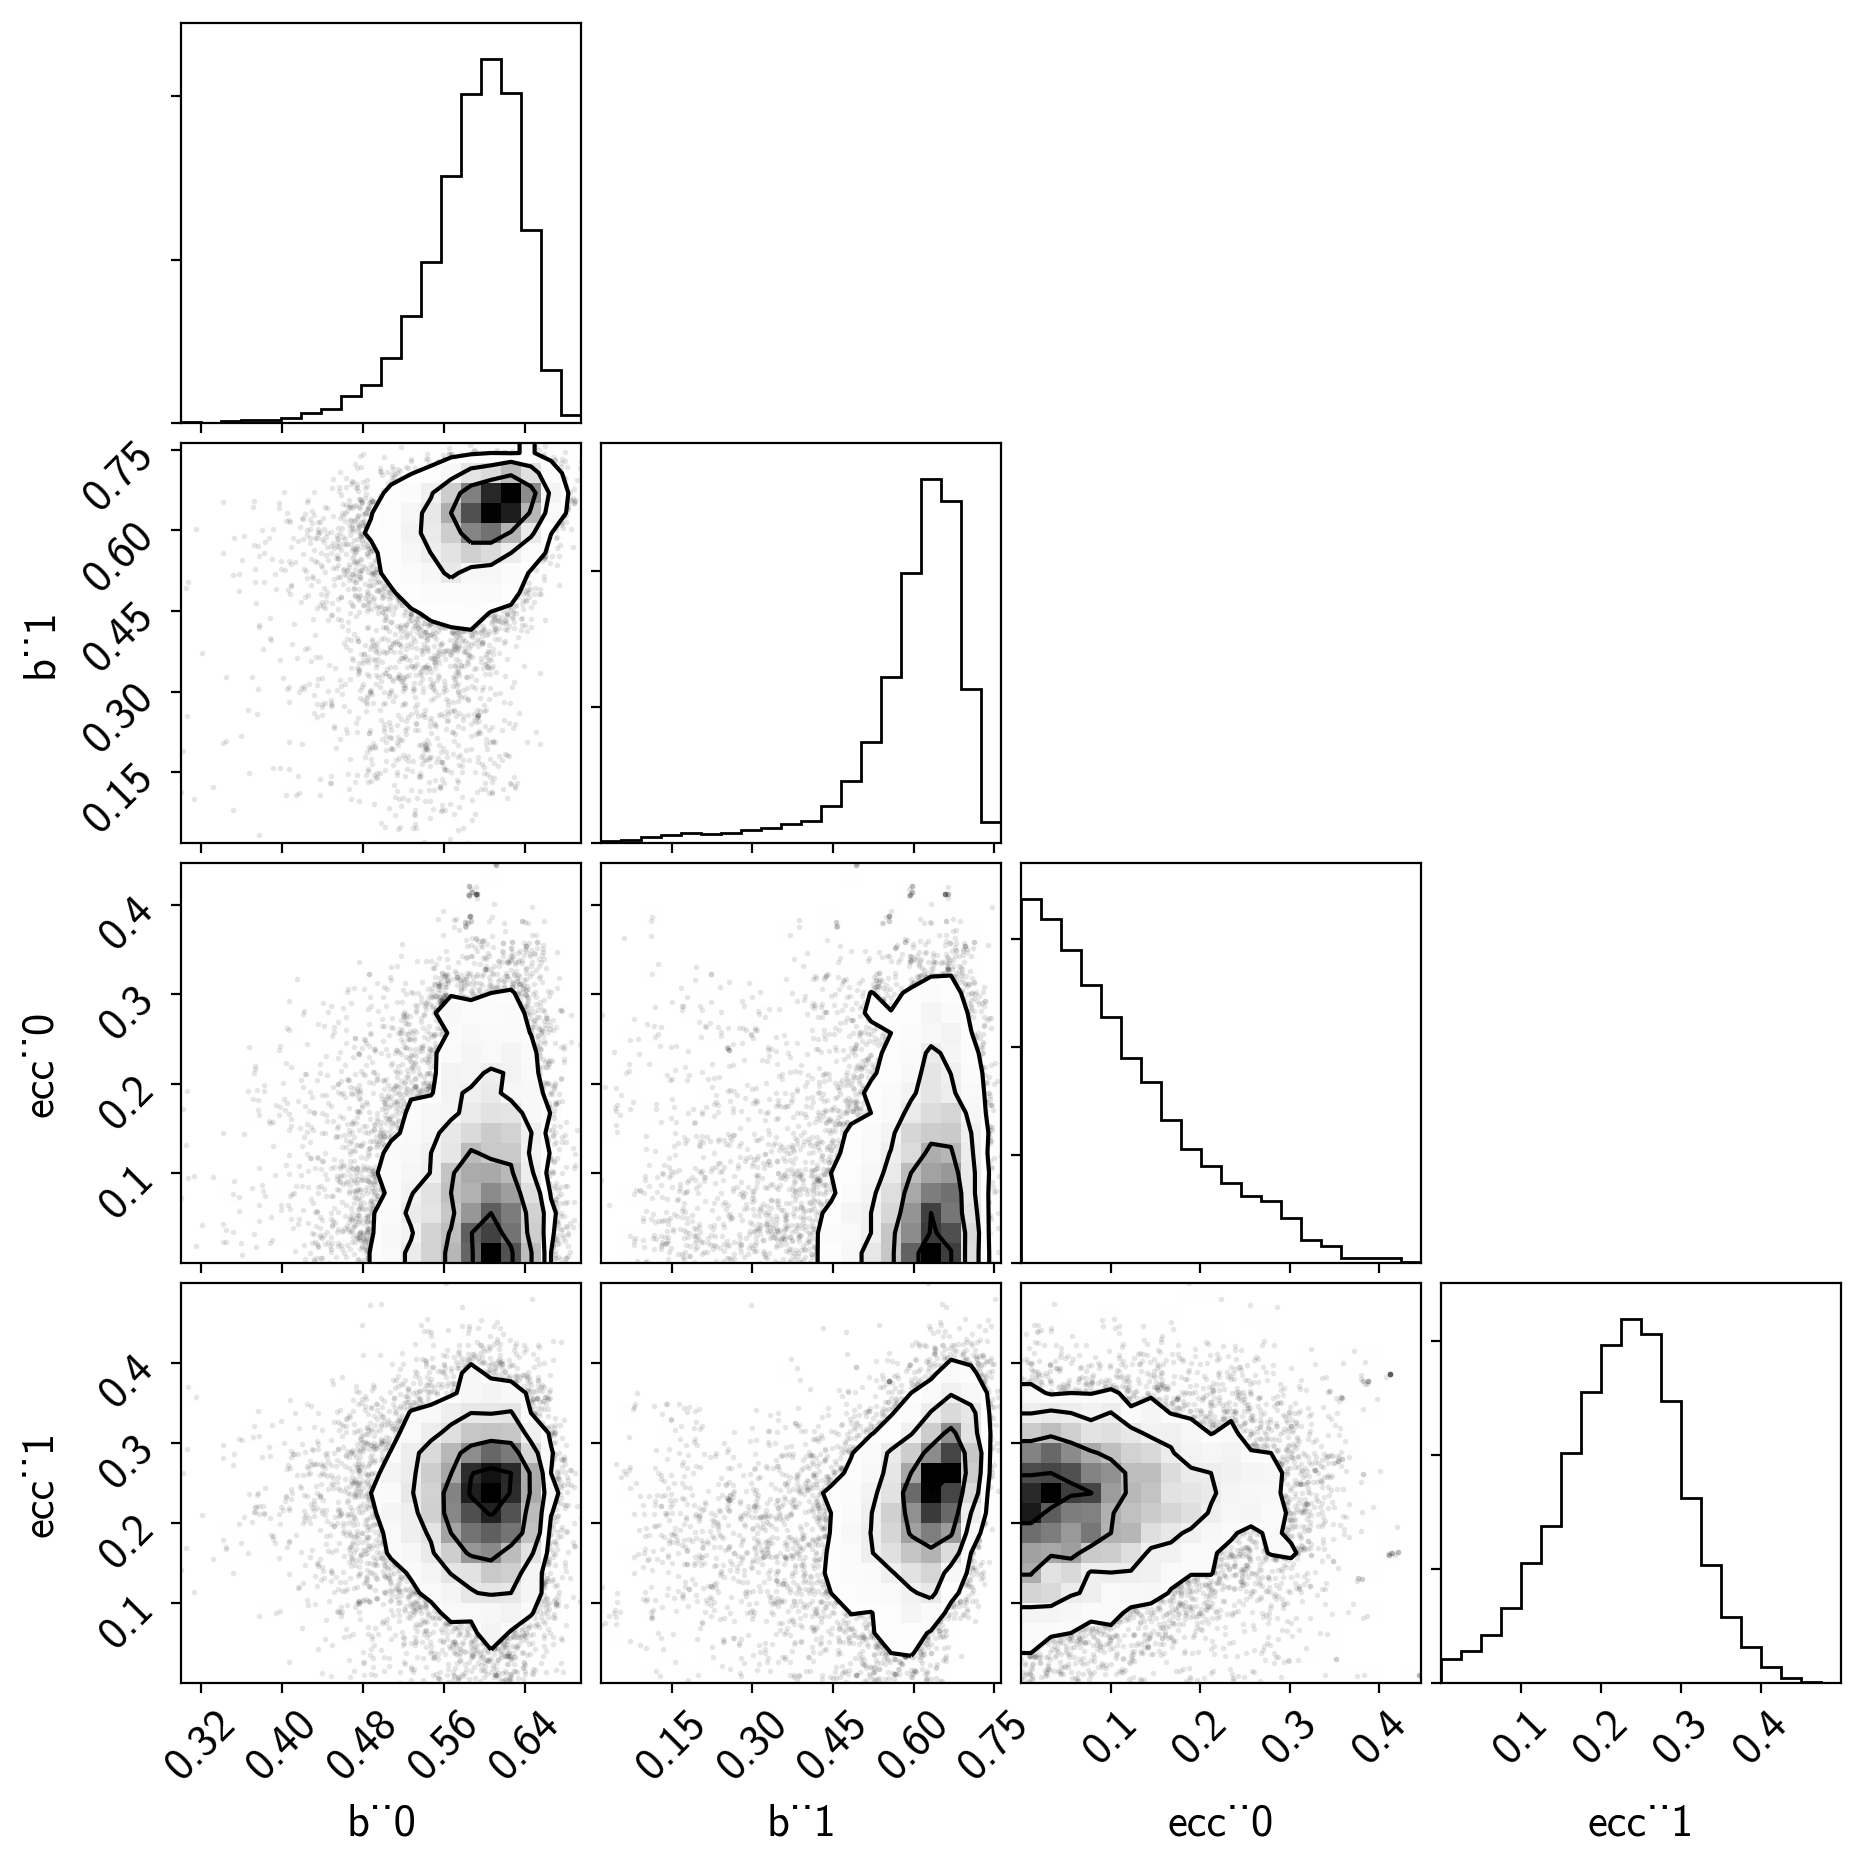

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

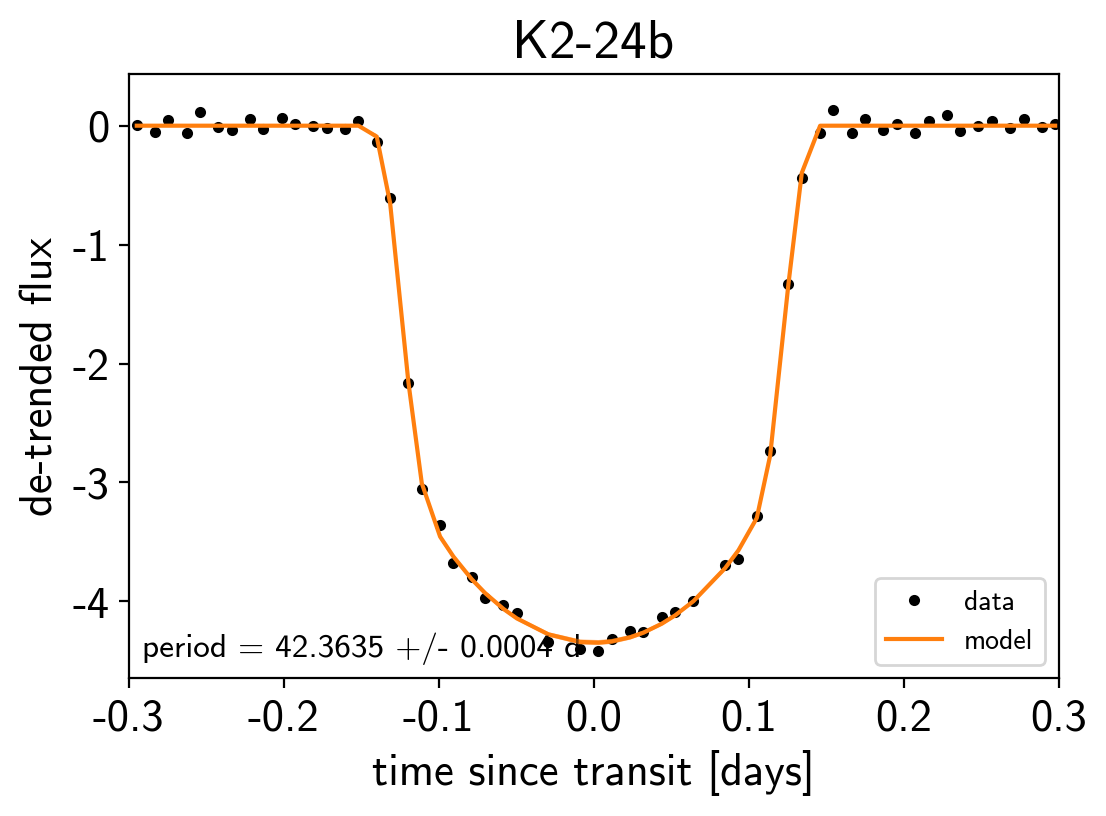

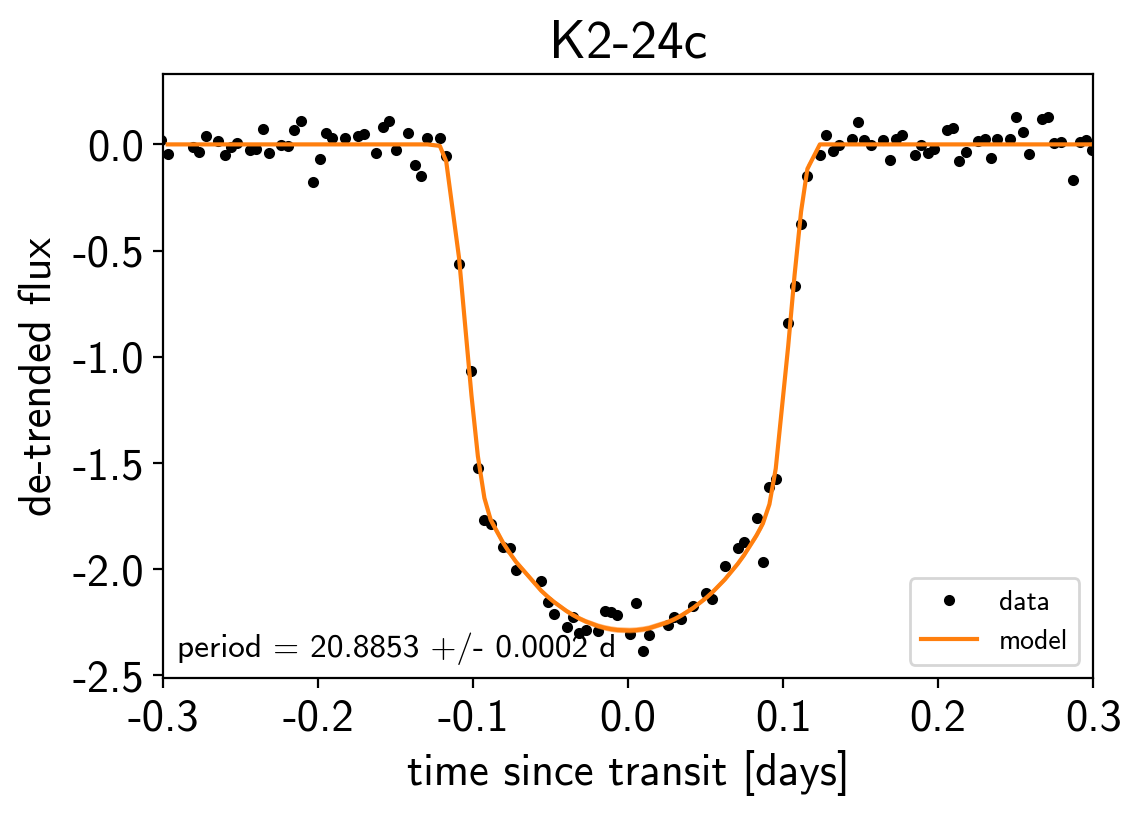

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

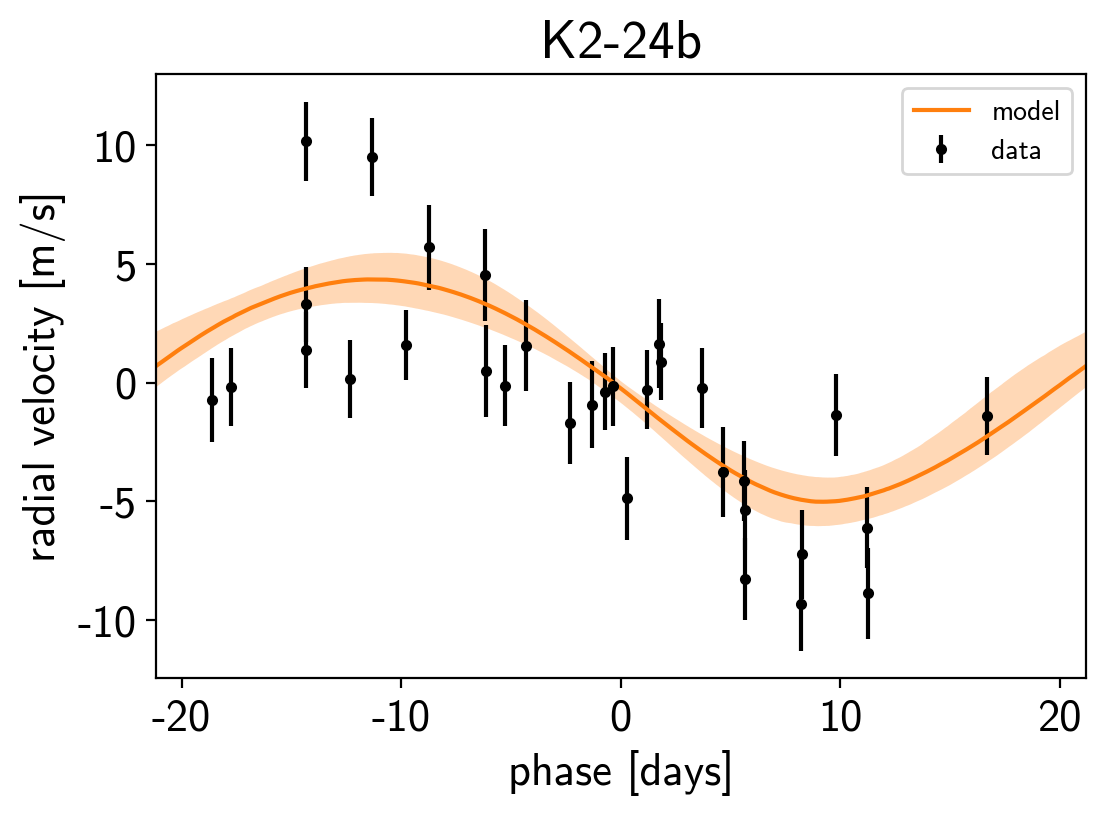

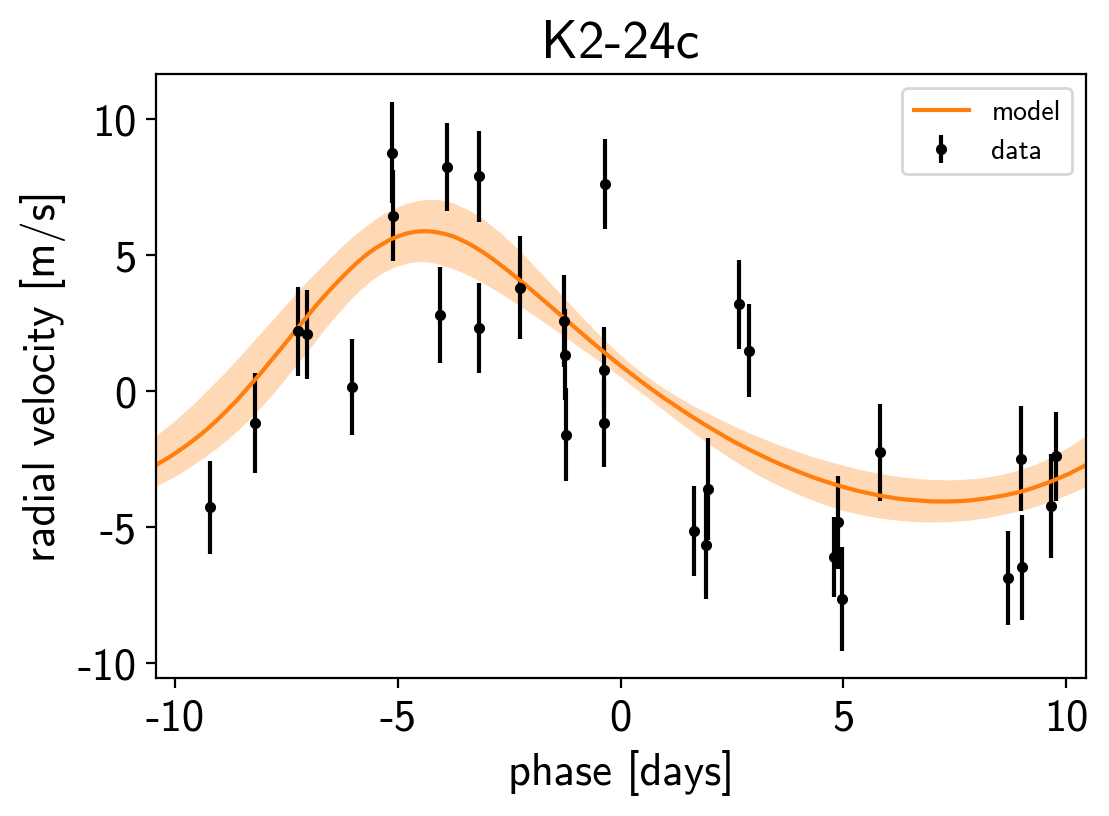

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

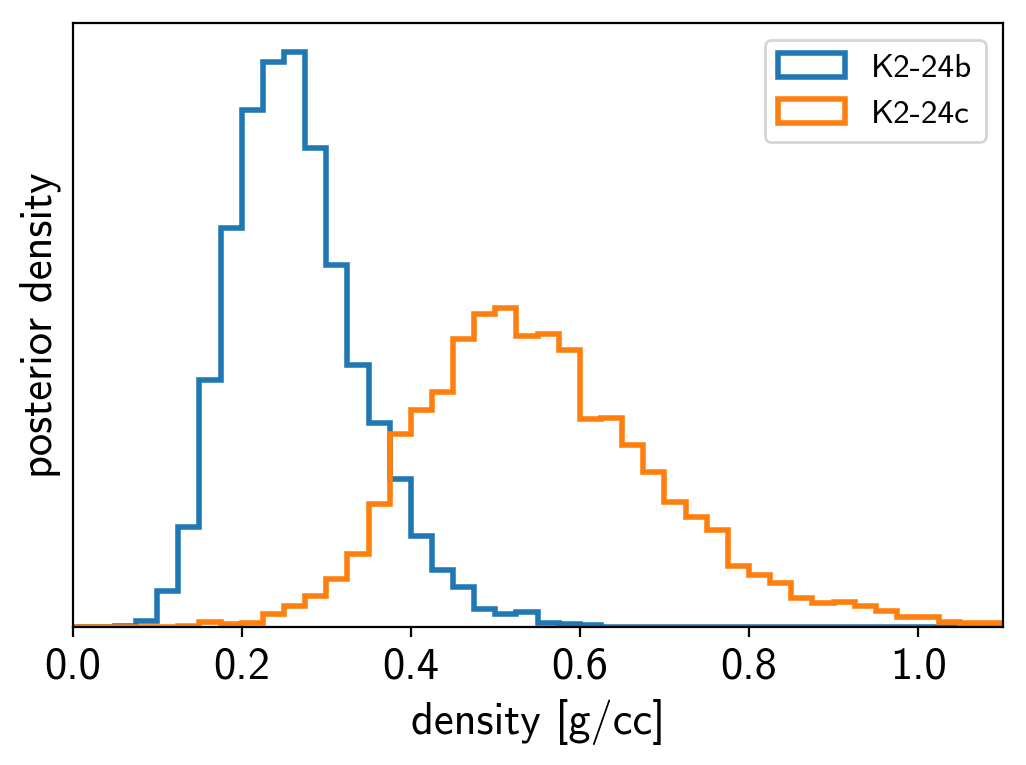

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.4},
   month = feb,
    year = 2019,
     doi = {10.5281/zenodo.2561395},
     url = {https://doi.org/10.5281/zenodo.2561395}
...
